# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [72]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


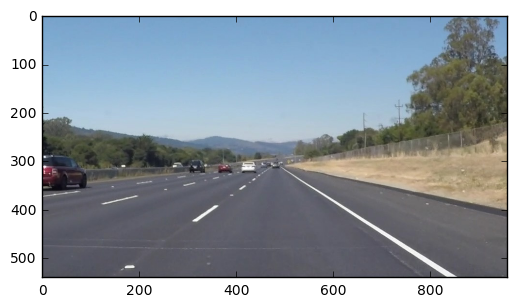

In [73]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [100]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            line_vec_im = np.array([y2-y1,x2-x1])
            
            # Use projective transform to align the lanes (real world coordinates)
            line_vec_trans = (np.concatenate( (line_vec_im, [1]) , axis=0)[np.newaxis]).T
            line_vec_trans1 = np.matmul(transfM, line_vec_trans)
            line_vec_trans1 = line_vec_trans1/line_vec_trans1[2]
            line_vec = line_vec_trans1[0:2]
            #print('line_vec:', line_vec, ' line_vec_trans:', line_vec_trans, '  line_vec_im:', line_vec_im)
            # Makes sure lines detected as lanes are almost in the travel direction of the vehicle:
            # line_vec[0] is in the direction of the vehicle
            lane_angle = np.arccos(np.abs(line_vec[0])/np.hypot(line_vec[0],line_vec[1]))*180/np.pi
            print('lines angle:', lane_angle)
            if lane_angle<20:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [94]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [76]:
# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML


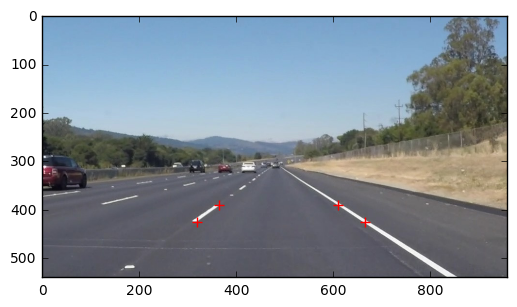

Transformation matrix: [[ -8.51273624e-01  -3.16516023e+00   1.36756779e+03]
 [  3.27515792e-15   4.43714051e-01  -4.26705012e+02]
 [  4.43167638e-18  -3.28677075e-03   1.00000000e+00]]
Transformation matrix inverse: [[ -1.17471042e+00  -1.62921438e+00   9.11302198e+02]
 [ -6.32975285e-15  -1.04300573e+00  -4.45055774e+02]
 [ -1.55985101e-17  -3.42812073e-03  -4.62796299e-01]]
[[ 630.]
 [ 600.]
 [   1.]]
[[ 630.]
 [ 900.]
 [   1.]]
[[  1.37000000e+03]
 [  6.00000000e+02]
 [  1.00000000e+00]]
[[  1.37000000e+03]
 [  9.00000000e+02]
 [  1.00000000e+00]]


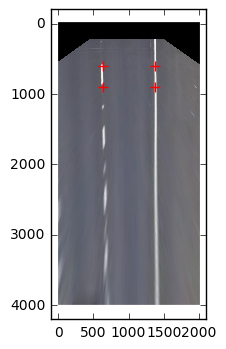

In [77]:
# Find PROJECTIVE transform for the road to find better masking region
# On an highway we could assume for this exercise (not safe in real car, just like masking with a 
# a triangle, that the lines should be fairly parallel to the direction of the vehicle.
# Minimum lane width: Minimum lane width of 12 feet (3.7 m)
# Each dashed line measures 10 feet (3.0 m), and the empty spaces in-between measure 30 feet (9.0m).

# Mark center of image
points_px = np.float32( [ [320, 425], [365, 390],   [665, 425], [610, 390] ] )
plt.scatter(points_px[0][0], points_px[0][1], s=50, c='red', marker='+')
plt.scatter(points_px[1][0], points_px[1][1], s=50, c='red', marker='+')
plt.scatter(points_px[2][0], points_px[2][1], s=50, c='red', marker='+')
plt.scatter(points_px[3][0], points_px[3][1], s=50, c='red', marker='+')

plt.imshow(image)
plt.show()

# Points in meters
pt_distance_to_car = 6.0
dash_line_len = 3.0
lane_width = 3.7
center_of_car = 10
points_dest_px = np.float32( [ [center_of_car-lane_width, pt_distance_to_car],
                        [center_of_car-lane_width, pt_distance_to_car+dash_line_len],
                        [center_of_car+lane_width, pt_distance_to_car],
                        [center_of_car+lane_width, pt_distance_to_car+dash_line_len] ] )
meters_to_px = 100.0
points_m = meters_to_px * points_dest_px

transfM = cv2.getPerspectiveTransform(points_px,points_m)
print('Transformation matrix:', transfM)

transfMInv = np.linalg.inv(transfM)
print('Transformation matrix inverse:', transfMInv)

wrappedIm = cv2.warpPerspective(image, transfM, (2000,4000))


plt.imshow(wrappedIm)

cv2.imwrite('foo.png',wrappedIm)

for line in range(points_px.shape[0]):
    points_dest_px2 = np.matmul(transfM, np.concatenate((points_px[line],[1]), axis=0)[np.newaxis].T)
    points_dest_px2 = points_dest_px2/points_dest_px2[2]
    print(points_dest_px2)
    plt.scatter(points_dest_px2[0], points_dest_px2[1], s=50, c='red', marker='+')

plt.show()

The transformed image above is very roughly in centimeter.
Now we got the transformation Matrix and we could use it to find better vertices for the region of interest.

In [79]:
# Use clues from the transformation matrix displayed to get vertices
vertices_cm_px = np.array([[
                          (440,250),
                          (700, 4000),
                          (1200,4000),
                          (1490,250)]], dtype=np.float32)

vertices_cm = vertices_cm_px[0]
vertices = np.zeros((4,2),dtype=np.int32)

for line in range(vertices_cm.shape[0]):
    current_vertex_cm = np.transpose(np.concatenate((vertices_cm[line],[1]),axis=0)[np.newaxis])
    current_vertex = np.matmul(transfMInv,current_vertex_cm)
    current_vertex = current_vertex/current_vertex[2]
    vertices[line] = np.int32((current_vertex.T)[0][0:2])
print('vertices',vertices)

vertices [[  9 534]
 [453 325]
 [494 325]
 [944 534]]


In [91]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    img = np.copy(image)
    
    # Convert image to grascale
    gray = grayscale(img)
    
    # Filter image (blur/low pass filter)
    kernel_size = 5
    gray = gaussian_blur(gray, kernel_size)
    
    
    # Edge detector
    low_threshold = 70
    high_threshold = low_threshold * 3
    gray = canny(gray, low_threshold, high_threshold)
    
    # Mask image
    imshape = gray.shape
    #print('Image shape is:', imshape)
    
    # Using vertices from projective transform
    vertices = np.array([[( 9, 534),
             (453, 325),
             (483, 325),
             (944, 534)]],dtype=np.int32) * image.shape[1] // 960
    
    
    #Raph Debug
    #plt.imshow(gray, cmap='gray')
    #plt.show()
    
    gray = region_of_interest(gray,vertices)
    
    #Raph Debug
    #plt.imshow(gray, cmap='gray')
    #plt.show()
    
    # Apply the Hough transform on the image
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 5     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    #line_image = np.copy(image)*0 # creating a blank to draw lines on
    img_lines = hough_lines(gray, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(img_lines, image, α=0.8, β=1., λ=0.5)
    return result

Let's try the one with the solid white lane on the right first ...

lines angle: [ 27.75259767]
lines angle: [ 23.27902651]
lines angle: [ 32.71536746]
lines angle: [ 18.03962428]
lines angle: [ 18.02811907]
lines angle: [ 20.46435559]
lines angle: [ 33.83293643]
lines angle: [ 17.67319068]
lines angle: [ 19.37155447]
lines angle: [ 21.13326048]
lines angle: [ 17.50063899]
lines angle: [ 17.9869078]
lines angle: [ 17.4999587]
lines angle: [ 17.63546373]
lines angle: [ 17.47907201]
lines angle: [ 17.72503146]
lines angle: [ 17.59612707]
lines angle: [ 17.64620711]
lines angle: [ 20.2779097]
lines angle: [ 17.68030351]
lines angle: [ 17.52442893]
lines angle: [ 17.48950932]
lines angle: [ 17.58945585]
lines angle: [ 17.48038694]
lines angle: [ 17.68030351]
lines angle: [ 18.53424416]
lines angle: [ 17.4999587]


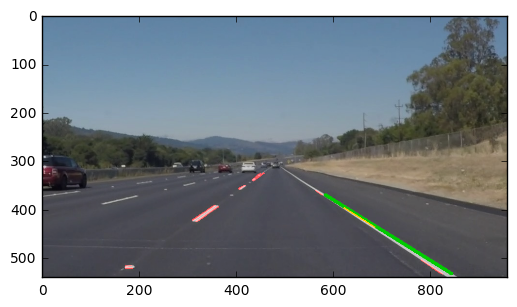

In [103]:
#Testing function on single image
#583  y1: 370  x1 844  y2 533
cv2.line(image, (583, 370), (844, 533), [0, 255, 0],5)
plt.imshow(process_image(image))


In [104]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

lines angle: [ 29.83785139]
lines angle: [ 35.34800105]
lines angle: [ 17.49017782]
lines angle: [ 19.08671166]
lines angle: [ 18.56412498]
lines angle: [ 20.33255386]
lines angle: [ 23.47054721]
lines angle: [ 17.9543827]
lines angle: [ 19.34154631]
lines angle: [ 17.46800316]
lines angle: [ 17.5237188]
lines angle: [ 17.54479782]
lines angle: [ 17.56820557]
lines angle: [ 27.36724099]
lines angle: [ 17.53497428]
lines angle: [ 20.02299993]
lines angle: [ 17.77224078]
lines angle: [ 17.49017782]
lines angle: [ 17.47972876]
lines angle: [ 17.59024342]
lines angle: [ 17.56366143]
lines angle: [ 17.79734705]
lines angle: [ 17.60672254]
lines angle: [ 17.65783218]
lines angle: [ 18.3744776]
lines angle: [ 17.49927989]
lines angle: [ 17.5237188]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

lines angle: [ 29.83785139]
lines angle: [ 35.34800105]
lines angle: [ 17.49017782]
lines angle: [ 19.08671166]
lines angle: [ 18.56412498]
lines angle: [ 20.33255386]
lines angle: [ 23.47054721]
lines angle: [ 17.9543827]
lines angle: [ 19.34154631]
lines angle: [ 17.46800316]
lines angle: [ 17.5237188]
lines angle: [ 17.54479782]
lines angle: [ 17.56820557]
lines angle: [ 27.36724099]
lines angle: [ 17.53497428]
lines angle: [ 20.02299993]
lines angle: [ 17.77224078]
lines angle: [ 17.49017782]
lines angle: [ 17.47972876]
lines angle: [ 17.59024342]
lines angle: [ 17.56366143]
lines angle: [ 17.79734705]
lines angle: [ 17.60672254]
lines angle: [ 17.65783218]
lines angle: [ 18.3744776]
lines angle: [ 17.49927989]
lines angle: [ 17.5237188]


  0%|          | 1/222 [00:00<00:44,  4.93it/s]

lines angle: [ 29.10362433]
lines angle: [ 24.55096122]
lines angle: [ 18.40086768]
lines angle: [ 35.34800105]
lines angle: [ 17.94673732]
lines angle: [ 17.54553192]
lines angle: [ 17.82268527]
lines angle: [ 20.92400642]
lines angle: [ 17.72746574]
lines angle: [ 17.62556467]
lines angle: [ 18.1989816]
lines angle: [ 18.08551517]
lines angle: [ 17.59024342]
lines angle: [ 17.49084778]
lines angle: [ 17.53425218]
lines angle: [ 17.77528111]
lines angle: [ 17.5237188]
lines angle: [ 17.85274447]
lines angle: [ 18.05683625]
lines angle: [ 17.58476671]
lines angle: [ 17.56290987]
lines angle: [ 17.68120155]
lines angle: [ 17.49084778]
lines angle: [ 19.18647022]
lines angle: [ 18.40919328]
lines angle: [ 17.68300366]
lines angle: [ 17.49084778]
lines angle: [ 17.69477781]
lines angle: [ 17.61319748]
lines angle: [ 17.48950932]
lines angle: [ 18.90425821]
lines angle: [ 17.71655678]
lines angle: [ 18.28655355]
lines angle: [ 19.19963151]


  1%|          | 2/222 [00:00<00:45,  4.85it/s]

lines angle: [ 24.76380712]
lines angle: [ 31.72776945]
lines angle: [ 23.02141029]
lines angle: [ 18.81493366]
lines angle: [ 18.64276713]
lines angle: [ 27.40153474]
lines angle: [ 19.18357734]
lines angle: [ 17.76226487]
lines angle: [ 17.62307523]
lines angle: [ 19.5377196]
lines angle: [ 17.59024342]
lines angle: [ 18.81493366]
lines angle: [ 17.56744405]
lines angle: [ 18.52416803]
lines angle: [ 17.63462153]
lines angle: [ 17.80734485]
lines angle: [ 17.55164956]
lines angle: [ 17.77528111]
lines angle: [ 17.61319748]
lines angle: [ 17.54553192]
lines angle: [ 17.6239032]
lines angle: [ 17.72503146]
lines angle: [ 17.60432367]
lines angle: [ 18.38376748]
lines angle: [ 17.60170101]


  1%|▏         | 3/222 [00:00<00:42,  5.13it/s]

lines angle: [ 34.79124436]
lines angle: [ 22.65350826]
lines angle: [ 18.52416803]
lines angle: [ 17.49017782]
lines angle: [ 18.0105552]
lines angle: [ 18.05803103]
lines angle: [ 18.14555247]
lines angle: [ 17.74033013]
lines angle: [ 17.63546373]
lines angle: [ 17.60170101]
lines angle: [ 18.58862703]
lines angle: [ 17.64792207]
lines angle: [ 18.11621693]
lines angle: [ 17.88354049]
lines angle: [ 17.47972876]
lines angle: [ 18.04507037]
lines angle: [ 18.29821408]
lines angle: [ 19.3147771]
lines angle: [ 17.57882449]
lines angle: [ 17.71655678]
lines angle: [ 17.60672254]
lines angle: [ 17.96827043]
lines angle: [ 17.58476671]
lines angle: [ 24.70152955]
lines angle: [ 17.95225041]
lines angle: [ 17.58476671]
lines angle: [ 17.60672254]
lines angle: [ 17.60592116]
lines angle: [ 17.90668916]
lines angle: [ 17.52301023]
lines angle: [ 18.37197609]


  2%|▏         | 4/222 [00:00<00:41,  5.23it/s]

lines angle: [ 25.93382087]
lines angle: [ 35.87195938]
lines angle: [ 19.90907682]
lines angle: [ 17.47907201]
lines angle: [ 17.69203356]
lines angle: [ 19.98965068]
lines angle: [ 17.60170101]
lines angle: [ 17.62473301]
lines angle: [ 17.55312718]
lines angle: [ 21.95460653]
lines angle: [ 17.67319068]
lines angle: [ 18.14043698]
lines angle: [ 17.55759907]
lines angle: [ 18.20072598]
lines angle: [ 17.47907201]
lines angle: [ 17.5118059]
lines angle: [ 17.47907201]
lines angle: [ 21.57398645]
lines angle: [ 17.89455493]


  2%|▏         | 5/222 [00:00<00:36,  5.88it/s]

lines angle: [ 28.45404629]
lines angle: [ 20.91824056]
lines angle: [ 21.06697484]
lines angle: [ 36.24948821]
lines angle: [ 19.50685803]
lines angle: [ 17.61483419]
lines angle: [ 17.63546373]
lines angle: [ 17.52301023]
lines angle: [ 17.52442893]
lines angle: [ 17.67038237]
lines angle: [ 18.21224374]
lines angle: [ 17.49017782]
lines angle: [ 18.52416803]
lines angle: [ 19.44562013]
lines angle: [ 17.48104656]
lines angle: [ 18.78404381]
lines angle: [ 17.68120155]
lines angle: [ 17.47972876]
lines angle: [ 17.9869078]
lines angle: [ 17.89455493]
lines angle: [ 18.62722686]
lines angle: [ 17.50972959]
lines angle: [ 17.5118059]
lines angle: [ 18.20072598]
lines angle: [ 17.58476671]


  3%|▎         | 6/222 [00:01<00:35,  6.15it/s]

lines angle: [ 35.50325852]
lines angle: [ 33.1965604]
lines angle: [ 32.32703753]
lines angle: [ 17.82160976]
lines angle: [ 18.91942499]
lines angle: [ 18.04556807]
lines angle: [ 17.75129094]
lines angle: [ 17.78630746]
lines angle: [ 17.5666842]
lines angle: [ 17.65870312]
lines angle: [ 17.53281272]
lines angle: [ 18.8262353]
lines angle: [ 17.50337505]
lines angle: [ 17.58476671]
lines angle: [ 17.46800316]
lines angle: [ 17.61814565]
lines angle: [ 17.68120155]
lines angle: [ 17.52301023]
lines angle: [ 18.60078022]
lines angle: [ 18.43474228]
lines angle: [ 19.3549577]
lines angle: [ 18.15332428]
lines angle: [ 17.53066531]


  3%|▎         | 7/222 [00:01<00:33,  6.50it/s]

lines angle: [ 38.77036492]
lines angle: [ 28.76316681]
lines angle: [ 25.34897267]
lines angle: [ 17.84604182]
lines angle: [ 17.89308572]
lines angle: [ 19.37473001]
lines angle: [ 18.8262353]
lines angle: [ 17.47907201]
lines angle: [ 17.56744405]
lines angle: [ 17.91797096]
lines angle: [ 17.46800316]
lines angle: [ 17.61733037]
lines angle: [ 17.68391013]
lines angle: [ 19.19963151]
lines angle: [ 18.70514736]
lines angle: [ 17.4999587]
lines angle: [ 17.47907201]
lines angle: [ 17.47907201]
lines angle: [ 17.53425218]
lines angle: [ 18.57446314]
lines angle: [ 17.62877803]
lines angle: [ 17.9869078]
lines angle: [ 17.52301023]
lines angle: [ 17.60752568]
lines angle: [ 18.62722686]


  4%|▎         | 8/222 [00:01<00:33,  6.40it/s]

lines angle: [ 17.5118059]
lines angle: [ 36.24869988]
lines angle: [ 31.71223038]
lines angle: [ 37.26257904]
lines angle: [ 17.9568779]
lines angle: [ 17.8954211]
lines angle: [ 17.47907201]
lines angle: [ 17.69294626]
lines angle: [ 17.75129094]
lines angle: [ 17.75140723]
lines angle: [ 17.4784167]
lines angle: [ 17.4999587]
lines angle: [ 18.14043698]
lines angle: [ 17.56820557]
lines angle: [ 17.48950932]
lines angle: [ 17.57805083]
lines angle: [ 17.53281272]
lines angle: [ 17.53353166]
lines angle: [ 17.65093385]
lines angle: [ 18.29821408]
lines angle: [ 17.62473301]
lines angle: [ 17.48950932]
lines angle: [ 19.50685803]
lines angle: [ 17.53281272]
lines angle: [ 17.59533778]
lines angle: [ 17.60752568]
lines angle: [ 17.5734444]
lines angle: [ 19.2983548]
lines angle: [ 17.46864677]
lines angle: [ 17.54115136]


  4%|▍         | 9/222 [00:01<00:35,  5.97it/s]

lines angle: [ 37.73280934]
lines angle: [ 38.15571516]
lines angle: [ 35.50456202]
lines angle: [ 18.19583647]
lines angle: [ 18.06963661]
lines angle: [ 18.70514736]
lines angle: [ 18.08267279]
lines angle: [ 19.76498746]
lines angle: [ 17.63546373]
lines angle: [ 17.4999587]
lines angle: [ 17.71373618]
lines angle: [ 17.56592602]
lines angle: [ 18.14405254]
lines angle: [ 17.60089946]
lines angle: [ 19.12836576]
lines angle: [ 17.55535576]
lines angle: [ 17.5734444]
lines angle: [ 17.51111229]
lines angle: [ 18.96012871]
lines angle: [ 17.5118059]


  5%|▍         | 10/222 [00:01<00:32,  6.49it/s]

lines angle: [ 41.28423796]
lines angle: [ 29.45787982]
lines angle: [ 17.46800316]
lines angle: [ 17.52301023]
lines angle: [ 18.40942785]
lines angle: [ 18.27891169]
lines angle: [ 20.14939239]
lines angle: [ 18.32034247]
lines angle: [ 17.71428642]
lines angle: [ 17.68120155]
lines angle: [ 18.81134632]
lines angle: [ 18.14705595]
lines angle: [ 17.50063899]
lines angle: [ 18.39735763]
lines angle: [ 18.42360351]
lines angle: [ 23.47054721]
lines angle: [ 17.62473301]
lines angle: [ 17.89455493]
lines angle: [ 17.6239032]
lines angle: [ 17.54479782]
lines angle: [ 17.66949692]
lines angle: [ 18.08078804]
lines angle: [ 17.61733037]
lines angle: [ 17.5734444]
lines angle: [ 18.77159106]
lines angle: [ 25.15694976]
lines angle: [ 18.29821408]


  5%|▍         | 11/222 [00:01<00:32,  6.53it/s]

lines angle: [ 22.45330952]
lines angle: [ 32.03730986]
lines angle: [ 18.64276713]
lines angle: [ 18.5704316]
lines angle: [ 18.7375725]
lines angle: [ 19.16758439]
lines angle: [ 18.38376748]
lines angle: [ 19.12836576]
lines angle: [ 17.55610189]
lines angle: [ 17.49017782]
lines angle: [ 18.67901405]
lines angle: [ 17.83162938]
lines angle: [ 18.83639709]
lines angle: [ 17.74752468]
lines angle: [ 17.68123815]
lines angle: [ 18.52416803]
lines angle: [ 17.6821016]
lines angle: [ 17.71428642]
lines angle: [ 17.87178423]
lines angle: [ 17.56290987]
lines angle: [ 17.80734485]
lines angle: [ 17.59930165]
lines angle: [ 28.03365551]
lines angle: [ 18.77159106]
lines angle: [ 18.39557349]
lines angle: [ 17.66861345]
lines angle: [ 17.46800316]
lines angle: [ 18.48431013]
lines angle: [ 17.87142201]
lines angle: [ 17.59533778]
lines angle: [ 17.56290987]
lines angle: [ 17.58945585]
lines angle: [ 17.86044674]


  5%|▌         | 12/222 [00:01<00:34,  6.13it/s]

lines angle: [ 18.43474228]
lines angle: [ 23.83039972]
lines angle: [ 29.15766821]
lines angle: [ 18.85135185]
lines angle: [ 18.99581543]
lines angle: [ 19.28658496]
lines angle: [ 19.16184589]
lines angle: [ 18.74447247]
lines angle: [ 17.5666842]
lines angle: [ 19.20985826]
lines angle: [ 21.8410164]
lines angle: [ 32.80784019]
lines angle: [ 18.70514736]
lines angle: [ 17.60089946]
lines angle: [ 17.74752468]
lines angle: [ 17.5118059]
lines angle: [ 17.54479782]
lines angle: [ 17.52301023]
lines angle: [ 17.61238184]
lines angle: [ 17.50268879]
lines angle: [ 18.34671659]
lines angle: [ 17.98095687]
lines angle: [ 17.56744405]
lines angle: [ 18.57446314]
lines angle: [ 17.5734444]
lines angle: [ 17.54115136]
lines angle: [ 17.96337051]


  6%|▌         | 13/222 [00:02<00:33,  6.24it/s]

lines angle: [ 34.16199269]
lines angle: [ 19.55920967]
lines angle: [ 19.18496033]
lines angle: [ 28.23402477]
lines angle: [ 21.21249979]
lines angle: [ 19.50783279]
lines angle: [ 17.7383877]
lines angle: [ 17.6911229]
lines angle: [ 19.2505921]
lines angle: [ 20.21790598]
lines angle: [ 17.60009967]
lines angle: [ 21.89518019]
lines angle: [ 17.55610189]
lines angle: [ 17.5666842]
lines angle: [ 17.56290987]
lines angle: [ 17.58476671]
lines angle: [ 17.55461127]
lines angle: [ 17.74932271]
lines angle: [ 17.60009967]
lines angle: [ 18.61294874]
lines angle: [ 18.23689561]
lines angle: [ 18.15185658]
lines angle: [ 17.59533778]
lines angle: [ 17.56290987]
lines angle: [ 17.91662322]
lines angle: [ 17.57727887]


  6%|▋         | 14/222 [00:02<00:32,  6.36it/s]

lines angle: [ 22.48133013]
lines angle: [ 26.4149537]
lines angle: [ 36.19446212]
lines angle: [ 17.55610189]
lines angle: [ 18.43592463]
lines angle: [ 18.17525487]
lines angle: [ 36.41288646]
lines angle: [ 18.19426951]
lines angle: [ 17.68300366]
lines angle: [ 17.61156801]
lines angle: [ 17.55759907]
lines angle: [ 17.61156801]
lines angle: [ 17.60089946]
lines angle: [ 17.6239032]
lines angle: [ 17.85608331]
lines angle: [ 18.21224374]
lines angle: [ 17.53497428]
lines angle: [ 17.50063899]
lines angle: [ 17.53353166]
lines angle: [ 17.46864677]
lines angle: [ 17.53353166]
lines angle: [ 17.59024342]
lines angle: [ 17.48950932]
lines angle: [ 18.47235529]
lines angle: [ 17.44721211]


  7%|▋         | 15/222 [00:02<00:31,  6.55it/s]

lines angle: [ 35.60851641]
lines angle: [ 25.20154675]
lines angle: [ 23.43755236]
lines angle: [ 17.65696317]
lines angle: [ 18.28756645]
lines angle: [ 18.1603591]
lines angle: [ 17.61238184]
lines angle: [ 17.59612707]
lines angle: [ 27.44052812]
lines angle: [ 19.62415189]
lines angle: [ 17.9442642]
lines angle: [ 18.22276826]
lines angle: [ 17.62307523]
lines angle: [ 20.5723741]
lines angle: [ 17.62473301]
lines angle: [ 17.50063899]
lines angle: [ 17.54115136]
lines angle: [ 20.82611364]


  7%|▋         | 16/222 [00:02<00:29,  6.94it/s]

lines angle: [ 34.89326254]
lines angle: [ 29.64276571]
lines angle: [ 17.48950932]
lines angle: [ 23.08264762]
lines angle: [ 17.50268879]
lines angle: [ 17.69203356]
lines angle: [ 17.50063899]
lines angle: [ 17.5118059]
lines angle: [ 20.46435559]
lines angle: [ 20.68224717]
lines angle: [ 17.47907201]
lines angle: [ 17.5734444]
lines angle: [ 17.68030351]
lines angle: [ 35.45253084]
lines angle: [ 35.24672743]
lines angle: [ 24.41682061]
lines angle: [ 22.89076578]
lines angle: [ 17.64792207]
lines angle: [ 17.72651063]
lines angle: [ 18.94483759]
lines angle: [ 17.76226487]
lines angle: [ 17.47907201]
lines angle: [ 19.06813301]
lines angle: [ 17.54479782]
lines angle: [ 17.45760164]
lines angle: [ 17.53066531]
lines angle: [ 19.06813301]
lines angle: [ 17.61075597]
lines angle: [ 17.57420793]
lines angle: [ 18.43474228]
lines angle: [ 18.10344743]


  8%|▊         | 18/222 [00:02<00:26,  7.71it/s]

lines angle: [ 28.57676492]
lines angle: [ 35.81912365]
lines angle: [ 23.27902651]
lines angle: [ 20.2779097]
lines angle: [ 17.75030572]
lines angle: [ 17.72746574]
lines angle: [ 17.76226487]
lines angle: [ 24.8607574]
lines angle: [ 17.77426538]
lines angle: [ 17.58476671]
lines angle: [ 17.53353166]
lines angle: [ 18.40919328]
lines angle: [ 17.68120155]
lines angle: [ 17.68120155]
lines angle: [ 17.77012097]
lines angle: [ 19.25544365]
lines angle: [ 20.79402216]
lines angle: [ 19.18357734]
lines angle: [ 19.18357734]
lines angle: [ 17.8348958]
lines angle: [ 17.89455493]
lines angle: [ 18.28655355]
lines angle: [ 17.89308572]
lines angle: [ 17.91779522]
lines angle: [ 18.32326527]
lines angle: [ 19.37155447]
lines angle: [ 17.9869078]
lines angle: [ 18.0694789]
lines angle: [ 17.71428642]
lines angle: [ 17.71428642]
lines angle: [ 18.47235529]
lines angle: [ 18.43474228]
lines angle: [ 17.53425218]
lines angle: [ 18.58862703]
lines angle: [ 18.0105552]
lines angle: [ 17.7383877]

  9%|▉         | 20/222 [00:03<00:27,  7.34it/s]

lines angle: [ 27.09587798]
lines angle: [ 37.84816737]
lines angle: [ 17.78527865]
lines angle: [ 17.92037192]
lines angle: [ 17.68030351]
lines angle: [ 19.56527043]
lines angle: [ 17.5118059]
lines angle: [ 19.07085323]
lines angle: [ 17.59024342]
lines angle: [ 17.57574003]
lines angle: [ 17.58945585]
lines angle: [ 17.4999587]
lines angle: [ 18.53621379]
lines angle: [ 20.62446122]
lines angle: [ 17.49017782]
lines angle: [ 17.58945585]
lines angle: [ 17.61319748]
lines angle: [ 17.60089946]
lines angle: [ 37.66891118]
lines angle: [ 17.47907201]
lines angle: [ 18.27328263]
lines angle: [ 17.77426538]
lines angle: [ 17.54479782]
lines angle: [ 17.68391013]
lines angle: [ 17.48884227]
lines angle: [ 22.41499612]
lines angle: [ 17.61238184]
lines angle: [ 17.50063899]
lines angle: [ 17.46800316]


  9%|▉         | 21/222 [00:03<00:28,  7.10it/s]

lines angle: [ 37.43364304]
lines angle: [ 25.97004546]
lines angle: [ 40.40803661]
lines angle: [ 37.43364304]
lines angle: [ 18.15731876]
lines angle: [ 18.09432181]
lines angle: [ 18.13083417]
lines angle: [ 21.15607589]
lines angle: [ 17.59024342]
lines angle: [ 17.60250435]
lines angle: [ 17.44721211]
lines angle: [ 17.55684966]
lines angle: [ 18.54827468]
lines angle: [ 17.75129094]
lines angle: [ 17.46864677]
lines angle: [ 17.47972876]
lines angle: [ 17.46864677]
lines angle: [ 17.46864677]
lines angle: [ 17.58476671]
lines angle: [ 17.56744405]
lines angle: [ 17.69294626]
lines angle: [ 17.65783218]
lines angle: [ 17.47907201]


 10%|▉         | 22/222 [00:03<00:27,  7.28it/s]

lines angle: [ 37.43364304]
lines angle: [ 31.49237585]
lines angle: [ 25.87276165]
lines angle: [ 33.01933159]
lines angle: [ 17.9568779]
lines angle: [ 18.43402175]
lines angle: [ 18.06963661]
lines angle: [ 19.09953606]
lines angle: [ 17.47907201]
lines angle: [ 17.49151921]
lines angle: [ 17.50063899]
lines angle: [ 17.53425218]
lines angle: [ 17.46800316]
lines angle: [ 17.40577356]
lines angle: [ 17.47907201]
lines angle: [ 18.89160998]
lines angle: [ 17.58945585]
lines angle: [ 17.54553192]
lines angle: [ 17.46864677]
lines angle: [ 17.68030351]
lines angle: [ 17.46800316]


 10%|█         | 23/222 [00:03<00:26,  7.45it/s]

lines angle: [ 19.3147771]
lines angle: [ 25.88222919]
lines angle: [ 18.79201489]
lines angle: [ 18.63834131]
lines angle: [ 25.21129323]
lines angle: [ 18.06811803]
lines angle: [ 18.3672159]
lines angle: [ 20.2779097]
lines angle: [ 17.88241033]
lines angle: [ 19.8867044]
lines angle: [ 18.44663728]
lines angle: [ 17.5118059]
lines angle: [ 17.54553192]
lines angle: [ 17.5118059]
lines angle: [ 17.79180093]
lines angle: [ 18.19426951]
lines angle: [ 18.16329008]
lines angle: [ 18.12759488]
lines angle: [ 19.22600627]
lines angle: [ 17.47907201]
lines angle: [ 17.55610189]
lines angle: [ 18.09211088]
lines angle: [ 17.55164956]
lines angle: [ 18.72984483]
lines angle: [ 20.54124139]
lines angle: [ 17.55684966]
lines angle: [ 17.87142201]
lines angle: [ 18.56622196]
lines angle: [ 17.84839571]
lines angle: [ 17.54553192]
lines angle: [ 17.54553192]
lines angle: [ 17.61489525]
lines angle: [ 18.05683625]
lines angle: [ 17.56744405]
lines angle: [ 17.66968124]
lines angle: [ 18.05683625

 11%|█         | 24/222 [00:03<00:30,  6.51it/s]

lines angle: [ 24.2649206]
lines angle: [ 36.80246295]
lines angle: [ 19.22074525]
lines angle: [ 29.04250441]
lines angle: [ 18.5263746]
lines angle: [ 17.52301023]
lines angle: [ 20.676922]
lines angle: [ 18.1205937]
lines angle: [ 18.78138508]
lines angle: [ 17.49017782]
lines angle: [ 18.24825421]
lines angle: [ 17.50132076]
lines angle: [ 17.55684966]
lines angle: [ 17.57882449]
lines angle: [ 17.57959987]
lines angle: [ 17.55684966]
lines angle: [ 17.50200403]
lines angle: [ 17.53066531]
lines angle: [ 17.5237188]
lines angle: [ 17.66161587]
lines angle: [ 17.50200403]
lines angle: [ 18.46041536]
lines angle: [ 18.61294874]
lines angle: [ 17.49017782]
lines angle: [ 17.54479782]
lines angle: [ 17.56744405]
lines angle: [ 18.48431013]
lines angle: [ 17.59533778]
lines angle: [ 17.56290987]
lines angle: [ 17.49017782]
lines angle: [ 19.07085323]


 11%|█▏        | 25/222 [00:03<00:31,  6.34it/s]

lines angle: [ 36.80246295]
lines angle: [ 19.69347334]
lines angle: [ 18.1338009]
lines angle: [ 26.88023031]
lines angle: [ 18.5704316]
lines angle: [ 21.89518019]
lines angle: [ 21.36722689]
lines angle: [ 17.56744405]
lines angle: [ 17.70473127]
lines angle: [ 17.97839999]
lines angle: [ 17.50132076]
lines angle: [ 18.3133862]
lines angle: [ 17.53497428]
lines angle: [ 18.73208377]
lines angle: [ 17.57959987]
lines angle: [ 17.70473127]
lines angle: [ 17.47972876]
lines angle: [ 17.53497428]
lines angle: [ 18.34671659]
lines angle: [ 17.54553192]
lines angle: [ 17.62473301]
lines angle: [ 17.50132076]
lines angle: [ 21.8410164]
lines angle: [ 17.69294626]
lines angle: [ 18.34671659]
lines angle: [ 17.50132076]
lines angle: [ 19.97098372]


 12%|█▏        | 26/222 [00:03<00:31,  6.30it/s]

lines angle: [ 17.94180247]
lines angle: [ 36.80246295]
lines angle: [ 18.81493366]
lines angle: [ 26.88023031]
lines angle: [ 17.87956091]
lines angle: [ 26.90919091]
lines angle: [ 18.80179545]
lines angle: [ 17.57882449]
lines angle: [ 37.0291]
lines angle: [ 17.56820557]
lines angle: [ 17.49084778]
lines angle: [ 17.65696317]
lines angle: [ 17.57805083]
lines angle: [ 17.5237188]
lines angle: [ 19.34154631]
lines angle: [ 17.71467427]
lines angle: [ 17.52301023]
lines angle: [ 17.55759907]
lines angle: [ 17.48950932]
lines angle: [ 17.72503146]
lines angle: [ 17.60009967]
lines angle: [ 17.52301023]


 12%|█▏        | 27/222 [00:04<00:31,  6.27it/s]

lines angle: [ 23.49110892]
lines angle: [ 20.36768503]
lines angle: [ 34.54786372]
lines angle: [ 37.20153116]
lines angle: [ 18.10888626]
lines angle: [ 17.58945585]
lines angle: [ 17.63546373]
lines angle: [ 18.43474228]
lines angle: [ 18.33933422]
lines angle: [ 18.89160998]
lines angle: [ 18.70514736]
lines angle: [ 17.62473301]
lines angle: [ 17.7873386]
lines angle: [ 17.92926652]
lines angle: [ 17.60089946]
lines angle: [ 17.61319748]
lines angle: [ 17.52442893]
lines angle: [ 18.43474228]
lines angle: [ 17.53066531]
lines angle: [ 17.58554395]
lines angle: [ 17.53569796]
lines angle: [ 17.61156801]
lines angle: [ 18.08078804]
lines angle: [ 18.04556807]
lines angle: [ 18.69063739]
lines angle: [ 18.43474228]
lines angle: [ 17.60592116]


 13%|█▎        | 28/222 [00:04<00:30,  6.40it/s]

lines angle: [ 37.20153116]
lines angle: [ 39.4675752]
lines angle: [ 23.90876263]
lines angle: [ 17.61238184]
lines angle: [ 33.51119964]
lines angle: [ 17.60250435]
lines angle: [ 17.59182378]
lines angle: [ 17.59024342]
lines angle: [ 17.63630781]
lines angle: [ 20.08163029]
lines angle: [ 17.38402745]
lines angle: [ 17.53425218]
lines angle: [ 17.53425218]
lines angle: [ 17.46800316]
lines angle: [ 18.66606623]
lines angle: [ 17.52159773]
lines angle: [ 17.63546373]
lines angle: [ 17.61814565]
lines angle: [ 30.65750155]


 13%|█▎        | 29/222 [00:04<00:27,  7.01it/s]

lines angle: [ 36.80246295]
lines angle: [ 20.88010756]
lines angle: [ 26.98751669]
lines angle: [ 17.67038237]
lines angle: [ 17.76226487]
lines angle: [ 30.0368771]
lines angle: [ 17.60994573]
lines angle: [ 20.10066561]
lines angle: [ 17.76126669]
lines angle: [ 17.63630781]
lines angle: [ 17.53066531]
lines angle: [ 18.43474228]
lines angle: [ 17.60672254]
lines angle: [ 18.02176915]
lines angle: [ 17.47972876]
lines angle: [ 18.27328263]
lines angle: [ 17.59024342]
lines angle: [ 17.78095456]


 14%|█▎        | 30/222 [00:04<00:26,  7.33it/s]

lines angle: [ 18.98827617]
lines angle: [ 36.19446212]
lines angle: [ 22.70323241]
lines angle: [ 22.51990524]
lines angle: [ 18.05683625]
lines angle: [ 20.2779097]
lines angle: [ 17.78527865]
lines angle: [ 17.49017782]
lines angle: [ 17.77426538]
lines angle: [ 17.52301023]
lines angle: [ 17.78630746]
lines angle: [ 17.54553192]
lines angle: [ 17.45950158]
lines angle: [ 17.73935782]
lines angle: [ 19.63805083]
lines angle: [ 17.55164956]
lines angle: [ 17.50132076]
lines angle: [ 18.18770884]
lines angle: [ 17.57420793]
lines angle: [ 20.2779097]
lines angle: [ 17.51459557]
lines angle: [ 17.5118059]
lines angle: [ 18.16329008]
lines angle: [ 17.63690946]


 14%|█▍        | 31/222 [00:04<00:26,  7.19it/s]

lines angle: [ 28.25001637]
lines angle: [ 36.19446212]
lines angle: [ 17.7873386]
lines angle: [ 38.9524163]
lines angle: [ 30.11750044]
lines angle: [ 17.85832191]
lines angle: [ 17.85720133]
lines angle: [ 17.5666842]
lines angle: [ 20.90200953]
lines angle: [ 17.4784167]
lines angle: [ 17.47907201]
lines angle: [ 17.55535576]
lines angle: [ 17.84714898]
lines angle: [ 17.59533778]
lines angle: [ 17.67319068]
lines angle: [ 17.46800316]
lines angle: [ 18.75687698]
lines angle: [ 27.41022967]
lines angle: [ 25.74052203]
lines angle: [ 38.26607016]
lines angle: [ 17.97967695]
lines angle: [ 17.54479782]
lines angle: [ 17.94303191]
lines angle: [ 17.6239032]
lines angle: [ 17.97454497]
lines angle: [ 18.00515115]
lines angle: [ 17.53353166]
lines angle: [ 17.50132076]
lines angle: [ 17.54479782]
lines angle: [ 18.11621693]
lines angle: [ 17.59024342]
lines angle: [ 17.54479782]
lines angle: [ 17.52230321]
lines angle: [ 17.67407289]
lines angle: [ 17.54333445]
lines angle: [ 17.6173303

 15%|█▍        | 33/222 [00:04<00:25,  7.43it/s]

lines angle: [ 38.9524163]
lines angle: [ 30.28404579]
lines angle: [ 19.00109161]
lines angle: [ 17.52301023]
lines angle: [ 17.49017782]
lines angle: [ 17.56820557]
lines angle: [ 17.88301132]
lines angle: [ 17.57959987]
lines angle: [ 31.76914028]
lines angle: [ 17.89425207]
lines angle: [ 19.48981086]
lines angle: [ 17.47907201]
lines angle: [ 17.6321061]
lines angle: [ 17.72938241]
lines angle: [ 17.64706364]
lines angle: [ 17.5237188]
lines angle: [ 17.96337051]
lines angle: [ 17.45760164]
lines angle: [ 17.46864677]
lines angle: [ 18.18770884]
lines angle: [ 18.70514736]
lines angle: [ 17.51250103]
lines angle: [ 17.47972876]


 15%|█▌        | 34/222 [00:05<00:25,  7.45it/s]

lines angle: [ 19.258444]
lines angle: [ 39.93183871]
lines angle: [ 20.79402216]
lines angle: [ 18.31511898]
lines angle: [ 18.26520287]
lines angle: [ 17.49017782]
lines angle: [ 17.47907201]
lines angle: [ 18.54827468]
lines angle: [ 17.47907201]
lines angle: [ 17.54553192]
lines angle: [ 19.48981086]
lines angle: [ 33.15837139]
lines angle: [ 18.19740717]
lines angle: [ 17.57420793]
lines angle: [ 18.18770884]
lines angle: [ 17.81457768]
lines angle: [ 17.63630781]
lines angle: [ 17.45760164]
lines angle: [ 19.00371683]
lines angle: [ 18.32326527]
lines angle: [ 17.57882449]
lines angle: [ 17.66949692]
lines angle: [ 17.47972876]
lines angle: [ 17.46800316]
lines angle: [ 18.28491427]
lines angle: [ 17.55461127]
lines angle: [ 18.38376748]


 16%|█▌        | 35/222 [00:05<00:25,  7.39it/s]

lines angle: [ 37.43364304]
lines angle: [ 39.66593472]
lines angle: [ 17.5118059]
lines angle: [ 31.33602826]
lines angle: [ 18.47036352]
lines angle: [ 17.71373618]
lines angle: [ 18.55569015]
lines angle: [ 18.20769204]
lines angle: [ 34.89326254]
lines angle: [ 24.17330613]
lines angle: [ 17.57882449]
lines angle: [ 17.56744405]
lines angle: [ 17.53425218]
lines angle: [ 17.42646897]
lines angle: [ 19.40171945]
lines angle: [ 17.74932271]
lines angle: [ 18.18770884]
lines angle: [ 17.55312718]
lines angle: [ 17.49017782]
lines angle: [ 17.5666842]
lines angle: [ 17.46929179]
lines angle: [ 17.56820557]
lines angle: [ 17.66861345]
lines angle: [ 17.5734444]
lines angle: [ 17.60170101]
lines angle: [ 17.5666842]


 16%|█▌        | 36/222 [00:05<00:25,  7.22it/s]

lines angle: [ 22.41499612]
lines angle: [ 36.80246295]
lines angle: [ 20.5051717]
lines angle: [ 17.5118059]
lines angle: [ 19.31164646]
lines angle: [ 18.28926389]
lines angle: [ 20.88010756]
lines angle: [ 20.14939239]
lines angle: [ 22.45165041]
lines angle: [ 18.02946158]
lines angle: [ 17.64620711]
lines angle: [ 25.2574367]
lines angle: [ 17.57805083]
lines angle: [ 17.53425218]
lines angle: [ 17.59024342]
lines angle: [ 17.57727887]
lines angle: [ 17.45760164]
lines angle: [ 17.99239144]
lines angle: [ 17.77426538]
lines angle: [ 17.54115136]
lines angle: [ 19.48981086]
lines angle: [ 18.40756198]
lines angle: [ 18.17623334]
lines angle: [ 18.09211088]
lines angle: [ 17.62556467]
lines angle: [ 17.50200403]
lines angle: [ 17.6239032]
lines angle: [ 17.47972876]
lines angle: [ 18.77159106]
lines angle: [ 17.55610189]
lines angle: [ 18.28587308]
lines angle: [ 18.02176915]
lines angle: [ 17.56290987]


 17%|█▋        | 37/222 [00:05<00:28,  6.38it/s]

lines angle: [ 38.5199706]
lines angle: [ 25.70711027]
lines angle: [ 19.57769227]
lines angle: [ 19.2853691]
lines angle: [ 23.64253448]
lines angle: [ 17.60089946]
lines angle: [ 18.75687698]
lines angle: [ 17.51250103]
lines angle: [ 18.3185971]
lines angle: [ 19.48962515]
lines angle: [ 27.44052812]
lines angle: [ 17.61238184]
lines angle: [ 17.51250103]
lines angle: [ 22.89010809]
lines angle: [ 17.57805083]
lines angle: [ 17.53353166]
lines angle: [ 17.56744405]
lines angle: [ 18.61294874]
lines angle: [ 19.37155447]
lines angle: [ 19.12556002]
lines angle: [ 17.62224909]
lines angle: [ 17.6239032]
lines angle: [ 18.02176915]
lines angle: [ 18.11621693]
lines angle: [ 17.61319748]
lines angle: [ 18.85698954]


 17%|█▋        | 38/222 [00:05<00:28,  6.37it/s]

lines angle: [ 34.35803037]
lines angle: [ 17.60089946]
lines angle: [ 17.62307523]
lines angle: [ 17.61319748]
lines angle: [ 37.43364304]
lines angle: [ 18.41317326]
lines angle: [ 18.19270626]
lines angle: [ 18.52433359]
lines angle: [ 17.96574739]
lines angle: [ 17.8083999]
lines angle: [ 17.57882449]
lines angle: [ 19.40171945]
lines angle: [ 34.54786372]
lines angle: [ 23.28961723]
lines angle: [ 17.74932271]
lines angle: [ 21.52523298]
lines angle: [ 17.63462153]
lines angle: [ 17.5666842]
lines angle: [ 17.57805083]
lines angle: [ 17.49017782]
lines angle: [ 17.5666842]
lines angle: [ 17.57882449]
lines angle: [ 17.72503146]
lines angle: [ 18.06823823]
lines angle: [ 17.47907201]


 18%|█▊        | 39/222 [00:05<00:27,  6.61it/s]

lines angle: [ 36.80246295]
lines angle: [ 31.49237585]
lines angle: [ 25.20154675]
lines angle: [ 17.59024342]
lines angle: [ 18.19740717]
lines angle: [ 17.56820557]
lines angle: [ 18.32721888]
lines angle: [ 36.63422095]
lines angle: [ 18.61294874]
lines angle: [ 18.11621693]
lines angle: [ 17.61238184]
lines angle: [ 18.78404381]
lines angle: [ 17.99239144]
lines angle: [ 17.50063899]
lines angle: [ 17.56215995]
lines angle: [ 17.9936884]
lines angle: [ 17.61319748]
lines angle: [ 17.49017782]
lines angle: [ 17.47907201]
lines angle: [ 17.5118059]
lines angle: [ 17.55610189]


 18%|█▊        | 40/222 [00:05<00:26,  6.93it/s]

lines angle: [ 27.5099228]
lines angle: [ 20.33728168]
lines angle: [ 20.53616416]
lines angle: [ 20.15381102]
lines angle: [ 18.73208377]
lines angle: [ 17.61319748]
lines angle: [ 17.69203356]
lines angle: [ 18.63733191]
lines angle: [ 17.65783218]
lines angle: [ 17.47907201]
lines angle: [ 20.11977895]
lines angle: [ 17.52301023]
lines angle: [ 18.52416803]
lines angle: [ 17.65870312]
lines angle: [ 17.64706364]
lines angle: [ 17.5208938]
lines angle: [ 17.5118059]
lines angle: [ 19.12556002]
lines angle: [ 17.56290987]
lines angle: [ 17.78095456]
lines angle: [ 17.52301023]
lines angle: [ 18.93464866]
lines angle: [ 17.45760164]
lines angle: [ 19.54804054]
lines angle: [ 18.20072598]
lines angle: [ 18.11621693]
lines angle: [ 17.60432367]
lines angle: [ 18.42286208]


 18%|█▊        | 41/222 [00:06<00:26,  6.82it/s]

lines angle: [ 18.16329008]
lines angle: [ 27.2053296]
lines angle: [ 22.85069174]
lines angle: [ 20.11977895]
lines angle: [ 19.47283024]
lines angle: [ 17.67038237]
lines angle: [ 17.77012097]
lines angle: [ 20.2628768]
lines angle: [ 20.60879009]
lines angle: [ 17.70380381]
lines angle: [ 17.7383877]
lines angle: [ 18.69063739]
lines angle: [ 17.68120155]
lines angle: [ 17.62960729]
lines angle: [ 18.48431013]
lines angle: [ 17.57727887]
lines angle: [ 17.96337051]
lines angle: [ 18.28491427]
lines angle: [ 17.65902353]
lines angle: [ 17.68123815]
lines angle: [ 17.72503146]
lines angle: [ 19.50348151]
lines angle: [ 17.53066531]
lines angle: [ 17.52019139]
lines angle: [ 17.81457768]
lines angle: [ 18.06811803]


 19%|█▉        | 42/222 [00:06<00:26,  6.80it/s]

lines angle: [ 23.48005763]
lines angle: [ 30.17845271]
lines angle: [ 26.81171992]
lines angle: [ 17.78630746]
lines angle: [ 36.63422095]
lines angle: [ 17.73935782]
lines angle: [ 17.67038237]
lines angle: [ 17.77528111]
lines angle: [ 17.71655678]
lines angle: [ 17.5118059]
lines angle: [ 17.65870312]
lines angle: [ 17.59533778]
lines angle: [ 17.56290987]
lines angle: [ 18.03299661]
lines angle: [ 17.47907201]
lines angle: [ 17.69193311]
lines angle: [ 25.21129323]
lines angle: [ 17.65008011]
lines angle: [ 19.20988047]
lines angle: [ 17.4999587]
lines angle: [ 17.78095456]


 19%|█▉        | 43/222 [00:06<00:28,  6.32it/s]

lines angle: [ 33.69459192]
lines angle: [ 25.13639729]
lines angle: [ 17.46800316]
lines angle: [ 17.79943797]
lines angle: [ 19.86841978]
lines angle: [ 17.46800316]
lines angle: [ 18.89160998]
lines angle: [ 17.72555766]
lines angle: [ 17.60752568]
lines angle: [ 17.66861345]
lines angle: [ 19.12836576]
lines angle: [ 17.80266012]
lines angle: [ 17.53209535]
lines angle: [ 17.52019139]
lines angle: [ 17.58321733]
lines angle: [ 18.3601993]
lines angle: [ 23.8202037]
lines angle: [ 17.81051719]
lines angle: [ 18.53424416]
lines angle: [ 17.96337051]
lines angle: [ 17.50063899]
lines angle: [ 17.70473127]
lines angle: [ 17.62630114]
lines angle: [ 17.66968124]
lines angle: [ 17.5118059]
lines angle: [ 17.55238756]
lines angle: [ 17.47907201]
lines angle: [ 18.11621693]
lines angle: [ 18.89160998]
lines angle: [ 17.62307523]
lines angle: [ 17.45760164]
lines angle: [ 17.48950932]
lines angle: [ 17.55238756]


 20%|█▉        | 44/222 [00:06<00:31,  5.68it/s]

lines angle: [ 25.05680521]
lines angle: [ 17.90787455]
lines angle: [ 32.8888048]
lines angle: [ 36.08576346]
lines angle: [ 17.96700745]
lines angle: [ 19.59289601]
lines angle: [ 36.24869988]
lines angle: [ 17.5118059]
lines angle: [ 17.52301023]
lines angle: [ 17.47907201]
lines angle: [ 17.48950932]
lines angle: [ 17.92037192]
lines angle: [ 17.5118059]
lines angle: [ 18.08078804]
lines angle: [ 17.47907201]
lines angle: [ 17.52301023]
lines angle: [ 17.6955492]
lines angle: [ 17.5118059]
lines angle: [ 17.50063899]
lines angle: [ 17.91797096]
lines angle: [ 17.50132076]
lines angle: [ 17.47907201]


 20%|██        | 45/222 [00:06<00:28,  6.23it/s]

lines angle: [ 31.40574896]
lines angle: [ 35.50650376]
lines angle: [ 18.03215602]
lines angle: [ 28.57676492]
lines angle: [ 17.48950932]
lines angle: [ 35.87224173]
lines angle: [ 18.09289106]
lines angle: [ 18.03350796]
lines angle: [ 17.46864677]
lines angle: [ 18.1690998]
lines angle: [ 17.5118059]
lines angle: [ 17.74752468]
lines angle: [ 17.58945585]
lines angle: [ 19.76120752]
lines angle: [ 17.75832019]
lines angle: [ 18.49819857]
lines angle: [ 17.53281272]
lines angle: [ 17.46864677]


 21%|██        | 46/222 [00:06<00:25,  6.97it/s]

lines angle: [ 35.50650376]
lines angle: [ 29.19232756]
lines angle: [ 18.3030345]
lines angle: [ 17.89425207]
lines angle: [ 18.3672159]
lines angle: [ 22.2943459]
lines angle: [ 18.8387855]
lines angle: [ 17.92926652]
lines angle: [ 17.49017782]
lines angle: [ 17.52230321]
lines angle: [ 17.5666842]
lines angle: [ 17.53353166]
lines angle: [ 18.10485278]
lines angle: [ 17.58476671]
lines angle: [ 17.4784167]
lines angle: [ 17.65902353]
lines angle: [ 19.3147771]
lines angle: [ 18.16329008]
lines angle: [ 17.53425218]
lines angle: [ 17.76912841]
lines angle: [ 17.7383877]
lines angle: [ 17.53425218]
lines angle: [ 26.27647528]
lines angle: [ 17.5734444]


 21%|██        | 47/222 [00:07<00:25,  6.86it/s]

lines angle: [ 32.26406005]
lines angle: [ 32.41796841]
lines angle: [ 18.28587308]
lines angle: [ 18.51382404]
lines angle: [ 17.53353166]
lines angle: [ 25.10172502]
lines angle: [ 19.22305807]
lines angle: [ 17.54553192]
lines angle: [ 17.58945585]
lines angle: [ 17.78527865]
lines angle: [ 17.48104656]
lines angle: [ 18.3601993]
lines angle: [ 18.04556807]
lines angle: [ 17.48170761]
lines angle: [ 17.82268527]
lines angle: [ 17.47972876]
lines angle: [ 17.82053669]
lines angle: [ 17.53353166]
lines angle: [ 17.4478324]
lines angle: [ 17.60432367]
lines angle: [ 17.87178423]
lines angle: [ 17.61238184]
lines angle: [ 17.50200403]
lines angle: [ 17.58945585]
lines angle: [ 17.56290987]
lines angle: [ 18.89160998]
lines angle: [ 17.95225041]
lines angle: [ 18.27166164]
lines angle: [ 18.14043698]
lines angle: [ 18.03299661]


 22%|██▏       | 48/222 [00:07<00:27,  6.28it/s]

lines angle: [ 33.70349753]
lines angle: [ 28.83840475]
lines angle: [ 18.91505141]
lines angle: [ 19.12216626]
lines angle: [ 21.16227553]
lines angle: [ 19.05521616]
lines angle: [ 17.53425218]
lines angle: [ 17.72555766]
lines angle: [ 19.07510921]
lines angle: [ 17.75227839]
lines angle: [ 19.07510921]
lines angle: [ 17.51319768]
lines angle: [ 17.61733037]
lines angle: [ 17.67038237]
lines angle: [ 18.02176915]
lines angle: [ 17.49017782]
lines angle: [ 17.49017782]
lines angle: [ 23.5552756]
lines angle: [ 18.03299661]
lines angle: [ 17.728423]
lines angle: [ 17.56290987]
lines angle: [ 17.61733037]
lines angle: [ 17.61733037]
lines angle: [ 17.78095456]
lines angle: [ 18.77159106]
lines angle: [ 17.93994256]


 22%|██▏       | 49/222 [00:07<00:27,  6.19it/s]

lines angle: [ 18.88346323]
lines angle: [ 29.91745289]
lines angle: [ 17.53425218]
lines angle: [ 26.58375864]
lines angle: [ 27.24732069]
lines angle: [ 19.53342715]
lines angle: [ 20.69271058]
lines angle: [ 18.6106494]
lines angle: [ 18.09146367]
lines angle: [ 17.53353166]
lines angle: [ 17.60009967]
lines angle: [ 18.21086743]
lines angle: [ 18.20072598]
lines angle: [ 17.78527865]
lines angle: [ 17.62307523]
lines angle: [ 36.30167105]
lines angle: [ 17.47907201]
lines angle: [ 17.56744405]
lines angle: [ 18.60078022]
lines angle: [ 17.71373618]
lines angle: [ 17.45760164]
lines angle: [ 17.70287843]
lines angle: [ 18.12935605]
lines angle: [ 17.74752468]


 23%|██▎       | 50/222 [00:07<00:28,  5.98it/s]

lines angle: [ 21.58447562]
lines angle: [ 21.77230339]
lines angle: [ 19.18662573]
lines angle: [ 18.76008716]
lines angle: [ 19.18357734]
lines angle: [ 25.17652181]
lines angle: [ 20.96707843]
lines angle: [ 18.7010483]
lines angle: [ 17.58945585]
lines angle: [ 21.44918539]
lines angle: [ 17.63378119]
lines angle: [ 17.81457768]
lines angle: [ 17.63378119]
lines angle: [ 18.27328263]
lines angle: [ 17.4784167]
lines angle: [ 17.56744405]
lines angle: [ 19.00109161]
lines angle: [ 17.5118059]
lines angle: [ 18.61294874]
lines angle: [ 18.43474228]
lines angle: [ 18.27328263]
lines angle: [ 17.51250103]
lines angle: [ 17.66949692]
lines angle: [ 17.51250103]
lines angle: [ 17.54115136]
lines angle: [ 17.87142201]
lines angle: [ 17.53137955]
lines angle: [ 17.78095456]


 23%|██▎       | 51/222 [00:07<00:29,  5.72it/s]

lines angle: [ 36.08576346]
lines angle: [ 21.8410164]
lines angle: [ 28.19367476]
lines angle: [ 18.52026668]
lines angle: [ 17.61319748]
lines angle: [ 18.34465241]
lines angle: [ 23.35297608]
lines angle: [ 28.82781812]
lines angle: [ 17.56744405]
lines angle: [ 17.56896878]
lines angle: [ 17.56820557]
lines angle: [ 19.44233943]
lines angle: [ 17.55164956]
lines angle: [ 17.69294626]
lines angle: [ 17.48950932]
lines angle: [ 17.60089946]
lines angle: [ 17.4784167]
lines angle: [ 17.54553192]
lines angle: [ 18.23468413]
lines angle: [ 17.69294626]
lines angle: [ 18.11621693]


 23%|██▎       | 52/222 [00:07<00:28,  5.93it/s]

lines angle: [ 29.40913333]
lines angle: [ 35.87266228]
lines angle: [ 26.20338009]
lines angle: [ 24.1151557]
lines angle: [ 17.7383877]
lines angle: [ 17.47907201]
lines angle: [ 17.64706364]
lines angle: [ 17.61319748]
lines angle: [ 17.65783218]
lines angle: [ 17.52019139]
lines angle: [ 17.52230321]
lines angle: [ 19.71892295]
lines angle: [ 17.65783218]
lines angle: [ 17.63630781]
lines angle: [ 17.56290987]
lines angle: [ 17.5734444]
lines angle: [ 17.57882449]
lines angle: [ 17.49927989]
lines angle: [ 17.60752568]
lines angle: [ 18.358464]
lines angle: [ 17.67319068]
lines angle: [ 26.03186161]


 24%|██▍       | 53/222 [00:08<00:26,  6.30it/s]

lines angle: [ 36.08576346]
lines angle: [ 34.21028224]
lines angle: [ 22.7709408]
lines angle: [ 17.71561447]
lines angle: [ 17.5666842]
lines angle: [ 17.79526557]
lines angle: [ 17.63546373]
lines angle: [ 19.44233943]
lines angle: [ 17.54479782]
lines angle: [ 19.8867044]
lines angle: [ 17.56290987]
lines angle: [ 17.5734444]
lines angle: [ 17.61238184]
lines angle: [ 21.63368369]
lines angle: [ 17.66949692]


 24%|██▍       | 54/222 [00:08<00:25,  6.71it/s]

lines angle: [ 34.21028224]
lines angle: [ 23.23735741]
lines angle: [ 21.21249979]
lines angle: [ 24.39676055]
lines angle: [ 19.82559807]
lines angle: [ 17.71750121]
lines angle: [ 17.48950932]
lines angle: [ 17.5237188]
lines angle: [ 18.34671659]
lines angle: [ 17.77426538]
lines angle: [ 17.92886228]
lines angle: [ 17.80945734]
lines angle: [ 17.76226487]
lines angle: [ 19.18357734]
lines angle: [ 17.64195289]
lines angle: [ 17.51042019]
lines angle: [ 17.50337505]
lines angle: [ 17.54406534]
lines angle: [ 17.5208938]
lines angle: [ 20.45391195]
lines angle: [ 17.58476671]
lines angle: [ 17.54115136]
lines angle: [ 18.11621693]
lines angle: [ 18.05683625]


 25%|██▍       | 55/222 [00:08<00:25,  6.61it/s]

lines angle: [ 24.11272326]
lines angle: [ 36.85851739]
lines angle: [ 17.83380451]
lines angle: [ 19.07085323]
lines angle: [ 17.98851854]
lines angle: [ 17.67038237]
lines angle: [ 17.80266012]
lines angle: [ 17.98565071]
lines angle: [ 17.83638588]
lines angle: [ 17.47907201]
lines angle: [ 17.56215995]
lines angle: [ 17.67940747]
lines angle: [ 17.5118059]
lines angle: [ 17.45760164]
lines angle: [ 18.26005875]
lines angle: [ 17.83745938]
lines angle: [ 26.03186161]
lines angle: [ 17.52230321]
lines angle: [ 18.27328263]
lines angle: [ 17.48950932]
lines angle: [ 17.4784167]
lines angle: [ 17.81457768]
lines angle: [ 17.54260516]
lines angle: [ 17.62547914]
lines angle: [ 17.60432367]
lines angle: [ 17.50063899]
lines angle: [ 17.55684966]
lines angle: [ 18.14043698]
lines angle: [ 17.92886228]
lines angle: [ 17.86044674]


 25%|██▌       | 56/222 [00:08<00:28,  5.86it/s]

lines angle: [ 21.03398065]
lines angle: [ 19.45591578]
lines angle: [ 18.65380401]
lines angle: [ 17.97967695]
lines angle: [ 17.77325194]
lines angle: [ 19.86199264]
lines angle: [ 23.76290911]
lines angle: [ 17.54479782]
lines angle: [ 18.94738043]
lines angle: [ 17.97967695]
lines angle: [ 17.58476671]
lines angle: [ 19.06813301]
lines angle: [ 17.59376437]
lines angle: [ 17.57805083]
lines angle: [ 18.24847008]
lines angle: [ 17.78527865]
lines angle: [ 18.95756856]
lines angle: [ 17.78527865]
lines angle: [ 17.95225041]
lines angle: [ 17.47907201]
lines angle: [ 17.4999587]
lines angle: [ 18.42286208]
lines angle: [ 17.50063899]
lines angle: [ 17.80369293]
lines angle: [ 17.77713116]
lines angle: [ 17.83745938]
lines angle: [ 17.4999587]
lines angle: [ 17.76912841]
lines angle: [ 18.93464866]
lines angle: [ 17.61489525]
lines angle: [ 17.45760164]
lines angle: [ 17.53353166]
lines angle: [ 18.2237756]
lines angle: [ 17.97450393]
lines angle: [ 17.95225041]
lines angle: [ 18.83639

 26%|██▌       | 57/222 [00:08<00:30,  5.49it/s]

lines angle: [ 39.21824328]
lines angle: [ 29.05004686]
lines angle: [ 23.15446788]
lines angle: [ 18.08125661]
lines angle: [ 17.83271571]
lines angle: [ 27.95515768]
lines angle: [ 21.28624188]
lines angle: [ 18.18089563]
lines angle: [ 17.5666842]
lines angle: [ 18.13083417]
lines angle: [ 17.50063899]
lines angle: [ 17.52230321]
lines angle: [ 17.4784167]
lines angle: [ 17.53281272]
lines angle: [ 17.58867002]
lines angle: [ 17.9869078]
lines angle: [ 17.57805083]
lines angle: [ 17.47907201]
lines angle: [ 17.64620711]
lines angle: [ 17.52301023]
lines angle: [ 17.51111229]
lines angle: [ 17.61489525]
lines angle: [ 21.3436182]
lines angle: [ 17.57882449]


 26%|██▌       | 58/222 [00:08<00:29,  5.59it/s]

lines angle: [ 30.70212695]
lines angle: [ 17.70473127]
lines angle: [ 22.29233748]
lines angle: [ 30.83267568]
lines angle: [ 17.97712599]
lines angle: [ 20.79896099]
lines angle: [ 18.05664712]
lines angle: [ 17.6239032]
lines angle: [ 17.70287843]
lines angle: [ 17.56744405]
lines angle: [ 17.73578912]
lines angle: [ 17.50063899]
lines angle: [ 17.44721211]
lines angle: [ 17.95066143]
lines angle: [ 17.77528111]
lines angle: [ 17.48950932]
lines angle: [ 24.05513385]
lines angle: [ 18.43474228]
lines angle: [ 17.56744405]
lines angle: [ 17.64535249]
lines angle: [ 18.69063739]
lines angle: [ 17.73741976]


 27%|██▋       | 59/222 [00:09<00:27,  6.01it/s]

lines angle: [ 28.07379466]
lines angle: [ 37.3103139]
lines angle: [ 18.1603591]
lines angle: [ 17.53353166]
lines angle: [ 18.55786513]
lines angle: [ 18.358464]
lines angle: [ 23.27930396]
lines angle: [ 20.14498563]
lines angle: [ 18.03962428]
lines angle: [ 17.47907201]
lines angle: [ 17.51111229]
lines angle: [ 17.72555766]
lines angle: [ 18.77159106]
lines angle: [ 17.50063899]
lines angle: [ 17.73741976]
lines angle: [ 17.61156801]
lines angle: [ 18.08861891]
lines angle: [ 17.7473633]
lines angle: [ 17.57959987]
lines angle: [ 18.05683625]
lines angle: [ 21.88756888]
lines angle: [ 17.46864677]
lines angle: [ 17.58945585]
lines angle: [ 17.51111229]
lines angle: [ 18.89160998]
lines angle: [ 17.64026433]
lines angle: [ 19.56527043]
lines angle: [ 17.53066531]


 27%|██▋       | 60/222 [00:09<00:28,  5.75it/s]

lines angle: [ 38.4438335]
lines angle: [ 22.18171]
lines angle: [ 24.7979016]
lines angle: [ 18.59988112]
lines angle: [ 19.08089518]
lines angle: [ 18.09003962]
lines angle: [ 18.31685594]
lines angle: [ 17.49017782]
lines angle: [ 18.90425821]
lines angle: [ 19.15734344]
lines angle: [ 17.57727887]
lines angle: [ 17.96827043]
lines angle: [ 17.54553192]
lines angle: [ 17.68840306]
lines angle: [ 17.4784167]
lines angle: [ 17.97712599]
lines angle: [ 17.61733037]
lines angle: [ 17.54626764]
lines angle: [ 19.08654964]
lines angle: [ 17.73741976]
lines angle: [ 19.05521616]
lines angle: [ 17.52230321]
lines angle: [ 18.94738043]
lines angle: [ 17.73741976]
lines angle: [ 17.5118059]
lines angle: [ 17.63942284]
lines angle: [ 17.70195511]
lines angle: [ 17.53066531]
lines angle: [ 18.02176915]


 27%|██▋       | 61/222 [00:09<00:29,  5.53it/s]

lines angle: [ 38.4438335]
lines angle: [ 19.78099913]
lines angle: [ 19.54080464]
lines angle: [ 21.16227553]
lines angle: [ 22.13627232]
lines angle: [ 18.62513263]
lines angle: [ 17.5666842]
lines angle: [ 19.20365087]
lines angle: [ 18.43402175]
lines angle: [ 19.3549577]
lines angle: [ 17.76126669]
lines angle: [ 17.59024342]
lines angle: [ 17.57882449]
lines angle: [ 17.77325194]
lines angle: [ 17.49084778]
lines angle: [ 18.26005875]
lines angle: [ 18.358464]
lines angle: [ 19.05521616]
lines angle: [ 18.77159106]
lines angle: [ 17.64753014]
lines angle: [ 17.62224909]
lines angle: [ 17.53353166]
lines angle: [ 17.48884227]
lines angle: [ 17.51250103]
lines angle: [ 17.46800316]
lines angle: [ 18.69415513]
lines angle: [ 18.40919328]
lines angle: [ 17.75832019]
lines angle: [ 17.58476671]
lines angle: [ 17.49084778]
lines angle: [ 17.71428642]
lines angle: [ 18.59872267]
lines angle: [ 17.66968124]
lines angle: [ 17.54115136]


 28%|██▊       | 62/222 [00:09<00:30,  5.17it/s]

lines angle: [ 19.45591578]
lines angle: [ 23.97765356]
lines angle: [ 21.27982022]
lines angle: [ 22.42370186]
lines angle: [ 18.66393099]
lines angle: [ 18.83058729]
lines angle: [ 18.31685594]
lines angle: [ 18.85135185]
lines angle: [ 17.79734705]
lines angle: [ 17.54406534]
lines angle: [ 21.57398645]
lines angle: [ 17.61156801]
lines angle: [ 17.79734705]
lines angle: [ 19.86841978]
lines angle: [ 17.76226487]
lines angle: [ 17.60089946]
lines angle: [ 17.62224909]
lines angle: [ 17.58945585]
lines angle: [ 20.63491111]
lines angle: [ 17.54479782]
lines angle: [ 18.29821408]
lines angle: [ 18.14405254]
lines angle: [ 18.14043698]
lines angle: [ 18.13231579]
lines angle: [ 19.22305807]
lines angle: [ 17.82160976]
lines angle: [ 17.52230321]
lines angle: [ 17.85934503]
lines angle: [ 17.68120155]
lines angle: [ 18.51019873]
lines angle: [ 19.23921981]
lines angle: [ 17.75832019]
lines angle: [ 17.5118059]


 28%|██▊       | 63/222 [00:09<00:31,  5.05it/s]

lines angle: [ 18.10344743]
lines angle: [ 39.135382]
lines angle: [ 27.87746946]
lines angle: [ 18.33933422]
lines angle: [ 18.19740717]
lines angle: [ 17.65696317]
lines angle: [ 17.78425216]
lines angle: [ 17.65696317]
lines angle: [ 17.85720133]
lines angle: [ 20.89628733]
lines angle: [ 17.64706364]
lines angle: [ 17.69386101]
lines angle: [ 17.62307523]
lines angle: [ 17.82547533]
lines angle: [ 17.46800316]
lines angle: [ 17.53353166]
lines angle: [ 18.48431013]
lines angle: [ 18.90425821]
lines angle: [ 17.46800316]
lines angle: [ 17.54700497]
lines angle: [ 17.58476671]
lines angle: [ 18.69063739]
lines angle: [ 17.58945585]
lines angle: [ 19.80750997]
lines angle: [ 17.66968124]
lines angle: [ 18.05683625]
lines angle: [ 17.5734444]
lines angle: [ 19.36838699]
lines angle: [ 17.48950932]
lines angle: [ 17.84604182]


 29%|██▉       | 64/222 [00:10<00:31,  5.01it/s]

lines angle: [ 24.48031206]
lines angle: [ 39.85432229]
lines angle: [ 21.53213471]
lines angle: [ 17.64620711]
lines angle: [ 17.52230321]
lines angle: [ 17.7483419]
lines angle: [ 17.92805646]
lines angle: [ 20.89058135]
lines angle: [ 24.7979016]
lines angle: [ 17.7483419]
lines angle: [ 17.48884227]
lines angle: [ 17.65783218]
lines angle: [ 19.09677328]
lines angle: [ 17.88070841]
lines angle: [ 17.48950932]
lines angle: [ 17.63690946]
lines angle: [ 18.02176915]
lines angle: [ 17.56290987]
lines angle: [ 17.56290987]
lines angle: [ 19.32815279]
lines angle: [ 21.45966829]
lines angle: [ 17.52230321]
lines angle: [ 17.99808136]


 29%|██▉       | 65/222 [00:10<00:29,  5.37it/s]

lines angle: [ 40.05650723]
lines angle: [ 24.55096122]
lines angle: [ 22.21913504]
lines angle: [ 17.76027076]
lines angle: [ 17.70473127]
lines angle: [ 17.63630781]
lines angle: [ 17.72651063]
lines angle: [ 17.56592602]
lines angle: [ 17.87142201]
lines angle: [ 17.55238756]
lines angle: [ 19.25245084]
lines angle: [ 17.61401493]
lines angle: [ 17.50132076]
lines angle: [ 17.93994256]
lines angle: [ 20.34772055]
lines angle: [ 21.56003774]
lines angle: [ 17.53353166]
lines angle: [ 18.06811803]
lines angle: [ 18.12759488]
lines angle: [ 18.05683625]
lines angle: [ 17.49927989]


 30%|██▉       | 66/222 [00:10<00:26,  5.89it/s]

lines angle: [ 38.8812171]
lines angle: [ 26.87124851]
lines angle: [ 17.8083999]
lines angle: [ 25.60273953]
lines angle: [ 17.82053669]
lines angle: [ 17.83162938]
lines angle: [ 20.91824056]
lines angle: [ 24.274983]
lines angle: [ 18.53621379]
lines angle: [ 17.78527865]
lines angle: [ 17.48950932]
lines angle: [ 17.5734444]
lines angle: [ 17.49219211]
lines angle: [ 17.57805083]
lines angle: [ 17.48950932]
lines angle: [ 20.94497068]
lines angle: [ 17.53353166]
lines angle: [ 17.73578912]
lines angle: [ 17.46800316]
lines angle: [ 17.48950932]
lines angle: [ 17.84839571]


 30%|███       | 67/222 [00:10<00:25,  6.16it/s]

lines angle: [ 27.66814799]
lines angle: [ 38.63053294]
lines angle: [ 17.78630746]
lines angle: [ 18.358464]
lines angle: [ 17.79734705]
lines angle: [ 17.63462153]
lines angle: [ 17.50063899]
lines angle: [ 17.48950932]
lines angle: [ 20.79896099]
lines angle: [ 18.94738043]
lines angle: [ 17.96337051]
lines angle: [ 21.3436182]
lines angle: [ 17.53209535]
lines angle: [ 17.50063899]
lines angle: [ 17.84493718]
lines angle: [ 17.52230321]
lines angle: [ 18.33498369]
lines angle: [ 17.50063899]
lines angle: [ 17.70380381]
lines angle: [ 17.5734444]
lines angle: [ 17.5734444]
lines angle: [ 17.5734444]
lines angle: [ 17.48950932]
lines angle: [ 17.5734444]
lines angle: [ 17.4784167]
lines angle: [ 17.72503146]
lines angle: [ 18.62513263]
lines angle: [ 17.48950932]
lines angle: [ 18.56235625]


 31%|███       | 68/222 [00:10<00:26,  5.71it/s]

lines angle: [ 26.95836248]
lines angle: [ 38.8812171]
lines angle: [ 18.58658527]
lines angle: [ 18.02677967]
lines angle: [ 18.98567489]
lines angle: [ 24.32401305]
lines angle: [ 17.94180247]
lines angle: [ 18.32157825]
lines angle: [ 17.48950932]
lines angle: [ 17.48950932]
lines angle: [ 17.55610189]
lines angle: [ 18.06811803]
lines angle: [ 17.62877803]
lines angle: [ 17.76126669]
lines angle: [ 28.15407387]
lines angle: [ 18.06811803]
lines angle: [ 17.97967695]
lines angle: [ 17.71467427]
lines angle: [ 17.57574003]
lines angle: [ 18.05683625]
lines angle: [ 17.52230321]
lines angle: [ 17.47907201]
lines angle: [ 17.63942284]
lines angle: [ 19.32505051]
lines angle: [ 17.96337051]
lines angle: [ 17.79180093]


 31%|███       | 69/222 [00:10<00:26,  5.77it/s]

lines angle: [ 39.32962628]
lines angle: [ 21.79760284]
lines angle: [ 22.13627232]
lines angle: [ 17.79839132]
lines angle: [ 17.55610189]
lines angle: [ 17.93994256]
lines angle: [ 19.09677328]
lines angle: [ 17.47907201]
lines angle: [ 18.00515115]
lines angle: [ 17.94180247]
lines angle: [ 18.90425821]
lines angle: [ 31.00108556]
lines angle: [ 18.06811803]
lines angle: [ 17.46800316]
lines angle: [ 17.66949692]
lines angle: [ 17.54553192]
lines angle: [ 19.71892295]
lines angle: [ 17.53353166]
lines angle: [ 18.06811803]
lines angle: [ 17.50063899]
lines angle: [ 17.73578912]
lines angle: [ 17.52301023]
lines angle: [ 17.60170101]
lines angle: [ 18.39557349]


 32%|███▏      | 70/222 [00:11<00:25,  6.05it/s]

lines angle: [ 39.59014468]
lines angle: [ 18.3672159]
lines angle: [ 30.22234232]
lines angle: [ 17.870645]
lines angle: [ 22.17350733]
lines angle: [ 25.42544302]
lines angle: [ 17.50132076]
lines angle: [ 17.47907201]
lines angle: [ 17.81457768]
lines angle: [ 17.56744405]
lines angle: [ 17.67126979]
lines angle: [ 18.07843418]
lines angle: [ 17.51250103]
lines angle: [ 17.46864677]
lines angle: [ 17.47907201]
lines angle: [ 23.22688758]
lines angle: [ 17.5666842]
lines angle: [ 18.67834402]
lines angle: [ 18.62513263]
lines angle: [ 17.51111229]
lines angle: [ 17.45760164]
lines angle: [ 17.53497428]


 32%|███▏      | 71/222 [00:11<00:23,  6.35it/s]

lines angle: [ 24.19614874]
lines angle: [ 39.135382]
lines angle: [ 18.74345963]
lines angle: [ 24.66956342]
lines angle: [ 18.57674145]
lines angle: [ 22.35775801]
lines angle: [ 21.12277634]
lines angle: [ 17.53353166]
lines angle: [ 17.52230321]
lines angle: [ 18.2237756]
lines angle: [ 17.52301023]
lines angle: [ 21.09398943]
lines angle: [ 18.62120291]
lines angle: [ 18.03962428]
lines angle: [ 19.01392373]
lines angle: [ 17.50132076]
lines angle: [ 17.74932271]
lines angle: [ 17.52159773]
lines angle: [ 17.50063899]
lines angle: [ 17.46800316]
lines angle: [ 17.46800316]
lines angle: [ 17.79180093]
lines angle: [ 17.88241033]
lines angle: [ 18.06811803]
lines angle: [ 17.65902353]


 32%|███▏      | 72/222 [00:11<00:24,  6.04it/s]

lines angle: [ 27.63214689]
lines angle: [ 39.85432229]
lines angle: [ 17.64535249]
lines angle: [ 19.16360955]
lines angle: [ 23.63229787]
lines angle: [ 24.19614874]
lines angle: [ 19.05521616]
lines angle: [ 18.74818034]
lines angle: [ 17.54479782]
lines angle: [ 17.85608331]
lines angle: [ 20.11106908]
lines angle: [ 17.81457768]
lines angle: [ 18.63944208]
lines angle: [ 17.58867002]
lines angle: [ 18.00384008]
lines angle: [ 17.58867002]
lines angle: [ 18.39557349]
lines angle: [ 17.89308572]
lines angle: [ 17.50063899]
lines angle: [ 17.55164956]
lines angle: [ 17.46800316]
lines angle: [ 17.52230321]
lines angle: [ 17.80524191]
lines angle: [ 17.76912841]
lines angle: [ 18.59872267]
lines angle: [ 17.5666842]
lines angle: [ 17.53353166]
lines angle: [ 17.50063899]
lines angle: [ 18.2237756]
lines angle: [ 17.48950932]
lines angle: [ 17.79180093]


 33%|███▎      | 73/222 [00:11<00:26,  5.70it/s]

lines angle: [ 18.40384382]
lines angle: [ 19.72040692]
lines angle: [ 39.85432229]
lines angle: [ 17.60009967]
lines angle: [ 24.7979016]
lines angle: [ 19.63805083]
lines angle: [ 18.0126616]
lines angle: [ 17.50200403]
lines angle: [ 18.0640627]
lines angle: [ 17.90314927]
lines angle: [ 18.49627992]
lines angle: [ 17.66968124]
lines angle: [ 17.63378119]
lines angle: [ 17.64620711]
lines angle: [ 17.76027076]
lines angle: [ 17.53353166]
lines angle: [ 30.05709436]
lines angle: [ 17.65783218]
lines angle: [ 17.45760164]
lines angle: [ 18.06811803]
lines angle: [ 17.60009967]
lines angle: [ 17.71428642]
lines angle: [ 18.16329008]
lines angle: [ 17.57959987]
lines angle: [ 17.77426538]
lines angle: [ 17.64753014]
lines angle: [ 18.00926836]
lines angle: [ 17.66773194]
lines angle: [ 17.4784167]
lines angle: [ 18.38376748]
lines angle: [ 18.33498369]


 33%|███▎      | 74/222 [00:11<00:27,  5.48it/s]

lines angle: [ 19.42159526]
lines angle: [ 24.19614874]
lines angle: [ 39.85432229]
lines angle: [ 19.16663546]
lines angle: [ 19.32253715]
lines angle: [ 18.48431013]
lines angle: [ 17.57805083]
lines angle: [ 18.631744]
lines angle: [ 19.47283024]
lines angle: [ 17.63378119]
lines angle: [ 20.5051717]
lines angle: [ 17.60089946]
lines angle: [ 18.48431013]
lines angle: [ 17.85496783]
lines angle: [ 18.10453999]
lines angle: [ 17.6560961]
lines angle: [ 17.63690946]
lines angle: [ 17.62307523]
lines angle: [ 18.39557349]
lines angle: [ 17.71428642]
lines angle: [ 17.65902353]
lines angle: [ 21.06697484]
lines angle: [ 18.52221391]
lines angle: [ 18.27328263]


 34%|███▍      | 75/222 [00:11<00:25,  5.71it/s]

lines angle: [ 32.30680607]
lines angle: [ 18.37940955]
lines angle: [ 30.59332303]
lines angle: [ 24.55096122]
lines angle: [ 18.47886793]
lines angle: [ 20.01879816]
lines angle: [ 17.66861345]
lines angle: [ 18.05388898]
lines angle: [ 17.55461127]
lines angle: [ 17.62307523]
lines angle: [ 17.6239032]
lines angle: [ 18.00926836]
lines angle: [ 17.88241033]
lines angle: [ 17.46800316]
lines angle: [ 17.89455493]
lines angle: [ 18.358464]
lines angle: [ 17.45760164]
lines angle: [ 17.49927989]
lines angle: [ 18.66391893]
lines angle: [ 17.56290987]
lines angle: [ 17.55312718]
lines angle: [ 18.00926836]
lines angle: [ 17.89192204]
lines angle: [ 20.16423046]
lines angle: [ 17.83271571]
lines angle: [ 17.87142201]
lines angle: [ 17.46800316]
lines angle: [ 18.32157825]
lines angle: [ 17.52301023]
lines angle: [ 17.56290987]
lines angle: [ 18.24825421]
lines angle: [ 17.89455493]


 34%|███▍      | 76/222 [00:12<00:27,  5.37it/s]

lines angle: [ 31.60952004]
lines angle: [ 29.31144981]
lines angle: [ 38.45132091]
lines angle: [ 18.24688167]
lines angle: [ 17.65783218]
lines angle: [ 17.79630513]
lines angle: [ 17.74932271]
lines angle: [ 17.66861345]
lines angle: [ 17.63462153]
lines angle: [ 17.66949692]
lines angle: [ 18.42104364]
lines angle: [ 17.79630513]
lines angle: [ 18.09211088]
lines angle: [ 17.71561447]
lines angle: [ 18.0442376]
lines angle: [ 17.58476671]
lines angle: [ 18.52221391]
lines angle: [ 18.54827468]
lines angle: [ 17.68035141]
lines angle: [ 17.7026406]
lines angle: [ 17.56290987]
lines angle: [ 17.56290987]
lines angle: [ 18.358464]


 35%|███▍      | 77/222 [00:12<00:25,  5.68it/s]

lines angle: [ 27.94861474]
lines angle: [ 17.72503146]
lines angle: [ 38.02324219]
lines angle: [ 23.57673801]
lines angle: [ 19.50348151]
lines angle: [ 17.46993821]
lines angle: [ 17.79526557]
lines angle: [ 18.62513263]
lines angle: [ 19.23921981]
lines angle: [ 22.01211445]
lines angle: [ 17.72651063]
lines angle: [ 17.74932271]
lines angle: [ 17.64535249]
lines angle: [ 24.2649206]
lines angle: [ 17.65783218]


 35%|███▌      | 78/222 [00:12<00:22,  6.39it/s]

lines angle: [ 39.40372706]
lines angle: [ 34.17395216]
lines angle: [ 28.6605009]
lines angle: [ 24.20356726]
lines angle: [ 19.33842503]
lines angle: [ 17.87841602]
lines angle: [ 17.82053669]
lines angle: [ 17.77325194]
lines angle: [ 17.5118059]
lines angle: [ 18.40919328]
lines angle: [ 17.62224909]
lines angle: [ 17.48950932]
lines angle: [ 17.51111229]
lines angle: [ 22.28592929]
lines angle: [ 17.48950932]
lines angle: [ 18.16329008]
lines angle: [ 17.54115136]


 36%|███▌      | 79/222 [00:12<00:20,  7.12it/s]

lines angle: [ 26.24010187]
lines angle: [ 37.48046708]
lines angle: [ 39.20820617]
lines angle: [ 17.92805646]
lines angle: [ 17.92805646]
lines angle: [ 21.12712506]
lines angle: [ 21.00566203]
lines angle: [ 17.5118059]
lines angle: [ 17.86837435]
lines angle: [ 17.60672254]
lines angle: [ 18.10344743]
lines angle: [ 17.4784167]
lines angle: [ 17.91558101]
lines angle: [ 17.59612707]
lines angle: [ 17.48950932]
lines angle: [ 17.53137955]
lines angle: [ 17.5734444]
lines angle: [ 17.57805083]
lines angle: [ 17.52230321]


 36%|███▌      | 80/222 [00:12<00:20,  7.01it/s]

lines angle: [ 31.18148676]
lines angle: [ 20.9067579]
lines angle: [ 18.01530282]
lines angle: [ 29.26925644]
lines angle: [ 23.44781692]
lines angle: [ 17.4784167]
lines angle: [ 18.68845786]
lines angle: [ 18.52026442]
lines angle: [ 18.02677967]
lines angle: [ 17.4784167]
lines angle: [ 17.68480473]
lines angle: [ 17.50063899]
lines angle: [ 17.96574739]
lines angle: [ 17.52230321]
lines angle: [ 18.09211088]
lines angle: [ 17.96214292]
lines angle: [ 20.08163029]
lines angle: [ 17.5118059]
lines angle: [ 18.09003962]
lines angle: [ 18.62513263]
lines angle: [ 17.50063899]
lines angle: [ 17.63942284]
lines angle: [ 17.60432367]
lines angle: [ 17.66968124]
lines angle: [ 17.64753014]
lines angle: [ 17.54187746]
lines angle: [ 18.26005875]
lines angle: [ 17.92767712]


 36%|███▋      | 81/222 [00:12<00:21,  6.50it/s]

lines angle: [ 18.17935104]
lines angle: [ 37.66388882]
lines angle: [ 38.13288848]
lines angle: [ 32.23066707]
lines angle: [ 17.48950932]
lines angle: [ 21.62658347]
lines angle: [ 17.77528111]
lines angle: [ 17.46864677]
lines angle: [ 18.23532156]
lines angle: [ 22.23789256]
lines angle: [ 17.50972959]
lines angle: [ 17.46800316]
lines angle: [ 17.50132076]
lines angle: [ 17.52230321]
lines angle: [ 18.24497981]
lines angle: [ 17.68030351]
lines angle: [ 17.66861345]


 37%|███▋      | 82/222 [00:12<00:19,  7.14it/s]

lines angle: [ 38.13288848]
lines angle: [ 28.23402477]
lines angle: [ 17.52301023]
lines angle: [ 18.39161885]
lines angle: [ 17.9510361]
lines angle: [ 17.52230321]
lines angle: [ 18.40570064]
lines angle: [ 18.61087537]
lines angle: [ 18.10344743]
lines angle: [ 17.55461127]
lines angle: [ 18.13898664]
lines angle: [ 20.08163029]
lines angle: [ 17.62307523]
lines angle: [ 17.90432653]
lines angle: [ 17.74932271]
lines angle: [ 18.39557349]
lines angle: [ 17.85934503]
lines angle: [ 17.89341173]
lines angle: [ 17.64753014]
lines angle: [ 17.88241033]
lines angle: [ 17.54406534]
lines angle: [ 30.93458879]
lines angle: [ 18.03962428]
lines angle: [ 17.76912841]
lines angle: [ 17.80266012]
lines angle: [ 17.64753014]


 37%|███▋      | 83/222 [00:13<00:20,  6.71it/s]

lines angle: [ 38.37601749]
lines angle: [ 17.54479782]
lines angle: [ 20.32783893]
lines angle: [ 37.95196151]
lines angle: [ 18.25856108]
lines angle: [ 24.56093897]
lines angle: [ 18.68958853]
lines angle: [ 18.631744]
lines angle: [ 18.90425821]
lines angle: [ 17.88185855]
lines angle: [ 17.52230321]
lines angle: [ 17.7383877]
lines angle: [ 17.52230321]
lines angle: [ 19.45591578]
lines angle: [ 17.50063899]
lines angle: [ 17.63462153]
lines angle: [ 18.74221716]
lines angle: [ 18.70294637]
lines angle: [ 18.00926836]
lines angle: [ 17.57420793]
lines angle: [ 17.48950932]
lines angle: [ 17.48950932]
lines angle: [ 17.46800316]
lines angle: [ 18.00926836]


 38%|███▊      | 84/222 [00:13<00:21,  6.35it/s]

lines angle: [ 37.95196151]
lines angle: [ 27.70754488]
lines angle: [ 17.53353166]
lines angle: [ 19.01212122]
lines angle: [ 19.27371722]
lines angle: [ 22.41499612]
lines angle: [ 19.22224491]
lines angle: [ 38.37601749]
lines angle: [ 18.10453999]
lines angle: [ 17.5666842]
lines angle: [ 18.28756645]
lines angle: [ 17.58867002]
lines angle: [ 17.54115136]
lines angle: [ 18.62513263]
lines angle: [ 17.55535576]
lines angle: [ 21.4664372]
lines angle: [ 17.55610189]
lines angle: [ 19.42552839]


 38%|███▊      | 85/222 [00:13<00:20,  6.73it/s]

lines angle: [ 38.13288848]
lines angle: [ 19.16966939]
lines angle: [ 19.45038015]
lines angle: [ 23.77461978]
lines angle: [ 27.70754488]
lines angle: [ 18.24825421]
lines angle: [ 18.43022989]
lines angle: [ 24.1252734]
lines angle: [ 17.77426538]
lines angle: [ 37.30641276]
lines angle: [ 17.49017782]
lines angle: [ 18.17781011]
lines angle: [ 17.52301023]
lines angle: [ 17.951899]
lines angle: [ 17.83380451]
lines angle: [ 18.33328196]
lines angle: [ 17.50063899]
lines angle: [ 17.65696317]
lines angle: [ 17.5118059]
lines angle: [ 20.59841875]
lines angle: [ 17.56592602]
lines angle: [ 17.62307523]
lines angle: [ 17.46800316]
lines angle: [ 18.07562495]


 39%|███▊      | 86/222 [00:13<00:19,  6.83it/s]

lines angle: [ 25.38410477]
lines angle: [ 38.13288848]
lines angle: [ 23.16477572]
lines angle: [ 19.52259009]
lines angle: [ 36.08544487]
lines angle: [ 19.03363466]
lines angle: [ 17.67940747]
lines angle: [ 17.67940747]
lines angle: [ 17.61156801]
lines angle: [ 17.61156801]
lines angle: [ 17.72555766]
lines angle: [ 19.15758163]
lines angle: [ 17.55535576]
lines angle: [ 17.59024342]
lines angle: [ 20.4594195]
lines angle: [ 17.4784167]
lines angle: [ 18.65167276]
lines angle: [ 17.48950932]
lines angle: [ 17.62307523]
lines angle: [ 19.08106673]
lines angle: [ 17.54479782]
lines angle: [ 17.5666842]
lines angle: [ 17.78425216]
lines angle: [ 26.51756025]
lines angle: [ 17.60432367]
lines angle: [ 17.88185855]
lines angle: [ 17.54115136]


 39%|███▉      | 87/222 [00:13<00:21,  6.39it/s]

lines angle: [ 28.02675337]
lines angle: [ 38.19253063]
lines angle: [ 18.10165947]
lines angle: [ 18.78474441]
lines angle: [ 18.53278315]
lines angle: [ 29.40187092]
lines angle: [ 17.71280018]
lines angle: [ 37.95196151]
lines angle: [ 17.62307523]
lines angle: [ 17.53281272]
lines angle: [ 19.38502089]
lines angle: [ 17.63462153]
lines angle: [ 21.00566203]
lines angle: [ 18.13957394]
lines angle: [ 17.54479782]
lines angle: [ 17.60089946]
lines angle: [ 17.60089946]
lines angle: [ 17.50063899]
lines angle: [ 17.7383877]


 40%|███▉      | 88/222 [00:13<00:20,  6.41it/s]

lines angle: [ 17.80734485]
lines angle: [ 18.43474228]
lines angle: [ 36.08544487]
lines angle: [ 36.68462366]
lines angle: [ 17.64620711]
lines angle: [ 19.33842503]
lines angle: [ 17.52230321]
lines angle: [ 17.69203356]
lines angle: [ 18.67834402]
lines angle: [ 19.23921981]
lines angle: [ 19.06813301]
lines angle: [ 18.10344743]
lines angle: [ 17.87841602]
lines angle: [ 17.72651063]
lines angle: [ 17.68030351]
lines angle: [ 18.50826467]
lines angle: [ 17.64706364]
lines angle: [ 18.82149781]
lines angle: [ 17.87142201]
lines angle: [ 18.37022594]
lines angle: [ 21.6124463]
lines angle: [ 17.48950932]
lines angle: [ 18.13898664]
lines angle: [ 17.5118059]
lines angle: [ 17.50063899]
lines angle: [ 17.47907201]
lines angle: [ 17.58399117]
lines angle: [ 17.61733037]
lines angle: [ 17.56366143]
lines angle: [ 17.65902353]
lines angle: [ 18.13898664]
lines angle: [ 17.79180093]
lines angle: [ 17.85934503]
lines angle: [ 18.13898664]


 40%|████      | 89/222 [00:14<00:22,  5.94it/s]

lines angle: [ 17.84839571]
lines angle: [ 18.09211088]
lines angle: [ 25.88222919]
lines angle: [ 17.95225041]
lines angle: [ 34.41299239]
lines angle: [ 19.22305807]
lines angle: [ 17.54406534]
lines angle: [ 17.46800316]
lines angle: [ 17.70380381]
lines angle: [ 19.32505051]
lines angle: [ 25.00258042]
lines angle: [ 18.8489466]
lines angle: [ 17.45760164]
lines angle: [ 17.71467427]
lines angle: [ 17.46800316]
lines angle: [ 18.95756856]
lines angle: [ 17.81839784]
lines angle: [ 18.63733191]
lines angle: [ 17.56592602]
lines angle: [ 17.52019139]
lines angle: [ 17.73578912]
lines angle: [ 17.9055825]
lines angle: [ 18.23532156]


 41%|████      | 90/222 [00:14<00:23,  5.60it/s]

lines angle: [ 32.73581915]
lines angle: [ 26.81171992]
lines angle: [ 17.77325194]
lines angle: [ 27.2946904]
lines angle: [ 22.48292037]
lines angle: [ 17.84383506]
lines angle: [ 17.61156801]
lines angle: [ 17.77426538]
lines angle: [ 19.71521572]
lines angle: [ 17.61156801]
lines angle: [ 17.79630513]
lines angle: [ 17.48950932]
lines angle: [ 17.91662322]
lines angle: [ 17.50063899]
lines angle: [ 17.64195289]
lines angle: [ 18.00926836]
lines angle: [ 17.66968124]
lines angle: [ 17.66968124]
lines angle: [ 22.78224722]


 41%|████      | 91/222 [00:14<00:21,  6.03it/s]

lines angle: [ 23.98780695]
lines angle: [ 22.58838978]
lines angle: [ 17.87956091]
lines angle: [ 22.84185084]
lines angle: [ 19.50011365]
lines angle: [ 17.84493718]
lines angle: [ 17.94057585]
lines angle: [ 18.52026442]
lines angle: [ 17.57882449]
lines angle: [ 18.41922948]
lines angle: [ 20.68737435]
lines angle: [ 17.57420793]
lines angle: [ 17.48884227]
lines angle: [ 20.35339574]
lines angle: [ 17.74153751]
lines angle: [ 17.68035141]
lines angle: [ 17.47907201]
lines angle: [ 17.62307523]
lines angle: [ 17.54479782]
lines angle: [ 17.76912841]
lines angle: [ 21.30963514]
lines angle: [ 17.57574003]
lines angle: [ 18.13898664]
lines angle: [ 17.64753014]
lines angle: [ 17.48950932]
lines angle: [ 17.53137955]
lines angle: [ 17.80266012]
lines angle: [ 17.55610189]
lines angle: [ 17.48950932]
lines angle: [ 17.68035141]
lines angle: [ 18.66177678]
lines angle: [ 17.71561447]


 41%|████▏     | 92/222 [00:14<00:24,  5.41it/s]

lines angle: [ 26.24939592]
lines angle: [ 23.22673901]
lines angle: [ 21.93419979]
lines angle: [ 17.73741976]
lines angle: [ 18.01398068]
lines angle: [ 17.46800316]
lines angle: [ 20.35814584]
lines angle: [ 17.47907201]
lines angle: [ 17.66861345]
lines angle: [ 17.62224909]
lines angle: [ 17.63462153]
lines angle: [ 21.48737987]
lines angle: [ 17.48950932]
lines angle: [ 17.4784167]
lines angle: [ 18.66177678]
lines angle: [ 17.65696317]
lines angle: [ 17.58476671]
lines angle: [ 17.55535576]
lines angle: [ 17.64753014]
lines angle: [ 17.64279997]
lines angle: [ 17.54115136]
lines angle: [ 18.16329008]
lines angle: [ 20.83099285]
lines angle: [ 18.59872267]
lines angle: [ 17.52019139]
lines angle: [ 18.34500012]
lines angle: [ 17.4784167]
lines angle: [ 18.03827068]
lines angle: [ 22.05921453]


 42%|████▏     | 93/222 [00:14<00:24,  5.26it/s]

lines angle: [ 35.92569352]
lines angle: [ 28.34705752]
lines angle: [ 17.57882449]
lines angle: [ 18.14255615]
lines angle: [ 24.76522124]
lines angle: [ 18.12935605]
lines angle: [ 22.89076578]
lines angle: [ 19.58939047]
lines angle: [ 20.4594195]
lines angle: [ 18.42104364]
lines angle: [ 17.55535576]
lines angle: [ 17.4784167]
lines angle: [ 18.12935605]
lines angle: [ 17.48950932]
lines angle: [ 17.78527865]
lines angle: [ 17.57574003]
lines angle: [ 17.49017782]
lines angle: [ 19.48646277]
lines angle: [ 17.50063899]
lines angle: [ 17.4784167]
lines angle: [ 17.82547533]
lines angle: [ 17.53066531]
lines angle: [ 17.46864677]


 42%|████▏     | 94/222 [00:15<00:22,  5.67it/s]

lines angle: [ 17.5118059]
lines angle: [ 21.56003774]
lines angle: [ 17.50063899]
lines angle: [ 18.37940955]
lines angle: [ 23.42598596]
lines angle: [ 35.92569352]
lines angle: [ 18.31511898]
lines angle: [ 20.71896873]
lines angle: [ 18.28756645]
lines angle: [ 20.52605173]
lines angle: [ 17.57882449]
lines angle: [ 19.25245084]
lines angle: [ 17.55610189]
lines angle: [ 17.69203356]
lines angle: [ 17.52301023]
lines angle: [ 17.51111229]
lines angle: [ 17.67143209]
lines angle: [ 17.55610189]
lines angle: [ 17.50063899]
lines angle: [ 17.82547533]
lines angle: [ 17.84839571]
lines angle: [ 18.32157825]
lines angle: [ 17.56290987]
lines angle: [ 17.61247609]
lines angle: [ 17.77325194]
lines angle: [ 17.53281272]
lines angle: [ 17.67231041]
lines angle: [ 17.65902353]
lines angle: [ 18.52026442]
lines angle: [ 17.62795058]
lines angle: [ 17.65783218]


 43%|████▎     | 95/222 [00:15<00:23,  5.43it/s]

lines angle: [ 34.99817506]
lines angle: [ 18.631744]
lines angle: [ 26.22257405]
lines angle: [ 18.78474441]
lines angle: [ 23.29991403]
lines angle: [ 19.89706634]
lines angle: [ 19.48312323]
lines angle: [ 17.57727887]
lines angle: [ 23.37304567]
lines angle: [ 17.50132076]
lines angle: [ 19.18069168]
lines angle: [ 17.84839571]
lines angle: [ 17.73741976]
lines angle: [ 17.55535576]
lines angle: [ 17.5666842]
lines angle: [ 17.81946605]
lines angle: [ 17.62307523]
lines angle: [ 17.5666842]
lines angle: [ 17.54479782]
lines angle: [ 18.03299661]
lines angle: [ 17.56366143]
lines angle: [ 17.68030351]
lines angle: [ 17.4784167]
lines angle: [ 17.77325194]
lines angle: [ 17.66773194]
lines angle: [ 19.48646277]


 43%|████▎     | 96/222 [00:15<00:22,  5.53it/s]

lines angle: [ 24.45011984]
lines angle: [ 21.30963514]
lines angle: [ 21.41189521]
lines angle: [ 19.71521572]
lines angle: [ 18.82559824]
lines angle: [ 19.17442411]
lines angle: [ 17.56744405]
lines angle: [ 20.05841458]
lines angle: [ 19.12556002]
lines angle: [ 17.61156801]
lines angle: [ 19.05521616]
lines angle: [ 18.01662803]
lines angle: [ 17.53425218]
lines angle: [ 17.66861345]
lines angle: [ 17.53353166]
lines angle: [ 18.42104364]
lines angle: [ 17.60672254]
lines angle: [ 17.60089946]
lines angle: [ 18.47886793]
lines angle: [ 18.23532156]
lines angle: [ 18.61087537]
lines angle: [ 17.49017782]
lines angle: [ 17.61156801]
lines angle: [ 17.57805083]
lines angle: [ 18.11474689]
lines angle: [ 18.02176915]
lines angle: [ 19.10975876]
lines angle: [ 18.5462895]


 44%|████▎     | 97/222 [00:15<00:22,  5.62it/s]

lines angle: [ 20.05207506]
lines angle: [ 30.72049216]
lines angle: [ 19.89387055]
lines angle: [ 25.30211311]
lines angle: [ 28.95536685]
lines angle: [ 17.5666842]
lines angle: [ 17.63294272]
lines angle: [ 25.25576533]
lines angle: [ 22.05921453]
lines angle: [ 19.94909397]
lines angle: [ 17.84383506]
lines angle: [ 17.62307523]
lines angle: [ 18.27166164]
lines angle: [ 17.5118059]
lines angle: [ 18.2237756]
lines angle: [ 17.59533778]
lines angle: [ 19.68350795]
lines angle: [ 18.62519589]
lines angle: [ 17.64535249]
lines angle: [ 17.81839784]
lines angle: [ 17.58945585]


 44%|████▍     | 98/222 [00:15<00:21,  5.76it/s]

lines angle: [ 30.32306061]
lines angle: [ 23.02175692]
lines angle: [ 29.43082497]
lines angle: [ 18.8050798]
lines angle: [ 18.92067976]
lines angle: [ 18.52667016]
lines angle: [ 18.0640627]
lines angle: [ 20.40860457]
lines angle: [ 18.75460526]
lines angle: [ 17.70287843]
lines angle: [ 17.65696317]
lines angle: [ 17.61156801]
lines angle: [ 17.64535249]
lines angle: [ 18.61087537]
lines angle: [ 17.62307523]
lines angle: [ 17.51111229]
lines angle: [ 18.86151224]
lines angle: [ 17.60009967]
lines angle: [ 17.83638588]
lines angle: [ 17.53353166]
lines angle: [ 17.98851854]
lines angle: [ 18.19919834]
lines angle: [ 17.98565071]
lines angle: [ 19.40878257]
lines angle: [ 17.52230321]
lines angle: [ 17.4784167]
lines angle: [ 18.01398068]
lines angle: [ 17.57805083]
lines angle: [ 17.52230321]
lines angle: [ 17.54115136]
lines angle: [ 17.45760164]


 45%|████▍     | 99/222 [00:15<00:21,  5.71it/s]

lines angle: [ 29.67853035]
lines angle: [ 32.15525796]
lines angle: [ 18.24825421]
lines angle: [ 17.67940747]
lines angle: [ 18.86257649]
lines angle: [ 19.85412617]
lines angle: [ 17.69021426]
lines angle: [ 18.81816222]
lines angle: [ 18.42171688]
lines angle: [ 25.41306921]
lines angle: [ 17.46864677]
lines angle: [ 19.83985228]
lines angle: [ 17.79180093]
lines angle: [ 17.52230321]
lines angle: [ 17.55238756]
lines angle: [ 17.48950932]
lines angle: [ 17.57882449]
lines angle: [ 17.47907201]
lines angle: [ 17.80266012]
lines angle: [ 18.358464]
lines angle: [ 17.4784167]
lines angle: [ 17.70287843]
lines angle: [ 17.60432367]


 45%|████▌     | 100/222 [00:16<00:22,  5.39it/s]

lines angle: [ 33.94378213]
lines angle: [ 20.99975817]
lines angle: [ 25.55385487]
lines angle: [ 25.50551072]
lines angle: [ 17.92926652]
lines angle: [ 17.7712319]
lines angle: [ 17.85720133]
lines angle: [ 17.64535249]
lines angle: [ 17.53066531]
lines angle: [ 18.28327879]
lines angle: [ 17.48884227]
lines angle: [ 17.47907201]
lines angle: [ 17.71373618]
lines angle: [ 33.93579118]
lines angle: [ 17.5118059]
lines angle: [ 17.46800316]
lines angle: [ 17.72555766]
lines angle: [ 25.10104369]
lines angle: [ 17.5118059]


 45%|████▌     | 101/222 [00:16<00:21,  5.66it/s]

lines angle: [ 34.79922786]
lines angle: [ 17.69203356]
lines angle: [ 22.96146067]
lines angle: [ 30.97950807]
lines angle: [ 17.76126669]
lines angle: [ 19.94424336]
lines angle: [ 17.66949692]
lines angle: [ 17.62307523]
lines angle: [ 17.46993821]
lines angle: [ 20.79896099]
lines angle: [ 19.10698491]
lines angle: [ 17.69203356]
lines angle: [ 17.60672254]
lines angle: [ 17.46800316]
lines angle: [ 17.57268253]
lines angle: [ 17.58476671]
lines angle: [ 17.53066531]
lines angle: [ 18.59872267]


 46%|████▌     | 102/222 [00:16<00:20,  5.90it/s]

lines angle: [ 35.14877933]
lines angle: [ 26.9850796]
lines angle: [ 17.54479782]
lines angle: [ 28.55956878]
lines angle: [ 17.54479782]
lines angle: [ 17.81946605]
lines angle: [ 28.03501959]
lines angle: [ 17.79630513]
lines angle: [ 17.50063899]
lines angle: [ 21.14989413]
lines angle: [ 17.57805083]
lines angle: [ 17.56973367]
lines angle: [ 17.57805083]
lines angle: [ 18.39557349]
lines angle: [ 17.54479782]
lines angle: [ 17.55312718]
lines angle: [ 17.57805083]
lines angle: [ 17.54479782]
lines angle: [ 17.57268253]
lines angle: [ 17.75832019]
lines angle: [ 17.60089946]
lines angle: [ 18.29656022]


 46%|████▋     | 103/222 [00:16<00:19,  5.96it/s]

lines angle: [ 21.58447562]
lines angle: [ 21.48737987]
lines angle: [ 18.66177678]
lines angle: [ 20.0730578]
lines angle: [ 18.80665369]
lines angle: [ 22.36820156]
lines angle: [ 17.55684966]
lines angle: [ 17.53353166]
lines angle: [ 20.39817555]
lines angle: [ 17.89308572]
lines angle: [ 17.50132076]
lines angle: [ 18.80665369]
lines angle: [ 17.7383877]
lines angle: [ 18.34671659]
lines angle: [ 17.53353166]
lines angle: [ 18.80665369]
lines angle: [ 17.68035141]
lines angle: [ 17.50063899]
lines angle: [ 17.5666842]
lines angle: [ 17.53137955]
lines angle: [ 17.69386101]
lines angle: [ 17.55164956]
lines angle: [ 17.5734444]
lines angle: [ 17.5118059]
lines angle: [ 17.57420793]
lines angle: [ 17.87142201]
lines angle: [ 17.54479782]
lines angle: [ 17.6239032]
lines angle: [ 17.4999587]
lines angle: [ 17.53425218]
lines angle: [ 17.96337051]
lines angle: [ 18.16329008]


 47%|████▋     | 104/222 [00:16<00:22,  5.14it/s]

lines angle: [ 32.26406005]
lines angle: [ 33.03807948]
lines angle: [ 17.46800316]
lines angle: [ 18.06267734]
lines angle: [ 17.61319748]
lines angle: [ 17.6911229]
lines angle: [ 17.53497428]
lines angle: [ 17.53353166]
lines angle: [ 18.59872267]
lines angle: [ 17.58867002]
lines angle: [ 17.63378119]
lines angle: [ 17.54553192]
lines angle: [ 17.4784167]
lines angle: [ 17.50063899]
lines angle: [ 18.78173355]
lines angle: [ 17.64110768]
lines angle: [ 17.97450393]
lines angle: [ 18.59872267]
lines angle: [ 17.59533778]
lines angle: [ 17.60009967]
lines angle: [ 17.60672254]
lines angle: [ 17.75832019]
lines angle: [ 17.5118059]
lines angle: [ 25.55385487]
lines angle: [ 17.55535576]
lines angle: [ 17.51250103]
lines angle: [ 17.58399117]
lines angle: [ 17.58867002]
lines angle: [ 17.61156801]


 47%|████▋     | 105/222 [00:17<00:26,  4.43it/s]

lines angle: [ 27.17245643]
lines angle: [ 19.46951037]
lines angle: [ 33.88850922]
lines angle: [ 17.46800316]
lines angle: [ 18.20453173]
lines angle: [ 17.94303191]
lines angle: [ 21.61950438]
lines angle: [ 17.6239032]
lines angle: [ 18.19270626]
lines angle: [ 18.14106328]
lines angle: [ 17.56744405]
lines angle: [ 18.74221716]
lines angle: [ 17.56744405]
lines angle: [ 17.53425218]
lines angle: [ 17.4999587]
lines angle: [ 17.53353166]
lines angle: [ 18.95756856]
lines angle: [ 18.08125661]
lines angle: [ 17.68035141]
lines angle: [ 17.48950932]
lines angle: [ 17.5666842]
lines angle: [ 17.53281272]
lines angle: [ 18.39557349]
lines angle: [ 17.93994256]
lines angle: [ 18.0442376]
lines angle: [ 17.98565071]
lines angle: [ 17.56290987]
lines angle: [ 17.56290987]


 48%|████▊     | 106/222 [00:17<00:25,  4.49it/s]

lines angle: [ 33.88850922]
lines angle: [ 28.68393924]
lines angle: [ 17.61238184]
lines angle: [ 18.97031602]
lines angle: [ 24.96825789]
lines angle: [ 17.65696317]
lines angle: [ 18.00122705]
lines angle: [ 17.951899]
lines angle: [ 17.66861345]
lines angle: [ 17.49017782]
lines angle: [ 18.11474689]
lines angle: [ 17.44721211]
lines angle: [ 18.26005875]
lines angle: [ 17.5666842]
lines angle: [ 17.89341173]
lines angle: [ 18.95756856]
lines angle: [ 17.50063899]
lines angle: [ 17.55535576]
lines angle: [ 27.47504688]
lines angle: [ 17.45823357]
lines angle: [ 17.54406534]
lines angle: [ 17.64753014]
lines angle: [ 17.61156801]
lines angle: [ 17.5666842]
lines angle: [ 17.58945585]
lines angle: [ 18.29656022]


 48%|████▊     | 107/222 [00:17<00:23,  4.95it/s]

lines angle: [ 33.70939604]
lines angle: [ 32.26406005]
lines angle: [ 18.71531418]
lines angle: [ 17.81051719]
lines angle: [ 17.50063899]
lines angle: [ 27.36323795]
lines angle: [ 17.52301023]
lines angle: [ 17.76426799]
lines angle: [ 17.71373618]
lines angle: [ 17.77325194]
lines angle: [ 17.60009967]
lines angle: [ 17.56820557]
lines angle: [ 22.2943459]
lines angle: [ 17.49017782]
lines angle: [ 18.43290874]
lines angle: [ 18.358464]
lines angle: [ 17.46800316]
lines angle: [ 17.62307523]
lines angle: [ 17.53137955]
lines angle: [ 17.48950932]
lines angle: [ 17.57805083]
lines angle: [ 17.75832019]
lines angle: [ 17.50063899]
lines angle: [ 18.10344743]
lines angle: [ 17.78630746]
lines angle: [ 17.5237188]
lines angle: [ 17.58476671]
lines angle: [ 17.55684966]


 49%|████▊     | 108/222 [00:17<00:23,  4.95it/s]

lines angle: [ 31.50850438]
lines angle: [ 18.05251474]
lines angle: [ 30.161194]
lines angle: [ 19.19133458]
lines angle: [ 17.88070841]
lines angle: [ 18.4585471]
lines angle: [ 18.43290874]
lines angle: [ 18.28418377]
lines angle: [ 17.54479782]
lines angle: [ 23.51160419]
lines angle: [ 17.63378119]
lines angle: [ 17.6560961]
lines angle: [ 17.61156801]
lines angle: [ 33.52709673]
lines angle: [ 20.37811902]
lines angle: [ 17.46864677]
lines angle: [ 17.96449023]
lines angle: [ 17.62307523]
lines angle: [ 17.59930165]
lines angle: [ 19.68350795]
lines angle: [ 17.54187746]
lines angle: [ 26.91813573]
lines angle: [ 17.5666842]
lines angle: [ 17.53353166]
lines angle: [ 17.5666842]


 49%|████▉     | 109/222 [00:17<00:21,  5.26it/s]

lines angle: [ 17.57805083]
lines angle: [ 19.89387055]
lines angle: [ 26.59202715]
lines angle: [ 22.54819786]
lines angle: [ 19.89387055]
lines angle: [ 19.91543401]
lines angle: [ 18.2237756]
lines angle: [ 19.22305807]
lines angle: [ 17.89308572]
lines angle: [ 18.27166164]
lines angle: [ 17.57959987]
lines angle: [ 18.79418566]
lines angle: [ 19.03644702]
lines angle: [ 18.94460939]
lines angle: [ 18.88914799]
lines angle: [ 18.35324929]
lines angle: [ 18.18089563]
lines angle: [ 17.50132076]
lines angle: [ 17.58945585]
lines angle: [ 17.52301023]
lines angle: [ 18.2237756]
lines angle: [ 17.78095456]
lines angle: [ 17.5734444]
lines angle: [ 18.40919328]
lines angle: [ 18.358464]
lines angle: [ 17.61238184]
lines angle: [ 17.63462153]
lines angle: [ 17.76912841]
lines angle: [ 18.47047178]
lines angle: [ 17.60432367]
lines angle: [ 17.56290987]
lines angle: [ 19.95239225]
lines angle: [ 19.22305807]
lines angle: [ 18.10344743]
lines angle: [ 17.76912841]
lines angle: [ 17.6043236

 50%|████▉     | 110/222 [00:18<00:22,  5.05it/s]

lines angle: [ 30.05709436]
lines angle: [ 18.97412668]
lines angle: [ 17.63378119]
lines angle: [ 34.75276606]
lines angle: [ 18.55152504]
lines angle: [ 25.58925838]
lines angle: [ 17.6239032]
lines angle: [ 24.79356149]
lines angle: [ 18.10453999]
lines angle: [ 17.57882449]
lines angle: [ 17.91677461]
lines angle: [ 17.65870312]
lines angle: [ 17.54553192]
lines angle: [ 17.56820557]
lines angle: [ 18.20611001]
lines angle: [ 17.64535249]
lines angle: [ 17.50132076]
lines angle: [ 17.53425218]
lines angle: [ 17.54553192]
lines angle: [ 18.19919834]
lines angle: [ 17.58476671]
lines angle: [ 17.72503146]
lines angle: [ 20.94497068]
lines angle: [ 17.56290987]
lines angle: [ 17.54553192]
lines angle: [ 17.60170101]


 50%|█████     | 111/222 [00:18<00:21,  5.27it/s]

lines angle: [ 27.71601775]
lines angle: [ 35.10038986]
lines angle: [ 18.65945746]
lines angle: [ 21.50102027]
lines angle: [ 18.50776651]
lines angle: [ 17.55535576]
lines angle: [ 17.73935782]
lines angle: [ 17.61238184]
lines angle: [ 17.79734705]
lines angle: [ 17.82053669]
lines angle: [ 17.67940747]
lines angle: [ 19.80750997]
lines angle: [ 18.1690998]
lines angle: [ 17.64620711]
lines angle: [ 17.50063899]
lines angle: [ 25.75235858]
lines angle: [ 19.10975876]
lines angle: [ 17.5734444]
lines angle: [ 17.46800316]
lines angle: [ 17.63546373]
lines angle: [ 17.63690946]
lines angle: [ 17.52301023]
lines angle: [ 18.00926836]
lines angle: [ 31.69687955]


 50%|█████     | 112/222 [00:18<00:20,  5.35it/s]

lines angle: [ 28.77615557]
lines angle: [ 30.96186574]
lines angle: [ 17.83271571]
lines angle: [ 23.97558959]
lines angle: [ 19.02677255]
lines angle: [ 17.66949692]
lines angle: [ 17.59024342]
lines angle: [ 17.66861345]
lines angle: [ 17.50063899]
lines angle: [ 17.76226487]
lines angle: [ 17.68035141]
lines angle: [ 20.07733831]
lines angle: [ 17.58476671]
lines angle: [ 17.77426538]
lines angle: [ 17.78527865]
lines angle: [ 18.23532156]
lines angle: [ 17.67940747]
lines angle: [ 17.84839571]
lines angle: [ 17.7632653]
lines angle: [ 17.49017782]
lines angle: [ 19.05252041]
lines angle: [ 17.75832019]
lines angle: [ 18.03299661]
lines angle: [ 17.80266012]
lines angle: [ 17.61489525]
lines angle: [ 18.95756856]
lines angle: [ 18.358464]


 51%|█████     | 113/222 [00:18<00:19,  5.50it/s]

lines angle: [ 20.61924279]
lines angle: [ 23.15446788]
lines angle: [ 28.57676492]
lines angle: [ 19.16758439]
lines angle: [ 17.50063899]
lines angle: [ 19.60321116]
lines angle: [ 17.58945585]
lines angle: [ 17.66949692]
lines angle: [ 17.99808136]
lines angle: [ 21.45966829]
lines angle: [ 18.09211088]
lines angle: [ 17.50063899]
lines angle: [ 17.71561447]
lines angle: [ 17.89341173]
lines angle: [ 17.96214292]
lines angle: [ 17.47907201]
lines angle: [ 17.46800316]
lines angle: [ 17.73578912]
lines angle: [ 18.42104364]
lines angle: [ 17.4784167]
lines angle: [ 17.99681087]
lines angle: [ 17.63690946]
lines angle: [ 17.84839571]
lines angle: [ 17.53353166]
lines angle: [ 17.66949692]
lines angle: [ 18.70294637]
lines angle: [ 17.52230321]


 51%|█████▏    | 114/222 [00:18<00:19,  5.48it/s]

lines angle: [ 34.17395216]
lines angle: [ 24.79356149]
lines angle: [ 17.79630513]
lines angle: [ 17.4784167]
lines angle: [ 24.56093897]
lines angle: [ 17.52301023]
lines angle: [ 17.7632653]
lines angle: [ 17.65870312]
lines angle: [ 17.4784167]
lines angle: [ 17.60330946]
lines angle: [ 17.50063899]
lines angle: [ 18.03299661]
lines angle: [ 17.4784167]
lines angle: [ 17.53281272]
lines angle: [ 17.5118059]
lines angle: [ 17.55312718]
lines angle: [ 17.52301023]
lines angle: [ 17.9055825]
lines angle: [ 17.69645824]
lines angle: [ 33.16914335]
lines angle: [ 17.5118059]
lines angle: [ 18.94483759]
lines angle: [ 17.73578912]


 52%|█████▏    | 115/222 [00:18<00:18,  5.79it/s]

lines angle: [ 33.48106806]
lines angle: [ 23.68590314]
lines angle: [ 17.52301023]
lines angle: [ 28.36342202]
lines angle: [ 17.89308572]
lines angle: [ 17.83380451]
lines angle: [ 17.48884227]
lines angle: [ 17.86837435]
lines angle: [ 18.29656022]
lines angle: [ 17.79839132]
lines angle: [ 17.55386841]
lines angle: [ 19.5171706]
lines angle: [ 17.48950932]
lines angle: [ 17.5666842]
lines angle: [ 33.16914335]
lines angle: [ 17.73070455]
lines angle: [ 17.54479782]
lines angle: [ 17.75832019]
lines angle: [ 17.46800316]
lines angle: [ 17.55535576]
lines angle: [ 17.46800316]
lines angle: [ 17.56366143]
lines angle: [ 24.64575712]


 52%|█████▏    | 116/222 [00:19<00:17,  5.90it/s]

lines angle: [ 29.26925644]
lines angle: [ 32.99341584]
lines angle: [ 20.676922]
lines angle: [ 17.67038237]
lines angle: [ 17.8954211]
lines angle: [ 17.6955492]
lines angle: [ 17.88301132]
lines angle: [ 22.3976661]
lines angle: [ 17.5118059]
lines angle: [ 17.97450393]
lines angle: [ 17.7873386]
lines angle: [ 17.50063899]
lines angle: [ 17.47907201]
lines angle: [ 26.74388075]
lines angle: [ 17.5666842]
lines angle: [ 17.53353166]
lines angle: [ 21.00566203]
lines angle: [ 17.45760164]
lines angle: [ 17.53137955]
lines angle: [ 17.55535576]
lines angle: [ 17.47907201]
lines angle: [ 17.4999587]
lines angle: [ 17.6239032]
lines angle: [ 17.60672254]
lines angle: [ 19.0396381]
lines angle: [ 17.5666842]
lines angle: [ 22.90048848]


 53%|█████▎    | 117/222 [00:19<00:17,  5.96it/s]

lines angle: [ 27.90884906]
lines angle: [ 26.74388075]
lines angle: [ 28.86916017]
lines angle: [ 18.17935104]
lines angle: [ 17.98223976]
lines angle: [ 20.91249108]
lines angle: [ 17.4999587]
lines angle: [ 17.61156801]
lines angle: [ 17.53425218]
lines angle: [ 19.50011365]
lines angle: [ 19.50011365]
lines angle: [ 17.55684966]
lines angle: [ 17.52301023]
lines angle: [ 17.46800316]
lines angle: [ 17.46864677]
lines angle: [ 17.57805083]
lines angle: [ 17.53353166]
lines angle: [ 18.54827468]
lines angle: [ 17.51111229]
lines angle: [ 17.53353166]
lines angle: [ 17.57805083]
lines angle: [ 18.09211088]
lines angle: [ 22.59609995]


 53%|█████▎    | 118/222 [00:19<00:16,  6.25it/s]

lines angle: [ 27.74694242]
lines angle: [ 33.79143956]
lines angle: [ 19.59289601]
lines angle: [ 18.19740717]
lines angle: [ 17.52230321]
lines angle: [ 17.51111229]
lines angle: [ 18.32547042]
lines angle: [ 18.24847008]
lines angle: [ 17.58945585]
lines angle: [ 19.08380478]
lines angle: [ 18.13231579]
lines angle: [ 17.57805083]
lines angle: [ 18.28491427]
lines angle: [ 18.03299661]
lines angle: [ 21.89518019]
lines angle: [ 18.02811907]
lines angle: [ 17.94303191]
lines angle: [ 17.48950932]
lines angle: [ 17.57805083]
lines angle: [ 19.05521616]
lines angle: [ 17.5734444]
lines angle: [ 17.45760164]
lines angle: [ 17.48950932]
lines angle: [ 17.9055825]
lines angle: [ 17.58945585]
lines angle: [ 20.60879009]
lines angle: [ 17.46864677]
lines angle: [ 17.5118059]
lines angle: [ 18.34671659]
lines angle: [ 17.54479782]
lines angle: [ 18.09211088]


 54%|█████▎    | 119/222 [00:19<00:17,  5.97it/s]

lines angle: [ 25.55385487]
lines angle: [ 22.39588589]
lines angle: [ 18.05251474]
lines angle: [ 20.42875359]
lines angle: [ 23.21657565]
lines angle: [ 18.43974435]
lines angle: [ 17.54479782]
lines angle: [ 17.49017782]
lines angle: [ 18.13957394]
lines angle: [ 20.38291937]
lines angle: [ 17.60009967]
lines angle: [ 17.58945585]
lines angle: [ 17.65870312]
lines angle: [ 19.12556002]
lines angle: [ 17.52301023]
lines angle: [ 19.05521616]
lines angle: [ 17.78425216]
lines angle: [ 19.59289601]
lines angle: [ 17.50132076]
lines angle: [ 17.45760164]
lines angle: [ 17.55610189]
lines angle: [ 19.04231615]
lines angle: [ 19.3549577]
lines angle: [ 18.3030345]
lines angle: [ 17.50132076]
lines angle: [ 17.58945585]
lines angle: [ 18.7965125]
lines angle: [ 18.62513263]
lines angle: [ 17.46864677]
lines angle: [ 17.5666842]
lines angle: [ 17.82547533]
lines angle: [ 17.63546373]


 54%|█████▍    | 120/222 [00:19<00:18,  5.49it/s]

lines angle: [ 18.97957425]
lines angle: [ 26.58375864]
lines angle: [ 36.13941641]
lines angle: [ 18.41129827]
lines angle: [ 25.44136382]
lines angle: [ 26.07763765]
lines angle: [ 18.17063309]
lines angle: [ 19.71892295]
lines angle: [ 17.54553192]
lines angle: [ 17.47972876]
lines angle: [ 17.49017782]
lines angle: [ 18.18244388]
lines angle: [ 19.85412617]
lines angle: [ 17.46800316]
lines angle: [ 18.18555143]
lines angle: [ 17.51250103]
lines angle: [ 17.55835014]
lines angle: [ 17.61238184]
lines angle: [ 17.7383877]
lines angle: [ 17.60089946]
lines angle: [ 17.60250435]
lines angle: [ 19.21281018]
lines angle: [ 17.66968124]
lines angle: [ 17.88185855]
lines angle: [ 18.02176915]
lines angle: [ 17.52301023]


 55%|█████▍    | 121/222 [00:19<00:18,  5.60it/s]

lines angle: [ 36.30167105]
lines angle: [ 31.13594485]
lines angle: [ 19.01212122]
lines angle: [ 19.62977981]
lines angle: [ 19.28503353]
lines angle: [ 18.82559824]
lines angle: [ 17.5237188]
lines angle: [ 24.1151557]
lines angle: [ 19.39850533]
lines angle: [ 18.90192883]
lines angle: [ 17.58945585]
lines angle: [ 17.55610189]
lines angle: [ 20.65587197]
lines angle: [ 17.5118059]
lines angle: [ 17.53425218]
lines angle: [ 26.07763765]
lines angle: [ 18.00384008]
lines angle: [ 18.94738043]
lines angle: [ 17.57959987]
lines angle: [ 17.5237188]
lines angle: [ 17.65783218]
lines angle: [ 17.54553192]
lines angle: [ 17.5666842]
lines angle: [ 17.56290987]
lines angle: [ 18.27328263]
lines angle: [ 19.62977981]
lines angle: [ 17.61489525]


 55%|█████▍    | 122/222 [00:20<00:17,  5.74it/s]

lines angle: [ 19.23790928]
lines angle: [ 22.47089713]
lines angle: [ 19.86199264]
lines angle: [ 36.68666805]
lines angle: [ 19.4644173]
lines angle: [ 17.56744405]
lines angle: [ 34.07583655]
lines angle: [ 17.57882449]
lines angle: [ 19.2692393]
lines angle: [ 17.54479782]
lines angle: [ 18.06545129]
lines angle: [ 17.91662322]
lines angle: [ 17.91662322]
lines angle: [ 19.31164646]
lines angle: [ 17.77325194]
lines angle: [ 17.73578912]
lines angle: [ 17.91662322]
lines angle: [ 17.54479782]
lines angle: [ 17.72746574]
lines angle: [ 17.50063899]
lines angle: [ 17.58476671]
lines angle: [ 18.29821408]
lines angle: [ 17.46800316]
lines angle: [ 17.5237188]
lines angle: [ 17.48950932]
lines angle: [ 17.88241033]
lines angle: [ 17.64753014]
lines angle: [ 19.16758439]
lines angle: [ 17.64753014]
lines angle: [ 18.10485278]


 55%|█████▌    | 123/222 [00:20<00:17,  5.69it/s]

lines angle: [ 34.74947276]
lines angle: [ 18.62120291]
lines angle: [ 19.08654964]
lines angle: [ 18.50175362]
lines angle: [ 25.34897267]
lines angle: [ 17.63462153]
lines angle: [ 17.54406534]
lines angle: [ 17.86724291]
lines angle: [ 18.75915421]
lines angle: [ 17.77426538]
lines angle: [ 18.03299661]
lines angle: [ 19.12836576]
lines angle: [ 17.66773194]
lines angle: [ 18.22276826]
lines angle: [ 28.70162423]
lines angle: [ 17.61075597]
lines angle: [ 17.49017782]
lines angle: [ 17.47907201]
lines angle: [ 17.57497314]
lines angle: [ 18.52416803]
lines angle: [ 17.53353166]
lines angle: [ 18.63733191]
lines angle: [ 17.61238184]
lines angle: [ 18.0640627]
lines angle: [ 17.68120155]
lines angle: [ 19.3549577]
lines angle: [ 17.66968124]


 56%|█████▌    | 124/222 [00:20<00:17,  5.69it/s]

lines angle: [ 35.87266228]
lines angle: [ 22.53777383]
lines angle: [ 32.12693955]
lines angle: [ 17.91797096]
lines angle: [ 17.88185855]
lines angle: [ 17.68030351]
lines angle: [ 17.65783218]
lines angle: [ 17.69203356]
lines angle: [ 18.91942499]
lines angle: [ 18.01530282]
lines angle: [ 22.00950324]
lines angle: [ 17.61156801]
lines angle: [ 18.69063739]
lines angle: [ 29.77935126]
lines angle: [ 17.99109748]
lines angle: [ 17.56744405]
lines angle: [ 17.54115136]
lines angle: [ 17.51459557]
lines angle: [ 17.56290987]
lines angle: [ 17.46800316]
lines angle: [ 17.56215995]


 56%|█████▋    | 125/222 [00:20<00:15,  6.16it/s]

lines angle: [ 23.85247211]
lines angle: [ 23.55624481]
lines angle: [ 32.41796841]
lines angle: [ 17.74932271]
lines angle: [ 19.81136351]
lines angle: [ 17.70380381]
lines angle: [ 19.82559807]
lines angle: [ 17.62224909]
lines angle: [ 17.5118059]
lines angle: [ 18.89160998]
lines angle: [ 18.53621379]
lines angle: [ 17.65783218]
lines angle: [ 17.56366143]
lines angle: [ 17.62877803]
lines angle: [ 17.51111229]
lines angle: [ 18.02176915]
lines angle: [ 17.7026406]
lines angle: [ 17.64620711]
lines angle: [ 20.21338218]


 57%|█████▋    | 126/222 [00:20<00:14,  6.42it/s]

lines angle: [ 35.45253084]
lines angle: [ 25.11152435]
lines angle: [ 20.13019149]
lines angle: [ 17.71467427]
lines angle: [ 17.77325194]
lines angle: [ 17.54479782]
lines angle: [ 17.76226487]
lines angle: [ 35.81912365]
lines angle: [ 18.04556807]
lines angle: [ 17.6560961]
lines angle: [ 17.57420793]
lines angle: [ 17.5118059]
lines angle: [ 22.47089713]
lines angle: [ 18.63944208]
lines angle: [ 17.50063899]
lines angle: [ 17.60833058]
lines angle: [ 18.08078804]
lines angle: [ 17.78527865]
lines angle: [ 17.80369293]
lines angle: [ 17.78630746]
lines angle: [ 17.61238184]
lines angle: [ 17.53425218]
lines angle: [ 18.02176915]
lines angle: [ 17.83745938]
lines angle: [ 17.83638588]


 57%|█████▋    | 127/222 [00:20<00:16,  5.91it/s]

lines angle: [ 38.08284808]
lines angle: [ 35.24672743]
lines angle: [ 17.46800316]
lines angle: [ 17.5118059]
lines angle: [ 17.89192204]
lines angle: [ 24.7214202]
lines angle: [ 17.84604182]
lines angle: [ 20.62446122]
lines angle: [ 20.9565958]
lines angle: [ 17.4784167]
lines angle: [ 17.89192204]
lines angle: [ 17.51250103]
lines angle: [ 17.52301023]
lines angle: [ 17.48950932]
lines angle: [ 17.50063899]
lines angle: [ 17.50132076]
lines angle: [ 17.46800316]
lines angle: [ 17.5118059]
lines angle: [ 17.47907201]


 58%|█████▊    | 128/222 [00:21<00:15,  5.94it/s]

lines angle: [ 18.20072598]
lines angle: [ 17.76912841]
lines angle: [ 17.96574739]
lines angle: [ 21.53905692]
lines angle: [ 19.81136351]
lines angle: [ 18.93464866]
lines angle: [ 19.68716404]
lines angle: [ 17.69386101]
lines angle: [ 18.27328263]
lines angle: [ 19.65918892]
lines angle: [ 17.74752468]
lines angle: [ 17.54479782]
lines angle: [ 17.85934503]
lines angle: [ 17.70355399]
lines angle: [ 17.47907201]
lines angle: [ 17.80993845]
lines angle: [ 17.57805083]
lines angle: [ 17.80266012]
lines angle: [ 17.63546373]
lines angle: [ 18.26166527]
lines angle: [ 17.45760164]
lines angle: [ 17.5666842]
lines angle: [ 18.28655355]
lines angle: [ 17.52301023]
lines angle: [ 17.62547914]
lines angle: [ 17.60432367]
lines angle: [ 17.58399117]
lines angle: [ 18.16477183]
lines angle: [ 18.08078804]
lines angle: [ 18.77159106]
lines angle: [ 17.62547914]
lines angle: [ 17.59376437]
lines angle: [ 18.0105552]
lines angle: [ 17.5118059]
lines angle: [ 17.54406534]
lines angle: [ 18.00253

 58%|█████▊    | 129/222 [00:21<00:17,  5.32it/s]

lines angle: [ 38.26607016]
lines angle: [ 35.60851641]
lines angle: [ 18.11620343]
lines angle: [ 25.2322447]
lines angle: [ 17.49017782]
lines angle: [ 19.95239225]
lines angle: [ 17.53425218]
lines angle: [ 17.47907201]
lines angle: [ 18.02946158]
lines angle: [ 17.47907201]
lines angle: [ 18.10453999]
lines angle: [ 18.04234097]
lines angle: [ 17.5666842]
lines angle: [ 17.58476671]
lines angle: [ 17.56744405]
lines angle: [ 17.57805083]
lines angle: [ 17.56744405]
lines angle: [ 18.09211088]
lines angle: [ 20.21790598]


 59%|█████▊    | 130/222 [00:21<00:16,  5.71it/s]

lines angle: [ 38.26607016]
lines angle: [ 31.64006171]
lines angle: [ 38.26607016]
lines angle: [ 18.12788141]
lines angle: [ 18.90674331]
lines angle: [ 17.46800316]
lines angle: [ 18.14555247]
lines angle: [ 17.46800316]
lines angle: [ 17.47907201]
lines angle: [ 17.57882449]
lines angle: [ 17.56744405]
lines angle: [ 17.56744405]
lines angle: [ 17.71467427]
lines angle: [ 17.47907201]
lines angle: [ 18.37197609]
lines angle: [ 17.73741976]
lines angle: [ 17.5666842]
lines angle: [ 19.07085323]
lines angle: [ 18.14555247]
lines angle: [ 17.50063899]
lines angle: [ 17.92805646]
lines angle: [ 18.24847008]
lines angle: [ 19.48981086]
lines angle: [ 18.47235529]
lines angle: [ 17.47907201]
lines angle: [ 17.44721211]
lines angle: [ 18.65167276]


 59%|█████▉    | 131/222 [00:21<00:15,  5.79it/s]

lines angle: [ 26.8027156]
lines angle: [ 36.57882957]
lines angle: [ 38.70014201]
lines angle: [ 17.47907201]
lines angle: [ 18.48083902]
lines angle: [ 17.8294641]
lines angle: [ 18.22276826]
lines angle: [ 17.89425207]
lines angle: [ 17.9055825]
lines angle: [ 17.44845403]
lines angle: [ 17.50063899]
lines angle: [ 23.53476513]
lines angle: [ 17.77528111]
lines angle: [ 17.65870312]
lines angle: [ 20.62969421]
lines angle: [ 17.55535576]
lines angle: [ 17.65870312]
lines angle: [ 17.5118059]
lines angle: [ 17.50132076]
lines angle: [ 17.52301023]
lines angle: [ 17.95562886]
lines angle: [ 17.50063899]
lines angle: [ 18.89160998]
lines angle: [ 22.00950324]


 59%|█████▉    | 132/222 [00:21<00:15,  5.69it/s]

lines angle: [ 32.37472445]
lines angle: [ 18.76354413]
lines angle: [ 38.26607016]
lines angle: [ 18.54945022]
lines angle: [ 17.60089946]
lines angle: [ 17.5118059]
lines angle: [ 19.82948315]
lines angle: [ 18.65335533]
lines angle: [ 17.57959987]
lines angle: [ 17.52301023]
lines angle: [ 17.62473301]
lines angle: [ 17.5118059]
lines angle: [ 17.81946605]
lines angle: [ 18.47235529]
lines angle: [ 17.53353166]
lines angle: [ 17.47907201]
lines angle: [ 17.54115136]
lines angle: [ 21.89518019]
lines angle: [ 17.51250103]
lines angle: [ 17.6830175]
lines angle: [ 17.51111229]
lines angle: [ 17.50268879]
lines angle: [ 17.57805083]
lines angle: [ 17.90550649]


 60%|█████▉    | 133/222 [00:22<00:15,  5.89it/s]

lines angle: [ 18.45598544]
lines angle: [ 35.40221226]
lines angle: [ 18.58937446]
lines angle: [ 30.28404579]
lines angle: [ 31.64006171]
lines angle: [ 26.6972884]
lines angle: [ 19.41410106]
lines angle: [ 17.52301023]
lines angle: [ 17.85944505]
lines angle: [ 18.10453999]
lines angle: [ 17.84714898]
lines angle: [ 17.55610189]
lines angle: [ 17.60170101]
lines angle: [ 17.51250103]
lines angle: [ 17.52301023]
lines angle: [ 17.57882449]
lines angle: [ 17.6239032]
lines angle: [ 17.49017782]
lines angle: [ 20.08163029]
lines angle: [ 17.60170101]
lines angle: [ 17.69386101]
lines angle: [ 17.60672254]
lines angle: [ 18.66606623]
lines angle: [ 17.52301023]
lines angle: [ 17.49017782]
lines angle: [ 17.78095456]
lines angle: [ 17.54115136]
lines angle: [ 17.46864677]


 60%|██████    | 134/222 [00:22<00:15,  5.68it/s]

lines angle: [ 34.69467318]
lines angle: [ 19.19277522]
lines angle: [ 18.5915056]
lines angle: [ 35.81955279]
lines angle: [ 17.58945585]
lines angle: [ 31.52235552]
lines angle: [ 19.38535136]
lines angle: [ 17.54626764]
lines angle: [ 20.8582999]
lines angle: [ 19.20985826]
lines angle: [ 23.09279575]
lines angle: [ 17.48950932]
lines angle: [ 18.49819857]
lines angle: [ 17.53425218]
lines angle: [ 17.55610189]
lines angle: [ 17.65783218]
lines angle: [ 18.04234097]
lines angle: [ 25.45102893]


 61%|██████    | 135/222 [00:22<00:14,  6.07it/s]

lines angle: [ 35.97887881]
lines angle: [ 22.66273463]
lines angle: [ 20.56191307]
lines angle: [ 17.57882449]
lines angle: [ 18.86766394]
lines angle: [ 18.27891169]
lines angle: [ 17.59024342]
lines angle: [ 18.44849032]
lines angle: [ 17.5237188]
lines angle: [ 17.85944505]
lines angle: [ 18.61502707]
lines angle: [ 19.04231615]
lines angle: [ 17.91677461]
lines angle: [ 17.57882449]
lines angle: [ 17.51111229]
lines angle: [ 17.69193311]
lines angle: [ 17.75030572]
lines angle: [ 17.5237188]
lines angle: [ 17.62307523]
lines angle: [ 17.57805083]
lines angle: [ 17.57959987]
lines angle: [ 18.75915421]
lines angle: [ 19.08654964]
lines angle: [ 17.54115136]
lines angle: [ 17.46800316]
lines angle: [ 17.60672254]
lines angle: [ 17.66074985]
lines angle: [ 17.48950932]
lines angle: [ 17.58476671]
lines angle: [ 17.56290987]
lines angle: [ 18.58862703]
lines angle: [ 17.47972876]
lines angle: [ 17.59024342]


 61%|██████▏   | 136/222 [00:22<00:15,  5.38it/s]

lines angle: [ 35.60952863]
lines angle: [ 33.01933159]
lines angle: [ 17.92037192]
lines angle: [ 18.07843418]
lines angle: [ 17.88301132]
lines angle: [ 17.6239032]
lines angle: [ 19.07085323]
lines angle: [ 17.64620711]
lines angle: [ 18.30988897]
lines angle: [ 17.48950932]
lines angle: [ 17.64620711]
lines angle: [ 22.22743424]
lines angle: [ 18.15185658]
lines angle: [ 17.94180247]
lines angle: [ 17.60672254]
lines angle: [ 17.58476671]
lines angle: [ 17.56290987]
lines angle: [ 17.66949692]
lines angle: [ 17.58476671]
lines angle: [ 17.58476671]
lines angle: [ 18.67834402]
lines angle: [ 17.75030572]
lines angle: [ 17.53425218]
lines angle: [ 17.49017782]


 62%|██████▏   | 137/222 [00:22<00:16,  5.19it/s]

lines angle: [ 35.76671844]
lines angle: [ 25.2322447]
lines angle: [ 17.54479782]
lines angle: [ 26.45232583]
lines angle: [ 23.96544338]
lines angle: [ 17.69203356]
lines angle: [ 17.65783218]
lines angle: [ 17.71467427]
lines angle: [ 20.8639517]
lines angle: [ 17.56744405]
lines angle: [ 18.57446314]
lines angle: [ 17.46800316]
lines angle: [ 17.53066531]
lines angle: [ 18.24847008]
lines angle: [ 17.53066531]
lines angle: [ 17.58476671]


 62%|██████▏   | 138/222 [00:22<00:14,  5.91it/s]

lines angle: [ 36.57709085]
lines angle: [ 29.28200112]
lines angle: [ 17.72746574]
lines angle: [ 22.0016526]
lines angle: [ 17.58554395]
lines angle: [ 18.0105552]
lines angle: [ 17.77426538]
lines angle: [ 21.07301417]
lines angle: [ 18.52416803]
lines angle: [ 18.61294874]
lines angle: [ 17.50063899]
lines angle: [ 17.65870312]
lines angle: [ 17.57420793]
lines angle: [ 17.60432367]
lines angle: [ 17.47907201]
lines angle: [ 17.46800316]
lines angle: [ 18.48621342]
lines angle: [ 18.75915421]
lines angle: [ 17.58945585]
lines angle: [ 17.77012097]


 63%|██████▎   | 139/222 [00:23<00:13,  6.01it/s]

lines angle: [ 18.358464]
lines angle: [ 37.37171631]
lines angle: [ 22.59476053]
lines angle: [ 24.49032363]
lines angle: [ 17.77426538]
lines angle: [ 21.80504858]
lines angle: [ 17.82160976]
lines angle: [ 17.50063899]
lines angle: [ 17.52301023]
lines angle: [ 19.19672023]
lines angle: [ 18.42286208]
lines angle: [ 17.62960729]
lines angle: [ 17.49017782]
lines angle: [ 17.49017782]
lines angle: [ 17.48950932]
lines angle: [ 18.52416803]
lines angle: [ 19.52397212]
lines angle: [ 17.78630746]
lines angle: [ 17.54187746]
lines angle: [ 17.46800316]
lines angle: [ 17.49017782]
lines angle: [ 19.01656652]
lines angle: [ 17.96337051]
lines angle: [ 17.46800316]


 63%|██████▎   | 140/222 [00:23<00:13,  6.13it/s]

lines angle: [ 21.15607589]
lines angle: [ 38.45132091]
lines angle: [ 31.36527749]
lines angle: [ 20.16867224]
lines angle: [ 17.46800316]
lines angle: [ 24.7737426]
lines angle: [ 17.81157944]
lines angle: [ 17.60089946]
lines angle: [ 17.97712599]
lines angle: [ 25.35867633]
lines angle: [ 17.46864677]
lines angle: [ 17.57882449]
lines angle: [ 17.61733037]
lines angle: [ 17.4999587]
lines angle: [ 17.51250103]
lines angle: [ 17.63462153]
lines angle: [ 17.5208938]
lines angle: [ 17.61814565]
lines angle: [ 17.659576]
lines angle: [ 17.61814565]
lines angle: [ 17.45760164]
lines angle: [ 17.60170101]
lines angle: [ 17.53353166]
lines angle: [ 18.54827468]
lines angle: [ 17.57959987]
lines angle: [ 21.779694]


 64%|██████▎   | 141/222 [00:23<00:13,  6.23it/s]

lines angle: [ 29.87419004]
lines angle: [ 18.29821408]
lines angle: [ 35.45253084]
lines angle: [ 27.02822051]
lines angle: [ 17.53425218]
lines angle: [ 17.94549933]
lines angle: [ 17.8083999]
lines angle: [ 17.82053669]
lines angle: [ 19.68716404]
lines angle: [ 17.57805083]
lines angle: [ 17.45760164]
lines angle: [ 17.47907201]
lines angle: [ 17.83598957]
lines angle: [ 17.52301023]
lines angle: [ 17.47907201]
lines angle: [ 19.28503353]
lines angle: [ 17.50063899]
lines angle: [ 17.53353166]
lines angle: [ 18.96012871]
lines angle: [ 17.53353166]
lines angle: [ 23.83039972]
lines angle: [ 17.64792207]
lines angle: [ 17.45760164]
lines angle: [ 17.62384051]
lines angle: [ 33.01933159]
lines angle: [ 17.51111229]


 64%|██████▍   | 142/222 [00:23<00:12,  6.26it/s]

lines angle: [ 35.04356328]
lines angle: [ 38.26607016]
lines angle: [ 17.47907201]
lines angle: [ 17.99109748]
lines angle: [ 17.50063899]
lines angle: [ 18.1603591]
lines angle: [ 23.28961723]
lines angle: [ 17.57805083]
lines angle: [ 17.73741976]
lines angle: [ 18.10743409]
lines angle: [ 23.28961723]
lines angle: [ 17.58945585]
lines angle: [ 20.08593378]
lines angle: [ 17.5118059]
lines angle: [ 17.42706603]
lines angle: [ 17.51250103]
lines angle: [ 17.50063899]
lines angle: [ 17.50063899]
lines angle: [ 23.27930396]
lines angle: [ 17.83745938]


 64%|██████▍   | 143/222 [00:23<00:12,  6.08it/s]

lines angle: [ 35.60851641]
lines angle: [ 34.35370893]
lines angle: [ 26.98751669]
lines angle: [ 18.49528261]
lines angle: [ 17.47907201]
lines angle: [ 17.57882449]
lines angle: [ 18.36042962]
lines angle: [ 17.46864677]
lines angle: [ 23.56649974]
lines angle: [ 17.44721211]
lines angle: [ 17.53425218]
lines angle: [ 18.05664712]
lines angle: [ 20.21338218]
lines angle: [ 17.55164956]
lines angle: [ 17.81051719]
lines angle: [ 17.42706603]
lines angle: [ 17.49084778]
lines angle: [ 17.47972876]
lines angle: [ 18.29267105]
lines angle: [ 19.38502089]
lines angle: [ 18.38376748]
lines angle: [ 17.49017782]


 65%|██████▍   | 144/222 [00:23<00:12,  6.12it/s]

lines angle: [ 18.1205937]
lines angle: [ 22.16532992]
lines angle: [ 20.68758727]
lines angle: [ 18.8262353]
lines angle: [ 20.79402216]
lines angle: [ 20.83658597]
lines angle: [ 18.88604203]
lines angle: [ 17.76126669]
lines angle: [ 17.89455493]
lines angle: [ 17.44721211]
lines angle: [ 18.88862747]
lines angle: [ 17.64706364]
lines angle: [ 18.20927784]
lines angle: [ 17.73578912]
lines angle: [ 19.00371683]
lines angle: [ 18.42286208]
lines angle: [ 18.00926836]
lines angle: [ 17.61319748]
lines angle: [ 17.88185855]
lines angle: [ 17.65783218]
lines angle: [ 17.46929179]
lines angle: [ 17.48950932]
lines angle: [ 17.54115136]
lines angle: [ 17.82547533]
lines angle: [ 17.46800316]
lines angle: [ 17.54406534]
lines angle: [ 18.93464866]
lines angle: [ 18.28655355]
lines angle: [ 18.23532156]
lines angle: [ 17.50063899]
lines angle: [ 18.09211088]
lines angle: [ 17.65264699]
lines angle: [ 18.43474228]
lines angle: [ 17.54115136]
lines angle: [ 17.80369293]
lines angle: [ 17.6723

 65%|██████▌   | 145/222 [00:24<00:13,  5.52it/s]

lines angle: [ 36.57709085]
lines angle: [ 19.17271136]
lines angle: [ 21.91047221]
lines angle: [ 18.64721523]
lines angle: [ 18.21405799]
lines angle: [ 23.2899211]
lines angle: [ 18.14255615]
lines angle: [ 36.19383293]
lines angle: [ 17.52230321]
lines angle: [ 17.46800316]
lines angle: [ 18.25485022]
lines angle: [ 17.55610189]
lines angle: [ 17.54479782]
lines angle: [ 17.59024342]
lines angle: [ 17.62473301]
lines angle: [ 17.61238184]
lines angle: [ 17.54553192]
lines angle: [ 17.60994573]
lines angle: [ 18.12903126]
lines angle: [ 17.71561447]
lines angle: [ 19.18647022]
lines angle: [ 17.56290987]
lines angle: [ 17.75227839]
lines angle: [ 17.58945585]
lines angle: [ 18.28655355]
lines angle: [ 17.60089946]
lines angle: [ 17.55610189]
lines angle: [ 19.53429449]
lines angle: [ 18.48431013]


 66%|██████▌   | 146/222 [00:24<00:13,  5.48it/s]

lines angle: [ 35.55730342]
lines angle: [ 19.05634061]
lines angle: [ 28.3718388]
lines angle: [ 19.40314174]
lines angle: [ 21.10616404]
lines angle: [ 25.74052203]
lines angle: [ 17.53425218]
lines angle: [ 17.62307523]
lines angle: [ 23.6974339]
lines angle: [ 17.5237188]
lines angle: [ 19.03979526]
lines angle: [ 17.55684966]
lines angle: [ 18.04234097]
lines angle: [ 17.61238184]
lines angle: [ 18.90674331]
lines angle: [ 17.52230321]
lines angle: [ 17.56820557]
lines angle: [ 18.2237756]
lines angle: [ 17.6239032]
lines angle: [ 17.79734705]
lines angle: [ 17.6239032]
lines angle: [ 17.61489525]
lines angle: [ 17.54115136]


 66%|██████▌   | 147/222 [00:24<00:14,  5.24it/s]

lines angle: [ 28.36377067]
lines angle: [ 29.10362433]
lines angle: [ 23.54597318]
lines angle: [ 28.53585883]
lines angle: [ 18.63834131]
lines angle: [ 18.51382404]
lines angle: [ 18.54100459]
lines angle: [ 21.58099194]
lines angle: [ 17.65696317]
lines angle: [ 17.64620711]
lines angle: [ 17.60089946]
lines angle: [ 18.63834131]
lines angle: [ 17.56820557]
lines angle: [ 17.55684966]
lines angle: [ 17.52301023]
lines angle: [ 17.53425218]
lines angle: [ 17.63546373]
lines angle: [ 20.68758727]
lines angle: [ 17.78095456]
lines angle: [ 17.47972876]


 67%|██████▋   | 148/222 [00:24<00:13,  5.54it/s]

lines angle: [ 19.63805083]
lines angle: [ 33.28078604]
lines angle: [ 24.7979016]
lines angle: [ 18.26166527]
lines angle: [ 17.65783218]
lines angle: [ 17.90787455]
lines angle: [ 17.65783218]
lines angle: [ 18.52221391]
lines angle: [ 18.07843418]
lines angle: [ 17.6239032]
lines angle: [ 19.86199264]
lines angle: [ 17.52301023]
lines angle: [ 19.12836576]
lines angle: [ 18.71971084]
lines angle: [ 17.65870312]
lines angle: [ 17.8954211]
lines angle: [ 17.76126669]
lines angle: [ 17.46800316]
lines angle: [ 18.77159106]
lines angle: [ 17.47907201]
lines angle: [ 17.65902353]
lines angle: [ 18.29821408]
lines angle: [ 17.58476671]
lines angle: [ 24.02471133]
lines angle: [ 18.10485278]
lines angle: [ 17.7026406]
lines angle: [ 17.64753014]
lines angle: [ 17.53425218]


 67%|██████▋   | 149/222 [00:24<00:13,  5.47it/s]

lines angle: [ 33.59796608]
lines angle: [ 26.30406298]
lines angle: [ 25.44136382]
lines angle: [ 17.65870312]
lines angle: [ 17.63630781]
lines angle: [ 17.45760164]
lines angle: [ 17.61319748]
lines angle: [ 18.17623334]
lines angle: [ 30.23995847]
lines angle: [ 17.64706364]
lines angle: [ 17.50132076]
lines angle: [ 17.63885133]
lines angle: [ 17.54187746]
lines angle: [ 17.56820557]
lines angle: [ 17.53353166]
lines angle: [ 17.57420793]
lines angle: [ 17.47907201]
lines angle: [ 17.83745938]
lines angle: [ 19.94200234]


 68%|██████▊   | 150/222 [00:24<00:12,  5.98it/s]

lines angle: [ 22.63389355]
lines angle: [ 27.86908385]
lines angle: [ 17.69386101]
lines angle: [ 19.81136351]
lines angle: [ 17.69386101]
lines angle: [ 17.51250103]
lines angle: [ 19.70486669]
lines angle: [ 20.3877329]
lines angle: [ 17.92886228]
lines angle: [ 17.55535576]
lines angle: [ 18.78404381]
lines angle: [ 17.52230321]
lines angle: [ 18.53621379]
lines angle: [ 17.78095456]
lines angle: [ 17.49017782]
lines angle: [ 17.68300366]
lines angle: [ 17.53066531]
lines angle: [ 17.46800316]
lines angle: [ 18.20072598]
lines angle: [ 17.53066531]
lines angle: [ 17.47907201]
lines angle: [ 18.08078804]
lines angle: [ 18.37197609]
lines angle: [ 17.49017782]
lines angle: [ 17.45760164]
lines angle: [ 17.47972876]
lines angle: [ 17.53066531]
lines angle: [ 18.05683625]
lines angle: [ 17.56290987]


 68%|██████▊   | 151/222 [00:25<00:13,  5.20it/s]

lines angle: [ 22.94023695]
lines angle: [ 27.36724099]
lines angle: [ 17.82160976]
lines angle: [ 18.96012871]
lines angle: [ 19.95648293]
lines angle: [ 19.2983548]
lines angle: [ 17.52301023]
lines angle: [ 18.74447247]
lines angle: [ 17.79839132]
lines angle: [ 19.01392373]
lines angle: [ 17.5118059]
lines angle: [ 18.34671659]
lines angle: [ 17.49017782]
lines angle: [ 18.52416803]
lines angle: [ 17.59612707]
lines angle: [ 17.45760164]
lines angle: [ 17.51250103]
lines angle: [ 18.11621693]
lines angle: [ 17.6239032]
lines angle: [ 17.5666842]
lines angle: [ 17.46800316]
lines angle: [ 17.46800316]
lines angle: [ 18.05683625]
lines angle: [ 17.47907201]
lines angle: [ 17.59612707]
lines angle: [ 17.79180093]
lines angle: [ 17.61156801]
lines angle: [ 17.54115136]
lines angle: [ 17.5734444]
lines angle: [ 17.47907201]
lines angle: [ 18.43474228]


 68%|██████▊   | 152/222 [00:25<00:14,  4.91it/s]

lines angle: [ 33.79143956]
lines angle: [ 27.21749211]
lines angle: [ 20.08593378]
lines angle: [ 17.51250103]
lines angle: [ 17.5118059]
lines angle: [ 17.87142201]
lines angle: [ 17.49017782]
lines angle: [ 22.05418969]
lines angle: [ 17.90668916]
lines angle: [ 17.88301132]
lines angle: [ 17.64026433]
lines angle: [ 17.4784167]
lines angle: [ 18.20072598]
lines angle: [ 17.51250103]
lines angle: [ 17.728423]
lines angle: [ 17.65008011]
lines angle: [ 21.19573312]
lines angle: [ 18.05683625]
lines angle: [ 17.69294626]
lines angle: [ 17.47907201]
lines angle: [ 17.49017782]
lines angle: [ 17.50132076]
lines angle: [ 17.55238756]
lines angle: [ 17.45760164]
lines angle: [ 18.74447247]
lines angle: [ 17.57420793]


 69%|██████▉   | 153/222 [00:25<00:13,  5.11it/s]

lines angle: [ 34.30944178]
lines angle: [ 28.58617052]
lines angle: [ 17.95812983]
lines angle: [ 34.45353792]
lines angle: [ 18.01795633]
lines angle: [ 18.04234097]
lines angle: [ 21.779694]
lines angle: [ 17.93291344]
lines angle: [ 18.96012871]
lines angle: [ 17.49017782]
lines angle: [ 17.50063899]
lines angle: [ 17.47907201]
lines angle: [ 17.84839571]
lines angle: [ 17.50132076]
lines angle: [ 17.67319068]
lines angle: [ 17.46800316]
lines angle: [ 17.5237188]
lines angle: [ 17.54479782]
lines angle: [ 17.5118059]
lines angle: [ 18.78404381]
lines angle: [ 18.03299661]


 69%|██████▉   | 154/222 [00:25<00:12,  5.34it/s]

lines angle: [ 26.63129454]
lines angle: [ 34.11874727]
lines angle: [ 18.27386594]
lines angle: [ 18.14705595]
lines angle: [ 22.23789256]
lines angle: [ 20.03762672]
lines angle: [ 29.36675697]
lines angle: [ 17.5237188]
lines angle: [ 17.50063899]
lines angle: [ 17.46929179]
lines angle: [ 17.58945585]
lines angle: [ 17.51111229]
lines angle: [ 17.53353166]
lines angle: [ 17.52301023]
lines angle: [ 17.69294626]
lines angle: [ 18.67834402]
lines angle: [ 17.84839571]
lines angle: [ 18.96012871]
lines angle: [ 18.09575592]
lines angle: [ 17.83745938]
lines angle: [ 18.37197609]
lines angle: [ 18.09575592]


 70%|██████▉   | 155/222 [00:26<00:13,  5.13it/s]

lines angle: [ 19.44890922]
lines angle: [ 18.50776651]
lines angle: [ 33.93042883]
lines angle: [ 18.3744776]
lines angle: [ 19.48981086]
lines angle: [ 31.60952004]
lines angle: [ 19.18357734]
lines angle: [ 17.55535576]
lines angle: [ 17.9055825]
lines angle: [ 18.06811803]
lines angle: [ 17.5118059]
lines angle: [ 17.70380381]
lines angle: [ 18.65167276]
lines angle: [ 17.51250103]
lines angle: [ 17.53497428]
lines angle: [ 17.5237188]
lines angle: [ 17.46800316]
lines angle: [ 18.38376748]
lines angle: [ 17.68035141]
lines angle: [ 17.60089946]
lines angle: [ 18.36042962]
lines angle: [ 19.65557412]
lines angle: [ 17.50132076]
lines angle: [ 19.18357734]
lines angle: [ 17.61489525]
lines angle: [ 17.75832019]
lines angle: [ 17.75832019]


 70%|███████   | 156/222 [00:26<00:13,  4.96it/s]

lines angle: [ 17.7383877]
lines angle: [ 33.60723866]
lines angle: [ 24.83645324]
lines angle: [ 17.55684966]
lines angle: [ 22.16304233]
lines angle: [ 17.70380381]
lines angle: [ 18.51585322]
lines angle: [ 17.82053669]
lines angle: [ 19.47615862]
lines angle: [ 17.59103272]
lines angle: [ 17.49017782]
lines angle: [ 17.58945585]
lines angle: [ 17.59612707]
lines angle: [ 23.75270973]
lines angle: [ 17.57805083]
lines angle: [ 17.55610189]
lines angle: [ 17.50063899]
lines angle: [ 26.5928946]
lines angle: [ 17.5118059]
lines angle: [ 17.62307523]
lines angle: [ 18.37197609]
lines angle: [ 17.45760164]
lines angle: [ 17.68300366]
lines angle: [ 17.52301023]
lines angle: [ 17.55684966]
lines angle: [ 17.48950932]
lines angle: [ 17.5666842]
lines angle: [ 17.6911229]
lines angle: [ 18.96012871]
lines angle: [ 17.57959987]
lines angle: [ 17.659576]
lines angle: [ 17.51250103]
lines angle: [ 17.50063899]


 71%|███████   | 157/222 [00:26<00:12,  5.01it/s]

lines angle: [ 30.63885109]
lines angle: [ 25.6809433]
lines angle: [ 18.60224131]
lines angle: [ 19.37100719]
lines angle: [ 17.5666842]
lines angle: [ 20.11541816]
lines angle: [ 17.54553192]
lines angle: [ 18.96269516]
lines angle: [ 17.53497428]
lines angle: [ 18.54945022]
lines angle: [ 17.52301023]
lines angle: [ 19.3549577]
lines angle: [ 17.76226487]
lines angle: [ 17.53497428]
lines angle: [ 17.63462153]
lines angle: [ 17.86057076]
lines angle: [ 17.67126979]
lines angle: [ 17.5237188]
lines angle: [ 17.54626764]
lines angle: [ 17.74033013]
lines angle: [ 17.55164956]
lines angle: [ 17.46864677]
lines angle: [ 17.46864677]
lines angle: [ 17.87142201]
lines angle: [ 17.63462153]
lines angle: [ 17.93291344]
lines angle: [ 21.64080511]
lines angle: [ 19.258444]
lines angle: [ 19.12556002]
lines angle: [ 17.51250103]
lines angle: [ 17.96337051]


 71%|███████   | 158/222 [00:26<00:13,  4.90it/s]

lines angle: [ 22.28390463]
lines angle: [ 20.0083936]
lines angle: [ 18.3601993]
lines angle: [ 21.1455845]
lines angle: [ 17.53425218]
lines angle: [ 19.02895762]
lines angle: [ 19.38821569]
lines angle: [ 18.00926836]
lines angle: [ 17.68123815]
lines angle: [ 18.82808958]
lines angle: [ 18.39042509]
lines angle: [ 17.59376437]
lines angle: [ 19.0735802]
lines angle: [ 18.39715464]
lines angle: [ 17.91662322]
lines angle: [ 17.53425218]
lines angle: [ 18.148563]
lines angle: [ 18.20072598]
lines angle: [ 17.50063899]
lines angle: [ 17.65523095]
lines angle: [ 17.64837826]
lines angle: [ 17.95225041]
lines angle: [ 17.54774392]
lines angle: [ 17.50063899]
lines angle: [ 18.83639709]
lines angle: [ 17.87178423]
lines angle: [ 18.77159106]
lines angle: [ 17.46864677]
lines angle: [ 17.86044674]
lines angle: [ 18.71748824]
lines angle: [ 17.47058604]
lines angle: [ 18.63944208]
lines angle: [ 18.32326527]
lines angle: [ 17.57882449]
lines angle: [ 18.42104364]


 72%|███████▏  | 159/222 [00:26<00:14,  4.46it/s]

lines angle: [ 23.14414146]
lines angle: [ 18.47429673]
lines angle: [ 31.31931524]
lines angle: [ 18.65335533]
lines angle: [ 18.65335533]
lines angle: [ 31.01110998]
lines angle: [ 21.35016666]
lines angle: [ 17.57959987]
lines angle: [ 20.89628733]
lines angle: [ 17.56896878]
lines angle: [ 20.52065673]
lines angle: [ 17.51250103]
lines angle: [ 17.57882449]
lines angle: [ 18.09719342]
lines angle: [ 17.53569796]
lines angle: [ 18.71748824]
lines angle: [ 19.81522719]
lines angle: [ 17.59103272]
lines angle: [ 17.57959987]
lines angle: [ 17.53066531]
lines angle: [ 17.53066531]
lines angle: [ 17.54553192]
lines angle: [ 17.55759907]
lines angle: [ 17.47907201]


 72%|███████▏  | 160/222 [00:27<00:13,  4.71it/s]

lines angle: [ 30.74874979]
lines angle: [ 34.54786372]
lines angle: [ 17.82376323]
lines angle: [ 34.02042681]
lines angle: [ 17.659576]
lines angle: [ 18.00384008]
lines angle: [ 21.72613507]
lines angle: [ 17.66861345]
lines angle: [ 17.45760164]
lines angle: [ 17.6239032]
lines angle: [ 17.59341115]
lines angle: [ 17.60492505]
lines angle: [ 17.61238184]
lines angle: [ 17.57420793]
lines angle: [ 25.06705516]
lines angle: [ 17.64792207]
lines angle: [ 17.56290987]
lines angle: [ 17.51389586]
lines angle: [ 17.91797096]
lines angle: [ 17.55238756]
lines angle: [ 17.61238184]


 73%|███████▎  | 161/222 [00:27<00:11,  5.21it/s]

lines angle: [ 33.64777112]
lines angle: [ 34.02042681]
lines angle: [ 27.68202232]
lines angle: [ 19.76877731]
lines angle: [ 17.72651063]
lines angle: [ 17.62473301]
lines angle: [ 17.47907201]
lines angle: [ 17.50132076]
lines angle: [ 17.59261658]
lines angle: [ 17.66861345]
lines angle: [ 17.60833058]
lines angle: [ 17.45760164]
lines angle: [ 19.38821569]
lines angle: [ 17.50972959]
lines angle: [ 17.49927989]
lines angle: [ 17.74752468]
lines angle: [ 17.45823357]
lines angle: [ 17.56820557]
lines angle: [ 17.64620711]
lines angle: [ 17.78095456]
lines angle: [ 17.56215995]
lines angle: [ 17.45760164]


 73%|███████▎  | 162/222 [00:27<00:10,  5.77it/s]

lines angle: [ 33.51119964]
lines angle: [ 28.76316681]
lines angle: [ 17.72746574]
lines angle: [ 23.65519641]
lines angle: [ 17.68120155]
lines angle: [ 17.659576]
lines angle: [ 18.27328263]
lines angle: [ 17.77629915]
lines angle: [ 17.47907201]
lines angle: [ 17.5969181]
lines angle: [ 17.49017782]
lines angle: [ 18.56235625]
lines angle: [ 17.47907201]
lines angle: [ 28.3718388]
lines angle: [ 17.58554395]
lines angle: [ 17.74752468]
lines angle: [ 17.87142201]
lines angle: [ 18.26166527]
lines angle: [ 17.62473301]


 73%|███████▎  | 163/222 [00:27<00:10,  5.71it/s]

lines angle: [ 26.09427009]
lines angle: [ 23.66670372]
lines angle: [ 17.79839132]
lines angle: [ 32.27934517]
lines angle: [ 17.71844776]
lines angle: [ 20.68758727]
lines angle: [ 19.258444]
lines angle: [ 20.15381102]
lines angle: [ 19.75462094]
lines angle: [ 18.56235625]
lines angle: [ 17.78630746]
lines angle: [ 17.46929179]
lines angle: [ 17.45760164]
lines angle: [ 17.49084778]
lines angle: [ 17.62473301]
lines angle: [ 17.55312718]
lines angle: [ 17.64279997]
lines angle: [ 17.46864677]
lines angle: [ 17.49084778]
lines angle: [ 18.0105552]
lines angle: [ 17.55238756]


 74%|███████▍  | 164/222 [00:27<00:10,  5.76it/s]

lines angle: [ 32.83229114]
lines angle: [ 22.41325062]
lines angle: [ 17.47907201]
lines angle: [ 19.258444]
lines angle: [ 17.83598957]
lines angle: [ 17.82268527]
lines angle: [ 19.52397212]
lines angle: [ 17.79943797]
lines angle: [ 19.0735802]
lines angle: [ 17.49017782]
lines angle: [ 17.85944505]
lines angle: [ 25.46369322]
lines angle: [ 17.59533778]
lines angle: [ 17.49017782]
lines angle: [ 18.14043698]
lines angle: [ 17.50132076]
lines angle: [ 17.75336151]
lines angle: [ 18.03431348]
lines angle: [ 19.258444]
lines angle: [ 17.49017782]
lines angle: [ 17.52301023]
lines angle: [ 17.51250103]
lines angle: [ 17.88354049]
lines angle: [ 19.0735802]
lines angle: [ 17.53066531]
lines angle: [ 17.51250103]
lines angle: [ 17.60432367]


 74%|███████▍  | 165/222 [00:27<00:11,  5.18it/s]

lines angle: [ 20.83171155]
lines angle: [ 37.73280934]
lines angle: [ 17.61401493]
lines angle: [ 31.94788221]
lines angle: [ 33.96471349]
lines angle: [ 25.40606695]
lines angle: [ 17.59103272]
lines angle: [ 17.56896878]
lines angle: [ 17.53642324]
lines angle: [ 17.71844776]
lines angle: [ 17.56820557]
lines angle: [ 17.4784167]
lines angle: [ 17.47907201]
lines angle: [ 17.59024342]
lines angle: [ 18.05388898]
lines angle: [ 17.45760164]
lines angle: [ 17.49084778]
lines angle: [ 17.89455493]
lines angle: [ 17.56820557]


 75%|███████▍  | 166/222 [00:28<00:10,  5.40it/s]

lines angle: [ 35.19220095]
lines angle: [ 33.96471349]
lines angle: [ 33.59796608]
lines angle: [ 17.88648555]
lines angle: [ 19.65918892]
lines angle: [ 18.1338009]
lines angle: [ 17.57805083]
lines angle: [ 17.4784167]
lines angle: [ 17.49151921]
lines angle: [ 17.54553192]
lines angle: [ 17.88301132]
lines angle: [ 18.10485278]
lines angle: [ 17.44721211]
lines angle: [ 17.47972876]
lines angle: [ 17.82268527]
lines angle: [ 17.50063899]
lines angle: [ 17.59182378]
lines angle: [ 19.18647022]
lines angle: [ 17.46864677]
lines angle: [ 17.53066531]


 75%|███████▌  | 167/222 [00:28<00:10,  5.28it/s]

lines angle: [ 39.03369019]
lines angle: [ 35.55440024]
lines angle: [ 33.82446315]
lines angle: [ 18.24120293]
lines angle: [ 27.0987788]
lines angle: [ 17.79943797]
lines angle: [ 18.26854776]
lines angle: [ 17.80369293]
lines angle: [ 17.88301132]
lines angle: [ 17.51319768]
lines angle: [ 17.78527865]
lines angle: [ 17.47972876]
lines angle: [ 17.52230321]
lines angle: [ 26.09427009]
lines angle: [ 17.65783218]
lines angle: [ 17.53497428]
lines angle: [ 17.62142477]
lines angle: [ 17.56744405]
lines angle: [ 17.54479782]
lines angle: [ 17.45760164]
lines angle: [ 18.78635969]


 76%|███████▌  | 168/222 [00:28<00:10,  5.14it/s]

lines angle: [ 25.5671388]
lines angle: [ 34.99150262]
lines angle: [ 18.57466225]
lines angle: [ 34.63956515]
lines angle: [ 18.65782742]
lines angle: [ 17.47972876]
lines angle: [ 17.49017782]
lines angle: [ 35.3982452]
lines angle: [ 18.51788744]
lines angle: [ 17.64706364]
lines angle: [ 17.62473301]
lines angle: [ 17.47907201]
lines angle: [ 17.61238184]
lines angle: [ 18.798845]
lines angle: [ 17.55610189]
lines angle: [ 17.47907201]
lines angle: [ 17.47907201]
lines angle: [ 17.63546373]
lines angle: [ 17.56820557]
lines angle: [ 19.258444]
lines angle: [ 17.52230321]
lines angle: [ 17.55312718]
lines angle: [ 19.0735802]
lines angle: [ 17.74752468]
lines angle: [ 17.47907201]
lines angle: [ 18.62722686]


 76%|███████▌  | 169/222 [00:28<00:10,  4.97it/s]

lines angle: [ 35.55440024]
lines angle: [ 38.8412096]
lines angle: [ 19.07875935]
lines angle: [ 18.94458256]
lines angle: [ 19.18496033]
lines angle: [ 40.02288496]
lines angle: [ 19.1122967]
lines angle: [ 33.96471349]
lines angle: [ 17.50132076]
lines angle: [ 17.50132076]
lines angle: [ 17.63630781]
lines angle: [ 17.6821016]
lines angle: [ 17.62473301]
lines angle: [ 17.6821016]
lines angle: [ 17.43683456]
lines angle: [ 17.50132076]
lines angle: [ 20.4588505]
lines angle: [ 17.50132076]
lines angle: [ 17.59533778]


 77%|███████▋  | 170/222 [00:28<00:10,  5.15it/s]

lines angle: [ 18.74111322]
lines angle: [ 40.50397716]
lines angle: [ 35.19220095]
lines angle: [ 18.27722573]
lines angle: [ 39.29199054]
lines angle: [ 17.67126979]
lines angle: [ 35.92523086]
lines angle: [ 17.41553109]
lines angle: [ 17.64792207]
lines angle: [ 17.8015384]
lines angle: [ 17.50200403]
lines angle: [ 17.6821016]
lines angle: [ 17.50132076]
lines angle: [ 18.27722573]
lines angle: [ 17.57805083]
lines angle: [ 17.71655678]
lines angle: [ 17.93535878]
lines angle: [ 17.63715376]
lines angle: [ 18.51213737]
lines angle: [ 17.50063899]
lines angle: [ 17.52301023]
lines angle: [ 17.95562886]
lines angle: [ 17.49084778]
lines angle: [ 17.61319748]
lines angle: [ 17.5237188]


 77%|███████▋  | 171/222 [00:29<00:10,  5.00it/s]

lines angle: [ 22.59476053]
lines angle: [ 31.90575086]
lines angle: [ 39.75430178]
lines angle: [ 35.3982452]
lines angle: [ 18.43310615]
lines angle: [ 17.99239144]
lines angle: [ 18.36404603]
lines angle: [ 17.6239032]
lines angle: [ 17.52301023]
lines angle: [ 17.60089946]
lines angle: [ 17.5237188]
lines angle: [ 17.52301023]
lines angle: [ 17.50063899]
lines angle: [ 17.59850538]
lines angle: [ 17.54626764]
lines angle: [ 18.12903126]
lines angle: [ 17.54553192]
lines angle: [ 17.60089946]
lines angle: [ 17.60170101]
lines angle: [ 17.55684966]
lines angle: [ 18.90674331]
lines angle: [ 17.5237188]


 77%|███████▋  | 172/222 [00:29<00:09,  5.43it/s]

lines angle: [ 35.3982452]
lines angle: [ 37.73280934]
lines angle: [ 39.55392932]
lines angle: [ 17.71750121]
lines angle: [ 17.56820557]
lines angle: [ 17.87178423]
lines angle: [ 17.60170101]
lines angle: [ 17.63546373]
lines angle: [ 31.07874963]
lines angle: [ 17.82376323]
lines angle: [ 17.77528111]
lines angle: [ 17.55759907]
lines angle: [ 17.93047936]
lines angle: [ 17.56820557]
lines angle: [ 17.57882449]
lines angle: [ 17.71750121]
lines angle: [ 17.55684966]
lines angle: [ 17.48884227]
lines angle: [ 17.52019139]
lines angle: [ 17.60250435]
lines angle: [ 17.49017782]
lines angle: [ 17.5237188]
lines angle: [ 18.22533532]


 78%|███████▊  | 173/222 [00:29<00:08,  5.90it/s]

lines angle: [ 34.63956515]
lines angle: [ 37.73280934]
lines angle: [ 17.63546373]
lines angle: [ 39.29199054]
lines angle: [ 17.61401493]
lines angle: [ 17.54774392]
lines angle: [ 35.3982452]
lines angle: [ 17.62473301]
lines angle: [ 17.61401493]
lines angle: [ 17.43683456]
lines angle: [ 18.14043698]
lines angle: [ 39.03369019]
lines angle: [ 25.43795378]
lines angle: [ 20.13897078]
lines angle: [ 37.73280934]
lines angle: [ 17.70473127]
lines angle: [ 17.62556467]
lines angle: [ 17.61401493]
lines angle: [ 17.53353166]
lines angle: [ 17.77629915]
lines angle: [ 17.67038237]
lines angle: [ 19.14425237]
lines angle: [ 17.52230321]
lines angle: [ 19.22896187]
lines angle: [ 17.56366143]
lines angle: [ 18.52416803]
lines angle: [ 18.42286208]
lines angle: [ 19.44890922]
lines angle: [ 17.45760164]


 79%|███████▉  | 175/222 [00:29<00:07,  6.55it/s]

lines angle: [ 35.19220095]
lines angle: [ 38.40158667]
lines angle: [ 20.78352947]
lines angle: [ 17.64878242]
lines angle: [ 17.67126979]
lines angle: [ 17.67126979]
lines angle: [ 17.70659244]
lines angle: [ 17.48884227]
lines angle: [ 18.71971084]
lines angle: [ 17.46864677]
lines angle: [ 17.5651695]
lines angle: [ 17.46864677]
lines angle: [ 17.69477781]
lines angle: [ 17.47972876]


 79%|███████▉  | 176/222 [00:29<00:06,  7.03it/s]

lines angle: [ 38.8412096]
lines angle: [ 30.01652167]
lines angle: [ 35.19220095]
lines angle: [ 17.59024342]
lines angle: [ 17.45760164]
lines angle: [ 17.47907201]
lines angle: [ 17.82268527]
lines angle: [ 17.51599961]
lines angle: [ 17.50132076]
lines angle: [ 20.37727657]
lines angle: [ 17.49017782]
lines angle: [ 25.5671388]
lines angle: [ 17.68120155]
lines angle: [ 17.50132076]
lines angle: [ 17.47972876]
lines angle: [ 17.49017782]
lines angle: [ 17.47972876]
lines angle: [ 17.45760164]
lines angle: [ 17.47907201]
lines angle: [ 17.76423284]
lines angle: [ 17.45760164]
lines angle: [ 18.0694789]
lines angle: [ 17.45760164]
lines angle: [ 17.45760164]
lines angle: [ 35.7129321]
lines angle: [ 17.74752468]


 80%|███████▉  | 177/222 [00:29<00:06,  6.60it/s]

lines angle: [ 22.89985303]
lines angle: [ 35.19220095]
lines angle: [ 25.5671388]
lines angle: [ 28.1690625]
lines angle: [ 17.90906267]
lines angle: [ 17.8493709]
lines angle: [ 17.88532481]
lines angle: [ 17.45760164]
lines angle: [ 17.54553192]
lines angle: [ 18.88142902]
lines angle: [ 17.59103272]
lines angle: [ 19.44890922]
lines angle: [ 17.68480473]
lines angle: [ 17.60170101]
lines angle: [ 18.60078022]
lines angle: [ 17.49017782]
lines angle: [ 17.45760164]
lines angle: [ 17.51319768]
lines angle: [ 17.52442893]
lines angle: [ 19.44890922]
lines angle: [ 17.45760164]
lines angle: [ 17.46864677]
lines angle: [ 17.77012097]
lines angle: [ 18.46041536]


 80%|████████  | 178/222 [00:30<00:07,  5.89it/s]

lines angle: [ 34.99150262]
lines angle: [ 34.63956515]
lines angle: [ 17.74130463]
lines angle: [ 17.56820557]
lines angle: [ 17.91144715]
lines angle: [ 17.50200403]
lines angle: [ 17.57959987]
lines angle: [ 22.82990511]
lines angle: [ 33.82446315]
lines angle: [ 17.54626764]
lines angle: [ 17.63715376]
lines angle: [ 17.45823357]
lines angle: [ 17.85048568]
lines angle: [ 18.32326527]
lines angle: [ 17.51250103]
lines angle: [ 17.52442893]
lines angle: [ 17.57959987]
lines angle: [ 19.10230573]
lines angle: [ 17.46864677]
lines angle: [ 17.50132076]
lines angle: [ 22.52733389]
lines angle: [ 17.60432367]


 81%|████████  | 179/222 [00:30<00:07,  5.55it/s]

lines angle: [ 18.34671659]
lines angle: [ 18.30648121]
lines angle: [ 33.4550847]
lines angle: [ 21.99117537]
lines angle: [ 17.45760164]
lines angle: [ 18.20531705]
lines angle: [ 17.6239032]
lines angle: [ 17.85944505]
lines angle: [ 18.09350241]
lines angle: [ 19.17045175]
lines angle: [ 17.53569796]
lines angle: [ 18.41099665]
lines angle: [ 17.55759907]
lines angle: [ 17.48038694]
lines angle: [ 17.70355399]
lines angle: [ 17.70355399]
lines angle: [ 17.47972876]
lines angle: [ 17.50063899]
lines angle: [ 17.57959987]
lines angle: [ 17.90787455]
lines angle: [ 17.45823357]
lines angle: [ 18.57446314]
lines angle: [ 27.06033861]
lines angle: [ 19.21574725]
lines angle: [ 20.12415147]
lines angle: [ 17.62639817]
lines angle: [ 17.52230321]
lines angle: [ 18.05683625]
lines angle: [ 17.50200403]
lines angle: [ 17.77012097]
lines angle: [ 17.61483419]
lines angle: [ 17.50132076]


 81%|████████  | 180/222 [00:30<00:07,  5.54it/s]

lines angle: [ 22.81948751]
lines angle: [ 30.23995847]
lines angle: [ 36.30402275]
lines angle: [ 18.49076762]
lines angle: [ 19.52397212]
lines angle: [ 18.58736446]
lines angle: [ 19.92754189]
lines angle: [ 17.41553109]
lines angle: [ 19.76877731]
lines angle: [ 17.5237188]
lines angle: [ 18.24448585]
lines angle: [ 17.5237188]
lines angle: [ 17.54115136]
lines angle: [ 17.49017782]
lines angle: [ 19.00371683]
lines angle: [ 17.53353166]
lines angle: [ 18.57466225]
lines angle: [ 17.52301023]
lines angle: [ 18.17623334]
lines angle: [ 17.54626764]
lines angle: [ 18.3601993]
lines angle: [ 17.45760164]
lines angle: [ 17.46864677]
lines angle: [ 17.78095456]
lines angle: [ 18.52416803]


 82%|████████▏ | 181/222 [00:30<00:07,  5.71it/s]

lines angle: [ 19.07875935]
lines angle: [ 20.51523965]
lines angle: [ 23.38543597]
lines angle: [ 36.08656785]
lines angle: [ 17.58037695]
lines angle: [ 18.92567248]
lines angle: [ 28.45404629]
lines angle: [ 19.39141864]
lines angle: [ 18.59380219]
lines angle: [ 17.98481449]
lines angle: [ 17.59103272]
lines angle: [ 17.46864677]
lines angle: [ 17.51250103]
lines angle: [ 17.46864677]
lines angle: [ 18.69282216]
lines angle: [ 17.46864677]
lines angle: [ 19.33126293]
lines angle: [ 17.73674187]
lines angle: [ 17.65870312]
lines angle: [ 17.62473301]
lines angle: [ 17.80369293]
lines angle: [ 17.48038694]
lines angle: [ 17.49084778]
lines angle: [ 17.56820557]
lines angle: [ 17.54115136]
lines angle: [ 17.92886228]
lines angle: [ 17.62556467]
lines angle: [ 17.5118059]
lines angle: [ 17.99498838]
lines angle: [ 17.94114362]


 82%|████████▏ | 182/222 [00:30<00:07,  5.51it/s]

lines angle: [ 23.67824998]
lines angle: [ 18.47235529]
lines angle: [ 19.0454915]
lines angle: [ 18.08551517]
lines angle: [ 19.4081723]
lines angle: [ 21.99117537]
lines angle: [ 18.05683625]
lines angle: [ 18.04643987]
lines angle: [ 19.3147771]
lines angle: [ 17.69193311]
lines angle: [ 17.69294626]
lines angle: [ 24.60205534]
lines angle: [ 17.46993821]
lines angle: [ 17.62556467]
lines angle: [ 17.45886689]
lines angle: [ 17.99808136]
lines angle: [ 17.71428642]
lines angle: [ 17.82376323]
lines angle: [ 17.61319748]
lines angle: [ 17.65870312]
lines angle: [ 17.84839571]
lines angle: [ 17.56820557]
lines angle: [ 18.23689561]
lines angle: [ 17.4478324]
lines angle: [ 17.67038237]
lines angle: [ 18.37197609]
lines angle: [ 17.54115136]
lines angle: [ 17.65870312]
lines angle: [ 17.55164956]
lines angle: [ 17.50132076]
lines angle: [ 17.70566081]
lines angle: [ 18.25006217]
lines angle: [ 17.60432367]
lines angle: [ 19.42173303]
lines angle: [ 17.51250103]


 82%|████████▏ | 183/222 [00:31<00:08,  4.75it/s]

lines angle: [ 25.66178127]
lines angle: [ 22.89921452]
lines angle: [ 17.91779522]
lines angle: [ 18.54514597]
lines angle: [ 17.53497428]
lines angle: [ 18.34135988]
lines angle: [ 18.90674331]
lines angle: [ 17.97574765]
lines angle: [ 17.88354049]
lines angle: [ 19.3147771]
lines angle: [ 17.54553192]
lines angle: [ 17.59182378]
lines angle: [ 18.8262353]
lines angle: [ 17.73935782]
lines angle: [ 17.659576]
lines angle: [ 18.20072598]
lines angle: [ 17.55684966]
lines angle: [ 18.93718046]
lines angle: [ 17.53497428]
lines angle: [ 18.16477183]
lines angle: [ 17.52442893]
lines angle: [ 17.46864677]
lines angle: [ 17.52442893]
lines angle: [ 18.05818342]
lines angle: [ 18.51213737]
lines angle: [ 17.44721211]
lines angle: [ 17.83745938]
lines angle: [ 17.55238756]
lines angle: [ 17.86057076]
lines angle: [ 17.45760164]
lines angle: [ 19.37791363]
lines angle: [ 17.78095456]
lines angle: [ 17.4478324]
lines angle: [ 17.45760164]
lines angle: [ 17.45760164]
lines angle: [ 17.6839077

 83%|████████▎ | 184/222 [00:31<00:08,  4.65it/s]

lines angle: [ 24.60205534]
lines angle: [ 17.95812983]
lines angle: [ 22.07014989]
lines angle: [ 26.45232583]
lines angle: [ 22.07014989]
lines angle: [ 19.95648293]
lines angle: [ 17.87292607]
lines angle: [ 17.91779522]
lines angle: [ 18.29821408]
lines angle: [ 18.33498369]
lines angle: [ 17.65783218]
lines angle: [ 17.49219211]
lines angle: [ 17.76226487]
lines angle: [ 17.53497428]
lines angle: [ 17.68300366]
lines angle: [ 17.54115136]
lines angle: [ 17.57959987]
lines angle: [ 18.3601993]
lines angle: [ 17.74130463]
lines angle: [ 17.50268879]
lines angle: [ 17.53066531]
lines angle: [ 17.89455493]
lines angle: [ 17.65783218]
lines angle: [ 17.54115136]
lines angle: [ 18.67834402]
lines angle: [ 17.60250435]
lines angle: [ 17.87142201]
lines angle: [ 17.48104656]
lines angle: [ 19.39141864]
lines angle: [ 17.50337505]
lines angle: [ 17.9869078]
lines angle: [ 18.74447247]


 83%|████████▎ | 185/222 [00:31<00:07,  4.68it/s]

lines angle: [ 18.21378917]
lines angle: [ 22.24411]
lines angle: [ 32.11262244]
lines angle: [ 22.59476053]
lines angle: [ 19.73673636]
lines angle: [ 21.38707809]
lines angle: [ 17.63546373]
lines angle: [ 19.52397212]
lines angle: [ 17.59103272]
lines angle: [ 19.00371683]
lines angle: [ 17.52728507]
lines angle: [ 17.64706364]
lines angle: [ 17.75227839]
lines angle: [ 17.49017782]
lines angle: [ 17.6721592]
lines angle: [ 17.91779522]
lines angle: [ 18.12903126]
lines angle: [ 17.45760164]
lines angle: [ 17.54626764]
lines angle: [ 17.70566081]
lines angle: [ 17.65783218]
lines angle: [ 19.08654964]


 84%|████████▍ | 186/222 [00:31<00:06,  5.22it/s]

lines angle: [ 32.83229114]
lines angle: [ 28.24186276]
lines angle: [ 25.75732215]
lines angle: [ 17.53569796]
lines angle: [ 17.49017782]
lines angle: [ 17.45760164]
lines angle: [ 18.3601993]
lines angle: [ 17.61401493]
lines angle: [ 17.78630746]
lines angle: [ 19.5377196]
lines angle: [ 17.52585386]
lines angle: [ 17.60250435]
lines angle: [ 17.50132076]
lines angle: [ 17.94114362]
lines angle: [ 17.47907201]
lines angle: [ 17.5118059]
lines angle: [ 17.56290987]
lines angle: [ 17.45823357]
lines angle: [ 18.09350241]
lines angle: [ 18.78635969]
lines angle: [ 17.99935474]
lines angle: [ 22.46927387]


 84%|████████▍ | 187/222 [00:31<00:06,  5.29it/s]

lines angle: [ 31.07874963]
lines angle: [ 35.14310905]
lines angle: [ 17.80945734]
lines angle: [ 17.49219211]
lines angle: [ 25.73095982]
lines angle: [ 17.49017782]
lines angle: [ 31.62421998]
lines angle: [ 17.55610189]
lines angle: [ 17.52301023]
lines angle: [ 17.4784167]
lines angle: [ 17.94797819]
lines angle: [ 17.49084778]
lines angle: [ 17.45760164]
lines angle: [ 17.5734444]
lines angle: [ 17.49017782]
lines angle: [ 17.55238756]


 85%|████████▍ | 188/222 [00:32<00:05,  5.96it/s]

lines angle: [ 31.71223038]
lines angle: [ 32.62310447]
lines angle: [ 22.89921452]
lines angle: [ 17.74228133]
lines angle: [ 20.09457549]
lines angle: [ 21.75867736]
lines angle: [ 17.56744405]
lines angle: [ 17.70380381]
lines angle: [ 17.73034399]
lines angle: [ 20.09457549]
lines angle: [ 17.73261248]
lines angle: [ 17.50132076]
lines angle: [ 17.59261658]
lines angle: [ 17.55610189]
lines angle: [ 17.45823357]
lines angle: [ 17.74752468]
lines angle: [ 17.56896878]
lines angle: [ 17.5118059]
lines angle: [ 17.47907201]
lines angle: [ 17.5237188]
lines angle: [ 18.53818811]


 85%|████████▌ | 189/222 [00:32<00:05,  6.19it/s]

lines angle: [ 21.4454352]
lines angle: [ 17.52301023]
lines angle: [ 22.90962949]
lines angle: [ 21.4695201]
lines angle: [ 17.89659281]
lines angle: [ 25.86137763]
lines angle: [ 17.82592654]
lines angle: [ 18.15332428]
lines angle: [ 17.47907201]
lines angle: [ 17.61978159]
lines angle: [ 19.17332629]
lines angle: [ 17.45760164]
lines angle: [ 17.8015384]
lines angle: [ 17.92157656]
lines angle: [ 17.67319068]
lines angle: [ 17.53137955]
lines angle: [ 20.65597539]
lines angle: [ 17.46864677]
lines angle: [ 17.64878242]
lines angle: [ 17.45760164]
lines angle: [ 19.06062772]


 86%|████████▌ | 190/222 [00:32<00:04,  6.55it/s]

lines angle: [ 19.39141864]
lines angle: [ 20.19252073]
lines angle: [ 18.36193867]
lines angle: [ 19.13117851]
lines angle: [ 17.80364842]
lines angle: [ 19.13117851]
lines angle: [ 20.11371434]
lines angle: [ 18.06963661]
lines angle: [ 19.61736913]
lines angle: [ 19.46584195]
lines angle: [ 18.1205937]
lines angle: [ 18.20072598]
lines angle: [ 18.74899948]
lines angle: [ 18.09350241]
lines angle: [ 18.64155731]
lines angle: [ 17.43683456]
lines angle: [ 17.66045083]
lines angle: [ 17.53353166]
lines angle: [ 18.71971084]
lines angle: [ 17.47972876]
lines angle: [ 17.5118059]
lines angle: [ 17.50132076]
lines angle: [ 18.08078804]
lines angle: [ 18.03431348]
lines angle: [ 18.50012177]
lines angle: [ 17.45823357]
lines angle: [ 17.62630114]


 86%|████████▌ | 191/222 [00:32<00:04,  6.32it/s]

lines angle: [ 18.15310566]
lines angle: [ 29.49268251]
lines angle: [ 18.29267105]
lines angle: [ 28.80738324]
lines angle: [ 30.59406623]
lines angle: [ 17.45760164]
lines angle: [ 17.49017782]
lines angle: [ 25.88809149]
lines angle: [ 18.09350241]
lines angle: [ 18.04918851]
lines angle: [ 17.55610189]
lines angle: [ 17.86169906]
lines angle: [ 17.64706364]
lines angle: [ 17.50132076]
lines angle: [ 17.41553109]
lines angle: [ 17.77528111]
lines angle: [ 17.49151921]
lines angle: [ 17.47972876]
lines angle: [ 19.10230573]


 86%|████████▋ | 192/222 [00:32<00:04,  6.71it/s]

lines angle: [ 27.78955502]
lines angle: [ 28.16082399]
lines angle: [ 18.21405799]
lines angle: [ 18.08551517]
lines angle: [ 17.49151921]
lines angle: [ 24.01453644]
lines angle: [ 24.80665161]
lines angle: [ 18.69501221]
lines angle: [ 19.75462094]
lines angle: [ 18.07667798]
lines angle: [ 17.6721592]
lines angle: [ 17.55684966]
lines angle: [ 17.49084778]
lines angle: [ 17.59533778]
lines angle: [ 17.45760164]
lines angle: [ 17.59182378]
lines angle: [ 18.81370119]
lines angle: [ 17.59182378]
lines angle: [ 17.51319768]
lines angle: [ 17.5237188]
lines angle: [ 17.68300366]
lines angle: [ 17.46864677]
lines angle: [ 17.46864677]
lines angle: [ 17.54187746]
lines angle: [ 18.11763939]
lines angle: [ 17.77012097]
lines angle: [ 17.53497428]
lines angle: [ 17.71428642]
lines angle: [ 17.67126979]
lines angle: [ 17.81478074]


 87%|████████▋ | 193/222 [00:32<00:04,  6.45it/s]

lines angle: [ 34.06323937]
lines angle: [ 22.29879533]
lines angle: [ 18.92567248]
lines angle: [ 19.12021574]
lines angle: [ 20.36201543]
lines angle: [ 17.49017782]
lines angle: [ 17.46864677]
lines angle: [ 17.5237188]
lines angle: [ 17.54553192]
lines angle: [ 20.62445576]
lines angle: [ 18.62722686]
lines angle: [ 17.63942284]
lines angle: [ 17.49084778]
lines angle: [ 17.53066531]
lines angle: [ 17.81562556]
lines angle: [ 17.6239032]
lines angle: [ 17.60672254]
lines angle: [ 19.72263988]
lines angle: [ 18.22533532]
lines angle: [ 17.54626764]
lines angle: [ 17.53497428]
lines angle: [ 18.50012177]
lines angle: [ 18.05664712]
lines angle: [ 17.81264411]
lines angle: [ 17.51250103]
lines angle: [ 17.46993821]
lines angle: [ 17.50200403]
lines angle: [ 19.38821569]
lines angle: [ 18.39413289]
lines angle: [ 17.54115136]
lines angle: [ 17.46864677]
lines angle: [ 17.51250103]
lines angle: [ 18.27490738]
lines angle: [ 18.0694789]
lines angle: [ 17.52230321]
lines angle: [ 17.53497

 87%|████████▋ | 194/222 [00:33<00:04,  5.64it/s]

lines angle: [ 32.531051]
lines angle: [ 37.08908675]
lines angle: [ 31.34861041]
lines angle: [ 35.34800105]
lines angle: [ 18.93380133]
lines angle: [ 18.28740272]
lines angle: [ 17.53497428]
lines angle: [ 17.78837208]
lines angle: [ 17.77834215]
lines angle: [ 17.50200403]
lines angle: [ 17.94549933]
lines angle: [ 17.6721592]
lines angle: [ 17.51319768]
lines angle: [ 17.73034399]
lines angle: [ 17.55684966]
lines angle: [ 17.55684966]
lines angle: [ 17.5237188]
lines angle: [ 17.51250103]
lines angle: [ 17.53425218]
lines angle: [ 17.60330946]
lines angle: [ 17.5237188]
lines angle: [ 17.84825867]
lines angle: [ 17.50132076]


 88%|████████▊ | 195/222 [00:33<00:04,  5.64it/s]

lines angle: [ 33.96471349]
lines angle: [ 18.65380401]
lines angle: [ 18.61281922]
lines angle: [ 21.99117537]
lines angle: [ 18.40647136]
lines angle: [ 17.56820557]
lines angle: [ 22.45165041]
lines angle: [ 29.67207717]
lines angle: [ 18.57446314]
lines angle: [ 18.08694139]
lines angle: [ 17.77528111]
lines angle: [ 18.1918111]
lines angle: [ 17.5237188]
lines angle: [ 17.57959987]
lines angle: [ 18.92193336]
lines angle: [ 17.52442893]
lines angle: [ 19.79714855]
lines angle: [ 17.46864677]
lines angle: [ 17.46864677]
lines angle: [ 18.66606623]
lines angle: [ 17.56820557]
lines angle: [ 18.74447247]
lines angle: [ 17.57959987]
lines angle: [ 17.55759907]
lines angle: [ 17.99498838]
lines angle: [ 17.57497314]


 88%|████████▊ | 196/222 [00:33<00:04,  5.80it/s]

lines angle: [ 26.26716233]
lines angle: [ 32.65874662]
lines angle: [ 19.91310154]
lines angle: [ 21.38707809]
lines angle: [ 17.81371121]
lines angle: [ 17.89659281]
lines angle: [ 33.14023312]
lines angle: [ 17.94549933]
lines angle: [ 17.60170101]
lines angle: [ 17.50268879]
lines angle: [ 17.44721211]
lines angle: [ 17.57959987]
lines angle: [ 17.68390775]
lines angle: [ 17.59024342]
lines angle: [ 17.61319748]
lines angle: [ 17.55684966]
lines angle: [ 18.51213737]
lines angle: [ 17.77012097]
lines angle: [ 19.258444]
lines angle: [ 18.28655355]
lines angle: [ 17.57959987]
lines angle: [ 18.34843708]
lines angle: [ 17.46864677]


 89%|████████▊ | 197/222 [00:33<00:04,  6.17it/s]

lines angle: [ 36.86109308]
lines angle: [ 31.90575086]
lines angle: [ 32.62310447]
lines angle: [ 17.44721211]
lines angle: [ 17.61319748]
lines angle: [ 17.69203356]
lines angle: [ 17.55610189]
lines angle: [ 17.64706364]
lines angle: [ 17.49084778]
lines angle: [ 17.55535576]
lines angle: [ 17.97574765]
lines angle: [ 17.50063899]
lines angle: [ 17.61896272]
lines angle: [ 18.8262353]
lines angle: [ 17.57959987]
lines angle: [ 17.61319748]
lines angle: [ 17.52019139]
lines angle: [ 17.64792207]
lines angle: [ 31.94788221]


 89%|████████▉ | 198/222 [00:33<00:03,  6.61it/s]

lines angle: [ 35.50325852]
lines angle: [ 28.72169041]
lines angle: [ 17.69386101]
lines angle: [ 27.0987788]
lines angle: [ 19.9460818]
lines angle: [ 17.659576]
lines angle: [ 17.52301023]
lines angle: [ 18.17623334]
lines angle: [ 17.47972876]
lines angle: [ 17.47972876]
lines angle: [ 17.71844776]
lines angle: [ 17.58476671]
lines angle: [ 17.46864677]
lines angle: [ 17.50200403]
lines angle: [ 17.58476671]
lines angle: [ 17.6821016]
lines angle: [ 17.55238756]
lines angle: [ 18.22533532]
lines angle: [ 17.55238756]
lines angle: [ 17.58037695]
lines angle: [ 17.55238756]
lines angle: [ 17.56290987]
lines angle: [ 17.72503146]
lines angle: [ 19.33126293]
lines angle: [ 17.60250435]


 90%|████████▉ | 199/222 [00:33<00:03,  6.41it/s]

lines angle: [ 37.26257904]
lines angle: [ 23.94709142]
lines angle: [ 22.03319974]
lines angle: [ 25.47338264]
lines angle: [ 17.52514061]
lines angle: [ 17.78630746]
lines angle: [ 17.67573684]
lines angle: [ 17.63378119]
lines angle: [ 17.46800316]
lines angle: [ 18.3601993]
lines angle: [ 17.5118059]
lines angle: [ 17.57420793]
lines angle: [ 20.40786465]
lines angle: [ 17.56744405]
lines angle: [ 17.53066531]
lines angle: [ 17.4478324]
lines angle: [ 17.45760164]
lines angle: [ 17.62060228]
lines angle: [ 18.10485278]
lines angle: [ 17.9869078]
lines angle: [ 18.27490738]
lines angle: [ 17.55238756]
lines angle: [ 17.62556467]
lines angle: [ 17.728423]
lines angle: [ 17.49927989]
lines angle: [ 17.60432367]


 90%|█████████ | 200/222 [00:33<00:03,  6.19it/s]

lines angle: [ 22.03319974]
lines angle: [ 25.87856696]
lines angle: [ 35.50325852]
lines angle: [ 23.86617865]
lines angle: [ 17.74326023]
lines angle: [ 17.8348958]
lines angle: [ 17.60089946]
lines angle: [ 17.68390775]
lines angle: [ 17.83598957]
lines angle: [ 17.63715376]
lines angle: [ 23.14408902]
lines angle: [ 17.51319768]
lines angle: [ 17.53497428]
lines angle: [ 17.46800316]
lines angle: [ 17.5237188]
lines angle: [ 17.46864677]
lines angle: [ 17.68750048]
lines angle: [ 17.71093444]
lines angle: [ 18.27490738]
lines angle: [ 18.53818811]
lines angle: [ 17.55386841]
lines angle: [ 17.4478324]


 91%|█████████ | 201/222 [00:34<00:03,  6.47it/s]

lines angle: [ 26.04824783]
lines angle: [ 17.93291344]
lines angle: [ 27.17889457]
lines angle: [ 22.28187063]
lines angle: [ 17.86169906]
lines angle: [ 18.96269516]
lines angle: [ 17.54553192]
lines angle: [ 17.57882449]
lines angle: [ 17.75238328]
lines angle: [ 18.15332428]
lines angle: [ 17.65093385]
lines angle: [ 17.8493709]
lines angle: [ 17.45760164]
lines angle: [ 17.49017782]
lines angle: [ 21.29510032]
lines angle: [ 17.92037192]
lines angle: [ 18.03431348]
lines angle: [ 17.55535576]
lines angle: [ 17.67143209]
lines angle: [ 21.7871069]
lines angle: [ 17.5969181]
lines angle: [ 17.45760164]
lines angle: [ 17.45760164]


 91%|█████████ | 202/222 [00:34<00:02,  6.77it/s]

lines angle: [ 27.17889457]
lines angle: [ 22.75009927]
lines angle: [ 22.40278354]
lines angle: [ 17.94797819]
lines angle: [ 17.50132076]
lines angle: [ 18.10888626]
lines angle: [ 17.65696317]
lines angle: [ 19.37473001]
lines angle: [ 17.59024342]
lines angle: [ 18.00778247]
lines angle: [ 18.90674331]
lines angle: [ 17.61483419]
lines angle: [ 20.1582416]
lines angle: [ 17.43683456]
lines angle: [ 17.44721211]
lines angle: [ 18.74673324]
lines angle: [ 17.69477781]
lines angle: [ 17.77012097]
lines angle: [ 17.51250103]
lines angle: [ 23.72201068]
lines angle: [ 23.26897417]
lines angle: [ 17.44721211]
lines angle: [ 17.60089946]


 91%|█████████▏| 203/222 [00:34<00:02,  6.51it/s]

lines angle: [ 23.51418786]
lines angle: [ 23.32159975]
lines angle: [ 25.54120397]
lines angle: [ 20.64020407]
lines angle: [ 17.50132076]
lines angle: [ 18.33248966]
lines angle: [ 17.69569666]
lines angle: [ 17.46864677]
lines angle: [ 17.6380016]
lines angle: [ 17.51389586]
lines angle: [ 17.69477781]
lines angle: [ 18.71971084]
lines angle: [ 17.51250103]
lines angle: [ 17.53497428]
lines angle: [ 18.20072598]
lines angle: [ 17.67038237]
lines angle: [ 18.22533532]
lines angle: [ 18.55026459]
lines angle: [ 17.62630114]
lines angle: [ 17.46864677]
lines angle: [ 17.54553192]
lines angle: [ 18.96269516]
lines angle: [ 19.63129006]
lines angle: [ 17.45823357]
lines angle: [ 19.08654964]


 92%|█████████▏| 204/222 [00:34<00:02,  6.53it/s]

lines angle: [ 27.05140961]
lines angle: [ 17.54553192]
lines angle: [ 20.79956648]
lines angle: [ 17.81562556]
lines angle: [ 17.87521762]
lines angle: [ 17.98223976]
lines angle: [ 17.55684966]
lines angle: [ 17.84604182]
lines angle: [ 17.87521762]
lines angle: [ 17.44721211]
lines angle: [ 22.71039417]
lines angle: [ 19.01921584]
lines angle: [ 17.73674187]
lines angle: [ 18.15332428]
lines angle: [ 18.77389035]
lines angle: [ 21.33570483]
lines angle: [ 17.55835014]
lines angle: [ 17.45760164]
lines angle: [ 18.27490738]
lines angle: [ 17.53569796]
lines angle: [ 17.84604182]
lines angle: [ 17.43683456]
lines angle: [ 17.46864677]
lines angle: [ 17.56820557]
lines angle: [ 17.75930016]
lines angle: [ 17.50132076]
lines angle: [ 17.54700497]
lines angle: [ 18.27490738]
lines angle: [ 18.6682187]
lines angle: [ 18.03431348]
lines angle: [ 17.42706603]
lines angle: [ 17.51250103]
lines angle: [ 18.51213737]
lines angle: [ 17.46800316]
lines angle: [ 17.49017782]
lines angle: [ 17.657

 92%|█████████▏| 205/222 [00:34<00:02,  5.76it/s]

lines angle: [ 17.50132076]
lines angle: [ 25.43795378]
lines angle: [ 24.97798334]
lines angle: [ 19.18496033]
lines angle: [ 18.95810488]
lines angle: [ 17.50132076]
lines angle: [ 17.64706364]
lines angle: [ 19.5687446]
lines angle: [ 21.83804371]
lines angle: [ 19.38821569]
lines angle: [ 17.48104656]
lines angle: [ 18.96269516]
lines angle: [ 18.57891408]
lines angle: [ 18.95810488]
lines angle: [ 17.63942284]
lines angle: [ 17.52301023]
lines angle: [ 17.826536]
lines angle: [ 17.55684966]
lines angle: [ 18.90674331]
lines angle: [ 17.49084778]
lines angle: [ 17.9936884]
lines angle: [ 17.53425218]
lines angle: [ 17.99498838]
lines angle: [ 17.5734444]
lines angle: [ 17.46864677]
lines angle: [ 17.78095456]
lines angle: [ 18.16477183]
lines angle: [ 17.55164956]
lines angle: [ 17.50132076]
lines angle: [ 18.96269516]
lines angle: [ 17.87142201]


 93%|█████████▎| 206/222 [00:34<00:02,  5.35it/s]

lines angle: [ 19.21923165]
lines angle: [ 22.13391842]
lines angle: [ 24.23463074]
lines angle: [ 29.6289023]
lines angle: [ 18.94185638]
lines angle: [ 18.94185638]
lines angle: [ 17.49084778]
lines angle: [ 17.49084778]
lines angle: [ 20.34202243]
lines angle: [ 17.55684966]
lines angle: [ 18.88142902]
lines angle: [ 19.14709036]
lines angle: [ 17.69294626]
lines angle: [ 17.56820557]
lines angle: [ 20.9519253]
lines angle: [ 17.50200403]
lines angle: [ 17.56820557]
lines angle: [ 17.54115136]
lines angle: [ 17.50132076]
lines angle: [ 17.64837826]
lines angle: [ 18.91505141]
lines angle: [ 18.81370119]
lines angle: [ 17.826536]


 93%|█████████▎| 207/222 [00:35<00:02,  5.55it/s]

lines angle: [ 18.46378547]
lines angle: [ 22.39409741]
lines angle: [ 29.39333493]
lines angle: [ 24.30386639]
lines angle: [ 17.55684966]
lines angle: [ 18.58736446]
lines angle: [ 18.21405799]
lines angle: [ 18.0105552]
lines angle: [ 17.5237188]
lines angle: [ 24.51087744]
lines angle: [ 17.59024342]
lines angle: [ 17.53497428]
lines angle: [ 20.05653215]
lines angle: [ 17.55238756]
lines angle: [ 17.6239032]
lines angle: [ 17.5237188]
lines angle: [ 18.46041536]
lines angle: [ 17.57959987]
lines angle: [ 17.46864677]
lines angle: [ 17.55759907]
lines angle: [ 17.45760164]
lines angle: [ 23.26897417]
lines angle: [ 17.5237188]
lines angle: [ 17.61319748]
lines angle: [ 18.03486307]
lines angle: [ 17.47972876]


 94%|█████████▎| 208/222 [00:35<00:02,  5.81it/s]

lines angle: [ 29.12760769]
lines angle: [ 34.15474038]
lines angle: [ 17.43683456]
lines angle: [ 33.82446315]
lines angle: [ 17.95812983]
lines angle: [ 17.8270119]
lines angle: [ 17.66861345]
lines angle: [ 17.35269974]
lines angle: [ 17.71750121]
lines angle: [ 17.46864677]
lines angle: [ 18.25006217]
lines angle: [ 17.53569796]
lines angle: [ 17.59103272]
lines angle: [ 17.50132076]
lines angle: [ 17.56290987]
lines angle: [ 26.29448408]
lines angle: [ 17.50132076]
lines angle: [ 17.57420793]


 94%|█████████▍| 209/222 [00:35<00:02,  6.43it/s]

lines angle: [ 34.83836308]
lines angle: [ 28.99690396]
lines angle: [ 30.05355302]
lines angle: [ 17.64706364]
lines angle: [ 17.58037695]
lines angle: [ 17.5118059]
lines angle: [ 17.56973367]
lines angle: [ 20.34677617]
lines angle: [ 17.59612707]
lines angle: [ 17.7632653]
lines angle: [ 17.61319748]
lines angle: [ 17.45760164]
lines angle: [ 17.5734444]
lines angle: [ 17.55835014]
lines angle: [ 17.63715376]
lines angle: [ 17.48170761]


 95%|█████████▍| 210/222 [00:35<00:01,  7.00it/s]

lines angle: [ 34.63956515]
lines angle: [ 23.53660909]
lines angle: [ 35.3982452]
lines angle: [ 18.25006217]
lines angle: [ 17.55610189]
lines angle: [ 17.70473127]
lines angle: [ 17.69569666]
lines angle: [ 18.26166527]
lines angle: [ 17.60330946]
lines angle: [ 17.60411636]
lines angle: [ 18.29987178]
lines angle: [ 18.44849032]
lines angle: [ 17.60411636]
lines angle: [ 17.58115575]
lines angle: [ 17.49017782]
lines angle: [ 17.5734444]
lines angle: [ 17.5651695]
lines angle: [ 17.53425218]
lines angle: [ 17.86044674]
lines angle: [ 17.53425218]
lines angle: [ 17.60432367]
lines angle: [ 17.58476671]
lines angle: [ 17.65902353]


 95%|█████████▌| 211/222 [00:35<00:01,  6.66it/s]

lines angle: [ 28.33946381]
lines angle: [ 36.14108236]
lines angle: [ 21.3765532]
lines angle: [ 21.21461438]
lines angle: [ 17.52514061]
lines angle: [ 17.66045083]
lines angle: [ 17.5237188]
lines angle: [ 17.37428132]
lines angle: [ 17.48038694]
lines angle: [ 17.57882449]
lines angle: [ 17.49017782]
lines angle: [ 17.6380016]
lines angle: [ 18.25006217]
lines angle: [ 17.58554395]
lines angle: [ 17.54553192]
lines angle: [ 17.45886689]
lines angle: [ 17.54553192]
lines angle: [ 17.56366143]
lines angle: [ 17.659576]
lines angle: [ 21.42817507]


 95%|█████████▌| 212/222 [00:35<00:01,  6.93it/s]

lines angle: [ 31.14702625]
lines angle: [ 36.97690465]
lines angle: [ 24.01453644]
lines angle: [ 17.74228133]
lines angle: [ 17.59024342]
lines angle: [ 17.49017782]
lines angle: [ 17.82268527]
lines angle: [ 17.45760164]
lines angle: [ 17.53425218]
lines angle: [ 17.59024342]
lines angle: [ 17.66161587]
lines angle: [ 17.49084778]
lines angle: [ 17.59182378]
lines angle: [ 21.07907089]
lines angle: [ 17.47907201]
lines angle: [ 26.29448408]
lines angle: [ 17.45760164]
lines angle: [ 17.55164956]
lines angle: [ 17.46864677]
lines angle: [ 17.47972876]
lines angle: [ 17.59455022]
lines angle: [ 17.49084778]
lines angle: [ 17.826536]


 96%|█████████▌| 213/222 [00:36<00:01,  6.05it/s]

lines angle: [ 19.19963151]
lines angle: [ 32.4392068]
lines angle: [ 20.27673502]
lines angle: [ 17.93291344]
lines angle: [ 18.69501221]
lines angle: [ 17.86169906]
lines angle: [ 18.17773263]
lines angle: [ 19.52397212]
lines angle: [ 17.50132076]
lines angle: [ 17.45823357]
lines angle: [ 17.48950932]
lines angle: [ 17.74752468]
lines angle: [ 18.11763939]
lines angle: [ 17.79282103]
lines angle: [ 17.90906267]
lines angle: [ 18.21378917]
lines angle: [ 17.96337051]
lines angle: [ 17.49084778]
lines angle: [ 17.8493709]
lines angle: [ 17.69464217]
lines angle: [ 17.51250103]
lines angle: [ 17.72503146]
lines angle: [ 18.94992954]
lines angle: [ 17.99935474]
lines angle: [ 17.47972876]
lines angle: [ 17.45760164]


 96%|█████████▋| 214/222 [00:36<00:01,  5.69it/s]

lines angle: [ 33.35907306]
lines angle: [ 38.91268413]
lines angle: [ 17.97462946]
lines angle: [ 18.04643987]
lines angle: [ 22.65229801]
lines angle: [ 17.47907201]
lines angle: [ 17.61319748]
lines angle: [ 17.58037695]
lines angle: [ 17.67305061]
lines angle: [ 17.54553192]
lines angle: [ 17.62473301]
lines angle: [ 17.72938241]
lines angle: [ 17.46800316]
lines angle: [ 17.55684966]
lines angle: [ 24.15304667]
lines angle: [ 17.64706364]
lines angle: [ 32.14579277]
lines angle: [ 23.52537966]
lines angle: [ 17.61319748]


 97%|█████████▋| 215/222 [00:36<00:01,  6.23it/s]

lines angle: [ 33.86641484]
lines angle: [ 40.30916866]
lines angle: [ 18.0912403]
lines angle: [ 18.34643373]
lines angle: [ 34.53820461]
lines angle: [ 17.64706364]
lines angle: [ 17.5118059]
lines angle: [ 17.64706364]
lines angle: [ 17.47907201]
lines angle: [ 17.47972876]
lines angle: [ 17.57959987]
lines angle: [ 17.63546373]
lines angle: [ 17.45823357]
lines angle: [ 17.46929179]
lines angle: [ 17.63630781]
lines angle: [ 18.12903126]
lines angle: [ 17.7632653]
lines angle: [ 17.43683456]
lines angle: [ 17.728423]
lines angle: [ 17.9252072]
lines angle: [ 17.95225041]
lines angle: [ 17.51319768]
lines angle: [ 19.13117851]


 97%|█████████▋| 216/222 [00:36<00:00,  6.36it/s]

lines angle: [ 34.88585994]
lines angle: [ 40.58646569]
lines angle: [ 17.53497428]
lines angle: [ 18.41211637]
lines angle: [ 39.36640031]
lines angle: [ 17.51250103]
lines angle: [ 18.55987601]
lines angle: [ 17.47907201]
lines angle: [ 17.5237188]
lines angle: [ 17.53497428]
lines angle: [ 18.589505]
lines angle: [ 18.68051262]
lines angle: [ 17.59533778]
lines angle: [ 33.54180001]
lines angle: [ 17.52301023]
lines angle: [ 17.50200403]
lines angle: [ 17.7894079]
lines angle: [ 17.46864677]
lines angle: [ 17.49017782]
lines angle: [ 17.55684966]
lines angle: [ 17.4478324]
lines angle: [ 17.75227839]


 98%|█████████▊| 217/222 [00:36<00:00,  6.83it/s]

lines angle: [ 35.44889911]
lines angle: [ 18.50734187]
lines angle: [ 23.66670372]
lines angle: [ 18.17623334]
lines angle: [ 19.07875935]
lines angle: [ 17.47972876]
lines angle: [ 17.82484365]
lines angle: [ 18.46041536]
lines angle: [ 17.51250103]
lines angle: [ 33.54180001]
lines angle: [ 17.84825867]
lines angle: [ 17.47972876]
lines angle: [ 17.83745938]
lines angle: [ 18.62722686]
lines angle: [ 19.81910104]
lines angle: [ 18.17623334]
lines angle: [ 17.5237188]
lines angle: [ 17.45950158]
lines angle: [ 17.63942284]
lines angle: [ 17.76426799]
lines angle: [ 17.47972876]
lines angle: [ 17.59024342]
lines angle: [ 17.49084778]
lines angle: [ 19.81910104]
lines angle: [ 17.55684966]
lines angle: [ 18.31156131]
lines angle: [ 17.81457768]
lines angle: [ 17.70566081]
lines angle: [ 17.52442893]
lines angle: [ 17.55610189]
lines angle: [ 18.31156131]
lines angle: [ 17.94114362]
lines angle: [ 17.57882449]
lines angle: [ 18.17623334]
lines angle: [ 17.94797819]


 98%|█████████▊| 218/222 [00:36<00:00,  5.75it/s]

lines angle: [ 35.44889911]
lines angle: [ 39.36640031]
lines angle: [ 19.0454915]
lines angle: [ 18.77701337]
lines angle: [ 19.0454915]
lines angle: [ 33.72681952]
lines angle: [ 26.23026346]
lines angle: [ 17.94922193]
lines angle: [ 17.52442893]
lines angle: [ 17.45823357]
lines angle: [ 17.5237188]
lines angle: [ 17.49017782]
lines angle: [ 17.52301023]
lines angle: [ 17.44721211]
lines angle: [ 19.52738603]
lines angle: [ 17.94797819]
lines angle: [ 17.49017782]
lines angle: [ 17.64792207]
lines angle: [ 17.46864677]
lines angle: [ 17.57959987]
lines angle: [ 17.51250103]


 99%|█████████▊| 219/222 [00:37<00:00,  5.60it/s]

lines angle: [ 18.50012177]
lines angle: [ 33.86641484]
lines angle: [ 17.55759907]
lines angle: [ 31.6655742]
lines angle: [ 18.54514597]
lines angle: [ 18.40834841]
lines angle: [ 35.29347629]
lines angle: [ 17.70566081]
lines angle: [ 18.84117974]
lines angle: [ 17.53497428]
lines angle: [ 17.67126979]
lines angle: [ 17.55759907]
lines angle: [ 17.92278398]
lines angle: [ 19.46584195]
lines angle: [ 17.53497428]
lines angle: [ 18.50330221]
lines angle: [ 17.70659244]
lines angle: [ 17.55164956]
lines angle: [ 17.57959987]
lines angle: [ 17.91779522]
lines angle: [ 17.66949692]
lines angle: [ 17.46864677]
lines angle: [ 17.80048699]
lines angle: [ 18.3366894]
lines angle: [ 17.45760164]
lines angle: [ 19.20255009]
lines angle: [ 18.12903126]


 99%|█████████▉| 220/222 [00:37<00:00,  5.73it/s]

lines angle: [ 35.97892481]
lines angle: [ 33.86641484]
lines angle: [ 23.66670372]
lines angle: [ 17.82592654]
lines angle: [ 34.93659305]
lines angle: [ 17.45760164]
lines angle: [ 17.55684966]
lines angle: [ 17.57959987]
lines angle: [ 17.66045083]
lines angle: [ 17.82053669]
lines angle: [ 17.5237188]
lines angle: [ 17.49017782]
lines angle: [ 17.52442893]
lines angle: [ 22.13391842]
lines angle: [ 17.46864677]
lines angle: [ 17.61483419]
lines angle: [ 17.60170101]
lines angle: [ 17.56820557]
lines angle: [ 17.55164956]
lines angle: [ 17.45823357]
lines angle: [ 17.53425218]
lines angle: [ 17.45760164]
lines angle: [ 17.54115136]
lines angle: [ 17.71844776]


100%|█████████▉| 221/222 [00:37<00:00,  5.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 39.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [105]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [106]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

lines angle: [ 23.47320731]
lines angle: [ 26.13561981]
lines angle: [ 21.40142542]
lines angle: [ 20.01157321]
lines angle: [ 18.25526394]
lines angle: [ 20.20437118]
lines angle: [ 19.23933277]
lines angle: [ 17.7473633]
lines angle: [ 18.24688167]
lines angle: [ 17.59612707]
lines angle: [ 17.97712599]
lines angle: [ 20.06267252]
lines angle: [ 18.59667002]
lines angle: [ 18.15128105]
lines angle: [ 18.4447886]
lines angle: [ 17.79526557]
lines angle: [ 17.79526557]
lines angle: [ 17.4784167]
lines angle: [ 17.59376437]
lines angle: [ 17.61075597]
lines angle: [ 17.58867002]
lines angle: [ 17.72503146]
lines angle: [ 17.62224909]
lines angle: [ 17.71373618]
lines angle: [ 17.92767712]
lines angle: [ 17.62224909]
lines angle: [ 17.80369293]
lines angle: [ 17.76027076]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

lines angle: [ 23.47320731]
lines angle: [ 26.13561981]
lines angle: [ 21.40142542]
lines angle: [ 20.01157321]
lines angle: [ 18.25526394]
lines angle: [ 20.20437118]
lines angle: [ 19.23933277]
lines angle: [ 17.7473633]
lines angle: [ 18.24688167]
lines angle: [ 17.59612707]
lines angle: [ 17.97712599]
lines angle: [ 20.06267252]
lines angle: [ 18.59667002]
lines angle: [ 18.15128105]
lines angle: [ 18.4447886]
lines angle: [ 17.79526557]
lines angle: [ 17.79526557]
lines angle: [ 17.4784167]
lines angle: [ 17.59376437]
lines angle: [ 17.61075597]
lines angle: [ 17.58867002]
lines angle: [ 17.72503146]
lines angle: [ 17.62224909]
lines angle: [ 17.71373618]
lines angle: [ 17.92767712]
lines angle: [ 17.62224909]
lines angle: [ 17.80369293]
lines angle: [ 17.76027076]


  0%|          | 1/682 [00:00<02:39,  4.27it/s]

lines angle: [ 27.31982728]
lines angle: [ 21.39517037]
lines angle: [ 22.16221999]
lines angle: [ 23.49110892]
lines angle: [ 21.39517037]
lines angle: [ 19.19672023]
lines angle: [ 17.75832019]
lines angle: [ 19.01128746]
lines angle: [ 18.69063739]
lines angle: [ 19.94424336]
lines angle: [ 19.32195607]
lines angle: [ 18.34500012]
lines angle: [ 17.71467427]
lines angle: [ 17.87841602]
lines angle: [ 17.63378119]
lines angle: [ 17.81457768]
lines angle: [ 17.7026406]
lines angle: [ 17.58867002]
lines angle: [ 17.63294272]
lines angle: [ 18.80665369]
lines angle: [ 17.54115136]
lines angle: [ 22.41499612]
lines angle: [ 19.71872871]


  0%|          | 2/682 [00:00<02:19,  4.88it/s]

lines angle: [ 21.31722796]
lines angle: [ 19.47283024]
lines angle: [ 22.0016526]
lines angle: [ 20.17256675]
lines angle: [ 22.02718253]
lines angle: [ 18.33933422]
lines angle: [ 20.20793038]
lines angle: [ 18.10165947]
lines angle: [ 17.69203356]
lines angle: [ 18.05683625]
lines angle: [ 18.4447886]
lines angle: [ 18.09211088]
lines angle: [ 17.84839571]
lines angle: [ 17.55610189]
lines angle: [ 17.55164956]
lines angle: [ 19.90072439]
lines angle: [ 18.62519589]
lines angle: [ 17.85608331]
lines angle: [ 17.79630513]
lines angle: [ 17.63462153]
lines angle: [ 17.47907201]
lines angle: [ 21.11665178]
lines angle: [ 17.92767712]
lines angle: [ 17.81457768]
lines angle: [ 17.64620711]
lines angle: [ 17.60592116]
lines angle: [ 17.7044694]
lines angle: [ 17.62307523]
lines angle: [ 17.57805083]
lines angle: [ 17.56290987]
lines angle: [ 17.46800316]
lines angle: [ 17.96214292]
lines angle: [ 17.84839571]
lines angle: [ 17.52301023]
lines angle: [ 17.55238756]


  0%|          | 3/682 [00:00<02:12,  5.14it/s]

lines angle: [ 22.27786977]
lines angle: [ 27.47659439]
lines angle: [ 18.27328263]
lines angle: [ 22.46751589]
lines angle: [ 19.06362785]
lines angle: [ 19.835956]
lines angle: [ 19.66590553]
lines angle: [ 19.4468946]
lines angle: [ 17.68035141]
lines angle: [ 17.92886228]
lines angle: [ 17.59930165]
lines angle: [ 18.00926836]
lines angle: [ 17.9055825]
lines angle: [ 17.58476671]
lines angle: [ 18.39557349]
lines angle: [ 19.12115281]
lines angle: [ 17.56290987]
lines angle: [ 18.34968511]
lines angle: [ 18.20072598]
lines angle: [ 17.56290987]
lines angle: [ 17.63690946]
lines angle: [ 18.10165947]
lines angle: [ 17.57805083]
lines angle: [ 17.99935474]
lines angle: [ 17.4784167]
lines angle: [ 17.56290987]
lines angle: [ 17.61156801]
lines angle: [ 17.74932271]
lines angle: [ 17.66968124]
lines angle: [ 19.0396381]


  1%|          | 4/682 [00:00<02:01,  5.56it/s]

lines angle: [ 27.99665228]
lines angle: [ 26.48882192]
lines angle: [ 23.67412052]
lines angle: [ 21.8376484]
lines angle: [ 19.12115281]
lines angle: [ 17.46993821]
lines angle: [ 17.9869078]
lines angle: [ 18.49819857]
lines angle: [ 17.89341173]
lines angle: [ 17.40577356]
lines angle: [ 17.83745938]
lines angle: [ 17.69193311]
lines angle: [ 17.99808136]
lines angle: [ 17.83745938]
lines angle: [ 17.61651688]
lines angle: [ 17.77012097]
lines angle: [ 17.60009967]
lines angle: [ 17.82547533]
lines angle: [ 17.53066531]
lines angle: [ 17.83745938]
lines angle: [ 17.56290987]
lines angle: [ 17.92886228]
lines angle: [ 17.384576]
lines angle: [ 17.61896272]
lines angle: [ 17.53066531]
lines angle: [ 17.5666842]
lines angle: [ 17.49456929]
lines angle: [ 17.88185855]
lines angle: [ 17.83745938]


  1%|          | 5/682 [00:00<01:58,  5.73it/s]

lines angle: [ 26.54402715]
lines angle: [ 27.60507943]
lines angle: [ 18.0442376]
lines angle: [ 17.74932271]
lines angle: [ 25.45927804]
lines angle: [ 18.12759488]
lines angle: [ 20.07245949]
lines angle: [ 18.09072253]
lines angle: [ 17.46800316]
lines angle: [ 17.61075597]
lines angle: [ 17.62712496]
lines angle: [ 17.84383506]
lines angle: [ 17.55164956]
lines angle: [ 17.67319068]
lines angle: [ 18.05683625]
lines angle: [ 17.59533778]
lines angle: [ 17.42766438]
lines angle: [ 18.09072253]
lines angle: [ 17.86724291]


  1%|          | 6/682 [00:00<01:44,  6.50it/s]

lines angle: [ 19.01730624]
lines angle: [ 18.63787821]
lines angle: [ 18.19583647]
lines angle: [ 18.08720152]
lines angle: [ 24.11606231]
lines angle: [ 18.21224374]
lines angle: [ 19.1653571]
lines angle: [ 18.18770884]
lines angle: [ 17.91677461]
lines angle: [ 17.66335365]
lines angle: [ 18.28491427]
lines angle: [ 17.56290987]
lines angle: [ 17.64535249]
lines angle: [ 17.60752568]
lines angle: [ 17.52301023]
lines angle: [ 17.61651688]
lines angle: [ 17.57727887]
lines angle: [ 17.99992507]
lines angle: [ 17.5651695]
lines angle: [ 17.93813108]
lines angle: [ 17.6560961]
lines angle: [ 17.54187746]
lines angle: [ 17.64449976]
lines angle: [ 17.84383506]
lines angle: [ 17.72555766]
lines angle: [ 17.53209535]
lines angle: [ 17.61075597]
lines angle: [ 17.56290987]
lines angle: [ 17.57727887]
lines angle: [ 17.57727887]
lines angle: [ 17.59612707]
lines angle: [ 17.69021426]


  1%|          | 7/682 [00:01<01:50,  6.11it/s]

lines angle: [ 25.21104368]
lines angle: [ 22.06539595]
lines angle: [ 22.03599177]
lines angle: [ 18.38376748]
lines angle: [ 17.54553192]
lines angle: [ 18.14106328]
lines angle: [ 18.43474228]
lines angle: [ 17.55238756]
lines angle: [ 17.49084778]
lines angle: [ 17.4478324]
lines angle: [ 17.43683456]
lines angle: [ 17.52585386]
lines angle: [ 17.48170761]
lines angle: [ 17.36294811]
lines angle: [ 18.09211088]
lines angle: [ 17.5734444]
lines angle: [ 17.3948825]
lines angle: [ 17.69645824]
lines angle: [ 17.40577356]
lines angle: [ 17.67143209]
lines angle: [ 17.73741976]
lines angle: [ 17.69193311]
lines angle: [ 18.20611001]
lines angle: [ 18.11474689]
lines angle: [ 17.72503146]
lines angle: [ 18.38978253]
lines angle: [ 17.39544371]
lines angle: [ 17.64535249]
lines angle: [ 17.39432251]
lines angle: [ 17.6911229]
lines angle: [ 17.67231041]


  1%|          | 8/682 [00:01<01:50,  6.11it/s]

lines angle: [ 20.46670449]
lines angle: [ 18.92858576]
lines angle: [ 18.65167276]
lines angle: [ 17.54553192]
lines angle: [ 17.96449023]
lines angle: [ 18.62737316]
lines angle: [ 18.00253205]
lines angle: [ 20.50574445]
lines angle: [ 17.55610189]
lines angle: [ 17.70355399]
lines angle: [ 17.64620711]
lines angle: [ 18.66606623]
lines angle: [ 17.95313942]
lines angle: [ 18.00253205]
lines angle: [ 18.05683625]
lines angle: [ 17.96574739]
lines angle: [ 17.83745938]
lines angle: [ 18.39345963]
lines angle: [ 17.55238756]
lines angle: [ 17.95313942]
lines angle: [ 17.75238328]
lines angle: [ 17.44721211]
lines angle: [ 17.64837826]
lines angle: [ 17.69464217]
lines angle: [ 17.69373715]
lines angle: [ 17.77411338]
lines angle: [ 17.99109748]
lines angle: [ 17.61238184]
lines angle: [ 18.80753386]
lines angle: [ 17.60089946]
lines angle: [ 17.80369293]
lines angle: [ 17.63690946]
lines angle: [ 17.5118059]
lines angle: [ 17.87178423]
lines angle: [ 17.60089946]
lines angle: [ 17.512

  1%|▏         | 9/682 [00:01<01:55,  5.82it/s]

lines angle: [ 22.48549297]
lines angle: [ 19.33671147]
lines angle: [ 19.59601413]
lines angle: [ 18.05251474]
lines angle: [ 17.870645]
lines angle: [ 18.35146504]
lines angle: [ 17.659576]
lines angle: [ 18.03168273]
lines angle: [ 18.5142038]
lines angle: [ 18.90425821]
lines angle: [ 17.77224078]
lines angle: [ 17.49084778]
lines angle: [ 17.67143209]
lines angle: [ 17.6385832]
lines angle: [ 17.79526557]
lines angle: [ 17.58867002]
lines angle: [ 17.54406534]
lines angle: [ 17.95313942]
lines angle: [ 17.79526557]
lines angle: [ 17.69103406]
lines angle: [ 17.64026433]
lines angle: [ 18.20453173]
lines angle: [ 17.45760164]
lines angle: [ 17.85606883]
lines angle: [ 18.03299661]
lines angle: [ 17.54115136]
lines angle: [ 17.80266012]
lines angle: [ 17.54700497]
lines angle: [ 17.73769674]
lines angle: [ 17.5666842]
lines angle: [ 17.4784167]
lines angle: [ 17.51111229]
lines angle: [ 17.48104656]
lines angle: [ 18.05683625]
lines angle: [ 17.60592116]
lines angle: [ 17.55238756]


  1%|▏         | 10/682 [00:01<02:01,  5.51it/s]

lines angle: [ 25.7485848]
lines angle: [ 18.97547736]
lines angle: [ 19.4644173]
lines angle: [ 19.28199569]
lines angle: [ 17.70380381]
lines angle: [ 19.2942484]
lines angle: [ 18.05251474]
lines angle: [ 18.31165759]
lines angle: [ 18.10309804]
lines angle: [ 17.61238184]
lines angle: [ 18.80753386]
lines angle: [ 17.74752468]
lines angle: [ 18.32157825]
lines angle: [ 17.78425216]
lines angle: [ 19.11625979]
lines angle: [ 17.7383877]
lines angle: [ 18.80899716]
lines angle: [ 17.49927989]
lines angle: [ 17.46929179]
lines angle: [ 18.20072598]
lines angle: [ 17.826536]
lines angle: [ 17.47907201]
lines angle: [ 17.65783218]
lines angle: [ 17.54187746]
lines angle: [ 17.67231041]
lines angle: [ 17.46800316]
lines angle: [ 18.01530282]
lines angle: [ 17.95225041]


  2%|▏         | 11/682 [00:01<01:57,  5.70it/s]

lines angle: [ 19.13298417]
lines angle: [ 25.39180712]
lines angle: [ 18.29619067]
lines angle: [ 19.19672023]
lines angle: [ 18.36541145]
lines angle: [ 19.16758439]
lines angle: [ 18.25856108]
lines angle: [ 17.4478324]
lines angle: [ 17.60089946]
lines angle: [ 18.53424416]
lines angle: [ 17.72503146]
lines angle: [ 17.86837435]
lines angle: [ 18.20611001]
lines angle: [ 18.91262507]
lines angle: [ 17.78527865]
lines angle: [ 17.49219211]
lines angle: [ 17.89455493]
lines angle: [ 18.05251474]
lines angle: [ 17.33125997]
lines angle: [ 17.95225041]
lines angle: [ 18.06811803]
lines angle: [ 17.53066531]
lines angle: [ 17.86822839]
lines angle: [ 17.55610189]
lines angle: [ 17.73578912]
lines angle: [ 17.84493718]
lines angle: [ 17.34196221]
lines angle: [ 17.63690946]
lines angle: [ 17.73578912]
lines angle: [ 17.60672254]
lines angle: [ 17.57805083]
lines angle: [ 17.3948825]
lines angle: [ 17.48950932]
lines angle: [ 17.55238756]
lines angle: [ 17.68030351]
lines angle: [ 17.9288

  2%|▏         | 12/682 [00:02<02:01,  5.53it/s]

lines angle: [ 19.09668849]
lines angle: [ 22.42266261]
lines angle: [ 18.41983484]
lines angle: [ 19.8723694]
lines angle: [ 20.9565958]
lines angle: [ 17.45760164]
lines angle: [ 18.11620343]
lines angle: [ 18.97141346]
lines angle: [ 20.05922395]
lines angle: [ 19.28658496]
lines angle: [ 18.29821408]
lines angle: [ 17.49017782]
lines angle: [ 18.31165759]
lines angle: [ 17.53281272]
lines angle: [ 18.43474228]
lines angle: [ 18.53621379]
lines angle: [ 18.04556807]
lines angle: [ 17.65902353]
lines angle: [ 18.33498369]
lines angle: [ 17.83745938]
lines angle: [ 17.69373715]
lines angle: [ 17.5734444]
lines angle: [ 17.76126669]
lines angle: [ 17.84383506]
lines angle: [ 17.80734485]
lines angle: [ 17.75832019]
lines angle: [ 17.80889169]
lines angle: [ 17.55238756]
lines angle: [ 17.56290987]
lines angle: [ 17.78527865]
lines angle: [ 17.63462153]
lines angle: [ 17.55164956]
lines angle: [ 17.54115136]


  2%|▏         | 13/682 [00:02<01:56,  5.74it/s]

lines angle: [ 18.74345963]
lines angle: [ 24.91906437]
lines angle: [ 22.70213869]
lines angle: [ 23.36748727]
lines angle: [ 18.33757004]
lines angle: [ 18.01530282]
lines angle: [ 21.06095285]
lines angle: [ 19.08380478]
lines angle: [ 17.65696317]
lines angle: [ 20.54124139]
lines angle: [ 17.89776722]
lines angle: [ 20.06585583]
lines angle: [ 19.02943294]
lines angle: [ 17.8957007]
lines angle: [ 17.57420793]
lines angle: [ 19.57907386]
lines angle: [ 17.55759907]
lines angle: [ 17.59612707]
lines angle: [ 17.53353166]
lines angle: [ 17.72785856]
lines angle: [ 17.33125997]
lines angle: [ 17.5666842]
lines angle: [ 17.83271571]
lines angle: [ 17.68570132]
lines angle: [ 17.68030351]
lines angle: [ 17.68123815]
lines angle: [ 17.70287843]
lines angle: [ 18.54325648]
lines angle: [ 17.54115136]
lines angle: [ 17.69203356]
lines angle: [ 17.44721211]
lines angle: [ 17.52230321]
lines angle: [ 17.54115136]
lines angle: [ 17.46800316]


  2%|▏         | 14/682 [00:02<01:56,  5.75it/s]

lines angle: [ 21.93946025]
lines angle: [ 19.90072439]
lines angle: [ 20.44459941]
lines angle: [ 23.13379867]
lines angle: [ 19.59625292]
lines angle: [ 18.87653306]
lines angle: [ 18.63393761]
lines angle: [ 18.52221391]
lines angle: [ 19.0888071]
lines angle: [ 18.8489466]
lines angle: [ 18.47494025]
lines angle: [ 17.64449976]
lines angle: [ 18.52221391]
lines angle: [ 21.41476091]
lines angle: [ 17.60432367]
lines angle: [ 18.10344743]
lines angle: [ 17.65093385]
lines angle: [ 17.56592602]
lines angle: [ 18.23532156]
lines angle: [ 18.15429278]
lines angle: [ 17.60672254]
lines angle: [ 17.47907201]
lines angle: [ 18.27328263]
lines angle: [ 17.41787559]
lines angle: [ 17.56744405]
lines angle: [ 17.78527865]


  2%|▏         | 15/682 [00:02<01:48,  6.14it/s]

lines angle: [ 19.38535136]
lines angle: [ 21.3940107]
lines angle: [ 20.87632948]
lines angle: [ 18.58862703]
lines angle: [ 20.59314171]
lines angle: [ 18.64447814]
lines angle: [ 20.92400642]
lines angle: [ 17.72555766]
lines angle: [ 17.60089946]
lines angle: [ 17.99109748]
lines angle: [ 18.43592463]
lines angle: [ 17.89455493]
lines angle: [ 18.16477183]
lines angle: [ 17.65783218]
lines angle: [ 17.58013882]
lines angle: [ 17.53642324]
lines angle: [ 17.66949692]
lines angle: [ 18.43474228]
lines angle: [ 17.62960729]
lines angle: [ 17.60432367]
lines angle: [ 17.7383877]
lines angle: [ 19.08654964]
lines angle: [ 17.91023369]
lines angle: [ 17.36399845]
lines angle: [ 18.18244388]
lines angle: [ 17.70380381]
lines angle: [ 17.53066531]
lines angle: [ 17.52301023]
lines angle: [ 17.69294626]
lines angle: [ 17.50268879]
lines angle: [ 18.04234097]
lines angle: [ 17.64620711]
lines angle: [ 17.74752468]
lines angle: [ 17.53066531]
lines angle: [ 17.56366143]
lines angle: [ 17.5342

  2%|▏         | 16/682 [00:02<01:51,  5.95it/s]

lines angle: [ 22.22644158]
lines angle: [ 22.18875612]
lines angle: [ 18.8387855]
lines angle: [ 19.38875522]
lines angle: [ 17.88185855]
lines angle: [ 18.8050798]
lines angle: [ 18.41983484]
lines angle: [ 19.49316756]
lines angle: [ 17.80945734]
lines angle: [ 17.58476671]
lines angle: [ 17.64026433]
lines angle: [ 17.78601419]
lines angle: [ 18.43474228]
lines angle: [ 20.97072743]
lines angle: [ 17.80576546]
lines angle: [ 17.47907201]
lines angle: [ 17.51459557]
lines angle: [ 17.55238756]
lines angle: [ 17.91662322]
lines angle: [ 18.17623334]
lines angle: [ 17.4784167]
lines angle: [ 17.5208938]
lines angle: [ 17.95225041]
lines angle: [ 17.58321733]
lines angle: [ 17.60512154]
lines angle: [ 17.85934503]
lines angle: [ 17.69193311]
lines angle: [ 17.55535576]
lines angle: [ 17.71428642]
lines angle: [ 17.59533778]
lines angle: [ 17.69464217]
lines angle: [ 17.52230321]
lines angle: [ 17.69203356]
lines angle: [ 17.54479782]
lines angle: [ 17.55610189]
lines angle: [ 18.435924

  2%|▏         | 17/682 [00:02<01:57,  5.66it/s]

lines angle: [ 22.57946351]
lines angle: [ 24.7323906]
lines angle: [ 25.56824317]
lines angle: [ 23.88623674]
lines angle: [ 17.47907201]
lines angle: [ 17.78527865]
lines angle: [ 17.71428642]
lines angle: [ 17.65902353]
lines angle: [ 20.14364807]
lines angle: [ 17.83745938]
lines angle: [ 17.47907201]
lines angle: [ 17.48884227]
lines angle: [ 17.81984059]
lines angle: [ 17.67319068]
lines angle: [ 17.58321733]
lines angle: [ 17.79855179]
lines angle: [ 17.53066531]
lines angle: [ 17.60432367]
lines angle: [ 17.54406534]
lines angle: [ 17.62960729]
lines angle: [ 17.62795058]
lines angle: [ 17.74130463]
lines angle: [ 17.6705557]
lines angle: [ 17.65093385]
lines angle: [ 17.4999587]


  3%|▎         | 18/682 [00:03<01:48,  6.12it/s]

lines angle: [ 21.90506302]
lines angle: [ 24.67872874]
lines angle: [ 19.64130346]
lines angle: [ 18.1747375]
lines angle: [ 19.23161851]
lines angle: [ 18.50375299]
lines angle: [ 18.48083902]
lines angle: [ 18.60417235]
lines angle: [ 18.10485278]
lines angle: [ 17.47907201]
lines angle: [ 17.69021426]
lines angle: [ 18.05388898]
lines angle: [ 17.76126669]
lines angle: [ 17.78527865]
lines angle: [ 17.79180093]
lines angle: [ 17.58476671]
lines angle: [ 18.1747375]
lines angle: [ 17.68030351]
lines angle: [ 17.52019139]
lines angle: [ 17.49017782]
lines angle: [ 17.63462153]
lines angle: [ 17.78527865]


  3%|▎         | 19/682 [00:03<01:43,  6.41it/s]

lines angle: [ 25.21915438]
lines angle: [ 19.31054781]
lines angle: [ 18.39735763]
lines angle: [ 19.84065133]
lines angle: [ 18.11766341]
lines angle: [ 18.21224374]
lines angle: [ 17.55610189]
lines angle: [ 18.19426951]
lines angle: [ 17.52301023]
lines angle: [ 17.8348958]
lines angle: [ 18.11621693]
lines angle: [ 17.62224909]
lines angle: [ 17.6624838]
lines angle: [ 17.52019139]
lines angle: [ 17.67319068]
lines angle: [ 21.77116496]
lines angle: [ 18.02176915]
lines angle: [ 17.67407289]
lines angle: [ 17.78095456]
lines angle: [ 17.55461127]
lines angle: [ 18.35324929]
lines angle: [ 18.05388898]
lines angle: [ 17.64535249]
lines angle: [ 17.70380381]
lines angle: [ 17.51250103]
lines angle: [ 17.47907201]
lines angle: [ 17.53066531]


  3%|▎         | 20/682 [00:03<01:41,  6.54it/s]

lines angle: [ 25.39180712]
lines angle: [ 19.98245488]
lines angle: [ 18.70514736]
lines angle: [ 18.29267105]
lines angle: [ 17.870645]
lines angle: [ 17.90550649]
lines angle: [ 17.59103272]
lines angle: [ 18.60078022]
lines angle: [ 17.73070455]
lines angle: [ 17.58399117]
lines angle: [ 17.67038237]
lines angle: [ 17.55684966]
lines angle: [ 17.75140723]
lines angle: [ 17.60512154]
lines angle: [ 17.52301023]
lines angle: [ 17.83271571]
lines angle: [ 18.23689561]
lines angle: [ 18.27328263]
lines angle: [ 17.56366143]
lines angle: [ 17.69203356]
lines angle: [ 17.58945585]
lines angle: [ 18.80753386]
lines angle: [ 17.91677461]
lines angle: [ 17.54260516]
lines angle: [ 17.90787455]
lines angle: [ 17.63690946]
lines angle: [ 17.47907201]
lines angle: [ 17.61651688]
lines angle: [ 17.59612707]
lines angle: [ 18.10453999]
lines angle: [ 17.61238184]
lines angle: [ 17.73865373]
lines angle: [ 17.50063899]


  3%|▎         | 21/682 [00:03<01:42,  6.43it/s]

lines angle: [ 25.05016757]
lines angle: [ 24.11281897]
lines angle: [ 22.24972006]
lines angle: [ 19.44642474]
lines angle: [ 18.58454836]
lines angle: [ 18.16329008]
lines angle: [ 17.91023369]
lines angle: [ 18.34287539]
lines angle: [ 17.62630114]
lines angle: [ 17.54333445]
lines angle: [ 17.9055825]
lines angle: [ 18.34671659]
lines angle: [ 17.50063899]
lines angle: [ 17.74849209]
lines angle: [ 17.70195511]
lines angle: [ 17.68035141]
lines angle: [ 18.00926836]
lines angle: [ 17.75238328]
lines angle: [ 17.59455022]
lines angle: [ 17.47907201]
lines angle: [ 17.58788592]
lines angle: [ 17.5734444]
lines angle: [ 17.56215995]
lines angle: [ 17.58710355]
lines angle: [ 17.6955492]
lines angle: [ 17.5734444]
lines angle: [ 17.5208938]
lines angle: [ 17.67231041]
lines angle: [ 17.61489525]
lines angle: [ 18.16757014]


  3%|▎         | 22/682 [00:03<01:47,  6.14it/s]

lines angle: [ 22.34666896]
lines angle: [ 24.26298088]
lines angle: [ 23.52846718]
lines angle: [ 19.35810602]
lines angle: [ 18.73287574]
lines angle: [ 18.82149781]
lines angle: [ 17.4478324]
lines angle: [ 18.23532156]
lines angle: [ 18.32721888]
lines angle: [ 17.48950932]
lines angle: [ 17.82547533]
lines angle: [ 19.17045175]
lines angle: [ 17.72975378]
lines angle: [ 17.52301023]
lines angle: [ 17.82547533]
lines angle: [ 17.75030572]
lines angle: [ 17.54115136]
lines angle: [ 17.57882449]
lines angle: [ 17.66335365]
lines angle: [ 17.49017782]
lines angle: [ 17.60089946]
lines angle: [ 18.06545129]
lines angle: [ 17.80945734]
lines angle: [ 17.30026832]
lines angle: [ 17.34346807]
lines angle: [ 17.83271571]


  3%|▎         | 23/682 [00:03<01:46,  6.20it/s]

lines angle: [ 23.9915306]
lines angle: [ 20.40069005]
lines angle: [ 19.65557412]
lines angle: [ 19.92754189]
lines angle: [ 20.28134048]
lines angle: [ 19.28658496]
lines angle: [ 17.43866451]
lines angle: [ 17.59024342]
lines angle: [ 17.50063899]
lines angle: [ 17.69193311]
lines angle: [ 18.69282216]
lines angle: [ 19.45921604]
lines angle: [ 17.59533778]
lines angle: [ 17.78527865]
lines angle: [ 17.65783218]
lines angle: [ 18.23689561]
lines angle: [ 17.48950932]
lines angle: [ 17.54333445]
lines angle: [ 18.23306414]
lines angle: [ 18.71763002]
lines angle: [ 23.25981286]
lines angle: [ 17.54700497]
lines angle: [ 18.15580398]
lines angle: [ 17.58945585]


  4%|▎         | 24/682 [00:03<01:42,  6.43it/s]

lines angle: [ 18.18399581]
lines angle: [ 20.19182297]
lines angle: [ 19.76498746]
lines angle: [ 19.06362785]
lines angle: [ 19.62251683]
lines angle: [ 17.93169499]
lines angle: [ 18.53074046]
lines angle: [ 20.66645569]
lines angle: [ 18.7553063]
lines angle: [ 19.45737965]
lines angle: [ 20.48970901]
lines angle: [ 17.55610189]
lines angle: [ 17.73741976]
lines angle: [ 19.87632945]
lines angle: [ 17.52442893]
lines angle: [ 17.59024342]
lines angle: [ 17.9869078]
lines angle: [ 17.81457768]
lines angle: [ 17.90668916]
lines angle: [ 17.74752468]
lines angle: [ 17.46800316]
lines angle: [ 17.71467427]
lines angle: [ 17.96827043]
lines angle: [ 17.3444774]
lines angle: [ 17.55684966]
lines angle: [ 17.70195511]
lines angle: [ 17.81051719]
lines angle: [ 17.6830175]
lines angle: [ 17.54115136]
lines angle: [ 18.02176915]
lines angle: [ 17.30209023]


  4%|▎         | 25/682 [00:04<01:44,  6.30it/s]

lines angle: [ 22.73193455]
lines angle: [ 20.33342355]
lines angle: [ 17.65783218]
lines angle: [ 17.75030572]
lines angle: [ 18.22116349]
lines angle: [ 20.04186226]
lines angle: [ 21.50787071]
lines angle: [ 19.34238]
lines angle: [ 18.28655355]
lines angle: [ 17.52301023]
lines angle: [ 18.85376296]
lines angle: [ 21.77230339]
lines angle: [ 17.61156801]
lines angle: [ 18.01530282]
lines angle: [ 17.7873386]
lines angle: [ 17.55835014]
lines angle: [ 18.37373035]
lines angle: [ 17.57882449]
lines angle: [ 19.16184589]
lines angle: [ 17.68030351]
lines angle: [ 17.53353166]
lines angle: [ 17.57882449]
lines angle: [ 18.11763939]
lines angle: [ 17.52301023]
lines angle: [ 17.70538684]
lines angle: [ 17.64620711]
lines angle: [ 17.66949692]
lines angle: [ 17.53682776]
lines angle: [ 17.58476671]
lines angle: [ 17.56290987]
lines angle: [ 17.48950932]
lines angle: [ 17.94180247]
lines angle: [ 17.56290987]
lines angle: [ 17.56965164]


  4%|▍         | 26/682 [00:04<01:48,  6.07it/s]

lines angle: [ 20.96829832]
lines angle: [ 24.40869163]
lines angle: [ 19.92754189]
lines angle: [ 22.90048848]
lines angle: [ 23.07124594]
lines angle: [ 19.55493972]
lines angle: [ 19.34238]
lines angle: [ 17.66949692]
lines angle: [ 17.56744405]
lines angle: [ 17.62224909]
lines angle: [ 19.22600627]
lines angle: [ 19.37778037]
lines angle: [ 18.57648916]
lines angle: [ 18.56622196]
lines angle: [ 17.64706364]
lines angle: [ 17.50132076]
lines angle: [ 17.95225041]
lines angle: [ 18.67834402]
lines angle: [ 19.67681181]
lines angle: [ 17.57650861]
lines angle: [ 17.50972959]
lines angle: [ 17.54115136]
lines angle: [ 17.77012097]
lines angle: [ 17.5208938]
lines angle: [ 17.36347271]
lines angle: [ 17.54115136]
lines angle: [ 17.59376437]


  4%|▍         | 27/682 [00:04<01:45,  6.24it/s]

lines angle: [ 22.82895873]
lines angle: [ 23.33121546]
lines angle: [ 21.10006798]
lines angle: [ 19.59993432]
lines angle: [ 20.08635923]
lines angle: [ 19.88007627]
lines angle: [ 19.36126235]
lines angle: [ 17.59930165]
lines angle: [ 19.00109161]
lines angle: [ 17.65783218]
lines angle: [ 17.67038237]
lines angle: [ 17.52301023]
lines angle: [ 17.63462153]
lines angle: [ 17.6911229]
lines angle: [ 18.74673324]
lines angle: [ 19.60353403]
lines angle: [ 17.89455493]
lines angle: [ 17.55238756]
lines angle: [ 17.52230321]
lines angle: [ 18.7965125]
lines angle: [ 17.48950932]
lines angle: [ 17.71428642]
lines angle: [ 17.77012097]
lines angle: [ 17.58321733]
lines angle: [ 17.57268253]
lines angle: [ 17.62547914]
lines angle: [ 17.5118059]
lines angle: [ 17.62547914]
lines angle: [ 17.86837435]
lines angle: [ 17.97450393]
lines angle: [ 17.4784167]
lines angle: [ 17.50063899]


  4%|▍         | 28/682 [00:04<01:49,  5.95it/s]

lines angle: [ 21.0392254]
lines angle: [ 19.14425237]
lines angle: [ 19.90506273]
lines angle: [ 22.70589287]
lines angle: [ 20.13059262]
lines angle: [ 18.71971084]
lines angle: [ 18.38489722]
lines angle: [ 17.47907201]
lines angle: [ 18.39345963]
lines angle: [ 17.78095456]
lines angle: [ 18.97806758]
lines angle: [ 17.60089946]
lines angle: [ 17.42826404]
lines angle: [ 17.46800316]
lines angle: [ 17.6321061]
lines angle: [ 17.9869078]
lines angle: [ 17.46800316]
lines angle: [ 18.30988897]
lines angle: [ 17.75030572]
lines angle: [ 17.53353166]
lines angle: [ 17.51389586]
lines angle: [ 19.50348151]
lines angle: [ 17.59533778]
lines angle: [ 17.55610189]
lines angle: [ 18.47494025]
lines angle: [ 17.85276557]
lines angle: [ 17.62877803]
lines angle: [ 17.52514061]
lines angle: [ 17.45760164]
lines angle: [ 17.83853529]
lines angle: [ 17.56290987]
lines angle: [ 17.52301023]
lines angle: [ 20.81011274]
lines angle: [ 17.55610189]
lines angle: [ 19.14494083]
lines angle: [ 17.68123

  4%|▍         | 29/682 [00:04<01:59,  5.48it/s]

lines angle: [ 17.53425218]
lines angle: [ 22.49368226]
lines angle: [ 22.8628449]
lines angle: [ 18.33498369]
lines angle: [ 17.77528111]
lines angle: [ 17.58945585]
lines angle: [ 18.48621342]
lines angle: [ 18.66169142]
lines angle: [ 17.67851342]
lines angle: [ 19.08089518]
lines angle: [ 17.6705557]
lines angle: [ 19.76689355]
lines angle: [ 17.66773194]
lines angle: [ 17.69203356]
lines angle: [ 17.61814565]
lines angle: [ 18.24661506]
lines angle: [ 17.70722783]
lines angle: [ 17.96337051]
lines angle: [ 17.74752468]
lines angle: [ 17.80472804]
lines angle: [ 17.62877803]
lines angle: [ 17.47907201]
lines angle: [ 17.74752468]
lines angle: [ 17.54115136]


  4%|▍         | 30/682 [00:04<01:49,  5.93it/s]

lines angle: [ 21.06076866]
lines angle: [ 22.18203653]
lines angle: [ 18.3185971]
lines angle: [ 17.48950932]
lines angle: [ 18.04918851]
lines angle: [ 17.76126664]
lines angle: [ 17.384576]
lines angle: [ 17.83187514]
lines angle: [ 17.73674187]
lines angle: [ 17.50063899]
lines angle: [ 17.83271571]
lines angle: [ 17.58554395]
lines angle: [ 17.4784167]
lines angle: [ 17.72460682]
lines angle: [ 17.4784167]
lines angle: [ 17.65696317]
lines angle: [ 17.41728755]
lines angle: [ 17.7712319]
lines angle: [ 17.58945585]
lines angle: [ 17.54260516]
lines angle: [ 17.5734444]
lines angle: [ 17.54187746]
lines angle: [ 20.78774302]
lines angle: [ 17.60170101]
lines angle: [ 17.63630781]
lines angle: [ 17.58945585]
lines angle: [ 19.96910364]
lines angle: [ 17.4784167]


  5%|▍         | 31/682 [00:05<01:46,  6.09it/s]

lines angle: [ 19.67457341]
lines angle: [ 18.50776651]
lines angle: [ 18.07103827]
lines angle: [ 17.54479782]
lines angle: [ 17.54553192]
lines angle: [ 18.70935455]
lines angle: [ 19.70531452]
lines angle: [ 19.62251683]
lines angle: [ 18.31156131]
lines angle: [ 18.86207879]
lines angle: [ 18.25856108]
lines angle: [ 17.77012097]
lines angle: [ 17.56820557]
lines angle: [ 17.65093385]
lines angle: [ 17.85720133]
lines angle: [ 18.20611001]
lines angle: [ 17.72746574]
lines angle: [ 17.59533778]
lines angle: [ 17.65093385]
lines angle: [ 17.55461127]
lines angle: [ 17.62630114]
lines angle: [ 17.64706364]
lines angle: [ 18.11766341]
lines angle: [ 17.50972959]
lines angle: [ 17.60089946]
lines angle: [ 17.57882449]
lines angle: [ 17.60672254]


  5%|▍         | 32/682 [00:05<01:41,  6.37it/s]

lines angle: [ 21.08580195]
lines angle: [ 19.75470009]
lines angle: [ 20.59004208]
lines angle: [ 18.06963661]
lines angle: [ 18.34110267]
lines angle: [ 18.85698954]
lines angle: [ 18.46041536]
lines angle: [ 17.44970136]
lines angle: [ 17.54479782]
lines angle: [ 17.75425999]
lines angle: [ 17.63690946]
lines angle: [ 17.81457768]
lines angle: [ 17.6955492]
lines angle: [ 17.5969181]
lines angle: [ 17.6380016]
lines angle: [ 17.55610189]
lines angle: [ 18.17063309]
lines angle: [ 17.56744405]
lines angle: [ 18.1205937]
lines angle: [ 17.80369293]
lines angle: [ 17.54187746]
lines angle: [ 17.48950932]
lines angle: [ 17.5118059]
lines angle: [ 17.60432367]
lines angle: [ 17.53353166]
lines angle: [ 17.54115136]


  5%|▍         | 33/682 [00:05<01:36,  6.71it/s]

lines angle: [ 18.10598534]
lines angle: [ 21.01763548]
lines angle: [ 18.88308378]
lines angle: [ 18.18555143]
lines angle: [ 17.98481449]
lines angle: [ 18.75915421]
lines angle: [ 18.1603591]
lines angle: [ 17.60170101]
lines angle: [ 17.61733037]
lines angle: [ 18.26166527]
lines angle: [ 18.02330063]
lines angle: [ 17.61319748]
lines angle: [ 17.43866451]
lines angle: [ 17.77612298]
lines angle: [ 17.75129094]
lines angle: [ 17.82268527]
lines angle: [ 18.04556807]
lines angle: [ 17.56441464]
lines angle: [ 17.69294626]
lines angle: [ 17.75129094]
lines angle: [ 17.75129094]
lines angle: [ 17.48950932]
lines angle: [ 17.55238756]
lines angle: [ 18.20072598]
lines angle: [ 17.55835014]
lines angle: [ 17.61238184]
lines angle: [ 17.61319748]
lines angle: [ 17.60672254]
lines angle: [ 17.47907201]
lines angle: [ 17.60432367]
lines angle: [ 17.55684966]
lines angle: [ 17.60672254]
lines angle: [ 17.5734444]
lines angle: [ 17.72746574]
lines angle: [ 17.45760164]
lines angle: [ 17.6173

  5%|▍         | 34/682 [00:05<01:45,  6.16it/s]

lines angle: [ 23.00120854]
lines angle: [ 20.5671078]
lines angle: [ 17.64878242]
lines angle: [ 17.79839132]
lines angle: [ 18.0694789]
lines angle: [ 18.63944208]
lines angle: [ 20.31801636]
lines angle: [ 17.84604182]
lines angle: [ 17.84604182]
lines angle: [ 17.75434193]
lines angle: [ 18.14043698]
lines angle: [ 17.80259221]
lines angle: [ 19.26152698]
lines angle: [ 17.65093385]
lines angle: [ 17.92886228]
lines angle: [ 17.76226487]
lines angle: [ 17.65902353]
lines angle: [ 17.76628019]
lines angle: [ 17.42766438]
lines angle: [ 17.61733037]
lines angle: [ 17.43866451]
lines angle: [ 18.44849032]
lines angle: [ 17.61238184]
lines angle: [ 17.46077512]
lines angle: [ 17.87142201]
lines angle: [ 18.09049881]
lines angle: [ 17.46800316]
lines angle: [ 17.76226487]
lines angle: [ 17.97574765]
lines angle: [ 17.47907201]
lines angle: [ 18.34671659]


  5%|▌         | 35/682 [00:05<01:44,  6.17it/s]

lines angle: [ 19.75675444]
lines angle: [ 19.66281312]
lines angle: [ 18.03350796]
lines angle: [ 18.46644961]
lines angle: [ 18.38673535]
lines angle: [ 17.9936884]
lines angle: [ 17.82268527]
lines angle: [ 18.55026459]
lines angle: [ 18.27490738]
lines angle: [ 17.57805083]
lines angle: [ 17.47972876]
lines angle: [ 17.59103272]
lines angle: [ 17.53497428]
lines angle: [ 17.51250103]
lines angle: [ 18.15731876]
lines angle: [ 17.93169499]
lines angle: [ 17.5666842]
lines angle: [ 17.50200403]
lines angle: [ 17.65870312]
lines angle: [ 17.69386101]
lines angle: [ 17.52230321]
lines angle: [ 17.85944505]
lines angle: [ 17.92886228]
lines angle: [ 17.47972876]
lines angle: [ 17.53425218]
lines angle: [ 17.77012097]
lines angle: [ 17.67143209]
lines angle: [ 17.50132076]
lines angle: [ 17.65870312]
lines angle: [ 18.0694789]
lines angle: [ 17.5734444]
lines angle: [ 17.50063899]
lines angle: [ 17.97574765]
lines angle: [ 18.17217003]
lines angle: [ 17.61401493]
lines angle: [ 17.567444

  5%|▌         | 36/682 [00:05<01:53,  5.68it/s]

lines angle: [ 21.30222739]
lines angle: [ 20.18803155]
lines angle: [ 20.4149642]
lines angle: [ 22.48472892]
lines angle: [ 17.81051719]
lines angle: [ 20.13457523]
lines angle: [ 17.55835014]
lines angle: [ 20.37247423]
lines angle: [ 17.870645]
lines angle: [ 18.35683075]
lines angle: [ 17.47907201]
lines angle: [ 17.60170101]
lines angle: [ 18.00778247]
lines angle: [ 18.05664712]
lines angle: [ 17.56744405]
lines angle: [ 17.92886228]
lines angle: [ 18.46041536]
lines angle: [ 17.67038237]
lines angle: [ 17.49017782]
lines angle: [ 17.53497428]
lines angle: [ 17.57959987]
lines angle: [ 18.87791738]


  5%|▌         | 37/682 [00:06<01:41,  6.34it/s]

lines angle: [ 22.19048348]
lines angle: [ 20.6349418]
lines angle: [ 20.8532211]
lines angle: [ 19.16758439]
lines angle: [ 18.81493366]
lines angle: [ 17.79044609]
lines angle: [ 17.73483847]
lines angle: [ 20.86961954]
lines angle: [ 17.69294626]
lines angle: [ 18.52221391]
lines angle: [ 17.70473127]
lines angle: [ 17.53569796]
lines angle: [ 17.44721211]
lines angle: [ 17.52301023]
lines angle: [ 18.06811803]
lines angle: [ 21.47294998]
lines angle: [ 18.15185658]
lines angle: [ 17.5734444]
lines angle: [ 17.82547533]
lines angle: [ 18.82239036]
lines angle: [ 17.73578912]
lines angle: [ 20.65322838]
lines angle: [ 18.21224374]
lines angle: [ 17.70473127]


  6%|▌         | 38/682 [00:06<01:36,  6.66it/s]

lines angle: [ 22.46927387]
lines angle: [ 19.94627169]
lines angle: [ 22.0333641]
lines angle: [ 22.82031232]
lines angle: [ 19.01248991]
lines angle: [ 18.57466225]
lines angle: [ 20.04186226]
lines angle: [ 17.50063899]
lines angle: [ 17.7873386]
lines angle: [ 22.94023695]
lines angle: [ 19.14494083]
lines angle: [ 17.93169499]
lines angle: [ 17.72975378]
lines angle: [ 17.88185855]
lines angle: [ 17.60170101]
lines angle: [ 17.57959987]
lines angle: [ 19.03209993]
lines angle: [ 17.63546373]
lines angle: [ 17.65783218]
lines angle: [ 17.77528111]
lines angle: [ 17.77629915]
lines angle: [ 17.74752468]
lines angle: [ 17.84604182]
lines angle: [ 17.44721211]
lines angle: [ 17.64620711]


  6%|▌         | 39/682 [00:06<01:41,  6.34it/s]

lines angle: [ 19.7180945]
lines angle: [ 22.89010809]
lines angle: [ 24.01453644]
lines angle: [ 18.77315419]
lines angle: [ 19.58518172]
lines angle: [ 18.91241332]
lines angle: [ 18.01795633]
lines angle: [ 23.35297608]
lines angle: [ 20.79956648]
lines angle: [ 18.10743409]
lines angle: [ 17.9936884]
lines angle: [ 17.77629915]
lines angle: [ 18.81370119]
lines angle: [ 17.65783218]
lines angle: [ 17.93169499]
lines angle: [ 18.3744776]
lines angle: [ 18.25485022]
lines angle: [ 17.82160976]
lines angle: [ 17.56290987]
lines angle: [ 17.45760164]
lines angle: [ 17.47907201]
lines angle: [ 17.77012097]
lines angle: [ 18.00515115]
lines angle: [ 17.47907201]


  6%|▌         | 40/682 [00:06<01:34,  6.78it/s]

lines angle: [ 21.35175897]
lines angle: [ 21.3567343]
lines angle: [ 20.72261681]
lines angle: [ 22.48472892]
lines angle: [ 17.53353166]
lines angle: [ 21.94410364]
lines angle: [ 20.3877329]
lines angle: [ 17.69294626]
lines angle: [ 17.43683456]
lines angle: [ 21.58801831]
lines angle: [ 17.61238184]
lines angle: [ 17.67038237]
lines angle: [ 17.32154649]
lines angle: [ 17.85496526]
lines angle: [ 17.87178423]
lines angle: [ 17.62877803]
lines angle: [ 19.24219399]
lines angle: [ 20.22956833]
lines angle: [ 17.36294811]
lines angle: [ 17.67319068]
lines angle: [ 17.50972959]
lines angle: [ 17.86044674]
lines angle: [ 17.53353166]
lines angle: [ 17.72746574]


  6%|▌         | 41/682 [00:06<01:39,  6.44it/s]

lines angle: [ 19.60760393]
lines angle: [ 17.64706364]
lines angle: [ 18.66169142]
lines angle: [ 19.39559071]
lines angle: [ 18.53818811]
lines angle: [ 18.64055144]
lines angle: [ 19.74048403]
lines angle: [ 19.40171945]
lines angle: [ 17.8954211]
lines angle: [ 17.51250103]
lines angle: [ 17.50063899]
lines angle: [ 17.56820557]
lines angle: [ 17.77528111]
lines angle: [ 18.57446314]
lines angle: [ 17.50063899]
lines angle: [ 17.79839132]
lines angle: [ 17.4784167]
lines angle: [ 17.72409326]
lines angle: [ 18.06823823]
lines angle: [ 17.76423284]
lines angle: [ 17.7124369]
lines angle: [ 17.46800316]
lines angle: [ 17.64364892]
lines angle: [ 17.58476671]
lines angle: [ 17.73935782]
lines angle: [ 17.50063899]
lines angle: [ 17.49017782]
lines angle: [ 17.6821016]
lines angle: [ 17.59024342]
lines angle: [ 17.45760164]
lines angle: [ 17.55238756]
lines angle: [ 18.11912683]
lines angle: [ 17.82268527]
lines angle: [ 17.93169499]
lines angle: [ 17.56744405]
lines angle: [ 18.225335

  6%|▌         | 42/682 [00:07<02:12,  4.82it/s]

lines angle: [ 19.59649402]
lines angle: [ 19.92611298]
lines angle: [ 19.55185413]
lines angle: [ 18.98250206]
lines angle: [ 18.55152504]
lines angle: [ 17.53066531]
lines angle: [ 17.81051719]
lines angle: [ 17.93169499]
lines angle: [ 17.60672254]
lines angle: [ 17.64706364]
lines angle: [ 17.65870312]
lines angle: [ 17.5208938]
lines angle: [ 18.00515115]
lines angle: [ 17.72975378]
lines angle: [ 17.78630746]
lines angle: [ 17.53066531]
lines angle: [ 18.05803103]
lines angle: [ 17.870645]
lines angle: [ 17.58476671]
lines angle: [ 18.28060172]
lines angle: [ 17.9471898]
lines angle: [ 17.55684966]
lines angle: [ 17.65870312]
lines angle: [ 17.51319768]
lines angle: [ 17.61319748]


  6%|▋         | 43/682 [00:07<02:14,  4.75it/s]

lines angle: [ 21.75597028]
lines angle: [ 18.4723277]
lines angle: [ 20.74093731]
lines angle: [ 18.07103827]
lines angle: [ 18.0105552]
lines angle: [ 18.22760561]
lines angle: [ 17.60089946]
lines angle: [ 17.70566081]
lines angle: [ 17.49017782]
lines angle: [ 17.60672254]
lines angle: [ 17.56290987]
lines angle: [ 17.92037192]
lines angle: [ 17.52301023]
lines angle: [ 17.50063899]
lines angle: [ 17.60170101]
lines angle: [ 17.53353166]
lines angle: [ 17.79943797]
lines angle: [ 17.5734444]
lines angle: [ 17.74752468]
lines angle: [ 17.49017782]


  6%|▋         | 44/682 [00:07<02:09,  4.94it/s]

lines angle: [ 19.92611298]
lines angle: [ 19.15096677]
lines angle: [ 18.01795633]
lines angle: [ 18.39735763]
lines angle: [ 18.11912683]
lines angle: [ 19.16006591]
lines angle: [ 17.5237188]
lines angle: [ 17.88301132]
lines angle: [ 18.36042962]
lines angle: [ 18.34465241]
lines angle: [ 17.71655678]
lines angle: [ 17.58476671]
lines angle: [ 17.57420793]
lines angle: [ 18.18555143]
lines angle: [ 18.17063309]
lines angle: [ 17.46864677]
lines angle: [ 17.65783218]
lines angle: [ 18.49819857]
lines angle: [ 17.62630114]
lines angle: [ 17.57959987]
lines angle: [ 17.46864677]
lines angle: [ 17.57959987]
lines angle: [ 17.60432367]
lines angle: [ 18.34821939]
lines angle: [ 17.93169499]
lines angle: [ 17.76226487]
lines angle: [ 17.55164956]
lines angle: [ 17.77528111]
lines angle: [ 17.53425218]


  7%|▋         | 45/682 [00:07<02:04,  5.10it/s]

lines angle: [ 23.41999356]
lines angle: [ 21.83275192]
lines angle: [ 21.33124692]
lines angle: [ 17.90550649]
lines angle: [ 18.34843708]
lines angle: [ 18.71971084]
lines angle: [ 17.58945585]
lines angle: [ 17.61238184]
lines angle: [ 17.71614414]
lines angle: [ 17.56744405]
lines angle: [ 17.57882449]
lines angle: [ 17.89308572]
lines angle: [ 17.8954211]
lines angle: [ 18.38553666]
lines angle: [ 17.64026433]
lines angle: [ 17.54115136]
lines angle: [ 18.29821408]
lines angle: [ 17.4784167]
lines angle: [ 20.39985561]
lines angle: [ 17.9936884]


  7%|▋         | 46/682 [00:07<01:56,  5.48it/s]

lines angle: [ 21.29951322]
lines angle: [ 18.77315419]
lines angle: [ 18.09719342]
lines angle: [ 18.85135185]
lines angle: [ 17.7873386]
lines angle: [ 19.57035892]
lines angle: [ 18.09211088]
lines angle: [ 18.27328263]
lines angle: [ 18.45404739]
lines angle: [ 18.78404381]
lines angle: [ 18.00910273]
lines angle: [ 17.79839132]
lines angle: [ 18.15185658]
lines angle: [ 17.67407289]
lines angle: [ 17.70659244]
lines angle: [ 17.56215995]
lines angle: [ 17.63715376]
lines angle: [ 17.96830874]
lines angle: [ 17.62307523]
lines angle: [ 17.78398356]
lines angle: [ 18.1690998]
lines angle: [ 17.58945585]
lines angle: [ 17.384576]
lines angle: [ 18.00515115]
lines angle: [ 17.86376673]
lines angle: [ 19.6485433]
lines angle: [ 17.57882449]
lines angle: [ 17.50200403]
lines angle: [ 18.10344743]
lines angle: [ 17.59455022]
lines angle: [ 17.58037695]
lines angle: [ 17.37320821]
lines angle: [ 17.78630746]


  7%|▋         | 47/682 [00:07<02:01,  5.22it/s]

lines angle: [ 19.58914821]
lines angle: [ 21.18021576]
lines angle: [ 19.11253951]
lines angle: [ 19.4494678]
lines angle: [ 18.7399298]
lines angle: [ 19.40171945]
lines angle: [ 18.93922267]
lines angle: [ 17.64706364]
lines angle: [ 18.27722573]
lines angle: [ 17.71561447]
lines angle: [ 22.52040814]
lines angle: [ 17.60089946]
lines angle: [ 18.27328263]
lines angle: [ 17.65783218]
lines angle: [ 17.93994256]
lines angle: [ 17.94673732]
lines angle: [ 18.62722686]
lines angle: [ 17.94303191]
lines angle: [ 17.870645]
lines angle: [ 17.52301023]
lines angle: [ 17.87142201]
lines angle: [ 17.63690946]


  7%|▋         | 48/682 [00:08<02:04,  5.09it/s]

lines angle: [ 19.88606037]
lines angle: [ 17.49084778]
lines angle: [ 19.77914214]
lines angle: [ 21.52703162]
lines angle: [ 18.49528261]
lines angle: [ 19.9938077]
lines angle: [ 20.07551492]
lines angle: [ 19.0454915]
lines angle: [ 17.67038237]
lines angle: [ 17.75030572]
lines angle: [ 18.02195987]
lines angle: [ 18.08125661]
lines angle: [ 17.58476671]
lines angle: [ 17.61238184]
lines angle: [ 18.18922229]
lines angle: [ 17.81051719]
lines angle: [ 17.60089946]
lines angle: [ 17.93994256]
lines angle: [ 18.09211088]
lines angle: [ 17.84825867]
lines angle: [ 17.53425218]
lines angle: [ 17.46864677]
lines angle: [ 17.61319748]
lines angle: [ 17.50200403]
lines angle: [ 17.46864677]
lines angle: [ 18.60224131]
lines angle: [ 17.45760164]


  7%|▋         | 49/682 [00:08<02:09,  4.88it/s]

lines angle: [ 20.18866281]
lines angle: [ 19.7180945]
lines angle: [ 17.78196198]
lines angle: [ 17.88301132]
lines angle: [ 18.13528954]
lines angle: [ 18.44550914]
lines angle: [ 20.89151372]
lines angle: [ 18.60224131]
lines angle: [ 17.68391013]
lines angle: [ 17.53497428]
lines angle: [ 17.728423]
lines angle: [ 19.55493972]
lines angle: [ 20.57751606]
lines angle: [ 18.78042618]
lines angle: [ 17.56820557]
lines angle: [ 17.94303191]
lines angle: [ 20.7192918]
lines angle: [ 18.0105552]
lines angle: [ 17.9936884]
lines angle: [ 18.21405799]
lines angle: [ 17.47972876]
lines angle: [ 17.50132076]
lines angle: [ 17.8348958]
lines angle: [ 17.53353166]
lines angle: [ 17.95562886]
lines angle: [ 17.56290987]


  7%|▋         | 50/682 [00:08<02:15,  4.67it/s]

lines angle: [ 22.02736067]
lines angle: [ 18.5704316]
lines angle: [ 19.77208928]
lines angle: [ 22.29031979]
lines angle: [ 22.11769933]
lines angle: [ 17.77629915]
lines angle: [ 18.84064238]
lines angle: [ 18.70567286]
lines angle: [ 19.63361035]
lines angle: [ 19.21574725]
lines angle: [ 18.37373035]
lines angle: [ 18.45987585]
lines angle: [ 19.07085323]
lines angle: [ 17.71801011]
lines angle: [ 19.5261168]
lines angle: [ 18.00515115]
lines angle: [ 17.69294626]
lines angle: [ 18.94738043]
lines angle: [ 19.08930132]
lines angle: [ 17.55684966]


  7%|▋         | 51/682 [00:08<02:03,  5.11it/s]

lines angle: [ 25.12211911]
lines angle: [ 21.03398065]
lines angle: [ 18.93389047]
lines angle: [ 22.02736067]
lines angle: [ 23.81531315]
lines angle: [ 17.54479782]
lines angle: [ 19.46252476]
lines angle: [ 19.85183868]
lines angle: [ 17.91917006]
lines angle: [ 19.9938077]
lines angle: [ 19.258444]
lines angle: [ 17.65783218]
lines angle: [ 17.91779522]
lines angle: [ 17.23879838]
lines angle: [ 17.53353166]
lines angle: [ 17.2698681]
lines angle: [ 17.63275707]
lines angle: [ 17.4784167]
lines angle: [ 19.83337847]
lines angle: [ 17.60432367]
lines angle: [ 18.3601993]
lines angle: [ 17.50063899]
lines angle: [ 18.28655355]
lines angle: [ 18.02195987]
lines angle: [ 17.65783218]
lines angle: [ 17.51462679]


  8%|▊         | 52/682 [00:09<02:14,  4.67it/s]

lines angle: [ 23.81531315]
lines angle: [ 23.25981286]
lines angle: [ 22.88944724]
lines angle: [ 22.45165041]
lines angle: [ 21.01158279]
lines angle: [ 18.46644961]
lines angle: [ 19.94869607]
lines angle: [ 19.47949554]
lines angle: [ 18.14043698]
lines angle: [ 20.12415147]
lines angle: [ 17.60170101]
lines angle: [ 17.35269974]
lines angle: [ 17.55238756]
lines angle: [ 17.52301023]
lines angle: [ 17.75336151]
lines angle: [ 17.55238756]
lines angle: [ 17.50972959]
lines angle: [ 17.353213]
lines angle: [ 17.56290987]
lines angle: [ 18.1690998]
lines angle: [ 17.54115136]
lines angle: [ 17.57420793]
lines angle: [ 17.54115136]
lines angle: [ 17.34246308]


  8%|▊         | 53/682 [00:09<02:14,  4.67it/s]

lines angle: [ 24.10951083]
lines angle: [ 21.61326917]
lines angle: [ 22.84170437]
lines angle: [ 17.68123815]
lines angle: [ 19.00690269]
lines angle: [ 19.54115354]
lines angle: [ 18.98230866]
lines angle: [ 20.5463327]
lines angle: [ 18.17063309]
lines angle: [ 17.68123815]
lines angle: [ 17.95346746]
lines angle: [ 18.56235625]
lines angle: [ 18.15332428]
lines angle: [ 18.00515115]
lines angle: [ 17.49017782]
lines angle: [ 17.60672254]
lines angle: [ 17.59376437]
lines angle: [ 17.826536]
lines angle: [ 17.51250103]
lines angle: [ 17.53137955]
lines angle: [ 18.58862703]
lines angle: [ 17.65902353]
lines angle: [ 17.61733037]
lines angle: [ 17.50132076]
lines angle: [ 17.62630114]
lines angle: [ 17.50132076]
lines angle: [ 17.53425218]
lines angle: [ 17.56290987]


  8%|▊         | 54/682 [00:09<02:20,  4.46it/s]

lines angle: [ 23.65922511]
lines angle: [ 23.29587634]
lines angle: [ 18.53621379]
lines angle: [ 18.62722686]
lines angle: [ 18.55569015]
lines angle: [ 19.40657683]
lines angle: [ 18.12903126]
lines angle: [ 17.77426538]
lines angle: [ 21.20813524]
lines angle: [ 18.26166527]
lines angle: [ 17.90146847]
lines angle: [ 17.72975378]
lines angle: [ 17.71894621]
lines angle: [ 17.60432367]
lines angle: [ 17.54187746]
lines angle: [ 17.69193311]
lines angle: [ 17.74752468]
lines angle: [ 17.93047936]
lines angle: [ 17.97574765]
lines angle: [ 20.05922395]
lines angle: [ 17.47907201]
lines angle: [ 17.58321733]
lines angle: [ 17.81457768]
lines angle: [ 17.78095456]
lines angle: [ 17.71655678]


  8%|▊         | 55/682 [00:09<02:12,  4.73it/s]

lines angle: [ 19.71326405]
lines angle: [ 23.88623674]
lines angle: [ 20.61281024]
lines angle: [ 18.83309141]
lines angle: [ 18.56832416]
lines angle: [ 18.18922229]
lines angle: [ 17.93047936]
lines angle: [ 17.61814565]
lines angle: [ 17.60432367]
lines angle: [ 17.65902353]
lines angle: [ 17.55238756]
lines angle: [ 17.65902353]
lines angle: [ 17.54115136]
lines angle: [ 17.85720133]
lines angle: [ 17.55238756]
lines angle: [ 17.95562886]
lines angle: [ 17.53425218]
lines angle: [ 18.1690998]
lines angle: [ 20.15799357]


  8%|▊         | 56/682 [00:09<02:05,  5.00it/s]

lines angle: [ 18.23306414]
lines angle: [ 20.29019003]
lines angle: [ 18.28060172]
lines angle: [ 17.84383506]
lines angle: [ 18.60008344]
lines angle: [ 19.99592178]
lines angle: [ 18.29821408]
lines angle: [ 18.81741287]
lines angle: [ 18.83058729]
lines angle: [ 17.86044674]
lines angle: [ 17.71467427]
lines angle: [ 17.71467427]
lines angle: [ 17.59533778]
lines angle: [ 18.11912683]
lines angle: [ 17.46800316]
lines angle: [ 17.57805083]
lines angle: [ 17.72503146]
lines angle: [ 17.85608331]
lines angle: [ 17.9442642]
lines angle: [ 17.48950932]
lines angle: [ 17.33125997]
lines angle: [ 17.50063899]
lines angle: [ 17.81457768]
lines angle: [ 17.53066531]
lines angle: [ 17.57805083]
lines angle: [ 17.55610189]


  8%|▊         | 57/682 [00:10<02:04,  5.01it/s]

lines angle: [ 24.68807189]
lines angle: [ 22.09936539]
lines angle: [ 18.39735763]
lines angle: [ 20.28895134]
lines angle: [ 18.05683625]
lines angle: [ 18.11621693]
lines angle: [ 17.81157944]
lines angle: [ 18.46041536]
lines angle: [ 17.90550649]
lines angle: [ 17.83745938]
lines angle: [ 17.59612707]
lines angle: [ 17.50063899]
lines angle: [ 17.72503146]
lines angle: [ 17.66161587]
lines angle: [ 17.58476671]
lines angle: [ 17.57420793]
lines angle: [ 17.45760164]
lines angle: [ 17.5969181]
lines angle: [ 17.54115136]
lines angle: [ 17.54115136]
lines angle: [ 17.5237188]
lines angle: [ 17.59612707]


  9%|▊         | 58/682 [00:10<02:00,  5.17it/s]

lines angle: [ 23.74362003]
lines angle: [ 21.79399355]
lines angle: [ 25.01577214]
lines angle: [ 18.75915421]
lines angle: [ 18.69282216]
lines angle: [ 17.79734705]
lines angle: [ 18.69282216]
lines angle: [ 17.728423]
lines angle: [ 17.71707609]
lines angle: [ 19.98914652]
lines angle: [ 17.80889169]
lines angle: [ 17.70380381]
lines angle: [ 18.94458256]
lines angle: [ 17.87142201]
lines angle: [ 18.04556807]
lines angle: [ 20.18706541]


  9%|▊         | 59/682 [00:10<01:51,  5.61it/s]

lines angle: [ 21.31834898]
lines angle: [ 24.7323906]
lines angle: [ 20.04587478]
lines angle: [ 19.79866869]
lines angle: [ 19.00371683]
lines angle: [ 19.06062772]
lines angle: [ 19.00690269]
lines angle: [ 18.20072598]
lines angle: [ 17.89037516]
lines angle: [ 17.80945734]
lines angle: [ 17.63690946]
lines angle: [ 17.74752468]
lines angle: [ 18.16477183]
lines angle: [ 17.7938434]
lines angle: [ 18.14043698]
lines angle: [ 17.56215995]
lines angle: [ 17.65264699]
lines angle: [ 17.65264699]
lines angle: [ 17.58945585]
lines angle: [ 17.55164956]
lines angle: [ 17.54333445]
lines angle: [ 18.06823823]
lines angle: [ 17.54115136]
lines angle: [ 17.93291344]
lines angle: [ 19.06062772]


  9%|▉         | 60/682 [00:10<01:55,  5.37it/s]

lines angle: [ 24.85019245]
lines angle: [ 22.34993309]
lines angle: [ 21.6720669]
lines angle: [ 19.52397212]
lines angle: [ 21.48055428]
lines angle: [ 18.80179545]
lines angle: [ 18.03431348]
lines angle: [ 19.57769227]
lines angle: [ 18.68051262]
lines angle: [ 19.11532719]
lines angle: [ 17.53425218]
lines angle: [ 17.54479782]
lines angle: [ 18.10485278]
lines angle: [ 17.59376437]
lines angle: [ 17.68123815]
lines angle: [ 17.52301023]


  9%|▉         | 61/682 [00:10<01:42,  6.07it/s]

lines angle: [ 20.59582216]
lines angle: [ 23.81151269]
lines angle: [ 24.46685489]
lines angle: [ 19.47615862]
lines angle: [ 19.50062773]
lines angle: [ 18.15580398]
lines angle: [ 19.95648293]
lines angle: [ 17.52301023]
lines angle: [ 17.55610189]
lines angle: [ 17.46864677]
lines angle: [ 17.49017782]
lines angle: [ 18.46041536]
lines angle: [ 17.59024342]
lines angle: [ 20.00421424]
lines angle: [ 18.49819857]
lines angle: [ 17.65008011]
lines angle: [ 18.43474228]
lines angle: [ 18.04234097]
lines angle: [ 17.49017782]
lines angle: [ 17.83271571]


  9%|▉         | 62/682 [00:10<01:31,  6.75it/s]

lines angle: [ 24.69753112]
lines angle: [ 19.86199264]
lines angle: [ 21.91046286]
lines angle: [ 18.64890562]
lines angle: [ 23.6696466]
lines angle: [ 20.30696513]
lines angle: [ 19.42100594]
lines angle: [ 19.14425237]
lines angle: [ 18.17063309]
lines angle: [ 19.27172994]
lines angle: [ 18.3601993]
lines angle: [ 17.80369293]
lines angle: [ 17.56744405]
lines angle: [ 17.66968124]
lines angle: [ 18.22533532]
lines angle: [ 18.88142902]
lines angle: [ 17.80369293]
lines angle: [ 17.63546373]
lines angle: [ 17.52301023]


  9%|▉         | 63/682 [00:10<01:31,  6.76it/s]

lines angle: [ 24.14493253]
lines angle: [ 22.40455466]
lines angle: [ 17.61238184]
lines angle: [ 18.22276826]
lines angle: [ 22.50194398]
lines angle: [ 22.81948751]
lines angle: [ 19.74048403]
lines angle: [ 20.59004208]
lines angle: [ 19.24517567]
lines angle: [ 17.93047936]
lines angle: [ 19.14494083]
lines angle: [ 17.93047936]
lines angle: [ 22.22743424]
lines angle: [ 17.74752468]
lines angle: [ 17.47907201]
lines angle: [ 17.60432367]
lines angle: [ 18.00515115]
lines angle: [ 17.65902353]


  9%|▉         | 64/682 [00:11<01:32,  6.71it/s]

lines angle: [ 20.9900513]
lines angle: [ 22.8628449]
lines angle: [ 18.54738053]
lines angle: [ 23.22703688]
lines angle: [ 24.86076996]
lines angle: [ 24.0721778]
lines angle: [ 19.03209993]
lines angle: [ 23.15444057]
lines angle: [ 19.55493972]
lines angle: [ 17.68120155]
lines angle: [ 20.74557578]
lines angle: [ 17.64620711]
lines angle: [ 17.55610189]
lines angle: [ 18.11620343]
lines angle: [ 17.80680521]
lines angle: [ 17.55238756]
lines angle: [ 17.56744405]
lines angle: [ 17.68480473]
lines angle: [ 17.71428642]
lines angle: [ 17.59024342]


 10%|▉         | 65/682 [00:11<01:29,  6.89it/s]

lines angle: [ 24.69753112]
lines angle: [ 20.39985561]
lines angle: [ 19.18357734]
lines angle: [ 21.42145812]
lines angle: [ 20.52221747]
lines angle: [ 18.57674145]
lines angle: [ 18.3601993]
lines angle: [ 19.4152413]
lines angle: [ 22.70589287]
lines angle: [ 17.72503146]
lines angle: [ 17.54479782]
lines angle: [ 18.15185658]
lines angle: [ 17.91779522]
lines angle: [ 17.58476671]
lines angle: [ 17.63546373]
lines angle: [ 17.56744405]
lines angle: [ 18.58658527]
lines angle: [ 17.96700745]
lines angle: [ 19.41848302]
lines angle: [ 17.70538684]
lines angle: [ 17.58945585]
lines angle: [ 17.2795591]
lines angle: [ 17.47907201]
lines angle: [ 17.5734444]
lines angle: [ 17.82160976]
lines angle: [ 18.10598534]


 10%|▉         | 66/682 [00:11<01:35,  6.43it/s]

lines angle: [ 24.58134905]
lines angle: [ 17.76226487]
lines angle: [ 21.17801484]
lines angle: [ 19.30449135]
lines angle: [ 19.57907386]
lines angle: [ 18.10598534]
lines angle: [ 17.826536]
lines angle: [ 17.59024342]
lines angle: [ 18.2237756]
lines angle: [ 18.04234097]
lines angle: [ 17.72503146]
lines angle: [ 17.97574765]
lines angle: [ 17.68123815]
lines angle: [ 17.70473127]
lines angle: [ 17.83745938]
lines angle: [ 17.55684966]
lines angle: [ 18.04234097]
lines angle: [ 17.89684906]
lines angle: [ 17.80889169]
lines angle: [ 17.88354049]
lines angle: [ 17.49017782]
lines angle: [ 17.55684966]
lines angle: [ 17.56965164]
lines angle: [ 17.58476671]
lines angle: [ 20.78774302]
lines angle: [ 17.60170101]
lines angle: [ 17.54115136]
lines angle: [ 18.03431348]
lines angle: [ 17.64706364]


 10%|▉         | 67/682 [00:11<01:38,  6.26it/s]

lines angle: [ 24.18623828]
lines angle: [ 20.52221747]
lines angle: [ 17.99239144]
lines angle: [ 24.53769041]
lines angle: [ 21.27358275]
lines angle: [ 17.59376437]
lines angle: [ 17.69193311]
lines angle: [ 18.08078804]
lines angle: [ 17.60089946]
lines angle: [ 18.08078804]
lines angle: [ 17.75832019]
lines angle: [ 17.66161587]
lines angle: [ 17.72597174]
lines angle: [ 17.86599253]
lines angle: [ 17.65783218]
lines angle: [ 17.69294626]
lines angle: [ 17.72503146]
lines angle: [ 18.07495356]
lines angle: [ 17.63546373]
lines angle: [ 18.36902472]
lines angle: [ 17.74752468]
lines angle: [ 17.56366143]
lines angle: [ 17.54115136]
lines angle: [ 17.81457768]
lines angle: [ 17.61570518]
lines angle: [ 17.84604182]


 10%|▉         | 68/682 [00:11<01:39,  6.17it/s]

lines angle: [ 24.90639161]
lines angle: [ 17.93047936]
lines angle: [ 18.28926389]
lines angle: [ 19.64084584]
lines angle: [ 17.99239144]
lines angle: [ 17.51250103]
lines angle: [ 17.99808136]
lines angle: [ 17.60170101]
lines angle: [ 17.94114362]
lines angle: [ 18.93922267]
lines angle: [ 18.04234097]
lines angle: [ 18.21224374]
lines angle: [ 17.51250103]
lines angle: [ 17.51250103]
lines angle: [ 17.52301023]
lines angle: [ 18.13083417]
lines angle: [ 17.57882449]
lines angle: [ 17.63546373]
lines angle: [ 17.68120155]
lines angle: [ 17.62630114]
lines angle: [ 17.50132076]
lines angle: [ 17.73674187]
lines angle: [ 17.62877803]
lines angle: [ 17.63546373]
lines angle: [ 17.51250103]
lines angle: [ 17.57420793]
lines angle: [ 17.9543827]
lines angle: [ 17.54553192]
lines angle: [ 17.60672254]


 10%|█         | 69/682 [00:11<01:46,  5.74it/s]

lines angle: [ 19.75470009]
lines angle: [ 24.90639161]
lines angle: [ 18.90715755]
lines angle: [ 19.77396099]
lines angle: [ 20.35518787]
lines angle: [ 17.80945734]
lines angle: [ 18.38553666]
lines angle: [ 17.66335365]
lines angle: [ 18.47424325]
lines angle: [ 18.14555247]
lines angle: [ 18.3601993]
lines angle: [ 17.69294626]
lines angle: [ 17.69193311]
lines angle: [ 18.28655355]
lines angle: [ 17.57882449]
lines angle: [ 17.54115136]
lines angle: [ 17.70473127]
lines angle: [ 17.5969181]
lines angle: [ 17.53425218]
lines angle: [ 17.63546373]
lines angle: [ 18.19583647]
lines angle: [ 17.73935782]
lines angle: [ 17.58554395]


 10%|█         | 70/682 [00:12<01:41,  6.04it/s]

lines angle: [ 24.90639161]
lines angle: [ 19.52247668]
lines angle: [ 18.88604203]
lines angle: [ 20.21621159]
lines angle: [ 18.62722686]
lines angle: [ 18.57648916]
lines angle: [ 18.93389047]
lines angle: [ 20.2523381]
lines angle: [ 17.74752468]
lines angle: [ 18.58862703]
lines angle: [ 17.63546373]
lines angle: [ 17.8428631]
lines angle: [ 17.77426538]
lines angle: [ 17.86044674]
lines angle: [ 17.86599253]
lines angle: [ 17.93047936]
lines angle: [ 17.63546373]
lines angle: [ 17.60672254]
lines angle: [ 17.53425218]
lines angle: [ 17.79839132]
lines angle: [ 19.97568027]
lines angle: [ 18.72695199]
lines angle: [ 17.46800316]


 10%|█         | 71/682 [00:12<01:36,  6.33it/s]

lines angle: [ 22.52551243]
lines angle: [ 19.11133485]
lines angle: [ 23.32075993]
lines angle: [ 23.40396721]
lines angle: [ 18.81134632]
lines angle: [ 18.87897805]
lines angle: [ 19.16184589]
lines angle: [ 18.00384008]
lines angle: [ 17.60432367]
lines angle: [ 17.6624838]
lines angle: [ 17.77012097]
lines angle: [ 17.60089946]
lines angle: [ 17.73070455]
lines angle: [ 17.64620711]
lines angle: [ 17.78630746]
lines angle: [ 17.60432367]
lines angle: [ 17.78095456]
lines angle: [ 19.95552746]
lines angle: [ 17.59533778]
lines angle: [ 17.63690946]
lines angle: [ 18.27328263]
lines angle: [ 17.74752468]
lines angle: [ 17.65902353]
lines angle: [ 17.60432367]
lines angle: [ 17.61814565]


 11%|█         | 72/682 [00:12<01:38,  6.19it/s]

lines angle: [ 22.2638431]
lines angle: [ 20.46611043]
lines angle: [ 19.258444]
lines angle: [ 18.34287539]
lines angle: [ 18.12903126]
lines angle: [ 23.44065706]
lines angle: [ 17.80945734]
lines angle: [ 18.27386594]
lines angle: [ 18.04234097]
lines angle: [ 17.95562886]
lines angle: [ 19.18647022]
lines angle: [ 17.64620711]
lines angle: [ 17.90674137]
lines angle: [ 17.88354049]
lines angle: [ 18.00384008]
lines angle: [ 18.32721888]
lines angle: [ 17.6239032]
lines angle: [ 18.04556807]
lines angle: [ 17.55312718]
lines angle: [ 17.73674187]
lines angle: [ 17.54479782]
lines angle: [ 17.89308572]
lines angle: [ 17.83380451]


 11%|█         | 73/682 [00:12<01:40,  6.05it/s]

lines angle: [ 19.40246347]
lines angle: [ 17.81051719]
lines angle: [ 18.88604203]
lines angle: [ 19.62771635]
lines angle: [ 19.72263988]
lines angle: [ 17.71750121]
lines angle: [ 18.26021557]
lines angle: [ 17.60170101]
lines angle: [ 18.71631879]
lines angle: [ 18.49130238]
lines angle: [ 18.69186896]
lines angle: [ 19.69082965]
lines angle: [ 17.7873386]
lines angle: [ 19.62771635]
lines angle: [ 17.76126669]
lines angle: [ 18.11766341]
lines angle: [ 17.86837435]
lines angle: [ 17.9543827]
lines angle: [ 17.75030572]
lines angle: [ 17.57805083]
lines angle: [ 17.94303191]
lines angle: [ 17.93047936]
lines angle: [ 17.46864677]
lines angle: [ 18.01795633]
lines angle: [ 17.61238184]
lines angle: [ 17.46864677]
lines angle: [ 17.64792207]
lines angle: [ 17.60672254]
lines angle: [ 17.46800316]


 11%|█         | 74/682 [00:12<01:40,  6.03it/s]

lines angle: [ 22.88807159]
lines angle: [ 21.52703162]
lines angle: [ 23.28438667]
lines angle: [ 20.4588505]
lines angle: [ 18.47424325]
lines angle: [ 18.58937446]
lines angle: [ 21.3940107]
lines angle: [ 19.12810395]
lines angle: [ 19.19963151]
lines angle: [ 17.50063899]
lines angle: [ 17.97574765]
lines angle: [ 17.69203356]
lines angle: [ 18.86636239]
lines angle: [ 20.02299993]
lines angle: [ 17.76226487]
lines angle: [ 17.80369293]
lines angle: [ 17.74752468]
lines angle: [ 17.4784167]
lines angle: [ 17.64364892]
lines angle: [ 17.97574765]
lines angle: [ 17.83380451]
lines angle: [ 17.79839132]
lines angle: [ 17.48950932]


 11%|█         | 75/682 [00:12<01:42,  5.94it/s]

lines angle: [ 21.27100026]
lines angle: [ 25.07416423]
lines angle: [ 21.29268227]
lines angle: [ 21.58099194]
lines angle: [ 21.30963514]
lines angle: [ 21.52163252]
lines angle: [ 17.9543827]
lines angle: [ 19.31054781]
lines angle: [ 20.2650206]
lines angle: [ 17.75030572]
lines angle: [ 18.56622196]
lines angle: [ 18.00384008]
lines angle: [ 17.63690946]
lines angle: [ 17.5118059]
lines angle: [ 18.02176915]
lines angle: [ 17.78527865]
lines angle: [ 17.54115136]
lines angle: [ 17.48950932]
lines angle: [ 17.55238756]
lines angle: [ 17.36294811]
lines angle: [ 22.43463146]
lines angle: [ 17.52301023]


 11%|█         | 76/682 [00:13<01:48,  5.57it/s]

lines angle: [ 23.28438667]
lines angle: [ 18.3366894]
lines angle: [ 19.36004362]
lines angle: [ 17.94180247]
lines angle: [ 19.85805422]
lines angle: [ 18.62557183]
lines angle: [ 18.05526643]
lines angle: [ 21.10006798]
lines angle: [ 17.89455493]
lines angle: [ 20.34202243]
lines angle: [ 18.65335533]
lines angle: [ 18.55152504]
lines angle: [ 19.39559071]
lines angle: [ 18.10598534]
lines angle: [ 17.93047936]
lines angle: [ 17.75129094]
lines angle: [ 17.7632419]
lines angle: [ 17.50132076]
lines angle: [ 17.88354049]
lines angle: [ 17.57959987]
lines angle: [ 18.57648916]
lines angle: [ 17.88354049]
lines angle: [ 17.73935782]
lines angle: [ 17.68120155]
lines angle: [ 18.15332428]
lines angle: [ 17.53425218]
lines angle: [ 17.97574765]
lines angle: [ 17.50132076]
lines angle: [ 18.69063739]
lines angle: [ 17.73674187]
lines angle: [ 17.72503146]
lines angle: [ 17.49017782]
lines angle: [ 18.25006217]
lines angle: [ 17.68120155]
lines angle: [ 20.80540278]
lines angle: [ 17.7583

 11%|█▏        | 77/682 [00:13<02:20,  4.30it/s]

lines angle: [ 17.65783218]
lines angle: [ 20.39985561]
lines angle: [ 19.30074192]
lines angle: [ 22.45165041]
lines angle: [ 17.99498838]
lines angle: [ 18.38673535]
lines angle: [ 20.3877329]
lines angle: [ 19.70486669]
lines angle: [ 19.09171629]
lines angle: [ 20.05227402]
lines angle: [ 17.9055825]
lines angle: [ 18.07103827]
lines angle: [ 17.68120155]
lines angle: [ 17.59024342]
lines angle: [ 18.21224374]
lines angle: [ 17.58399117]
lines angle: [ 17.69203356]
lines angle: [ 18.96610534]
lines angle: [ 18.05526643]
lines angle: [ 17.79180093]
lines angle: [ 17.83380451]
lines angle: [ 17.93047936]
lines angle: [ 18.27328263]
lines angle: [ 18.31511898]
lines angle: [ 17.56290987]
lines angle: [ 17.60089946]
lines angle: [ 17.61238184]
lines angle: [ 18.74447247]
lines angle: [ 17.82053669]
lines angle: [ 17.54115136]
lines angle: [ 17.54115136]
lines angle: [ 17.77325194]
lines angle: [ 17.89455493]


 11%|█▏        | 78/682 [00:13<02:25,  4.15it/s]

lines angle: [ 20.05922395]
lines angle: [ 20.96829832]
lines angle: [ 20.7192918]
lines angle: [ 20.31175782]
lines angle: [ 17.99239144]
lines angle: [ 20.92400642]
lines angle: [ 20.96243326]
lines angle: [ 22.15851496]
lines angle: [ 18.06823823]
lines angle: [ 17.69294626]
lines angle: [ 18.0105552]
lines angle: [ 18.34287539]
lines angle: [ 17.60170101]
lines angle: [ 17.56820557]
lines angle: [ 18.23689561]
lines angle: [ 17.63546373]
lines angle: [ 17.54553192]
lines angle: [ 17.54187746]
lines angle: [ 17.83853529]
lines angle: [ 17.75238328]
lines angle: [ 17.80945734]
lines angle: [ 17.61814565]
lines angle: [ 17.61814565]
lines angle: [ 17.58476671]
lines angle: [ 17.66949692]
lines angle: [ 17.56290987]
lines angle: [ 17.52301023]
lines angle: [ 17.45197537]
lines angle: [ 18.10453999]
lines angle: [ 17.54115136]
lines angle: [ 17.49017782]


 12%|█▏        | 79/682 [00:14<02:27,  4.09it/s]

lines angle: [ 19.2347597]
lines angle: [ 19.42794848]
lines angle: [ 18.72984483]
lines angle: [ 22.28767834]
lines angle: [ 18.1690998]
lines angle: [ 20.13059262]
lines angle: [ 18.94738043]
lines angle: [ 17.50063899]
lines angle: [ 17.8396136]
lines angle: [ 18.55152504]
lines angle: [ 18.32157825]
lines angle: [ 17.54115136]
lines angle: [ 17.93047936]
lines angle: [ 17.75129094]
lines angle: [ 18.94738043]
lines angle: [ 18.03299661]
lines angle: [ 17.57497314]
lines angle: [ 17.53137955]
lines angle: [ 17.55312718]
lines angle: [ 17.56744405]
lines angle: [ 17.88241033]
lines angle: [ 18.11912683]
lines angle: [ 17.65902353]
lines angle: [ 17.70722783]
lines angle: [ 17.71894621]
lines angle: [ 17.59024342]
lines angle: [ 17.62795058]
lines angle: [ 18.17063309]
lines angle: [ 17.78630746]
lines angle: [ 18.10344743]
lines angle: [ 18.08125661]
lines angle: [ 17.83745938]
lines angle: [ 17.52230321]
lines angle: [ 17.82160976]
lines angle: [ 17.59024342]
lines angle: [ 17.74559

 12%|█▏        | 80/682 [00:14<02:32,  3.96it/s]

lines angle: [ 17.60170101]
lines angle: [ 20.9900513]
lines angle: [ 23.95622802]
lines angle: [ 19.16184589]
lines angle: [ 17.870645]
lines angle: [ 18.7199517]
lines angle: [ 18.15185658]
lines angle: [ 17.98565071]
lines angle: [ 19.91365852]
lines angle: [ 19.14494083]
lines angle: [ 17.74655942]
lines angle: [ 17.78499774]
lines angle: [ 17.58554395]
lines angle: [ 18.07220996]
lines angle: [ 17.6624838]
lines angle: [ 17.61814565]
lines angle: [ 17.74081247]
lines angle: [ 17.9543827]
lines angle: [ 18.18770884]
lines angle: [ 17.65178947]
lines angle: [ 17.57497314]
lines angle: [ 17.90327256]
lines angle: [ 17.88354049]
lines angle: [ 17.50132076]
lines angle: [ 17.62795058]
lines angle: [ 17.68030351]


 12%|█▏        | 81/682 [00:14<02:19,  4.32it/s]

lines angle: [ 17.71750121]
lines angle: [ 21.44278178]
lines angle: [ 18.56622196]
lines angle: [ 17.84383506]
lines angle: [ 18.15429278]
lines angle: [ 17.74153751]
lines angle: [ 17.79943797]
lines angle: [ 18.13898664]
lines angle: [ 18.99055468]
lines angle: [ 17.66861345]
lines angle: [ 18.39735763]
lines angle: [ 17.70538684]
lines angle: [ 18.30822051]
lines angle: [ 18.05803103]
lines angle: [ 17.58867002]
lines angle: [ 19.81273195]
lines angle: [ 17.58632289]
lines angle: [ 18.45211409]
lines angle: [ 17.72651063]
lines angle: [ 17.57805083]
lines angle: [ 17.94303191]
lines angle: [ 17.67319068]
lines angle: [ 17.59612707]
lines angle: [ 17.86044674]
lines angle: [ 17.88301132]
lines angle: [ 17.61896272]
lines angle: [ 17.70566081]
lines angle: [ 17.53066531]
lines angle: [ 17.32106915]
lines angle: [ 17.51250103]
lines angle: [ 17.80945734]
lines angle: [ 17.54479782]
lines angle: [ 17.83380451]
lines angle: [ 17.52230321]
lines angle: [ 17.90550649]
lines angle: [ 17.52

 12%|█▏        | 82/682 [00:14<02:22,  4.20it/s]

lines angle: [ 19.26284767]
lines angle: [ 22.43463146]
lines angle: [ 22.82083136]
lines angle: [ 18.51019873]
lines angle: [ 19.36427056]
lines angle: [ 19.12810395]
lines angle: [ 18.48431013]
lines angle: [ 17.84493718]
lines angle: [ 17.95562886]
lines angle: [ 17.56441464]
lines angle: [ 18.42104364]
lines angle: [ 18.42104364]
lines angle: [ 17.76126664]
lines angle: [ 17.58554395]
lines angle: [ 17.59455022]
lines angle: [ 17.58321733]
lines angle: [ 18.52221391]
lines angle: [ 17.65264699]
lines angle: [ 17.55610189]
lines angle: [ 18.11912683]


 12%|█▏        | 83/682 [00:14<02:10,  4.59it/s]

lines angle: [ 23.07124594]
lines angle: [ 24.25454892]
lines angle: [ 18.00515115]
lines angle: [ 18.71748824]
lines angle: [ 17.96337051]
lines angle: [ 17.826536]
lines angle: [ 18.18399581]
lines angle: [ 17.78601419]
lines angle: [ 17.69645824]
lines angle: [ 17.9936884]
lines angle: [ 17.65902353]
lines angle: [ 19.67457341]
lines angle: [ 19.85877484]
lines angle: [ 17.77612298]
lines angle: [ 17.75832019]
lines angle: [ 17.99808136]
lines angle: [ 17.54115136]
lines angle: [ 17.52301023]
lines angle: [ 17.62630114]
lines angle: [ 18.3133862]
lines angle: [ 17.69193311]


 12%|█▏        | 84/682 [00:15<02:00,  4.95it/s]

lines angle: [ 17.9936884]
lines angle: [ 23.15277522]
lines angle: [ 19.30074192]
lines angle: [ 18.39735763]
lines angle: [ 18.61087537]
lines angle: [ 18.33248966]
lines angle: [ 18.00384008]
lines angle: [ 17.54553192]
lines angle: [ 17.8348958]
lines angle: [ 19.04500083]
lines angle: [ 18.04234097]
lines angle: [ 17.69294626]
lines angle: [ 17.71428642]
lines angle: [ 17.55164956]
lines angle: [ 17.88185855]
lines angle: [ 17.62795058]
lines angle: [ 17.728423]
lines angle: [ 17.50132076]
lines angle: [ 17.898]
lines angle: [ 17.53497428]
lines angle: [ 18.43290874]
lines angle: [ 17.57497314]
lines angle: [ 17.73865373]
lines angle: [ 17.5666842]
lines angle: [ 17.63774541]
lines angle: [ 17.3948825]
lines angle: [ 17.59024342]
lines angle: [ 17.62712496]
lines angle: [ 17.69294626]
lines angle: [ 18.0442376]
lines angle: [ 17.61733037]
lines angle: [ 17.5237188]
lines angle: [ 17.45760164]
lines angle: [ 17.55238756]
lines angle: [ 17.53425218]
lines angle: [ 17.56820557]
lines

 12%|█▏        | 85/682 [00:15<02:13,  4.49it/s]

lines angle: [ 23.08207853]
lines angle: [ 23.81760904]
lines angle: [ 19.88007627]
lines angle: [ 19.36838699]
lines angle: [ 20.13059262]
lines angle: [ 19.36427056]
lines angle: [ 19.49316756]
lines angle: [ 19.20988047]
lines angle: [ 18.62722686]
lines angle: [ 17.86837435]
lines angle: [ 18.20072598]
lines angle: [ 17.57805083]
lines angle: [ 17.85832191]
lines angle: [ 17.68120155]
lines angle: [ 17.60672254]
lines angle: [ 18.45018552]
lines angle: [ 17.9936884]
lines angle: [ 20.00421424]
lines angle: [ 19.36004362]
lines angle: [ 18.28926389]
lines angle: [ 18.85135185]
lines angle: [ 18.63393761]
lines angle: [ 17.55684966]
lines angle: [ 17.47907201]
lines angle: [ 17.88301132]
lines angle: [ 17.47972876]
lines angle: [ 18.1205937]
lines angle: [ 19.32815279]
lines angle: [ 17.69294626]
lines angle: [ 17.54553192]
lines angle: [ 17.45760164]
lines angle: [ 17.49017782]
lines angle: [ 17.47972876]
lines angle: [ 17.50132076]
lines angle: [ 17.5237188]
lines angle: [ 17.60089

 13%|█▎        | 87/682 [00:15<02:10,  4.54it/s]

lines angle: [ 17.91677461]
lines angle: [ 18.24661506]
lines angle: [ 21.66775446]
lines angle: [ 23.0707244]
lines angle: [ 17.61570518]
lines angle: [ 20.80450071]
lines angle: [ 18.798845]
lines angle: [ 19.08301158]
lines angle: [ 17.69193311]
lines angle: [ 17.83271571]
lines angle: [ 17.64837826]
lines angle: [ 17.97574765]
lines angle: [ 18.24661506]
lines angle: [ 18.15580398]
lines angle: [ 17.8957007]
lines angle: [ 18.11766341]
lines angle: [ 17.71428642]
lines angle: [ 18.20611001]
lines angle: [ 18.51019873]
lines angle: [ 17.59533778]
lines angle: [ 17.62630114]
lines angle: [ 17.63774541]
lines angle: [ 17.71467427]
lines angle: [ 17.68030351]
lines angle: [ 17.60089946]
lines angle: [ 18.16757014]
lines angle: [ 17.50063899]
lines angle: [ 17.61733037]
lines angle: [ 17.59376437]
lines angle: [ 17.60752568]
lines angle: [ 17.72503146]
lines angle: [ 18.39735763]
lines angle: [ 17.57805083]


 13%|█▎        | 88/682 [00:16<02:14,  4.40it/s]

lines angle: [ 25.56824317]
lines angle: [ 19.36004362]
lines angle: [ 22.06466144]
lines angle: [ 19.67681181]
lines angle: [ 18.64668911]
lines angle: [ 18.68051262]
lines angle: [ 18.28655355]
lines angle: [ 20.21338218]
lines angle: [ 18.71763002]
lines angle: [ 20.01171138]
lines angle: [ 18.28655355]
lines angle: [ 18.34843708]
lines angle: [ 17.50132076]
lines angle: [ 17.60432367]
lines angle: [ 17.86837435]
lines angle: [ 17.72651063]
lines angle: [ 17.64026433]
lines angle: [ 17.9055825]
lines angle: [ 18.00384008]
lines angle: [ 17.78527865]
lines angle: [ 21.27100026]
lines angle: [ 17.53353166]
lines angle: [ 18.04556807]
lines angle: [ 19.17332629]
lines angle: [ 18.20769204]
lines angle: [ 17.61319748]
lines angle: [ 17.50063899]
lines angle: [ 17.50063899]


 13%|█▎        | 89/682 [00:16<02:15,  4.38it/s]

lines angle: [ 18.46255487]
lines angle: [ 18.01530282]
lines angle: [ 18.0640627]
lines angle: [ 20.5051717]
lines angle: [ 18.97141346]
lines angle: [ 18.745817]
lines angle: [ 20.14939239]
lines angle: [ 20.07122264]
lines angle: [ 20.87632948]
lines angle: [ 18.40756198]
lines angle: [ 17.59024342]
lines angle: [ 17.88354049]
lines angle: [ 17.91677461]
lines angle: [ 17.68123815]
lines angle: [ 17.79282103]
lines angle: [ 17.81946605]
lines angle: [ 17.75930016]
lines angle: [ 19.12836576]
lines angle: [ 18.61469029]
lines angle: [ 17.88354049]
lines angle: [ 17.54626764]
lines angle: [ 17.96337051]
lines angle: [ 18.02307246]
lines angle: [ 18.43474228]
lines angle: [ 17.81946605]
lines angle: [ 17.88354049]
lines angle: [ 18.96269516]
lines angle: [ 17.53353166]
lines angle: [ 17.64837826]
lines angle: [ 17.4380532]
lines angle: [ 17.3948825]
lines angle: [ 17.5666842]
lines angle: [ 17.4784167]
lines angle: [ 17.59612707]
lines angle: [ 17.81562556]
lines angle: [ 18.15580398]


 13%|█▎        | 90/682 [00:16<02:27,  4.01it/s]

lines angle: [ 26.45635794]
lines angle: [ 25.15562169]
lines angle: [ 22.41499612]
lines angle: [ 22.64308115]
lines angle: [ 22.56610514]
lines angle: [ 18.75292496]
lines angle: [ 17.87142201]
lines angle: [ 19.36091586]
lines angle: [ 18.90674331]
lines angle: [ 17.66968124]
lines angle: [ 18.28491427]
lines angle: [ 18.0694789]
lines angle: [ 17.83745938]
lines angle: [ 17.60432367]
lines angle: [ 17.60672254]
lines angle: [ 19.37857121]
lines angle: [ 17.71428642]
lines angle: [ 17.56366143]
lines angle: [ 17.72503146]
lines angle: [ 17.59612707]
lines angle: [ 17.61570518]
lines angle: [ 17.53425218]
lines angle: [ 18.05683625]
lines angle: [ 17.58476671]
lines angle: [ 22.34666896]
lines angle: [ 18.56235625]
lines angle: [ 17.74752468]
lines angle: [ 18.58862703]


 13%|█▎        | 91/682 [00:16<02:22,  4.14it/s]

lines angle: [ 25.27995921]
lines angle: [ 20.60359721]
lines angle: [ 23.92139369]
lines angle: [ 20.7865068]
lines angle: [ 21.49635659]
lines angle: [ 20.72469928]
lines angle: [ 17.72503146]
lines angle: [ 19.23790928]
lines angle: [ 19.05521616]
lines angle: [ 17.81457768]
lines angle: [ 17.82547533]
lines angle: [ 17.91677461]
lines angle: [ 18.23306414]
lines angle: [ 18.358464]
lines angle: [ 20.51019871]
lines angle: [ 17.68030351]
lines angle: [ 17.9055825]
lines angle: [ 17.81457768]
lines angle: [ 17.5651695]
lines angle: [ 17.64753014]
lines angle: [ 17.64026433]
lines angle: [ 17.75832019]
lines angle: [ 17.54333445]
lines angle: [ 17.53137955]
lines angle: [ 17.57420793]
lines angle: [ 17.62307523]
lines angle: [ 17.74752468]
lines angle: [ 17.59533778]
lines angle: [ 17.7269141]
lines angle: [ 17.69193311]
lines angle: [ 17.66968124]
lines angle: [ 17.57805083]


 13%|█▎        | 92/682 [00:17<02:28,  3.97it/s]

lines angle: [ 18.15429278]
lines angle: [ 19.08590554]
lines angle: [ 25.47017688]
lines angle: [ 19.11133485]
lines angle: [ 18.89160998]
lines angle: [ 18.05388898]
lines angle: [ 17.96574739]
lines angle: [ 17.47907201]
lines angle: [ 18.22533532]
lines angle: [ 18.44663728]
lines angle: [ 17.52230321]
lines angle: [ 17.54553192]
lines angle: [ 17.55164956]
lines angle: [ 17.97450393]
lines angle: [ 17.70355399]
lines angle: [ 18.49579783]
lines angle: [ 17.94234739]
lines angle: [ 17.67407289]
lines angle: [ 17.97839999]
lines angle: [ 17.99808136]
lines angle: [ 17.56366143]
lines angle: [ 17.36347271]
lines angle: [ 18.14043698]
lines angle: [ 17.86837435]
lines angle: [ 17.84839571]
lines angle: [ 18.33933422]
lines angle: [ 17.62307523]
lines angle: [ 17.53066531]
lines angle: [ 17.60432367]
lines angle: [ 17.60009967]
lines angle: [ 17.68840306]
lines angle: [ 17.5118059]
lines angle: [ 17.66161587]
lines angle: [ 17.60752568]
lines angle: [ 17.65783218]
lines angle: [ 17.522

 14%|█▎        | 93/682 [00:17<02:44,  3.59it/s]

lines angle: [ 19.57024409]
lines angle: [ 20.10038027]
lines angle: [ 21.59328659]
lines angle: [ 18.7375725]
lines angle: [ 24.68807189]
lines angle: [ 18.05388898]
lines angle: [ 18.32721888]
lines angle: [ 18.14043698]
lines angle: [ 17.82336106]
lines angle: [ 17.99808136]
lines angle: [ 17.62877803]
lines angle: [ 17.55386841]
lines angle: [ 17.50972959]
lines angle: [ 17.67319068]
lines angle: [ 18.32721888]
lines angle: [ 17.49017782]
lines angle: [ 17.99808136]
lines angle: [ 17.59024342]
lines angle: [ 17.96337051]
lines angle: [ 17.9869078]
lines angle: [ 17.99239144]
lines angle: [ 17.54333445]
lines angle: [ 17.83211573]


 14%|█▍        | 94/682 [00:17<02:29,  3.93it/s]

lines angle: [ 24.77698858]
lines angle: [ 26.06877585]
lines angle: [ 22.57946351]
lines angle: [ 21.32557164]
lines angle: [ 17.5118059]
lines angle: [ 19.40657683]
lines angle: [ 18.26166527]
lines angle: [ 18.28655355]
lines angle: [ 17.83271571]
lines angle: [ 17.83745938]
lines angle: [ 18.20072598]
lines angle: [ 17.54479782]
lines angle: [ 18.44826166]
lines angle: [ 17.54553192]
lines angle: [ 17.65008011]
lines angle: [ 17.50972959]


 14%|█▍        | 95/682 [00:17<02:06,  4.62it/s]

lines angle: [ 25.98481383]
lines angle: [ 20.37181175]
lines angle: [ 17.74033013]
lines angle: [ 18.23532156]
lines angle: [ 17.81051719]
lines angle: [ 18.39735763]
lines angle: [ 18.07843418]
lines angle: [ 17.81264411]
lines angle: [ 17.96574739]
lines angle: [ 17.71894621]
lines angle: [ 17.79630513]
lines angle: [ 17.5118059]
lines angle: [ 17.60432367]
lines angle: [ 17.71467427]
lines angle: [ 17.9936884]
lines angle: [ 18.12759488]
lines angle: [ 17.51111229]
lines angle: [ 17.61814565]
lines angle: [ 18.46041536]
lines angle: [ 17.62556467]
lines angle: [ 22.82083136]
lines angle: [ 17.48950932]
lines angle: [ 17.62473301]
lines angle: [ 19.13298417]
lines angle: [ 17.51250103]
lines angle: [ 17.52230321]
lines angle: [ 17.54479782]
lines angle: [ 17.50063899]
lines angle: [ 18.32721888]


 14%|█▍        | 96/682 [00:17<02:10,  4.50it/s]

lines angle: [ 20.74603301]
lines angle: [ 25.7485848]
lines angle: [ 17.46800316]
lines angle: [ 18.49627992]
lines angle: [ 18.3672159]
lines angle: [ 18.32721888]
lines angle: [ 17.84383506]
lines angle: [ 17.79839132]
lines angle: [ 17.68123815]
lines angle: [ 17.64620711]
lines angle: [ 17.88241033]
lines angle: [ 17.79630513]
lines angle: [ 17.73674187]
lines angle: [ 17.46800316]
lines angle: [ 18.28587308]
lines angle: [ 17.6624838]
lines angle: [ 17.78703291]
lines angle: [ 18.18922229]
lines angle: [ 17.5734444]
lines angle: [ 18.00384008]
lines angle: [ 17.8396136]
lines angle: [ 17.97839999]
lines angle: [ 17.53353166]
lines angle: [ 17.7383877]
lines angle: [ 17.59376437]
lines angle: [ 17.61733037]
lines angle: [ 19.05286747]
lines angle: [ 17.61489525]
lines angle: [ 17.79180093]
lines angle: [ 17.50063899]
lines angle: [ 17.83271571]


 14%|█▍        | 97/682 [00:18<02:16,  4.29it/s]

lines angle: [ 20.78166303]
lines angle: [ 25.00417771]
lines angle: [ 21.64812273]
lines angle: [ 18.99031493]
lines angle: [ 18.65335533]
lines angle: [ 17.57805083]
lines angle: [ 17.72503146]
lines angle: [ 18.87897805]
lines angle: [ 18.81134632]
lines angle: [ 17.73674187]
lines angle: [ 18.73208377]
lines angle: [ 17.61238184]
lines angle: [ 20.29019003]
lines angle: [ 17.5666842]
lines angle: [ 17.59024342]
lines angle: [ 17.51111229]
lines angle: [ 17.58632289]
lines angle: [ 17.73935782]
lines angle: [ 17.61814565]
lines angle: [ 17.72597174]
lines angle: [ 17.69193311]
lines angle: [ 17.53353166]
lines angle: [ 17.46800316]
lines angle: [ 17.89341173]
lines angle: [ 17.4784167]


 14%|█▍        | 98/682 [00:18<02:05,  4.64it/s]

lines angle: [ 25.66760478]
lines angle: [ 21.91906377]
lines angle: [ 18.49329005]
lines angle: [ 19.77804991]
lines angle: [ 19.07085323]
lines angle: [ 18.15580398]
lines angle: [ 19.21574725]
lines angle: [ 17.57574003]
lines angle: [ 17.50063899]
lines angle: [ 18.3601993]
lines angle: [ 17.68123815]
lines angle: [ 18.39345963]
lines angle: [ 18.54827468]
lines angle: [ 17.53425218]
lines angle: [ 17.63462153]
lines angle: [ 17.72651063]
lines angle: [ 17.60089946]
lines angle: [ 18.0694789]
lines angle: [ 18.0694789]
lines angle: [ 24.36652957]


 15%|█▍        | 99/682 [00:18<01:55,  5.04it/s]

lines angle: [ 25.48893283]
lines angle: [ 22.66366444]
lines angle: [ 19.47283024]
lines angle: [ 17.54626764]
lines angle: [ 17.56744405]
lines angle: [ 19.23790928]
lines angle: [ 19.55148569]
lines angle: [ 19.71892295]
lines angle: [ 19.12556002]
lines angle: [ 18.54738053]
lines angle: [ 18.01662803]
lines angle: [ 17.53497428]
lines angle: [ 17.40577356]
lines angle: [ 17.69477781]
lines angle: [ 17.72503146]
lines angle: [ 17.82053669]
lines angle: [ 17.63378119]
lines angle: [ 17.78527865]
lines angle: [ 17.61651688]
lines angle: [ 17.50132076]
lines angle: [ 17.53353166]


 15%|█▍        | 100/682 [00:18<01:44,  5.59it/s]

lines angle: [ 25.6177605]
lines angle: [ 20.07312562]
lines angle: [ 17.50132076]
lines angle: [ 18.26353645]
lines angle: [ 17.83271571]
lines angle: [ 20.16423046]
lines angle: [ 20.40786465]
lines angle: [ 17.71428642]
lines angle: [ 17.6830175]
lines angle: [ 23.106107]
lines angle: [ 18.20769204]
lines angle: [ 17.83271571]
lines angle: [ 18.03431348]
lines angle: [ 17.68030351]
lines angle: [ 17.72651063]
lines angle: [ 17.72651063]
lines angle: [ 17.62307523]
lines angle: [ 17.64922825]
lines angle: [ 18.58862703]
lines angle: [ 17.62307523]
lines angle: [ 17.55610189]
lines angle: [ 17.81457768]
lines angle: [ 19.47283024]
lines angle: [ 19.0013446]
lines angle: [ 18.04556807]
lines angle: [ 17.24965878]
lines angle: [ 17.61156801]
lines angle: [ 17.64620711]


 15%|█▍        | 101/682 [00:18<01:48,  5.36it/s]

lines angle: [ 21.91906377]
lines angle: [ 25.34371583]
lines angle: [ 17.77012097]
lines angle: [ 21.09398943]
lines angle: [ 21.45594363]
lines angle: [ 20.44392448]
lines angle: [ 18.75292496]
lines angle: [ 17.61238184]
lines angle: [ 17.69294626]
lines angle: [ 17.82053669]
lines angle: [ 19.32505051]
lines angle: [ 17.57420793]
lines angle: [ 21.29914146]
lines angle: [ 17.53353166]
lines angle: [ 17.85720133]
lines angle: [ 17.97450393]
lines angle: [ 18.1690998]
lines angle: [ 17.6705557]
lines angle: [ 17.47907201]
lines angle: [ 17.60432367]
lines angle: [ 17.59612707]
lines angle: [ 17.56744405]
lines angle: [ 18.32721888]
lines angle: [ 17.55684966]
lines angle: [ 17.96700745]


 15%|█▍        | 102/682 [00:19<01:44,  5.56it/s]

lines angle: [ 17.46864677]
lines angle: [ 22.1375628]
lines angle: [ 20.01879816]
lines angle: [ 21.72785997]
lines angle: [ 20.50574445]
lines angle: [ 20.92400642]
lines angle: [ 19.81136351]
lines angle: [ 20.92400642]
lines angle: [ 18.43474228]
lines angle: [ 17.68480473]
lines angle: [ 17.50063899]
lines angle: [ 18.50575728]
lines angle: [ 19.40314174]
lines angle: [ 17.80369293]
lines angle: [ 17.90674137]
lines angle: [ 17.57882449]
lines angle: [ 18.37197609]
lines angle: [ 17.61238184]
lines angle: [ 17.49017782]
lines angle: [ 17.93047936]
lines angle: [ 17.78095456]
lines angle: [ 17.50063899]
lines angle: [ 18.56235625]
lines angle: [ 17.60089946]
lines angle: [ 17.55238756]
lines angle: [ 17.54115136]
lines angle: [ 17.55238756]
lines angle: [ 18.22116349]
lines angle: [ 17.5118059]
lines angle: [ 17.86950838]
lines angle: [ 18.10309804]
lines angle: [ 17.47907201]
lines angle: [ 18.43474228]


 15%|█▌        | 103/682 [00:19<01:48,  5.34it/s]

lines angle: [ 18.95800229]
lines angle: [ 17.88354049]
lines angle: [ 24.26298088]
lines angle: [ 21.95733523]
lines angle: [ 17.55610189]
lines angle: [ 20.9900513]
lines angle: [ 21.89518019]
lines angle: [ 18.66606623]
lines angle: [ 25.51904966]
lines angle: [ 23.39284822]
lines angle: [ 18.09350241]
lines angle: [ 18.71971084]
lines angle: [ 17.89684906]
lines angle: [ 17.60089946]
lines angle: [ 17.52019139]
lines angle: [ 17.80369293]
lines angle: [ 17.79282103]
lines angle: [ 17.60592116]
lines angle: [ 17.63690946]
lines angle: [ 17.60432367]
lines angle: [ 17.79734705]
lines angle: [ 18.22533532]
lines angle: [ 17.53425218]
lines angle: [ 17.54115136]
lines angle: [ 17.60672254]
lines angle: [ 18.8262353]


 15%|█▌        | 104/682 [00:19<01:45,  5.48it/s]

lines angle: [ 23.84688011]
lines angle: [ 19.40171945]
lines angle: [ 24.67872874]
lines angle: [ 20.77801184]
lines angle: [ 18.64447814]
lines angle: [ 17.56896878]
lines angle: [ 19.47615862]
lines angle: [ 17.93994256]
lines angle: [ 24.68807189]
lines angle: [ 17.55610189]
lines angle: [ 18.23468413]
lines angle: [ 17.50063899]
lines angle: [ 17.68123815]
lines angle: [ 17.61570518]
lines angle: [ 18.38553666]
lines angle: [ 17.58476671]
lines angle: [ 17.84839571]
lines angle: [ 17.64026433]
lines angle: [ 17.54115136]
lines angle: [ 17.65783218]
lines angle: [ 17.50063899]
lines angle: [ 17.66949692]
lines angle: [ 17.52019139]
lines angle: [ 17.71561447]
lines angle: [ 17.69193311]
lines angle: [ 18.60078022]
lines angle: [ 17.61238184]
lines angle: [ 17.83745938]


 15%|█▌        | 105/682 [00:19<01:42,  5.63it/s]

lines angle: [ 20.81011274]
lines angle: [ 17.79282103]
lines angle: [ 23.84688011]
lines angle: [ 19.09960239]
lines angle: [ 18.54827468]
lines angle: [ 18.0694789]
lines angle: [ 19.70531452]
lines angle: [ 17.63546373]
lines angle: [ 18.99581543]
lines angle: [ 17.97574765]
lines angle: [ 17.73935782]
lines angle: [ 17.60089946]
lines angle: [ 17.87142201]
lines angle: [ 17.82160976]
lines angle: [ 17.63774541]
lines angle: [ 18.58658527]
lines angle: [ 17.95346746]
lines angle: [ 17.86837435]
lines angle: [ 17.58554395]
lines angle: [ 17.77426538]
lines angle: [ 17.61733037]
lines angle: [ 17.84504164]
lines angle: [ 17.48950932]
lines angle: [ 17.78095456]
lines angle: [ 17.62795058]
lines angle: [ 17.56215995]
lines angle: [ 17.58476671]
lines angle: [ 17.69283413]
lines angle: [ 17.59455022]
lines angle: [ 17.60432367]
lines angle: [ 17.47907201]
lines angle: [ 17.65783218]
lines angle: [ 17.65902353]
lines angle: [ 17.81457768]
lines angle: [ 17.57882449]
lines angle: [ 17.479

 16%|█▌        | 106/682 [00:19<01:45,  5.46it/s]

lines angle: [ 21.90506302]
lines angle: [ 17.62224909]
lines angle: [ 23.84688011]
lines angle: [ 17.95562886]
lines angle: [ 17.69193311]
lines angle: [ 20.59017723]
lines angle: [ 20.42183976]
lines angle: [ 24.48620886]
lines angle: [ 18.16477183]
lines angle: [ 17.53353166]
lines angle: [ 18.15580398]
lines angle: [ 17.63546373]
lines angle: [ 18.14043698]
lines angle: [ 17.53353166]
lines angle: [ 17.63942284]
lines angle: [ 17.71561447]
lines angle: [ 17.65902353]
lines angle: [ 18.10485278]
lines angle: [ 18.17623334]
lines angle: [ 17.4784167]
lines angle: [ 18.86766394]
lines angle: [ 17.86837435]
lines angle: [ 17.71561447]


 16%|█▌        | 107/682 [00:19<01:37,  5.92it/s]

lines angle: [ 22.57946351]
lines angle: [ 24.37379319]
lines angle: [ 23.52846718]
lines angle: [ 20.08171258]
lines angle: [ 18.24847008]
lines angle: [ 18.28587308]
lines angle: [ 18.29821408]
lines angle: [ 17.65783218]
lines angle: [ 18.34671659]
lines angle: [ 17.64364892]
lines angle: [ 17.55312718]
lines angle: [ 17.48950932]
lines angle: [ 18.24847008]
lines angle: [ 19.89387055]
lines angle: [ 17.52230321]
lines angle: [ 17.54187746]
lines angle: [ 17.60913727]
lines angle: [ 17.63690946]


 16%|█▌        | 108/682 [00:20<01:30,  6.34it/s]

lines angle: [ 23.78239907]
lines angle: [ 24.88473402]
lines angle: [ 18.06823823]
lines angle: [ 18.56436657]
lines angle: [ 18.39735763]
lines angle: [ 17.56744405]
lines angle: [ 19.02009177]
lines angle: [ 17.60752568]
lines angle: [ 17.74057411]
lines angle: [ 20.99147382]
lines angle: [ 18.09350241]
lines angle: [ 17.53066531]
lines angle: [ 17.58945585]
lines angle: [ 17.82160976]
lines angle: [ 18.13083417]
lines angle: [ 17.58945585]
lines angle: [ 17.72503146]
lines angle: [ 17.87142201]
lines angle: [ 17.86950838]
lines angle: [ 17.65783218]
lines angle: [ 17.62630114]
lines angle: [ 17.86950838]
lines angle: [ 17.33125997]
lines angle: [ 17.70380381]
lines angle: [ 17.57805083]


 16%|█▌        | 109/682 [00:20<01:31,  6.29it/s]

lines angle: [ 23.74362003]
lines angle: [ 17.80945734]
lines angle: [ 21.56607452]
lines angle: [ 18.15580398]
lines angle: [ 18.54827468]
lines angle: [ 18.71971084]
lines angle: [ 17.77426538]
lines angle: [ 22.56610514]
lines angle: [ 17.52301023]
lines angle: [ 18.16477183]
lines angle: [ 17.59103272]
lines angle: [ 18.61294874]
lines angle: [ 17.59103272]
lines angle: [ 17.60432367]
lines angle: [ 17.73769674]
lines angle: [ 17.57574003]
lines angle: [ 17.63774541]
lines angle: [ 17.64620711]
lines angle: [ 17.61238184]
lines angle: [ 17.55312718]
lines angle: [ 17.63546373]
lines angle: [ 17.69203356]
lines angle: [ 18.15580398]
lines angle: [ 17.58710355]
lines angle: [ 18.28655355]
lines angle: [ 17.53425218]
lines angle: [ 19.22536115]


 16%|█▌        | 110/682 [00:20<01:32,  6.20it/s]

lines angle: [ 22.87550374]
lines angle: [ 24.52102283]
lines angle: [ 17.78095456]
lines angle: [ 19.09960239]
lines angle: [ 18.90674331]
lines angle: [ 18.17063309]
lines angle: [ 23.29587634]
lines angle: [ 17.78095456]
lines angle: [ 18.99088386]
lines angle: [ 17.57805083]
lines angle: [ 17.89425207]
lines angle: [ 17.65264699]
lines angle: [ 17.65264699]
lines angle: [ 20.30274574]
lines angle: [ 18.16477183]
lines angle: [ 17.75336151]
lines angle: [ 17.60089946]
lines angle: [ 17.81457768]
lines angle: [ 17.71428642]
lines angle: [ 17.92886228]
lines angle: [ 17.80369293]
lines angle: [ 17.58710355]
lines angle: [ 17.57805083]
lines angle: [ 17.50063899]
lines angle: [ 17.47907201]
lines angle: [ 18.10453999]
lines angle: [ 17.66968124]
lines angle: [ 18.17623334]


 16%|█▋        | 111/682 [00:20<01:39,  5.77it/s]

lines angle: [ 19.65628371]
lines angle: [ 19.24219399]
lines angle: [ 21.27100026]
lines angle: [ 18.20769204]
lines angle: [ 19.03130676]
lines angle: [ 19.37473001]
lines angle: [ 17.79734705]
lines angle: [ 19.39559071]
lines angle: [ 18.0694789]
lines angle: [ 17.60170101]
lines angle: [ 18.15580398]
lines angle: [ 17.78630746]
lines angle: [ 18.00384008]
lines angle: [ 17.71561447]
lines angle: [ 17.92886228]
lines angle: [ 18.3601993]
lines angle: [ 17.55684966]
lines angle: [ 17.47907201]
lines angle: [ 17.53425218]
lines angle: [ 17.7383877]
lines angle: [ 17.53353166]
lines angle: [ 17.81051719]
lines angle: [ 17.5237188]
lines angle: [ 17.58476671]
lines angle: [ 17.36347271]
lines angle: [ 18.13898664]
lines angle: [ 17.51250103]
lines angle: [ 17.45760164]
lines angle: [ 17.69193311]
lines angle: [ 17.71561447]
lines angle: [ 17.53425218]


 16%|█▋        | 112/682 [00:20<01:38,  5.76it/s]

lines angle: [ 24.52102283]
lines angle: [ 22.75211062]
lines angle: [ 19.94200234]
lines angle: [ 19.50783279]
lines angle: [ 19.77914214]
lines angle: [ 17.74752468]
lines angle: [ 18.06823823]
lines angle: [ 17.9543827]
lines angle: [ 17.68123815]
lines angle: [ 17.9543827]
lines angle: [ 17.63462153]
lines angle: [ 17.60432367]
lines angle: [ 18.86636239]
lines angle: [ 17.71561447]
lines angle: [ 17.94180247]
lines angle: [ 19.70118029]
lines angle: [ 17.53066531]
lines angle: [ 17.54115136]
lines angle: [ 18.1690998]
lines angle: [ 19.96232992]
lines angle: [ 17.55610189]
lines angle: [ 17.63462153]
lines angle: [ 18.02946158]
lines angle: [ 17.86724291]
lines angle: [ 17.71428642]


 17%|█▋        | 113/682 [00:20<01:36,  5.90it/s]

lines angle: [ 20.52065673]
lines angle: [ 21.79936489]
lines angle: [ 20.48348229]
lines angle: [ 21.42363667]
lines angle: [ 20.77801184]
lines angle: [ 17.55684966]
lines angle: [ 17.6239032]
lines angle: [ 17.9568779]
lines angle: [ 18.07103827]
lines angle: [ 17.62630114]
lines angle: [ 17.47972876]
lines angle: [ 17.728423]
lines angle: [ 18.16477183]
lines angle: [ 17.99498838]
lines angle: [ 20.4847208]
lines angle: [ 17.77012097]
lines angle: [ 18.26021557]
lines angle: [ 17.65902353]
lines angle: [ 17.72651063]
lines angle: [ 19.11625979]
lines angle: [ 17.68030351]
lines angle: [ 17.64620711]
lines angle: [ 17.97839999]
lines angle: [ 17.60432367]
lines angle: [ 18.16477183]
lines angle: [ 17.54115136]
lines angle: [ 17.54115136]
lines angle: [ 17.5118059]
lines angle: [ 17.51250103]


 17%|█▋        | 114/682 [00:21<01:40,  5.67it/s]

lines angle: [ 24.36652957]
lines angle: [ 18.22276826]
lines angle: [ 22.66366444]
lines angle: [ 18.94738043]
lines angle: [ 17.87030735]
lines angle: [ 18.20072598]
lines angle: [ 17.83271571]
lines angle: [ 18.04556807]
lines angle: [ 20.69931013]
lines angle: [ 19.86199264]
lines angle: [ 17.5651695]
lines angle: [ 21.32263185]
lines angle: [ 17.76912841]
lines angle: [ 17.62877803]
lines angle: [ 17.79282103]
lines angle: [ 19.02943294]
lines angle: [ 17.62630114]
lines angle: [ 18.11479773]
lines angle: [ 17.54115136]
lines angle: [ 17.58945585]
lines angle: [ 17.6955492]
lines angle: [ 17.56215995]
lines angle: [ 17.75030572]
lines angle: [ 17.70380381]
lines angle: [ 17.99109748]
lines angle: [ 17.33125997]
lines angle: [ 17.62307523]
lines angle: [ 18.32721888]
lines angle: [ 17.58554395]
lines angle: [ 17.55164956]
lines angle: [ 17.79180093]
lines angle: [ 17.82866448]
lines angle: [ 17.57420793]
lines angle: [ 17.58945585]
lines angle: [ 17.6973693]
lines angle: [ 17.56744

 17%|█▋        | 115/682 [00:21<01:44,  5.44it/s]

lines angle: [ 20.82925521]
lines angle: [ 22.95061221]
lines angle: [ 22.89985303]
lines angle: [ 19.2583309]
lines angle: [ 20.69903223]
lines angle: [ 19.64130346]
lines angle: [ 18.83058729]
lines angle: [ 18.10485278]
lines angle: [ 19.04777012]
lines angle: [ 18.48083902]
lines angle: [ 20.95077496]
lines angle: [ 17.65902353]
lines angle: [ 18.52433359]
lines angle: [ 17.7632653]
lines angle: [ 17.79180093]
lines angle: [ 17.93047936]
lines angle: [ 17.83853529]
lines angle: [ 17.82160976]
lines angle: [ 18.16477183]
lines angle: [ 17.91140307]
lines angle: [ 18.06770037]
lines angle: [ 17.72785856]
lines angle: [ 17.57882449]
lines angle: [ 17.59612707]
lines angle: [ 17.79180093]
lines angle: [ 17.53425218]
lines angle: [ 18.22533532]
lines angle: [ 17.53425218]
lines angle: [ 17.66949692]
lines angle: [ 17.64620711]
lines angle: [ 18.52221391]
lines angle: [ 17.65902353]
lines angle: [ 19.45921604]
lines angle: [ 17.74250306]
lines angle: [ 17.65783218]


 17%|█▋        | 116/682 [00:21<01:49,  5.17it/s]

lines angle: [ 20.82925521]
lines angle: [ 18.05664712]
lines angle: [ 18.45404739]
lines angle: [ 18.50575728]
lines angle: [ 18.83058729]
lines angle: [ 17.9055825]
lines angle: [ 19.19963151]
lines angle: [ 18.1690998]
lines angle: [ 18.85376296]
lines angle: [ 20.23743459]
lines angle: [ 17.56820557]
lines angle: [ 17.89308572]
lines angle: [ 17.55312718]
lines angle: [ 17.8846732]
lines angle: [ 17.93047936]
lines angle: [ 18.8387855]
lines angle: [ 18.29821408]
lines angle: [ 17.82160976]
lines angle: [ 17.86044674]
lines angle: [ 18.14555247]
lines angle: [ 17.51111229]
lines angle: [ 17.65696317]
lines angle: [ 18.90674331]
lines angle: [ 17.64706364]
lines angle: [ 17.46864677]
lines angle: [ 17.64837826]
lines angle: [ 17.61156801]
lines angle: [ 17.87142201]
lines angle: [ 17.82160976]
lines angle: [ 17.60672254]
lines angle: [ 17.80369293]
lines angle: [ 17.5479836]
lines angle: [ 17.5208938]
lines angle: [ 17.55684966]
lines angle: [ 17.88354049]
lines angle: [ 17.55535576

 17%|█▋        | 117/682 [00:21<02:04,  4.52it/s]

lines angle: [ 21.41300618]
lines angle: [ 21.77116496]
lines angle: [ 18.05526643]
lines angle: [ 20.89517516]
lines angle: [ 17.96574739]
lines angle: [ 18.98827617]
lines angle: [ 18.7399298]
lines angle: [ 19.97510745]
lines angle: [ 17.86044674]
lines angle: [ 17.9936884]
lines angle: [ 17.60432367]
lines angle: [ 17.9936884]
lines angle: [ 17.78527865]
lines angle: [ 17.63462153]
lines angle: [ 17.86837435]
lines angle: [ 17.84948451]
lines angle: [ 18.0105552]
lines angle: [ 17.61733037]
lines angle: [ 17.86837435]
lines angle: [ 17.90146847]
lines angle: [ 17.89455493]
lines angle: [ 17.78297164]
lines angle: [ 17.62630114]
lines angle: [ 18.14043698]
lines angle: [ 17.77012097]
lines angle: [ 17.73935782]
lines angle: [ 18.26353645]
lines angle: [ 17.83745938]
lines angle: [ 17.53066531]
lines angle: [ 17.5734444]
lines angle: [ 17.51111229]
lines angle: [ 19.61381588]
lines angle: [ 17.61328071]
lines angle: [ 17.61570518]
lines angle: [ 17.64620711]


 17%|█▋        | 118/682 [00:21<02:00,  4.69it/s]

lines angle: [ 20.46670449]
lines angle: [ 22.67284232]
lines angle: [ 24.40869163]
lines angle: [ 18.18089563]
lines angle: [ 17.87142201]
lines angle: [ 18.23630798]
lines angle: [ 17.71655678]
lines angle: [ 17.79839132]
lines angle: [ 17.87142201]
lines angle: [ 18.0442376]
lines angle: [ 17.54115136]
lines angle: [ 17.52019139]
lines angle: [ 18.17773263]
lines angle: [ 20.07312562]
lines angle: [ 17.57420793]
lines angle: [ 17.80945734]
lines angle: [ 17.63546373]
lines angle: [ 17.56366143]
lines angle: [ 17.59455022]
lines angle: [ 17.86044674]
lines angle: [ 17.81457768]
lines angle: [ 17.55312718]
lines angle: [ 17.79180093]
lines angle: [ 18.05664712]
lines angle: [ 17.5969181]
lines angle: [ 17.98565071]
lines angle: [ 17.6108721]
lines angle: [ 17.56215995]
lines angle: [ 17.54115136]
lines angle: [ 17.83271571]
lines angle: [ 17.55684966]


 17%|█▋        | 119/682 [00:22<01:56,  4.81it/s]

lines angle: [ 23.24822175]
lines angle: [ 20.43856808]
lines angle: [ 18.32721888]
lines angle: [ 18.45018552]
lines angle: [ 18.18770884]
lines angle: [ 19.03130676]
lines angle: [ 20.52182743]
lines angle: [ 18.50575728]
lines angle: [ 17.93047936]
lines angle: [ 18.27328263]
lines angle: [ 17.72880511]
lines angle: [ 17.93994256]
lines angle: [ 17.5734444]
lines angle: [ 17.65783218]
lines angle: [ 19.28658496]
lines angle: [ 17.57882449]
lines angle: [ 17.34246308]
lines angle: [ 18.02176915]
lines angle: [ 17.70630631]
lines angle: [ 17.84383506]
lines angle: [ 18.02176915]


 18%|█▊        | 120/682 [00:22<01:45,  5.32it/s]

lines angle: [ 22.9790618]
lines angle: [ 19.27566525]
lines angle: [ 22.52040814]
lines angle: [ 18.7199517]
lines angle: [ 20.94380709]
lines angle: [ 18.54738053]
lines angle: [ 18.47424325]
lines angle: [ 18.44849032]
lines angle: [ 17.86044674]
lines angle: [ 17.6624838]
lines angle: [ 17.65902353]
lines angle: [ 17.5969181]
lines angle: [ 17.826536]
lines angle: [ 17.63462153]
lines angle: [ 17.62630114]
lines angle: [ 20.30274574]
lines angle: [ 18.19740717]
lines angle: [ 17.78527865]


 18%|█▊        | 121/682 [00:22<01:33,  5.99it/s]

lines angle: [ 17.79839132]
lines angle: [ 18.82808958]
lines angle: [ 23.81760904]
lines angle: [ 21.10714222]
lines angle: [ 17.88301132]
lines angle: [ 18.65112769]
lines angle: [ 18.15580398]
lines angle: [ 18.60078022]
lines angle: [ 17.83745938]
lines angle: [ 17.91677461]
lines angle: [ 18.39735763]
lines angle: [ 17.82053669]
lines angle: [ 18.06545129]
lines angle: [ 17.60752568]
lines angle: [ 17.52019139]
lines angle: [ 17.58632289]
lines angle: [ 18.10485278]
lines angle: [ 17.60432367]
lines angle: [ 17.78527865]
lines angle: [ 18.14405254]
lines angle: [ 18.50776651]
lines angle: [ 17.5666842]
lines angle: [ 17.83271571]
lines angle: [ 17.62307523]
lines angle: [ 17.86487838]
lines angle: [ 17.85720133]
lines angle: [ 17.57574003]
lines angle: [ 17.96337051]
lines angle: [ 17.71428642]
lines angle: [ 17.86837435]
lines angle: [ 17.58945585]


 18%|█▊        | 122/682 [00:22<01:34,  5.91it/s]

lines angle: [ 21.54273673]
lines angle: [ 25.19787354]
lines angle: [ 22.63997301]
lines angle: [ 18.39530489]
lines angle: [ 18.82386367]
lines angle: [ 18.50575728]
lines angle: [ 18.99581543]
lines angle: [ 17.7026406]
lines angle: [ 18.17063309]
lines angle: [ 18.93464866]
lines angle: [ 17.65902353]
lines angle: [ 17.66949692]
lines angle: [ 18.97547736]
lines angle: [ 19.70135643]
lines angle: [ 18.86393436]
lines angle: [ 17.68480473]
lines angle: [ 17.55238756]
lines angle: [ 18.75687698]
lines angle: [ 17.93047936]
lines angle: [ 17.79839132]
lines angle: [ 17.54187746]
lines angle: [ 18.10485278]


 18%|█▊        | 123/682 [00:22<01:28,  6.34it/s]

lines angle: [ 20.52221747]
lines angle: [ 23.11732653]
lines angle: [ 21.91046286]
lines angle: [ 18.22116349]
lines angle: [ 19.24219399]
lines angle: [ 24.81543773]
lines angle: [ 19.24219399]
lines angle: [ 17.77426538]
lines angle: [ 18.27328263]
lines angle: [ 18.53621379]
lines angle: [ 17.63546373]
lines angle: [ 17.66949692]
lines angle: [ 17.99239144]
lines angle: [ 18.10598534]
lines angle: [ 18.21224374]
lines angle: [ 18.02176915]


 18%|█▊        | 124/682 [00:22<01:20,  6.93it/s]

lines angle: [ 21.59328659]
lines angle: [ 25.0275137]
lines angle: [ 20.18539832]
lines angle: [ 18.16477183]
lines angle: [ 18.3366894]
lines angle: [ 19.14977592]
lines angle: [ 19.55182792]
lines angle: [ 17.99935474]
lines angle: [ 17.91779522]
lines angle: [ 23.55533115]
lines angle: [ 17.86044674]
lines angle: [ 18.0105552]
lines angle: [ 18.02811907]
lines angle: [ 17.88354049]
lines angle: [ 17.83745938]
lines angle: [ 18.03431348]
lines angle: [ 17.68123815]
lines angle: [ 17.60672254]
lines angle: [ 17.68123815]


 18%|█▊        | 125/682 [00:22<01:17,  7.16it/s]

lines angle: [ 25.07416423]
lines angle: [ 20.43856808]
lines angle: [ 21.7477602]
lines angle: [ 20.03878172]
lines angle: [ 17.63690946]
lines angle: [ 19.16758439]
lines angle: [ 20.6349418]
lines angle: [ 19.47283024]
lines angle: [ 18.48083902]
lines angle: [ 22.34023232]
lines angle: [ 20.51019871]
lines angle: [ 18.09211088]
lines angle: [ 17.60432367]
lines angle: [ 17.93994256]
lines angle: [ 17.47907201]
lines angle: [ 17.58476671]
lines angle: [ 17.54115136]
lines angle: [ 18.3601993]
lines angle: [ 18.04234097]
lines angle: [ 17.57882449]
lines angle: [ 18.52433359]


 18%|█▊        | 126/682 [00:23<01:15,  7.36it/s]

lines angle: [ 24.69753112]
lines angle: [ 21.75127642]
lines angle: [ 21.62658347]
lines angle: [ 17.53425218]
lines angle: [ 21.75127642]
lines angle: [ 21.03585629]
lines angle: [ 18.02811907]
lines angle: [ 20.4847208]
lines angle: [ 17.71428642]
lines angle: [ 19.94200234]
lines angle: [ 17.77012097]
lines angle: [ 18.64155731]
lines angle: [ 19.43204247]
lines angle: [ 19.08089518]
lines angle: [ 17.79180093]
lines angle: [ 17.87030735]
lines angle: [ 17.57420793]
lines angle: [ 17.870645]
lines angle: [ 17.45760164]
lines angle: [ 20.29761832]
lines angle: [ 17.86044674]
lines angle: [ 17.63942284]
lines angle: [ 17.62547914]
lines angle: [ 17.50132076]
lines angle: [ 20.8532211]
lines angle: [ 17.54187746]


 19%|█▊        | 127/682 [00:23<01:19,  6.94it/s]

lines angle: [ 17.62307523]
lines angle: [ 22.88807159]
lines angle: [ 22.52551243]
lines angle: [ 17.7383877]
lines angle: [ 23.26872176]
lines angle: [ 19.53348883]
lines angle: [ 22.11769933]
lines angle: [ 17.53353166]
lines angle: [ 17.94180247]
lines angle: [ 18.05388898]
lines angle: [ 18.11766341]
lines angle: [ 23.41635414]
lines angle: [ 17.88070841]
lines angle: [ 18.09146367]
lines angle: [ 17.80369293]
lines angle: [ 19.35810602]
lines angle: [ 18.96012871]
lines angle: [ 17.89308572]
lines angle: [ 17.68030351]
lines angle: [ 18.27554382]
lines angle: [ 17.55164956]
lines angle: [ 18.15580398]
lines angle: [ 17.96337051]
lines angle: [ 17.93994256]
lines angle: [ 17.61651688]
lines angle: [ 17.77612298]
lines angle: [ 17.57805083]
lines angle: [ 17.74752468]
lines angle: [ 17.88070841]
lines angle: [ 17.50063899]
lines angle: [ 17.89308572]
lines angle: [ 17.83380451]
lines angle: [ 17.53353166]
lines angle: [ 17.81457768]


 19%|█▉        | 128/682 [00:23<01:29,  6.20it/s]

lines angle: [ 23.69481352]
lines angle: [ 19.76498746]
lines angle: [ 21.10418316]
lines angle: [ 20.30228536]
lines angle: [ 23.17642019]
lines angle: [ 19.53348883]
lines angle: [ 18.24847008]
lines angle: [ 19.58256822]
lines angle: [ 17.54479782]
lines angle: [ 17.91779522]
lines angle: [ 18.18770884]
lines angle: [ 18.39735763]
lines angle: [ 17.72880511]
lines angle: [ 17.68391013]
lines angle: [ 18.8387855]
lines angle: [ 17.47907201]
lines angle: [ 17.84839571]
lines angle: [ 23.27131824]
lines angle: [ 17.84493718]
lines angle: [ 17.62960729]
lines angle: [ 17.81457768]
lines angle: [ 18.40919328]
lines angle: [ 17.63690946]
lines angle: [ 17.54115136]
lines angle: [ 17.88241033]
lines angle: [ 24.49430336]
lines angle: [ 18.01795633]
lines angle: [ 17.77994938]


 19%|█▉        | 129/682 [00:23<01:36,  5.70it/s]

lines angle: [ 24.60911998]
lines angle: [ 22.52551243]
lines angle: [ 17.69193311]
lines angle: [ 21.36773787]
lines angle: [ 18.32326527]
lines angle: [ 19.74662806]
lines angle: [ 18.28491427]
lines angle: [ 17.68035141]
lines angle: [ 17.9936884]
lines angle: [ 17.9869078]
lines angle: [ 17.77325194]
lines angle: [ 18.05683625]
lines angle: [ 17.95225041]
lines angle: [ 19.36004362]
lines angle: [ 18.09350241]
lines angle: [ 17.77111574]
lines angle: [ 17.63690946]
lines angle: [ 17.68035141]
lines angle: [ 17.77012097]
lines angle: [ 17.53066531]
lines angle: [ 17.49017782]
lines angle: [ 17.64753014]
lines angle: [ 17.71801011]
lines angle: [ 17.73961285]
lines angle: [ 18.05683625]
lines angle: [ 17.89455493]
lines angle: [ 17.69193311]
lines angle: [ 20.07312562]
lines angle: [ 17.71428642]
lines angle: [ 18.38553666]


 19%|█▉        | 130/682 [00:23<01:43,  5.31it/s]

lines angle: [ 25.15046957]
lines angle: [ 19.75470009]
lines angle: [ 18.37083793]
lines angle: [ 18.90192883]
lines angle: [ 18.0694789]
lines angle: [ 17.96337051]
lines angle: [ 18.38553666]
lines angle: [ 18.41099665]
lines angle: [ 17.45760164]
lines angle: [ 18.02176915]
lines angle: [ 18.04234097]
lines angle: [ 17.93047936]
lines angle: [ 18.48083902]
lines angle: [ 17.65178947]
lines angle: [ 17.88808665]
lines angle: [ 17.47907201]
lines angle: [ 22.79526052]
lines angle: [ 17.68120155]
lines angle: [ 17.64837826]
lines angle: [ 17.67319068]
lines angle: [ 18.01795633]
lines angle: [ 18.29821408]
lines angle: [ 18.06823823]
lines angle: [ 17.75043336]
lines angle: [ 17.49017782]
lines angle: [ 17.5969181]
lines angle: [ 17.71428642]
lines angle: [ 17.82125619]
lines angle: [ 17.97574765]
lines angle: [ 17.93047936]


 19%|█▉        | 131/682 [00:24<01:42,  5.38it/s]

lines angle: [ 24.56532849]
lines angle: [ 24.65105233]
lines angle: [ 18.19426951]
lines angle: [ 19.62251683]
lines angle: [ 18.12903126]
lines angle: [ 21.59328659]
lines angle: [ 18.05818342]
lines angle: [ 17.54553192]
lines angle: [ 18.01530282]
lines angle: [ 18.12903126]
lines angle: [ 17.73674187]
lines angle: [ 17.77012097]
lines angle: [ 17.67319068]
lines angle: [ 17.93169499]
lines angle: [ 17.5666842]
lines angle: [ 17.5734444]
lines angle: [ 17.55164956]


 19%|█▉        | 132/682 [00:24<01:28,  6.22it/s]

lines angle: [ 22.76174871]
lines angle: [ 24.60744037]
lines angle: [ 17.69203356]
lines angle: [ 18.24847008]
lines angle: [ 19.55182792]
lines angle: [ 23.08207853]
lines angle: [ 17.77325194]
lines angle: [ 17.61978159]
lines angle: [ 18.28655355]
lines angle: [ 17.72651063]
lines angle: [ 18.18770884]
lines angle: [ 17.57497314]
lines angle: [ 18.7399298]
lines angle: [ 17.89455493]
lines angle: [ 17.6911229]
lines angle: [ 17.62630114]
lines angle: [ 17.55684966]


 20%|█▉        | 133/682 [00:24<01:22,  6.64it/s]

lines angle: [ 23.77883645]
lines angle: [ 24.02251006]
lines angle: [ 19.83920516]
lines angle: [ 18.44663728]
lines angle: [ 19.84065133]
lines angle: [ 18.34671659]
lines angle: [ 18.05526643]
lines angle: [ 17.54187746]
lines angle: [ 17.75832019]
lines angle: [ 17.57497314]
lines angle: [ 17.74932271]
lines angle: [ 18.37197609]
lines angle: [ 17.47972876]
lines angle: [ 17.4784167]
lines angle: [ 17.82053669]
lines angle: [ 17.81051719]
lines angle: [ 17.7632419]
lines angle: [ 17.7632653]
lines angle: [ 17.68123815]
lines angle: [ 17.62960729]
lines angle: [ 17.62224909]


 20%|█▉        | 134/682 [00:24<01:21,  6.73it/s]

lines angle: [ 18.38673535]
lines angle: [ 18.61294874]
lines angle: [ 19.0888071]
lines angle: [ 17.870645]
lines angle: [ 17.94549933]
lines angle: [ 18.81246077]
lines angle: [ 17.65870312]
lines angle: [ 18.18770884]
lines angle: [ 17.57882449]
lines angle: [ 17.62473301]
lines angle: [ 19.16966939]
lines angle: [ 17.728423]
lines angle: [ 17.87142201]
lines angle: [ 18.00384008]
lines angle: [ 17.61896272]
lines angle: [ 17.85944505]
lines angle: [ 17.79282103]
lines angle: [ 18.15185658]
lines angle: [ 17.75129094]
lines angle: [ 18.05388898]
lines angle: [ 17.69294626]
lines angle: [ 17.47907201]
lines angle: [ 17.99239144]
lines angle: [ 17.59771087]
lines angle: [ 17.60752568]
lines angle: [ 17.73070455]
lines angle: [ 17.51250103]
lines angle: [ 17.57268253]
lines angle: [ 17.59533778]
lines angle: [ 17.5666842]
lines angle: [ 17.94303191]
lines angle: [ 17.49084778]
lines angle: [ 17.3948825]
lines angle: [ 17.53497428]
lines angle: [ 17.92037192]
lines angle: [ 17.69193311]

 20%|█▉        | 135/682 [00:24<01:38,  5.54it/s]

lines angle: [ 23.53918244]
lines angle: [ 24.60744037]
lines angle: [ 24.36574721]
lines angle: [ 21.34738095]
lines angle: [ 18.3601993]
lines angle: [ 17.67407289]
lines angle: [ 17.97712599]
lines angle: [ 18.58862703]
lines angle: [ 17.6239032]
lines angle: [ 18.16477183]
lines angle: [ 18.53621379]
lines angle: [ 17.70815139]
lines angle: [ 17.81457768]
lines angle: [ 17.58945585]
lines angle: [ 17.69193311]
lines angle: [ 17.55535576]
lines angle: [ 18.90923451]
lines angle: [ 17.35218757]
lines angle: [ 17.69193311]
lines angle: [ 17.77325194]
lines angle: [ 17.60432367]
lines angle: [ 17.90432653]
lines angle: [ 21.27618599]
lines angle: [ 18.50375299]


 20%|█▉        | 136/682 [00:24<01:41,  5.36it/s]

lines angle: [ 17.73741976]
lines angle: [ 18.01530282]
lines angle: [ 19.25544365]
lines angle: [ 20.43856808]
lines angle: [ 18.85376296]
lines angle: [ 19.54080464]
lines angle: [ 18.1690998]
lines angle: [ 19.45343707]
lines angle: [ 19.09171629]
lines angle: [ 18.62722686]
lines angle: [ 18.43783215]
lines angle: [ 18.06684313]
lines angle: [ 18.05388898]
lines angle: [ 17.99109748]
lines angle: [ 18.70704484]
lines angle: [ 17.7383877]
lines angle: [ 19.31169378]
lines angle: [ 17.86044674]
lines angle: [ 17.7383877]
lines angle: [ 18.10453999]
lines angle: [ 18.10598534]
lines angle: [ 17.88185855]
lines angle: [ 17.61814565]
lines angle: [ 18.0694789]
lines angle: [ 17.54553192]
lines angle: [ 17.54479782]


 20%|██        | 137/682 [00:25<01:42,  5.29it/s]

lines angle: [ 22.9790618]
lines angle: [ 24.06307064]
lines angle: [ 18.39345963]
lines angle: [ 20.05653215]
lines angle: [ 21.82770912]
lines angle: [ 19.28503353]
lines angle: [ 17.61238184]
lines angle: [ 19.17045175]
lines angle: [ 18.27328263]
lines angle: [ 17.54553192]
lines angle: [ 17.62630114]
lines angle: [ 18.3185971]
lines angle: [ 17.91779522]
lines angle: [ 18.57463265]
lines angle: [ 17.62307523]
lines angle: [ 17.60432367]
lines angle: [ 17.68030351]
lines angle: [ 21.42688591]
lines angle: [ 17.60170101]
lines angle: [ 17.728423]
lines angle: [ 17.89455493]
lines angle: [ 17.60672254]


 20%|██        | 138/682 [00:25<01:36,  5.64it/s]

lines angle: [ 24.36574721]
lines angle: [ 22.49368226]
lines angle: [ 20.77250976]
lines angle: [ 24.18878773]
lines angle: [ 18.09211088]
lines angle: [ 18.88914799]
lines angle: [ 19.13298417]
lines angle: [ 18.52433359]
lines angle: [ 18.0204688]
lines angle: [ 18.27166164]
lines angle: [ 17.61319748]
lines angle: [ 20.21790598]
lines angle: [ 17.72503146]
lines angle: [ 18.18089563]
lines angle: [ 17.92767712]
lines angle: [ 18.95265482]
lines angle: [ 17.60170101]
lines angle: [ 17.65902353]
lines angle: [ 17.69193311]
lines angle: [ 17.49017782]
lines angle: [ 18.13898664]
lines angle: [ 17.73674187]
lines angle: [ 17.54115136]


 20%|██        | 139/682 [00:25<01:33,  5.78it/s]

lines angle: [ 19.69347334]
lines angle: [ 24.06307064]
lines angle: [ 23.67703757]
lines angle: [ 22.37152953]
lines angle: [ 22.16304233]
lines angle: [ 22.23789256]
lines angle: [ 18.31165759]
lines angle: [ 17.78095456]
lines angle: [ 21.3567343]
lines angle: [ 18.02677967]
lines angle: [ 18.05664712]
lines angle: [ 18.76929733]
lines angle: [ 17.59612707]
lines angle: [ 17.78095456]
lines angle: [ 17.96574739]
lines angle: [ 17.87142201]
lines angle: [ 17.90146847]
lines angle: [ 17.7026406]
lines angle: [ 18.46041536]
lines angle: [ 17.50132076]
lines angle: [ 17.49017782]
lines angle: [ 17.71428642]
lines angle: [ 17.74932271]
lines angle: [ 18.78623878]


 21%|██        | 140/682 [00:25<01:35,  5.66it/s]

lines angle: [ 24.4083342]
lines angle: [ 19.52247668]
lines angle: [ 20.34772055]
lines angle: [ 23.39575866]
lines angle: [ 20.35618626]
lines angle: [ 20.74061271]
lines angle: [ 17.57882449]
lines angle: [ 21.83350471]
lines angle: [ 21.44611185]
lines angle: [ 17.99239144]
lines angle: [ 18.06823823]
lines angle: [ 18.34671659]
lines angle: [ 18.75915421]
lines angle: [ 19.0888071]
lines angle: [ 17.86044674]
lines angle: [ 17.64620711]
lines angle: [ 17.56215995]
lines angle: [ 17.81457768]
lines angle: [ 17.54553192]
lines angle: [ 17.45760164]
lines angle: [ 18.7965125]
lines angle: [ 17.92250974]
lines angle: [ 17.89915355]
lines angle: [ 18.38376748]
lines angle: [ 17.83380451]
lines angle: [ 18.24825421]
lines angle: [ 17.59455022]
lines angle: [ 19.69418945]
lines angle: [ 17.53353166]


 21%|██        | 141/682 [00:25<01:37,  5.56it/s]

lines angle: [ 24.06307064]
lines angle: [ 18.90425821]
lines angle: [ 20.80471398]
lines angle: [ 19.02568464]
lines angle: [ 20.11636775]
lines angle: [ 18.84126325]
lines angle: [ 17.91779522]
lines angle: [ 21.16849312]
lines angle: [ 18.83639709]
lines angle: [ 21.46272184]
lines angle: [ 17.77994938]
lines angle: [ 17.80369293]
lines angle: [ 17.72746574]
lines angle: [ 17.60089946]
lines angle: [ 17.71801011]
lines angle: [ 17.90262986]
lines angle: [ 17.88185855]
lines angle: [ 17.68123815]
lines angle: [ 19.23921981]
lines angle: [ 17.93994256]
lines angle: [ 17.54115136]
lines angle: [ 17.93994256]
lines angle: [ 17.65902353]
lines angle: [ 17.64753014]
lines angle: [ 17.86950838]
lines angle: [ 17.59024342]
lines angle: [ 18.17063309]
lines angle: [ 18.148563]
lines angle: [ 18.95265482]


 21%|██        | 142/682 [00:25<01:38,  5.50it/s]

lines angle: [ 23.77238197]
lines angle: [ 23.3072808]
lines angle: [ 24.17143612]
lines angle: [ 18.88346323]
lines angle: [ 19.26871087]
lines angle: [ 19.63129006]
lines angle: [ 21.69545418]
lines angle: [ 17.92886228]
lines angle: [ 17.9869078]
lines angle: [ 17.54553192]
lines angle: [ 19.26871087]
lines angle: [ 17.92886228]
lines angle: [ 18.96269516]
lines angle: [ 17.61319748]
lines angle: [ 17.84730935]
lines angle: [ 17.62877803]
lines angle: [ 17.62877803]
lines angle: [ 17.50972959]
lines angle: [ 17.66968124]
lines angle: [ 17.55610189]
lines angle: [ 17.65902353]
lines angle: [ 17.58476671]
lines angle: [ 17.78527865]
lines angle: [ 17.59376437]


 21%|██        | 143/682 [00:26<01:36,  5.56it/s]

lines angle: [ 23.69481352]
lines angle: [ 22.64416937]
lines angle: [ 24.25454892]
lines angle: [ 18.58937446]
lines angle: [ 18.16477183]
lines angle: [ 18.05683625]
lines angle: [ 17.61319748]
lines angle: [ 18.12759488]
lines angle: [ 19.41410106]
lines angle: [ 20.92348684]
lines angle: [ 17.74849209]
lines angle: [ 17.71801011]
lines angle: [ 18.0105552]
lines angle: [ 17.54115136]
lines angle: [ 17.87816279]
lines angle: [ 17.55610189]
lines angle: [ 17.62877803]
lines angle: [ 17.60672254]
lines angle: [ 17.56290987]
lines angle: [ 17.60432367]
lines angle: [ 17.29012339]


 21%|██        | 144/682 [00:26<01:31,  5.90it/s]

lines angle: [ 24.06307064]
lines angle: [ 20.91829462]
lines angle: [ 20.37797133]
lines angle: [ 18.10598534]
lines angle: [ 17.728423]
lines angle: [ 18.17063309]
lines angle: [ 17.71561447]
lines angle: [ 18.18770884]
lines angle: [ 18.2384733]
lines angle: [ 18.33072848]
lines angle: [ 17.46864677]
lines angle: [ 17.55684966]
lines angle: [ 17.84948451]
lines angle: [ 17.54187746]
lines angle: [ 17.65783218]
lines angle: [ 17.80369293]
lines angle: [ 17.63546373]
lines angle: [ 17.69294626]
lines angle: [ 18.09211088]
lines angle: [ 17.81457768]
lines angle: [ 18.00515115]
lines angle: [ 17.72746574]
lines angle: [ 17.5237188]
lines angle: [ 17.57420793]
lines angle: [ 18.05526643]


 21%|██▏       | 145/682 [00:26<01:27,  6.14it/s]

lines angle: [ 17.7383877]
lines angle: [ 24.02251006]
lines angle: [ 20.91829462]
lines angle: [ 18.96339733]
lines angle: [ 18.30988897]
lines angle: [ 18.38553666]
lines angle: [ 17.57420793]
lines angle: [ 17.72746574]
lines angle: [ 17.93047936]
lines angle: [ 17.99239144]
lines angle: [ 17.63690946]
lines angle: [ 17.69294626]
lines angle: [ 17.58554395]
lines angle: [ 17.49017782]
lines angle: [ 18.93922267]
lines angle: [ 17.56744405]
lines angle: [ 20.41574931]
lines angle: [ 18.28655355]
lines angle: [ 17.62307523]
lines angle: [ 18.21224374]
lines angle: [ 17.71655678]
lines angle: [ 17.52301023]


 21%|██▏       | 146/682 [00:26<01:21,  6.61it/s]

lines angle: [ 17.87956091]
lines angle: [ 18.83560194]
lines angle: [ 18.76593751]
lines angle: [ 18.54827468]
lines angle: [ 18.57252907]
lines angle: [ 18.66169142]
lines angle: [ 18.05526643]
lines angle: [ 17.61651688]
lines angle: [ 18.60284269]
lines angle: [ 17.47972876]
lines angle: [ 18.10453999]
lines angle: [ 17.95562886]
lines angle: [ 17.54553192]
lines angle: [ 17.80889169]
lines angle: [ 17.5666842]
lines angle: [ 17.99109748]
lines angle: [ 17.93994256]
lines angle: [ 17.5666842]
lines angle: [ 17.70380381]
lines angle: [ 17.47972876]
lines angle: [ 18.12788141]
lines angle: [ 17.51111229]
lines angle: [ 17.63630781]
lines angle: [ 17.94114362]
lines angle: [ 17.62712496]
lines angle: [ 17.57420793]
lines angle: [ 17.51111229]
lines angle: [ 17.71801011]
lines angle: [ 17.57497314]
lines angle: [ 17.70380381]
lines angle: [ 17.61156801]
lines angle: [ 17.4784167]
lines angle: [ 17.79734705]
lines angle: [ 17.72503146]
lines angle: [ 17.65008011]
lines angle: [ 17.46864

 22%|██▏       | 147/682 [00:26<01:32,  5.78it/s]

lines angle: [ 23.87655438]
lines angle: [ 17.66509914]
lines angle: [ 20.80471398]
lines angle: [ 18.78404381]
lines angle: [ 19.99816618]
lines angle: [ 18.894078]
lines angle: [ 23.11732653]
lines angle: [ 17.99239144]
lines angle: [ 18.16477183]
lines angle: [ 17.72597174]
lines angle: [ 17.93047936]
lines angle: [ 17.84604182]
lines angle: [ 17.5666842]
lines angle: [ 17.83380451]
lines angle: [ 18.67834402]
lines angle: [ 17.56744405]
lines angle: [ 17.89455493]
lines angle: [ 17.59850538]
lines angle: [ 17.69193311]
lines angle: [ 17.77612298]
lines angle: [ 17.63043839]
lines angle: [ 17.86950838]
lines angle: [ 17.72503146]
lines angle: [ 17.86950838]
lines angle: [ 17.56290987]
lines angle: [ 17.66074985]
lines angle: [ 17.53066531]


 22%|██▏       | 148/682 [00:26<01:33,  5.74it/s]

lines angle: [ 23.55533115]
lines angle: [ 22.40897454]
lines angle: [ 19.67457341]
lines angle: [ 22.82895873]
lines angle: [ 19.74662806]
lines angle: [ 17.78630746]
lines angle: [ 19.11253951]
lines angle: [ 18.48621342]
lines angle: [ 17.88301132]
lines angle: [ 18.47424325]
lines angle: [ 17.70473127]
lines angle: [ 17.88354049]
lines angle: [ 17.79734705]
lines angle: [ 18.16757014]
lines angle: [ 18.57446314]


 22%|██▏       | 149/682 [00:27<01:22,  6.47it/s]

lines angle: [ 21.59328659]
lines angle: [ 17.85944505]
lines angle: [ 21.29682074]
lines angle: [ 18.05526643]
lines angle: [ 19.71892295]
lines angle: [ 19.53429449]
lines angle: [ 22.95433252]
lines angle: [ 17.59024342]
lines angle: [ 17.70473127]
lines angle: [ 19.47615862]
lines angle: [ 18.38376748]
lines angle: [ 17.53642324]
lines angle: [ 17.54187746]
lines angle: [ 17.60752568]
lines angle: [ 17.54187746]
lines angle: [ 18.15185658]
lines angle: [ 17.32250426]
lines angle: [ 18.33498369]
lines angle: [ 17.69294626]
lines angle: [ 17.71614414]
lines angle: [ 18.24847008]
lines angle: [ 17.65696317]
lines angle: [ 18.09146367]
lines angle: [ 17.49017782]
lines angle: [ 17.55238756]
lines angle: [ 17.48950932]
lines angle: [ 17.48950932]
lines angle: [ 17.71467427]
lines angle: [ 18.31685594]
lines angle: [ 17.83380451]


 22%|██▏       | 150/682 [00:27<01:25,  6.21it/s]

lines angle: [ 22.48833873]
lines angle: [ 23.01343766]
lines angle: [ 20.21338218]
lines angle: [ 18.68731382]
lines angle: [ 19.9605845]
lines angle: [ 18.17063309]
lines angle: [ 18.84940437]
lines angle: [ 17.72597174]
lines angle: [ 17.63690946]
lines angle: [ 18.41983484]
lines angle: [ 23.04702953]
lines angle: [ 17.71655678]
lines angle: [ 18.09350241]
lines angle: [ 17.61319748]
lines angle: [ 18.22533532]
lines angle: [ 17.54187746]
lines angle: [ 17.55238756]
lines angle: [ 18.22533532]
lines angle: [ 17.60592116]
lines angle: [ 17.18864095]
lines angle: [ 17.30072233]
lines angle: [ 18.2384733]
lines angle: [ 17.61489525]
lines angle: [ 19.48981086]
lines angle: [ 17.75129094]


 22%|██▏       | 151/682 [00:27<01:21,  6.53it/s]

lines angle: [ 18.20611001]
lines angle: [ 22.63997301]
lines angle: [ 21.51474143]
lines angle: [ 18.22116349]
lines angle: [ 18.29987178]
lines angle: [ 23.04702953]
lines angle: [ 17.96700745]
lines angle: [ 18.10598534]
lines angle: [ 18.2384733]
lines angle: [ 17.69294626]
lines angle: [ 17.64753014]
lines angle: [ 19.84375882]
lines angle: [ 17.51250103]
lines angle: [ 17.81562556]
lines angle: [ 17.76226487]
lines angle: [ 17.75227839]
lines angle: [ 19.52056699]
lines angle: [ 17.86950838]
lines angle: [ 17.75129094]
lines angle: [ 17.63630781]
lines angle: [ 17.60170101]
lines angle: [ 17.54553192]
lines angle: [ 17.63546373]
lines angle: [ 17.72503146]
lines angle: [ 17.90668916]
lines angle: [ 17.66074985]
lines angle: [ 18.09211088]
lines angle: [ 17.61489525]
lines angle: [ 17.81562556]
lines angle: [ 17.79795581]
lines angle: [ 17.86950838]
lines angle: [ 17.94114362]
lines angle: [ 17.54553192]
lines angle: [ 17.70815139]
lines angle: [ 17.53425218]
lines angle: [ 17.590

 22%|██▏       | 152/682 [00:27<01:39,  5.35it/s]

lines angle: [ 20.55057608]
lines angle: [ 22.37152953]
lines angle: [ 22.72188943]
lines angle: [ 19.39629946]
lines angle: [ 20.34202243]
lines angle: [ 18.10598534]
lines angle: [ 19.88029997]
lines angle: [ 17.84948451]
lines angle: [ 17.88185855]
lines angle: [ 18.3601993]
lines angle: [ 17.870645]
lines angle: [ 17.71801011]
lines angle: [ 18.90923451]
lines angle: [ 17.75043336]
lines angle: [ 18.36541145]
lines angle: [ 18.94738043]
lines angle: [ 22.52040814]
lines angle: [ 18.44849032]
lines angle: [ 17.65783218]
lines angle: [ 18.33498369]
lines angle: [ 17.61651688]
lines angle: [ 18.33498369]
lines angle: [ 17.62473301]
lines angle: [ 17.60752568]
lines angle: [ 17.49017782]
lines angle: [ 17.99239144]


 22%|██▏       | 153/682 [00:27<01:37,  5.44it/s]

lines angle: [ 26.62335456]
lines angle: [ 22.76174871]
lines angle: [ 20.38410382]
lines angle: [ 20.79956648]
lines angle: [ 20.12291153]
lines angle: [ 18.7965125]
lines angle: [ 19.11133485]
lines angle: [ 18.96012871]
lines angle: [ 17.88301132]
lines angle: [ 18.58658527]
lines angle: [ 17.826536]
lines angle: [ 18.42104364]
lines angle: [ 17.9568779]
lines angle: [ 17.66968124]
lines angle: [ 17.88354049]
lines angle: [ 18.88142902]
lines angle: [ 19.04769218]
lines angle: [ 17.53353166]
lines angle: [ 17.86044674]
lines angle: [ 17.60672254]
lines angle: [ 21.6012806]
lines angle: [ 17.58476671]
lines angle: [ 17.97450393]
lines angle: [ 17.66968124]
lines angle: [ 17.88354049]
lines angle: [ 17.67038237]
lines angle: [ 17.75832019]


 23%|██▎       | 154/682 [00:28<01:37,  5.41it/s]

lines angle: [ 23.57662073]
lines angle: [ 18.59364205]
lines angle: [ 20.39985561]
lines angle: [ 17.97839999]
lines angle: [ 19.18969639]
lines angle: [ 19.12836576]
lines angle: [ 19.18050877]
lines angle: [ 20.18355448]
lines angle: [ 19.05791859]
lines angle: [ 20.18355448]
lines angle: [ 17.96460087]
lines angle: [ 18.08078804]
lines angle: [ 17.93047936]
lines angle: [ 17.82759905]
lines angle: [ 17.73935782]
lines angle: [ 17.54115136]
lines angle: [ 17.54479782]
lines angle: [ 17.57882449]
lines angle: [ 17.54115136]
lines angle: [ 17.62630114]
lines angle: [ 18.17623334]
lines angle: [ 17.90550649]
lines angle: [ 17.50972959]
lines angle: [ 17.60672254]
lines angle: [ 18.00384008]
lines angle: [ 17.72503146]
lines angle: [ 17.54115136]
lines angle: [ 17.52641234]
lines angle: [ 19.89387055]
lines angle: [ 17.49456929]
lines angle: [ 17.59533778]
lines angle: [ 17.57805083]
lines angle: [ 17.60114959]


 23%|██▎       | 155/682 [00:28<01:42,  5.14it/s]

lines angle: [ 21.47294998]
lines angle: [ 26.22802552]
lines angle: [ 20.55057608]
lines angle: [ 22.52040814]
lines angle: [ 18.46041536]
lines angle: [ 18.23630798]
lines angle: [ 18.40919328]
lines angle: [ 18.51824074]
lines angle: [ 18.04556807]
lines angle: [ 18.24847008]
lines angle: [ 17.68035141]
lines angle: [ 17.57420793]
lines angle: [ 17.70172922]
lines angle: [ 17.826536]
lines angle: [ 17.55610189]
lines angle: [ 17.69294626]
lines angle: [ 17.56290987]
lines angle: [ 18.43474228]
lines angle: [ 17.6624838]
lines angle: [ 17.62712496]
lines angle: [ 17.56290987]
lines angle: [ 17.73935782]
lines angle: [ 18.08216578]
lines angle: [ 17.54115136]
lines angle: [ 17.54115136]
lines angle: [ 17.64706364]
lines angle: [ 17.71707609]


 23%|██▎       | 156/682 [00:28<01:40,  5.24it/s]

lines angle: [ 20.7170402]
lines angle: [ 18.07843418]
lines angle: [ 26.03701772]
lines angle: [ 18.77896747]
lines angle: [ 19.26284767]
lines angle: [ 18.10344743]
lines angle: [ 18.21378917]
lines angle: [ 17.61489525]
lines angle: [ 17.52301023]
lines angle: [ 17.55610189]
lines angle: [ 18.20769204]
lines angle: [ 17.77426538]
lines angle: [ 17.65093385]
lines angle: [ 17.84948451]
lines angle: [ 17.69203356]
lines angle: [ 17.72503146]
lines angle: [ 17.54479782]
lines angle: [ 17.50132076]
lines angle: [ 17.7383877]
lines angle: [ 17.53066531]
lines angle: [ 17.63690946]
lines angle: [ 17.83271571]
lines angle: [ 17.61238184]
lines angle: [ 17.66161587]
lines angle: [ 17.66861345]
lines angle: [ 18.17063309]


 23%|██▎       | 157/682 [00:28<01:32,  5.69it/s]

lines angle: [ 20.38320866]
lines angle: [ 24.00079498]
lines angle: [ 19.25514337]
lines angle: [ 20.32424754]
lines angle: [ 21.57773121]
lines angle: [ 18.38731]
lines angle: [ 17.75030572]
lines angle: [ 18.49329005]
lines angle: [ 18.32326527]
lines angle: [ 18.17623334]
lines angle: [ 17.55610189]
lines angle: [ 17.58476671]
lines angle: [ 17.81562556]
lines angle: [ 17.55610189]
lines angle: [ 17.90674137]
lines angle: [ 18.86766394]
lines angle: [ 17.58476671]
lines angle: [ 17.5118059]
lines angle: [ 17.90550649]
lines angle: [ 18.02811907]


 23%|██▎       | 158/682 [00:28<01:27,  6.02it/s]

lines angle: [ 21.10418316]
lines angle: [ 19.22701095]
lines angle: [ 20.52221747]
lines angle: [ 19.77396099]
lines angle: [ 17.78630746]
lines angle: [ 18.47424325]
lines angle: [ 17.96827043]
lines angle: [ 17.82160976]
lines angle: [ 18.5915056]
lines angle: [ 17.65902353]
lines angle: [ 18.47424325]
lines angle: [ 17.88354049]
lines angle: [ 21.47294998]
lines angle: [ 17.82160976]
lines angle: [ 17.57268253]
lines angle: [ 17.61570518]
lines angle: [ 18.78138508]
lines angle: [ 17.89455493]
lines angle: [ 17.60752568]
lines angle: [ 17.63546373]
lines angle: [ 17.8297323]
lines angle: [ 17.76226487]
lines angle: [ 17.46800316]
lines angle: [ 17.52301023]


 23%|██▎       | 159/682 [00:28<01:24,  6.19it/s]

lines angle: [ 22.11394859]
lines angle: [ 21.85619873]
lines angle: [ 18.58097479]
lines angle: [ 18.8286127]
lines angle: [ 20.08635923]
lines angle: [ 18.63944208]
lines angle: [ 17.96337051]
lines angle: [ 21.01106398]
lines angle: [ 18.70735366]
lines angle: [ 17.6705557]
lines angle: [ 17.50063899]
lines angle: [ 17.56366143]
lines angle: [ 18.82311325]
lines angle: [ 17.58788592]
lines angle: [ 17.74752468]
lines angle: [ 17.4784167]
lines angle: [ 18.44826166]
lines angle: [ 17.56215995]
lines angle: [ 17.6624838]
lines angle: [ 17.82268527]
lines angle: [ 17.61651688]
lines angle: [ 17.69193311]
lines angle: [ 17.99109748]
lines angle: [ 17.36294811]


 23%|██▎       | 160/682 [00:28<01:18,  6.68it/s]

lines angle: [ 25.07416423]
lines angle: [ 21.62887653]
lines angle: [ 21.85619873]
lines angle: [ 17.65902353]
lines angle: [ 17.87253916]
lines angle: [ 18.93212307]
lines angle: [ 17.75129094]
lines angle: [ 17.60089946]
lines angle: [ 18.17063309]
lines angle: [ 18.58097479]
lines angle: [ 18.45034774]
lines angle: [ 17.77511706]
lines angle: [ 18.57446314]
lines angle: [ 17.49017782]
lines angle: [ 17.64668388]
lines angle: [ 17.92886228]
lines angle: [ 17.66949692]
lines angle: [ 17.60089946]
lines angle: [ 17.60512154]
lines angle: [ 17.870645]
lines angle: [ 17.90674137]
lines angle: [ 21.96293479]
lines angle: [ 17.68123815]
lines angle: [ 17.79839132]
lines angle: [ 17.62630114]


 24%|██▎       | 161/682 [00:29<01:20,  6.51it/s]

lines angle: [ 22.32532069]
lines angle: [ 17.54553192]
lines angle: [ 19.18969639]
lines angle: [ 20.10038027]
lines angle: [ 19.51024323]
lines angle: [ 18.96610534]
lines angle: [ 18.74673324]
lines angle: [ 18.57885549]
lines angle: [ 17.6705557]
lines angle: [ 18.94460939]
lines angle: [ 17.52301023]
lines angle: [ 18.21378917]
lines angle: [ 17.80945734]
lines angle: [ 18.43783215]
lines angle: [ 18.16477183]
lines angle: [ 18.57648916]
lines angle: [ 17.64620711]
lines angle: [ 17.50063899]
lines angle: [ 17.72597174]
lines angle: [ 17.56215995]
lines angle: [ 19.74662806]
lines angle: [ 17.85720133]
lines angle: [ 17.59455022]
lines angle: [ 17.80945734]
lines angle: [ 17.61319748]
lines angle: [ 18.01530282]
lines angle: [ 17.46800316]


 24%|██▍       | 162/682 [00:29<01:22,  6.27it/s]

lines angle: [ 22.11394859]
lines angle: [ 20.52221747]
lines angle: [ 18.78623878]
lines angle: [ 19.92349523]
lines angle: [ 18.77074251]
lines angle: [ 19.16019968]
lines angle: [ 17.99935474]
lines angle: [ 17.99935474]
lines angle: [ 19.77396099]
lines angle: [ 18.04234097]
lines angle: [ 17.58321733]
lines angle: [ 17.77426538]
lines angle: [ 17.62547914]
lines angle: [ 17.49017782]
lines angle: [ 17.71428642]
lines angle: [ 17.59024342]
lines angle: [ 18.2384733]
lines angle: [ 18.06684313]
lines angle: [ 17.99239144]
lines angle: [ 17.87142201]
lines angle: [ 17.36294811]
lines angle: [ 17.37374419]
lines angle: [ 17.5734444]
lines angle: [ 17.79839132]
lines angle: [ 20.5671078]
lines angle: [ 17.96337051]
lines angle: [ 17.93169499]
lines angle: [ 18.05818342]
lines angle: [ 17.60994573]
lines angle: [ 17.39432251]
lines angle: [ 17.39432251]


 24%|██▍       | 163/682 [00:29<01:25,  6.06it/s]

lines angle: [ 19.54080464]
lines angle: [ 21.10229798]
lines angle: [ 24.38114521]
lines angle: [ 20.92400642]
lines angle: [ 17.53425218]
lines angle: [ 18.56436657]
lines angle: [ 19.81273195]
lines angle: [ 19.57222775]
lines angle: [ 18.69501221]
lines angle: [ 19.81522719]
lines angle: [ 17.60592116]
lines angle: [ 17.56744405]
lines angle: [ 17.7632653]
lines angle: [ 18.29987178]
lines angle: [ 17.77012097]
lines angle: [ 18.10598534]
lines angle: [ 17.54115136]
lines angle: [ 21.55427716]
lines angle: [ 17.50063899]
lines angle: [ 17.60432367]
lines angle: [ 19.65918892]
lines angle: [ 18.30131737]
lines angle: [ 18.02946158]
lines angle: [ 17.62630114]
lines angle: [ 17.55238756]
lines angle: [ 17.57882449]


 24%|██▍       | 164/682 [00:29<01:23,  6.21it/s]

lines angle: [ 24.14493253]
lines angle: [ 19.35333229]
lines angle: [ 22.57524208]
lines angle: [ 20.74005968]
lines angle: [ 20.27673502]
lines angle: [ 18.99581543]
lines angle: [ 20.31165768]
lines angle: [ 18.90923451]
lines angle: [ 18.10598534]
lines angle: [ 17.70380381]
lines angle: [ 19.41848302]
lines angle: [ 20.28718345]
lines angle: [ 17.52301023]
lines angle: [ 19.88007627]
lines angle: [ 17.826536]
lines angle: [ 17.826536]
lines angle: [ 17.54553192]
lines angle: [ 19.08930132]
lines angle: [ 17.64706364]
lines angle: [ 17.50063899]
lines angle: [ 17.47907201]
lines angle: [ 17.49017782]
lines angle: [ 17.96827043]
lines angle: [ 17.60752568]
lines angle: [ 17.89425207]
lines angle: [ 17.54115136]
lines angle: [ 17.54115136]
lines angle: [ 17.54115136]
lines angle: [ 17.93047936]


 24%|██▍       | 165/682 [00:29<01:23,  6.17it/s]

lines angle: [ 24.38114521]
lines angle: [ 20.96696401]
lines angle: [ 23.81151269]
lines angle: [ 20.0083936]
lines angle: [ 20.37727657]
lines angle: [ 20.25370217]
lines angle: [ 18.53483089]
lines angle: [ 18.33498369]
lines angle: [ 18.64155731]
lines angle: [ 18.88142902]
lines angle: [ 17.88354049]
lines angle: [ 18.09289106]
lines angle: [ 17.52301023]
lines angle: [ 17.67851342]
lines angle: [ 18.78635969]
lines angle: [ 18.47235529]
lines angle: [ 17.88354049]
lines angle: [ 17.60432367]
lines angle: [ 17.72460682]
lines angle: [ 18.09211088]
lines angle: [ 17.55164956]
lines angle: [ 17.93047936]
lines angle: [ 18.51213737]
lines angle: [ 18.09350241]
lines angle: [ 17.59024342]
lines angle: [ 17.67851342]
lines angle: [ 17.54553192]
lines angle: [ 17.88354049]
lines angle: [ 17.63690946]
lines angle: [ 17.58399117]
lines angle: [ 17.63546373]
lines angle: [ 17.53425218]
lines angle: [ 17.77012097]
lines angle: [ 17.75832019]


 24%|██▍       | 166/682 [00:30<01:29,  5.76it/s]

lines angle: [ 20.08635923]
lines angle: [ 24.14493253]
lines angle: [ 20.51121891]
lines angle: [ 21.52854408]
lines angle: [ 18.85135185]
lines angle: [ 17.46800316]
lines angle: [ 18.00384008]
lines angle: [ 18.14043698]
lines angle: [ 18.78404381]
lines angle: [ 17.69021426]
lines angle: [ 17.91779522]
lines angle: [ 18.07941345]
lines angle: [ 17.54479782]
lines angle: [ 18.47235529]
lines angle: [ 23.05859168]
lines angle: [ 17.54479782]
lines angle: [ 17.54260516]
lines angle: [ 17.71428642]
lines angle: [ 17.61570518]
lines angle: [ 18.15429278]
lines angle: [ 18.0105552]
lines angle: [ 17.99808136]
lines angle: [ 17.63546373]
lines angle: [ 17.67231041]
lines angle: [ 18.80753386]
lines angle: [ 17.74057411]
lines angle: [ 17.4784167]
lines angle: [ 17.58945585]
lines angle: [ 18.07084287]
lines angle: [ 17.9055825]


 24%|██▍       | 167/682 [00:30<01:32,  5.56it/s]

lines angle: [ 20.39985561]
lines angle: [ 23.56831939]
lines angle: [ 19.70135643]
lines angle: [ 22.61767104]
lines angle: [ 17.74752468]
lines angle: [ 17.93994256]
lines angle: [ 17.8348958]
lines angle: [ 18.73432811]
lines angle: [ 17.76027076]
lines angle: [ 18.03563336]
lines angle: [ 19.27172994]
lines angle: [ 23.84688011]
lines angle: [ 17.57882449]
lines angle: [ 19.14425237]
lines angle: [ 17.93243384]
lines angle: [ 17.97450393]
lines angle: [ 17.97949574]
lines angle: [ 17.68480473]
lines angle: [ 17.58321733]
lines angle: [ 17.86044674]
lines angle: [ 18.47424325]
lines angle: [ 18.77389035]
lines angle: [ 17.4063475]
lines angle: [ 17.60672254]
lines angle: [ 17.96827043]


 25%|██▍       | 168/682 [00:30<01:27,  5.85it/s]

lines angle: [ 19.07006058]
lines angle: [ 20.99147382]
lines angle: [ 20.6070201]
lines angle: [ 21.0342496]
lines angle: [ 19.0585685]
lines angle: [ 18.42929113]
lines angle: [ 18.04556807]
lines angle: [ 17.99935474]
lines angle: [ 17.49017782]
lines angle: [ 17.56744405]
lines angle: [ 17.71561447]
lines angle: [ 17.72746574]
lines angle: [ 17.54553192]
lines angle: [ 17.46800316]
lines angle: [ 17.75043336]
lines angle: [ 17.65902353]
lines angle: [ 17.60432367]
lines angle: [ 17.64620711]
lines angle: [ 17.53353166]
lines angle: [ 17.66335365]
lines angle: [ 17.35269974]
lines angle: [ 18.79111726]
lines angle: [ 17.62630114]
lines angle: [ 17.68035141]
lines angle: [ 17.55164956]
lines angle: [ 17.52301023]
lines angle: [ 17.58476671]
lines angle: [ 17.70380381]
lines angle: [ 18.34287539]


 25%|██▍       | 169/682 [00:30<01:27,  5.85it/s]

lines angle: [ 20.13536201]
lines angle: [ 23.84688011]
lines angle: [ 21.68449069]
lines angle: [ 17.82160976]
lines angle: [ 17.89076102]
lines angle: [ 17.38402745]
lines angle: [ 17.58321733]
lines angle: [ 17.93047936]
lines angle: [ 18.03431348]
lines angle: [ 17.69294626]
lines angle: [ 18.22533532]
lines angle: [ 17.55684966]
lines angle: [ 18.93389047]
lines angle: [ 17.56366143]
lines angle: [ 17.35218757]
lines angle: [ 17.6624838]
lines angle: [ 17.61319748]
lines angle: [ 17.52301023]
lines angle: [ 17.86044674]
lines angle: [ 17.45760164]
lines angle: [ 18.22276826]
lines angle: [ 17.67851342]
lines angle: [ 21.98312244]
lines angle: [ 17.46800316]
lines angle: [ 17.44907702]
lines angle: [ 17.57420793]
lines angle: [ 17.79839132]
lines angle: [ 17.49017782]


 25%|██▍       | 170/682 [00:30<01:29,  5.72it/s]

lines angle: [ 17.59024342]
lines angle: [ 17.65783218]
lines angle: [ 23.9915306]
lines angle: [ 20.9929075]
lines angle: [ 18.41317326]
lines angle: [ 17.48237012]
lines angle: [ 17.61570518]
lines angle: [ 17.826536]
lines angle: [ 17.69294626]
lines angle: [ 18.4246848]
lines angle: [ 17.50063899]
lines angle: [ 18.11763939]
lines angle: [ 17.83271571]
lines angle: [ 17.94303191]
lines angle: [ 17.53066531]
lines angle: [ 17.41728755]
lines angle: [ 17.61238184]
lines angle: [ 17.60170101]
lines angle: [ 17.84948451]
lines angle: [ 18.23630798]
lines angle: [ 17.59024342]
lines angle: [ 17.63462153]
lines angle: [ 17.54115136]
lines angle: [ 17.53425218]
lines angle: [ 17.60592116]
lines angle: [ 18.10598534]
lines angle: [ 17.58554395]
lines angle: [ 17.35269974]
lines angle: [ 17.77426538]
lines angle: [ 17.65783218]
lines angle: [ 17.63546373]
lines angle: [ 17.84948451]
lines angle: [ 17.62877803]
lines angle: [ 17.58554395]
lines angle: [ 17.60672254]
lines angle: [ 17.5230102

 25%|██▌       | 171/682 [00:30<01:35,  5.34it/s]

lines angle: [ 22.30460309]
lines angle: [ 23.29587634]
lines angle: [ 19.12021574]
lines angle: [ 19.33473944]
lines angle: [ 18.58862703]
lines angle: [ 17.66949692]
lines angle: [ 18.14189066]
lines angle: [ 17.66685239]
lines angle: [ 17.68123815]
lines angle: [ 17.80945734]
lines angle: [ 17.63774541]
lines angle: [ 17.60512154]
lines angle: [ 17.67851342]
lines angle: [ 18.64276713]
lines angle: [ 17.64837826]
lines angle: [ 17.75238328]
lines angle: [ 17.63690946]
lines angle: [ 17.41670079]
lines angle: [ 17.69283413]
lines angle: [ 17.67319068]
lines angle: [ 17.56215995]
lines angle: [ 17.60994573]
lines angle: [ 17.4784167]
lines angle: [ 17.54479782]
lines angle: [ 17.78196198]
lines angle: [ 17.76226487]
lines angle: [ 17.70355399]
lines angle: [ 18.04234097]
lines angle: [ 20.1371344]


 25%|██▌       | 172/682 [00:31<01:30,  5.60it/s]

lines angle: [ 19.33473944]
lines angle: [ 20.61281024]
lines angle: [ 18.48083902]
lines angle: [ 17.9442642]
lines angle: [ 18.65380401]
lines angle: [ 17.92278398]
lines angle: [ 18.93922267]
lines angle: [ 18.42929113]
lines angle: [ 17.81051719]
lines angle: [ 19.60760393]
lines angle: [ 17.51250103]
lines angle: [ 18.894078]
lines angle: [ 17.65870312]
lines angle: [ 17.71428642]
lines angle: [ 17.64110768]
lines angle: [ 18.18555143]
lines angle: [ 17.65870312]
lines angle: [ 17.69477781]
lines angle: [ 17.79282103]
lines angle: [ 17.49017782]
lines angle: [ 17.89037516]
lines angle: [ 18.12903126]
lines angle: [ 18.798845]
lines angle: [ 17.78630746]
lines angle: [ 17.61319748]
lines angle: [ 17.60170101]
lines angle: [ 17.88354049]
lines angle: [ 17.89455493]
lines angle: [ 17.49084778]
lines angle: [ 17.65816322]
lines angle: [ 17.56896878]
lines angle: [ 17.51250103]
lines angle: [ 17.728423]
lines angle: [ 17.61238184]


 25%|██▌       | 173/682 [00:31<01:36,  5.28it/s]

lines angle: [ 21.99790798]
lines angle: [ 18.59793095]
lines angle: [ 19.94627169]
lines angle: [ 17.97699418]
lines angle: [ 18.2943808]
lines angle: [ 17.659576]
lines angle: [ 17.73935782]
lines angle: [ 18.00515115]
lines angle: [ 19.17045175]
lines angle: [ 18.74447247]
lines angle: [ 17.39770073]
lines angle: [ 17.6705557]
lines angle: [ 19.09953606]
lines angle: [ 17.61238184]
lines angle: [ 17.38789235]
lines angle: [ 17.26944825]
lines angle: [ 17.39544371]
lines angle: [ 20.59004208]
lines angle: [ 18.34287539]
lines angle: [ 17.78095456]
lines angle: [ 17.64620711]
lines angle: [ 17.36347271]
lines angle: [ 17.60994573]
lines angle: [ 17.65902353]
lines angle: [ 17.45760164]
lines angle: [ 17.53066531]
lines angle: [ 17.69203356]
lines angle: [ 17.53353166]
lines angle: [ 17.71561447]
lines angle: [ 17.3948825]
lines angle: [ 17.35218757]
lines angle: [ 17.6973693]
lines angle: [ 17.61401493]
lines angle: [ 17.55164956]
lines angle: [ 17.60432367]


 26%|██▌       | 174/682 [00:31<01:38,  5.14it/s]

lines angle: [ 17.60170101]
lines angle: [ 20.76406416]
lines angle: [ 21.01918158]
lines angle: [ 19.19277522]
lines angle: [ 19.19963151]
lines angle: [ 19.13706955]
lines angle: [ 18.97806758]
lines angle: [ 17.69294626]
lines angle: [ 19.69082965]
lines angle: [ 18.70735366]
lines angle: [ 17.48950932]
lines angle: [ 17.71655678]
lines angle: [ 17.55684966]
lines angle: [ 17.60170101]
lines angle: [ 18.14189066]
lines angle: [ 17.53137955]
lines angle: [ 17.36294811]
lines angle: [ 17.70473127]
lines angle: [ 17.50063899]
lines angle: [ 17.71707609]
lines angle: [ 17.52301023]
lines angle: [ 17.70473127]
lines angle: [ 17.9442642]
lines angle: [ 17.47972876]
lines angle: [ 17.54626764]
lines angle: [ 17.60194051]
lines angle: [ 17.50132076]
lines angle: [ 17.50972959]
lines angle: [ 17.45760164]
lines angle: [ 17.81984059]
lines angle: [ 17.58476671]
lines angle: [ 17.59533778]
lines angle: [ 19.63129006]
lines angle: [ 17.56744405]
lines angle: [ 17.31182325]


 26%|██▌       | 175/682 [00:31<01:39,  5.10it/s]

lines angle: [ 20.55029255]
lines angle: [ 18.86636239]
lines angle: [ 19.47504597]
lines angle: [ 19.55560205]
lines angle: [ 19.09255891]
lines angle: [ 20.49471101]
lines angle: [ 17.82376323]
lines angle: [ 17.57882449]
lines angle: [ 19.81522719]
lines angle: [ 18.08551517]
lines angle: [ 18.54514597]
lines angle: [ 18.56412498]
lines angle: [ 17.77012097]
lines angle: [ 17.72938241]
lines angle: [ 17.36347271]
lines angle: [ 17.71521425]
lines angle: [ 17.37320821]
lines angle: [ 17.63441258]
lines angle: [ 18.17063309]
lines angle: [ 17.67495706]
lines angle: [ 17.67143209]
lines angle: [ 17.99498838]
lines angle: [ 18.62722686]
lines angle: [ 17.27071049]
lines angle: [ 18.09863431]
lines angle: [ 17.61238184]
lines angle: [ 17.95225041]
lines angle: [ 17.46864677]


 26%|██▌       | 176/682 [00:31<01:36,  5.23it/s]

lines angle: [ 23.35734331]
lines angle: [ 22.18769633]
lines angle: [ 19.09255891]
lines angle: [ 20.92816497]
lines angle: [ 21.72613507]
lines angle: [ 17.7632653]
lines angle: [ 19.07875935]
lines angle: [ 21.83051969]
lines angle: [ 18.62932611]
lines angle: [ 18.53818811]
lines angle: [ 18.00646528]
lines angle: [ 17.64706364]
lines angle: [ 17.61238184]
lines angle: [ 17.90674137]
lines angle: [ 17.74849209]
lines angle: [ 17.59024342]
lines angle: [ 17.55684966]
lines angle: [ 17.70172922]
lines angle: [ 17.99629139]
lines angle: [ 17.83187514]
lines angle: [ 17.67407289]
lines angle: [ 18.69501221]
lines angle: [ 17.54553192]
lines angle: [ 17.54626764]
lines angle: [ 17.55684966]
lines angle: [ 17.53353166]
lines angle: [ 17.72746574]
lines angle: [ 17.50132076]
lines angle: [ 17.49084778]
lines angle: [ 17.59103272]
lines angle: [ 17.53066531]
lines angle: [ 17.67407289]


 26%|██▌       | 177/682 [00:32<01:35,  5.29it/s]

lines angle: [ 23.8099908]
lines angle: [ 17.65870312]
lines angle: [ 23.45566407]
lines angle: [ 18.42071925]
lines angle: [ 24.86987743]
lines angle: [ 17.79839132]
lines angle: [ 17.52442893]
lines angle: [ 17.66045083]
lines angle: [ 17.95562886]
lines angle: [ 17.60089946]
lines angle: [ 17.48038694]
lines angle: [ 17.6721592]
lines angle: [ 18.52612679]
lines angle: [ 17.75930016]
lines angle: [ 17.83708584]
lines angle: [ 18.84117974]
lines angle: [ 17.66949692]
lines angle: [ 17.60432367]
lines angle: [ 17.9442642]
lines angle: [ 17.64668388]
lines angle: [ 17.70380381]
lines angle: [ 17.60089946]
lines angle: [ 17.54187746]
lines angle: [ 17.64668388]
lines angle: [ 17.64706364]
lines angle: [ 17.60089946]
lines angle: [ 17.60170101]
lines angle: [ 18.06963661]
lines angle: [ 17.50200403]
lines angle: [ 17.59612707]
lines angle: [ 17.70355399]
lines angle: [ 17.54700497]
lines angle: [ 17.54115136]
lines angle: [ 20.96829832]
lines angle: [ 17.52019139]
lines angle: [ 17.59182

 26%|██▌       | 178/682 [00:32<01:44,  4.82it/s]

lines angle: [ 18.98230866]
lines angle: [ 21.75840873]
lines angle: [ 23.63675868]
lines angle: [ 21.83051969]
lines angle: [ 19.03477352]
lines angle: [ 19.98914652]
lines angle: [ 21.95460653]
lines angle: [ 17.86044674]
lines angle: [ 19.21869171]
lines angle: [ 17.826536]
lines angle: [ 18.39042509]
lines angle: [ 17.53066531]
lines angle: [ 17.64792207]
lines angle: [ 18.4246848]
lines angle: [ 17.62473301]
lines angle: [ 17.88354049]
lines angle: [ 17.55238756]
lines angle: [ 17.65870312]
lines angle: [ 17.79282103]
lines angle: [ 18.90428079]
lines angle: [ 17.826536]
lines angle: [ 18.67068353]
lines angle: [ 17.52019139]
lines angle: [ 17.51250103]
lines angle: [ 17.63630781]
lines angle: [ 17.57882449]


 26%|██▌       | 179/682 [00:32<01:37,  5.14it/s]

lines angle: [ 23.35734331]
lines angle: [ 23.11678224]
lines angle: [ 18.05818342]
lines angle: [ 17.8954211]
lines angle: [ 18.883886]
lines angle: [ 20.12415147]
lines angle: [ 17.87178423]
lines angle: [ 17.94114362]
lines angle: [ 17.67038237]
lines angle: [ 20.20747078]
lines angle: [ 17.68480473]
lines angle: [ 18.05818342]
lines angle: [ 17.69294626]
lines angle: [ 20.9929075]
lines angle: [ 20.30942565]
lines angle: [ 17.64837826]
lines angle: [ 17.94114362]
lines angle: [ 17.54115136]
lines angle: [ 17.47907201]
lines angle: [ 17.77511706]
lines angle: [ 17.69294626]
lines angle: [ 17.84948451]
lines angle: [ 17.92157656]
lines angle: [ 17.53754445]
lines angle: [ 17.27998999]
lines angle: [ 17.83080252]
lines angle: [ 17.81562556]
lines angle: [ 18.4045989]
lines angle: [ 17.89425207]


 26%|██▋       | 180/682 [00:32<01:33,  5.37it/s]

lines angle: [ 22.41682214]
lines angle: [ 19.61172477]
lines angle: [ 20.80609692]
lines angle: [ 18.34843708]
lines angle: [ 18.59793095]
lines angle: [ 17.6821016]
lines angle: [ 18.07103827]
lines angle: [ 18.05818342]
lines angle: [ 18.43658014]
lines angle: [ 17.65093385]
lines angle: [ 19.16006591]
lines angle: [ 18.86719425]
lines angle: [ 17.77528111]
lines angle: [ 17.70566081]
lines angle: [ 17.91779522]
lines angle: [ 18.34843708]
lines angle: [ 17.87178423]
lines angle: [ 17.97824354]
lines angle: [ 17.49084778]
lines angle: [ 17.89037516]
lines angle: [ 17.64026433]
lines angle: [ 17.88354049]
lines angle: [ 17.46864677]
lines angle: [ 17.62630114]
lines angle: [ 17.63630781]
lines angle: [ 17.55238756]
lines angle: [ 17.58554395]
lines angle: [ 17.60672254]
lines angle: [ 17.5237188]
lines angle: [ 18.05818342]


 27%|██▋       | 181/682 [00:32<01:33,  5.37it/s]

lines angle: [ 17.58037695]
lines angle: [ 21.48055428]
lines angle: [ 17.69477781]
lines angle: [ 18.54307271]
lines angle: [ 17.57268253]
lines angle: [ 17.93535878]
lines angle: [ 19.00444242]
lines angle: [ 18.65782742]
lines angle: [ 20.52737186]
lines angle: [ 18.2384733]
lines angle: [ 17.69294626]
lines angle: [ 17.53353166]
lines angle: [ 17.59103272]
lines angle: [ 17.6385832]
lines angle: [ 17.54479782]
lines angle: [ 17.64706364]
lines angle: [ 17.61570518]
lines angle: [ 17.59455022]
lines angle: [ 17.26944825]
lines angle: [ 17.56744405]
lines angle: [ 17.35218757]
lines angle: [ 17.56290987]
lines angle: [ 17.8954211]
lines angle: [ 18.05818342]
lines angle: [ 17.36294811]
lines angle: [ 17.7632653]
lines angle: [ 17.8348958]


 27%|██▋       | 182/682 [00:33<01:32,  5.39it/s]

lines angle: [ 22.26879071]
lines angle: [ 20.61281024]
lines angle: [ 21.45365293]
lines angle: [ 17.52301023]
lines angle: [ 17.64620711]
lines angle: [ 18.28655355]
lines angle: [ 18.00646528]
lines angle: [ 18.05664712]
lines angle: [ 18.66842702]
lines angle: [ 17.72597174]
lines angle: [ 17.70473127]
lines angle: [ 17.61651688]
lines angle: [ 18.07103827]
lines angle: [ 17.67319068]
lines angle: [ 18.16477183]
lines angle: [ 17.64837826]
lines angle: [ 17.54115136]
lines angle: [ 17.65902353]
lines angle: [ 21.72991359]
lines angle: [ 17.7873386]
lines angle: [ 17.76426799]


 27%|██▋       | 183/682 [00:33<01:22,  6.04it/s]

lines angle: [ 19.64903959]
lines angle: [ 20.70015666]
lines angle: [ 23.67555352]
lines angle: [ 19.01248991]
lines angle: [ 18.54100459]
lines angle: [ 17.81984059]
lines angle: [ 18.57648916]
lines angle: [ 17.80048699]
lines angle: [ 17.62960729]
lines angle: [ 18.20379187]
lines angle: [ 18.53047182]
lines angle: [ 17.74849209]
lines angle: [ 18.07103827]
lines angle: [ 17.58321733]
lines angle: [ 17.61319748]
lines angle: [ 17.58399117]
lines angle: [ 18.57648916]
lines angle: [ 17.70566081]
lines angle: [ 17.63774541]
lines angle: [ 17.5969181]
lines angle: [ 17.92037192]
lines angle: [ 17.79943797]
lines angle: [ 17.58632289]


 27%|██▋       | 184/682 [00:33<01:19,  6.25it/s]

lines angle: [ 19.57035892]
lines angle: [ 17.66045083]
lines angle: [ 17.61238184]
lines angle: [ 19.0454915]
lines angle: [ 17.46929179]
lines angle: [ 17.58945585]
lines angle: [ 18.59067368]
lines angle: [ 18.56436657]
lines angle: [ 18.40273101]
lines angle: [ 18.70567286]
lines angle: [ 18.06220233]
lines angle: [ 17.50063899]
lines angle: [ 17.77528111]
lines angle: [ 17.53569796]
lines angle: [ 17.95225041]
lines angle: [ 17.53497428]
lines angle: [ 18.39914597]
lines angle: [ 17.79795581]
lines angle: [ 17.62877803]
lines angle: [ 17.76628019]
lines angle: [ 17.85720133]
lines angle: [ 17.9442642]
lines angle: [ 17.50200403]
lines angle: [ 17.95812983]
lines angle: [ 18.24005466]
lines angle: [ 17.72597174]
lines angle: [ 17.60170101]
lines angle: [ 17.52301023]
lines angle: [ 18.3185971]
lines angle: [ 17.51319768]
lines angle: [ 17.46800316]
lines angle: [ 17.59533778]
lines angle: [ 17.68120155]
lines angle: [ 17.61483419]
lines angle: [ 17.59533778]
lines angle: [ 17.61570

 27%|██▋       | 185/682 [00:33<01:33,  5.32it/s]

lines angle: [ 20.27375497]
lines angle: [ 18.28926389]
lines angle: [ 21.95324978]
lines angle: [ 19.11812183]
lines angle: [ 19.277791]
lines angle: [ 19.52224659]
lines angle: [ 17.59376437]
lines angle: [ 17.8348958]
lines angle: [ 17.74057411]
lines angle: [ 17.79839132]
lines angle: [ 17.8297323]
lines angle: [ 17.79282103]
lines angle: [ 18.12903126]
lines angle: [ 17.4184649]
lines angle: [ 17.65008011]
lines angle: [ 17.2395713]
lines angle: [ 17.30117732]
lines angle: [ 17.31323076]
lines angle: [ 20.87730126]
lines angle: [ 17.9442642]
lines angle: [ 18.29987178]
lines angle: [ 18.38489722]
lines angle: [ 17.82376323]
lines angle: [ 17.60170101]
lines angle: [ 17.35269974]
lines angle: [ 17.75227839]
lines angle: [ 17.58399117]
lines angle: [ 17.6385832]
lines angle: [ 18.32495624]


 27%|██▋       | 186/682 [00:33<01:58,  4.17it/s]

lines angle: [ 21.98288588]
lines angle: [ 21.25278611]
lines angle: [ 19.52224659]
lines angle: [ 19.77257711]
lines angle: [ 18.79602071]
lines angle: [ 18.3601993]
lines angle: [ 17.9341347]
lines angle: [ 18.20072598]
lines angle: [ 17.59024342]
lines angle: [ 17.93291344]
lines angle: [ 17.60432367]
lines angle: [ 17.72597174]
lines angle: [ 17.61489525]
lines angle: [ 17.69386101]
lines angle: [ 17.83745938]
lines angle: [ 17.70566081]
lines angle: [ 17.94114362]
lines angle: [ 19.38039747]
lines angle: [ 17.5237188]
lines angle: [ 17.85944505]
lines angle: [ 18.47424325]
lines angle: [ 17.55164956]
lines angle: [ 17.55238756]
lines angle: [ 17.37428132]
lines angle: [ 17.37428132]
lines angle: [ 17.5237188]


 27%|██▋       | 187/682 [00:34<02:00,  4.10it/s]

lines angle: [ 18.29267105]
lines angle: [ 20.56124147]
lines angle: [ 20.18803155]
lines angle: [ 19.31936648]
lines angle: [ 18.26687331]
lines angle: [ 22.01859668]
lines angle: [ 18.26327552]
lines angle: [ 17.75832019]
lines angle: [ 18.95248492]
lines angle: [ 18.13528954]
lines angle: [ 18.71971084]
lines angle: [ 18.13528954]
lines angle: [ 18.48621342]
lines angle: [ 18.1338009]
lines angle: [ 17.62473301]
lines angle: [ 17.74849209]
lines angle: [ 17.81051719]
lines angle: [ 17.71655678]
lines angle: [ 19.12092345]
lines angle: [ 17.63607534]
lines angle: [ 18.71631879]
lines angle: [ 17.60250435]
lines angle: [ 18.26687331]
lines angle: [ 17.77528111]
lines angle: [ 17.89455493]
lines angle: [ 17.3948825]
lines angle: [ 17.65902353]
lines angle: [ 17.728423]
lines angle: [ 17.80472804]
lines angle: [ 17.65870312]


 28%|██▊       | 188/682 [00:34<02:04,  3.96it/s]

lines angle: [ 24.50249769]
lines angle: [ 20.04841267]
lines angle: [ 21.60213405]
lines angle: [ 21.36992748]
lines angle: [ 18.9526748]
lines angle: [ 18.07103827]
lines angle: [ 22.63713772]
lines angle: [ 18.13528954]
lines angle: [ 19.07006058]
lines angle: [ 17.73935782]
lines angle: [ 20.03143724]
lines angle: [ 17.73674187]
lines angle: [ 18.74673324]
lines angle: [ 18.32326527]
lines angle: [ 17.86155092]
lines angle: [ 18.88308378]
lines angle: [ 17.52301023]
lines angle: [ 17.75227839]
lines angle: [ 17.64706364]
lines angle: [ 17.60672254]
lines angle: [ 17.58321733]
lines angle: [ 17.59024342]
lines angle: [ 17.54553192]


 28%|██▊       | 189/682 [00:34<01:48,  4.56it/s]

lines angle: [ 24.50249769]
lines angle: [ 22.02268148]
lines angle: [ 20.86128179]
lines angle: [ 19.24816487]
lines angle: [ 19.30286508]
lines angle: [ 17.96953634]
lines angle: [ 19.98338794]
lines angle: [ 20.24957975]
lines angle: [ 19.21869171]
lines angle: [ 17.69283413]
lines angle: [ 18.76143696]
lines angle: [ 17.94549933]
lines angle: [ 17.77012097]
lines angle: [ 18.26854776]
lines angle: [ 17.54115136]
lines angle: [ 18.14189066]
lines angle: [ 17.84948451]
lines angle: [ 17.99935474]
lines angle: [ 17.60432367]
lines angle: [ 22.04840889]
lines angle: [ 17.85944505]
lines angle: [ 18.10626135]
lines angle: [ 18.70956529]
lines angle: [ 18.04556807]
lines angle: [ 18.11763939]


 28%|██▊       | 190/682 [00:34<01:41,  4.86it/s]

lines angle: [ 18.11326338]
lines angle: [ 20.12879263]
lines angle: [ 19.89300368]
lines angle: [ 18.883886]
lines angle: [ 19.61940423]
lines angle: [ 17.96064243]
lines angle: [ 19.00634854]
lines angle: [ 17.95346746]
lines angle: [ 18.11180089]
lines angle: [ 20.99057277]
lines angle: [ 17.9442642]
lines angle: [ 18.1205937]
lines angle: [ 18.51408061]
lines angle: [ 18.37548873]
lines angle: [ 17.68300366]
lines angle: [ 17.7632419]
lines angle: [ 18.32495624]
lines angle: [ 17.83598957]
lines angle: [ 17.94114362]
lines angle: [ 18.72193881]
lines angle: [ 17.78196198]
lines angle: [ 18.56436657]
lines angle: [ 17.73674187]
lines angle: [ 17.50200403]
lines angle: [ 17.50200403]
lines angle: [ 17.88648555]
lines angle: [ 17.99935474]
lines angle: [ 17.99498838]
lines angle: [ 17.73935782]
lines angle: [ 17.55917658]
lines angle: [ 17.70566081]
lines angle: [ 17.91140307]
lines angle: [ 17.58037695]
lines angle: [ 17.826536]
lines angle: [ 17.56896878]
lines angle: [ 17.56290987]

 28%|██▊       | 191/682 [00:34<01:43,  4.76it/s]

lines angle: [ 24.38858724]
lines angle: [ 20.52063949]
lines angle: [ 21.07907089]
lines angle: [ 18.26687331]
lines angle: [ 21.50058323]
lines angle: [ 20.85410449]
lines angle: [ 17.97574765]
lines angle: [ 18.1603591]
lines angle: [ 17.64878242]
lines angle: [ 18.05953366]
lines angle: [ 17.73935782]
lines angle: [ 17.54115136]
lines angle: [ 17.73674187]
lines angle: [ 17.65902353]
lines angle: [ 17.62473301]
lines angle: [ 17.89455493]
lines angle: [ 17.73674187]
lines angle: [ 17.78630746]
lines angle: [ 17.86044674]
lines angle: [ 18.96269516]
lines angle: [ 18.28655355]
lines angle: [ 18.14189066]
lines angle: [ 18.2005598]
lines angle: [ 17.59024342]
lines angle: [ 18.34843708]
lines angle: [ 17.57420793]
lines angle: [ 19.59293754]
lines angle: [ 17.49084778]
lines angle: [ 17.65730479]
lines angle: [ 17.60432367]
lines angle: [ 17.47907201]
lines angle: [ 17.85944505]
lines angle: [ 17.54115136]
lines angle: [ 17.86044674]


 28%|██▊       | 192/682 [00:35<01:42,  4.80it/s]

lines angle: [ 24.43159483]
lines angle: [ 18.20214176]
lines angle: [ 21.26967424]
lines angle: [ 19.20547601]
lines angle: [ 18.883886]
lines angle: [ 18.09350241]
lines angle: [ 17.65816322]
lines angle: [ 17.88416674]
lines angle: [ 19.70287705]
lines angle: [ 24.19240386]
lines angle: [ 18.11906512]
lines angle: [ 17.72597174]
lines angle: [ 18.08267279]
lines angle: [ 17.81157944]
lines angle: [ 18.8286127]
lines angle: [ 17.50200403]
lines angle: [ 17.88354049]
lines angle: [ 17.92846325]
lines angle: [ 17.67231041]
lines angle: [ 17.76126664]
lines angle: [ 17.87253916]
lines angle: [ 17.70355399]
lines angle: [ 18.04507037]
lines angle: [ 17.61814565]
lines angle: [ 17.59103272]
lines angle: [ 17.62473301]
lines angle: [ 17.9568779]


 28%|██▊       | 193/682 [00:35<01:34,  5.18it/s]

lines angle: [ 24.50249769]
lines angle: [ 20.4813305]
lines angle: [ 21.24354713]
lines angle: [ 20.31059605]
lines angle: [ 18.1603591]
lines angle: [ 18.5472244]
lines angle: [ 18.09350241]
lines angle: [ 17.86044674]
lines angle: [ 18.21378917]
lines angle: [ 17.54553192]
lines angle: [ 17.70630631]
lines angle: [ 18.4045989]
lines angle: [ 17.50972959]
lines angle: [ 17.83598957]
lines angle: [ 17.46993821]
lines angle: [ 17.60432367]
lines angle: [ 17.76426799]
lines angle: [ 17.87178423]
lines angle: [ 17.60432367]
lines angle: [ 17.57268253]


 28%|██▊       | 194/682 [00:35<01:27,  5.58it/s]

lines angle: [ 17.6721592]
lines angle: [ 18.61936136]
lines angle: [ 18.93380133]
lines angle: [ 17.74130463]
lines angle: [ 18.22533532]
lines angle: [ 17.46929179]
lines angle: [ 18.28060172]
lines angle: [ 18.79602071]
lines angle: [ 18.17063309]
lines angle: [ 18.14189066]
lines angle: [ 18.05526643]
lines angle: [ 17.94549933]
lines angle: [ 18.28655355]
lines angle: [ 18.50330221]
lines angle: [ 18.3366894]
lines angle: [ 17.82376323]
lines angle: [ 17.55164956]
lines angle: [ 17.48950932]
lines angle: [ 18.26854776]
lines angle: [ 18.3342551]
lines angle: [ 17.48950932]
lines angle: [ 17.8348958]
lines angle: [ 17.55164956]
lines angle: [ 17.6239032]
lines angle: [ 17.63630781]
lines angle: [ 17.56290987]
lines angle: [ 17.77629915]
lines angle: [ 17.75930016]
lines angle: [ 17.51250103]
lines angle: [ 17.5118059]
lines angle: [ 17.45760164]
lines angle: [ 17.54553192]
lines angle: [ 18.64721523]


 29%|██▊       | 195/682 [00:35<01:29,  5.45it/s]

lines angle: [ 17.71750121]
lines angle: [ 20.63589651]
lines angle: [ 19.02895762]
lines angle: [ 17.91917006]
lines angle: [ 17.45823357]
lines angle: [ 17.51319768]
lines angle: [ 18.28060172]
lines angle: [ 18.44849032]
lines angle: [ 18.26854776]
lines angle: [ 17.83598957]
lines angle: [ 17.50200403]
lines angle: [ 17.56215995]
lines angle: [ 17.56973367]
lines angle: [ 17.67143209]
lines angle: [ 17.51319768]
lines angle: [ 18.09211088]
lines angle: [ 17.60250435]
lines angle: [ 17.384576]
lines angle: [ 17.49151921]
lines angle: [ 17.93291344]
lines angle: [ 17.54553192]
lines angle: [ 17.46864677]
lines angle: [ 17.75832019]
lines angle: [ 17.60672254]
lines angle: [ 17.88416674]
lines angle: [ 17.95225041]
lines angle: [ 17.53137955]
lines angle: [ 18.07103827]
lines angle: [ 17.77629915]
lines angle: [ 17.41611531]
lines angle: [ 17.45032707]
lines angle: [ 18.43658014]
lines angle: [ 17.50200403]
lines angle: [ 17.48950932]
lines angle: [ 17.71750121]
lines angle: [ 17.5125

 29%|██▊       | 196/682 [00:35<01:33,  5.22it/s]

lines angle: [ 24.43159483]
lines angle: [ 20.30942565]
lines angle: [ 19.63403379]
lines angle: [ 19.14610679]
lines angle: [ 18.26854776]
lines angle: [ 18.7010483]
lines angle: [ 17.61570518]
lines angle: [ 18.69282216]
lines angle: [ 18.43658014]
lines angle: [ 17.69373715]
lines angle: [ 17.94549933]
lines angle: [ 17.8297323]
lines angle: [ 17.72597174]
lines angle: [ 17.97080519]
lines angle: [ 17.58476671]
lines angle: [ 18.22689865]
lines angle: [ 17.62877803]
lines angle: [ 17.728423]
lines angle: [ 17.69373715]
lines angle: [ 17.39544371]
lines angle: [ 17.64753014]
lines angle: [ 18.70735366]
lines angle: [ 17.85720133]
lines angle: [ 17.86044674]
lines angle: [ 17.56215995]


 29%|██▉       | 197/682 [00:36<01:27,  5.54it/s]

lines angle: [ 20.97753668]
lines angle: [ 19.75979663]
lines angle: [ 20.45884111]
lines angle: [ 18.55778048]
lines angle: [ 19.10933327]
lines angle: [ 18.02062224]
lines angle: [ 18.47424325]
lines angle: [ 18.51585322]
lines angle: [ 18.29987178]
lines angle: [ 17.71428642]
lines angle: [ 18.13528954]
lines angle: [ 18.38731]
lines angle: [ 18.76143696]
lines angle: [ 17.64837826]
lines angle: [ 17.54260516]
lines angle: [ 18.1989816]
lines angle: [ 17.92607374]
lines angle: [ 17.61814565]
lines angle: [ 17.76426799]
lines angle: [ 18.05803103]
lines angle: [ 17.84825867]
lines angle: [ 17.58788592]
lines angle: [ 17.82376323]
lines angle: [ 17.88354049]
lines angle: [ 17.59376437]
lines angle: [ 17.90674137]
lines angle: [ 17.55238756]
lines angle: [ 17.8957007]
lines angle: [ 17.59850538]
lines angle: [ 17.57959987]


 29%|██▉       | 198/682 [00:36<01:31,  5.31it/s]

lines angle: [ 20.67668937]
lines angle: [ 23.69789951]
lines angle: [ 19.36126235]
lines angle: [ 18.54307271]
lines angle: [ 17.64837826]
lines angle: [ 19.37791363]
lines angle: [ 18.5263746]
lines angle: [ 19.00634854]
lines angle: [ 19.55560205]
lines angle: [ 17.64837826]
lines angle: [ 18.26687331]
lines angle: [ 19.28807906]
lines angle: [ 17.69386101]
lines angle: [ 19.24517567]
lines angle: [ 17.61570518]
lines angle: [ 17.61319748]
lines angle: [ 17.59533778]
lines angle: [ 17.57420793]
lines angle: [ 17.7873386]
lines angle: [ 17.92037192]
lines angle: [ 18.00910273]
lines angle: [ 17.85944505]
lines angle: [ 17.63462153]


 29%|██▉       | 199/682 [00:36<01:26,  5.55it/s]

lines angle: [ 18.4045989]
lines angle: [ 22.12957699]
lines angle: [ 21.04579261]
lines angle: [ 19.86594146]
lines angle: [ 19.96469699]
lines angle: [ 18.03215602]
lines angle: [ 22.53910424]
lines angle: [ 19.9460818]
lines angle: [ 18.70335765]
lines angle: [ 19.99797582]
lines angle: [ 17.69386101]
lines angle: [ 17.60512154]
lines angle: [ 18.3342551]
lines angle: [ 17.77111574]
lines angle: [ 17.56820557]
lines angle: [ 17.659576]
lines angle: [ 17.93291344]
lines angle: [ 17.53066531]
lines angle: [ 17.77528111]
lines angle: [ 17.92037192]


 29%|██▉       | 200/682 [00:36<01:21,  5.89it/s]

lines angle: [ 19.63834129]
lines angle: [ 22.0693132]
lines angle: [ 21.68891644]
lines angle: [ 20.68758727]
lines angle: [ 20.93558755]
lines angle: [ 17.58115575]
lines angle: [ 18.00646528]
lines angle: [ 18.38553666]
lines angle: [ 17.62639817]
lines angle: [ 17.73674187]
lines angle: [ 17.7873386]
lines angle: [ 17.61238184]
lines angle: [ 17.62630114]
lines angle: [ 17.99498838]
lines angle: [ 18.22533532]
lines angle: [ 17.54115136]
lines angle: [ 17.55759907]
lines angle: [ 17.60170101]
lines angle: [ 17.4478324]
lines angle: [ 17.61238184]
lines angle: [ 19.69082965]
lines angle: [ 18.92567248]
lines angle: [ 17.58554395]
lines angle: [ 17.65902353]
lines angle: [ 17.52301023]
lines angle: [ 17.51250103]
lines angle: [ 17.60250435]
lines angle: [ 17.77012097]
lines angle: [ 17.54553192]
lines angle: [ 18.03563336]
lines angle: [ 17.56366143]


 29%|██▉       | 201/682 [00:36<01:36,  4.98it/s]

lines angle: [ 21.53074818]
lines angle: [ 19.48547162]
lines angle: [ 22.17945289]
lines angle: [ 21.68891644]
lines angle: [ 18.98250206]
lines angle: [ 19.99797582]
lines angle: [ 18.95248492]
lines angle: [ 17.77629915]
lines angle: [ 17.75326807]
lines angle: [ 18.38731]
lines angle: [ 17.79282103]
lines angle: [ 17.84948451]
lines angle: [ 18.38673535]
lines angle: [ 18.00778247]
lines angle: [ 18.03350796]
lines angle: [ 17.59376437]
lines angle: [ 17.88354049]
lines angle: [ 17.70566081]
lines angle: [ 17.59612707]
lines angle: [ 17.54626764]
lines angle: [ 18.55225923]
lines angle: [ 17.77994938]
lines angle: [ 17.90674137]
lines angle: [ 17.77629915]
lines angle: [ 21.07907089]
lines angle: [ 17.3948825]
lines angle: [ 17.59103272]
lines angle: [ 17.65870312]


 30%|██▉       | 202/682 [00:37<01:43,  4.63it/s]

lines angle: [ 20.92816497]
lines angle: [ 21.79399355]
lines angle: [ 19.9460818]
lines angle: [ 20.02780284]
lines angle: [ 23.74394823]
lines angle: [ 18.17525487]
lines angle: [ 19.14425237]
lines angle: [ 17.47972876]
lines angle: [ 18.90428079]
lines angle: [ 18.13528954]
lines angle: [ 19.01529452]
lines angle: [ 18.02195987]
lines angle: [ 17.9869078]
lines angle: [ 17.93005011]
lines angle: [ 17.42766438]
lines angle: [ 18.28655355]
lines angle: [ 18.20072598]
lines angle: [ 17.57497314]
lines angle: [ 17.56820557]
lines angle: [ 18.32326527]
lines angle: [ 17.63715376]
lines angle: [ 17.54187746]
lines angle: [ 17.71428642]
lines angle: [ 17.65902353]
lines angle: [ 17.95225041]
lines angle: [ 17.73165745]
lines angle: [ 19.72527239]
lines angle: [ 17.63630781]
lines angle: [ 18.18922229]
lines angle: [ 17.5237188]
lines angle: [ 17.7873386]
lines angle: [ 17.7319991]


 30%|██▉       | 203/682 [00:37<01:51,  4.31it/s]

lines angle: [ 20.12415147]
lines angle: [ 18.79602071]
lines angle: [ 21.21461438]
lines angle: [ 20.92058024]
lines angle: [ 17.76426799]
lines angle: [ 21.7945422]
lines angle: [ 19.61940423]
lines angle: [ 21.25278611]
lines angle: [ 17.84948451]
lines angle: [ 19.74048403]
lines angle: [ 17.96460087]
lines angle: [ 17.87178423]
lines angle: [ 17.59182378]
lines angle: [ 17.88354049]
lines angle: [ 17.5237188]
lines angle: [ 17.6821016]
lines angle: [ 18.97167302]
lines angle: [ 17.47972876]
lines angle: [ 17.56744405]
lines angle: [ 17.60170101]
lines angle: [ 17.53066531]
lines angle: [ 18.74673324]
lines angle: [ 18.22533532]
lines angle: [ 17.49084778]
lines angle: [ 17.58476671]
lines angle: [ 17.50200403]
lines angle: [ 17.82866448]
lines angle: [ 17.62473301]
lines angle: [ 17.6955492]
lines angle: [ 17.73070455]
lines angle: [ 17.46205423]
lines angle: [ 18.44849032]
lines angle: [ 17.86044674]
lines angle: [ 18.10888626]
lines angle: [ 17.36294811]


 30%|██▉       | 204/682 [00:37<01:59,  4.01it/s]

lines angle: [ 19.85160284]
lines angle: [ 18.86879636]
lines angle: [ 22.09302029]
lines angle: [ 23.7145806]
lines angle: [ 21.78705178]
lines angle: [ 18.4045989]
lines angle: [ 17.83745938]
lines angle: [ 19.81522719]
lines angle: [ 18.66842702]
lines angle: [ 17.49084778]
lines angle: [ 17.91779522]
lines angle: [ 17.75930016]
lines angle: [ 18.09350241]
lines angle: [ 18.0105552]
lines angle: [ 18.00515115]
lines angle: [ 17.66132762]
lines angle: [ 17.94476311]
lines angle: [ 17.56290987]
lines angle: [ 17.56290987]
lines angle: [ 17.93005011]
lines angle: [ 17.57420793]
lines angle: [ 17.53066531]
lines angle: [ 17.64026433]
lines angle: [ 17.60592116]
lines angle: [ 17.51250103]
lines angle: [ 17.54115136]
lines angle: [ 17.56290987]
lines angle: [ 19.22896187]
lines angle: [ 17.56290987]
lines angle: [ 17.56290987]
lines angle: [ 18.06963661]
lines angle: [ 17.57268253]
lines angle: [ 17.56290987]
lines angle: [ 19.97568027]
lines angle: [ 17.59103272]
lines angle: [ 18.37373

 30%|███       | 205/682 [00:37<02:01,  3.93it/s]

lines angle: [ 22.23549967]
lines angle: [ 20.56665956]
lines angle: [ 22.11495859]
lines angle: [ 17.59376437]
lines angle: [ 18.68355673]
lines angle: [ 17.75930016]
lines angle: [ 17.56896878]
lines angle: [ 18.0105552]
lines angle: [ 17.81878329]
lines angle: [ 18.11763939]
lines angle: [ 17.54187746]
lines angle: [ 17.90674137]
lines angle: [ 17.59182378]
lines angle: [ 17.63774541]
lines angle: [ 17.77629915]
lines angle: [ 17.64837826]
lines angle: [ 17.51319768]
lines angle: [ 17.95225041]
lines angle: [ 17.71707609]
lines angle: [ 17.88354049]
lines angle: [ 17.56290987]
lines angle: [ 17.56290987]
lines angle: [ 17.51389586]
lines angle: [ 17.60752568]
lines angle: [ 17.61570518]
lines angle: [ 17.65008011]
lines angle: [ 17.70722783]
lines angle: [ 17.55238756]
lines angle: [ 17.54187746]
lines angle: [ 17.66968124]
lines angle: [ 17.88416674]
lines angle: [ 17.48104656]
lines angle: [ 23.05859168]
lines angle: [ 17.65870312]
lines angle: [ 17.59024342]
lines angle: [ 17.417

 30%|███       | 206/682 [00:38<01:57,  4.05it/s]

lines angle: [ 21.64530435]
lines angle: [ 24.62528181]
lines angle: [ 17.84825867]
lines angle: [ 17.87407053]
lines angle: [ 18.2384733]
lines angle: [ 18.04556807]
lines angle: [ 17.58321733]
lines angle: [ 17.73674187]
lines angle: [ 17.68300366]
lines angle: [ 20.06443939]
lines angle: [ 18.20072598]
lines angle: [ 17.56896878]
lines angle: [ 18.72695199]
lines angle: [ 17.61733037]
lines angle: [ 17.54553192]
lines angle: [ 17.76226487]
lines angle: [ 17.5734444]
lines angle: [ 17.55386841]
lines angle: [ 17.80369293]
lines angle: [ 17.53066531]


 30%|███       | 207/682 [00:38<01:42,  4.62it/s]

lines angle: [ 24.83225694]
lines angle: [ 19.15399175]
lines angle: [ 20.00950585]
lines angle: [ 17.59376437]
lines angle: [ 17.71655678]
lines angle: [ 19.62251683]
lines angle: [ 18.36193867]
lines angle: [ 18.06963661]
lines angle: [ 18.34843708]
lines angle: [ 17.81051719]
lines angle: [ 17.57420793]
lines angle: [ 18.4246848]
lines angle: [ 17.71801011]
lines angle: [ 18.38553666]
lines angle: [ 20.65312495]
lines angle: [ 17.88301132]
lines angle: [ 17.51250103]
lines angle: [ 18.00778247]
lines angle: [ 17.38402745]
lines angle: [ 17.88354049]
lines angle: [ 17.69294626]
lines angle: [ 17.8954211]
lines angle: [ 17.69645824]
lines angle: [ 17.55684966]
lines angle: [ 17.52301023]


 30%|███       | 208/682 [00:38<01:36,  4.92it/s]

lines angle: [ 24.7421559]
lines angle: [ 21.56595172]
lines angle: [ 18.60491009]
lines angle: [ 21.13827055]
lines angle: [ 19.42389323]
lines angle: [ 18.51213737]
lines angle: [ 17.64837826]
lines angle: [ 17.79839132]
lines angle: [ 17.8348958]
lines angle: [ 17.5208938]
lines angle: [ 17.43007087]
lines angle: [ 17.65870312]
lines angle: [ 17.56215995]
lines angle: [ 17.826536]
lines angle: [ 17.9936884]
lines angle: [ 17.5734444]
lines angle: [ 17.71655678]
lines angle: [ 17.52019139]
lines angle: [ 17.39656977]
lines angle: [ 17.69294626]
lines angle: [ 17.61489525]
lines angle: [ 17.6385832]
lines angle: [ 17.70355399]
lines angle: [ 17.71428642]
lines angle: [ 17.64706364]
lines angle: [ 17.32154649]
lines angle: [ 20.54441521]
lines angle: [ 18.64367761]
lines angle: [ 18.26166527]
lines angle: [ 17.37320821]


 31%|███       | 209/682 [00:38<01:40,  4.73it/s]

lines angle: [ 20.836252]
lines angle: [ 20.52182743]
lines angle: [ 17.91896986]
lines angle: [ 19.87743143]
lines angle: [ 22.0037699]
lines angle: [ 19.13706955]
lines angle: [ 17.70355399]
lines angle: [ 18.78635969]
lines angle: [ 18.71971084]
lines angle: [ 17.76423284]
lines angle: [ 18.20225715]
lines angle: [ 17.68123815]
lines angle: [ 17.65178947]
lines angle: [ 17.64837826]
lines angle: [ 17.80472804]
lines angle: [ 17.94549933]
lines angle: [ 18.1205937]
lines angle: [ 18.06963661]
lines angle: [ 17.69294626]
lines angle: [ 17.54553192]
lines angle: [ 17.70538684]
lines angle: [ 17.24965878]
lines angle: [ 17.63690946]
lines angle: [ 17.62630114]
lines angle: [ 17.56366143]
lines angle: [ 17.728423]
lines angle: [ 17.62630114]
lines angle: [ 17.71428642]
lines angle: [ 17.55238756]
lines angle: [ 17.6624838]
lines angle: [ 17.65870312]
lines angle: [ 17.55238756]
lines angle: [ 17.63774541]
lines angle: [ 18.06963661]


 31%|███       | 210/682 [00:38<01:52,  4.20it/s]

lines angle: [ 20.90257275]
lines angle: [ 18.63216637]
lines angle: [ 24.90639161]
lines angle: [ 18.69644706]
lines angle: [ 17.65902353]
lines angle: [ 19.03209993]
lines angle: [ 19.09953606]
lines angle: [ 19.17332629]
lines angle: [ 17.60432367]
lines angle: [ 17.20796543]
lines angle: [ 19.12021574]
lines angle: [ 18.60078022]
lines angle: [ 17.46864677]
lines angle: [ 21.27618599]
lines angle: [ 17.75129094]
lines angle: [ 17.83745938]
lines angle: [ 18.65335533]
lines angle: [ 17.88301132]
lines angle: [ 18.06963661]
lines angle: [ 17.50132076]
lines angle: [ 17.57420793]
lines angle: [ 17.59103272]


 31%|███       | 211/682 [00:39<01:46,  4.44it/s]

lines angle: [ 21.18941188]
lines angle: [ 22.40299546]
lines angle: [ 23.77594149]
lines angle: [ 19.52397212]
lines angle: [ 18.72193881]
lines angle: [ 20.63005486]
lines angle: [ 17.68123815]
lines angle: [ 18.61711038]
lines angle: [ 18.72695199]
lines angle: [ 19.37473001]
lines angle: [ 18.05818342]
lines angle: [ 18.32326527]
lines angle: [ 17.72597174]
lines angle: [ 17.65902353]
lines angle: [ 17.50132076]
lines angle: [ 17.49927989]
lines angle: [ 17.67038237]
lines angle: [ 17.47907201]
lines angle: [ 17.90674137]
lines angle: [ 17.54115136]
lines angle: [ 17.82268527]
lines angle: [ 17.80472804]


 31%|███       | 212/682 [00:39<01:41,  4.65it/s]

lines angle: [ 23.81531315]
lines angle: [ 20.83463112]
lines angle: [ 20.18803155]
lines angle: [ 17.84604182]
lines angle: [ 19.10839015]
lines angle: [ 18.76143696]
lines angle: [ 18.41099665]
lines angle: [ 17.8954211]
lines angle: [ 17.79282103]
lines angle: [ 17.53497428]
lines angle: [ 17.67038237]
lines angle: [ 17.62473301]
lines angle: [ 18.14189066]
lines angle: [ 18.09350241]
lines angle: [ 17.8348958]
lines angle: [ 17.73674187]
lines angle: [ 17.70355399]
lines angle: [ 17.68123815]
lines angle: [ 17.51250103]
lines angle: [ 18.38673535]
lines angle: [ 17.9442642]
lines angle: [ 17.50132076]
lines angle: [ 17.62877803]
lines angle: [ 17.85944505]
lines angle: [ 17.64837826]
lines angle: [ 17.54406534]
lines angle: [ 17.95225041]
lines angle: [ 17.71428642]
lines angle: [ 17.6955492]
lines angle: [ 17.78601419]
lines angle: [ 18.75915421]
lines angle: [ 17.73674187]
lines angle: [ 17.64837826]


 31%|███       | 213/682 [00:39<01:46,  4.39it/s]

lines angle: [ 23.93485576]
lines angle: [ 21.57773121]
lines angle: [ 21.16227553]
lines angle: [ 20.78352947]
lines angle: [ 19.32149015]
lines angle: [ 23.71137303]
lines angle: [ 19.06062772]
lines angle: [ 17.5237188]
lines angle: [ 17.65902353]
lines angle: [ 18.09289106]
lines angle: [ 17.79282103]
lines angle: [ 17.728423]
lines angle: [ 17.9568779]
lines angle: [ 21.23146856]
lines angle: [ 18.49819857]
lines angle: [ 17.73674187]
lines angle: [ 17.71428642]
lines angle: [ 18.05683625]
lines angle: [ 17.49017782]
lines angle: [ 17.54333445]
lines angle: [ 17.46864677]
lines angle: [ 17.55238756]
lines angle: [ 17.46864677]
lines angle: [ 17.52301023]
lines angle: [ 17.62630114]
lines angle: [ 17.45760164]
lines angle: [ 17.71428642]
lines angle: [ 17.75832019]


 31%|███▏      | 214/682 [00:39<01:50,  4.24it/s]

lines angle: [ 23.02106199]
lines angle: [ 17.59182378]
lines angle: [ 18.51585322]
lines angle: [ 20.65312495]
lines angle: [ 20.01171138]
lines angle: [ 22.40278354]
lines angle: [ 18.06823823]
lines angle: [ 23.21669988]
lines angle: [ 17.69477781]
lines angle: [ 18.00646528]
lines angle: [ 17.65783218]
lines angle: [ 17.50268879]
lines angle: [ 17.84604182]
lines angle: [ 17.79282103]
lines angle: [ 17.64964468]
lines angle: [ 17.78095456]
lines angle: [ 17.17864342]
lines angle: [ 17.54479782]
lines angle: [ 17.59500557]
lines angle: [ 17.56889804]
lines angle: [ 17.77012097]
lines angle: [ 18.58097479]
lines angle: [ 21.73345002]
lines angle: [ 17.94303191]
lines angle: [ 17.9936884]
lines angle: [ 17.826536]
lines angle: [ 17.22836986]
lines angle: [ 17.51250103]
lines angle: [ 17.7198844]
lines angle: [ 17.61238184]
lines angle: [ 17.79282103]
lines angle: [ 17.55238756]
lines angle: [ 18.06823823]
lines angle: [ 17.82547533]
lines angle: [ 17.55684966]
lines angle: [ 17.612381

 32%|███▏      | 215/682 [00:40<02:03,  3.77it/s]

lines angle: [ 22.81948751]
lines angle: [ 23.67258285]
lines angle: [ 22.34729872]
lines angle: [ 18.19583647]
lines angle: [ 20.50529456]
lines angle: [ 17.92886228]
lines angle: [ 23.03586879]
lines angle: [ 17.60432367]
lines angle: [ 17.61570518]
lines angle: [ 17.59103272]
lines angle: [ 17.77012097]
lines angle: [ 17.93005011]
lines angle: [ 20.92978872]
lines angle: [ 19.61381588]
lines angle: [ 17.6624838]
lines angle: [ 17.54553192]
lines angle: [ 20.20295818]
lines angle: [ 17.59024342]
lines angle: [ 17.50972959]
lines angle: [ 17.38512573]
lines angle: [ 17.56290987]
lines angle: [ 17.91797096]
lines angle: [ 17.54260516]
lines angle: [ 17.7873386]
lines angle: [ 17.56290987]
lines angle: [ 17.56366143]
lines angle: [ 20.83004352]
lines angle: [ 17.36294811]
lines angle: [ 17.71428642]
lines angle: [ 18.00646528]
lines angle: [ 17.5969181]
lines angle: [ 18.0694789]
lines angle: [ 19.02849203]


 32%|███▏      | 216/682 [00:40<02:04,  3.75it/s]

lines angle: [ 23.85492134]
lines angle: [ 23.0707244]
lines angle: [ 20.1433782]
lines angle: [ 24.19240386]
lines angle: [ 20.5463327]
lines angle: [ 19.64883355]
lines angle: [ 17.73674187]
lines angle: [ 19.41848302]
lines angle: [ 18.0105552]
lines angle: [ 17.6560961]
lines angle: [ 17.9869078]
lines angle: [ 18.15332428]
lines angle: [ 17.72651063]
lines angle: [ 17.99935474]
lines angle: [ 20.81082072]
lines angle: [ 17.69645824]
lines angle: [ 17.79734705]
lines angle: [ 17.56215995]
lines angle: [ 17.64026433]
lines angle: [ 17.69193311]
lines angle: [ 17.61733037]
lines angle: [ 19.15579494]
lines angle: [ 17.62630114]
lines angle: [ 17.70380381]
lines angle: [ 17.53066531]
lines angle: [ 18.3601993]
lines angle: [ 17.60432367]


 32%|███▏      | 217/682 [00:40<01:59,  3.90it/s]

lines angle: [ 18.44550914]
lines angle: [ 22.84170437]
lines angle: [ 17.61570518]
lines angle: [ 17.86057076]
lines angle: [ 17.76426799]
lines angle: [ 17.99935474]
lines angle: [ 18.00910273]
lines angle: [ 18.85376296]
lines angle: [ 18.41882582]
lines angle: [ 18.77159106]
lines angle: [ 17.66161587]
lines angle: [ 17.56366143]
lines angle: [ 17.61570518]
lines angle: [ 17.47972876]
lines angle: [ 17.55759907]
lines angle: [ 17.78630746]
lines angle: [ 17.63942284]
lines angle: [ 17.5237188]
lines angle: [ 17.85496526]
lines angle: [ 18.18922229]
lines angle: [ 17.94549933]
lines angle: [ 18.13047095]
lines angle: [ 21.29951322]
lines angle: [ 17.70355399]
lines angle: [ 18.73208377]
lines angle: [ 17.71561447]
lines angle: [ 17.37374419]
lines angle: [ 18.03431348]
lines angle: [ 17.60009967]
lines angle: [ 17.53425218]
lines angle: [ 17.61319748]
lines angle: [ 17.72651063]
lines angle: [ 17.83598957]
lines angle: [ 17.79839132]
lines angle: [ 17.52019139]
lines angle: [ 17.884

 32%|███▏      | 218/682 [00:41<02:11,  3.53it/s]

lines angle: [ 23.78239907]
lines angle: [ 20.03667323]
lines angle: [ 19.58894203]
lines angle: [ 17.68030351]
lines angle: [ 18.17773263]
lines angle: [ 17.89425207]
lines angle: [ 18.1205937]
lines angle: [ 18.14043698]
lines angle: [ 18.10743409]
lines angle: [ 17.54115136]
lines angle: [ 17.79630513]
lines angle: [ 17.59376437]
lines angle: [ 17.65093385]
lines angle: [ 18.48281496]
lines angle: [ 18.29096542]
lines angle: [ 17.48950932]
lines angle: [ 18.10485278]
lines angle: [ 17.59024342]
lines angle: [ 22.48010822]
lines angle: [ 17.58945585]
lines angle: [ 17.60432367]
lines angle: [ 17.63774541]
lines angle: [ 17.55164956]


 32%|███▏      | 219/682 [00:41<02:04,  3.73it/s]

lines angle: [ 20.13536201]
lines angle: [ 24.18014631]
lines angle: [ 18.23793573]
lines angle: [ 18.28655355]
lines angle: [ 18.11912683]
lines angle: [ 18.14189066]
lines angle: [ 19.86458031]
lines angle: [ 17.56366143]
lines angle: [ 17.69645824]
lines angle: [ 17.96827043]
lines angle: [ 17.70355399]
lines angle: [ 18.62557183]
lines angle: [ 17.89425207]
lines angle: [ 18.10485278]
lines angle: [ 17.62630114]
lines angle: [ 17.59533778]
lines angle: [ 17.69294626]
lines angle: [ 21.75597028]
lines angle: [ 20.09377893]
lines angle: [ 17.72880511]


 32%|███▏      | 220/682 [00:41<01:49,  4.21it/s]

lines angle: [ 18.6277645]
lines angle: [ 22.96674205]
lines angle: [ 20.76459661]
lines angle: [ 20.11636775]
lines angle: [ 17.78527865]
lines angle: [ 18.38553666]
lines angle: [ 18.52612679]
lines angle: [ 17.73741976]
lines angle: [ 18.05818342]
lines angle: [ 17.66861345]
lines angle: [ 17.57805083]
lines angle: [ 17.60432367]
lines angle: [ 17.69386101]
lines angle: [ 17.66074985]
lines angle: [ 17.6955492]
lines angle: [ 17.67319068]
lines angle: [ 18.3601993]
lines angle: [ 17.81984059]
lines angle: [ 17.90550649]
lines angle: [ 17.84948451]
lines angle: [ 18.23793573]
lines angle: [ 17.67038237]
lines angle: [ 17.22911933]
lines angle: [ 17.63774541]
lines angle: [ 17.56820557]
lines angle: [ 18.23630798]
lines angle: [ 17.8954211]
lines angle: [ 17.47972876]
lines angle: [ 17.59612707]
lines angle: [ 17.52230321]
lines angle: [ 17.58945585]
lines angle: [ 17.60432367]


 32%|███▏      | 221/682 [00:41<01:44,  4.42it/s]

lines angle: [ 19.43143396]
lines angle: [ 19.64084584]
lines angle: [ 18.71631879]
lines angle: [ 17.7894079]
lines angle: [ 20.09377893]
lines angle: [ 18.61502707]
lines angle: [ 18.14189066]
lines angle: [ 19.64084584]
lines angle: [ 17.60432367]
lines angle: [ 17.84604182]
lines angle: [ 17.60250435]
lines angle: [ 17.91779522]
lines angle: [ 18.31156131]
lines angle: [ 17.91677461]
lines angle: [ 17.62630114]
lines angle: [ 17.73961285]
lines angle: [ 17.68123815]
lines angle: [ 17.54479782]
lines angle: [ 17.65902353]
lines angle: [ 17.63690946]
lines angle: [ 17.49084778]
lines angle: [ 17.55759907]
lines angle: [ 17.89915355]
lines angle: [ 17.4784167]
lines angle: [ 17.48950932]
lines angle: [ 17.76423284]
lines angle: [ 17.55164956]
lines angle: [ 17.4380532]
lines angle: [ 17.60592116]
lines angle: [ 17.64706364]
lines angle: [ 17.54115136]
lines angle: [ 17.52301023]
lines angle: [ 18.17063309]
lines angle: [ 17.4784167]
lines angle: [ 17.35269974]
lines angle: [ 17.524428

 33%|███▎      | 222/682 [00:41<01:44,  4.41it/s]

lines angle: [ 23.30928742]
lines angle: [ 24.5293057]
lines angle: [ 19.04769218]
lines angle: [ 17.71561447]
lines angle: [ 22.84170437]
lines angle: [ 18.894078]
lines angle: [ 21.45704673]
lines angle: [ 17.88354049]
lines angle: [ 18.86636239]
lines angle: [ 18.05664712]
lines angle: [ 17.94962754]
lines angle: [ 17.71428642]
lines angle: [ 17.67407289]
lines angle: [ 17.62795058]
lines angle: [ 17.63690946]
lines angle: [ 17.71428642]
lines angle: [ 17.47907201]
lines angle: [ 17.62630114]
lines angle: [ 17.74752468]
lines angle: [ 17.63690946]
lines angle: [ 17.64620711]
lines angle: [ 17.78095456]
lines angle: [ 17.89455493]
lines angle: [ 18.43658014]


 33%|███▎      | 223/682 [00:42<01:33,  4.92it/s]

lines angle: [ 22.45267325]
lines angle: [ 17.49017782]
lines angle: [ 18.26353645]
lines angle: [ 20.94380709]
lines angle: [ 19.19963151]
lines angle: [ 17.73674187]
lines angle: [ 19.39141864]
lines angle: [ 18.608485]
lines angle: [ 19.19963151]
lines angle: [ 18.28926389]
lines angle: [ 19.94869607]
lines angle: [ 18.47424325]
lines angle: [ 17.61319748]
lines angle: [ 17.60170101]
lines angle: [ 17.50063899]
lines angle: [ 18.18555143]
lines angle: [ 17.65870312]
lines angle: [ 17.79943797]
lines angle: [ 17.54553192]
lines angle: [ 17.57420793]
lines angle: [ 17.45760164]
lines angle: [ 17.39544371]
lines angle: [ 17.93169499]
lines angle: [ 17.56744405]
lines angle: [ 17.46800316]
lines angle: [ 18.03215602]


 33%|███▎      | 224/682 [00:42<01:24,  5.40it/s]

lines angle: [ 18.96069632]
lines angle: [ 19.26794492]
lines angle: [ 18.3185971]
lines angle: [ 18.33933422]
lines angle: [ 18.84064238]
lines angle: [ 18.42929113]
lines angle: [ 19.9938077]
lines angle: [ 18.53047182]
lines angle: [ 19.82948315]
lines angle: [ 19.84375882]
lines angle: [ 17.44721211]
lines angle: [ 17.64535249]
lines angle: [ 17.71428642]
lines angle: [ 17.4784167]
lines angle: [ 17.62630114]
lines angle: [ 17.77629915]
lines angle: [ 17.62473301]
lines angle: [ 17.62556467]
lines angle: [ 18.01928773]
lines angle: [ 18.05664712]
lines angle: [ 18.34843708]
lines angle: [ 18.28655355]
lines angle: [ 18.27386594]
lines angle: [ 17.89308572]
lines angle: [ 17.54479782]
lines angle: [ 17.73674187]
lines angle: [ 17.66861345]
lines angle: [ 17.62473301]
lines angle: [ 17.95562886]
lines angle: [ 18.22276826]
lines angle: [ 17.76226487]
lines angle: [ 17.68030351]
lines angle: [ 17.48950932]
lines angle: [ 17.55238756]


 33%|███▎      | 225/682 [00:42<01:25,  5.35it/s]

lines angle: [ 19.54447765]
lines angle: [ 24.23423329]
lines angle: [ 20.27210305]
lines angle: [ 20.66645569]
lines angle: [ 20.99147382]
lines angle: [ 20.57751606]
lines angle: [ 20.59832348]
lines angle: [ 18.68583666]
lines angle: [ 17.74752468]
lines angle: [ 18.90453982]
lines angle: [ 17.59376437]
lines angle: [ 17.59024342]
lines angle: [ 22.15994927]
lines angle: [ 17.60432367]
lines angle: [ 17.84714898]
lines angle: [ 18.28926389]
lines angle: [ 17.49017782]
lines angle: [ 17.67319068]
lines angle: [ 17.50972959]
lines angle: [ 17.63690946]


 33%|███▎      | 226/682 [00:42<01:19,  5.73it/s]

lines angle: [ 20.02297055]
lines angle: [ 17.51250103]
lines angle: [ 22.51687801]
lines angle: [ 19.03979526]
lines angle: [ 22.11769933]
lines angle: [ 19.23161851]
lines angle: [ 19.13108457]
lines angle: [ 17.88185855]
lines angle: [ 17.80369293]
lines angle: [ 19.78677421]
lines angle: [ 18.00515115]
lines angle: [ 17.79839132]
lines angle: [ 18.18770884]
lines angle: [ 17.65436772]
lines angle: [ 18.05251474]
lines angle: [ 18.42171688]
lines angle: [ 18.78635969]
lines angle: [ 17.49084778]
lines angle: [ 17.64620711]
lines angle: [ 17.57805083]
lines angle: [ 17.57420793]
lines angle: [ 17.60432367]
lines angle: [ 17.74250306]
lines angle: [ 17.52230321]
lines angle: [ 21.73663473]
lines angle: [ 18.23793573]
lines angle: [ 17.78527865]
lines angle: [ 17.74057411]
lines angle: [ 18.33498369]
lines angle: [ 17.57882449]
lines angle: [ 17.56744405]
lines angle: [ 17.65783218]
lines angle: [ 17.51250103]
lines angle: [ 17.63690946]
lines angle: [ 17.57420793]


 33%|███▎      | 227/682 [00:42<01:21,  5.59it/s]

lines angle: [ 23.42964385]
lines angle: [ 20.6035197]
lines angle: [ 21.66091106]
lines angle: [ 20.44392448]
lines angle: [ 18.93389047]
lines angle: [ 22.7709408]
lines angle: [ 18.2259893]
lines angle: [ 20.65597539]
lines angle: [ 17.76426799]
lines angle: [ 18.26854776]
lines angle: [ 17.87142201]
lines angle: [ 17.90668916]
lines angle: [ 17.98223976]
lines angle: [ 17.65902353]
lines angle: [ 17.90674137]
lines angle: [ 18.00646528]
lines angle: [ 17.68123815]
lines angle: [ 17.72503146]
lines angle: [ 17.74057411]
lines angle: [ 17.47907201]
lines angle: [ 17.7573424]
lines angle: [ 17.70566081]
lines angle: [ 17.47907201]
lines angle: [ 18.21378917]
lines angle: [ 21.8410164]
lines angle: [ 17.65783218]
lines angle: [ 17.38402745]
lines angle: [ 18.14043698]
lines angle: [ 19.06062772]
lines angle: [ 17.56290987]
lines angle: [ 17.55238756]
lines angle: [ 17.75832019]
lines angle: [ 17.59533778]


 33%|███▎      | 228/682 [00:42<01:21,  5.54it/s]

lines angle: [ 23.08161207]
lines angle: [ 24.7323906]
lines angle: [ 21.69056818]
lines angle: [ 18.49928251]
lines angle: [ 17.92886228]
lines angle: [ 21.20200862]
lines angle: [ 20.46611043]
lines angle: [ 17.65902353]
lines angle: [ 17.57805083]
lines angle: [ 20.42808083]
lines angle: [ 17.53425218]
lines angle: [ 17.71428642]
lines angle: [ 17.55312718]
lines angle: [ 17.58945585]
lines angle: [ 17.50132076]
lines angle: [ 17.9341347]
lines angle: [ 17.58476671]
lines angle: [ 17.98075078]
lines angle: [ 17.48950932]
lines angle: [ 17.78601419]
lines angle: [ 17.87142201]
lines angle: [ 17.54115136]
lines angle: [ 17.72503146]
lines angle: [ 17.94114362]
lines angle: [ 17.87142201]
lines angle: [ 17.99109748]
lines angle: [ 17.48950932]
lines angle: [ 17.70815139]
lines angle: [ 17.61238184]
lines angle: [ 17.64026433]
lines angle: [ 17.91779522]
lines angle: [ 18.23793573]
lines angle: [ 17.65902353]
lines angle: [ 17.54115136]
lines angle: [ 18.10453999]
lines angle: [ 17.5237

 34%|███▎      | 229/682 [00:43<01:25,  5.28it/s]

lines angle: [ 22.28044537]
lines angle: [ 19.18496033]
lines angle: [ 19.64883355]
lines angle: [ 21.20813524]
lines angle: [ 18.8262353]
lines angle: [ 24.68807189]
lines angle: [ 17.68123815]
lines angle: [ 18.44849032]
lines angle: [ 18.39914597]
lines angle: [ 18.56412498]
lines angle: [ 17.95225041]
lines angle: [ 17.97574765]
lines angle: [ 18.08216578]
lines angle: [ 17.80784728]
lines angle: [ 17.50972959]
lines angle: [ 17.33125997]
lines angle: [ 17.9869078]
lines angle: [ 17.49927989]
lines angle: [ 18.29267105]
lines angle: [ 17.61075597]
lines angle: [ 17.56820557]
lines angle: [ 17.63942284]
lines angle: [ 21.95944021]
lines angle: [ 17.95225041]
lines angle: [ 17.63294272]
lines angle: [ 17.68035141]
lines angle: [ 17.79282103]


 34%|███▎      | 230/682 [00:43<01:22,  5.47it/s]

lines angle: [ 25.4549631]
lines angle: [ 21.87512633]
lines angle: [ 18.62557183]
lines angle: [ 19.6485433]
lines angle: [ 18.12903126]
lines angle: [ 17.56366143]
lines angle: [ 17.82547533]
lines angle: [ 18.06811803]
lines angle: [ 17.60432367]
lines angle: [ 17.71428642]
lines angle: [ 17.90668916]
lines angle: [ 17.75129094]
lines angle: [ 17.70722783]
lines angle: [ 17.50132076]
lines angle: [ 17.65902353]
lines angle: [ 17.75238328]
lines angle: [ 17.62877803]
lines angle: [ 17.56215995]
lines angle: [ 17.67319068]
lines angle: [ 17.60432367]
lines angle: [ 18.85698954]
lines angle: [ 17.65902353]
lines angle: [ 20.15148231]
lines angle: [ 17.63774541]
lines angle: [ 17.57420793]
lines angle: [ 17.95562886]
lines angle: [ 17.60432367]


 34%|███▍      | 231/682 [00:43<01:22,  5.48it/s]

lines angle: [ 23.89047735]
lines angle: [ 21.93946025]
lines angle: [ 19.70135643]
lines angle: [ 22.65044833]
lines angle: [ 18.23689561]
lines angle: [ 18.18770884]
lines angle: [ 17.64449976]
lines angle: [ 17.65902353]
lines angle: [ 17.68391013]
lines angle: [ 17.77426538]
lines angle: [ 17.54553192]
lines angle: [ 18.05683625]
lines angle: [ 17.60432367]
lines angle: [ 17.61075597]
lines angle: [ 17.57497314]
lines angle: [ 17.62877803]
lines angle: [ 17.63690946]
lines angle: [ 21.56993337]
lines angle: [ 23.81151269]
lines angle: [ 24.33868639]
lines angle: [ 21.22210197]
lines angle: [ 18.86207879]
lines angle: [ 18.34110267]
lines angle: [ 18.37197609]
lines angle: [ 17.74655942]
lines angle: [ 17.53425218]
lines angle: [ 20.42107908]
lines angle: [ 17.75129094]
lines angle: [ 18.27328263]
lines angle: [ 18.46228803]
lines angle: [ 18.08125661]
lines angle: [ 17.66335365]
lines angle: [ 17.99935474]
lines angle: [ 18.00515115]
lines angle: [ 17.54553192]
lines angle: [ 17.69

 34%|███▍      | 233/682 [00:43<01:13,  6.14it/s]

lines angle: [ 18.05251474]
lines angle: [ 24.29648841]
lines angle: [ 19.22701095]
lines angle: [ 17.60432367]
lines angle: [ 18.56235625]
lines angle: [ 18.60078022]
lines angle: [ 17.94303191]
lines angle: [ 17.47907201]
lines angle: [ 18.45404739]
lines angle: [ 17.69294626]
lines angle: [ 23.49299696]
lines angle: [ 18.53621379]
lines angle: [ 18.10598534]
lines angle: [ 17.70815139]
lines angle: [ 17.61319748]
lines angle: [ 17.68123815]
lines angle: [ 18.41129827]
lines angle: [ 17.75129094]
lines angle: [ 17.61319748]
lines angle: [ 17.65093385]
lines angle: [ 17.54553192]
lines angle: [ 17.87142201]
lines angle: [ 17.74752468]
lines angle: [ 17.45760164]
lines angle: [ 17.47907201]
lines angle: [ 17.96337051]
lines angle: [ 17.64706364]


 34%|███▍      | 234/682 [00:43<01:14,  5.99it/s]

lines angle: [ 19.3466571]
lines angle: [ 24.22779691]
lines angle: [ 19.78508947]
lines angle: [ 18.10453999]
lines angle: [ 17.55610189]
lines angle: [ 17.71428642]
lines angle: [ 18.74447247]
lines angle: [ 18.81134632]
lines angle: [ 18.86636239]
lines angle: [ 17.64449976]
lines angle: [ 17.73674187]
lines angle: [ 17.96574739]
lines angle: [ 17.71428642]
lines angle: [ 17.66335365]
lines angle: [ 17.46800316]
lines angle: [ 17.67851342]
lines angle: [ 17.88694627]
lines angle: [ 17.99109748]
lines angle: [ 17.63942284]
lines angle: [ 18.52416803]
lines angle: [ 17.6705557]
lines angle: [ 18.16757014]
lines angle: [ 17.84604182]
lines angle: [ 17.55164956]
lines angle: [ 17.61570518]
lines angle: [ 17.89455493]
lines angle: [ 17.6624838]
lines angle: [ 17.61319748]
lines angle: [ 18.17063309]
lines angle: [ 17.58710355]
lines angle: [ 17.70380381]
lines angle: [ 17.75129094]


 34%|███▍      | 235/682 [00:44<01:17,  5.74it/s]

lines angle: [ 23.85087713]
lines angle: [ 23.52846718]
lines angle: [ 17.59024342]
lines angle: [ 24.42386724]
lines angle: [ 18.798845]
lines angle: [ 19.42100594]
lines angle: [ 18.04234097]
lines angle: [ 19.18647022]
lines angle: [ 17.77012097]
lines angle: [ 18.28926389]
lines angle: [ 19.3014192]
lines angle: [ 17.67038237]
lines angle: [ 17.61570518]
lines angle: [ 17.78630746]
lines angle: [ 17.73935782]
lines angle: [ 17.71428642]
lines angle: [ 17.5734444]
lines angle: [ 17.60170101]
lines angle: [ 17.69294626]
lines angle: [ 18.21086743]
lines angle: [ 17.91662322]


 35%|███▍      | 236/682 [00:44<01:12,  6.18it/s]

lines angle: [ 24.25454892]
lines angle: [ 24.13910478]
lines angle: [ 19.07085323]
lines angle: [ 18.99581543]
lines angle: [ 19.70486669]
lines angle: [ 20.5671078]
lines angle: [ 18.93922267]
lines angle: [ 17.59024342]
lines angle: [ 20.76353578]
lines angle: [ 17.46800316]
lines angle: [ 17.5118059]
lines angle: [ 17.69193311]
lines angle: [ 17.72597174]
lines angle: [ 17.65816322]
lines angle: [ 19.57769227]
lines angle: [ 18.34671659]
lines angle: [ 17.72503146]
lines angle: [ 17.76226487]
lines angle: [ 17.69283413]
lines angle: [ 17.81457768]
lines angle: [ 18.10598534]
lines angle: [ 17.826536]
lines angle: [ 17.61238184]
lines angle: [ 17.95562886]


 35%|███▍      | 237/682 [00:44<01:10,  6.29it/s]

lines angle: [ 24.69753112]
lines angle: [ 19.06429946]
lines angle: [ 19.27172994]
lines angle: [ 18.10598534]
lines angle: [ 18.28926389]
lines angle: [ 17.63546373]
lines angle: [ 18.31156131]
lines angle: [ 23.85087713]
lines angle: [ 18.03431348]
lines angle: [ 17.77012097]
lines angle: [ 17.91896986]
lines angle: [ 17.54553192]
lines angle: [ 18.10598534]
lines angle: [ 17.77012097]
lines angle: [ 17.81051719]
lines angle: [ 18.26327552]
lines angle: [ 17.54553192]
lines angle: [ 17.99239144]
lines angle: [ 18.15332428]
lines angle: [ 17.80369293]
lines angle: [ 17.79839132]
lines angle: [ 17.57420793]
lines angle: [ 17.70355399]
lines angle: [ 17.54553192]
lines angle: [ 17.79282103]
lines angle: [ 17.81051719]
lines angle: [ 17.69193311]
lines angle: [ 17.54553192]
lines angle: [ 18.42104364]
lines angle: [ 17.47907201]
lines angle: [ 17.62630114]


 35%|███▍      | 238/682 [00:44<01:17,  5.70it/s]

lines angle: [ 24.18623828]
lines angle: [ 21.76070346]
lines angle: [ 21.10229798]
lines angle: [ 21.41476091]
lines angle: [ 19.78677421]
lines angle: [ 20.67611222]
lines angle: [ 19.04769218]
lines angle: [ 18.89381834]
lines angle: [ 18.63393761]
lines angle: [ 18.11621693]
lines angle: [ 17.65870312]
lines angle: [ 17.62630114]
lines angle: [ 18.15332428]
lines angle: [ 17.61238184]
lines angle: [ 17.65902353]
lines angle: [ 17.56744405]
lines angle: [ 17.6624838]
lines angle: [ 18.03431348]
lines angle: [ 18.29821408]
lines angle: [ 17.50063899]
lines angle: [ 17.60089946]
lines angle: [ 17.57882449]
lines angle: [ 17.96337051]
lines angle: [ 17.88354049]
lines angle: [ 17.80369293]
lines angle: [ 18.7553063]
lines angle: [ 17.54115136]
lines angle: [ 17.97574765]


 35%|███▌      | 239/682 [00:44<01:18,  5.63it/s]

lines angle: [ 21.3940107]
lines angle: [ 22.55265239]
lines angle: [ 19.48981086]
lines angle: [ 24.18623828]
lines angle: [ 23.55624481]
lines angle: [ 23.32159975]
lines angle: [ 18.10598534]
lines angle: [ 17.52301023]
lines angle: [ 18.00515115]
lines angle: [ 17.80369293]
lines angle: [ 17.46800316]
lines angle: [ 18.5097807]
lines angle: [ 17.69294626]
lines angle: [ 17.80369293]
lines angle: [ 20.4588505]
lines angle: [ 19.00656744]
lines angle: [ 18.04556807]
lines angle: [ 17.63690946]
lines angle: [ 17.96337051]
lines angle: [ 18.96069632]
lines angle: [ 17.63690946]
lines angle: [ 17.52301023]


 35%|███▌      | 240/682 [00:44<01:12,  6.08it/s]

lines angle: [ 17.61319748]
lines angle: [ 17.79839132]
lines angle: [ 17.83162938]
lines angle: [ 18.52416803]
lines angle: [ 23.85087713]
lines angle: [ 24.69753112]
lines angle: [ 18.3030345]
lines angle: [ 21.28863308]
lines angle: [ 17.870645]
lines angle: [ 17.64837826]
lines angle: [ 17.81051719]
lines angle: [ 17.86376673]
lines angle: [ 18.0694789]
lines angle: [ 19.31786822]
lines angle: [ 17.97574765]
lines angle: [ 18.22276826]
lines angle: [ 18.97547736]
lines angle: [ 19.36126235]
lines angle: [ 18.10598534]
lines angle: [ 17.95346746]
lines angle: [ 17.77528111]
lines angle: [ 17.60170101]
lines angle: [ 18.22533532]
lines angle: [ 17.71561447]
lines angle: [ 17.60752568]
lines angle: [ 17.59533778]
lines angle: [ 17.91779522]
lines angle: [ 17.7573424]
lines angle: [ 17.70473127]
lines angle: [ 17.57882449]
lines angle: [ 17.60170101]
lines angle: [ 17.58476671]
lines angle: [ 17.75129094]
lines angle: [ 17.58476671]
lines angle: [ 17.58321733]
lines angle: [ 17.7047312

 35%|███▌      | 241/682 [00:45<01:19,  5.55it/s]

lines angle: [ 19.71245382]
lines angle: [ 20.48891077]
lines angle: [ 24.53769041]
lines angle: [ 20.40786465]
lines angle: [ 19.73299849]
lines angle: [ 17.97574765]
lines angle: [ 18.35324929]
lines angle: [ 17.59455022]
lines angle: [ 17.6560961]
lines angle: [ 17.79180093]
lines angle: [ 17.53353166]
lines angle: [ 17.75129094]
lines angle: [ 17.62877803]
lines angle: [ 18.33072848]
lines angle: [ 17.89455493]
lines angle: [ 17.70722783]
lines angle: [ 17.53066531]
lines angle: [ 17.59455022]
lines angle: [ 20.31175782]
lines angle: [ 17.6705557]
lines angle: [ 22.15194265]
lines angle: [ 17.50063899]
lines angle: [ 17.70355399]
lines angle: [ 17.48355765]
lines angle: [ 17.91896986]
lines angle: [ 18.03299661]
lines angle: [ 17.9055825]
lines angle: [ 17.60432367]
lines angle: [ 23.73348292]
lines angle: [ 17.826536]
lines angle: [ 17.75930016]


 35%|███▌      | 242/682 [00:45<01:21,  5.37it/s]

lines angle: [ 19.85877484]
lines angle: [ 17.81946605]
lines angle: [ 24.86076996]
lines angle: [ 18.29656022]
lines angle: [ 18.42286208]
lines angle: [ 17.54479782]
lines angle: [ 18.08216578]
lines angle: [ 18.04234097]
lines angle: [ 17.95562886]
lines angle: [ 17.60170101]
lines angle: [ 17.90674137]
lines angle: [ 17.7632419]
lines angle: [ 17.50132076]
lines angle: [ 17.5734444]
lines angle: [ 17.4784167]
lines angle: [ 17.4784167]
lines angle: [ 17.83745938]
lines angle: [ 18.23468413]
lines angle: [ 17.9055825]
lines angle: [ 17.70538684]
lines angle: [ 17.68391013]
lines angle: [ 17.74932271]
lines angle: [ 21.89549935]
lines angle: [ 17.55610189]
lines angle: [ 17.46800316]
lines angle: [ 17.826536]
lines angle: [ 17.64620711]
lines angle: [ 17.7383877]
lines angle: [ 17.64668388]
lines angle: [ 18.02307246]
lines angle: [ 17.49017782]
lines angle: [ 17.53425218]
lines angle: [ 17.58476671]
lines angle: [ 17.54187746]
lines angle: [ 17.4784167]
lines angle: [ 17.53425218]


 36%|███▌      | 243/682 [00:45<01:26,  5.08it/s]

lines angle: [ 19.99816618]
lines angle: [ 24.78706363]
lines angle: [ 17.48884227]
lines angle: [ 18.32721888]
lines angle: [ 18.90715755]
lines angle: [ 18.08216578]
lines angle: [ 18.20225715]
lines angle: [ 17.99239144]
lines angle: [ 17.56366143]
lines angle: [ 17.72880511]
lines angle: [ 17.69294626]
lines angle: [ 21.03585629]
lines angle: [ 17.83295018]
lines angle: [ 18.14189066]
lines angle: [ 17.99239144]
lines angle: [ 17.64026433]
lines angle: [ 17.69294626]
lines angle: [ 17.64837826]
lines angle: [ 17.55164956]
lines angle: [ 17.54553192]
lines angle: [ 17.77012097]
lines angle: [ 17.77894643]
lines angle: [ 17.76226487]
lines angle: [ 17.70473127]
lines angle: [ 17.5118059]
lines angle: [ 17.68391013]
lines angle: [ 17.68123815]
lines angle: [ 17.63546373]
lines angle: [ 17.57882449]
lines angle: [ 17.4184649]
lines angle: [ 17.56744405]


 36%|███▌      | 244/682 [00:45<01:22,  5.28it/s]

lines angle: [ 24.33868639]
lines angle: [ 19.75470009]
lines angle: [ 17.9936884]
lines angle: [ 18.93389047]
lines angle: [ 18.32495624]
lines angle: [ 18.04234097]
lines angle: [ 18.15185658]
lines angle: [ 17.61238184]
lines angle: [ 17.75129094]
lines angle: [ 17.99239144]
lines angle: [ 17.72880511]
lines angle: [ 17.63462153]
lines angle: [ 17.64706364]
lines angle: [ 17.61733037]
lines angle: [ 17.53425218]
lines angle: [ 17.59376437]
lines angle: [ 17.92886228]
lines angle: [ 20.98639088]
lines angle: [ 17.84948451]
lines angle: [ 17.63546373]
lines angle: [ 17.46800316]
lines angle: [ 17.69193311]
lines angle: [ 17.60752568]
lines angle: [ 17.384576]
lines angle: [ 17.59024342]
lines angle: [ 17.55164956]
lines angle: [ 17.53425218]
lines angle: [ 17.55238756]
lines angle: [ 17.37320821]
lines angle: [ 17.64620711]


 36%|███▌      | 245/682 [00:45<01:19,  5.50it/s]

lines angle: [ 18.45598544]
lines angle: [ 23.40396721]
lines angle: [ 21.96293479]
lines angle: [ 19.25514337]
lines angle: [ 18.26166527]
lines angle: [ 18.10485278]
lines angle: [ 18.23689561]
lines angle: [ 17.64620711]
lines angle: [ 18.05388898]
lines angle: [ 17.88532481]
lines angle: [ 18.41099665]
lines angle: [ 17.45823357]
lines angle: [ 17.39432251]
lines angle: [ 17.57805083]
lines angle: [ 17.78601419]
lines angle: [ 17.9543827]
lines angle: [ 17.78095456]
lines angle: [ 17.71707609]
lines angle: [ 18.82808958]
lines angle: [ 17.51319768]
lines angle: [ 17.88416674]
lines angle: [ 17.41787559]
lines angle: [ 17.53353166]
lines angle: [ 17.58945585]
lines angle: [ 18.02811907]
lines angle: [ 17.41670079]
lines angle: [ 17.75030572]
lines angle: [ 17.46800316]


 36%|███▌      | 246/682 [00:46<01:17,  5.65it/s]

lines angle: [ 18.68731382]
lines angle: [ 24.69753112]
lines angle: [ 19.58518172]
lines angle: [ 19.20985826]
lines angle: [ 18.62932611]
lines angle: [ 18.55026459]
lines angle: [ 17.63546373]
lines angle: [ 17.69283413]
lines angle: [ 18.86207879]
lines angle: [ 17.94303191]
lines angle: [ 17.8083999]
lines angle: [ 17.62630114]
lines angle: [ 17.57882449]
lines angle: [ 18.15332428]
lines angle: [ 17.63546373]
lines angle: [ 17.55684966]
lines angle: [ 17.89037516]
lines angle: [ 17.59376437]
lines angle: [ 17.68120155]
lines angle: [ 20.74049681]
lines angle: [ 18.25006217]
lines angle: [ 17.68391013]
lines angle: [ 17.63546373]
lines angle: [ 17.59024342]
lines angle: [ 17.59376437]
lines angle: [ 17.5118059]
lines angle: [ 18.19270626]
lines angle: [ 17.52301023]
lines angle: [ 18.21086743]
lines angle: [ 17.57882449]


 36%|███▌      | 247/682 [00:46<01:17,  5.62it/s]

lines angle: [ 19.0888071]
lines angle: [ 24.29648841]
lines angle: [ 19.29307074]
lines angle: [ 18.70735366]
lines angle: [ 18.53483089]
lines angle: [ 19.65628371]
lines angle: [ 18.45404739]
lines angle: [ 18.73208377]
lines angle: [ 18.88142902]
lines angle: [ 17.93047936]
lines angle: [ 18.11621693]
lines angle: [ 17.64706364]
lines angle: [ 18.04234097]
lines angle: [ 17.93047936]
lines angle: [ 17.63546373]
lines angle: [ 17.76226487]
lines angle: [ 18.93922267]
lines angle: [ 17.84604182]
lines angle: [ 17.60432367]
lines angle: [ 17.88185855]
lines angle: [ 17.60672254]


 36%|███▋      | 248/682 [00:46<01:11,  6.08it/s]

lines angle: [ 23.53918244]
lines angle: [ 21.34738095]
lines angle: [ 22.69904696]
lines angle: [ 19.64130346]
lines angle: [ 18.56436657]
lines angle: [ 17.89425207]
lines angle: [ 18.92193336]
lines angle: [ 17.71561447]
lines angle: [ 18.39345963]
lines angle: [ 17.68030351]
lines angle: [ 17.50063899]
lines angle: [ 17.62307523]
lines angle: [ 18.69282216]
lines angle: [ 17.68123815]
lines angle: [ 18.52612679]
lines angle: [ 17.63462153]
lines angle: [ 17.59533778]
lines angle: [ 17.95562886]
lines angle: [ 17.6239032]
lines angle: [ 17.79282103]
lines angle: [ 17.62630114]
lines angle: [ 17.65008011]
lines angle: [ 17.79282103]
lines angle: [ 19.29307074]


 37%|███▋      | 249/682 [00:46<01:11,  6.06it/s]

lines angle: [ 18.65335533]
lines angle: [ 24.90639161]
lines angle: [ 18.70735366]
lines angle: [ 19.52397212]
lines angle: [ 23.106107]
lines angle: [ 17.52301023]
lines angle: [ 20.15148231]
lines angle: [ 17.90790285]
lines angle: [ 17.90550649]
lines angle: [ 19.31164646]
lines angle: [ 19.49316756]
lines angle: [ 17.54115136]
lines angle: [ 17.75030572]
lines angle: [ 17.88354049]
lines angle: [ 17.61570518]
lines angle: [ 18.57852002]
lines angle: [ 17.7383877]
lines angle: [ 17.50063899]
lines angle: [ 17.69283413]
lines angle: [ 17.62877803]
lines angle: [ 17.55164956]
lines angle: [ 17.64837826]
lines angle: [ 17.78703291]
lines angle: [ 17.59533778]
lines angle: [ 17.57420793]
lines angle: [ 17.51111229]
lines angle: [ 17.2919007]


 37%|███▋      | 250/682 [00:46<01:13,  5.87it/s]

lines angle: [ 20.05256366]
lines angle: [ 19.41848302]
lines angle: [ 22.37773866]
lines angle: [ 19.18496033]
lines angle: [ 20.39739964]
lines angle: [ 19.54446856]
lines angle: [ 17.71428642]
lines angle: [ 17.64792207]
lines angle: [ 17.92037192]
lines angle: [ 18.18555143]
lines angle: [ 20.10500349]
lines angle: [ 18.05818342]
lines angle: [ 18.15580398]
lines angle: [ 17.73674187]
lines angle: [ 17.67038237]
lines angle: [ 18.05664712]
lines angle: [ 18.21378917]
lines angle: [ 17.64837826]
lines angle: [ 17.75227839]
lines angle: [ 17.8954211]
lines angle: [ 17.83271571]
lines angle: [ 17.66949692]
lines angle: [ 17.65870312]
lines angle: [ 17.60432367]
lines angle: [ 17.65870312]


 37%|███▋      | 251/682 [00:46<01:11,  6.01it/s]

lines angle: [ 18.7010483]
lines angle: [ 17.55610189]
lines angle: [ 18.26187402]
lines angle: [ 17.79734705]
lines angle: [ 19.54447765]
lines angle: [ 18.73208377]
lines angle: [ 20.8639517]
lines angle: [ 18.97141346]
lines angle: [ 17.53353166]
lines angle: [ 17.52230321]
lines angle: [ 17.71428642]
lines angle: [ 20.8639517]
lines angle: [ 17.60089946]
lines angle: [ 17.85608331]
lines angle: [ 17.69294626]
lines angle: [ 19.04492823]
lines angle: [ 20.05653215]
lines angle: [ 17.73741976]
lines angle: [ 17.60994573]
lines angle: [ 17.45823357]
lines angle: [ 18.73053624]
lines angle: [ 17.86044674]
lines angle: [ 17.51111229]
lines angle: [ 17.97712599]
lines angle: [ 17.70380381]
lines angle: [ 17.5666842]
lines angle: [ 17.62877803]
lines angle: [ 17.83162938]
lines angle: [ 17.48950932]
lines angle: [ 17.53497428]
lines angle: [ 17.45823357]
lines angle: [ 17.72651063]
lines angle: [ 17.66161587]
lines angle: [ 17.94057585]
lines angle: [ 17.48950932]
lines angle: [ 17.534974

 37%|███▋      | 252/682 [00:47<01:21,  5.26it/s]

lines angle: [ 21.90506302]
lines angle: [ 22.31872232]
lines angle: [ 18.4972801]
lines angle: [ 21.7871069]
lines angle: [ 21.01158279]
lines angle: [ 19.00109161]
lines angle: [ 18.00384008]
lines angle: [ 17.71614414]
lines angle: [ 17.90550649]
lines angle: [ 17.55610189]
lines angle: [ 18.27328263]
lines angle: [ 17.62307523]
lines angle: [ 19.97568027]
lines angle: [ 18.1205937]
lines angle: [ 17.7026406]
lines angle: [ 17.60432367]
lines angle: [ 20.05653215]
lines angle: [ 17.56215995]
lines angle: [ 18.28491427]
lines angle: [ 17.79734705]
lines angle: [ 17.61814565]
lines angle: [ 17.77012097]
lines angle: [ 17.60432367]
lines angle: [ 17.62307523]
lines angle: [ 17.63690946]
lines angle: [ 17.60432367]
lines angle: [ 17.74752468]
lines angle: [ 17.60432367]
lines angle: [ 17.60432367]
lines angle: [ 20.48891077]
lines angle: [ 17.65902353]
lines angle: [ 17.61489525]


 37%|███▋      | 253/682 [00:47<01:21,  5.27it/s]

lines angle: [ 22.16304233]
lines angle: [ 19.47504597]
lines angle: [ 24.58204759]
lines angle: [ 19.46402755]
lines angle: [ 20.63574778]
lines angle: [ 17.826536]
lines angle: [ 17.89776722]
lines angle: [ 18.62120291]
lines angle: [ 18.8387855]
lines angle: [ 18.47424325]
lines angle: [ 18.58736446]
lines angle: [ 20.18866281]
lines angle: [ 17.63715376]
lines angle: [ 17.83853529]
lines angle: [ 17.62877803]
lines angle: [ 21.10616404]
lines angle: [ 17.86155092]
lines angle: [ 17.74752468]
lines angle: [ 17.91662322]
lines angle: [ 17.63546373]
lines angle: [ 17.68030351]
lines angle: [ 17.70722783]
lines angle: [ 17.56290987]
lines angle: [ 17.49084778]
lines angle: [ 17.54115136]
lines angle: [ 17.55238756]
lines angle: [ 17.66968124]
lines angle: [ 17.62307523]
lines angle: [ 17.88354049]
lines angle: [ 17.57420793]
lines angle: [ 17.61401493]
lines angle: [ 17.59612707]
lines angle: [ 17.62302388]
lines angle: [ 19.71892295]
lines angle: [ 17.86044674]
lines angle: [ 19.81910

 37%|███▋      | 254/682 [00:47<01:32,  4.64it/s]

lines angle: [ 20.67611222]
lines angle: [ 18.69041382]
lines angle: [ 19.92234285]
lines angle: [ 19.92754189]
lines angle: [ 18.01928773]
lines angle: [ 20.67630313]
lines angle: [ 22.18171]
lines angle: [ 20.72469928]
lines angle: [ 17.86044674]
lines angle: [ 20.9565958]
lines angle: [ 17.63630781]
lines angle: [ 18.29821408]
lines angle: [ 17.65783218]
lines angle: [ 17.65783218]
lines angle: [ 17.86044674]
lines angle: [ 17.74752468]
lines angle: [ 17.68391013]
lines angle: [ 17.56290987]
lines angle: [ 18.62557183]
lines angle: [ 17.68480473]
lines angle: [ 17.86044674]
lines angle: [ 17.64026433]
lines angle: [ 18.07984374]
lines angle: [ 17.56290987]
lines angle: [ 20.33342355]
lines angle: [ 17.85720133]
lines angle: [ 17.54115136]
lines angle: [ 17.78095456]
lines angle: [ 17.64706364]
lines angle: [ 17.54115136]
lines angle: [ 17.60194051]
lines angle: [ 17.76426799]
lines angle: [ 17.56744405]
lines angle: [ 17.54187746]
lines angle: [ 18.47886793]
lines angle: [ 17.636909

 37%|███▋      | 255/682 [00:47<01:33,  4.56it/s]

lines angle: [ 19.74760782]
lines angle: [ 18.02195987]
lines angle: [ 20.35518787]
lines angle: [ 18.50012177]
lines angle: [ 20.05256366]
lines angle: [ 18.32495624]
lines angle: [ 19.00371683]
lines angle: [ 18.10598534]
lines angle: [ 17.92886228]
lines angle: [ 17.68300366]
lines angle: [ 17.97574765]
lines angle: [ 18.12903126]
lines angle: [ 18.00515115]
lines angle: [ 17.75326807]
lines angle: [ 17.97574765]
lines angle: [ 17.66949692]
lines angle: [ 17.71428642]
lines angle: [ 17.7632653]
lines angle: [ 17.96460087]
lines angle: [ 17.75129094]
lines angle: [ 17.45760164]
lines angle: [ 19.39559071]
lines angle: [ 17.52641234]
lines angle: [ 17.6624838]
lines angle: [ 17.56744405]
lines angle: [ 17.83598957]
lines angle: [ 17.59103272]
lines angle: [ 17.5969181]
lines angle: [ 17.91779522]
lines angle: [ 18.00515115]
lines angle: [ 17.826536]
lines angle: [ 17.53497428]
lines angle: [ 17.4784167]
lines angle: [ 17.40520086]
lines angle: [ 17.68120155]
lines angle: [ 17.56290987

 38%|███▊      | 256/682 [00:48<01:39,  4.26it/s]

lines angle: [ 21.47294998]
lines angle: [ 22.7260482]
lines angle: [ 20.15148231]
lines angle: [ 18.10598534]
lines angle: [ 18.35683075]
lines angle: [ 17.9869078]
lines angle: [ 18.03299661]
lines angle: [ 17.61319748]
lines angle: [ 17.74752468]
lines angle: [ 18.25154431]
lines angle: [ 18.03215602]
lines angle: [ 17.59612707]
lines angle: [ 17.60432367]
lines angle: [ 17.71521425]
lines angle: [ 17.59376437]
lines angle: [ 17.65870312]
lines angle: [ 18.0694789]
lines angle: [ 17.87142201]
lines angle: [ 17.70473127]
lines angle: [ 17.75129094]
lines angle: [ 17.66074985]
lines angle: [ 18.86207879]
lines angle: [ 17.79795581]
lines angle: [ 17.45760164]
lines angle: [ 17.71428642]
lines angle: [ 17.70722783]
lines angle: [ 17.53066531]
lines angle: [ 17.9869078]


 38%|███▊      | 257/682 [00:48<01:31,  4.63it/s]

lines angle: [ 17.69477781]
lines angle: [ 18.90978204]
lines angle: [ 22.2191574]
lines angle: [ 24.37379319]
lines angle: [ 18.93389047]
lines angle: [ 18.12759488]
lines angle: [ 18.12903126]
lines angle: [ 18.69874478]
lines angle: [ 18.41129827]
lines angle: [ 18.27554382]
lines angle: [ 18.01662803]
lines angle: [ 17.76226487]
lines angle: [ 17.87142201]
lines angle: [ 17.60089946]
lines angle: [ 18.41317326]
lines angle: [ 17.76226487]
lines angle: [ 17.72746574]
lines angle: [ 17.55238756]
lines angle: [ 17.80945734]
lines angle: [ 18.02176915]
lines angle: [ 18.00515115]
lines angle: [ 17.90668916]
lines angle: [ 18.11766341]
lines angle: [ 17.54479782]


 38%|███▊      | 258/682 [00:48<01:24,  5.03it/s]

lines angle: [ 22.7595499]
lines angle: [ 19.91548561]
lines angle: [ 22.0693132]
lines angle: [ 19.60380975]
lines angle: [ 19.4968047]
lines angle: [ 18.28655355]
lines angle: [ 17.65870312]
lines angle: [ 17.67038237]
lines angle: [ 17.7873386]
lines angle: [ 18.20072598]
lines angle: [ 18.20072598]
lines angle: [ 17.53137955]
lines angle: [ 17.54187746]
lines angle: [ 17.55238756]
lines angle: [ 18.23689561]
lines angle: [ 17.55164956]
lines angle: [ 18.17623334]
lines angle: [ 17.9936884]
lines angle: [ 17.53066531]
lines angle: [ 17.82268527]
lines angle: [ 17.55684966]


 38%|███▊      | 259/682 [00:48<01:18,  5.41it/s]

lines angle: [ 22.90949144]
lines angle: [ 23.25981286]
lines angle: [ 24.50249769]
lines angle: [ 18.39735763]
lines angle: [ 18.51408061]
lines angle: [ 18.46644961]
lines angle: [ 21.1824343]
lines angle: [ 17.88416674]
lines angle: [ 17.74752468]
lines angle: [ 17.6239032]
lines angle: [ 17.72785856]
lines angle: [ 17.75930016]
lines angle: [ 17.59376437]
lines angle: [ 17.61896272]
lines angle: [ 17.54260516]
lines angle: [ 17.53137955]
lines angle: [ 17.9869078]
lines angle: [ 17.69386101]


 38%|███▊      | 260/682 [00:48<01:09,  6.09it/s]

lines angle: [ 25.50404951]
lines angle: [ 22.38908202]
lines angle: [ 21.52334547]
lines angle: [ 20.49886704]
lines angle: [ 18.60078022]
lines angle: [ 18.68051262]
lines angle: [ 17.80945734]
lines angle: [ 17.5237188]
lines angle: [ 17.826536]
lines angle: [ 17.57497314]
lines angle: [ 17.69645824]
lines angle: [ 18.81989843]
lines angle: [ 17.6239032]
lines angle: [ 18.17623334]
lines angle: [ 17.62712496]
lines angle: [ 17.54115136]
lines angle: [ 18.34843708]
lines angle: [ 17.5734444]
lines angle: [ 17.53497428]
lines angle: [ 18.17623334]
lines angle: [ 19.81823122]


 38%|███▊      | 261/682 [00:48<01:04,  6.51it/s]

lines angle: [ 24.48620886]
lines angle: [ 19.86458031]
lines angle: [ 18.8387855]
lines angle: [ 19.09755767]
lines angle: [ 18.97806758]
lines angle: [ 19.34571847]
lines angle: [ 17.75930016]
lines angle: [ 19.27889117]
lines angle: [ 18.15185658]
lines angle: [ 18.06684313]
lines angle: [ 17.72746574]
lines angle: [ 18.21378917]
lines angle: [ 17.86044674]
lines angle: [ 17.62630114]
lines angle: [ 17.83187514]
lines angle: [ 18.11912683]
lines angle: [ 17.64110768]
lines angle: [ 17.62795058]
lines angle: [ 17.9055825]
lines angle: [ 22.7189601]
lines angle: [ 17.72503146]
lines angle: [ 17.54553192]
lines angle: [ 17.61570518]
lines angle: [ 17.79839132]
lines angle: [ 17.60432367]
lines angle: [ 17.60432367]


 38%|███▊      | 262/682 [00:48<01:05,  6.43it/s]

lines angle: [ 24.37379319]
lines angle: [ 21.40341118]
lines angle: [ 19.17045175]
lines angle: [ 19.24219399]
lines angle: [ 18.1603591]
lines angle: [ 17.51529682]
lines angle: [ 17.59771087]
lines angle: [ 17.72597174]
lines angle: [ 17.54479782]
lines angle: [ 18.07103827]
lines angle: [ 18.94738043]
lines angle: [ 17.68030351]
lines angle: [ 17.51319768]
lines angle: [ 17.61570518]
lines angle: [ 18.05803103]
lines angle: [ 17.95225041]
lines angle: [ 17.7873386]
lines angle: [ 18.02176915]
lines angle: [ 17.70566081]
lines angle: [ 17.5237188]
lines angle: [ 17.61733037]
lines angle: [ 18.98779885]
lines angle: [ 17.62473301]
lines angle: [ 19.09953606]
lines angle: [ 17.46864677]
lines angle: [ 18.00778247]


 39%|███▊      | 263/682 [00:49<01:05,  6.41it/s]

lines angle: [ 20.56124147]
lines angle: [ 25.86811388]
lines angle: [ 19.67316693]
lines angle: [ 17.9543827]
lines angle: [ 18.148563]
lines angle: [ 19.83337847]
lines angle: [ 22.56610514]
lines angle: [ 17.68123815]
lines angle: [ 17.76426799]
lines angle: [ 19.75979663]
lines angle: [ 17.69203356]
lines angle: [ 18.57648916]
lines angle: [ 18.40919328]
lines angle: [ 17.56896878]
lines angle: [ 17.91779522]
lines angle: [ 17.50063899]
lines angle: [ 18.0105552]
lines angle: [ 18.17623334]
lines angle: [ 17.83380451]
lines angle: [ 17.7383877]
lines angle: [ 17.61814565]
lines angle: [ 17.60432367]
lines angle: [ 17.55610189]


 39%|███▊      | 264/682 [00:49<01:03,  6.58it/s]

lines angle: [ 25.81671154]
lines angle: [ 20.43854077]
lines angle: [ 21.60918279]
lines angle: [ 19.36126235]
lines angle: [ 20.09024883]
lines angle: [ 18.00778247]
lines angle: [ 17.72746574]
lines angle: [ 17.69193311]
lines angle: [ 17.56896878]
lines angle: [ 18.97154248]
lines angle: [ 17.54553192]
lines angle: [ 17.87365883]
lines angle: [ 18.22276826]
lines angle: [ 17.64415622]
lines angle: [ 17.826536]
lines angle: [ 17.71428642]
lines angle: [ 17.46864677]
lines angle: [ 17.75140723]
lines angle: [ 17.47907201]
lines angle: [ 18.28926389]
lines angle: [ 17.84604182]
lines angle: [ 17.80266012]
lines angle: [ 17.55164956]
lines angle: [ 17.69193311]
lines angle: [ 17.89425207]
lines angle: [ 18.43474228]
lines angle: [ 17.54187746]
lines angle: [ 18.56235625]


 39%|███▉      | 265/682 [00:49<01:04,  6.42it/s]

lines angle: [ 25.76565203]
lines angle: [ 19.29959149]
lines angle: [ 18.91241332]
lines angle: [ 18.96076306]
lines angle: [ 18.46228803]
lines angle: [ 20.91824056]
lines angle: [ 18.88142902]
lines angle: [ 20.54124139]
lines angle: [ 20.82847296]
lines angle: [ 17.55684966]
lines angle: [ 17.86950838]
lines angle: [ 17.68030351]
lines angle: [ 18.84117974]
lines angle: [ 17.59612707]
lines angle: [ 17.52230321]
lines angle: [ 17.90674137]
lines angle: [ 17.78095456]
lines angle: [ 17.55610189]
lines angle: [ 17.69203356]
lines angle: [ 18.37373035]
lines angle: [ 17.62960729]
lines angle: [ 18.15332428]
lines angle: [ 17.4784167]
lines angle: [ 17.7198844]
lines angle: [ 17.54115136]
lines angle: [ 17.52019139]
lines angle: [ 17.6705557]
lines angle: [ 19.08671166]
lines angle: [ 17.65730479]
lines angle: [ 18.40919328]
lines angle: [ 17.48950932]
lines angle: [ 18.1205937]


 39%|███▉      | 266/682 [00:49<01:09,  5.96it/s]

lines angle: [ 22.24411]
lines angle: [ 23.2242814]
lines angle: [ 26.00371406]
lines angle: [ 23.2062473]
lines angle: [ 18.98779885]
lines angle: [ 22.04803178]
lines angle: [ 17.86044674]
lines angle: [ 18.11763939]
lines angle: [ 18.88142902]
lines angle: [ 18.44849032]
lines angle: [ 17.53425218]
lines angle: [ 17.45760164]
lines angle: [ 17.60432367]
lines angle: [ 17.77511706]
lines angle: [ 17.6624838]
lines angle: [ 17.99808136]
lines angle: [ 18.53818811]
lines angle: [ 17.53754445]
lines angle: [ 17.77012097]
lines angle: [ 17.83380451]
lines angle: [ 18.10598534]
lines angle: [ 17.81040944]
lines angle: [ 18.23630798]
lines angle: [ 17.57420793]
lines angle: [ 17.75832019]
lines angle: [ 17.85934503]
lines angle: [ 18.11912683]
lines angle: [ 17.61570518]
lines angle: [ 17.80369293]
lines angle: [ 17.56290987]


 39%|███▉      | 267/682 [00:49<01:09,  5.96it/s]

lines angle: [ 19.71245382]
lines angle: [ 24.7421559]
lines angle: [ 21.47322609]
lines angle: [ 19.20255009]
lines angle: [ 19.43197646]
lines angle: [ 18.23630798]
lines angle: [ 18.21378917]
lines angle: [ 17.84604182]
lines angle: [ 18.17623334]
lines angle: [ 18.05388898]
lines angle: [ 17.91779522]
lines angle: [ 18.31156131]
lines angle: [ 17.8417775]
lines angle: [ 17.46864677]
lines angle: [ 17.70473127]
lines angle: [ 17.6955492]
lines angle: [ 17.83853529]
lines angle: [ 17.95225041]
lines angle: [ 17.88354049]
lines angle: [ 17.50972959]
lines angle: [ 17.8297323]
lines angle: [ 18.60078022]
lines angle: [ 18.3366894]
lines angle: [ 17.54553192]
lines angle: [ 17.7383877]
lines angle: [ 17.52019139]
lines angle: [ 17.59024342]
lines angle: [ 17.62307523]
lines angle: [ 18.98827617]
lines angle: [ 17.57805083]
lines angle: [ 17.64753014]
lines angle: [ 17.80369293]
lines angle: [ 17.47907201]
lines angle: [ 17.46864677]
lines angle: [ 17.31088995]
lines angle: [ 17.89425207

 39%|███▉      | 268/682 [00:49<01:14,  5.52it/s]

lines angle: [ 24.62528181]
lines angle: [ 23.52846718]
lines angle: [ 19.25196436]
lines angle: [ 20.07551492]
lines angle: [ 19.71892295]
lines angle: [ 17.60432367]
lines angle: [ 18.02307246]
lines angle: [ 18.05818342]
lines angle: [ 19.42100594]
lines angle: [ 21.55427716]
lines angle: [ 17.47907201]
lines angle: [ 17.80945734]
lines angle: [ 19.17045175]
lines angle: [ 17.68123815]
lines angle: [ 18.88142902]
lines angle: [ 17.7044694]
lines angle: [ 17.60170101]
lines angle: [ 20.91829462]
lines angle: [ 17.72503146]
lines angle: [ 18.11912683]
lines angle: [ 17.91779522]
lines angle: [ 17.61814565]


 39%|███▉      | 269/682 [00:50<01:09,  5.95it/s]

lines angle: [ 24.7421559]
lines angle: [ 22.04803178]
lines angle: [ 21.77594594]
lines angle: [ 17.95225041]
lines angle: [ 17.49017782]
lines angle: [ 21.30222739]
lines angle: [ 19.67911737]
lines angle: [ 17.91779522]
lines angle: [ 19.42100594]
lines angle: [ 18.17623334]
lines angle: [ 17.83745938]
lines angle: [ 17.60170101]
lines angle: [ 17.47907201]
lines angle: [ 17.84839571]
lines angle: [ 17.92886228]
lines angle: [ 18.10485278]
lines angle: [ 17.65902353]
lines angle: [ 17.93169499]
lines angle: [ 17.50132076]
lines angle: [ 17.60432367]
lines angle: [ 17.59533778]
lines angle: [ 17.54187746]
lines angle: [ 18.0105552]
lines angle: [ 17.60592116]
lines angle: [ 17.53425218]


 40%|███▉      | 270/682 [00:50<01:07,  6.07it/s]

lines angle: [ 18.99055468]
lines angle: [ 20.38410382]
lines angle: [ 21.4469478]
lines angle: [ 17.72651063]
lines angle: [ 18.66169142]
lines angle: [ 17.88354049]
lines angle: [ 18.04234097]
lines angle: [ 18.25006217]
lines angle: [ 18.10453999]
lines angle: [ 17.48038694]
lines angle: [ 19.15096677]
lines angle: [ 18.22533532]
lines angle: [ 17.83271571]
lines angle: [ 17.61896272]
lines angle: [ 17.53353166]
lines angle: [ 17.7873386]
lines angle: [ 18.21378917]
lines angle: [ 17.64535249]
lines angle: [ 17.63630781]
lines angle: [ 17.56290987]
lines angle: [ 17.58867002]
lines angle: [ 17.64620711]
lines angle: [ 17.5734444]
lines angle: [ 17.71428642]
lines angle: [ 17.39544371]
lines angle: [ 18.05251474]
lines angle: [ 17.54187746]
lines angle: [ 17.97839999]
lines angle: [ 17.55238756]
lines angle: [ 18.46644961]


 40%|███▉      | 271/682 [00:50<01:09,  5.93it/s]

lines angle: [ 17.72746574]
lines angle: [ 22.8628449]
lines angle: [ 23.9915306]
lines angle: [ 18.11912683]
lines angle: [ 18.63393761]
lines angle: [ 18.29821408]
lines angle: [ 18.23689561]
lines angle: [ 18.37197609]
lines angle: [ 17.71801011]
lines angle: [ 19.71326405]
lines angle: [ 17.74752468]
lines angle: [ 17.55164956]
lines angle: [ 18.34287539]
lines angle: [ 17.55164956]
lines angle: [ 17.89425207]
lines angle: [ 18.60632599]
lines angle: [ 17.5118059]
lines angle: [ 18.10598534]
lines angle: [ 17.60432367]
lines angle: [ 17.55164956]
lines angle: [ 17.50063899]
lines angle: [ 17.5734444]


 40%|███▉      | 272/682 [00:50<01:03,  6.45it/s]

lines angle: [ 22.58507288]
lines angle: [ 25.23228586]
lines angle: [ 18.82559824]
lines angle: [ 18.62932611]
lines angle: [ 18.72695199]
lines angle: [ 20.48295036]
lines angle: [ 18.03431348]
lines angle: [ 18.49819857]
lines angle: [ 17.5969181]
lines angle: [ 17.52514061]
lines angle: [ 17.89425207]
lines angle: [ 18.11912683]
lines angle: [ 20.76353578]
lines angle: [ 17.44970136]
lines angle: [ 17.7269141]
lines angle: [ 17.9543827]
lines angle: [ 17.96337051]
lines angle: [ 17.54115136]
lines angle: [ 17.60752568]
lines angle: [ 17.57497314]


 40%|████      | 273/682 [00:50<00:59,  6.83it/s]

lines angle: [ 22.38131197]
lines angle: [ 25.81671154]
lines angle: [ 20.78774302]
lines angle: [ 20.87730126]
lines angle: [ 18.73208377]
lines angle: [ 22.4168121]
lines angle: [ 18.81370119]
lines angle: [ 17.68480473]
lines angle: [ 18.1205937]
lines angle: [ 17.6973693]
lines angle: [ 17.63607534]
lines angle: [ 18.05526643]
lines angle: [ 17.77426538]
lines angle: [ 18.67834402]
lines angle: [ 17.826536]
lines angle: [ 17.77426538]
lines angle: [ 17.64110768]
lines angle: [ 17.89455493]
lines angle: [ 17.63690946]
lines angle: [ 17.53425218]
lines angle: [ 17.65902353]
lines angle: [ 17.5734444]
lines angle: [ 17.68123815]


 40%|████      | 274/682 [00:50<01:00,  6.73it/s]

lines angle: [ 19.29749081]
lines angle: [ 21.60918279]
lines angle: [ 22.20486973]
lines angle: [ 19.11532719]
lines angle: [ 18.48083902]
lines angle: [ 18.05388898]
lines angle: [ 18.52612679]
lines angle: [ 18.42171688]
lines angle: [ 18.76143696]
lines angle: [ 17.60170101]
lines angle: [ 18.23630798]
lines angle: [ 19.15734344]
lines angle: [ 17.64837826]
lines angle: [ 17.77426538]
lines angle: [ 17.53281272]
lines angle: [ 18.26021557]
lines angle: [ 17.57882449]
lines angle: [ 18.05526643]
lines angle: [ 17.71707609]
lines angle: [ 17.54553192]
lines angle: [ 17.81562556]
lines angle: [ 17.88354049]
lines angle: [ 17.54553192]
lines angle: [ 17.58945585]
lines angle: [ 17.91677461]


 40%|████      | 275/682 [00:50<01:01,  6.67it/s]

lines angle: [ 20.19511314]
lines angle: [ 25.68406384]
lines angle: [ 21.92455523]
lines angle: [ 17.68120155]
lines angle: [ 19.67681181]
lines angle: [ 18.45211409]
lines angle: [ 19.67316693]
lines angle: [ 18.23630798]
lines angle: [ 20.31801636]
lines angle: [ 19.258444]
lines angle: [ 17.61570518]
lines angle: [ 19.55148569]
lines angle: [ 18.11912683]
lines angle: [ 17.63774541]
lines angle: [ 17.65902353]
lines angle: [ 17.60672254]
lines angle: [ 17.57882449]
lines angle: [ 18.81741287]


 40%|████      | 276/682 [00:51<00:56,  7.20it/s]

lines angle: [ 25.58394462]
lines angle: [ 22.14409545]
lines angle: [ 19.33573007]
lines angle: [ 18.14189066]
lines angle: [ 17.6705557]
lines angle: [ 20.37247423]
lines angle: [ 18.28926389]
lines angle: [ 18.52416803]
lines angle: [ 17.87253916]
lines angle: [ 17.74849209]
lines angle: [ 18.11764726]
lines angle: [ 17.61570518]
lines angle: [ 18.14189066]
lines angle: [ 17.59376437]
lines angle: [ 18.10598534]
lines angle: [ 20.87730126]
lines angle: [ 17.95562886]
lines angle: [ 18.14255615]
lines angle: [ 17.70355399]
lines angle: [ 17.56290987]
lines angle: [ 17.53066531]
lines angle: [ 17.60752568]
lines angle: [ 17.60432367]
lines angle: [ 17.91917006]
lines angle: [ 18.32326527]


 41%|████      | 277/682 [00:51<00:56,  7.14it/s]

lines angle: [ 21.81761997]
lines angle: [ 20.56191307]
lines angle: [ 20.48295036]
lines angle: [ 17.7383877]
lines angle: [ 18.04234097]
lines angle: [ 21.10176454]
lines angle: [ 17.66045083]
lines angle: [ 21.42145812]
lines angle: [ 17.79282103]
lines angle: [ 17.81692714]
lines angle: [ 18.22276826]
lines angle: [ 18.13643284]
lines angle: [ 18.24989729]
lines angle: [ 18.58937446]
lines angle: [ 18.34287539]
lines angle: [ 19.49653288]
lines angle: [ 19.77257711]
lines angle: [ 17.77012097]
lines angle: [ 18.39735763]
lines angle: [ 17.73935782]
lines angle: [ 17.69294626]
lines angle: [ 17.64026433]
lines angle: [ 17.60752568]
lines angle: [ 17.55164956]
lines angle: [ 17.54115136]
lines angle: [ 17.62465893]
lines angle: [ 17.57420793]
lines angle: [ 17.72975378]
lines angle: [ 18.15731876]
lines angle: [ 17.7632419]
lines angle: [ 17.64583948]
lines angle: [ 17.56290987]
lines angle: [ 17.75129094]
lines angle: [ 18.41129827]
lines angle: [ 18.53818811]
lines angle: [ 17.5629

 41%|████      | 278/682 [00:51<01:07,  5.94it/s]

lines angle: [ 17.85832191]
lines angle: [ 18.91241332]
lines angle: [ 23.84688011]
lines angle: [ 25.81671154]
lines angle: [ 19.09755767]
lines angle: [ 23.67696393]
lines angle: [ 24.37663168]
lines angle: [ 24.0721778]
lines angle: [ 17.75030572]
lines angle: [ 18.8262353]
lines angle: [ 17.71467427]
lines angle: [ 17.84948451]
lines angle: [ 17.85720133]
lines angle: [ 18.01662803]
lines angle: [ 17.53353166]
lines angle: [ 17.94234739]
lines angle: [ 17.89455493]
lines angle: [ 17.74752468]
lines angle: [ 18.30131737]
lines angle: [ 17.94303191]
lines angle: [ 17.77511706]
lines angle: [ 18.37265555]
lines angle: [ 17.60672254]
lines angle: [ 17.75129094]
lines angle: [ 17.91896986]
lines angle: [ 17.90146847]
lines angle: [ 17.70380381]
lines angle: [ 17.60592116]
lines angle: [ 17.68480473]
lines angle: [ 17.4784167]
lines angle: [ 17.80266012]
lines angle: [ 17.53353166]
lines angle: [ 17.9869078]
lines angle: [ 17.56290987]
lines angle: [ 17.66949692]
lines angle: [ 17.611568

 41%|████      | 279/682 [00:51<01:12,  5.58it/s]

lines angle: [ 25.84797104]
lines angle: [ 22.58431402]
lines angle: [ 21.99117537]
lines angle: [ 21.42688591]
lines angle: [ 19.67316693]
lines angle: [ 18.78138508]
lines angle: [ 17.81457768]
lines angle: [ 18.98779885]
lines angle: [ 19.81273195]
lines angle: [ 17.80369293]
lines angle: [ 17.52159773]
lines angle: [ 17.95225041]
lines angle: [ 17.85832191]
lines angle: [ 17.51250103]
lines angle: [ 17.68120155]
lines angle: [ 17.99196476]
lines angle: [ 17.73070455]
lines angle: [ 18.03227932]
lines angle: [ 18.23689561]
lines angle: [ 17.82090026]
lines angle: [ 17.91779522]
lines angle: [ 17.92886228]
lines angle: [ 17.60512154]
lines angle: [ 17.60432367]
lines angle: [ 17.92886228]
lines angle: [ 17.8957007]
lines angle: [ 17.68030351]
lines angle: [ 18.86207879]
lines angle: [ 17.80266012]


 41%|████      | 280/682 [00:51<01:12,  5.57it/s]

lines angle: [ 21.04248312]
lines angle: [ 26.14147348]
lines angle: [ 19.54115354]
lines angle: [ 18.18244388]
lines angle: [ 18.09350241]
lines angle: [ 19.88428101]
lines angle: [ 18.14555247]
lines angle: [ 18.81370119]
lines angle: [ 17.83708584]
lines angle: [ 17.53353166]
lines angle: [ 17.99808136]
lines angle: [ 17.83853529]
lines angle: [ 17.50063899]
lines angle: [ 18.34843708]
lines angle: [ 17.91779522]
lines angle: [ 17.61319748]
lines angle: [ 17.76225317]
lines angle: [ 17.70722783]
lines angle: [ 17.99935474]
lines angle: [ 17.61238184]
lines angle: [ 17.91779522]
lines angle: [ 18.15731876]
lines angle: [ 17.6955492]
lines angle: [ 17.54115136]
lines angle: [ 17.55238756]
lines angle: [ 18.75292496]
lines angle: [ 17.57420793]
lines angle: [ 17.86044674]
lines angle: [ 17.51250103]
lines angle: [ 17.7455963]
lines angle: [ 17.54115136]
lines angle: [ 17.57268253]
lines angle: [ 17.60994573]
lines angle: [ 17.52019139]
lines angle: [ 17.95562886]
lines angle: [ 17.5523

 41%|████      | 281/682 [00:52<01:18,  5.14it/s]

lines angle: [ 26.05633294]
lines angle: [ 20.92580765]
lines angle: [ 18.08078804]
lines angle: [ 19.19586226]
lines angle: [ 20.2523381]
lines angle: [ 18.11763939]
lines angle: [ 18.03431348]
lines angle: [ 17.72975378]
lines angle: [ 17.68391013]
lines angle: [ 18.2459452]
lines angle: [ 18.38553666]
lines angle: [ 19.6485433]
lines angle: [ 17.57882449]
lines angle: [ 18.03095501]
lines angle: [ 17.52159773]
lines angle: [ 18.50012177]
lines angle: [ 17.79589501]
lines angle: [ 17.53497428]
lines angle: [ 18.34843708]
lines angle: [ 17.78095456]
lines angle: [ 17.95836333]
lines angle: [ 17.78703291]
lines angle: [ 17.83380451]
lines angle: [ 18.43592463]
lines angle: [ 17.67038237]
lines angle: [ 17.826536]
lines angle: [ 17.81984059]
lines angle: [ 17.59103272]
lines angle: [ 17.52301023]
lines angle: [ 18.0694789]
lines angle: [ 17.60512154]
lines angle: [ 19.42100594]
lines angle: [ 17.61075597]
lines angle: [ 17.60672254]
lines angle: [ 17.86044674]
lines angle: [ 17.54260516

 41%|████▏     | 282/682 [00:52<01:22,  4.86it/s]

lines angle: [ 25.27995921]
lines angle: [ 20.31688023]
lines angle: [ 19.73242049]
lines angle: [ 18.76833696]
lines angle: [ 21.59726715]
lines angle: [ 18.39715464]
lines angle: [ 18.20225715]
lines angle: [ 17.61570518]
lines angle: [ 17.68212684]
lines angle: [ 17.84839571]
lines angle: [ 17.58399117]
lines angle: [ 17.64837826]
lines angle: [ 17.62877803]
lines angle: [ 17.8428631]
lines angle: [ 17.58476671]
lines angle: [ 18.23689561]
lines angle: [ 17.54115136]
lines angle: [ 17.62630114]
lines angle: [ 17.5734444]
lines angle: [ 17.4999587]
lines angle: [ 17.53281272]
lines angle: [ 17.65902353]
lines angle: [ 17.52019139]
lines angle: [ 17.54406534]
lines angle: [ 17.77426538]
lines angle: [ 17.76225317]
lines angle: [ 17.91896986]
lines angle: [ 17.50132076]
lines angle: [ 17.56290987]
lines angle: [ 17.56366143]
lines angle: [ 17.54187746]


 41%|████▏     | 283/682 [00:52<01:20,  4.93it/s]

lines angle: [ 20.06646612]
lines angle: [ 20.67611222]
lines angle: [ 18.43111733]
lines angle: [ 19.22331896]
lines angle: [ 18.1205937]
lines angle: [ 21.55811579]
lines angle: [ 18.05818342]
lines angle: [ 17.76628019]
lines angle: [ 17.63774541]
lines angle: [ 25.91986244]
lines angle: [ 18.22533532]
lines angle: [ 17.62630114]
lines angle: [ 17.59455022]
lines angle: [ 18.38731]
lines angle: [ 17.78630746]
lines angle: [ 18.34843708]
lines angle: [ 17.60432367]
lines angle: [ 17.59103272]
lines angle: [ 17.73674187]
lines angle: [ 18.31511898]
lines angle: [ 17.6705557]
lines angle: [ 17.54260516]
lines angle: [ 17.38512573]
lines angle: [ 17.54115136]
lines angle: [ 17.63715376]
lines angle: [ 20.80609692]


 42%|████▏     | 284/682 [00:52<01:15,  5.27it/s]

lines angle: [ 21.53074818]
lines angle: [ 18.44849032]
lines angle: [ 18.30131737]
lines angle: [ 18.52612679]
lines angle: [ 17.6705557]
lines angle: [ 20.18866281]
lines angle: [ 17.93723379]
lines angle: [ 17.90906267]
lines angle: [ 18.35683075]
lines angle: [ 18.81493366]
lines angle: [ 21.08762754]
lines angle: [ 17.4999587]
lines angle: [ 18.57648916]
lines angle: [ 17.70380381]
lines angle: [ 17.78527865]
lines angle: [ 17.78601419]
lines angle: [ 17.54115136]
lines angle: [ 17.5969181]
lines angle: [ 17.62877803]
lines angle: [ 17.69283413]
lines angle: [ 18.48621342]
lines angle: [ 18.18555143]
lines angle: [ 17.66161587]
lines angle: [ 17.55684966]
lines angle: [ 17.56820557]
lines angle: [ 17.45032707]
lines angle: [ 17.71655678]
lines angle: [ 17.74033013]
lines angle: [ 17.659576]
lines angle: [ 17.97574765]
lines angle: [ 17.65870312]
lines angle: [ 17.55238756]
lines angle: [ 17.51250103]
lines angle: [ 17.71428642]


 42%|████▏     | 285/682 [00:52<01:14,  5.32it/s]

lines angle: [ 18.63944208]
lines angle: [ 21.8226583]
lines angle: [ 20.23740472]
lines angle: [ 18.51382404]
lines angle: [ 19.00690269]
lines angle: [ 19.32911588]
lines angle: [ 17.97204195]
lines angle: [ 17.56290987]
lines angle: [ 17.91257509]
lines angle: [ 18.85617997]
lines angle: [ 18.80906128]
lines angle: [ 19.36427056]
lines angle: [ 17.83853529]
lines angle: [ 17.67407289]
lines angle: [ 18.00705612]
lines angle: [ 18.11763939]
lines angle: [ 18.69282216]
lines angle: [ 17.77311194]
lines angle: [ 17.69283413]
lines angle: [ 17.7044694]
lines angle: [ 17.33125997]
lines angle: [ 17.77325194]
lines angle: [ 17.63462153]
lines angle: [ 17.43683456]
lines angle: [ 17.60672254]
lines angle: [ 17.66161587]
lines angle: [ 17.75227839]
lines angle: [ 19.77919067]
lines angle: [ 17.50972959]
lines angle: [ 17.60432367]
lines angle: [ 17.9543827]
lines angle: [ 18.31511898]
lines angle: [ 17.49927989]


 42%|████▏     | 286/682 [00:53<01:15,  5.23it/s]

lines angle: [ 21.22911063]
lines angle: [ 17.78196198]
lines angle: [ 20.10792443]
lines angle: [ 20.26740461]
lines angle: [ 19.04500083]
lines angle: [ 19.83224308]
lines angle: [ 17.51529682]
lines angle: [ 18.10475032]
lines angle: [ 18.45034774]
lines angle: [ 19.00371683]
lines angle: [ 17.37428132]
lines angle: [ 17.79282103]
lines angle: [ 17.6955492]
lines angle: [ 17.74849209]
lines angle: [ 17.48038694]
lines angle: [ 17.4478324]
lines angle: [ 17.50406281]
lines angle: [ 17.71801011]
lines angle: [ 17.94962754]
lines angle: [ 17.64837826]
lines angle: [ 17.26944825]
lines angle: [ 17.8428631]
lines angle: [ 17.84395115]
lines angle: [ 18.01795633]
lines angle: [ 17.58476671]
lines angle: [ 17.5734444]
lines angle: [ 17.66074985]
lines angle: [ 17.69294626]
lines angle: [ 17.49084778]
lines angle: [ 17.61896272]
lines angle: [ 17.75930016]
lines angle: [ 17.55910286]
lines angle: [ 17.20902329]
lines angle: [ 17.65870312]
lines angle: [ 17.58632289]
lines angle: [ 17.384027

 42%|████▏     | 287/682 [00:53<01:21,  4.86it/s]

lines angle: [ 18.39715464]
lines angle: [ 26.05633294]
lines angle: [ 17.49017782]
lines angle: [ 19.44890922]
lines angle: [ 18.52433359]
lines angle: [ 18.21463513]
lines angle: [ 18.20769204]
lines angle: [ 19.09171629]
lines angle: [ 18.17063309]
lines angle: [ 19.60346716]
lines angle: [ 18.7375725]
lines angle: [ 17.71428642]
lines angle: [ 17.99578781]
lines angle: [ 17.72597174]
lines angle: [ 18.52416803]
lines angle: [ 17.88354049]
lines angle: [ 18.01964564]
lines angle: [ 18.5215819]
lines angle: [ 17.89425207]
lines angle: [ 17.84604182]
lines angle: [ 17.94114362]
lines angle: [ 17.94114362]
lines angle: [ 17.58867002]
lines angle: [ 17.96827043]
lines angle: [ 18.08078804]
lines angle: [ 17.75930016]
lines angle: [ 17.78601419]
lines angle: [ 18.88862747]
lines angle: [ 17.71561447]
lines angle: [ 17.54115136]
lines angle: [ 17.89425207]
lines angle: [ 17.65783218]
lines angle: [ 17.74849209]
lines angle: [ 17.60432367]
lines angle: [ 17.57268253]
lines angle: [ 17.5455

 42%|████▏     | 288/682 [00:53<01:22,  4.75it/s]

lines angle: [ 20.20826901]
lines angle: [ 20.10500349]
lines angle: [ 18.14405254]
lines angle: [ 24.94108594]
lines angle: [ 18.99581543]
lines angle: [ 19.31712924]
lines angle: [ 17.74752468]
lines angle: [ 18.05496692]
lines angle: [ 17.47972876]
lines angle: [ 20.10500349]
lines angle: [ 17.79692426]
lines angle: [ 17.54115136]
lines angle: [ 17.82484365]
lines angle: [ 18.28970197]
lines angle: [ 17.79943797]
lines angle: [ 17.96583403]
lines angle: [ 17.85496526]
lines angle: [ 18.17674981]
lines angle: [ 17.74849209]
lines angle: [ 18.0694789]
lines angle: [ 17.45760164]
lines angle: [ 17.56820557]
lines angle: [ 18.55026459]
lines angle: [ 18.38553666]
lines angle: [ 17.5118059]
lines angle: [ 17.78095456]
lines angle: [ 17.49084778]
lines angle: [ 17.59612707]
lines angle: [ 17.68123815]
lines angle: [ 17.77311194]
lines angle: [ 17.88922961]
lines angle: [ 17.59376437]
lines angle: [ 17.63942284]
lines angle: [ 17.70473127]
lines angle: [ 18.20072598]
lines angle: [ 18.3830

 42%|████▏     | 289/682 [00:53<01:22,  4.77it/s]

lines angle: [ 18.15731876]
lines angle: [ 20.76406416]
lines angle: [ 18.47107274]
lines angle: [ 21.17472875]
lines angle: [ 19.85877484]
lines angle: [ 21.1122777]
lines angle: [ 21.27167243]
lines angle: [ 18.41129827]
lines angle: [ 19.9198458]
lines angle: [ 19.34467552]
lines angle: [ 17.81984059]
lines angle: [ 17.47972876]
lines angle: [ 17.84604182]
lines angle: [ 17.81562556]
lines angle: [ 17.77012097]
lines angle: [ 18.7199517]
lines angle: [ 17.60672254]
lines angle: [ 17.80472804]
lines angle: [ 19.16663546]
lines angle: [ 17.93602972]
lines angle: [ 18.34287539]
lines angle: [ 17.62630114]
lines angle: [ 17.59024342]
lines angle: [ 18.66842702]
lines angle: [ 17.57727887]
lines angle: [ 17.68480473]
lines angle: [ 18.48621342]
lines angle: [ 17.75140723]
lines angle: [ 17.60432367]
lines angle: [ 17.52514061]
lines angle: [ 17.55610189]
lines angle: [ 17.80369293]
lines angle: [ 17.84948451]
lines angle: [ 17.60592116]
lines angle: [ 17.52301023]
lines angle: [ 17.54479

 43%|████▎     | 290/682 [00:53<01:26,  4.51it/s]

lines angle: [ 21.69989253]
lines angle: [ 18.61711038]
lines angle: [ 18.09575592]
lines angle: [ 21.3567343]
lines angle: [ 22.70213869]
lines angle: [ 18.18832528]
lines angle: [ 20.44838196]
lines angle: [ 17.65870312]
lines angle: [ 18.22760561]
lines angle: [ 19.69450483]
lines angle: [ 17.93005011]
lines angle: [ 18.5990986]
lines angle: [ 17.78703291]
lines angle: [ 17.65870312]
lines angle: [ 20.78226386]
lines angle: [ 18.46041536]
lines angle: [ 17.75129094]
lines angle: [ 19.37017905]
lines angle: [ 18.90923451]
lines angle: [ 17.68570132]
lines angle: [ 17.78095456]
lines angle: [ 17.81457768]
lines angle: [ 17.6385832]
lines angle: [ 17.86044674]
lines angle: [ 17.63378119]
lines angle: [ 18.25445381]
lines angle: [ 17.6955492]
lines angle: [ 17.5734444]
lines angle: [ 17.71428642]
lines angle: [ 17.59612707]
lines angle: [ 17.46864677]
lines angle: [ 17.61814565]
lines angle: [ 17.59612707]
lines angle: [ 17.59455022]
lines angle: [ 17.4380532]
lines angle: [ 17.61733037

 43%|████▎     | 291/682 [00:54<01:41,  3.85it/s]

lines angle: [ 17.51250103]
lines angle: [ 18.86498209]
lines angle: [ 21.80427615]
lines angle: [ 19.07085323]
lines angle: [ 17.67038237]
lines angle: [ 20.83543842]
lines angle: [ 22.70103979]
lines angle: [ 18.27722573]
lines angle: [ 17.84604182]
lines angle: [ 18.96012871]
lines angle: [ 18.41317326]
lines angle: [ 18.18770884]
lines angle: [ 17.93005011]
lines angle: [ 17.60089946]
lines angle: [ 17.66161587]
lines angle: [ 17.83745938]
lines angle: [ 18.09189886]
lines angle: [ 17.50132076]
lines angle: [ 17.86044674]
lines angle: [ 17.59376437]
lines angle: [ 18.24113339]
lines angle: [ 17.63546373]
lines angle: [ 18.92193336]
lines angle: [ 17.53353166]
lines angle: [ 17.5734444]
lines angle: [ 18.44663728]
lines angle: [ 17.69464217]
lines angle: [ 17.64449976]
lines angle: [ 17.81878329]
lines angle: [ 17.65178947]
lines angle: [ 17.88922961]
lines angle: [ 17.95225041]
lines angle: [ 17.75832019]
lines angle: [ 17.54479782]
lines angle: [ 17.91797096]
lines angle: [ 17.819

 43%|████▎     | 292/682 [00:54<01:46,  3.66it/s]

lines angle: [ 17.90668916]
lines angle: [ 20.59004208]
lines angle: [ 21.71251106]
lines angle: [ 20.87530349]
lines angle: [ 20.3877329]
lines angle: [ 18.68128253]
lines angle: [ 19.4494678]
lines angle: [ 17.91917006]
lines angle: [ 18.10598534]
lines angle: [ 17.72785856]
lines angle: [ 19.59641062]
lines angle: [ 18.98779885]
lines angle: [ 19.64883355]
lines angle: [ 17.81051719]
lines angle: [ 18.02307246]
lines angle: [ 17.57959987]
lines angle: [ 17.51250103]
lines angle: [ 17.80369293]
lines angle: [ 17.83745938]
lines angle: [ 17.59612707]
lines angle: [ 17.75043336]
lines angle: [ 17.6385832]
lines angle: [ 17.68123815]
lines angle: [ 17.826536]
lines angle: [ 19.05791859]
lines angle: [ 17.56290987]
lines angle: [ 17.49927989]
lines angle: [ 17.7873386]
lines angle: [ 17.60672254]
lines angle: [ 17.826536]
lines angle: [ 19.43143396]
lines angle: [ 17.45760164]
lines angle: [ 18.05526643]
lines angle: [ 17.56290987]
lines angle: [ 17.49927989]
lines angle: [ 17.47907201]


 43%|████▎     | 293/682 [00:54<01:38,  3.95it/s]

lines angle: [ 24.68807189]
lines angle: [ 17.45760164]
lines angle: [ 18.79689272]
lines angle: [ 22.38131197]
lines angle: [ 18.08078804]
lines angle: [ 20.2147147]
lines angle: [ 19.00634854]
lines angle: [ 17.89455493]
lines angle: [ 18.71971084]
lines angle: [ 19.27889117]
lines angle: [ 19.50040928]
lines angle: [ 17.9869078]
lines angle: [ 17.58867002]
lines angle: [ 17.55238756]
lines angle: [ 18.24825421]
lines angle: [ 17.99935474]
lines angle: [ 17.87816279]
lines angle: [ 17.97574765]
lines angle: [ 17.77511706]
lines angle: [ 17.71428642]
lines angle: [ 17.53066531]
lines angle: [ 17.7632653]
lines angle: [ 17.46800316]
lines angle: [ 17.62630114]
lines angle: [ 17.54115136]
lines angle: [ 17.62630114]
lines angle: [ 17.64753014]
lines angle: [ 17.60432367]
lines angle: [ 17.79839132]


 43%|████▎     | 294/682 [00:55<01:29,  4.32it/s]

lines angle: [ 24.37379319]
lines angle: [ 18.21405799]
lines angle: [ 20.45404396]
lines angle: [ 18.18922229]
lines angle: [ 18.2384733]
lines angle: [ 17.82484365]
lines angle: [ 17.59376437]
lines angle: [ 18.28399401]
lines angle: [ 17.57420793]
lines angle: [ 17.76226487]
lines angle: [ 18.05664712]
lines angle: [ 17.81264411]
lines angle: [ 17.62630114]
lines angle: [ 17.56215995]
lines angle: [ 18.0105552]
lines angle: [ 17.59376437]
lines angle: [ 17.41670079]
lines angle: [ 18.2005598]
lines angle: [ 17.54626764]
lines angle: [ 17.71894621]
lines angle: [ 17.50200403]
lines angle: [ 17.55759907]
lines angle: [ 17.38402745]
lines angle: [ 18.09350241]
lines angle: [ 17.5666842]
lines angle: [ 18.65782742]
lines angle: [ 17.50132076]
lines angle: [ 17.91797096]


 43%|████▎     | 295/682 [00:55<01:21,  4.75it/s]

lines angle: [ 24.37379319]
lines angle: [ 20.18706541]
lines angle: [ 22.60428017]
lines angle: [ 18.3601993]
lines angle: [ 18.22533532]
lines angle: [ 18.73164845]
lines angle: [ 18.26166527]
lines angle: [ 17.49017782]
lines angle: [ 17.59612707]
lines angle: [ 17.84604182]
lines angle: [ 19.57769227]
lines angle: [ 17.55461127]
lines angle: [ 17.72503146]
lines angle: [ 17.58554395]
lines angle: [ 17.58399117]
lines angle: [ 17.62473301]
lines angle: [ 18.23630798]
lines angle: [ 17.63546373]
lines angle: [ 17.39600613]
lines angle: [ 17.66161587]
lines angle: [ 17.78095456]
lines angle: [ 17.55164956]


 43%|████▎     | 296/682 [00:55<01:12,  5.36it/s]

lines angle: [ 23.70506906]
lines angle: [ 20.01625257]
lines angle: [ 19.84487341]
lines angle: [ 24.57267067]
lines angle: [ 17.62630114]
lines angle: [ 18.21086743]
lines angle: [ 18.32157825]
lines angle: [ 17.73034399]
lines angle: [ 17.69645824]
lines angle: [ 17.61570518]
lines angle: [ 17.46800316]
lines angle: [ 18.23630798]
lines angle: [ 17.66773194]
lines angle: [ 17.66968124]
lines angle: [ 17.60432367]
lines angle: [ 18.42286208]
lines angle: [ 17.96460087]
lines angle: [ 17.92926652]
lines angle: [ 17.56366143]
lines angle: [ 18.22437686]
lines angle: [ 17.70722783]
lines angle: [ 17.71655678]
lines angle: [ 17.56290987]
lines angle: [ 17.826536]
lines angle: [ 17.73578912]
lines angle: [ 17.59533778]
lines angle: [ 17.97574765]
lines angle: [ 17.37320821]
lines angle: [ 17.55164956]
lines angle: [ 17.77311194]


 44%|████▎     | 297/682 [00:55<01:08,  5.62it/s]

lines angle: [ 18.41129827]
lines angle: [ 17.62639817]
lines angle: [ 18.79111726]
lines angle: [ 19.87313547]
lines angle: [ 18.83058729]
lines angle: [ 19.93300169]
lines angle: [ 18.3601993]
lines angle: [ 18.55152504]
lines angle: [ 19.22701095]
lines angle: [ 18.69282216]
lines angle: [ 18.69501221]
lines angle: [ 17.49017782]
lines angle: [ 17.60432367]
lines angle: [ 17.45760164]
lines angle: [ 17.80576546]
lines angle: [ 17.65902353]
lines angle: [ 17.69294626]
lines angle: [ 17.73070455]
lines angle: [ 17.64110768]
lines angle: [ 17.70538684]
lines angle: [ 18.53818811]
lines angle: [ 17.59612707]
lines angle: [ 17.59024342]
lines angle: [ 17.85944505]
lines angle: [ 17.30163329]
lines angle: [ 17.65988574]
lines angle: [ 17.8954211]
lines angle: [ 17.30209023]
lines angle: [ 17.52019139]
lines angle: [ 17.57420793]
lines angle: [ 17.53137955]
lines angle: [ 17.56366143]
lines angle: [ 17.54260516]
lines angle: [ 17.54115136]


 44%|████▎     | 298/682 [00:55<01:11,  5.40it/s]

lines angle: [ 21.13140925]
lines angle: [ 23.9915306]
lines angle: [ 18.86636239]
lines angle: [ 18.93464866]
lines angle: [ 18.93464866]
lines angle: [ 18.26520287]
lines angle: [ 18.47886793]
lines angle: [ 18.88308378]
lines angle: [ 19.31712924]
lines angle: [ 17.83853529]
lines angle: [ 19.42100594]
lines angle: [ 17.73674187]
lines angle: [ 17.80945734]
lines angle: [ 17.65902353]
lines angle: [ 17.47907201]
lines angle: [ 17.4478324]
lines angle: [ 17.58321733]
lines angle: [ 17.63690946]
lines angle: [ 17.71707609]
lines angle: [ 17.67495706]
lines angle: [ 17.51042019]
lines angle: [ 17.47907201]
lines angle: [ 17.59850538]
lines angle: [ 17.95225041]
lines angle: [ 17.47907201]
lines angle: [ 17.46800316]
lines angle: [ 19.10230573]
lines angle: [ 17.59024342]
lines angle: [ 17.49017782]
lines angle: [ 17.64837826]


 44%|████▍     | 299/682 [00:55<01:07,  5.70it/s]

lines angle: [ 23.9915306]
lines angle: [ 21.61326917]
lines angle: [ 18.91241332]
lines angle: [ 19.34467552]
lines angle: [ 21.83275192]
lines angle: [ 17.72503146]
lines angle: [ 17.75129094]
lines angle: [ 18.88142902]
lines angle: [ 17.68123815]
lines angle: [ 17.65902353]
lines angle: [ 18.0694789]
lines angle: [ 17.56820557]
lines angle: [ 17.50132076]
lines angle: [ 17.48950932]
lines angle: [ 17.62630114]
lines angle: [ 17.64620711]
lines angle: [ 18.25006217]
lines angle: [ 18.08078804]
lines angle: [ 17.62630114]
lines angle: [ 18.10598534]
lines angle: [ 17.76225317]
lines angle: [ 17.54115136]
lines angle: [ 18.00646528]
lines angle: [ 17.66949692]
lines angle: [ 17.58090593]
lines angle: [ 17.3948825]
lines angle: [ 18.07103827]
lines angle: [ 17.94114362]
lines angle: [ 17.53137955]


 44%|████▍     | 300/682 [00:55<01:06,  5.75it/s]

lines angle: [ 20.87828062]
lines angle: [ 19.80571502]
lines angle: [ 19.97510745]
lines angle: [ 17.82268527]
lines angle: [ 19.9605845]
lines angle: [ 17.74752468]
lines angle: [ 19.07006058]
lines angle: [ 18.48083902]
lines angle: [ 17.95346746]
lines angle: [ 17.60170101]
lines angle: [ 18.14705595]
lines angle: [ 17.46864677]
lines angle: [ 17.51250103]
lines angle: [ 17.75930016]
lines angle: [ 17.54187746]
lines angle: [ 17.71655678]
lines angle: [ 18.11621693]
lines angle: [ 17.53425218]
lines angle: [ 17.60170101]
lines angle: [ 18.78623878]
lines angle: [ 17.53425218]
lines angle: [ 17.67143209]
lines angle: [ 17.45760164]
lines angle: [ 17.55684966]
lines angle: [ 17.63690946]
lines angle: [ 17.59376437]
lines angle: [ 17.93169499]
lines angle: [ 17.47907201]
lines angle: [ 17.72503146]
lines angle: [ 18.10485278]
lines angle: [ 17.74752468]
lines angle: [ 18.17063309]
lines angle: [ 17.88241033]


 44%|████▍     | 301/682 [00:56<01:07,  5.60it/s]

lines angle: [ 18.81493366]
lines angle: [ 17.88648555]
lines angle: [ 19.89991768]
lines angle: [ 20.7192918]
lines angle: [ 20.92978872]
lines angle: [ 19.67911737]
lines angle: [ 17.870645]
lines angle: [ 17.77325194]
lines angle: [ 18.12501517]
lines angle: [ 17.61156801]
lines angle: [ 17.79839132]
lines angle: [ 17.870645]
lines angle: [ 17.77012097]
lines angle: [ 17.75129094]
lines angle: [ 17.92886228]
lines angle: [ 17.45823357]
lines angle: [ 17.43866451]
lines angle: [ 17.62473301]
lines angle: [ 17.80369293]
lines angle: [ 17.54115136]
lines angle: [ 18.78623878]
lines angle: [ 17.62556467]
lines angle: [ 19.46402755]
lines angle: [ 17.46864677]
lines angle: [ 18.26166527]
lines angle: [ 17.79282103]
lines angle: [ 17.65902353]
lines angle: [ 18.57446314]
lines angle: [ 17.37374419]
lines angle: [ 17.60170101]
lines angle: [ 17.45886689]
lines angle: [ 17.55238756]
lines angle: [ 17.54115136]
lines angle: [ 17.56290987]
lines angle: [ 17.47907201]
lines angle: [ 17.4576016

 44%|████▍     | 302/682 [00:56<01:14,  5.09it/s]

lines angle: [ 22.87550374]
lines angle: [ 23.53265304]
lines angle: [ 22.30460309]
lines angle: [ 22.63263799]
lines angle: [ 18.15332428]
lines angle: [ 19.45921604]
lines angle: [ 18.28926389]
lines angle: [ 17.46800316]
lines angle: [ 18.05683625]
lines angle: [ 17.68035141]
lines angle: [ 17.43683456]
lines angle: [ 17.86044674]
lines angle: [ 22.58431402]
lines angle: [ 17.65902353]
lines angle: [ 17.64753014]
lines angle: [ 17.70355399]
lines angle: [ 17.69021426]
lines angle: [ 18.00384008]
lines angle: [ 17.74057411]
lines angle: [ 17.84948451]
lines angle: [ 17.60432367]
lines angle: [ 17.57650861]
lines angle: [ 17.97574765]
lines angle: [ 17.84839571]
lines angle: [ 17.59612707]
lines angle: [ 17.84714898]
lines angle: [ 21.17801484]
lines angle: [ 18.44663728]
lines angle: [ 17.46800316]
lines angle: [ 17.56290987]
lines angle: [ 17.5208938]
lines angle: [ 17.3113561]


 44%|████▍     | 303/682 [00:56<01:16,  4.94it/s]

lines angle: [ 19.89991768]
lines angle: [ 19.25378411]
lines angle: [ 21.45704673]
lines angle: [ 23.53568481]
lines angle: [ 22.66273463]
lines angle: [ 19.65628371]
lines angle: [ 17.65870312]
lines angle: [ 17.46800316]
lines angle: [ 18.12903126]
lines angle: [ 17.94114362]
lines angle: [ 17.62307523]
lines angle: [ 18.35683075]
lines angle: [ 17.68123815]
lines angle: [ 17.60089946]
lines angle: [ 17.71373618]
lines angle: [ 17.62473301]
lines angle: [ 17.50063899]
lines angle: [ 17.60512154]
lines angle: [ 17.57727887]
lines angle: [ 17.93005011]
lines angle: [ 17.69294626]
lines angle: [ 17.80576546]
lines angle: [ 19.16792904]
lines angle: [ 17.52019139]
lines angle: [ 17.73674187]
lines angle: [ 17.77012097]
lines angle: [ 17.97574765]
lines angle: [ 17.60672254]
lines angle: [ 17.50132076]
lines angle: [ 17.68834879]
lines angle: [ 17.51250103]
lines angle: [ 19.258444]
lines angle: [ 17.54553192]
lines angle: [ 17.5237188]
lines angle: [ 18.34843708]
lines angle: [ 17.57268

 45%|████▍     | 304/682 [00:56<01:15,  5.01it/s]

lines angle: [ 20.05256366]
lines angle: [ 23.67258285]
lines angle: [ 21.26525367]
lines angle: [ 17.61319748]
lines angle: [ 18.81493366]
lines angle: [ 21.88043525]
lines angle: [ 18.04556807]
lines angle: [ 21.06697484]
lines angle: [ 21.05046541]
lines angle: [ 18.11912683]
lines angle: [ 17.92886228]
lines angle: [ 19.11532719]
lines angle: [ 17.59103272]
lines angle: [ 18.05664712]
lines angle: [ 17.58476671]
lines angle: [ 17.56744405]
lines angle: [ 17.89455493]
lines angle: [ 17.77012097]
lines angle: [ 17.87142201]
lines angle: [ 17.61319748]
lines angle: [ 17.63630781]
lines angle: [ 17.56366143]
lines angle: [ 17.77528111]
lines angle: [ 17.50972959]
lines angle: [ 17.69193311]
lines angle: [ 17.5237188]
lines angle: [ 17.69294626]
lines angle: [ 17.47907201]
lines angle: [ 17.56290987]
lines angle: [ 17.51250103]
lines angle: [ 17.9936884]
lines angle: [ 18.04556807]
lines angle: [ 17.50132076]
lines angle: [ 17.9869078]
lines angle: [ 17.64706364]


 45%|████▍     | 305/682 [00:57<01:13,  5.10it/s]

lines angle: [ 23.56601634]
lines angle: [ 21.48406722]
lines angle: [ 24.19240386]
lines angle: [ 19.19963151]
lines angle: [ 19.55493972]
lines angle: [ 17.61319748]
lines angle: [ 17.90674137]
lines angle: [ 17.72597174]
lines angle: [ 18.90453982]
lines angle: [ 17.45760164]
lines angle: [ 18.51213737]
lines angle: [ 17.64706364]
lines angle: [ 17.60432367]
lines angle: [ 17.63774541]
lines angle: [ 18.22533532]
lines angle: [ 17.92886228]
lines angle: [ 17.4784167]
lines angle: [ 17.63942284]
lines angle: [ 17.72785856]
lines angle: [ 18.15479536]
lines angle: [ 17.86599253]
lines angle: [ 17.5118059]
lines angle: [ 17.54479782]
lines angle: [ 18.29821408]
lines angle: [ 18.04556807]
lines angle: [ 17.55238756]
lines angle: [ 17.71655678]
lines angle: [ 17.62473301]


 45%|████▍     | 306/682 [00:57<01:12,  5.20it/s]

lines angle: [ 23.03586879]
lines angle: [ 23.45732719]
lines angle: [ 23.96565711]
lines angle: [ 17.84069434]
lines angle: [ 20.85410449]
lines angle: [ 19.17271136]
lines angle: [ 17.57497314]
lines angle: [ 17.88354049]
lines angle: [ 17.57882449]
lines angle: [ 17.71521425]
lines angle: [ 17.46800316]
lines angle: [ 18.12903126]
lines angle: [ 17.61319748]
lines angle: [ 17.59612707]
lines angle: [ 17.74752468]
lines angle: [ 17.60432367]
lines angle: [ 17.59455022]
lines angle: [ 17.826536]
lines angle: [ 17.728423]


 45%|████▌     | 307/682 [00:57<01:02,  5.98it/s]

lines angle: [ 23.74362003]
lines angle: [ 18.95535055]
lines angle: [ 18.1768028]
lines angle: [ 19.06717624]
lines angle: [ 17.70355399]
lines angle: [ 17.75832019]
lines angle: [ 18.99581543]
lines angle: [ 17.55835014]
lines angle: [ 18.25650915]
lines angle: [ 17.75030572]
lines angle: [ 17.77629915]
lines angle: [ 17.72503146]
lines angle: [ 18.00926836]
lines angle: [ 17.79282103]
lines angle: [ 17.73935782]
lines angle: [ 17.76226487]
lines angle: [ 17.59533778]
lines angle: [ 17.82484365]
lines angle: [ 17.69464217]
lines angle: [ 17.59533778]
lines angle: [ 17.6239032]
lines angle: [ 17.82160976]
lines angle: [ 18.7375725]
lines angle: [ 17.6239032]
lines angle: [ 17.53066531]
lines angle: [ 17.63690946]
lines angle: [ 23.12928935]
lines angle: [ 17.77426538]


 45%|████▌     | 308/682 [00:57<01:02,  6.03it/s]

lines angle: [ 23.42964385]
lines angle: [ 17.79839132]
lines angle: [ 21.23396301]
lines angle: [ 18.30988897]
lines angle: [ 18.51213737]
lines angle: [ 20.16595689]
lines angle: [ 24.0317171]
lines angle: [ 17.84714898]
lines angle: [ 17.71655678]
lines angle: [ 18.40919328]
lines angle: [ 17.56744405]
lines angle: [ 17.65902353]
lines angle: [ 18.38553666]
lines angle: [ 17.53137955]
lines angle: [ 17.56744405]
lines angle: [ 17.52019139]
lines angle: [ 17.60752568]
lines angle: [ 18.17063309]
lines angle: [ 17.63546373]
lines angle: [ 17.64706364]


 45%|████▌     | 309/682 [00:57<00:58,  6.36it/s]

lines angle: [ 17.46800316]
lines angle: [ 22.01859668]
lines angle: [ 18.54827468]
lines angle: [ 17.83598957]
lines angle: [ 18.48083902]
lines angle: [ 19.16184589]
lines angle: [ 18.89121956]
lines angle: [ 19.35242256]
lines angle: [ 18.26005875]
lines angle: [ 17.46864677]
lines angle: [ 18.58658527]
lines angle: [ 17.72938241]
lines angle: [ 17.92886228]
lines angle: [ 17.67126979]
lines angle: [ 18.35683075]
lines angle: [ 17.6955492]
lines angle: [ 17.72880511]
lines angle: [ 17.70722783]
lines angle: [ 17.56744405]
lines angle: [ 17.55759907]
lines angle: [ 17.47972876]
lines angle: [ 17.69193311]
lines angle: [ 17.50132076]
lines angle: [ 17.75129094]
lines angle: [ 17.49017782]
lines angle: [ 17.96953634]
lines angle: [ 17.82268527]
lines angle: [ 17.49084778]
lines angle: [ 17.57882449]
lines angle: [ 17.63546373]


 45%|████▌     | 310/682 [00:57<01:01,  6.01it/s]

lines angle: [ 24.0317171]
lines angle: [ 19.77919067]
lines angle: [ 18.60224131]
lines angle: [ 18.8387855]
lines angle: [ 19.2505921]
lines angle: [ 19.06062772]
lines angle: [ 18.30131737]
lines angle: [ 17.83598957]
lines angle: [ 18.25006217]
lines angle: [ 17.56744405]
lines angle: [ 18.07103827]
lines angle: [ 17.68480473]
lines angle: [ 17.61238184]
lines angle: [ 17.90146847]
lines angle: [ 17.69386101]
lines angle: [ 17.60432367]
lines angle: [ 17.86044674]
lines angle: [ 17.60432367]
lines angle: [ 18.03215602]
lines angle: [ 17.54115136]
lines angle: [ 17.69294626]
lines angle: [ 17.53066531]
lines angle: [ 17.50063899]
lines angle: [ 17.83745938]
lines angle: [ 20.1371344]
lines angle: [ 17.72503146]
lines angle: [ 17.89425207]
lines angle: [ 17.65902353]
lines angle: [ 17.35218757]


 46%|████▌     | 311/682 [00:57<01:00,  6.10it/s]

lines angle: [ 21.95376254]
lines angle: [ 18.56832416]
lines angle: [ 19.77396099]
lines angle: [ 23.0941368]
lines angle: [ 19.3014192]
lines angle: [ 18.99581543]
lines angle: [ 19.21281018]
lines angle: [ 17.48950932]
lines angle: [ 17.71655678]
lines angle: [ 17.91917006]
lines angle: [ 17.55610189]
lines angle: [ 17.95225041]
lines angle: [ 17.71428642]
lines angle: [ 17.69294626]
lines angle: [ 18.30988897]
lines angle: [ 17.65902353]
lines angle: [ 17.55610189]
lines angle: [ 22.89692058]
lines angle: [ 18.21224374]
lines angle: [ 17.59376437]
lines angle: [ 17.62547914]
lines angle: [ 17.60672254]
lines angle: [ 17.82160976]


 46%|████▌     | 312/682 [00:58<00:57,  6.45it/s]

lines angle: [ 19.78626244]
lines angle: [ 19.71892295]
lines angle: [ 23.02364255]
lines angle: [ 17.88241033]
lines angle: [ 22.43463146]
lines angle: [ 17.65870312]
lines angle: [ 17.96337051]
lines angle: [ 18.10598534]
lines angle: [ 18.24688167]
lines angle: [ 18.70735366]
lines angle: [ 18.28926389]
lines angle: [ 18.91942499]
lines angle: [ 18.06963661]
lines angle: [ 18.33072848]
lines angle: [ 17.870645]
lines angle: [ 17.75129094]
lines angle: [ 18.10598534]
lines angle: [ 17.77012097]
lines angle: [ 17.66968124]
lines angle: [ 17.75030572]
lines angle: [ 17.94114362]
lines angle: [ 17.97574765]
lines angle: [ 17.84604182]
lines angle: [ 17.62630114]
lines angle: [ 17.49017782]
lines angle: [ 17.64026433]
lines angle: [ 17.60170101]
lines angle: [ 17.49017782]
lines angle: [ 17.73935782]
lines angle: [ 18.81134632]
lines angle: [ 17.49017782]


 46%|████▌     | 313/682 [00:58<00:59,  6.19it/s]

lines angle: [ 17.60089946]
lines angle: [ 20.87632948]
lines angle: [ 19.46402755]
lines angle: [ 20.52221747]
lines angle: [ 17.74752468]
lines angle: [ 20.43364045]
lines angle: [ 17.68120155]
lines angle: [ 18.09350241]
lines angle: [ 18.27386594]
lines angle: [ 22.61767104]
lines angle: [ 17.83380451]
lines angle: [ 17.80945734]
lines angle: [ 18.17773263]
lines angle: [ 18.36193867]
lines angle: [ 17.63462153]
lines angle: [ 17.76226487]
lines angle: [ 17.97574765]
lines angle: [ 17.57497314]
lines angle: [ 17.99935474]
lines angle: [ 17.73674187]
lines angle: [ 17.99808136]
lines angle: [ 17.59376437]
lines angle: [ 19.57907386]
lines angle: [ 17.78095456]
lines angle: [ 18.04234097]
lines angle: [ 17.94114362]
lines angle: [ 17.56744405]
lines angle: [ 17.55610189]
lines angle: [ 18.36902472]


 46%|████▌     | 314/682 [00:58<01:01,  5.94it/s]

lines angle: [ 20.02965995]
lines angle: [ 21.1455845]
lines angle: [ 19.95996442]
lines angle: [ 21.9028146]
lines angle: [ 22.58507288]
lines angle: [ 17.64620711]
lines angle: [ 21.9028146]
lines angle: [ 17.86950838]
lines angle: [ 19.16663546]
lines angle: [ 17.9936884]
lines angle: [ 19.11253951]
lines angle: [ 20.76406416]
lines angle: [ 17.61814565]
lines angle: [ 17.86044674]
lines angle: [ 17.50132076]
lines angle: [ 17.71561447]
lines angle: [ 17.59024342]
lines angle: [ 17.71561447]
lines angle: [ 17.82268527]
lines angle: [ 17.69294626]
lines angle: [ 18.11621693]
lines angle: [ 17.64706364]
lines angle: [ 17.49017782]
lines angle: [ 18.91942499]
lines angle: [ 17.74752468]
lines angle: [ 17.74752468]
lines angle: [ 17.78095456]
lines angle: [ 17.5666842]
lines angle: [ 17.54115136]
lines angle: [ 17.56290987]
lines angle: [ 17.57805083]
lines angle: [ 17.78095456]
lines angle: [ 17.54115136]
lines angle: [ 17.45760164]
lines angle: [ 17.54553192]


 46%|████▌     | 315/682 [00:58<01:06,  5.49it/s]

lines angle: [ 23.52846718]
lines angle: [ 21.45365293]
lines angle: [ 17.74752468]
lines angle: [ 22.96047948]
lines angle: [ 19.3147771]
lines angle: [ 23.08244663]
lines angle: [ 17.9543827]
lines angle: [ 19.57769227]
lines angle: [ 18.80118317]
lines angle: [ 18.03080723]
lines angle: [ 17.86044674]
lines angle: [ 18.42739061]
lines angle: [ 17.90668916]
lines angle: [ 18.15332428]
lines angle: [ 17.80945734]
lines angle: [ 17.68030351]
lines angle: [ 18.29987178]
lines angle: [ 17.56290987]
lines angle: [ 18.00515115]
lines angle: [ 17.70473127]
lines angle: [ 17.79282103]
lines angle: [ 17.70355399]
lines angle: [ 17.6991975]
lines angle: [ 21.2244865]
lines angle: [ 18.10598534]
lines angle: [ 17.6705557]
lines angle: [ 17.54187746]
lines angle: [ 17.7573424]
lines angle: [ 17.63607534]
lines angle: [ 17.56366143]
lines angle: [ 17.65783218]
lines angle: [ 18.87897805]
lines angle: [ 17.59376437]
lines angle: [ 17.52301023]


 46%|████▋     | 316/682 [00:58<01:07,  5.42it/s]

lines angle: [ 20.33255386]
lines angle: [ 20.54410669]
lines angle: [ 23.39284822]
lines angle: [ 18.97427168]
lines angle: [ 21.62318222]
lines angle: [ 19.45343707]
lines angle: [ 17.97574765]
lines angle: [ 18.69063739]
lines angle: [ 17.65783218]
lines angle: [ 19.72527239]
lines angle: [ 17.98816774]
lines angle: [ 17.79734705]
lines angle: [ 18.93464866]
lines angle: [ 17.68030351]
lines angle: [ 18.06823823]
lines angle: [ 17.65008011]
lines angle: [ 17.8846732]
lines angle: [ 17.99808136]
lines angle: [ 17.77012097]
lines angle: [ 17.86044674]
lines angle: [ 17.54115136]
lines angle: [ 17.62384051]
lines angle: [ 18.70935455]
lines angle: [ 17.9055825]
lines angle: [ 17.54115136]
lines angle: [ 17.97949574]
lines angle: [ 17.58476671]
lines angle: [ 19.3014192]
lines angle: [ 17.56290987]
lines angle: [ 17.69810373]
lines angle: [ 17.61319748]
lines angle: [ 17.61489525]
lines angle: [ 17.99808136]


 46%|████▋     | 317/682 [00:59<01:07,  5.44it/s]

lines angle: [ 17.56820557]
lines angle: [ 18.92193336]
lines angle: [ 17.99239144]
lines angle: [ 18.04556807]
lines angle: [ 19.18662573]
lines angle: [ 22.28767834]
lines angle: [ 18.15883713]
lines angle: [ 18.58658527]
lines angle: [ 17.81051719]
lines angle: [ 17.870645]
lines angle: [ 19.86594146]
lines angle: [ 19.22701095]
lines angle: [ 18.05953366]
lines angle: [ 17.99808136]
lines angle: [ 17.93994256]
lines angle: [ 18.4972801]
lines angle: [ 18.04234097]
lines angle: [ 17.47907201]
lines angle: [ 18.86207879]
lines angle: [ 17.59024342]
lines angle: [ 17.55238756]
lines angle: [ 17.70473127]
lines angle: [ 17.46864677]
lines angle: [ 18.03431348]
lines angle: [ 18.38376748]
lines angle: [ 17.92886228]
lines angle: [ 17.88354049]
lines angle: [ 17.5734444]
lines angle: [ 17.48950932]
lines angle: [ 17.61733037]
lines angle: [ 17.56290987]
lines angle: [ 17.53066531]
lines angle: [ 17.57420793]
lines angle: [ 17.898]
lines angle: [ 17.50063899]
lines angle: [ 18.05664712]
l

 47%|████▋     | 318/682 [00:59<01:16,  4.77it/s]

lines angle: [ 17.61238184]
lines angle: [ 20.43786916]
lines angle: [ 21.49635659]
lines angle: [ 19.36341294]
lines angle: [ 18.00515115]
lines angle: [ 18.08078804]
lines angle: [ 23.70506906]
lines angle: [ 18.17063309]
lines angle: [ 19.20365087]
lines angle: [ 17.80369293]
lines angle: [ 18.15332428]
lines angle: [ 17.60170101]
lines angle: [ 17.72503146]
lines angle: [ 17.84948451]
lines angle: [ 17.60672254]
lines angle: [ 17.4784167]
lines angle: [ 17.88354049]
lines angle: [ 18.08078804]
lines angle: [ 17.75336151]
lines angle: [ 17.90668916]
lines angle: [ 17.54115136]
lines angle: [ 17.60752568]
lines angle: [ 17.69294626]
lines angle: [ 17.53066531]
lines angle: [ 17.54187746]
lines angle: [ 17.51319768]
lines angle: [ 17.59612707]
lines angle: [ 17.60432367]
lines angle: [ 17.80945734]
lines angle: [ 18.05818342]
lines angle: [ 17.4784167]
lines angle: [ 17.55759907]
lines angle: [ 17.870645]


 47%|████▋     | 319/682 [00:59<01:11,  5.08it/s]

lines angle: [ 17.77629915]
lines angle: [ 21.74535968]
lines angle: [ 17.85944505]
lines angle: [ 21.69989253]
lines angle: [ 18.31156131]
lines angle: [ 17.53066531]
lines angle: [ 18.10598534]
lines angle: [ 17.66949692]
lines angle: [ 18.85136709]
lines angle: [ 18.29821408]
lines angle: [ 17.50063899]
lines angle: [ 17.64620711]
lines angle: [ 18.14043698]
lines angle: [ 18.00515115]
lines angle: [ 17.48950932]
lines angle: [ 17.76226487]
lines angle: [ 17.54479782]
lines angle: [ 19.81823122]
lines angle: [ 17.71428642]
lines angle: [ 21.32557164]
lines angle: [ 18.08078804]
lines angle: [ 17.86044674]


 47%|████▋     | 320/682 [00:59<01:05,  5.49it/s]

lines angle: [ 17.69203356]
lines angle: [ 20.59004208]
lines angle: [ 18.83560194]
lines angle: [ 18.44849032]
lines angle: [ 18.148563]
lines angle: [ 17.51250103]
lines angle: [ 17.58945585]
lines angle: [ 17.60170101]
lines angle: [ 17.77731949]
lines angle: [ 18.05664712]
lines angle: [ 17.83271571]
lines angle: [ 17.56820557]
lines angle: [ 18.34671659]
lines angle: [ 17.54479782]
lines angle: [ 17.85720133]
lines angle: [ 17.60170101]
lines angle: [ 17.45823357]
lines angle: [ 17.70473127]
lines angle: [ 17.70630631]
lines angle: [ 18.38553666]
lines angle: [ 17.67126979]
lines angle: [ 17.49084778]
lines angle: [ 18.37197609]
lines angle: [ 17.46864677]
lines angle: [ 17.46864677]
lines angle: [ 17.54479782]
lines angle: [ 17.58476671]
lines angle: [ 17.44721211]
lines angle: [ 17.4784167]
lines angle: [ 17.64026433]
lines angle: [ 17.46864677]
lines angle: [ 17.60432367]
lines angle: [ 17.86837435]
lines angle: [ 17.60250435]
lines angle: [ 17.48950932]
lines angle: [ 18.10598

 47%|████▋     | 321/682 [00:59<01:12,  4.99it/s]

lines angle: [ 18.41129827]
lines angle: [ 17.61238184]
lines angle: [ 23.46665259]
lines angle: [ 18.85136709]
lines angle: [ 18.64155731]
lines angle: [ 17.70355399]
lines angle: [ 18.34465241]
lines angle: [ 18.28926389]
lines angle: [ 17.79839132]
lines angle: [ 17.96449023]
lines angle: [ 17.94114362]
lines angle: [ 17.68030351]
lines angle: [ 17.83745938]
lines angle: [ 18.41129827]
lines angle: [ 17.59612707]
lines angle: [ 17.95562886]
lines angle: [ 17.60672254]
lines angle: [ 17.52230321]
lines angle: [ 17.66949692]
lines angle: [ 17.74057411]
lines angle: [ 21.59726715]
lines angle: [ 17.65816322]
lines angle: [ 17.6911229]
lines angle: [ 17.65008011]
lines angle: [ 17.92886228]
lines angle: [ 17.93169499]
lines angle: [ 17.4784167]
lines angle: [ 17.56744405]


 47%|████▋     | 322/682 [01:00<01:10,  5.11it/s]

lines angle: [ 25.81671154]
lines angle: [ 20.45404396]
lines angle: [ 21.83275192]
lines angle: [ 18.83560194]
lines angle: [ 19.00634854]
lines angle: [ 18.93464866]
lines angle: [ 17.76426799]
lines angle: [ 17.63774541]
lines angle: [ 17.47972876]
lines angle: [ 17.9543827]
lines angle: [ 18.0105552]
lines angle: [ 17.68123815]
lines angle: [ 17.63690946]
lines angle: [ 17.53137955]
lines angle: [ 17.65783218]
lines angle: [ 18.37373035]
lines angle: [ 17.59612707]
lines angle: [ 19.45653151]
lines angle: [ 17.99498838]
lines angle: [ 17.55610189]
lines angle: [ 17.50063899]
lines angle: [ 17.5734444]
lines angle: [ 18.02946158]
lines angle: [ 17.62630114]


 47%|████▋     | 323/682 [01:00<01:04,  5.59it/s]

lines angle: [ 26.14147348]
lines angle: [ 20.87730126]
lines angle: [ 19.11428733]
lines angle: [ 18.8387855]
lines angle: [ 17.79734705]
lines angle: [ 19.258444]
lines angle: [ 19.22896187]
lines angle: [ 18.24847008]
lines angle: [ 17.64837826]
lines angle: [ 18.17063309]
lines angle: [ 18.11912683]
lines angle: [ 18.43783215]
lines angle: [ 17.60432367]
lines angle: [ 17.66968124]
lines angle: [ 17.55238756]
lines angle: [ 17.89455493]
lines angle: [ 17.58476671]
lines angle: [ 17.96827043]
lines angle: [ 17.99239144]
lines angle: [ 18.22276826]
lines angle: [ 17.94303191]
lines angle: [ 17.55610189]
lines angle: [ 17.53425218]
lines angle: [ 17.93169499]
lines angle: [ 17.76226487]
lines angle: [ 17.52301023]


 48%|████▊     | 324/682 [01:00<00:58,  6.17it/s]

lines angle: [ 20.54441521]
lines angle: [ 25.84797104]
lines angle: [ 19.83337847]
lines angle: [ 21.95376254]
lines angle: [ 19.08089518]
lines angle: [ 19.82948315]
lines angle: [ 17.72503146]
lines angle: [ 18.06823823]
lines angle: [ 19.83337847]
lines angle: [ 19.81273195]
lines angle: [ 19.58256822]
lines angle: [ 17.63546373]
lines angle: [ 17.89308572]
lines angle: [ 17.63546373]
lines angle: [ 17.89425207]
lines angle: [ 17.59376437]
lines angle: [ 17.37320821]
lines angle: [ 19.36341294]
lines angle: [ 23.80775645]
lines angle: [ 21.13623479]
lines angle: [ 25.86811388]
lines angle: [ 20.72469928]
lines angle: [ 20.4588505]
lines angle: [ 19.69082965]
lines angle: [ 20.09377893]
lines angle: [ 19.72263988]
lines angle: [ 17.63546373]
lines angle: [ 17.80369293]
lines angle: [ 17.75930016]
lines angle: [ 17.73674187]
lines angle: [ 17.55238756]
lines angle: [ 17.74752468]
lines angle: [ 18.7375725]
lines angle: [ 17.74752468]
lines angle: [ 17.58399117]
lines angle: [ 20.2952

 48%|████▊     | 326/682 [01:00<00:51,  6.97it/s]

lines angle: [ 18.54100459]
lines angle: [ 24.80517549]
lines angle: [ 21.88469822]
lines angle: [ 25.86811388]
lines angle: [ 18.27490738]
lines angle: [ 21.25737239]
lines angle: [ 19.43204247]
lines angle: [ 19.80571502]
lines angle: [ 18.02307246]
lines angle: [ 17.728423]
lines angle: [ 17.83853529]
lines angle: [ 17.60432367]
lines angle: [ 17.72597174]
lines angle: [ 17.80266012]
lines angle: [ 17.60752568]
lines angle: [ 17.78095456]
lines angle: [ 18.26166527]
lines angle: [ 17.54115136]
lines angle: [ 18.53894159]
lines angle: [ 18.56235625]
lines angle: [ 17.78095456]
lines angle: [ 18.11621693]
lines angle: [ 17.59376437]
lines angle: [ 18.96012871]
lines angle: [ 17.49017782]
lines angle: [ 17.96337051]
lines angle: [ 17.69193311]
lines angle: [ 18.08078804]
lines angle: [ 17.84604182]
lines angle: [ 17.83745938]
lines angle: [ 17.63690946]
lines angle: [ 17.5118059]


 48%|████▊     | 327/682 [01:00<00:50,  6.96it/s]

lines angle: [ 24.44337774]
lines angle: [ 24.05776216]
lines angle: [ 24.62528181]
lines angle: [ 24.0721778]
lines angle: [ 21.71884207]
lines angle: [ 20.37705144]
lines angle: [ 18.52433359]
lines angle: [ 17.90674137]
lines angle: [ 23.2062473]
lines angle: [ 20.29183929]
lines angle: [ 17.86044674]
lines angle: [ 19.73242049]
lines angle: [ 17.83745938]
lines angle: [ 17.86044674]
lines angle: [ 17.60432367]
lines angle: [ 17.96700745]
lines angle: [ 18.25006217]
lines angle: [ 17.42646897]
lines angle: [ 17.76226487]
lines angle: [ 18.17623334]
lines angle: [ 17.87142201]
lines angle: [ 17.96700745]
lines angle: [ 25.76565203]
lines angle: [ 17.9543827]
lines angle: [ 23.0941368]
lines angle: [ 19.89991768]
lines angle: [ 21.7871069]
lines angle: [ 20.27210305]
lines angle: [ 18.86393436]
lines angle: [ 17.92886228]
lines angle: [ 20.29761832]
lines angle: [ 17.6705557]
lines angle: [ 18.76593751]
lines angle: [ 18.78380885]
lines angle: [ 18.37197609]
lines angle: [ 18.05526643

 48%|████▊     | 329/682 [01:00<00:46,  7.60it/s]

lines angle: [ 25.13785876]
lines angle: [ 24.78706363]
lines angle: [ 19.58894203]
lines angle: [ 18.02176915]
lines angle: [ 22.93246772]
lines angle: [ 20.1582416]
lines angle: [ 17.97574765]
lines angle: [ 18.63393761]
lines angle: [ 20.35518787]
lines angle: [ 18.05683625]
lines angle: [ 18.65380401]
lines angle: [ 17.94114362]
lines angle: [ 17.74752468]
lines angle: [ 17.59376437]
lines angle: [ 17.84948451]
lines angle: [ 17.83187514]
lines angle: [ 17.65902353]
lines angle: [ 17.92886228]
lines angle: [ 17.94114362]
lines angle: [ 17.68480473]
lines angle: [ 17.74752468]
lines angle: [ 17.46800316]
lines angle: [ 17.50972959]
lines angle: [ 17.4784167]
lines angle: [ 17.48884227]
lines angle: [ 17.95562886]
lines angle: [ 17.96337051]
lines angle: [ 17.99935474]
lines angle: [ 17.50063899]
lines angle: [ 17.71561447]
lines angle: [ 17.60833058]
lines angle: [ 17.64837826]
lines angle: [ 19.47949554]
lines angle: [ 17.79957545]
lines angle: [ 17.61238184]


 48%|████▊     | 330/682 [01:01<00:49,  7.11it/s]

lines angle: [ 24.7421559]
lines angle: [ 23.45401981]
lines angle: [ 20.8532211]
lines angle: [ 18.42360351]
lines angle: [ 18.10485278]
lines angle: [ 18.14189066]
lines angle: [ 17.99239144]
lines angle: [ 18.11763939]
lines angle: [ 17.75930016]
lines angle: [ 17.73674187]
lines angle: [ 17.83745938]
lines angle: [ 17.69828238]
lines angle: [ 17.72503146]
lines angle: [ 17.90146847]
lines angle: [ 17.88185855]
lines angle: [ 17.51111229]
lines angle: [ 17.86155092]
lines angle: [ 17.62712496]
lines angle: [ 17.55535576]
lines angle: [ 17.55238756]
lines angle: [ 17.62877803]
lines angle: [ 17.55535576]
lines angle: [ 17.55238756]
lines angle: [ 20.59004208]
lines angle: [ 17.59024342]
lines angle: [ 17.86950838]
lines angle: [ 17.73674187]
lines angle: [ 17.64837826]
lines angle: [ 17.5666842]
lines angle: [ 17.62630114]
lines angle: [ 18.10598534]
lines angle: [ 17.66793809]
lines angle: [ 17.54553192]
lines angle: [ 17.58554395]
lines angle: [ 17.57420793]
lines angle: [ 17.62630

 49%|████▊     | 331/682 [01:01<00:49,  7.10it/s]

lines angle: [ 20.80471398]
lines angle: [ 22.0333641]
lines angle: [ 24.95230541]
lines angle: [ 18.60632599]
lines angle: [ 19.4714934]
lines angle: [ 18.31156131]
lines angle: [ 18.24847008]
lines angle: [ 17.50063899]
lines angle: [ 17.68120155]
lines angle: [ 17.88354049]
lines angle: [ 18.04234097]
lines angle: [ 18.14043698]
lines angle: [ 17.76226487]
lines angle: [ 17.82268527]
lines angle: [ 17.5118059]
lines angle: [ 18.04234097]
lines angle: [ 21.0342496]
lines angle: [ 17.55312718]
lines angle: [ 25.31411509]
lines angle: [ 19.18969639]
lines angle: [ 18.57885549]
lines angle: [ 19.92670364]
lines angle: [ 19.70531452]
lines angle: [ 20.57314696]
lines angle: [ 18.3601993]
lines angle: [ 17.78095456]
lines angle: [ 17.84839571]
lines angle: [ 17.9543827]
lines angle: [ 17.7573424]
lines angle: [ 17.72746574]
lines angle: [ 17.63690946]
lines angle: [ 17.79630513]
lines angle: [ 18.29821408]
lines angle: [ 17.59376437]
lines angle: [ 17.61489525]
lines angle: [ 17.90550649]

 49%|████▉     | 333/682 [01:01<00:44,  7.83it/s]

lines angle: [ 25.7485848]
lines angle: [ 21.45028673]
lines angle: [ 25.09645118]
lines angle: [ 20.12109555]
lines angle: [ 18.03431348]
lines angle: [ 18.55026459]
lines angle: [ 17.79282103]
lines angle: [ 18.45211409]
lines angle: [ 17.71801011]
lines angle: [ 18.90453982]
lines angle: [ 17.6705557]
lines angle: [ 17.50972959]
lines angle: [ 18.20225715]
lines angle: [ 17.80369293]
lines angle: [ 17.59376437]
lines angle: [ 17.54479782]
lines angle: [ 19.23790928]


 49%|████▉     | 334/682 [01:01<00:42,  8.15it/s]

lines angle: [ 26.9201844]
lines angle: [ 19.23790928]
lines angle: [ 22.02736067]
lines angle: [ 18.67834402]
lines angle: [ 26.9201844]
lines angle: [ 18.51019873]
lines angle: [ 18.86636239]
lines angle: [ 19.68631015]
lines angle: [ 17.62630114]
lines angle: [ 17.79795581]
lines angle: [ 17.63690946]
lines angle: [ 17.65902353]
lines angle: [ 17.89455493]
lines angle: [ 17.62877803]
lines angle: [ 18.8262353]
lines angle: [ 17.71561447]
lines angle: [ 17.53353166]
lines angle: [ 20.81082072]


 49%|████▉     | 335/682 [01:01<00:41,  8.41it/s]

lines angle: [ 20.36235266]
lines angle: [ 19.29101466]
lines angle: [ 24.94108594]
lines angle: [ 19.17332629]
lines angle: [ 17.72503146]
lines angle: [ 18.26005875]
lines angle: [ 18.1747375]
lines angle: [ 17.45760164]
lines angle: [ 17.89192204]
lines angle: [ 18.47886793]
lines angle: [ 21.04084786]
lines angle: [ 19.23192492]
lines angle: [ 17.9055825]
lines angle: [ 18.07941345]
lines angle: [ 17.65902353]
lines angle: [ 17.86950838]
lines angle: [ 17.46864677]
lines angle: [ 17.63546373]
lines angle: [ 17.53425218]
lines angle: [ 17.77426538]
lines angle: [ 17.84493718]
lines angle: [ 18.06684313]
lines angle: [ 17.49017782]
lines angle: [ 17.55610189]
lines angle: [ 17.77012097]
lines angle: [ 17.77012097]
lines angle: [ 17.8083999]
lines angle: [ 17.32106915]


 49%|████▉     | 336/682 [01:01<00:40,  8.54it/s]

lines angle: [ 25.15562169]
lines angle: [ 21.8763499]
lines angle: [ 20.81082072]
lines angle: [ 19.24563174]
lines angle: [ 19.64163575]
lines angle: [ 18.60284269]
lines angle: [ 17.88354049]
lines angle: [ 21.29951322]
lines angle: [ 18.1690998]
lines angle: [ 17.61489525]
lines angle: [ 17.70355399]
lines angle: [ 18.10309804]
lines angle: [ 18.65594037]
lines angle: [ 18.32721888]
lines angle: [ 17.81457768]
lines angle: [ 17.92886228]
lines angle: [ 18.39735763]
lines angle: [ 17.97574765]
lines angle: [ 17.49017782]
lines angle: [ 17.84948451]
lines angle: [ 17.35269974]
lines angle: [ 17.53353166]
lines angle: [ 17.76226487]
lines angle: [ 17.53425218]
lines angle: [ 18.10453999]


 49%|████▉     | 337/682 [01:01<00:39,  8.81it/s]

lines angle: [ 18.21086743]
lines angle: [ 24.89549505]
lines angle: [ 19.16059161]
lines angle: [ 18.97547736]
lines angle: [ 19.13117851]
lines angle: [ 19.57769227]
lines angle: [ 18.09211088]
lines angle: [ 17.75930016]
lines angle: [ 18.32721888]
lines angle: [ 17.59024342]
lines angle: [ 17.59376437]
lines angle: [ 17.71428642]
lines angle: [ 18.39914597]
lines angle: [ 19.34001777]
lines angle: [ 17.94114362]
lines angle: [ 17.88354049]
lines angle: [ 17.84493718]
lines angle: [ 17.71428642]
lines angle: [ 17.92805646]
lines angle: [ 17.74752468]
lines angle: [ 17.94114362]
lines angle: [ 17.77012097]
lines angle: [ 17.40520086]
lines angle: [ 17.78630746]
lines angle: [ 17.57420793]
lines angle: [ 17.45760164]
lines angle: [ 17.55164956]
lines angle: [ 17.79630513]
lines angle: [ 17.87956091]
lines angle: [ 17.384576]
lines angle: [ 17.63378119]
lines angle: [ 17.58476671]
lines angle: [ 17.79282103]
lines angle: [ 17.84383506]
lines angle: [ 17.83745938]
lines angle: [ 17.5223

 50%|████▉     | 338/682 [01:01<00:44,  7.72it/s]

lines angle: [ 25.10870559]
lines angle: [ 21.45594363]
lines angle: [ 22.54737251]
lines angle: [ 22.01259435]
lines angle: [ 20.0797566]
lines angle: [ 17.77012097]
lines angle: [ 21.83804371]
lines angle: [ 21.55650821]
lines angle: [ 17.77012097]
lines angle: [ 17.80369293]
lines angle: [ 18.15580398]
lines angle: [ 18.21378917]
lines angle: [ 18.18922229]
lines angle: [ 17.51111229]
lines angle: [ 17.826536]
lines angle: [ 17.56744405]
lines angle: [ 17.59376437]
lines angle: [ 17.6955492]
lines angle: [ 17.71561447]
lines angle: [ 17.83271571]
lines angle: [ 17.54115136]
lines angle: [ 17.71428642]
lines angle: [ 17.77325194]
lines angle: [ 18.92193336]


 50%|████▉     | 339/682 [01:02<00:42,  8.11it/s]

lines angle: [ 19.03130676]
lines angle: [ 22.69904696]
lines angle: [ 21.15057506]
lines angle: [ 23.35297608]
lines angle: [ 21.32915876]
lines angle: [ 22.07014989]
lines angle: [ 18.33498369]
lines angle: [ 18.93922267]
lines angle: [ 18.49528261]
lines angle: [ 17.65696317]
lines angle: [ 17.88354049]
lines angle: [ 18.26353645]
lines angle: [ 17.53353166]
lines angle: [ 17.826536]
lines angle: [ 17.92250974]
lines angle: [ 17.60752568]
lines angle: [ 18.50375299]
lines angle: [ 17.65696317]
lines angle: [ 17.70355399]
lines angle: [ 18.66606623]
lines angle: [ 19.02943294]
lines angle: [ 17.15898153]
lines angle: [ 17.4784167]
lines angle: [ 18.70474094]
lines angle: [ 19.17332629]
lines angle: [ 17.60994573]
lines angle: [ 17.97574765]
lines angle: [ 17.74752468]
lines angle: [ 18.89121956]
lines angle: [ 17.54115136]
lines angle: [ 17.74153751]
lines angle: [ 17.72651063]
lines angle: [ 17.80369293]
lines angle: [ 17.46800316]
lines angle: [ 17.70380381]
lines angle: [ 18.05388

 50%|████▉     | 340/682 [01:02<00:44,  7.65it/s]

lines angle: [ 19.12810395]
lines angle: [ 21.779694]
lines angle: [ 22.13391842]
lines angle: [ 22.63380751]
lines angle: [ 17.60250435]
lines angle: [ 17.870645]
lines angle: [ 17.46864677]
lines angle: [ 18.69644706]
lines angle: [ 17.48170761]
lines angle: [ 18.68128253]
lines angle: [ 21.67613304]
lines angle: [ 19.63129006]
lines angle: [ 17.89455493]
lines angle: [ 19.63129006]
lines angle: [ 17.94114362]
lines angle: [ 17.57959987]
lines angle: [ 17.65870312]
lines angle: [ 17.84383506]
lines angle: [ 19.6370131]
lines angle: [ 17.89455493]
lines angle: [ 17.71561447]
lines angle: [ 17.65696317]
lines angle: [ 17.70722783]
lines angle: [ 18.10453999]
lines angle: [ 17.86044674]
lines angle: [ 17.77426538]
lines angle: [ 17.81264411]
lines angle: [ 17.53066531]
lines angle: [ 17.36294811]
lines angle: [ 18.03431348]
lines angle: [ 17.36294811]
lines angle: [ 17.38402745]
lines angle: [ 17.80889169]
lines angle: [ 17.3948825]
lines angle: [ 17.92805646]
lines angle: [ 17.48950932

 50%|█████     | 341/682 [01:02<00:46,  7.26it/s]

lines angle: [ 24.89549505]
lines angle: [ 20.67592274]
lines angle: [ 20.27210305]
lines angle: [ 19.12216626]
lines angle: [ 19.95239225]
lines angle: [ 18.27386594]
lines angle: [ 20.18803155]
lines angle: [ 18.10453999]
lines angle: [ 18.54827468]
lines angle: [ 17.66880871]
lines angle: [ 17.74752468]
lines angle: [ 17.97824354]
lines angle: [ 17.87816279]
lines angle: [ 18.50575728]
lines angle: [ 17.72597174]
lines angle: [ 17.81040944]
lines angle: [ 17.56965164]
lines angle: [ 17.57268253]
lines angle: [ 17.91896986]
lines angle: [ 17.60273316]
lines angle: [ 17.74752468]
lines angle: [ 17.61489525]
lines angle: [ 17.72651063]
lines angle: [ 17.80576546]
lines angle: [ 17.54115136]
lines angle: [ 17.99109748]
lines angle: [ 17.69203356]
lines angle: [ 17.4478324]
lines angle: [ 17.75832019]
lines angle: [ 17.54115136]
lines angle: [ 17.65902353]
lines angle: [ 17.89308572]
lines angle: [ 17.47907201]
lines angle: [ 17.56744405]


 50%|█████     | 342/682 [01:02<00:49,  6.84it/s]

lines angle: [ 21.8763499]
lines angle: [ 24.57267067]
lines angle: [ 21.31557889]
lines angle: [ 24.94108594]
lines angle: [ 18.22533532]
lines angle: [ 18.67449415]
lines angle: [ 18.03431348]
lines angle: [ 17.95225041]
lines angle: [ 18.08216578]
lines angle: [ 18.0694789]
lines angle: [ 17.54406534]
lines angle: [ 17.88354049]
lines angle: [ 17.49017782]
lines angle: [ 17.94114362]
lines angle: [ 17.54406534]
lines angle: [ 17.4784167]
lines angle: [ 17.58476671]
lines angle: [ 18.09350241]
lines angle: [ 17.55535576]
lines angle: [ 17.62877803]
lines angle: [ 17.65093385]
lines angle: [ 17.57727887]
lines angle: [ 17.62224909]
lines angle: [ 17.56215995]
lines angle: [ 18.631744]
lines angle: [ 17.77012097]
lines angle: [ 17.56290987]
lines angle: [ 17.61489525]


 50%|█████     | 343/682 [01:02<00:47,  7.10it/s]

lines angle: [ 24.94108594]
lines angle: [ 21.03265546]
lines angle: [ 22.34666896]
lines angle: [ 18.67449415]
lines angle: [ 18.21378917]
lines angle: [ 18.51824074]
lines angle: [ 18.16477183]
lines angle: [ 17.41611531]
lines angle: [ 17.7383877]
lines angle: [ 24.37379319]
lines angle: [ 18.10598534]
lines angle: [ 17.71428642]
lines angle: [ 17.60432367]
lines angle: [ 18.25006217]
lines angle: [ 17.56290987]
lines angle: [ 22.07771918]
lines angle: [ 24.98696783]
lines angle: [ 22.73193455]
lines angle: [ 18.32326527]
lines angle: [ 20.69903223]
lines angle: [ 18.28655355]
lines angle: [ 18.32326527]
lines angle: [ 18.65945746]
lines angle: [ 17.58945585]
lines angle: [ 17.64449976]
lines angle: [ 17.74752468]
lines angle: [ 17.61814565]
lines angle: [ 17.34196221]
lines angle: [ 24.37379319]
lines angle: [ 19.05286747]
lines angle: [ 17.65902353]
lines angle: [ 17.47907201]
lines angle: [ 17.60432367]


 51%|█████     | 345/682 [01:02<00:41,  8.09it/s]

lines angle: [ 25.7485848]
lines angle: [ 24.57267067]
lines angle: [ 21.79936489]
lines angle: [ 19.80031784]
lines angle: [ 18.47235529]
lines angle: [ 18.55225923]
lines angle: [ 18.37197609]
lines angle: [ 17.60089946]
lines angle: [ 22.59844782]
lines angle: [ 17.96460087]
lines angle: [ 17.60432367]
lines angle: [ 17.62630114]
lines angle: [ 17.5208938]
lines angle: [ 17.59455022]
lines angle: [ 17.50132076]
lines angle: [ 17.54479782]
lines angle: [ 17.90674137]
lines angle: [ 17.68212684]
lines angle: [ 17.54115136]
lines angle: [ 17.52230321]
lines angle: [ 19.07510921]


 51%|█████     | 346/682 [01:02<00:40,  8.28it/s]

lines angle: [ 20.19182297]
lines angle: [ 24.5293057]
lines angle: [ 23.84688011]
lines angle: [ 18.68731382]
lines angle: [ 17.63690946]
lines angle: [ 18.36902472]
lines angle: [ 18.24847008]
lines angle: [ 17.60009967]
lines angle: [ 18.41983484]
lines angle: [ 17.52230321]
lines angle: [ 18.67834402]
lines angle: [ 17.65902353]
lines angle: [ 17.77224078]
lines angle: [ 17.55610189]
lines angle: [ 18.15580398]
lines angle: [ 18.71748824]
lines angle: [ 17.60432367]
lines angle: [ 17.64535249]
lines angle: [ 17.54333445]
lines angle: [ 17.50972959]
lines angle: [ 17.61814565]
lines angle: [ 18.02176915]
lines angle: [ 17.49017782]
lines angle: [ 17.50063899]
lines angle: [ 17.36294811]
lines angle: [ 17.96337051]
lines angle: [ 17.58554395]
lines angle: [ 17.61489525]
lines angle: [ 17.99109748]
lines angle: [ 17.46993821]
lines angle: [ 17.66074985]
lines angle: [ 17.52301023]
lines angle: [ 17.69203356]
lines angle: [ 17.60089946]
lines angle: [ 17.61238184]
lines angle: [ 17.604

 51%|█████     | 347/682 [01:03<00:43,  7.78it/s]

lines angle: [ 23.50196028]
lines angle: [ 18.43592463]
lines angle: [ 24.5293057]
lines angle: [ 18.83639709]
lines angle: [ 17.63546373]
lines angle: [ 17.54406534]
lines angle: [ 19.04500083]
lines angle: [ 21.37073225]
lines angle: [ 20.2015356]
lines angle: [ 17.9055825]
lines angle: [ 19.11532719]
lines angle: [ 17.73769674]
lines angle: [ 18.52221391]
lines angle: [ 18.57885549]
lines angle: [ 17.72746574]
lines angle: [ 17.52301023]
lines angle: [ 17.50132076]
lines angle: [ 17.63546373]
lines angle: [ 17.78095456]
lines angle: [ 17.49927989]
lines angle: [ 17.52301023]
lines angle: [ 17.49017782]
lines angle: [ 17.5208938]
lines angle: [ 17.53281272]
lines angle: [ 17.47907201]


 51%|█████     | 348/682 [01:03<00:41,  8.13it/s]

lines angle: [ 26.51163893]
lines angle: [ 18.90453982]
lines angle: [ 22.7189601]
lines angle: [ 19.5377196]
lines angle: [ 17.63690946]
lines angle: [ 19.50685803]
lines angle: [ 22.69904696]
lines angle: [ 17.63690946]
lines angle: [ 17.66949692]
lines angle: [ 17.83745938]
lines angle: [ 17.47907201]
lines angle: [ 17.36347271]
lines angle: [ 17.95225041]
lines angle: [ 17.99239144]
lines angle: [ 17.65783218]
lines angle: [ 17.54479782]
lines angle: [ 18.02176915]
lines angle: [ 18.27386594]
lines angle: [ 17.95225041]
lines angle: [ 17.48950932]
lines angle: [ 17.55164956]
lines angle: [ 18.29821408]
lines angle: [ 17.64620711]
lines angle: [ 18.11912683]
lines angle: [ 17.870645]
lines angle: [ 17.8015384]
lines angle: [ 25.21915438]
lines angle: [ 20.08163029]
lines angle: [ 20.000046]
lines angle: [ 19.04777012]
lines angle: [ 20.23743459]
lines angle: [ 19.71326405]
lines angle: [ 18.10485278]
lines angle: [ 19.00371683]
lines angle: [ 21.77116496]
lines angle: [ 19.05286747]

 51%|█████▏    | 350/682 [01:03<00:39,  8.37it/s]

lines angle: [ 23.92582838]
lines angle: [ 25.39180712]
lines angle: [ 21.01610149]
lines angle: [ 20.18355448]
lines angle: [ 21.42145812]
lines angle: [ 23.20000312]
lines angle: [ 19.12836576]
lines angle: [ 21.36332121]
lines angle: [ 17.72597174]
lines angle: [ 17.58193628]
lines angle: [ 18.20072598]
lines angle: [ 17.77012097]
lines angle: [ 17.65902353]
lines angle: [ 17.67394401]
lines angle: [ 19.08654964]
lines angle: [ 17.826536]
lines angle: [ 17.54997059]
lines angle: [ 17.68030351]
lines angle: [ 17.53066531]
lines angle: [ 17.60432367]
lines angle: [ 17.64535249]
lines angle: [ 17.69193311]
lines angle: [ 18.00384008]
lines angle: [ 17.85720133]
lines angle: [ 18.05683625]
lines angle: [ 17.78095456]


 51%|█████▏    | 351/682 [01:03<00:39,  8.36it/s]

lines angle: [ 24.21515397]
lines angle: [ 22.96674205]
lines angle: [ 23.34266199]
lines angle: [ 25.34371583]
lines angle: [ 22.07263947]
lines angle: [ 18.57885549]
lines angle: [ 19.38821569]
lines angle: [ 17.73865373]
lines angle: [ 21.316124]
lines angle: [ 20.0797566]
lines angle: [ 17.62307523]
lines angle: [ 17.80369293]
lines angle: [ 17.7632419]
lines angle: [ 17.6385832]
lines angle: [ 21.10904209]
lines angle: [ 17.43744322]
lines angle: [ 23.47054721]
lines angle: [ 17.50063899]
lines angle: [ 17.34196221]
lines angle: [ 17.56215995]
lines angle: [ 17.66773194]
lines angle: [ 17.56215995]
lines angle: [ 17.71428642]
lines angle: [ 17.53066531]
lines angle: [ 18.57446314]
lines angle: [ 17.50132076]
lines angle: [ 17.9869078]
lines angle: [ 17.71521425]
lines angle: [ 17.71428642]
lines angle: [ 17.74752468]
lines angle: [ 17.35269974]
lines angle: [ 17.6385832]


 52%|█████▏    | 352/682 [01:03<00:41,  8.03it/s]

lines angle: [ 17.4784167]
lines angle: [ 19.65557412]
lines angle: [ 25.05016757]
lines angle: [ 22.52733389]
lines angle: [ 17.76527296]
lines angle: [ 23.00120854]
lines angle: [ 22.64308115]
lines angle: [ 22.0016526]
lines angle: [ 17.94114362]
lines angle: [ 17.79180093]
lines angle: [ 17.63462153]
lines angle: [ 17.84493718]
lines angle: [ 17.55835014]
lines angle: [ 17.43683456]
lines angle: [ 18.12759488]
lines angle: [ 17.46864677]
lines angle: [ 17.96460087]
lines angle: [ 17.6955492]
lines angle: [ 17.54115136]
lines angle: [ 17.80369293]
lines angle: [ 18.26021557]
lines angle: [ 17.55238756]
lines angle: [ 17.89308572]
lines angle: [ 17.39544371]
lines angle: [ 17.85496783]
lines angle: [ 17.69203356]
lines angle: [ 17.68030351]
lines angle: [ 18.10598534]
lines angle: [ 17.56290987]
lines angle: [ 17.69477781]
lines angle: [ 17.54115136]
lines angle: [ 17.54115136]


 52%|█████▏    | 353/682 [01:03<00:41,  8.02it/s]

lines angle: [ 25.21915438]
lines angle: [ 23.60378498]
lines angle: [ 18.04556807]
lines angle: [ 20.26748366]
lines angle: [ 19.44642474]
lines angle: [ 20.2628768]
lines angle: [ 18.37940955]
lines angle: [ 19.77804991]
lines angle: [ 17.48950932]
lines angle: [ 17.95225041]
lines angle: [ 19.08654964]
lines angle: [ 19.34154631]
lines angle: [ 17.34196221]
lines angle: [ 17.9869078]
lines angle: [ 18.0105552]
lines angle: [ 17.4999587]
lines angle: [ 18.27386594]
lines angle: [ 17.63942284]
lines angle: [ 17.45886689]
lines angle: [ 17.81772836]
lines angle: [ 17.35218757]
lines angle: [ 17.4478324]
lines angle: [ 17.4999587]
lines angle: [ 17.6955492]
lines angle: [ 17.48950932]
lines angle: [ 17.52301023]
lines angle: [ 17.53425218]
lines angle: [ 20.08163029]
lines angle: [ 18.23306414]
lines angle: [ 17.55610189]


 52%|█████▏    | 354/682 [01:03<00:42,  7.67it/s]

lines angle: [ 25.00417771]
lines angle: [ 23.16464129]
lines angle: [ 19.13298417]
lines angle: [ 18.54827468]
lines angle: [ 19.87151932]
lines angle: [ 18.08216578]
lines angle: [ 17.69373715]
lines angle: [ 17.66773194]
lines angle: [ 17.48950932]
lines angle: [ 18.0694789]
lines angle: [ 18.74673324]
lines angle: [ 17.4478324]
lines angle: [ 18.00384008]
lines angle: [ 18.40919328]
lines angle: [ 17.36347271]
lines angle: [ 17.82053669]
lines angle: [ 17.77012097]
lines angle: [ 17.90674137]
lines angle: [ 17.53066531]
lines angle: [ 17.4478324]
lines angle: [ 17.54115136]
lines angle: [ 17.826536]
lines angle: [ 17.65902353]
lines angle: [ 17.45760164]
lines angle: [ 17.6560961]
lines angle: [ 17.54553192]
lines angle: [ 18.74818034]
lines angle: [ 17.55535576]
lines angle: [ 17.54479782]
lines angle: [ 17.54187746]
lines angle: [ 17.54115136]
lines angle: [ 17.64279997]
lines angle: [ 17.62224909]
lines angle: [ 17.95225041]
lines angle: [ 17.60432367]
lines angle: [ 17.71428642

 52%|█████▏    | 355/682 [01:04<00:44,  7.40it/s]

lines angle: [ 17.82053669]
lines angle: [ 24.83974611]
lines angle: [ 19.58518172]
lines angle: [ 19.67519618]
lines angle: [ 17.60492505]
lines angle: [ 19.37857121]
lines angle: [ 18.07941345]
lines angle: [ 17.48104656]
lines angle: [ 17.59376437]
lines angle: [ 18.16477183]
lines angle: [ 19.22701095]
lines angle: [ 17.62795058]
lines angle: [ 17.66968124]
lines angle: [ 17.66335365]
lines angle: [ 18.10485278]
lines angle: [ 18.01795633]
lines angle: [ 17.60170101]
lines angle: [ 17.55164956]
lines angle: [ 17.46800316]
lines angle: [ 17.56290987]
lines angle: [ 17.37428132]
lines angle: [ 17.58945585]
lines angle: [ 18.26353645]
lines angle: [ 18.02811907]
lines angle: [ 17.89455493]
lines angle: [ 17.50063899]
lines angle: [ 17.66968124]


 52%|█████▏    | 356/682 [01:04<00:41,  7.89it/s]

lines angle: [ 23.64177499]
lines angle: [ 22.84170437]
lines angle: [ 17.85720133]
lines angle: [ 17.55610189]
lines angle: [ 17.47907201]
lines angle: [ 19.31164646]
lines angle: [ 18.10598534]
lines angle: [ 18.1690998]
lines angle: [ 18.29821408]
lines angle: [ 18.18770884]
lines angle: [ 18.50575728]
lines angle: [ 17.6239032]
lines angle: [ 18.22533532]
lines angle: [ 17.69294626]
lines angle: [ 17.43744322]
lines angle: [ 17.96337051]
lines angle: [ 17.75927707]
lines angle: [ 17.53425218]
lines angle: [ 17.84839571]
lines angle: [ 18.20611001]
lines angle: [ 17.66949692]
lines angle: [ 17.5118059]
lines angle: [ 17.384576]
lines angle: [ 17.71561447]
lines angle: [ 17.95562886]


 52%|█████▏    | 357/682 [01:04<00:39,  8.24it/s]

lines angle: [ 23.64177499]
lines angle: [ 24.25643022]
lines angle: [ 18.43658014]
lines angle: [ 17.52301023]
lines angle: [ 20.36235266]
lines angle: [ 17.65783218]
lines angle: [ 17.54553192]
lines angle: [ 18.00384008]
lines angle: [ 18.43474228]
lines angle: [ 17.9869078]
lines angle: [ 18.33498369]
lines angle: [ 17.6911229]
lines angle: [ 17.62630114]
lines angle: [ 17.63774541]
lines angle: [ 17.58945585]
lines angle: [ 17.63774541]
lines angle: [ 17.46800316]
lines angle: [ 17.5118059]
lines angle: [ 17.53209535]
lines angle: [ 17.97574765]
lines angle: [ 17.71561447]
lines angle: [ 17.84493718]


 52%|█████▏    | 358/682 [01:04<00:39,  8.21it/s]

lines angle: [ 22.69904696]
lines angle: [ 23.78239907]
lines angle: [ 17.52301023]
lines angle: [ 19.08301158]
lines angle: [ 23.00120854]
lines angle: [ 18.27328263]
lines angle: [ 18.63944208]
lines angle: [ 18.46041536]
lines angle: [ 18.06684313]
lines angle: [ 17.61814565]
lines angle: [ 17.56215995]
lines angle: [ 17.46800316]
lines angle: [ 17.59024342]
lines angle: [ 17.68570132]
lines angle: [ 17.61489525]
lines angle: [ 18.04556807]
lines angle: [ 17.65902353]
lines angle: [ 17.63774541]
lines angle: [ 17.65902353]
lines angle: [ 17.56290987]
lines angle: [ 17.99109748]
lines angle: [ 17.52301023]
lines angle: [ 17.66161587]
lines angle: [ 17.59533778]


 53%|█████▎    | 359/682 [01:04<00:38,  8.45it/s]

lines angle: [ 20.88061943]
lines angle: [ 22.33274394]
lines angle: [ 20.03632097]
lines angle: [ 18.00926836]
lines angle: [ 17.5118059]
lines angle: [ 18.34843708]
lines angle: [ 23.39284822]
lines angle: [ 17.55610189]
lines angle: [ 19.06062772]
lines angle: [ 17.50063899]
lines angle: [ 17.63043839]
lines angle: [ 17.62630114]
lines angle: [ 18.29656022]
lines angle: [ 18.78958525]
lines angle: [ 17.71373618]
lines angle: [ 17.52230321]
lines angle: [ 17.69193311]
lines angle: [ 17.47907201]
lines angle: [ 17.65696317]
lines angle: [ 17.78095456]
lines angle: [ 17.85606883]
lines angle: [ 17.85934503]
lines angle: [ 17.74752468]
lines angle: [ 17.5118059]
lines angle: [ 17.59455022]
lines angle: [ 18.84940437]
lines angle: [ 17.68123815]
lines angle: [ 17.62877803]
lines angle: [ 17.75832019]
lines angle: [ 17.86044674]
lines angle: [ 17.82160976]
lines angle: [ 17.53209535]
lines angle: [ 17.54115136]
lines angle: [ 18.18244388]


 53%|█████▎    | 360/682 [01:04<00:40,  7.86it/s]

lines angle: [ 20.69903223]
lines angle: [ 20.96696401]
lines angle: [ 23.16464129]
lines angle: [ 21.29682074]
lines angle: [ 19.43204247]
lines angle: [ 18.99847286]
lines angle: [ 17.64706364]
lines angle: [ 17.5118059]
lines angle: [ 17.46993821]
lines angle: [ 19.28503353]
lines angle: [ 17.40577356]
lines angle: [ 18.29656022]
lines angle: [ 17.74849209]
lines angle: [ 17.60089946]
lines angle: [ 17.73578912]
lines angle: [ 17.52301023]
lines angle: [ 17.73741976]
lines angle: [ 17.85934503]
lines angle: [ 17.53353166]
lines angle: [ 17.69193311]
lines angle: [ 17.63690946]
lines angle: [ 18.31511898]
lines angle: [ 17.53066531]
lines angle: [ 22.2191574]
lines angle: [ 17.83271571]


 53%|█████▎    | 361/682 [01:04<00:38,  8.36it/s]

lines angle: [ 22.7189601]
lines angle: [ 24.21515397]
lines angle: [ 19.75875314]
lines angle: [ 21.79936489]
lines angle: [ 19.14142146]
lines angle: [ 17.99890654]
lines angle: [ 19.92349523]
lines angle: [ 17.68123815]
lines angle: [ 20.15381102]
lines angle: [ 18.71971084]
lines angle: [ 19.77804991]
lines angle: [ 18.86636239]
lines angle: [ 17.69193311]
lines angle: [ 17.94180247]
lines angle: [ 17.52301023]
lines angle: [ 17.65093385]
lines angle: [ 17.60432367]
lines angle: [ 17.59850538]
lines angle: [ 17.92886228]
lines angle: [ 17.6321061]
lines angle: [ 17.5118059]
lines angle: [ 17.75930016]
lines angle: [ 17.50063899]
lines angle: [ 17.68123815]
lines angle: [ 17.44721211]


 53%|█████▎    | 362/682 [01:04<00:38,  8.31it/s]

lines angle: [ 20.87632948]
lines angle: [ 18.34671659]
lines angle: [ 18.20531705]
lines angle: [ 17.71428642]
lines angle: [ 18.78623878]
lines angle: [ 21.10616404]
lines angle: [ 17.62307523]
lines angle: [ 19.27172994]
lines angle: [ 18.34110267]
lines angle: [ 17.70473127]
lines angle: [ 18.50575728]
lines angle: [ 17.86950838]
lines angle: [ 17.76226487]
lines angle: [ 17.81562556]
lines angle: [ 17.48170761]
lines angle: [ 18.66606623]
lines angle: [ 17.220163]
lines angle: [ 17.79282103]
lines angle: [ 18.27386594]
lines angle: [ 17.89894434]
lines angle: [ 17.69386101]
lines angle: [ 17.71561447]
lines angle: [ 17.73961285]
lines angle: [ 20.9565958]
lines angle: [ 17.47907201]
lines angle: [ 18.08125661]
lines angle: [ 21.05906019]
lines angle: [ 17.56215995]
lines angle: [ 18.10485278]
lines angle: [ 17.75832019]
lines angle: [ 17.95085058]
lines angle: [ 17.93047936]
lines angle: [ 18.10598534]
lines angle: [ 17.80369293]
lines angle: [ 17.56366143]
lines angle: [ 20.36137

 53%|█████▎    | 363/682 [01:05<00:41,  7.76it/s]

lines angle: [ 23.67703757]
lines angle: [ 19.71326405]
lines angle: [ 22.41499612]
lines angle: [ 17.8954211]
lines angle: [ 17.89455493]
lines angle: [ 21.61609257]
lines angle: [ 17.71655678]
lines angle: [ 17.58945585]
lines angle: [ 22.7709408]
lines angle: [ 22.41499612]
lines angle: [ 18.38123433]
lines angle: [ 17.89455493]
lines angle: [ 17.61328071]
lines angle: [ 17.61238184]
lines angle: [ 17.826536]
lines angle: [ 17.86044674]
lines angle: [ 17.60672254]
lines angle: [ 17.56744405]
lines angle: [ 17.80680521]
lines angle: [ 17.5237188]
lines angle: [ 17.47907201]
lines angle: [ 17.94234739]
lines angle: [ 23.106107]
lines angle: [ 18.06963661]
lines angle: [ 17.55610189]
lines angle: [ 17.52230321]
lines angle: [ 17.5651695]
lines angle: [ 17.94840729]
lines angle: [ 17.55164956]
lines angle: [ 18.20072598]
lines angle: [ 17.57805083]
lines angle: [ 17.58945585]
lines angle: [ 17.7383877]
lines angle: [ 18.34671659]
lines angle: [ 18.03080723]
lines angle: [ 17.69193311]
l

 53%|█████▎    | 364/682 [01:05<00:42,  7.54it/s]

lines angle: [ 21.52703162]
lines angle: [ 22.82990511]
lines angle: [ 23.50196028]
lines angle: [ 19.22701095]
lines angle: [ 22.57946351]
lines angle: [ 22.23789256]
lines angle: [ 17.85934503]
lines angle: [ 17.67038237]
lines angle: [ 17.85276557]
lines angle: [ 17.84493718]
lines angle: [ 17.7473633]
lines angle: [ 17.52301023]
lines angle: [ 17.6321061]
lines angle: [ 17.89455493]
lines angle: [ 17.53353166]
lines angle: [ 17.87590574]
lines angle: [ 17.65783218]
lines angle: [ 17.66861345]
lines angle: [ 17.96460087]
lines angle: [ 18.22533532]
lines angle: [ 17.50132076]
lines angle: [ 17.75336151]
lines angle: [ 18.90674331]
lines angle: [ 17.58945585]
lines angle: [ 17.59376437]
lines angle: [ 17.6865999]
lines angle: [ 17.9055825]
lines angle: [ 18.69063739]
lines angle: [ 17.4784167]
lines angle: [ 17.86487838]
lines angle: [ 17.45760164]
lines angle: [ 17.52230321]
lines angle: [ 18.20072598]
lines angle: [ 17.66968124]
lines angle: [ 17.50063899]
lines angle: [ 17.5621599

 54%|█████▎    | 365/682 [01:05<00:42,  7.50it/s]

lines angle: [ 17.7632653]
lines angle: [ 22.85435866]
lines angle: [ 18.5199267]
lines angle: [ 20.5723741]
lines angle: [ 17.86057076]
lines angle: [ 18.3601993]
lines angle: [ 17.68300366]
lines angle: [ 17.97574765]
lines angle: [ 18.05388898]
lines angle: [ 18.0694789]
lines angle: [ 17.86837435]
lines angle: [ 18.65594037]
lines angle: [ 18.27386594]
lines angle: [ 18.23084987]
lines angle: [ 19.82559807]
lines angle: [ 17.92250974]
lines angle: [ 17.93994256]
lines angle: [ 17.96583403]
lines angle: [ 17.88043005]
lines angle: [ 17.77325194]
lines angle: [ 17.56290987]
lines angle: [ 18.01703354]
lines angle: [ 17.99935474]
lines angle: [ 17.98453312]
lines angle: [ 17.52230321]
lines angle: [ 20.28134048]
lines angle: [ 17.86057076]
lines angle: [ 17.65988574]
lines angle: [ 17.82053669]
lines angle: [ 17.83271571]
lines angle: [ 17.99323621]
lines angle: [ 17.76225317]
lines angle: [ 17.88070841]
lines angle: [ 18.77896747]
lines angle: [ 17.66861345]
lines angle: [ 17.9757476

 54%|█████▎    | 366/682 [01:05<00:46,  6.82it/s]

lines angle: [ 22.15194265]
lines angle: [ 22.58507288]
lines angle: [ 18.38553666]
lines angle: [ 19.80444421]
lines angle: [ 18.10626135]
lines angle: [ 17.9869078]
lines angle: [ 17.54406534]
lines angle: [ 17.58321733]
lines angle: [ 17.89894434]
lines angle: [ 18.76929733]
lines angle: [ 17.6705557]
lines angle: [ 17.48950932]
lines angle: [ 17.70355399]
lines angle: [ 17.54260516]
lines angle: [ 18.04556807]
lines angle: [ 17.5118059]
lines angle: [ 17.80945734]
lines angle: [ 17.91779522]
lines angle: [ 17.51111229]
lines angle: [ 17.58554395]
lines angle: [ 20.65312495]
lines angle: [ 17.91374977]
lines angle: [ 17.6624838]
lines angle: [ 17.57268253]
lines angle: [ 17.99323621]
lines angle: [ 17.88241033]
lines angle: [ 18.86766394]
lines angle: [ 17.64837826]
lines angle: [ 17.60089946]
lines angle: [ 18.7553063]
lines angle: [ 17.64620711]
lines angle: [ 17.80472804]
lines angle: [ 17.7026406]
lines angle: [ 17.52230321]
lines angle: [ 17.71428642]
lines angle: [ 17.52301023

 54%|█████▍    | 367/682 [01:05<00:49,  6.41it/s]

lines angle: [ 18.9284661]
lines angle: [ 18.36541145]
lines angle: [ 19.2853691]
lines angle: [ 18.34208576]
lines angle: [ 19.54447765]
lines angle: [ 18.11621693]
lines angle: [ 17.69294626]
lines angle: [ 17.64535249]
lines angle: [ 18.20927784]
lines angle: [ 17.83295018]
lines angle: [ 17.69294626]
lines angle: [ 17.71655678]
lines angle: [ 17.57805083]
lines angle: [ 18.15332428]
lines angle: [ 17.54553192]
lines angle: [ 17.60512154]
lines angle: [ 17.53353166]
lines angle: [ 17.61156801]
lines angle: [ 18.0105552]
lines angle: [ 18.02176915]
lines angle: [ 17.80784728]
lines angle: [ 17.87956091]
lines angle: [ 17.45760164]
lines angle: [ 17.54115136]
lines angle: [ 18.17977917]
lines angle: [ 17.72555766]
lines angle: [ 17.59103272]
lines angle: [ 17.5118059]
lines angle: [ 18.1205937]
lines angle: [ 17.74752468]
lines angle: [ 17.54115136]
lines angle: [ 17.46800316]
lines angle: [ 17.49017782]
lines angle: [ 17.50063899]
lines angle: [ 17.79943797]
lines angle: [ 17.7652729

 54%|█████▍    | 368/682 [01:05<00:46,  6.74it/s]

lines angle: [ 21.78908854]
lines angle: [ 17.71655678]
lines angle: [ 19.0888071]
lines angle: [ 19.0013446]
lines angle: [ 17.49151921]
lines angle: [ 17.79282103]
lines angle: [ 18.12903126]
lines angle: [ 17.64706364]
lines angle: [ 18.92315846]
lines angle: [ 17.99239144]
lines angle: [ 17.60432367]
lines angle: [ 18.26166527]
lines angle: [ 17.99239144]
lines angle: [ 18.04764902]
lines angle: [ 17.75129094]
lines angle: [ 17.80680521]
lines angle: [ 17.64837826]
lines angle: [ 18.58097479]
lines angle: [ 17.43683456]
lines angle: [ 17.69477781]
lines angle: [ 17.58321733]
lines angle: [ 17.60512154]
lines angle: [ 17.58399117]
lines angle: [ 17.88185855]
lines angle: [ 17.69294626]
lines angle: [ 17.52301023]
lines angle: [ 17.69203356]
lines angle: [ 17.35372738]
lines angle: [ 17.96337051]
lines angle: [ 17.60752568]
lines angle: [ 18.18922229]
lines angle: [ 17.384576]
lines angle: [ 17.93047936]
lines angle: [ 17.4063475]
lines angle: [ 17.56744405]
lines angle: [ 17.6369094

 54%|█████▍    | 369/682 [01:05<00:44,  6.97it/s]

lines angle: [ 17.54553192]
lines angle: [ 18.00646528]
lines angle: [ 21.59328659]
lines angle: [ 20.10792443]
lines angle: [ 17.99498838]
lines angle: [ 18.18770884]
lines angle: [ 18.45066145]
lines angle: [ 18.25154431]
lines angle: [ 18.47235529]
lines angle: [ 18.09719342]
lines angle: [ 17.64792207]
lines angle: [ 17.63774541]
lines angle: [ 18.41099665]
lines angle: [ 17.93994256]
lines angle: [ 17.63630781]
lines angle: [ 17.61570518]
lines angle: [ 18.86719425]
lines angle: [ 17.58476671]
lines angle: [ 18.1989816]
lines angle: [ 18.01094656]
lines angle: [ 17.83402763]
lines angle: [ 17.62473301]
lines angle: [ 20.57314696]
lines angle: [ 20.22260272]
lines angle: [ 17.53497428]
lines angle: [ 17.58476671]
lines angle: [ 17.70473127]
lines angle: [ 17.65902353]
lines angle: [ 17.7383877]
lines angle: [ 17.54553192]


 54%|█████▍    | 370/682 [01:06<00:44,  6.97it/s]

lines angle: [ 21.59726715]
lines angle: [ 18.44166124]
lines angle: [ 21.78908854]
lines angle: [ 17.74849209]
lines angle: [ 17.69294626]
lines angle: [ 17.60432367]
lines angle: [ 17.55238756]
lines angle: [ 17.82160976]
lines angle: [ 17.71894621]
lines angle: [ 17.62960729]
lines angle: [ 19.35333229]
lines angle: [ 18.61294874]
lines angle: [ 17.88808665]
lines angle: [ 17.99239144]
lines angle: [ 17.52442893]
lines angle: [ 19.80571502]
lines angle: [ 18.04234097]
lines angle: [ 18.51213737]
lines angle: [ 18.02226972]
lines angle: [ 17.69203356]
lines angle: [ 17.63546373]
lines angle: [ 17.54700497]
lines angle: [ 17.59612707]
lines angle: [ 17.44721211]
lines angle: [ 17.81457768]
lines angle: [ 17.47907201]
lines angle: [ 17.63942284]
lines angle: [ 17.63774541]
lines angle: [ 17.69193311]
lines angle: [ 17.53425218]
lines angle: [ 17.46800316]
lines angle: [ 17.48170761]
lines angle: [ 17.59533778]
lines angle: [ 17.53353166]
lines angle: [ 17.80993845]
lines angle: [ 17.64

 54%|█████▍    | 371/682 [01:06<00:45,  6.89it/s]

lines angle: [ 20.63574778]
lines angle: [ 20.85410449]
lines angle: [ 18.54100459]
lines angle: [ 17.84714898]
lines angle: [ 17.63630781]
lines angle: [ 18.86393436]
lines angle: [ 17.57420793]
lines angle: [ 17.65902353]
lines angle: [ 18.90674331]
lines angle: [ 17.91610713]
lines angle: [ 17.64026433]
lines angle: [ 17.61319748]
lines angle: [ 17.728423]
lines angle: [ 17.64026433]
lines angle: [ 17.62473301]
lines angle: [ 17.62630114]
lines angle: [ 17.57805083]
lines angle: [ 17.95225041]
lines angle: [ 17.9869078]
lines angle: [ 17.56366143]
lines angle: [ 17.6705557]
lines angle: [ 17.65902353]
lines angle: [ 17.6955492]
lines angle: [ 17.93169499]
lines angle: [ 17.51250103]
lines angle: [ 19.54446856]
lines angle: [ 17.69193311]
lines angle: [ 17.60752568]
lines angle: [ 17.71707609]
lines angle: [ 18.08078804]
lines angle: [ 17.57420793]
lines angle: [ 17.79795581]
lines angle: [ 17.49084778]
lines angle: [ 17.95225041]
lines angle: [ 17.85720133]
lines angle: [ 21.3227681

 55%|█████▍    | 372/682 [01:06<00:45,  6.85it/s]

lines angle: [ 21.11095703]
lines angle: [ 20.12291153]
lines angle: [ 18.85376296]
lines angle: [ 19.71326405]
lines angle: [ 19.49653288]
lines angle: [ 19.21297439]
lines angle: [ 17.71428642]
lines angle: [ 18.69874478]
lines angle: [ 17.79839132]
lines angle: [ 17.71336064]
lines angle: [ 17.97574765]
lines angle: [ 17.43683456]
lines angle: [ 17.99554325]
lines angle: [ 18.86207879]
lines angle: [ 17.93005011]
lines angle: [ 17.73674187]
lines angle: [ 17.67038237]
lines angle: [ 17.6705557]
lines angle: [ 18.3601993]
lines angle: [ 17.65870312]
lines angle: [ 18.21086743]
lines angle: [ 18.24989729]
lines angle: [ 17.52301023]
lines angle: [ 17.71428642]
lines angle: [ 17.69193311]
lines angle: [ 17.64837826]
lines angle: [ 17.54479782]
lines angle: [ 17.60170101]


 55%|█████▍    | 373/682 [01:06<00:41,  7.39it/s]

lines angle: [ 22.18875612]
lines angle: [ 17.71428642]
lines angle: [ 22.38908202]
lines angle: [ 19.92349523]
lines angle: [ 18.84377951]
lines angle: [ 18.57648916]
lines angle: [ 21.33124692]
lines angle: [ 17.97839999]
lines angle: [ 17.55684966]
lines angle: [ 17.74752468]
lines angle: [ 17.64706364]
lines angle: [ 17.73674187]
lines angle: [ 18.15332428]
lines angle: [ 17.59024342]
lines angle: [ 18.11763939]
lines angle: [ 18.15332428]
lines angle: [ 17.72651063]
lines angle: [ 17.71428642]
lines angle: [ 17.71428642]
lines angle: [ 17.69294626]
lines angle: [ 17.71428642]
lines angle: [ 19.73299849]
lines angle: [ 17.50132076]
lines angle: [ 17.55610189]
lines angle: [ 17.60170101]
lines angle: [ 17.89455493]
lines angle: [ 17.62630114]
lines angle: [ 17.74752468]
lines angle: [ 17.81051719]


 55%|█████▍    | 374/682 [01:06<00:44,  6.99it/s]

lines angle: [ 23.9915306]
lines angle: [ 20.96243326]
lines angle: [ 19.89991768]
lines angle: [ 18.90425821]
lines angle: [ 21.58166053]
lines angle: [ 20.48295036]
lines angle: [ 21.49635659]
lines angle: [ 19.53429449]
lines angle: [ 18.11912683]
lines angle: [ 17.71428642]
lines angle: [ 18.77159106]
lines angle: [ 17.44970136]
lines angle: [ 17.53569796]
lines angle: [ 17.80369293]
lines angle: [ 17.77012097]
lines angle: [ 18.18922229]
lines angle: [ 17.79282103]
lines angle: [ 17.77012097]
lines angle: [ 17.384576]
lines angle: [ 17.79282103]
lines angle: [ 17.90668916]
lines angle: [ 17.47907201]
lines angle: [ 18.18770884]
lines angle: [ 17.95562886]
lines angle: [ 17.826536]
lines angle: [ 17.80945734]
lines angle: [ 17.95225041]
lines angle: [ 18.00515115]
lines angle: [ 17.87142201]
lines angle: [ 17.71428642]
lines angle: [ 18.55026459]
lines angle: [ 17.7026406]
lines angle: [ 17.826536]


 55%|█████▍    | 375/682 [01:06<00:43,  7.02it/s]

lines angle: [ 20.96829832]
lines angle: [ 20.04186226]
lines angle: [ 19.67519618]
lines angle: [ 22.33874022]
lines angle: [ 17.826536]
lines angle: [ 21.58166053]
lines angle: [ 17.65783218]
lines angle: [ 18.28926389]
lines angle: [ 17.870645]
lines angle: [ 18.58097479]
lines angle: [ 18.85376296]
lines angle: [ 17.81051719]
lines angle: [ 19.7516593]
lines angle: [ 17.77528111]
lines angle: [ 17.8957007]
lines angle: [ 17.826536]
lines angle: [ 17.77528111]
lines angle: [ 17.55684966]
lines angle: [ 20.91824056]
lines angle: [ 17.95346746]
lines angle: [ 17.81051719]
lines angle: [ 18.0105552]
lines angle: [ 17.74752468]
lines angle: [ 17.60512154]
lines angle: [ 17.74752468]
lines angle: [ 17.65870312]
lines angle: [ 17.71428642]
lines angle: [ 17.54115136]
lines angle: [ 18.57648916]
lines angle: [ 17.79282103]
lines angle: [ 17.54115136]
lines angle: [ 18.05526643]
lines angle: [ 17.77426538]
lines angle: [ 17.74057411]
lines angle: [ 17.69294626]
lines angle: [ 17.59533778]
l

 55%|█████▌    | 376/682 [01:06<00:43,  7.00it/s]

lines angle: [ 20.35618626]
lines angle: [ 19.05521616]
lines angle: [ 18.67068353]
lines angle: [ 20.87632948]
lines angle: [ 23.14408902]
lines angle: [ 20.6939527]
lines angle: [ 17.86044674]
lines angle: [ 18.3601993]
lines angle: [ 18.35503785]
lines angle: [ 17.88354049]
lines angle: [ 19.79866869]
lines angle: [ 23.26897417]
lines angle: [ 17.90674137]
lines angle: [ 17.53353166]
lines angle: [ 18.69063739]
lines angle: [ 17.88241033]
lines angle: [ 17.55164956]
lines angle: [ 17.79734705]
lines angle: [ 19.21609884]
lines angle: [ 18.10344743]
lines angle: [ 17.57805083]
lines angle: [ 17.9055825]
lines angle: [ 17.54553192]
lines angle: [ 17.46864677]
lines angle: [ 17.52230321]
lines angle: [ 19.13859761]
lines angle: [ 17.54479782]
lines angle: [ 17.94303191]
lines angle: [ 18.16329008]
lines angle: [ 17.76912841]
lines angle: [ 17.54115136]


 55%|█████▌    | 377/682 [01:07<00:41,  7.37it/s]

lines angle: [ 23.32075993]
lines angle: [ 20.39985561]
lines angle: [ 22.30176964]
lines angle: [ 17.95225041]
lines angle: [ 17.91779522]
lines angle: [ 17.95562886]
lines angle: [ 20.08593378]
lines angle: [ 20.91824056]
lines angle: [ 19.30074192]
lines angle: [ 20.43854077]
lines angle: [ 18.56235625]
lines angle: [ 18.94738043]
lines angle: [ 18.28756645]
lines angle: [ 17.7632419]
lines angle: [ 17.91779522]
lines angle: [ 17.80369293]
lines angle: [ 17.69294626]
lines angle: [ 18.20072598]
lines angle: [ 17.97574765]
lines angle: [ 18.23630798]
lines angle: [ 17.89455493]
lines angle: [ 17.53066531]
lines angle: [ 17.85934503]
lines angle: [ 17.65783218]
lines angle: [ 17.83402763]
lines angle: [ 17.65178947]
lines angle: [ 17.88185855]
lines angle: [ 17.56290987]
lines angle: [ 17.58399117]


 55%|█████▌    | 378/682 [01:07<00:41,  7.25it/s]

lines angle: [ 20.00938606]
lines angle: [ 18.01530282]
lines angle: [ 23.49299696]
lines angle: [ 19.44890922]
lines angle: [ 20.30274574]
lines angle: [ 24.78706363]
lines angle: [ 18.02176915]
lines angle: [ 19.18357734]
lines angle: [ 17.82053669]
lines angle: [ 17.87142201]
lines angle: [ 17.73674187]
lines angle: [ 17.53353166]
lines angle: [ 17.4784167]
lines angle: [ 17.64364892]
lines angle: [ 19.41848302]
lines angle: [ 18.28491427]
lines angle: [ 17.81984059]
lines angle: [ 17.95225041]
lines angle: [ 17.65902353]
lines angle: [ 17.96337051]
lines angle: [ 17.6830175]
lines angle: [ 17.48950932]
lines angle: [ 17.59533778]
lines angle: [ 17.91779522]
lines angle: [ 17.54115136]
lines angle: [ 17.63690946]
lines angle: [ 17.69294626]
lines angle: [ 17.58476671]
lines angle: [ 17.77111574]
lines angle: [ 17.83638588]
lines angle: [ 18.631744]


 56%|█████▌    | 379/682 [01:07<00:41,  7.38it/s]

lines angle: [ 22.49368226]
lines angle: [ 24.78706363]
lines angle: [ 20.42790332]
lines angle: [ 17.52230321]
lines angle: [ 17.62307523]
lines angle: [ 18.14043698]
lines angle: [ 17.9869078]
lines angle: [ 17.50063899]
lines angle: [ 18.16477183]
lines angle: [ 17.64620711]
lines angle: [ 18.20072598]
lines angle: [ 17.56290987]
lines angle: [ 18.00253205]
lines angle: [ 17.74057411]
lines angle: [ 24.33868639]
lines angle: [ 17.64364892]
lines angle: [ 17.58321733]
lines angle: [ 17.54479782]
lines angle: [ 17.52301023]
lines angle: [ 17.45823357]
lines angle: [ 17.56366143]
lines angle: [ 18.0105552]
lines angle: [ 17.66861345]
lines angle: [ 17.57574003]
lines angle: [ 17.60432367]
lines angle: [ 17.30026832]
lines angle: [ 17.55238756]
lines angle: [ 17.48950932]
lines angle: [ 19.1974764]


 56%|█████▌    | 380/682 [01:07<00:39,  7.69it/s]

lines angle: [ 23.63131726]
lines angle: [ 19.68238699]
lines angle: [ 19.45343707]
lines angle: [ 20.63005486]
lines angle: [ 18.14043698]
lines angle: [ 19.57769227]
lines angle: [ 18.29987178]
lines angle: [ 18.14043698]
lines angle: [ 17.95562886]
lines angle: [ 17.57882449]
lines angle: [ 17.62630114]
lines angle: [ 17.62630114]
lines angle: [ 18.34287539]
lines angle: [ 17.7473633]
lines angle: [ 17.99239144]
lines angle: [ 17.60592116]
lines angle: [ 17.49017782]
lines angle: [ 17.84948451]
lines angle: [ 17.5734444]
lines angle: [ 17.55164956]
lines angle: [ 17.95562886]
lines angle: [ 18.23689561]
lines angle: [ 18.05664712]
lines angle: [ 17.82160976]
lines angle: [ 17.65783218]
lines angle: [ 17.60170101]


 56%|█████▌    | 381/682 [01:07<00:37,  8.13it/s]

lines angle: [ 23.85661095]
lines angle: [ 25.07416423]
lines angle: [ 22.40299546]
lines angle: [ 17.62630114]
lines angle: [ 18.34671659]
lines angle: [ 18.28655355]
lines angle: [ 18.60417235]
lines angle: [ 17.79734705]
lines angle: [ 17.62630114]
lines angle: [ 18.08078804]
lines angle: [ 18.42286208]
lines angle: [ 18.96882038]
lines angle: [ 17.60752568]
lines angle: [ 17.9055825]
lines angle: [ 17.53066531]
lines angle: [ 17.60752568]
lines angle: [ 17.56290987]
lines angle: [ 17.94180247]
lines angle: [ 18.17063309]
lines angle: [ 17.96574739]


 56%|█████▌    | 382/682 [01:07<00:37,  8.09it/s]

lines angle: [ 17.86950838]
lines angle: [ 23.96097617]
lines angle: [ 22.28767834]
lines angle: [ 24.69753112]
lines angle: [ 18.61502707]
lines angle: [ 17.92886228]
lines angle: [ 17.62630114]
lines angle: [ 19.12810395]
lines angle: [ 17.62630114]
lines angle: [ 17.46800316]
lines angle: [ 18.62722686]
lines angle: [ 18.70474094]
lines angle: [ 17.60432367]
lines angle: [ 17.61896272]
lines angle: [ 18.10453999]
lines angle: [ 17.69193311]
lines angle: [ 18.0105552]
lines angle: [ 17.56290987]
lines angle: [ 18.11912683]
lines angle: [ 17.65902353]
lines angle: [ 19.31054781]
lines angle: [ 17.52301023]
lines angle: [ 17.59376437]
lines angle: [ 17.65870312]


 56%|█████▌    | 383/682 [01:07<00:35,  8.32it/s]

lines angle: [ 23.63131726]
lines angle: [ 25.39180712]
lines angle: [ 18.84630222]
lines angle: [ 18.12903126]
lines angle: [ 17.88354049]
lines angle: [ 18.60284269]
lines angle: [ 21.27100026]
lines angle: [ 17.82053669]
lines angle: [ 17.7026406]
lines angle: [ 21.40025222]
lines angle: [ 17.97574765]
lines angle: [ 17.63690946]
lines angle: [ 18.09350241]
lines angle: [ 17.60432367]
lines angle: [ 17.60432367]
lines angle: [ 17.69645824]
lines angle: [ 17.69373715]
lines angle: [ 17.63690946]
lines angle: [ 17.57268253]
lines angle: [ 17.61489525]
lines angle: [ 17.60432367]
lines angle: [ 17.71428642]
lines angle: [ 17.59376437]
lines angle: [ 19.62251683]
lines angle: [ 17.54479782]
lines angle: [ 17.48950932]
lines angle: [ 17.56290987]
lines angle: [ 17.49456929]
lines angle: [ 18.18922229]


 56%|█████▋    | 384/682 [01:07<00:35,  8.50it/s]

lines angle: [ 22.69904696]
lines angle: [ 24.02251006]
lines angle: [ 18.38123433]
lines angle: [ 19.24219399]
lines angle: [ 20.2523381]
lines angle: [ 19.12836576]
lines angle: [ 17.61238184]
lines angle: [ 17.94180247]
lines angle: [ 18.55152504]
lines angle: [ 18.18770884]
lines angle: [ 19.09953606]
lines angle: [ 17.60432367]
lines angle: [ 17.99109748]
lines angle: [ 17.65902353]
lines angle: [ 17.65902353]
lines angle: [ 17.68123815]
lines angle: [ 17.63690946]
lines angle: [ 17.53425218]
lines angle: [ 17.53754445]
lines angle: [ 18.11620343]
lines angle: [ 17.61489525]
lines angle: [ 18.77389035]
lines angle: [ 23.81760904]
lines angle: [ 20.98639088]
lines angle: [ 17.75832019]
lines angle: [ 18.67068353]
lines angle: [ 18.46041536]
lines angle: [ 19.65557412]
lines angle: [ 25.26648161]
lines angle: [ 18.36042962]
lines angle: [ 19.62415189]
lines angle: [ 18.77389035]
lines angle: [ 17.83271571]
lines angle: [ 18.7553063]
lines angle: [ 17.63690946]
lines angle: [ 17.9757

 57%|█████▋    | 386/682 [01:08<00:35,  8.37it/s]

lines angle: [ 20.59004208]
lines angle: [ 25.56824317]
lines angle: [ 19.47504597]
lines angle: [ 20.68758727]
lines angle: [ 20.51019871]
lines angle: [ 18.17063309]
lines angle: [ 18.15580398]
lines angle: [ 17.85057574]
lines angle: [ 17.74752468]
lines angle: [ 18.1690998]
lines angle: [ 23.20000312]
lines angle: [ 17.74752468]
lines angle: [ 17.71561447]
lines angle: [ 18.69282216]
lines angle: [ 17.83745938]
lines angle: [ 17.63774541]
lines angle: [ 17.71428642]
lines angle: [ 17.63462153]
lines angle: [ 17.77325194]
lines angle: [ 17.71561447]
lines angle: [ 18.16477183]
lines angle: [ 17.50063899]
lines angle: [ 17.69373715]
lines angle: [ 20.72469928]
lines angle: [ 17.69193311]
lines angle: [ 17.63690946]
lines angle: [ 17.50063899]
lines angle: [ 18.20072598]
lines angle: [ 17.9543827]


 57%|█████▋    | 387/682 [01:08<00:35,  8.38it/s]

lines angle: [ 19.13894671]
lines angle: [ 19.55185413]
lines angle: [ 18.82559824]
lines angle: [ 22.23575918]
lines angle: [ 20.05256366]
lines angle: [ 17.74752468]
lines angle: [ 18.63393761]
lines angle: [ 20.19845778]
lines angle: [ 17.65870312]
lines angle: [ 17.84493718]
lines angle: [ 18.90425821]
lines angle: [ 20.19511314]
lines angle: [ 18.69186896]
lines angle: [ 17.80369293]
lines angle: [ 17.87253916]
lines angle: [ 22.34023232]
lines angle: [ 17.59376437]
lines angle: [ 17.69193311]
lines angle: [ 18.52221391]
lines angle: [ 17.64026433]
lines angle: [ 18.42286208]
lines angle: [ 17.55238756]
lines angle: [ 17.57882449]
lines angle: [ 17.5734444]
lines angle: [ 17.39544371]
lines angle: [ 17.70355399]
lines angle: [ 18.44663728]
lines angle: [ 17.86950838]
lines angle: [ 17.9936884]


 57%|█████▋    | 388/682 [01:08<00:34,  8.45it/s]

lines angle: [ 20.92464273]
lines angle: [ 23.73226056]
lines angle: [ 20.50574445]
lines angle: [ 22.72188943]
lines angle: [ 22.51201329]
lines angle: [ 19.31820009]
lines angle: [ 23.65519641]
lines angle: [ 19.52247668]
lines angle: [ 20.02297055]
lines angle: [ 17.87253916]
lines angle: [ 17.80472804]
lines angle: [ 21.47322609]
lines angle: [ 18.52229762]
lines angle: [ 18.15580398]
lines angle: [ 17.86155092]
lines angle: [ 17.61570518]
lines angle: [ 17.61238184]
lines angle: [ 18.96012871]
lines angle: [ 17.76226487]
lines angle: [ 17.59376437]
lines angle: [ 17.57882449]
lines angle: [ 17.61238184]
lines angle: [ 21.01610149]
lines angle: [ 24.10722138]
lines angle: [ 20.68758727]
lines angle: [ 17.91779522]
lines angle: [ 21.21249979]
lines angle: [ 19.04492823]
lines angle: [ 20.61286022]
lines angle: [ 19.34467552]
lines angle: [ 18.83624997]
lines angle: [ 18.0105552]
lines angle: [ 17.63690946]
lines angle: [ 17.81562556]
lines angle: [ 18.05251474]
lines angle: [ 20.433

 57%|█████▋    | 390/682 [01:08<00:34,  8.44it/s]

lines angle: [ 22.2191574]
lines angle: [ 25.93295943]
lines angle: [ 19.76877731]
lines angle: [ 17.93994256]
lines angle: [ 19.45921604]
lines angle: [ 18.22116349]
lines angle: [ 20.52774172]
lines angle: [ 17.52230321]
lines angle: [ 17.65783218]
lines angle: [ 19.24563174]
lines angle: [ 17.51111229]
lines angle: [ 17.9869078]
lines angle: [ 17.65523095]
lines angle: [ 17.77894643]
lines angle: [ 17.84839571]
lines angle: [ 18.01184498]
lines angle: [ 17.70380381]
lines angle: [ 17.71707609]
lines angle: [ 17.59930165]
lines angle: [ 17.58476671]
lines angle: [ 18.0694789]
lines angle: [ 17.58945585]
lines angle: [ 17.63942284]
lines angle: [ 17.73578912]
lines angle: [ 17.49017782]
lines angle: [ 17.89308572]
lines angle: [ 17.56366143]
lines angle: [ 17.75832019]
lines angle: [ 17.59024342]
lines angle: [ 17.55238756]
lines angle: [ 17.71428642]
lines angle: [ 18.61294874]
lines angle: [ 17.83271571]
lines angle: [ 17.63462153]
lines angle: [ 17.80369293]
lines angle: [ 17.94234

 57%|█████▋    | 391/682 [01:08<00:37,  7.81it/s]

lines angle: [ 24.98696783]
lines angle: [ 24.7227455]
lines angle: [ 18.28587308]
lines angle: [ 18.84377951]
lines angle: [ 18.00384008]
lines angle: [ 18.17773263]
lines angle: [ 17.6955492]
lines angle: [ 17.90146847]
lines angle: [ 17.71428642]
lines angle: [ 17.57805083]
lines angle: [ 18.11763939]
lines angle: [ 17.63546373]
lines angle: [ 21.29951322]
lines angle: [ 17.58867002]
lines angle: [ 17.88354049]
lines angle: [ 17.64620711]
lines angle: [ 17.71428642]
lines angle: [ 17.62630114]
lines angle: [ 17.5734444]
lines angle: [ 17.74752468]
lines angle: [ 20.31801636]
lines angle: [ 21.77116496]
lines angle: [ 17.4784167]
lines angle: [ 17.71561447]
lines angle: [ 17.65816322]
lines angle: [ 17.68123815]
lines angle: [ 17.5734444]


 57%|█████▋    | 392/682 [01:08<00:35,  8.16it/s]

lines angle: [ 26.06877585]
lines angle: [ 20.47696337]
lines angle: [ 18.21224374]
lines angle: [ 19.67519618]
lines angle: [ 18.23689561]
lines angle: [ 18.65945746]
lines angle: [ 18.95265482]
lines angle: [ 22.57946351]
lines angle: [ 18.11621693]
lines angle: [ 17.60432367]
lines angle: [ 18.10485278]
lines angle: [ 17.58945585]
lines angle: [ 17.63690946]
lines angle: [ 17.64620711]
lines angle: [ 20.76406416]
lines angle: [ 17.6911229]
lines angle: [ 17.64706364]
lines angle: [ 17.93169499]
lines angle: [ 26.31434492]
lines angle: [ 20.47696337]
lines angle: [ 19.95552746]
lines angle: [ 18.32326527]
lines angle: [ 23.63905148]
lines angle: [ 18.30988897]
lines angle: [ 17.78527865]
lines angle: [ 18.41099665]
lines angle: [ 19.12810395]
lines angle: [ 17.5666842]
lines angle: [ 17.96337051]
lines angle: [ 17.82053669]
lines angle: [ 17.79630513]
lines angle: [ 17.71655678]
lines angle: [ 17.79180093]
lines angle: [ 17.53066531]
lines angle: [ 17.54479782]
lines angle: [ 17.5306

 58%|█████▊    | 394/682 [01:09<00:33,  8.49it/s]

lines angle: [ 24.98696783]
lines angle: [ 26.6569071]
lines angle: [ 25.6982528]
lines angle: [ 18.60284269]
lines angle: [ 18.51019873]
lines angle: [ 20.46611043]
lines angle: [ 17.79734705]
lines angle: [ 18.0694789]
lines angle: [ 18.44663728]
lines angle: [ 17.63690946]
lines angle: [ 17.55238756]
lines angle: [ 17.62960729]
lines angle: [ 19.81273195]
lines angle: [ 18.0694789]
lines angle: [ 17.60432367]
lines angle: [ 17.49017782]
lines angle: [ 20.87632948]
lines angle: [ 26.6569071]
lines angle: [ 21.46608269]
lines angle: [ 17.62630114]
lines angle: [ 18.29987178]
lines angle: [ 21.13421514]
lines angle: [ 18.81134632]
lines angle: [ 17.58476671]
lines angle: [ 17.69645824]
lines angle: [ 17.72503146]
lines angle: [ 17.80369293]
lines angle: [ 17.75930016]
lines angle: [ 17.66968124]
lines angle: [ 17.69283413]
lines angle: [ 17.61238184]
lines angle: [ 17.72503146]
lines angle: [ 17.70355399]
lines angle: [ 17.69193311]
lines angle: [ 17.53425218]
lines angle: [ 17.9910974

 58%|█████▊    | 396/682 [01:09<00:31,  9.04it/s]

lines angle: [ 20.11349826]
lines angle: [ 25.50404951]
lines angle: [ 20.33964869]
lines angle: [ 18.16757014]
lines angle: [ 19.04231615]
lines angle: [ 19.24517567]
lines angle: [ 19.54448666]
lines angle: [ 20.52774172]
lines angle: [ 19.11253951]
lines angle: [ 17.70355399]
lines angle: [ 17.61570518]
lines angle: [ 17.86044674]
lines angle: [ 18.28655355]
lines angle: [ 17.57650861]
lines angle: [ 17.7044694]
lines angle: [ 17.62307523]
lines angle: [ 18.11474689]
lines angle: [ 18.89413602]
lines angle: [ 18.73053624]
lines angle: [ 18.38553666]
lines angle: [ 17.48950932]
lines angle: [ 17.53066531]
lines angle: [ 17.7026406]
lines angle: [ 20.23740472]
lines angle: [ 19.67457341]
lines angle: [ 19.69082965]
lines angle: [ 22.06260073]
lines angle: [ 25.73462406]
lines angle: [ 19.57907386]
lines angle: [ 17.74849209]
lines angle: [ 17.61570518]
lines angle: [ 19.22896187]
lines angle: [ 19.53429449]
lines angle: [ 18.50375299]
lines angle: [ 18.12759488]
lines angle: [ 17.9556

 58%|█████▊    | 398/682 [01:09<00:31,  8.93it/s]

lines angle: [ 19.5150775]
lines angle: [ 20.33045153]
lines angle: [ 19.01392373]
lines angle: [ 19.23933277]
lines angle: [ 20.08163029]
lines angle: [ 20.33045153]
lines angle: [ 18.90715755]
lines angle: [ 18.59872267]
lines angle: [ 20.24786525]
lines angle: [ 18.41129827]
lines angle: [ 17.72503146]
lines angle: [ 17.79630513]
lines angle: [ 18.01530282]
lines angle: [ 18.19740717]
lines angle: [ 17.77012097]
lines angle: [ 17.57805083]
lines angle: [ 17.69193311]
lines angle: [ 17.70287843]
lines angle: [ 17.84839571]
lines angle: [ 18.43290874]
lines angle: [ 17.57420793]
lines angle: [ 18.28926389]
lines angle: [ 17.61489525]
lines angle: [ 17.5666842]
lines angle: [ 17.79734705]
lines angle: [ 17.5666842]
lines angle: [ 17.88241033]
lines angle: [ 17.57805083]
lines angle: [ 17.59930165]
lines angle: [ 17.81457768]
lines angle: [ 17.61489525]
lines angle: [ 18.10309804]
lines angle: [ 17.52230321]
lines angle: [ 17.5666842]


 59%|█████▊    | 399/682 [01:09<00:35,  8.07it/s]

lines angle: [ 19.07510921]
lines angle: [ 21.18051851]
lines angle: [ 21.67613304]
lines angle: [ 25.68406384]
lines angle: [ 20.01460758]
lines angle: [ 18.20611001]
lines angle: [ 21.40142542]
lines angle: [ 21.57398645]
lines angle: [ 17.82160976]
lines angle: [ 19.68350795]
lines angle: [ 17.74752468]
lines angle: [ 17.45760164]
lines angle: [ 20.50529456]
lines angle: [ 17.72460682]
lines angle: [ 17.45760164]
lines angle: [ 17.83853529]
lines angle: [ 17.78095456]
lines angle: [ 17.65093385]
lines angle: [ 17.59930165]
lines angle: [ 17.63546373]
lines angle: [ 17.45760164]
lines angle: [ 17.47907201]
lines angle: [ 17.53425218]
lines angle: [ 20.17093216]
lines angle: [ 17.50132076]
lines angle: [ 17.84383506]


 59%|█████▊    | 400/682 [01:09<00:33,  8.41it/s]

lines angle: [ 19.6485433]
lines angle: [ 25.86811388]
lines angle: [ 20.44459941]
lines angle: [ 22.94023695]
lines angle: [ 22.85069174]
lines angle: [ 19.87416813]
lines angle: [ 20.19511314]
lines angle: [ 20.62446122]
lines angle: [ 17.826536]
lines angle: [ 18.05388898]
lines angle: [ 18.49819857]
lines angle: [ 17.91779522]
lines angle: [ 18.57463265]
lines angle: [ 19.71521572]
lines angle: [ 17.86044674]
lines angle: [ 18.89672695]
lines angle: [ 17.60432367]
lines angle: [ 17.57784747]
lines angle: [ 19.00109161]
lines angle: [ 17.65783218]
lines angle: [ 19.31164646]
lines angle: [ 17.62795058]
lines angle: [ 17.94180247]
lines angle: [ 17.69193311]


 59%|█████▉    | 401/682 [01:09<00:31,  8.79it/s]

lines angle: [ 24.72944805]
lines angle: [ 21.24610914]
lines angle: [ 21.83275192]
lines angle: [ 21.67613304]
lines angle: [ 20.80471398]
lines angle: [ 17.88241033]
lines angle: [ 17.7026406]
lines angle: [ 18.11620343]
lines angle: [ 17.87142201]
lines angle: [ 18.90674331]
lines angle: [ 18.70704484]
lines angle: [ 17.62224909]
lines angle: [ 17.74057411]
lines angle: [ 19.98136978]
lines angle: [ 17.95225041]
lines angle: [ 23.6493808]
lines angle: [ 17.79180093]
lines angle: [ 17.88694627]
lines angle: [ 17.83745938]
lines angle: [ 17.56290987]
lines angle: [ 17.5208938]
lines angle: [ 19.13894671]
lines angle: [ 17.75832019]
lines angle: [ 17.52301023]
lines angle: [ 17.89455493]
lines angle: [ 17.64026433]


 59%|█████▉    | 402/682 [01:10<00:33,  8.34it/s]

lines angle: [ 20.55057608]
lines angle: [ 20.11636775]
lines angle: [ 23.22395461]
lines angle: [ 19.60673693]
lines angle: [ 20.05922395]
lines angle: [ 19.41066264]
lines angle: [ 18.02176915]
lines angle: [ 17.7026406]
lines angle: [ 19.73299849]
lines angle: [ 19.44642474]
lines angle: [ 17.9543827]
lines angle: [ 17.97574765]
lines angle: [ 17.69193311]
lines angle: [ 17.53353166]
lines angle: [ 19.07085323]
lines angle: [ 17.65783218]
lines angle: [ 17.85606883]
lines angle: [ 17.54115136]
lines angle: [ 17.46800316]
lines angle: [ 18.1690998]
lines angle: [ 17.7026406]
lines angle: [ 17.4784167]
lines angle: [ 17.53425218]
lines angle: [ 19.5618052]
lines angle: [ 17.65783218]
lines angle: [ 17.99109748]
lines angle: [ 17.53066531]
lines angle: [ 17.52230321]
lines angle: [ 17.25894091]
lines angle: [ 17.53066531]
lines angle: [ 17.63690946]
lines angle: [ 17.9055825]
lines angle: [ 17.66074985]
lines angle: [ 17.56290987]
lines angle: [ 17.59533778]
lines angle: [ 17.74153751]

 59%|█████▉    | 403/682 [01:10<00:35,  7.83it/s]

lines angle: [ 25.47401025]
lines angle: [ 20.05922395]
lines angle: [ 20.87632948]
lines angle: [ 19.62977981]
lines angle: [ 17.9869078]
lines angle: [ 18.08078804]
lines angle: [ 17.74932271]
lines angle: [ 17.55610189]
lines angle: [ 17.87142201]
lines angle: [ 17.81457768]
lines angle: [ 18.02176915]
lines angle: [ 17.71280018]
lines angle: [ 23.2470793]
lines angle: [ 17.75927707]
lines angle: [ 18.07984374]
lines angle: [ 17.52230321]
lines angle: [ 17.79282103]
lines angle: [ 17.59612707]
lines angle: [ 17.65093385]
lines angle: [ 17.56290987]
lines angle: [ 17.96337051]
lines angle: [ 17.63690946]
lines angle: [ 17.52230321]
lines angle: [ 17.4784167]
lines angle: [ 17.62547914]
lines angle: [ 17.84604182]
lines angle: [ 17.52159773]
lines angle: [ 17.49017782]
lines angle: [ 22.4168121]


 59%|█████▉    | 404/682 [01:10<00:34,  7.99it/s]

lines angle: [ 24.96430614]
lines angle: [ 19.00656744]
lines angle: [ 20.53397397]
lines angle: [ 18.84940437]
lines angle: [ 20.23740472]
lines angle: [ 17.97712599]
lines angle: [ 17.95225041]
lines angle: [ 18.36541145]
lines angle: [ 18.08078804]
lines angle: [ 18.20072598]
lines angle: [ 17.75030572]
lines angle: [ 17.61156801]
lines angle: [ 17.63690946]
lines angle: [ 17.4784167]
lines angle: [ 17.74932271]
lines angle: [ 18.06811803]
lines angle: [ 17.53066531]
lines angle: [ 17.60432367]
lines angle: [ 17.47907201]
lines angle: [ 18.11621693]
lines angle: [ 18.41129827]
lines angle: [ 17.54479782]
lines angle: [ 17.79630513]
lines angle: [ 17.58945585]
lines angle: [ 17.58476671]
lines angle: [ 17.78095456]
lines angle: [ 18.05388898]
lines angle: [ 17.79734705]


 59%|█████▉    | 405/682 [01:10<00:33,  8.27it/s]

lines angle: [ 17.79630513]
lines angle: [ 24.22363242]
lines angle: [ 20.24376418]
lines angle: [ 18.29821408]
lines angle: [ 19.29101466]
lines angle: [ 19.64084584]
lines angle: [ 18.38376748]
lines angle: [ 18.35324929]
lines angle: [ 17.89455493]
lines angle: [ 17.58945585]
lines angle: [ 17.62630114]
lines angle: [ 18.28491427]
lines angle: [ 17.56366143]
lines angle: [ 17.52230321]
lines angle: [ 17.52301023]
lines angle: [ 17.56366143]
lines angle: [ 17.60432367]
lines angle: [ 17.69283413]
lines angle: [ 18.36541145]
lines angle: [ 17.54479782]
lines angle: [ 17.64620711]
lines angle: [ 19.10252395]
lines angle: [ 17.55610189]
lines angle: [ 17.66861345]
lines angle: [ 17.53353166]
lines angle: [ 18.02811907]


 60%|█████▉    | 406/682 [01:10<00:34,  7.99it/s]

lines angle: [ 21.76642356]
lines angle: [ 19.36004362]
lines angle: [ 18.17063309]
lines angle: [ 18.23630798]
lines angle: [ 18.51019873]
lines angle: [ 18.17063309]
lines angle: [ 18.79689272]
lines angle: [ 17.60009967]
lines angle: [ 18.47235529]
lines angle: [ 18.28491427]
lines angle: [ 17.75129094]
lines angle: [ 17.53066531]
lines angle: [ 18.49528261]
lines angle: [ 18.05664712]
lines angle: [ 18.40919328]
lines angle: [ 17.63690946]
lines angle: [ 24.37449227]
lines angle: [ 17.56820557]
lines angle: [ 17.59612707]
lines angle: [ 17.69193311]
lines angle: [ 17.87142201]
lines angle: [ 17.63690946]
lines angle: [ 17.60009967]
lines angle: [ 17.60089946]
lines angle: [ 17.60170101]


 60%|█████▉    | 407/682 [01:10<00:33,  8.29it/s]

lines angle: [ 17.5118059]
lines angle: [ 17.99109748]
lines angle: [ 17.85720133]
lines angle: [ 18.10598534]
lines angle: [ 17.69193311]
lines angle: [ 17.81051719]
lines angle: [ 18.11474689]
lines angle: [ 17.62630114]
lines angle: [ 18.71748824]
lines angle: [ 18.01530282]
lines angle: [ 18.81493366]
lines angle: [ 17.99109748]
lines angle: [ 18.67834402]
lines angle: [ 18.48083902]
lines angle: [ 17.46864677]
lines angle: [ 17.75129094]
lines angle: [ 17.49017782]
lines angle: [ 17.55535576]
lines angle: [ 17.5237188]
lines angle: [ 17.53137955]
lines angle: [ 17.59024342]
lines angle: [ 17.50132076]
lines angle: [ 18.06545129]
lines angle: [ 17.72746574]
lines angle: [ 17.97712599]
lines angle: [ 17.60432367]
lines angle: [ 17.53425218]
lines angle: [ 17.7873386]
lines angle: [ 17.9055825]
lines angle: [ 17.46864677]
lines angle: [ 17.54553192]
lines angle: [ 17.64026433]
lines angle: [ 17.51250103]
lines angle: [ 17.5666842]
lines angle: [ 17.72503146]
lines angle: [ 17.8583219

 60%|█████▉    | 408/682 [01:10<00:37,  7.30it/s]

lines angle: [ 21.47018594]
lines angle: [ 24.33161289]
lines angle: [ 17.65902353]
lines angle: [ 19.05791859]
lines angle: [ 25.81671154]
lines angle: [ 17.77325194]
lines angle: [ 18.04556807]
lines angle: [ 17.74655942]
lines angle: [ 18.11621693]
lines angle: [ 17.57882449]
lines angle: [ 18.27328263]
lines angle: [ 17.89308572]
lines angle: [ 17.54479782]
lines angle: [ 17.76028231]
lines angle: [ 17.55684966]
lines angle: [ 17.74932271]
lines angle: [ 17.52301023]
lines angle: [ 17.74752468]
lines angle: [ 17.55164956]
lines angle: [ 17.58321733]
lines angle: [ 17.52301023]
lines angle: [ 17.65783218]
lines angle: [ 17.53425218]
lines angle: [ 17.53425218]
lines angle: [ 17.64753014]
lines angle: [ 17.7026406]
lines angle: [ 17.66861345]
lines angle: [ 17.58321733]
lines angle: [ 18.33757004]
lines angle: [ 17.84839571]
lines angle: [ 17.47907201]
lines angle: [ 17.70355399]
lines angle: [ 17.55610189]
lines angle: [ 17.52301023]
lines angle: [ 17.47907201]


 60%|█████▉    | 409/682 [01:10<00:36,  7.45it/s]

lines angle: [ 25.40619748]
lines angle: [ 21.69989253]
lines angle: [ 19.2347597]
lines angle: [ 19.44233943]
lines angle: [ 19.31820009]
lines angle: [ 19.12836576]
lines angle: [ 18.15580398]
lines angle: [ 18.39530489]
lines angle: [ 18.15580398]
lines angle: [ 18.11766341]
lines angle: [ 18.0105552]
lines angle: [ 17.75930016]
lines angle: [ 17.76226487]
lines angle: [ 17.95225041]
lines angle: [ 17.9543827]
lines angle: [ 17.69283413]
lines angle: [ 17.76226487]
lines angle: [ 17.55610189]
lines angle: [ 18.04098104]
lines angle: [ 17.86950838]
lines angle: [ 17.53425218]
lines angle: [ 17.53066531]
lines angle: [ 17.86950838]
lines angle: [ 18.16329008]
lines angle: [ 17.96337051]
lines angle: [ 17.80369293]
lines angle: [ 17.52301023]
lines angle: [ 17.77426538]
lines angle: [ 17.49017782]
lines angle: [ 17.61238184]
lines angle: [ 17.50063899]
lines angle: [ 17.70380381]
lines angle: [ 19.05521616]


 60%|██████    | 410/682 [01:11<00:38,  7.04it/s]

lines angle: [ 25.4549631]
lines angle: [ 22.23334753]
lines angle: [ 17.74752468]
lines angle: [ 20.26748366]
lines angle: [ 20.2015356]
lines angle: [ 20.01042816]
lines angle: [ 19.22848567]
lines angle: [ 19.44562013]
lines angle: [ 17.84493718]
lines angle: [ 17.69193311]
lines angle: [ 17.91662322]
lines angle: [ 17.69193311]
lines angle: [ 18.05388898]
lines angle: [ 17.60089946]
lines angle: [ 17.83271571]
lines angle: [ 21.69989253]
lines angle: [ 17.64026433]
lines angle: [ 17.49017782]
lines angle: [ 18.27328263]
lines angle: [ 17.80266012]
lines angle: [ 17.79282103]
lines angle: [ 17.78095456]
lines angle: [ 17.65783218]
lines angle: [ 17.60432367]
lines angle: [ 17.91662322]
lines angle: [ 17.73674187]
lines angle: [ 18.75460526]
lines angle: [ 17.57882449]
lines angle: [ 17.46800316]
lines angle: [ 17.60592116]


 60%|██████    | 411/682 [01:11<00:37,  7.32it/s]

lines angle: [ 21.13326048]
lines angle: [ 20.27132057]
lines angle: [ 25.76565203]
lines angle: [ 24.18014631]
lines angle: [ 17.87142201]
lines angle: [ 19.12836576]
lines angle: [ 21.24610914]
lines angle: [ 18.26166527]
lines angle: [ 17.74752468]
lines angle: [ 18.52416803]
lines angle: [ 17.57805083]
lines angle: [ 18.91000863]
lines angle: [ 17.57882449]
lines angle: [ 17.52301023]
lines angle: [ 17.72503146]
lines angle: [ 17.96574739]
lines angle: [ 17.49017782]
lines angle: [ 17.57882449]
lines angle: [ 18.04556807]
lines angle: [ 17.58945585]
lines angle: [ 17.78095456]
lines angle: [ 17.80369293]
lines angle: [ 17.87142201]
lines angle: [ 18.26166527]
lines angle: [ 17.52230321]
lines angle: [ 17.53425218]
lines angle: [ 17.69193311]
lines angle: [ 17.49017782]
lines angle: [ 17.70287843]
lines angle: [ 17.71428642]
lines angle: [ 17.56820557]
lines angle: [ 17.80945734]
lines angle: [ 17.60752568]
lines angle: [ 17.5118059]


 60%|██████    | 412/682 [01:11<00:35,  7.51it/s]

lines angle: [ 20.44459941]
lines angle: [ 25.81671154]
lines angle: [ 20.27329168]
lines angle: [ 19.01656652]
lines angle: [ 20.34069967]
lines angle: [ 18.55026459]
lines angle: [ 18.70294637]
lines angle: [ 19.10975876]
lines angle: [ 19.19963151]
lines angle: [ 17.85720133]
lines angle: [ 24.64402989]
lines angle: [ 17.70380381]
lines angle: [ 17.71428642]
lines angle: [ 17.89455493]
lines angle: [ 17.83271571]
lines angle: [ 17.77012097]
lines angle: [ 17.67407289]
lines angle: [ 17.70722783]
lines angle: [ 17.84839571]
lines angle: [ 18.61087537]
lines angle: [ 17.54333445]
lines angle: [ 18.20072598]
lines angle: [ 17.88185855]
lines angle: [ 17.78095456]
lines angle: [ 17.59455022]
lines angle: [ 18.49819857]
lines angle: [ 17.61489525]
lines angle: [ 17.65902353]
lines angle: [ 17.74752468]
lines angle: [ 17.77325194]
lines angle: [ 17.65783218]
lines angle: [ 17.66685239]
lines angle: [ 17.61814565]
lines angle: [ 17.68123815]
lines angle: [ 17.69373715]
lines angle: [ 17.54

 61%|██████    | 413/682 [01:11<00:37,  7.21it/s]

lines angle: [ 25.40619748]
lines angle: [ 19.06813301]
lines angle: [ 20.30274574]
lines angle: [ 17.95225041]
lines angle: [ 21.03265546]
lines angle: [ 20.33728168]
lines angle: [ 18.58862703]
lines angle: [ 19.34333297]
lines angle: [ 17.87142201]
lines angle: [ 17.71428642]
lines angle: [ 19.04500083]
lines angle: [ 17.7026406]
lines angle: [ 17.48950932]
lines angle: [ 17.77012097]
lines angle: [ 17.59024342]
lines angle: [ 24.94108594]
lines angle: [ 17.89455493]
lines angle: [ 17.5666842]
lines angle: [ 17.89455493]
lines angle: [ 17.76912841]
lines angle: [ 17.49017782]
lines angle: [ 19.19381624]
lines angle: [ 17.74153751]
lines angle: [ 17.56290987]
lines angle: [ 17.69193311]
lines angle: [ 17.90674137]
lines angle: [ 18.11620343]
lines angle: [ 17.81457768]
lines angle: [ 17.61489525]
lines angle: [ 17.7026406]
lines angle: [ 17.89341173]
lines angle: [ 17.46864677]
lines angle: [ 17.5118059]
lines angle: [ 18.52416803]
lines angle: [ 17.5118059]
lines angle: [ 17.5629098

 61%|██████    | 414/682 [01:11<00:39,  6.82it/s]

lines angle: [ 25.50404951]
lines angle: [ 17.94180247]
lines angle: [ 20.48970901]
lines angle: [ 20.19182297]
lines angle: [ 20.06267252]
lines angle: [ 17.87142201]
lines angle: [ 18.65945746]
lines angle: [ 18.62955585]
lines angle: [ 20.18355448]
lines angle: [ 17.57882449]
lines angle: [ 18.03431348]
lines angle: [ 18.00319228]
lines angle: [ 17.57882449]
lines angle: [ 17.61733037]
lines angle: [ 17.96337051]
lines angle: [ 17.63546373]
lines angle: [ 17.70538684]
lines angle: [ 17.97574765]
lines angle: [ 17.53066531]
lines angle: [ 17.75832019]
lines angle: [ 17.60592116]
lines angle: [ 17.66968124]
lines angle: [ 17.5734444]
lines angle: [ 17.7026406]
lines angle: [ 17.79734705]
lines angle: [ 18.15580398]
lines angle: [ 17.53066531]
lines angle: [ 17.56290987]
lines angle: [ 17.64620711]
lines angle: [ 17.50132076]
lines angle: [ 17.70287843]
lines angle: [ 17.50132076]
lines angle: [ 20.31740881]
lines angle: [ 17.4478324]
lines angle: [ 17.5666842]


 61%|██████    | 415/682 [01:11<00:39,  6.77it/s]

lines angle: [ 25.23228586]
lines angle: [ 20.2015356]
lines angle: [ 19.5849958]
lines angle: [ 19.49703996]
lines angle: [ 18.16477183]
lines angle: [ 18.34671659]
lines angle: [ 17.58867002]
lines angle: [ 18.58862703]
lines angle: [ 18.32157825]
lines angle: [ 17.78095456]
lines angle: [ 18.04556807]
lines angle: [ 17.97839999]
lines angle: [ 17.47907201]
lines angle: [ 18.05683625]
lines angle: [ 17.62224909]
lines angle: [ 17.52230321]
lines angle: [ 17.63942284]
lines angle: [ 17.72651063]
lines angle: [ 18.1690998]
lines angle: [ 19.6110956]
lines angle: [ 17.54187746]
lines angle: [ 17.76225317]
lines angle: [ 17.57420793]
lines angle: [ 18.1690998]
lines angle: [ 17.61238184]
lines angle: [ 17.79180093]
lines angle: [ 17.74752468]
lines angle: [ 17.56290987]
lines angle: [ 17.91677461]
lines angle: [ 17.48950932]
lines angle: [ 17.71428642]
lines angle: [ 18.15185658]
lines angle: [ 17.54115136]
lines angle: [ 17.32106915]
lines angle: [ 17.55535576]


 61%|██████    | 416/682 [01:11<00:37,  7.05it/s]

lines angle: [ 20.73962587]
lines angle: [ 18.18399581]
lines angle: [ 18.27386594]
lines angle: [ 18.11621693]
lines angle: [ 19.0013446]
lines angle: [ 17.82268527]
lines angle: [ 18.55152504]
lines angle: [ 18.24847008]
lines angle: [ 17.81051719]
lines angle: [ 17.93169499]
lines angle: [ 18.31156131]
lines angle: [ 17.9543827]
lines angle: [ 17.93005011]
lines angle: [ 17.7632653]
lines angle: [ 19.04209378]
lines angle: [ 18.15580398]
lines angle: [ 17.96337051]
lines angle: [ 18.01662803]
lines angle: [ 17.52301023]
lines angle: [ 17.56290987]
lines angle: [ 17.86044674]
lines angle: [ 17.826536]
lines angle: [ 17.56820557]
lines angle: [ 17.62556467]
lines angle: [ 17.93047936]
lines angle: [ 17.45760164]
lines angle: [ 17.59612707]
lines angle: [ 17.81051719]
lines angle: [ 17.60672254]
lines angle: [ 17.65870312]
lines angle: [ 17.77528111]
lines angle: [ 17.71467427]
lines angle: [ 17.5118059]
lines angle: [ 17.60089946]


 61%|██████    | 417/682 [01:12<00:36,  7.28it/s]

lines angle: [ 22.94487689]
lines angle: [ 18.95265482]
lines angle: [ 17.54406534]
lines angle: [ 18.93922267]
lines angle: [ 18.7553063]
lines angle: [ 18.83875341]
lines angle: [ 17.60432367]
lines angle: [ 18.42286208]
lines angle: [ 18.29821408]
lines angle: [ 19.6370131]
lines angle: [ 20.28134048]
lines angle: [ 18.26353645]
lines angle: [ 18.27328263]
lines angle: [ 17.50063899]
lines angle: [ 18.32326527]
lines angle: [ 17.70380381]
lines angle: [ 18.97684694]
lines angle: [ 17.89308572]
lines angle: [ 17.74752468]
lines angle: [ 18.631744]
lines angle: [ 17.60752568]
lines angle: [ 17.63690946]
lines angle: [ 17.60592116]
lines angle: [ 17.54479782]
lines angle: [ 17.54553192]
lines angle: [ 17.91677461]
lines angle: [ 17.57882449]


 61%|██████▏   | 418/682 [01:12<00:36,  7.27it/s]

lines angle: [ 22.14542646]
lines angle: [ 25.86811388]
lines angle: [ 24.48620886]
lines angle: [ 18.16757014]
lines angle: [ 18.21224374]
lines angle: [ 18.43474228]
lines angle: [ 17.50972959]
lines angle: [ 19.7577198]
lines angle: [ 17.64620711]
lines angle: [ 19.79209986]
lines angle: [ 18.52416803]
lines angle: [ 18.11621693]
lines angle: [ 17.60752568]
lines angle: [ 17.71467427]
lines angle: [ 17.73645399]
lines angle: [ 17.60432367]
lines angle: [ 17.49927989]
lines angle: [ 17.50063899]
lines angle: [ 19.03363466]
lines angle: [ 25.06209002]
lines angle: [ 17.66968124]
lines angle: [ 17.5666842]


 61%|██████▏   | 419/682 [01:12<00:33,  7.84it/s]

lines angle: [ 18.41129827]
lines angle: [ 18.89932455]
lines angle: [ 22.1220062]
lines angle: [ 18.81134632]
lines angle: [ 19.74662806]
lines angle: [ 18.74447247]
lines angle: [ 18.49130238]
lines angle: [ 18.97684694]
lines angle: [ 18.89672695]
lines angle: [ 19.18050877]
lines angle: [ 17.6705557]
lines angle: [ 17.53353166]
lines angle: [ 18.63944208]
lines angle: [ 18.06545129]
lines angle: [ 18.11620343]
lines angle: [ 17.63690946]
lines angle: [ 17.92886228]
lines angle: [ 17.64837826]
lines angle: [ 17.55610189]
lines angle: [ 17.61156801]
lines angle: [ 17.64026433]
lines angle: [ 17.55684966]
lines angle: [ 17.86837435]
lines angle: [ 17.76426799]
lines angle: [ 17.56215995]
lines angle: [ 17.74932271]
lines angle: [ 17.55610189]
lines angle: [ 17.50063899]


 62%|██████▏   | 420/682 [01:12<00:32,  8.12it/s]

lines angle: [ 22.1220062]
lines angle: [ 17.80945734]
lines angle: [ 25.01577214]
lines angle: [ 17.7026406]
lines angle: [ 18.57446314]
lines angle: [ 18.26005875]
lines angle: [ 18.63733191]
lines angle: [ 18.34110267]
lines angle: [ 18.00253205]
lines angle: [ 17.5969181]
lines angle: [ 18.1690998]
lines angle: [ 17.76226487]
lines angle: [ 19.11625979]
lines angle: [ 17.64706364]
lines angle: [ 17.64753014]
lines angle: [ 17.79180093]
lines angle: [ 17.9510361]
lines angle: [ 17.97450393]
lines angle: [ 17.53425218]
lines angle: [ 17.80945734]
lines angle: [ 17.5118059]
lines angle: [ 17.61489525]
lines angle: [ 19.4389444]
lines angle: [ 17.99109748]
lines angle: [ 17.56215995]


 62%|██████▏   | 421/682 [01:12<00:30,  8.54it/s]

lines angle: [ 20.33045153]
lines angle: [ 25.06209002]
lines angle: [ 19.55148569]
lines angle: [ 19.48981086]
lines angle: [ 24.33161289]
lines angle: [ 18.05388898]
lines angle: [ 18.92594364]
lines angle: [ 17.54553192]
lines angle: [ 18.16757014]
lines angle: [ 17.74752468]
lines angle: [ 18.52229762]
lines angle: [ 18.05388898]
lines angle: [ 17.72503146]
lines angle: [ 17.66861345]
lines angle: [ 17.56744405]
lines angle: [ 17.55610189]
lines angle: [ 17.63690946]
lines angle: [ 17.61238184]
lines angle: [ 17.47907201]
lines angle: [ 18.58658527]
lines angle: [ 17.53425218]
lines angle: [ 17.93994256]
lines angle: [ 17.87142201]
lines angle: [ 17.53066531]
lines angle: [ 17.48950932]
lines angle: [ 18.11621693]


 62%|██████▏   | 422/682 [01:12<00:31,  8.17it/s]

lines angle: [ 19.94909397]
lines angle: [ 24.85019245]
lines angle: [ 17.66968124]
lines angle: [ 25.40619748]
lines angle: [ 20.32211257]
lines angle: [ 18.3601993]
lines angle: [ 18.19583647]
lines angle: [ 18.32721888]
lines angle: [ 19.2692393]
lines angle: [ 17.86950838]
lines angle: [ 17.82160976]
lines angle: [ 17.84839571]
lines angle: [ 18.28655355]
lines angle: [ 17.56744405]
lines angle: [ 17.826536]
lines angle: [ 17.49017782]
lines angle: [ 18.42360351]
lines angle: [ 18.42286208]
lines angle: [ 17.92886228]
lines angle: [ 17.66161587]
lines angle: [ 18.34843708]
lines angle: [ 17.76226487]
lines angle: [ 17.65783218]
lines angle: [ 17.62630114]
lines angle: [ 17.95225041]
lines angle: [ 18.33498369]
lines angle: [ 17.61238184]
lines angle: [ 17.86950838]
lines angle: [ 17.65783218]
lines angle: [ 17.6239032]
lines angle: [ 17.86044674]
lines angle: [ 18.23689561]


 62%|██████▏   | 423/682 [01:12<00:32,  7.88it/s]

lines angle: [ 24.7323906]
lines angle: [ 19.92917124]
lines angle: [ 18.65945746]
lines angle: [ 21.2524721]
lines angle: [ 21.52163252]
lines angle: [ 19.31820009]
lines angle: [ 18.35503785]
lines angle: [ 17.56744405]
lines angle: [ 18.50575728]
lines angle: [ 17.67143209]
lines angle: [ 20.59832348]
lines angle: [ 18.42104364]
lines angle: [ 18.62722686]
lines angle: [ 17.54115136]
lines angle: [ 17.47907201]
lines angle: [ 19.42100594]
lines angle: [ 17.64922825]
lines angle: [ 17.67231041]
lines angle: [ 17.99109748]
lines angle: [ 17.63774541]
lines angle: [ 17.55610189]
lines angle: [ 18.93389047]
lines angle: [ 17.59024342]
lines angle: [ 17.58867002]
lines angle: [ 17.83271571]
lines angle: [ 17.9055825]
lines angle: [ 17.87142201]


 62%|██████▏   | 424/682 [01:12<00:31,  8.19it/s]

lines angle: [ 19.10252395]
lines angle: [ 25.06209002]
lines angle: [ 23.65519641]
lines angle: [ 18.63733191]
lines angle: [ 18.64890562]
lines angle: [ 18.00384008]
lines angle: [ 21.20121048]
lines angle: [ 17.63690946]
lines angle: [ 22.44837495]
lines angle: [ 18.28655355]
lines angle: [ 18.26005875]
lines angle: [ 17.66968124]
lines angle: [ 18.0442376]
lines angle: [ 18.1690998]
lines angle: [ 17.61238184]
lines angle: [ 17.77426538]
lines angle: [ 17.94114362]
lines angle: [ 18.27166164]
lines angle: [ 17.49017782]
lines angle: [ 18.09211088]
lines angle: [ 18.10344743]
lines angle: [ 17.65988574]
lines angle: [ 18.4447886]
lines angle: [ 17.50063899]
lines angle: [ 17.57805083]
lines angle: [ 17.49017782]
lines angle: [ 17.53425218]
lines angle: [ 17.55164956]
lines angle: [ 17.64837826]
lines angle: [ 17.68480473]
lines angle: [ 17.76912841]
lines angle: [ 17.49017782]
lines angle: [ 17.82547533]
lines angle: [ 21.95460653]
lines angle: [ 17.52301023]
lines angle: [ 18.26166

 62%|██████▏   | 425/682 [01:13<00:33,  7.60it/s]

lines angle: [ 24.94108594]
lines angle: [ 18.58658527]
lines angle: [ 18.97141346]
lines angle: [ 17.97574765]
lines angle: [ 21.779694]
lines angle: [ 20.77250976]
lines angle: [ 19.21140904]
lines angle: [ 18.7965125]
lines angle: [ 19.62771635]
lines angle: [ 19.71521572]
lines angle: [ 19.04492823]
lines angle: [ 17.91677461]
lines angle: [ 17.59024342]
lines angle: [ 17.64753014]
lines angle: [ 18.0105552]
lines angle: [ 17.22949526]
lines angle: [ 17.76226487]
lines angle: [ 17.64364892]
lines angle: [ 18.27328263]
lines angle: [ 22.56610514]
lines angle: [ 18.358464]
lines angle: [ 17.57420793]
lines angle: [ 17.48950932]
lines angle: [ 17.9543827]
lines angle: [ 17.53066531]
lines angle: [ 17.54553192]
lines angle: [ 17.71467427]
lines angle: [ 18.63393761]
lines angle: [ 17.93994256]
lines angle: [ 17.60512154]
lines angle: [ 17.64706364]
lines angle: [ 17.59024342]
lines angle: [ 17.66949692]
lines angle: [ 17.5666842]


 62%|██████▏   | 426/682 [01:13<00:35,  7.21it/s]

lines angle: [ 24.68807189]
lines angle: [ 20.31914418]
lines angle: [ 20.76702315]
lines angle: [ 22.1220062]
lines angle: [ 18.10485278]
lines angle: [ 18.16477183]
lines angle: [ 19.92754189]
lines angle: [ 18.11766341]
lines angle: [ 18.08078804]
lines angle: [ 17.55610189]
lines angle: [ 17.67762137]
lines angle: [ 20.71389947]
lines angle: [ 17.57805083]
lines angle: [ 17.78875421]
lines angle: [ 18.34843708]
lines angle: [ 20.59004208]
lines angle: [ 17.55610189]
lines angle: [ 18.02176915]
lines angle: [ 17.58476671]
lines angle: [ 17.56366143]
lines angle: [ 17.84493718]
lines angle: [ 18.07843418]
lines angle: [ 17.83187514]
lines angle: [ 19.01921584]
lines angle: [ 17.73674187]
lines angle: [ 17.53353166]
lines angle: [ 17.59850538]
lines angle: [ 17.54115136]
lines angle: [ 17.58476671]
lines angle: [ 17.65178947]
lines angle: [ 17.80680521]
lines angle: [ 17.45823357]


 63%|██████▎   | 427/682 [01:13<00:34,  7.38it/s]

lines angle: [ 23.63905148]
lines angle: [ 25.06209002]
lines angle: [ 17.61489525]
lines angle: [ 18.60202407]
lines angle: [ 18.98827617]
lines angle: [ 17.5118059]
lines angle: [ 18.53818811]
lines angle: [ 20.87632948]
lines angle: [ 17.57727887]
lines angle: [ 17.5118059]
lines angle: [ 18.86766394]
lines angle: [ 18.17623334]
lines angle: [ 18.10344743]
lines angle: [ 18.41099665]
lines angle: [ 17.63462153]
lines angle: [ 17.55535576]
lines angle: [ 17.83745938]
lines angle: [ 18.05388898]
lines angle: [ 18.11479773]
lines angle: [ 19.44642474]
lines angle: [ 17.78095456]
lines angle: [ 17.68570132]
lines angle: [ 17.60752568]
lines angle: [ 17.61167322]
lines angle: [ 17.72785856]
lines angle: [ 17.61238184]
lines angle: [ 17.51111229]
lines angle: [ 17.83745938]
lines angle: [ 17.58476671]


 63%|██████▎   | 428/682 [01:13<00:32,  7.75it/s]

lines angle: [ 19.39559071]
lines angle: [ 24.67872874]
lines angle: [ 19.91548561]
lines angle: [ 18.15039225]
lines angle: [ 18.06545129]
lines angle: [ 18.16757014]
lines angle: [ 18.10344743]
lines angle: [ 18.05251474]
lines angle: [ 18.03962428]
lines angle: [ 17.69203356]
lines angle: [ 17.72503146]
lines angle: [ 17.99808136]
lines angle: [ 17.87703299]
lines angle: [ 17.61156801]
lines angle: [ 18.18089563]
lines angle: [ 17.65870312]
lines angle: [ 18.03080723]
lines angle: [ 17.64706364]
lines angle: [ 17.97450393]
lines angle: [ 18.15580398]
lines angle: [ 17.53137955]
lines angle: [ 17.57420793]
lines angle: [ 17.92767712]
lines angle: [ 17.50063899]
lines angle: [ 17.76912841]
lines angle: [ 17.54115136]
lines angle: [ 17.64026433]
lines angle: [ 17.93169499]
lines angle: [ 17.50063899]
lines angle: [ 17.47907201]


 63%|██████▎   | 429/682 [01:13<00:32,  7.88it/s]

lines angle: [ 18.60417235]
lines angle: [ 24.22143759]
lines angle: [ 20.74603301]
lines angle: [ 18.27386594]
lines angle: [ 18.82311325]
lines angle: [ 18.15580398]
lines angle: [ 18.52026668]
lines angle: [ 18.37022594]
lines angle: [ 17.826536]
lines angle: [ 18.03431348]
lines angle: [ 17.63546373]
lines angle: [ 17.63546373]
lines angle: [ 17.55610189]
lines angle: [ 17.83380451]
lines angle: [ 18.43290874]
lines angle: [ 17.5969181]
lines angle: [ 18.39530489]
lines angle: [ 17.82160976]
lines angle: [ 17.64837826]
lines angle: [ 17.74752468]
lines angle: [ 17.47907201]
lines angle: [ 18.11620343]
lines angle: [ 17.70380381]
lines angle: [ 17.45760164]
lines angle: [ 17.54479782]
lines angle: [ 17.52230321]


 63%|██████▎   | 430/682 [01:13<00:33,  7.51it/s]

lines angle: [ 24.83974611]
lines angle: [ 24.7323906]
lines angle: [ 21.53899842]
lines angle: [ 21.59726715]
lines angle: [ 18.37197609]
lines angle: [ 18.48431013]
lines angle: [ 17.66949692]
lines angle: [ 17.50063899]
lines angle: [ 18.15185658]
lines angle: [ 18.06684313]
lines angle: [ 17.84839571]
lines angle: [ 18.40756198]
lines angle: [ 17.65902353]
lines angle: [ 17.66968124]
lines angle: [ 17.54115136]
lines angle: [ 18.26166527]
lines angle: [ 17.55610189]
lines angle: [ 18.81493366]
lines angle: [ 17.75030572]
lines angle: [ 20.19182297]
lines angle: [ 19.58518172]
lines angle: [ 18.86636239]
lines angle: [ 18.78404381]
lines angle: [ 17.63546373]
lines angle: [ 19.17576141]
lines angle: [ 18.18244388]
lines angle: [ 17.60432367]
lines angle: [ 17.60170101]
lines angle: [ 18.08078804]
lines angle: [ 18.52433359]
lines angle: [ 17.50132076]
lines angle: [ 17.60432367]
lines angle: [ 17.70538684]
lines angle: [ 17.8954211]
lines angle: [ 17.57497314]
lines angle: [ 17.4576

 63%|██████▎   | 432/682 [01:13<00:31,  7.83it/s]

lines angle: [ 22.68599119]
lines angle: [ 17.71467427]
lines angle: [ 21.31557889]
lines angle: [ 19.25196436]
lines angle: [ 18.78635969]
lines angle: [ 19.15165232]
lines angle: [ 18.09350241]
lines angle: [ 17.74153751]
lines angle: [ 18.70244282]
lines angle: [ 17.69193311]
lines angle: [ 17.62473301]
lines angle: [ 17.83745938]
lines angle: [ 17.63774541]
lines angle: [ 24.5293057]
lines angle: [ 17.93047936]
lines angle: [ 18.0204688]
lines angle: [ 17.54115136]
lines angle: [ 18.24825421]
lines angle: [ 17.60432367]
lines angle: [ 17.99109748]
lines angle: [ 17.7026406]
lines angle: [ 18.09289106]
lines angle: [ 18.33328196]
lines angle: [ 17.6705557]
lines angle: [ 17.75832019]
lines angle: [ 17.76423284]
lines angle: [ 17.6385832]
lines angle: [ 17.74153751]
lines angle: [ 17.41787559]
lines angle: [ 17.86950838]


 63%|██████▎   | 433/682 [01:14<00:31,  7.97it/s]

lines angle: [ 18.57252907]
lines angle: [ 19.17576141]
lines angle: [ 20.8391626]
lines angle: [ 18.54738053]
lines angle: [ 19.67519618]
lines angle: [ 19.65557412]
lines angle: [ 17.82053669]
lines angle: [ 18.60078022]
lines angle: [ 18.14043698]
lines angle: [ 20.27132057]
lines angle: [ 19.22600627]
lines angle: [ 17.60432367]
lines angle: [ 17.68030351]
lines angle: [ 17.95313942]
lines angle: [ 17.60432367]
lines angle: [ 17.89455493]
lines angle: [ 17.50063899]
lines angle: [ 17.66861345]
lines angle: [ 17.62630114]
lines angle: [ 17.52230321]
lines angle: [ 17.68123815]
lines angle: [ 17.57805083]
lines angle: [ 17.62307523]
lines angle: [ 17.79734705]
lines angle: [ 17.68123815]
lines angle: [ 18.08125661]
lines angle: [ 17.65902353]
lines angle: [ 17.65870312]
lines angle: [ 17.63942284]
lines angle: [ 17.74752468]
lines angle: [ 18.83375291]
lines angle: [ 18.11474689]
lines angle: [ 17.60432367]


 64%|██████▎   | 434/682 [01:14<00:33,  7.46it/s]

lines angle: [ 24.7323906]
lines angle: [ 20.18949336]
lines angle: [ 20.29761832]
lines angle: [ 19.6370131]
lines angle: [ 17.60089946]
lines angle: [ 17.71561447]
lines angle: [ 21.46608269]
lines angle: [ 18.67449415]
lines angle: [ 18.86393436]
lines angle: [ 17.72503146]
lines angle: [ 17.60432367]
lines angle: [ 17.64753014]
lines angle: [ 17.68480473]
lines angle: [ 18.1690998]
lines angle: [ 18.21070188]
lines angle: [ 18.63733191]
lines angle: [ 17.60432367]
lines angle: [ 17.68212684]
lines angle: [ 17.57805083]
lines angle: [ 17.84504164]
lines angle: [ 17.9869078]
lines angle: [ 17.33125997]
lines angle: [ 18.99581543]
lines angle: [ 17.46800316]
lines angle: [ 17.59850538]
lines angle: [ 20.39985561]
lines angle: [ 17.97839999]
lines angle: [ 17.79734705]
lines angle: [ 17.58945585]
lines angle: [ 18.89160998]


 64%|██████▍   | 435/682 [01:14<00:32,  7.58it/s]

lines angle: [ 24.7323906]
lines angle: [ 17.99109748]
lines angle: [ 21.18323648]
lines angle: [ 21.59328659]
lines angle: [ 18.52229762]
lines angle: [ 20.80450071]
lines angle: [ 17.78527865]
lines angle: [ 21.96860823]
lines angle: [ 18.05388898]
lines angle: [ 20.04379183]
lines angle: [ 17.72503146]
lines angle: [ 17.54553192]
lines angle: [ 17.61489525]
lines angle: [ 17.66968124]
lines angle: [ 17.97450393]
lines angle: [ 17.96337051]
lines angle: [ 17.50132076]
lines angle: [ 17.52230321]
lines angle: [ 17.63546373]
lines angle: [ 17.66968124]
lines angle: [ 18.74447247]
lines angle: [ 19.0396381]
lines angle: [ 19.05286747]
lines angle: [ 17.78527865]
lines angle: [ 17.63690946]
lines angle: [ 17.71561447]
lines angle: [ 17.46800316]


 64%|██████▍   | 436/682 [01:14<00:30,  8.00it/s]

lines angle: [ 17.79734705]
lines angle: [ 23.33121546]
lines angle: [ 22.39588589]
lines angle: [ 19.74760782]
lines angle: [ 21.18323648]
lines angle: [ 19.76689355]
lines angle: [ 19.09960239]
lines angle: [ 18.45404739]
lines angle: [ 19.05252041]
lines angle: [ 17.79282103]
lines angle: [ 18.00926836]
lines angle: [ 17.6955492]
lines angle: [ 18.11620343]
lines angle: [ 18.24847008]
lines angle: [ 17.63690946]
lines angle: [ 17.58945585]
lines angle: [ 17.57805083]
lines angle: [ 17.69193311]
lines angle: [ 17.82053669]
lines angle: [ 17.8451439]
lines angle: [ 17.55164956]
lines angle: [ 17.74932271]
lines angle: [ 18.23532156]
lines angle: [ 17.61733037]
lines angle: [ 17.54115136]
lines angle: [ 17.67319068]
lines angle: [ 17.62307523]
lines angle: [ 17.53353166]
lines angle: [ 17.80784728]
lines angle: [ 17.53066531]
lines angle: [ 17.71336064]
lines angle: [ 17.9055825]
lines angle: [ 17.57420793]
lines angle: [ 17.4784167]
lines angle: [ 17.55164956]
lines angle: [ 17.479072

 64%|██████▍   | 437/682 [01:14<00:33,  7.38it/s]

lines angle: [ 19.4968047]
lines angle: [ 17.92926652]
lines angle: [ 23.92139369]
lines angle: [ 17.83745938]
lines angle: [ 22.39588589]
lines angle: [ 22.0567078]
lines angle: [ 19.12810395]
lines angle: [ 18.78404381]
lines angle: [ 20.20979266]
lines angle: [ 19.11253951]
lines angle: [ 18.99031493]
lines angle: [ 18.32721888]
lines angle: [ 17.88354049]
lines angle: [ 17.65902353]
lines angle: [ 17.76226487]
lines angle: [ 17.53425218]
lines angle: [ 17.70287843]
lines angle: [ 17.59024342]
lines angle: [ 17.71801011]
lines angle: [ 17.58554395]
lines angle: [ 18.10344743]
lines angle: [ 17.55535576]
lines angle: [ 17.52019139]
lines angle: [ 17.58554395]
lines angle: [ 17.69203356]
lines angle: [ 17.59533778]
lines angle: [ 17.74752468]
lines angle: [ 17.54187746]
lines angle: [ 21.2524721]
lines angle: [ 17.83271571]
lines angle: [ 19.11133485]
lines angle: [ 17.60009967]
lines angle: [ 17.87030735]


 64%|██████▍   | 438/682 [01:14<00:37,  6.51it/s]

lines angle: [ 25.63383844]
lines angle: [ 20.08163029]
lines angle: [ 19.74662806]
lines angle: [ 21.69545418]
lines angle: [ 20.59832348]
lines angle: [ 24.48620886]
lines angle: [ 17.89455493]
lines angle: [ 18.17063309]
lines angle: [ 18.10485278]
lines angle: [ 17.60432367]
lines angle: [ 18.04556807]
lines angle: [ 18.18770884]
lines angle: [ 19.00656744]
lines angle: [ 19.19672023]
lines angle: [ 17.88694627]
lines angle: [ 17.52230321]
lines angle: [ 17.63774541]
lines angle: [ 17.56215995]
lines angle: [ 17.55312718]
lines angle: [ 18.0694789]
lines angle: [ 17.57497314]
lines angle: [ 17.53137955]
lines angle: [ 17.71428642]
lines angle: [ 17.8846732]
lines angle: [ 17.59533778]
lines angle: [ 17.76912841]
lines angle: [ 17.86044674]
lines angle: [ 17.61489525]
lines angle: [ 17.76226487]
lines angle: [ 17.54115136]
lines angle: [ 17.72651063]
lines angle: [ 17.52019139]
lines angle: [ 17.24965878]
lines angle: [ 17.52301023]
lines angle: [ 17.65902353]
lines angle: [ 17.6578

 64%|██████▍   | 439/682 [01:15<00:37,  6.44it/s]

lines angle: [ 18.89121956]
lines angle: [ 21.34159424]
lines angle: [ 20.63574778]
lines angle: [ 19.22896187]
lines angle: [ 19.41002127]
lines angle: [ 17.72503146]
lines angle: [ 18.81493366]
lines angle: [ 17.54553192]
lines angle: [ 17.99808136]
lines angle: [ 17.98565071]
lines angle: [ 17.92886228]
lines angle: [ 17.63690946]
lines angle: [ 17.89455493]
lines angle: [ 17.83271571]
lines angle: [ 17.71428642]
lines angle: [ 17.62307523]
lines angle: [ 17.75238328]
lines angle: [ 17.89455493]
lines angle: [ 17.57882449]
lines angle: [ 17.59612707]
lines angle: [ 17.64753014]
lines angle: [ 17.60672254]
lines angle: [ 17.82268527]
lines angle: [ 17.65783218]
lines angle: [ 17.46864677]
lines angle: [ 17.46800316]
lines angle: [ 17.63043839]
lines angle: [ 17.50132076]
lines angle: [ 17.66968124]
lines angle: [ 17.9936884]
lines angle: [ 17.76226487]
lines angle: [ 17.50063899]
lines angle: [ 17.55238756]
lines angle: [ 17.66968124]
lines angle: [ 17.47907201]
lines angle: [ 17.806

 65%|██████▍   | 440/682 [01:15<00:38,  6.32it/s]

lines angle: [ 25.63383844]
lines angle: [ 26.05633294]
lines angle: [ 20.9900513]
lines angle: [ 20.73962587]
lines angle: [ 17.57727887]
lines angle: [ 19.16360955]
lines angle: [ 17.81457768]
lines angle: [ 17.63690946]
lines angle: [ 17.63294272]
lines angle: [ 18.04556807]
lines angle: [ 17.92886228]
lines angle: [ 17.90432653]
lines angle: [ 17.77012097]
lines angle: [ 17.86044674]
lines angle: [ 17.58867002]
lines angle: [ 20.1371344]
lines angle: [ 18.02811907]
lines angle: [ 17.57420793]
lines angle: [ 17.96574739]
lines angle: [ 17.54260516]
lines angle: [ 17.80369293]
lines angle: [ 17.58945585]
lines angle: [ 17.54479782]
lines angle: [ 17.54115136]
lines angle: [ 17.71428642]
lines angle: [ 17.58554395]
lines angle: [ 17.48355765]
lines angle: [ 17.92886228]


 65%|██████▍   | 441/682 [01:15<00:35,  6.86it/s]

lines angle: [ 26.00371406]
lines angle: [ 19.94909397]
lines angle: [ 18.10453999]
lines angle: [ 19.24563174]
lines angle: [ 17.74932271]
lines angle: [ 22.30176964]
lines angle: [ 18.10485278]
lines angle: [ 17.99109748]
lines angle: [ 17.78527865]
lines angle: [ 18.14043698]
lines angle: [ 18.08078804]
lines angle: [ 17.55312718]
lines angle: [ 17.48950932]
lines angle: [ 17.69373715]
lines angle: [ 17.4784167]
lines angle: [ 17.56744405]
lines angle: [ 18.12903126]
lines angle: [ 17.84383506]
lines angle: [ 17.74153751]
lines angle: [ 17.60752568]
lines angle: [ 17.55312718]
lines angle: [ 18.04556807]
lines angle: [ 17.99109748]


 65%|██████▍   | 442/682 [01:15<00:33,  7.18it/s]

lines angle: [ 23.9915306]
lines angle: [ 19.09668849]
lines angle: [ 26.14147348]
lines angle: [ 18.36193867]
lines angle: [ 18.83624997]
lines angle: [ 17.62307523]
lines angle: [ 17.92886228]
lines angle: [ 18.00253205]
lines angle: [ 17.76226487]
lines angle: [ 18.28655355]
lines angle: [ 17.76226487]
lines angle: [ 17.63546373]
lines angle: [ 17.79282103]
lines angle: [ 17.79630513]
lines angle: [ 17.62960729]
lines angle: [ 17.63546373]
lines angle: [ 17.79282103]
lines angle: [ 17.57420793]
lines angle: [ 18.01530282]
lines angle: [ 17.47907201]
lines angle: [ 17.53137955]
lines angle: [ 17.47907201]
lines angle: [ 17.54115136]
lines angle: [ 17.61238184]
lines angle: [ 17.52301023]
lines angle: [ 17.71561447]
lines angle: [ 17.71561447]
lines angle: [ 17.59612707]


 65%|██████▍   | 443/682 [01:15<00:31,  7.51it/s]

lines angle: [ 26.00371406]
lines angle: [ 19.92917124]
lines angle: [ 17.63690946]
lines angle: [ 18.08216578]
lines angle: [ 18.70244282]
lines angle: [ 18.39735763]
lines angle: [ 18.96339733]
lines angle: [ 18.64890562]
lines angle: [ 17.77012097]
lines angle: [ 18.33498369]
lines angle: [ 18.10453999]
lines angle: [ 17.9869078]
lines angle: [ 17.95313942]
lines angle: [ 17.70630631]
lines angle: [ 17.60512154]
lines angle: [ 17.92886228]
lines angle: [ 17.52301023]
lines angle: [ 17.65902353]
lines angle: [ 17.3113561]
lines angle: [ 17.6830175]
lines angle: [ 19.35333229]
lines angle: [ 17.99109748]
lines angle: [ 18.52026668]
lines angle: [ 17.99109748]
lines angle: [ 17.5734444]


 65%|██████▌   | 444/682 [01:15<00:29,  8.08it/s]

lines angle: [ 22.14542646]
lines angle: [ 20.03632097]
lines angle: [ 26.00371406]
lines angle: [ 18.58862703]
lines angle: [ 17.69193311]
lines angle: [ 18.60078022]
lines angle: [ 23.52846718]
lines angle: [ 18.25856108]
lines angle: [ 17.60432367]
lines angle: [ 17.69193311]
lines angle: [ 18.31165759]
lines angle: [ 17.99808136]
lines angle: [ 18.61502707]
lines angle: [ 17.65696317]
lines angle: [ 17.66968124]
lines angle: [ 19.23933277]
lines angle: [ 17.63774541]
lines angle: [ 17.59533778]
lines angle: [ 18.35503785]
lines angle: [ 17.56215995]
lines angle: [ 22.45399387]
lines angle: [ 19.71245382]
lines angle: [ 21.71876667]
lines angle: [ 17.65902353]
lines angle: [ 17.67038237]
lines angle: [ 18.86636239]
lines angle: [ 17.79630513]
lines angle: [ 17.9543827]
lines angle: [ 18.8262353]
lines angle: [ 18.77896747]
lines angle: [ 18.83875341]
lines angle: [ 18.39345963]
lines angle: [ 17.64837826]
lines angle: [ 17.79282103]
lines angle: [ 17.66335365]
lines angle: [ 17.7035

 65%|██████▌   | 446/682 [01:15<00:29,  7.91it/s]

lines angle: [ 22.37012573]
lines angle: [ 21.59726715]
lines angle: [ 17.62630114]
lines angle: [ 19.28503353]
lines angle: [ 19.68238699]
lines angle: [ 18.48431013]
lines angle: [ 18.68731382]
lines angle: [ 19.20988047]
lines angle: [ 18.34110267]
lines angle: [ 18.00253205]
lines angle: [ 18.20611001]
lines angle: [ 17.59771087]
lines angle: [ 17.9543827]
lines angle: [ 17.90432653]
lines angle: [ 17.7383877]
lines angle: [ 18.798845]
lines angle: [ 17.70355399]
lines angle: [ 21.13022344]
lines angle: [ 17.74752468]
lines angle: [ 17.5208938]
lines angle: [ 17.9055825]
lines angle: [ 17.82053669]
lines angle: [ 18.27386594]
lines angle: [ 17.83745938]
lines angle: [ 17.57805083]


 66%|██████▌   | 447/682 [01:16<00:29,  8.01it/s]

lines angle: [ 25.76565203]
lines angle: [ 19.33126293]
lines angle: [ 21.27100026]
lines angle: [ 18.83624997]
lines angle: [ 18.16477183]
lines angle: [ 18.33498369]
lines angle: [ 18.41983484]
lines angle: [ 18.66606623]
lines angle: [ 19.20365087]
lines angle: [ 17.75930016]
lines angle: [ 17.96574739]
lines angle: [ 17.50132076]
lines angle: [ 17.66861345]
lines angle: [ 17.66161587]
lines angle: [ 17.64837826]
lines angle: [ 18.84126325]
lines angle: [ 22.66633842]
lines angle: [ 18.3601993]
lines angle: [ 17.9543827]
lines angle: [ 17.91779522]
lines angle: [ 17.60432367]
lines angle: [ 17.50063899]
lines angle: [ 17.826536]
lines angle: [ 17.59376437]
lines angle: [ 17.92886228]


 66%|██████▌   | 448/682 [01:16<00:27,  8.46it/s]

lines angle: [ 18.2384733]
lines angle: [ 25.40619748]
lines angle: [ 17.74752468]
lines angle: [ 19.36091586]
lines angle: [ 18.71763002]
lines angle: [ 22.01259435]
lines angle: [ 18.67834402]
lines angle: [ 19.87632945]
lines angle: [ 18.51213737]
lines angle: [ 17.64620711]
lines angle: [ 19.50783279]
lines angle: [ 18.18922229]
lines angle: [ 17.82053669]
lines angle: [ 18.63944208]
lines angle: [ 17.83271571]
lines angle: [ 17.60752568]
lines angle: [ 17.79282103]
lines angle: [ 18.03431348]
lines angle: [ 17.57805083]
lines angle: [ 17.5666842]
lines angle: [ 17.99109748]
lines angle: [ 17.51111229]
lines angle: [ 17.61489525]
lines angle: [ 17.79282103]
lines angle: [ 17.78095456]
lines angle: [ 17.54115136]
lines angle: [ 17.56290987]
lines angle: [ 17.5118059]
lines angle: [ 18.09350241]
lines angle: [ 17.4784167]


 66%|██████▌   | 449/682 [01:16<00:27,  8.40it/s]

lines angle: [ 25.59858005]
lines angle: [ 22.94487689]
lines angle: [ 19.73953899]
lines angle: [ 25.95144977]
lines angle: [ 18.82386367]
lines angle: [ 19.75462094]
lines angle: [ 18.17623334]
lines angle: [ 20.59004208]
lines angle: [ 18.53818811]
lines angle: [ 17.53425218]
lines angle: [ 18.0105552]
lines angle: [ 17.62960729]
lines angle: [ 17.81457768]
lines angle: [ 17.85386418]
lines angle: [ 17.88354049]
lines angle: [ 18.34843708]
lines angle: [ 17.49017782]
lines angle: [ 17.91023369]
lines angle: [ 17.77012097]
lines angle: [ 17.78095456]
lines angle: [ 18.02176915]
lines angle: [ 17.60432367]
lines angle: [ 17.86044674]
lines angle: [ 17.67143209]
lines angle: [ 17.87030735]
lines angle: [ 17.52301023]
lines angle: [ 17.85276557]
lines angle: [ 17.85934503]
lines angle: [ 17.68123815]


 66%|██████▌   | 450/682 [01:16<00:29,  7.98it/s]

lines angle: [ 23.39157235]
lines angle: [ 23.94510016]
lines angle: [ 19.2583309]
lines angle: [ 18.57446314]
lines angle: [ 23.94510016]
lines angle: [ 18.96882038]
lines angle: [ 17.83380451]
lines angle: [ 17.51250103]
lines angle: [ 21.56700175]
lines angle: [ 17.56820557]
lines angle: [ 18.43974435]
lines angle: [ 17.83745938]
lines angle: [ 17.69294626]
lines angle: [ 17.2919007]
lines angle: [ 17.66968124]
lines angle: [ 17.83745938]
lines angle: [ 17.73935782]
lines angle: [ 20.2015356]
lines angle: [ 17.81353214]
lines angle: [ 18.05683625]
lines angle: [ 17.60432367]
lines angle: [ 17.60170101]
lines angle: [ 17.58476671]
lines angle: [ 17.9936884]
lines angle: [ 17.77411338]
lines angle: [ 17.61238184]
lines angle: [ 17.57574003]
lines angle: [ 18.1747375]
lines angle: [ 17.51250103]
lines angle: [ 17.92886228]
lines angle: [ 17.7573424]
lines angle: [ 19.44595042]
lines angle: [ 18.3030345]
lines angle: [ 17.52301023]
lines angle: [ 17.53642324]


 66%|██████▌   | 451/682 [01:16<00:29,  7.80it/s]

lines angle: [ 20.97879202]
lines angle: [ 25.81671154]
lines angle: [ 26.05633294]
lines angle: [ 24.95847886]
lines angle: [ 17.72503146]
lines angle: [ 21.95460653]
lines angle: [ 19.16360955]
lines angle: [ 19.71521572]
lines angle: [ 18.72984483]
lines angle: [ 17.60432367]
lines angle: [ 18.12759488]
lines angle: [ 17.91779522]
lines angle: [ 17.79282103]
lines angle: [ 17.83745938]
lines angle: [ 17.64026433]
lines angle: [ 17.57268253]
lines angle: [ 17.54115136]
lines angle: [ 18.29656022]
lines angle: [ 19.18050877]
lines angle: [ 17.56290987]
lines angle: [ 17.55610189]
lines angle: [ 26.14147348]
lines angle: [ 19.08654964]
lines angle: [ 23.9866934]
lines angle: [ 20.07551492]
lines angle: [ 18.31156131]
lines angle: [ 19.36091586]
lines angle: [ 18.41983484]
lines angle: [ 18.0105552]
lines angle: [ 17.81878329]
lines angle: [ 17.61733037]
lines angle: [ 17.78196198]
lines angle: [ 17.62224909]
lines angle: [ 18.49819857]
lines angle: [ 18.09350241]
lines angle: [ 18.6639

 66%|██████▋   | 453/682 [01:16<00:27,  8.41it/s]

lines angle: [ 18.50575728]
lines angle: [ 19.34238]
lines angle: [ 18.50175362]
lines angle: [ 18.34968511]
lines angle: [ 17.59024342]
lines angle: [ 17.870645]
lines angle: [ 17.54553192]
lines angle: [ 18.33581011]
lines angle: [ 17.55610189]
lines angle: [ 18.10485278]
lines angle: [ 18.28926389]
lines angle: [ 18.49528261]
lines angle: [ 18.05683625]
lines angle: [ 17.45760164]
lines angle: [ 17.55684966]
lines angle: [ 17.54553192]
lines angle: [ 17.64620711]
lines angle: [ 17.57882449]
lines angle: [ 17.95346746]
lines angle: [ 17.94303191]
lines angle: [ 17.88301132]
lines angle: [ 17.64706364]
lines angle: [ 17.62877803]
lines angle: [ 17.78398356]
lines angle: [ 17.56290987]
lines angle: [ 18.05683625]
lines angle: [ 17.39544371]
lines angle: [ 17.64668388]
lines angle: [ 17.96337051]
lines angle: [ 17.45760164]
lines angle: [ 17.77012097]
lines angle: [ 17.61896272]
lines angle: [ 17.65870312]
lines angle: [ 17.9055825]
lines angle: [ 17.53425218]
lines angle: [ 17.46864677

 67%|██████▋   | 454/682 [01:16<00:32,  7.01it/s]

lines angle: [ 19.71245382]
lines angle: [ 20.99509425]
lines angle: [ 18.27386594]
lines angle: [ 20.51121891]
lines angle: [ 18.28655355]
lines angle: [ 18.53278315]
lines angle: [ 18.23144801]
lines angle: [ 18.26021557]
lines angle: [ 18.22533532]
lines angle: [ 18.42171688]
lines angle: [ 17.59024342]
lines angle: [ 18.00384008]
lines angle: [ 17.80369293]
lines angle: [ 17.72651063]
lines angle: [ 17.63690946]
lines angle: [ 17.83271571]
lines angle: [ 17.52019139]
lines angle: [ 17.59024342]
lines angle: [ 17.50132076]
lines angle: [ 17.74655942]
lines angle: [ 18.22533532]
lines angle: [ 17.84383506]
lines angle: [ 17.71467427]
lines angle: [ 17.5118059]
lines angle: [ 17.62307523]
lines angle: [ 18.68731382]
lines angle: [ 17.55164956]


 67%|██████▋   | 455/682 [01:17<00:29,  7.58it/s]

lines angle: [ 18.7399298]
lines angle: [ 20.63003968]
lines angle: [ 23.58714523]
lines angle: [ 18.27328263]
lines angle: [ 18.3601993]
lines angle: [ 18.28418377]
lines angle: [ 20.1501338]
lines angle: [ 17.64620711]
lines angle: [ 17.6624838]
lines angle: [ 17.96337051]
lines angle: [ 18.3601993]
lines angle: [ 17.64535249]
lines angle: [ 17.7383877]
lines angle: [ 17.71467427]
lines angle: [ 17.62307523]
lines angle: [ 17.86950838]
lines angle: [ 17.52019139]
lines angle: [ 17.71467427]
lines angle: [ 17.28085454]
lines angle: [ 17.69203356]
lines angle: [ 17.56215995]
lines angle: [ 17.55386841]
lines angle: [ 17.76226487]
lines angle: [ 17.59024342]
lines angle: [ 18.36541145]
lines angle: [ 17.5734444]
lines angle: [ 17.58321733]
lines angle: [ 17.50063899]
lines angle: [ 18.13231579]
lines angle: [ 17.55164956]


 67%|██████▋   | 456/682 [01:17<00:28,  7.90it/s]

lines angle: [ 24.68558918]
lines angle: [ 19.72040692]
lines angle: [ 20.46070843]
lines angle: [ 18.44663728]
lines angle: [ 19.55920967]
lines angle: [ 18.90192883]
lines angle: [ 18.4463425]
lines angle: [ 18.56235625]
lines angle: [ 18.48431013]
lines angle: [ 18.33498369]
lines angle: [ 18.23689561]
lines angle: [ 18.79689272]
lines angle: [ 17.76126669]
lines angle: [ 17.72746574]
lines angle: [ 17.66161587]
lines angle: [ 17.5734444]
lines angle: [ 17.55164956]
lines angle: [ 17.55164956]
lines angle: [ 23.17642019]
lines angle: [ 27.47659439]
lines angle: [ 18.48734166]
lines angle: [ 19.02288457]
lines angle: [ 18.78404381]
lines angle: [ 18.86636239]
lines angle: [ 18.62955585]
lines angle: [ 17.63690946]
lines angle: [ 17.9471898]
lines angle: [ 21.49281926]
lines angle: [ 17.59376437]
lines angle: [ 23.51270386]
lines angle: [ 17.68123815]
lines angle: [ 18.86636239]
lines angle: [ 17.61489525]
lines angle: [ 17.45823357]
lines angle: [ 18.02176915]
lines angle: [ 18.23144

 67%|██████▋   | 458/682 [01:17<00:27,  8.25it/s]

lines angle: [ 27.25813615]
lines angle: [ 19.85877484]
lines angle: [ 19.08380478]
lines angle: [ 17.65902353]
lines angle: [ 19.05791859]
lines angle: [ 21.17583133]
lines angle: [ 18.65722907]
lines angle: [ 17.69193311]
lines angle: [ 18.97684694]
lines angle: [ 18.57252907]
lines angle: [ 18.97289352]
lines angle: [ 18.04556807]
lines angle: [ 17.57268253]
lines angle: [ 17.58476671]
lines angle: [ 18.10309804]
lines angle: [ 18.40919328]
lines angle: [ 18.33498369]
lines angle: [ 18.15429278]
lines angle: [ 17.82053669]
lines angle: [ 17.75832019]
lines angle: [ 17.55610189]


 67%|██████▋   | 459/682 [01:17<00:25,  8.61it/s]

lines angle: [ 17.4784167]
lines angle: [ 20.50574445]
lines angle: [ 18.53074046]
lines angle: [ 18.42104364]
lines angle: [ 17.59024342]
lines angle: [ 19.29749081]
lines angle: [ 18.78958525]
lines angle: [ 19.49703996]
lines angle: [ 18.25526394]
lines angle: [ 18.78635969]
lines angle: [ 18.0105552]
lines angle: [ 18.29821408]
lines angle: [ 18.57252907]
lines angle: [ 17.93935206]
lines angle: [ 17.63690946]
lines angle: [ 18.02544339]
lines angle: [ 17.61570518]
lines angle: [ 17.70195511]
lines angle: [ 17.79630513]
lines angle: [ 19.42850667]
lines angle: [ 17.73741976]
lines angle: [ 17.90432653]
lines angle: [ 18.0105552]
lines angle: [ 17.60432367]
lines angle: [ 18.3366894]
lines angle: [ 17.69193311]
lines angle: [ 17.80945734]
lines angle: [ 17.7383877]
lines angle: [ 17.79180093]
lines angle: [ 17.8083999]
lines angle: [ 17.51111229]
lines angle: [ 17.57805083]
lines angle: [ 17.79180093]
lines angle: [ 17.46800316]


 67%|██████▋   | 460/682 [01:17<00:26,  8.38it/s]

lines angle: [ 22.30845926]
lines angle: [ 20.29761832]
lines angle: [ 21.41619389]
lines angle: [ 19.7577198]
lines angle: [ 18.91787818]
lines angle: [ 19.41848302]
lines angle: [ 17.71428642]
lines angle: [ 17.98980652]
lines angle: [ 18.78635969]
lines angle: [ 18.86393436]
lines angle: [ 18.05251474]
lines angle: [ 17.87956091]
lines angle: [ 17.65902353]
lines angle: [ 17.58554395]
lines angle: [ 18.10598534]
lines angle: [ 17.70287843]
lines angle: [ 18.46041536]
lines angle: [ 17.56744405]
lines angle: [ 17.96574739]
lines angle: [ 17.75832019]
lines angle: [ 17.55238756]
lines angle: [ 17.59533778]
lines angle: [ 17.60672254]
lines angle: [ 17.55535576]
lines angle: [ 17.68030351]
lines angle: [ 17.60512154]


 68%|██████▊   | 461/682 [01:17<00:25,  8.62it/s]

lines angle: [ 22.3541923]
lines angle: [ 18.17773263]
lines angle: [ 20.8391626]
lines angle: [ 19.76498746]
lines angle: [ 22.09850802]
lines angle: [ 22.30845926]
lines angle: [ 18.44849032]
lines angle: [ 17.62547914]
lines angle: [ 18.17063309]
lines angle: [ 19.44562013]
lines angle: [ 18.05683625]
lines angle: [ 18.77159106]
lines angle: [ 17.77012097]
lines angle: [ 17.61156801]
lines angle: [ 18.22533532]
lines angle: [ 18.15332428]
lines angle: [ 17.81457768]
lines angle: [ 17.61319748]
lines angle: [ 17.5208938]
lines angle: [ 17.62307523]
lines angle: [ 17.59376437]
lines angle: [ 17.56215995]
lines angle: [ 17.54260516]
lines angle: [ 17.77012097]
lines angle: [ 17.91558101]
lines angle: [ 17.61156801]
lines angle: [ 17.54115136]
lines angle: [ 17.61733037]
lines angle: [ 17.85608331]
lines angle: [ 17.54115136]
lines angle: [ 17.61814565]
lines angle: [ 17.70722783]
lines angle: [ 17.56290987]
lines angle: [ 17.37374419]


 68%|██████▊   | 462/682 [01:17<00:29,  7.58it/s]

lines angle: [ 19.86568205]
lines angle: [ 23.28961723]
lines angle: [ 18.44826166]
lines angle: [ 18.86766394]
lines angle: [ 23.68720731]
lines angle: [ 17.728423]
lines angle: [ 20.74557578]
lines angle: [ 18.25691054]
lines angle: [ 19.50062773]
lines angle: [ 18.21224374]
lines angle: [ 17.83745938]
lines angle: [ 17.53066531]
lines angle: [ 18.83875341]
lines angle: [ 17.82547533]
lines angle: [ 18.11766341]
lines angle: [ 17.91677461]
lines angle: [ 17.55238756]
lines angle: [ 17.39432251]
lines angle: [ 17.50063899]
lines angle: [ 18.89160998]
lines angle: [ 17.14843033]
lines angle: [ 17.87142201]
lines angle: [ 17.66074985]
lines angle: [ 17.2690293]
lines angle: [ 18.15185658]
lines angle: [ 17.83295018]
lines angle: [ 20.17093216]
lines angle: [ 20.35247248]
lines angle: [ 17.63690946]
lines angle: [ 17.54115136]
lines angle: [ 17.58321733]
lines angle: [ 17.89308572]
lines angle: [ 17.54115136]
lines angle: [ 17.56290987]
lines angle: [ 17.57805083]
lines angle: [ 17.54115

 68%|██████▊   | 463/682 [01:18<00:29,  7.38it/s]

lines angle: [ 17.83745938]
lines angle: [ 20.27132057]
lines angle: [ 18.2384733]
lines angle: [ 20.68174276]
lines angle: [ 21.64392989]
lines angle: [ 19.45737965]
lines angle: [ 18.77896747]
lines angle: [ 18.28491427]
lines angle: [ 19.39850533]
lines angle: [ 17.86837435]
lines angle: [ 17.99808136]
lines angle: [ 17.46929179]
lines angle: [ 18.58937446]
lines angle: [ 18.16757014]
lines angle: [ 18.51213737]
lines angle: [ 18.43290874]
lines angle: [ 18.8489466]
lines angle: [ 18.52221391]
lines angle: [ 17.51111229]
lines angle: [ 17.89455493]
lines angle: [ 18.20611001]
lines angle: [ 17.53137955]
lines angle: [ 17.88354049]
lines angle: [ 17.65093385]
lines angle: [ 17.66861345]
lines angle: [ 17.58476671]
lines angle: [ 17.50063899]
lines angle: [ 17.9869078]
lines angle: [ 19.20831346]
lines angle: [ 17.87142201]
lines angle: [ 18.09350241]
lines angle: [ 18.09211088]
lines angle: [ 17.92886228]
lines angle: [ 17.54115136]
lines angle: [ 17.88070841]
lines angle: [ 17.57268

 68%|██████▊   | 464/682 [01:18<00:31,  6.96it/s]

lines angle: [ 19.92917124]
lines angle: [ 23.31988908]
lines angle: [ 20.18056219]
lines angle: [ 18.02946158]
lines angle: [ 20.40069005]
lines angle: [ 19.16758439]
lines angle: [ 20.21790598]
lines angle: [ 17.68035141]
lines angle: [ 17.93047936]
lines angle: [ 17.9510361]
lines angle: [ 17.52301023]
lines angle: [ 17.9869078]
lines angle: [ 18.59872267]
lines angle: [ 17.53353166]
lines angle: [ 17.77325194]
lines angle: [ 19.12836576]
lines angle: [ 17.50063899]
lines angle: [ 18.29821408]
lines angle: [ 17.54479782]
lines angle: [ 17.59533778]
lines angle: [ 17.53066531]
lines angle: [ 17.59612707]
lines angle: [ 17.87703299]
lines angle: [ 17.56290987]
lines angle: [ 17.87142201]
lines angle: [ 21.2477793]
lines angle: [ 18.67449415]
lines angle: [ 17.88241033]
lines angle: [ 17.78095456]
lines angle: [ 17.60432367]
lines angle: [ 17.56290987]
lines angle: [ 17.99239144]
lines angle: [ 17.56290987]


 68%|██████▊   | 465/682 [01:18<00:29,  7.24it/s]

lines angle: [ 21.88161493]
lines angle: [ 19.65575349]
lines angle: [ 20.94134492]
lines angle: [ 19.2692393]
lines angle: [ 19.66738658]
lines angle: [ 18.2237756]
lines angle: [ 17.78095456]
lines angle: [ 18.0694789]
lines angle: [ 18.10453999]
lines angle: [ 18.10485278]
lines angle: [ 18.27219208]
lines angle: [ 18.04556807]
lines angle: [ 17.72503146]
lines angle: [ 18.15580398]
lines angle: [ 17.54479782]
lines angle: [ 18.02176915]
lines angle: [ 17.67319068]
lines angle: [ 17.56290987]
lines angle: [ 17.60752568]
lines angle: [ 17.66949692]
lines angle: [ 17.54115136]
lines angle: [ 18.29987178]
lines angle: [ 17.78630746]
lines angle: [ 17.50063899]
lines angle: [ 21.88161493]
lines angle: [ 17.94180247]
lines angle: [ 17.75832019]
lines angle: [ 17.69203356]


 68%|██████▊   | 466/682 [01:18<00:29,  7.21it/s]

lines angle: [ 18.88346323]
lines angle: [ 19.45737965]
lines angle: [ 23.97029546]
lines angle: [ 18.31685594]
lines angle: [ 20.10695332]
lines angle: [ 18.17063309]
lines angle: [ 18.03168273]
lines angle: [ 17.69294626]
lines angle: [ 17.54479782]
lines angle: [ 18.22533532]
lines angle: [ 17.91917006]
lines angle: [ 17.74932271]
lines angle: [ 17.50063899]
lines angle: [ 17.69193311]
lines angle: [ 17.71467427]
lines angle: [ 17.60592116]
lines angle: [ 17.73741976]
lines angle: [ 17.59533778]
lines angle: [ 17.60672254]
lines angle: [ 17.77012097]
lines angle: [ 17.62877803]
lines angle: [ 17.55164956]
lines angle: [ 17.50493724]
lines angle: [ 17.56215995]
lines angle: [ 18.11474689]
lines angle: [ 17.64535249]
lines angle: [ 17.65696317]
lines angle: [ 17.51111229]
lines angle: [ 17.60672254]
lines angle: [ 18.10485278]
lines angle: [ 17.54115136]
lines angle: [ 17.4784167]
lines angle: [ 17.58554395]
lines angle: [ 17.78703291]
lines angle: [ 17.46800316]
lines angle: [ 17.606

 68%|██████▊   | 467/682 [01:18<00:30,  6.95it/s]

lines angle: [ 26.40130701]
lines angle: [ 22.3541923]
lines angle: [ 21.1526532]
lines angle: [ 18.3601993]
lines angle: [ 17.84948451]
lines angle: [ 18.26166527]
lines angle: [ 19.48962515]
lines angle: [ 17.77012097]
lines angle: [ 18.19583647]
lines angle: [ 19.47538334]
lines angle: [ 17.56366143]
lines angle: [ 17.60089946]
lines angle: [ 17.61238184]
lines angle: [ 17.78527865]
lines angle: [ 17.54187746]
lines angle: [ 17.62630114]
lines angle: [ 19.59601413]
lines angle: [ 17.52301023]
lines angle: [ 17.59771087]
lines angle: [ 17.7873386]
lines angle: [ 21.08706199]
lines angle: [ 20.85765944]
lines angle: [ 21.06227953]
lines angle: [ 18.358464]
lines angle: [ 18.70474094]
lines angle: [ 17.87956091]
lines angle: [ 19.36427056]
lines angle: [ 18.12903126]
lines angle: [ 17.67319068]
lines angle: [ 17.70380381]
lines angle: [ 18.40919328]
lines angle: [ 18.56436657]
lines angle: [ 17.67319068]
lines angle: [ 17.82053669]
lines angle: [ 17.2287442]
lines angle: [ 17.5666842]


 69%|██████▉   | 469/682 [01:18<00:28,  7.45it/s]

lines angle: [ 25.65135932]
lines angle: [ 21.2477793]
lines angle: [ 21.12741454]
lines angle: [ 18.71971084]
lines angle: [ 17.76226487]
lines angle: [ 19.7577198]
lines angle: [ 18.48431013]
lines angle: [ 17.62630114]
lines angle: [ 20.79192204]
lines angle: [ 18.20072598]
lines angle: [ 17.60432367]
lines angle: [ 17.68570132]
lines angle: [ 17.69193311]
lines angle: [ 17.54479782]
lines angle: [ 17.78095456]
lines angle: [ 17.72503146]
lines angle: [ 17.54187746]
lines angle: [ 17.72503146]
lines angle: [ 17.76423284]
lines angle: [ 17.54115136]
lines angle: [ 17.65902353]
lines angle: [ 18.79689272]
lines angle: [ 17.54479782]
lines angle: [ 17.6385832]
lines angle: [ 17.5118059]
lines angle: [ 17.5734444]
lines angle: [ 17.57420793]
lines angle: [ 17.62960729]
lines angle: [ 17.55164956]


 69%|██████▉   | 470/682 [01:18<00:28,  7.56it/s]

lines angle: [ 20.79192204]
lines angle: [ 21.64438201]
lines angle: [ 18.87576636]
lines angle: [ 18.70704484]
lines angle: [ 17.85496783]
lines angle: [ 18.94738043]
lines angle: [ 18.96012871]
lines angle: [ 17.99239144]
lines angle: [ 17.72651063]
lines angle: [ 18.87576636]
lines angle: [ 17.48950932]
lines angle: [ 17.72597174]
lines angle: [ 17.89037516]
lines angle: [ 17.60009967]
lines angle: [ 17.72271152]
lines angle: [ 19.04231615]
lines angle: [ 18.11912683]
lines angle: [ 17.53353166]
lines angle: [ 17.53425218]
lines angle: [ 18.73208377]
lines angle: [ 18.11474689]
lines angle: [ 17.76126669]
lines angle: [ 17.50972959]
lines angle: [ 17.59376437]
lines angle: [ 17.57050025]
lines angle: [ 17.54115136]
lines angle: [ 17.58710355]
lines angle: [ 21.12741454]
lines angle: [ 17.65870312]


 69%|██████▉   | 471/682 [01:19<00:26,  7.85it/s]

lines angle: [ 21.54294862]
lines angle: [ 18.40384382]
lines angle: [ 23.31988908]
lines angle: [ 19.28199569]
lines angle: [ 19.58607162]
lines angle: [ 19.0585685]
lines angle: [ 21.44278178]
lines angle: [ 17.99109748]
lines angle: [ 19.25196436]
lines angle: [ 17.65783218]
lines angle: [ 19.44233943]
lines angle: [ 17.57805083]
lines angle: [ 18.47424325]
lines angle: [ 17.52019139]
lines angle: [ 17.826536]
lines angle: [ 17.65902353]
lines angle: [ 18.32547042]
lines angle: [ 17.47907201]
lines angle: [ 17.45760164]
lines angle: [ 17.58945585]
lines angle: [ 17.54553192]
lines angle: [ 17.65902353]
lines angle: [ 17.66968124]
lines angle: [ 17.68030351]
lines angle: [ 17.64837826]
lines angle: [ 17.89192204]
lines angle: [ 17.61156801]
lines angle: [ 17.60089946]
lines angle: [ 17.88354049]
lines angle: [ 17.66968124]


 69%|██████▉   | 472/682 [01:19<00:26,  7.99it/s]

lines angle: [ 20.46070843]
lines angle: [ 25.17714334]
lines angle: [ 20.18803155]
lines angle: [ 18.56622196]
lines angle: [ 19.95239225]
lines angle: [ 18.22276826]
lines angle: [ 17.89425207]
lines angle: [ 17.63690946]
lines angle: [ 17.77111574]
lines angle: [ 17.75930016]
lines angle: [ 17.65696317]
lines angle: [ 18.17063309]
lines angle: [ 19.91945929]
lines angle: [ 17.90314927]
lines angle: [ 17.77012097]
lines angle: [ 18.17063309]
lines angle: [ 17.74932271]
lines angle: [ 17.60009967]
lines angle: [ 17.64837826]
lines angle: [ 18.58862703]
lines angle: [ 17.55238756]
lines angle: [ 18.20769204]
lines angle: [ 17.57420793]
lines angle: [ 17.57805083]
lines angle: [ 17.59612707]
lines angle: [ 20.97072743]
lines angle: [ 18.0105552]
lines angle: [ 17.5666842]
lines angle: [ 17.62307523]
lines angle: [ 17.56290987]
lines angle: [ 18.11912683]
lines angle: [ 17.55535576]
lines angle: [ 17.53353166]


 69%|██████▉   | 473/682 [01:19<00:26,  7.97it/s]

lines angle: [ 24.68558918]
lines angle: [ 21.1526532]
lines angle: [ 22.12843267]
lines angle: [ 20.94497068]
lines angle: [ 21.26525367]
lines angle: [ 17.6830175]
lines angle: [ 22.68981716]
lines angle: [ 17.57805083]
lines angle: [ 18.58862703]
lines angle: [ 17.78196198]
lines angle: [ 19.30074192]
lines angle: [ 18.26005875]
lines angle: [ 17.83271571]
lines angle: [ 17.65783218]
lines angle: [ 17.73578912]
lines angle: [ 18.99581543]
lines angle: [ 17.72597174]
lines angle: [ 17.50063899]
lines angle: [ 17.86044674]
lines angle: [ 17.66968124]
lines angle: [ 17.56290987]
lines angle: [ 18.89413602]
lines angle: [ 18.71971084]
lines angle: [ 18.04556807]
lines angle: [ 17.71428642]
lines angle: [ 17.54115136]
lines angle: [ 17.79589501]


 70%|██████▉   | 474/682 [01:19<00:26,  7.79it/s]

lines angle: [ 24.64200139]
lines angle: [ 22.90048848]
lines angle: [ 22.50194398]
lines angle: [ 18.89121956]
lines angle: [ 22.23575918]
lines angle: [ 22.71254606]
lines angle: [ 20.37247423]
lines angle: [ 20.72778072]
lines angle: [ 17.65696317]
lines angle: [ 17.64837826]
lines angle: [ 17.826536]
lines angle: [ 17.68030351]
lines angle: [ 17.63690946]
lines angle: [ 18.07984374]
lines angle: [ 17.54479782]
lines angle: [ 17.62630114]
lines angle: [ 17.7269141]
lines angle: [ 17.58554395]
lines angle: [ 17.93169499]
lines angle: [ 17.78095456]
lines angle: [ 19.15734344]
lines angle: [ 17.53066531]
lines angle: [ 17.79180093]
lines angle: [ 17.54115136]
lines angle: [ 17.99239144]
lines angle: [ 17.48950932]
lines angle: [ 17.74250306]
lines angle: [ 17.71428642]
lines angle: [ 17.73674187]
lines angle: [ 20.1371344]
lines angle: [ 17.3948825]
lines angle: [ 17.75129094]
lines angle: [ 17.37320821]


 70%|██████▉   | 475/682 [01:19<00:27,  7.66it/s]

lines angle: [ 24.37449227]
lines angle: [ 23.84688011]
lines angle: [ 22.51839516]
lines angle: [ 22.04624621]
lines angle: [ 18.745817]
lines angle: [ 17.93005011]
lines angle: [ 22.12816516]
lines angle: [ 19.72040692]
lines angle: [ 17.69203356]
lines angle: [ 17.68030351]
lines angle: [ 21.05046541]
lines angle: [ 17.87142201]
lines angle: [ 17.50063899]
lines angle: [ 17.70907701]
lines angle: [ 17.81457768]
lines angle: [ 17.9543827]
lines angle: [ 17.72746574]
lines angle: [ 17.56215995]
lines angle: [ 17.61814565]
lines angle: [ 17.52159773]
lines angle: [ 17.80945734]
lines angle: [ 17.54115136]
lines angle: [ 17.54115136]
lines angle: [ 17.36294811]
lines angle: [ 18.01398068]
lines angle: [ 17.54479782]
lines angle: [ 17.68840306]
lines angle: [ 17.57420793]


 70%|██████▉   | 476/682 [01:19<00:25,  8.00it/s]

lines angle: [ 20.83171155]
lines angle: [ 18.3030345]
lines angle: [ 18.66393099]
lines angle: [ 18.7399298]
lines angle: [ 18.40384382]
lines angle: [ 18.78958525]
lines angle: [ 18.35683075]
lines angle: [ 18.06963661]
lines angle: [ 19.19277522]
lines angle: [ 20.39817555]
lines angle: [ 18.18399581]
lines angle: [ 17.94114362]
lines angle: [ 17.99109748]
lines angle: [ 17.76027076]
lines angle: [ 19.22896187]
lines angle: [ 17.69203356]
lines angle: [ 17.48950932]
lines angle: [ 18.02307246]
lines angle: [ 17.52230321]
lines angle: [ 17.49017782]
lines angle: [ 17.54406534]
lines angle: [ 17.75238328]
lines angle: [ 17.70380381]
lines angle: [ 17.54115136]
lines angle: [ 17.51250103]
lines angle: [ 17.45760164]
lines angle: [ 17.56820557]
lines angle: [ 17.52301023]
lines angle: [ 17.72365811]
lines angle: [ 17.53066531]
lines angle: [ 17.51111229]
lines angle: [ 17.4784167]
lines angle: [ 17.94114362]
lines angle: [ 18.69063739]
lines angle: [ 17.870645]
lines angle: [ 17.6000996

 70%|██████▉   | 477/682 [01:19<00:29,  6.92it/s]

lines angle: [ 26.14147348]
lines angle: [ 17.79734705]
lines angle: [ 18.93464866]
lines angle: [ 19.11625979]
lines angle: [ 18.0105552]
lines angle: [ 18.91262507]
lines angle: [ 17.93047936]
lines angle: [ 18.63944208]
lines angle: [ 17.99109748]
lines angle: [ 18.09350241]
lines angle: [ 17.9055825]
lines angle: [ 17.77426538]
lines angle: [ 17.90550649]
lines angle: [ 17.78527865]
lines angle: [ 18.798845]
lines angle: [ 17.86950838]
lines angle: [ 18.63944208]
lines angle: [ 17.72503146]
lines angle: [ 18.0694789]
lines angle: [ 18.22116349]
lines angle: [ 17.60672254]
lines angle: [ 17.60672254]
lines angle: [ 17.57420793]
lines angle: [ 17.86044674]
lines angle: [ 17.50063899]
lines angle: [ 21.17801484]
lines angle: [ 17.54115136]
lines angle: [ 17.61814565]
lines angle: [ 17.58321733]
lines angle: [ 17.5118059]
lines angle: [ 18.01795633]
lines angle: [ 17.95313942]


 70%|███████   | 478/682 [01:20<00:30,  6.80it/s]

lines angle: [ 22.38541833]
lines angle: [ 22.69904696]
lines angle: [ 19.42794848]
lines angle: [ 17.97839999]
lines angle: [ 17.99109748]
lines angle: [ 19.51522634]
lines angle: [ 18.63834131]
lines angle: [ 18.09211088]
lines angle: [ 18.10485278]
lines angle: [ 17.65696317]
lines angle: [ 17.91677461]
lines angle: [ 17.99808136]
lines angle: [ 18.05388898]
lines angle: [ 17.5666842]
lines angle: [ 17.96337051]
lines angle: [ 18.06823823]
lines angle: [ 17.49017782]
lines angle: [ 17.61156801]
lines angle: [ 17.57882449]
lines angle: [ 17.51111229]
lines angle: [ 17.64620711]
lines angle: [ 17.61156801]
lines angle: [ 18.04098104]
lines angle: [ 17.94180247]
lines angle: [ 17.72503146]
lines angle: [ 17.60432367]


 70%|███████   | 479/682 [01:20<00:27,  7.32it/s]

lines angle: [ 22.57946351]
lines angle: [ 23.88623674]
lines angle: [ 17.76226487]
lines angle: [ 24.89549505]
lines angle: [ 18.17623334]
lines angle: [ 18.21224374]
lines angle: [ 17.74932271]
lines angle: [ 17.77426538]
lines angle: [ 17.4784167]
lines angle: [ 18.26187402]
lines angle: [ 17.57882449]
lines angle: [ 17.5969181]
lines angle: [ 17.56441464]
lines angle: [ 17.52301023]
lines angle: [ 18.30988897]
lines angle: [ 18.05388898]
lines angle: [ 17.48950932]
lines angle: [ 17.5118059]
lines angle: [ 17.54479782]
lines angle: [ 17.52019139]
lines angle: [ 17.91797096]
lines angle: [ 18.05683625]
lines angle: [ 17.72503146]
lines angle: [ 17.65902353]
lines angle: [ 17.76226487]
lines angle: [ 17.83271571]
lines angle: [ 18.74818034]


 70%|███████   | 480/682 [01:20<00:25,  7.81it/s]

lines angle: [ 23.74362003]
lines angle: [ 18.05388898]
lines angle: [ 21.65235025]
lines angle: [ 19.7577198]
lines angle: [ 18.06684313]
lines angle: [ 17.40577356]
lines angle: [ 18.34671659]
lines angle: [ 17.65264699]
lines angle: [ 17.60170101]
lines angle: [ 17.71467427]
lines angle: [ 17.99239144]
lines angle: [ 18.37373035]
lines angle: [ 18.67901405]
lines angle: [ 18.38376748]
lines angle: [ 17.88185855]
lines angle: [ 17.7383877]
lines angle: [ 17.51250103]
lines angle: [ 17.61570518]
lines angle: [ 17.60432367]
lines angle: [ 17.80680521]
lines angle: [ 17.50132076]
lines angle: [ 17.71561447]
lines angle: [ 17.58554395]
lines angle: [ 17.65696317]
lines angle: [ 17.64620711]
lines angle: [ 17.91779522]
lines angle: [ 17.50132076]
lines angle: [ 17.66861345]
lines angle: [ 17.55386841]
lines angle: [ 17.80945734]
lines angle: [ 17.91779522]
lines angle: [ 18.28756645]
lines angle: [ 17.56744405]
lines angle: [ 17.47907201]


 71%|███████   | 481/682 [01:20<00:25,  7.78it/s]

lines angle: [ 23.60378498]
lines angle: [ 18.22116349]
lines angle: [ 18.65167276]
lines angle: [ 19.28658496]
lines angle: [ 21.17583133]
lines angle: [ 17.97839999]
lines angle: [ 22.33274394]
lines angle: [ 18.04556807]
lines angle: [ 18.18244388]
lines angle: [ 17.58710355]
lines angle: [ 17.72746574]
lines angle: [ 18.17773263]
lines angle: [ 17.54553192]
lines angle: [ 18.28587308]
lines angle: [ 17.88185855]
lines angle: [ 18.48431013]
lines angle: [ 17.63546373]
lines angle: [ 17.57805083]
lines angle: [ 17.58554395]
lines angle: [ 17.54553192]
lines angle: [ 17.53425218]
lines angle: [ 17.62630114]
lines angle: [ 17.60432367]
lines angle: [ 17.53425218]
lines angle: [ 17.57497314]
lines angle: [ 17.64110768]
lines angle: [ 18.09350241]
lines angle: [ 18.10453999]
lines angle: [ 17.61489525]
lines angle: [ 17.54260516]
lines angle: [ 17.63690946]
lines angle: [ 17.4784167]
lines angle: [ 17.73674187]
lines angle: [ 17.53425218]


 71%|███████   | 482/682 [01:20<00:27,  7.34it/s]

lines angle: [ 19.47892923]
lines angle: [ 19.03130676]
lines angle: [ 23.07124594]
lines angle: [ 18.7199517]
lines angle: [ 19.60353403]
lines angle: [ 18.82386367]
lines angle: [ 19.53342715]
lines angle: [ 18.94738043]
lines angle: [ 17.86837435]
lines angle: [ 17.94303191]
lines angle: [ 17.7044694]
lines angle: [ 17.7026406]
lines angle: [ 17.60432367]
lines angle: [ 17.81457768]
lines angle: [ 17.91677461]
lines angle: [ 18.39735763]
lines angle: [ 18.05683625]
lines angle: [ 17.61733037]
lines angle: [ 17.60432367]
lines angle: [ 17.52019139]
lines angle: [ 17.69203356]
lines angle: [ 17.60752568]
lines angle: [ 17.5666842]
lines angle: [ 17.69193311]
lines angle: [ 17.83271571]
lines angle: [ 17.78095456]
lines angle: [ 17.62307523]
lines angle: [ 18.05664712]
lines angle: [ 18.00384008]
lines angle: [ 17.78095456]
lines angle: [ 17.9055825]
lines angle: [ 17.86837435]


 71%|███████   | 483/682 [01:20<00:26,  7.53it/s]

lines angle: [ 21.72785997]
lines angle: [ 20.27132057]
lines angle: [ 23.20019428]
lines angle: [ 17.69193311]
lines angle: [ 19.37473001]
lines angle: [ 17.5666842]
lines angle: [ 17.53353166]
lines angle: [ 17.74932271]
lines angle: [ 18.23532156]
lines angle: [ 17.48104656]
lines angle: [ 17.95313942]
lines angle: [ 17.99109748]
lines angle: [ 18.59872267]
lines angle: [ 17.59024342]
lines angle: [ 17.63885133]
lines angle: [ 17.62630114]
lines angle: [ 17.49286648]
lines angle: [ 18.06811803]
lines angle: [ 17.51111229]
lines angle: [ 18.69415513]
lines angle: [ 17.57882449]
lines angle: [ 17.4784167]
lines angle: [ 18.09072253]
lines angle: [ 17.55238756]
lines angle: [ 17.68030351]
lines angle: [ 17.48950932]
lines angle: [ 18.11474689]
lines angle: [ 17.77224078]
lines angle: [ 18.22533532]
lines angle: [ 17.69294626]
lines angle: [ 17.52301023]
lines angle: [ 17.53353166]
lines angle: [ 17.53066531]
lines angle: [ 17.6705557]
lines angle: [ 17.47907201]


 71%|███████   | 484/682 [01:20<00:26,  7.52it/s]

lines angle: [ 23.03586879]
lines angle: [ 22.01259435]
lines angle: [ 20.99147382]
lines angle: [ 17.97839999]
lines angle: [ 18.01662803]
lines angle: [ 17.63690946]
lines angle: [ 19.8723694]
lines angle: [ 18.92193336]
lines angle: [ 17.84383506]
lines angle: [ 19.07510921]
lines angle: [ 18.34110267]
lines angle: [ 17.6911229]
lines angle: [ 17.73674187]
lines angle: [ 17.78095456]
lines angle: [ 18.894078]
lines angle: [ 17.58945585]
lines angle: [ 19.70118029]
lines angle: [ 17.76226487]
lines angle: [ 18.15580398]
lines angle: [ 18.0694789]
lines angle: [ 17.91677461]
lines angle: [ 18.10485278]
lines angle: [ 17.57420793]
lines angle: [ 17.47907201]
lines angle: [ 17.52230321]
lines angle: [ 17.68030351]
lines angle: [ 17.76226487]
lines angle: [ 17.52230321]


 71%|███████   | 485/682 [01:20<00:25,  7.61it/s]

lines angle: [ 23.46495242]
lines angle: [ 23.25981286]
lines angle: [ 20.55169403]
lines angle: [ 19.2942484]
lines angle: [ 20.7192918]
lines angle: [ 20.99147382]
lines angle: [ 17.90550649]
lines angle: [ 17.72651063]
lines angle: [ 17.51111229]
lines angle: [ 20.7192918]
lines angle: [ 17.7044694]
lines angle: [ 19.05521616]
lines angle: [ 17.88070841]
lines angle: [ 18.11766341]
lines angle: [ 17.55238756]
lines angle: [ 17.6911229]
lines angle: [ 17.55238756]
lines angle: [ 19.67316693]
lines angle: [ 17.57805083]
lines angle: [ 17.99963714]
lines angle: [ 17.55238756]
lines angle: [ 17.52230321]
lines angle: [ 17.77511706]
lines angle: [ 17.64922825]
lines angle: [ 17.88241033]
lines angle: [ 17.61733037]
lines angle: [ 17.53066531]
lines angle: [ 17.57420793]


 71%|███████▏  | 486/682 [01:21<00:25,  7.67it/s]

lines angle: [ 21.34738095]
lines angle: [ 23.77883645]
lines angle: [ 21.99382587]
lines angle: [ 18.91262507]
lines angle: [ 22.29233748]
lines angle: [ 18.81493366]
lines angle: [ 17.5666842]
lines angle: [ 17.68030351]
lines angle: [ 19.76120752]
lines angle: [ 20.28134048]
lines angle: [ 19.12556002]
lines angle: [ 17.826536]
lines angle: [ 17.83162938]
lines angle: [ 18.15185658]
lines angle: [ 17.57420793]
lines angle: [ 17.58945585]
lines angle: [ 17.63546373]
lines angle: [ 17.41670079]
lines angle: [ 18.10344743]
lines angle: [ 19.97568027]
lines angle: [ 17.60009967]
lines angle: [ 17.5666842]
lines angle: [ 17.74057411]
lines angle: [ 17.72651063]
lines angle: [ 17.5118059]
lines angle: [ 17.69193311]
lines angle: [ 17.52230321]
lines angle: [ 17.64110768]
lines angle: [ 17.74932271]
lines angle: [ 17.60592116]
lines angle: [ 18.66606623]


 71%|███████▏  | 487/682 [01:21<00:25,  7.73it/s]

lines angle: [ 23.39284822]
lines angle: [ 23.08244663]
lines angle: [ 22.57662615]
lines angle: [ 24.56409802]
lines angle: [ 18.15580398]
lines angle: [ 21.66775446]
lines angle: [ 20.92464273]
lines angle: [ 22.64431116]
lines angle: [ 17.81457768]
lines angle: [ 21.67613304]
lines angle: [ 18.20927784]
lines angle: [ 17.90550649]
lines angle: [ 18.10453999]
lines angle: [ 20.21790598]
lines angle: [ 17.66968124]
lines angle: [ 17.7383877]
lines angle: [ 17.99109748]
lines angle: [ 17.56366143]
lines angle: [ 17.5118059]
lines angle: [ 17.87142201]
lines angle: [ 17.83271571]
lines angle: [ 18.19583647]
lines angle: [ 26.05633294]
lines angle: [ 21.46608269]
lines angle: [ 22.56610514]
lines angle: [ 27.13175804]
lines angle: [ 21.42145812]
lines angle: [ 20.59314171]
lines angle: [ 19.46252476]
lines angle: [ 17.78527865]
lines angle: [ 17.95225041]
lines angle: [ 18.14405254]
lines angle: [ 17.97574765]
lines angle: [ 18.98827617]
lines angle: [ 18.30988897]
lines angle: [ 17.9910

 72%|███████▏  | 489/682 [01:21<00:23,  8.28it/s]

lines angle: [ 26.6569071]
lines angle: [ 22.84170437]
lines angle: [ 19.81971967]
lines angle: [ 21.69989253]
lines angle: [ 19.08380478]
lines angle: [ 18.38553666]
lines angle: [ 18.04556807]
lines angle: [ 19.8869879]
lines angle: [ 18.81246077]
lines angle: [ 19.18647022]
lines angle: [ 17.60009967]
lines angle: [ 17.73674187]
lines angle: [ 17.9543827]
lines angle: [ 17.6624838]
lines angle: [ 17.46800316]
lines angle: [ 17.50972959]
lines angle: [ 17.62877803]
lines angle: [ 18.03431348]
lines angle: [ 17.96337051]
lines angle: [ 17.51111229]
lines angle: [ 17.53353166]
lines angle: [ 17.96574739]
lines angle: [ 17.30026832]
lines angle: [ 18.24847008]
lines angle: [ 18.02176915]


 72%|███████▏  | 490/682 [01:21<00:23,  8.14it/s]

lines angle: [ 27.07229984]
lines angle: [ 23.00120854]
lines angle: [ 21.08219374]
lines angle: [ 18.57463265]
lines angle: [ 17.71614414]
lines angle: [ 18.16477183]
lines angle: [ 21.72785997]
lines angle: [ 18.03299661]
lines angle: [ 17.97839999]
lines angle: [ 17.79734705]
lines angle: [ 17.9055825]
lines angle: [ 17.66861345]
lines angle: [ 17.71428642]
lines angle: [ 17.5118059]
lines angle: [ 17.60672254]
lines angle: [ 19.73953899]
lines angle: [ 22.56610514]
lines angle: [ 18.48083902]
lines angle: [ 21.49635659]
lines angle: [ 18.23689561]
lines angle: [ 18.21224374]
lines angle: [ 18.50575728]
lines angle: [ 18.63393761]
lines angle: [ 20.72261681]
lines angle: [ 18.01398068]
lines angle: [ 17.59024342]
lines angle: [ 17.63546373]
lines angle: [ 17.76226487]
lines angle: [ 18.42360351]
lines angle: [ 18.21224374]
lines angle: [ 17.93047936]
lines angle: [ 17.82160976]
lines angle: [ 17.76226487]
lines angle: [ 17.64535249]
lines angle: [ 17.5969181]
lines angle: [ 17.54553

 72%|███████▏  | 492/682 [01:21<00:22,  8.60it/s]

lines angle: [ 19.47538334]
lines angle: [ 22.66366444]
lines angle: [ 18.41983484]
lines angle: [ 20.31801636]
lines angle: [ 18.37197609]
lines angle: [ 18.39735763]
lines angle: [ 18.15580398]
lines angle: [ 18.24497981]
lines angle: [ 18.19583647]
lines angle: [ 17.59612707]
lines angle: [ 17.51250103]
lines angle: [ 18.16757014]
lines angle: [ 17.50063899]
lines angle: [ 17.67407289]
lines angle: [ 18.11766341]
lines angle: [ 17.55535576]
lines angle: [ 17.52230321]
lines angle: [ 18.15185658]
lines angle: [ 19.52621306]
lines angle: [ 17.59024342]
lines angle: [ 17.83745938]
lines angle: [ 19.57769227]
lines angle: [ 17.9055825]
lines angle: [ 17.65902353]
lines angle: [ 17.45760164]


 72%|███████▏  | 493/682 [01:21<00:21,  8.85it/s]

lines angle: [ 27.22696209]
lines angle: [ 20.29019003]
lines angle: [ 18.52221391]
lines angle: [ 18.54738053]
lines angle: [ 18.0694789]
lines angle: [ 18.12903126]
lines angle: [ 18.631744]
lines angle: [ 17.82053669]
lines angle: [ 17.96574739]
lines angle: [ 18.51019873]
lines angle: [ 18.15580398]
lines angle: [ 17.65008011]
lines angle: [ 19.74662806]
lines angle: [ 17.64706364]
lines angle: [ 17.49927989]
lines angle: [ 17.73674187]
lines angle: [ 17.74932271]
lines angle: [ 17.76126669]
lines angle: [ 17.76423284]
lines angle: [ 17.52301023]
lines angle: [ 17.60170101]
lines angle: [ 17.60089946]
lines angle: [ 17.65178947]
lines angle: [ 17.55164956]
lines angle: [ 18.17063309]
lines angle: [ 17.97574765]
lines angle: [ 17.82268527]


 72%|███████▏  | 494/682 [01:21<00:23,  7.87it/s]

lines angle: [ 20.9900513]
lines angle: [ 19.80031784]
lines angle: [ 21.49635659]
lines angle: [ 18.54325648]
lines angle: [ 21.39711883]
lines angle: [ 18.78404381]
lines angle: [ 18.36902472]
lines angle: [ 18.86393436]
lines angle: [ 18.78404381]
lines angle: [ 18.01530282]
lines angle: [ 18.07843418]
lines angle: [ 18.48431013]
lines angle: [ 17.69193311]
lines angle: [ 17.65902353]
lines angle: [ 17.7026406]
lines angle: [ 17.70287843]
lines angle: [ 17.7026406]
lines angle: [ 18.72227924]
lines angle: [ 18.8727775]
lines angle: [ 17.92805646]
lines angle: [ 18.71748824]
lines angle: [ 17.70287843]
lines angle: [ 17.99109748]


 73%|███████▎  | 495/682 [01:22<00:22,  8.28it/s]

lines angle: [ 18.74818034]
lines angle: [ 20.69931013]
lines angle: [ 22.57946351]
lines angle: [ 21.62473909]
lines angle: [ 18.39557349]
lines angle: [ 19.24219399]
lines angle: [ 20.10038027]
lines angle: [ 19.10975876]
lines angle: [ 18.75292496]
lines angle: [ 17.76226487]
lines angle: [ 17.54553192]
lines angle: [ 17.59376437]
lines angle: [ 17.45760164]
lines angle: [ 19.19963151]
lines angle: [ 17.88241033]
lines angle: [ 17.89308572]
lines angle: [ 17.45760164]
lines angle: [ 17.54187746]
lines angle: [ 18.16757014]
lines angle: [ 17.99109748]
lines angle: [ 17.46800316]
lines angle: [ 27.13175804]
lines angle: [ 20.42183976]
lines angle: [ 19.94669168]
lines angle: [ 19.11625979]
lines angle: [ 18.76354413]
lines angle: [ 17.87142201]
lines angle: [ 19.61027183]
lines angle: [ 19.18647022]
lines angle: [ 17.71428642]
lines angle: [ 17.95225041]
lines angle: [ 19.26284767]
lines angle: [ 18.16477183]
lines angle: [ 18.0694789]
lines angle: [ 18.09289106]
lines angle: [ 17.629

 73%|███████▎  | 497/682 [01:22<00:21,  8.77it/s]

lines angle: [ 27.22696209]
lines angle: [ 20.43364045]
lines angle: [ 20.0797566]
lines angle: [ 19.08654964]
lines angle: [ 19.73953899]
lines angle: [ 20.02299993]
lines angle: [ 20.38320866]
lines angle: [ 18.28655355]
lines angle: [ 19.53348883]
lines angle: [ 18.47886793]
lines angle: [ 17.52301023]
lines angle: [ 18.7375725]
lines angle: [ 17.47907201]
lines angle: [ 17.69193311]
lines angle: [ 17.46800316]
lines angle: [ 17.61896272]
lines angle: [ 17.69193311]
lines angle: [ 17.69193311]
lines angle: [ 17.85276557]
lines angle: [ 17.64583948]
lines angle: [ 17.58554395]
lines angle: [ 17.64837826]
lines angle: [ 18.12759488]
lines angle: [ 18.22533532]


 73%|███████▎  | 498/682 [01:22<00:21,  8.50it/s]

lines angle: [ 20.89936896]
lines angle: [ 22.45644276]
lines angle: [ 20.4588505]
lines angle: [ 22.1220062]
lines angle: [ 20.14498563]
lines angle: [ 18.09211088]
lines angle: [ 20.65068725]
lines angle: [ 17.94303191]
lines angle: [ 18.51824074]
lines angle: [ 17.74752468]
lines angle: [ 17.6624838]
lines angle: [ 17.47907201]
lines angle: [ 17.65696317]
lines angle: [ 18.29821408]
lines angle: [ 18.68958853]
lines angle: [ 17.93169499]
lines angle: [ 19.15165232]
lines angle: [ 17.5666842]
lines angle: [ 17.46800316]
lines angle: [ 17.53353166]
lines angle: [ 18.01795633]
lines angle: [ 17.53353166]
lines angle: [ 17.99451055]
lines angle: [ 17.97450393]
lines angle: [ 17.826536]
lines angle: [ 17.66968124]
lines angle: [ 17.68030351]
lines angle: [ 17.89684906]
lines angle: [ 17.54187746]
lines angle: [ 17.53353166]
lines angle: [ 17.70355399]
lines angle: [ 17.57420793]
lines angle: [ 17.91677461]
lines angle: [ 17.58945585]
lines angle: [ 17.84839571]
lines angle: [ 19.37778037

 73%|███████▎  | 499/682 [01:22<00:22,  7.96it/s]

lines angle: [ 17.81457768]
lines angle: [ 23.8883955]
lines angle: [ 18.3185971]
lines angle: [ 20.14364807]
lines angle: [ 27.13175804]
lines angle: [ 20.88010756]
lines angle: [ 19.4389444]
lines angle: [ 17.49017782]
lines angle: [ 18.20769204]
lines angle: [ 20.2015356]
lines angle: [ 18.90674331]
lines angle: [ 17.78527865]
lines angle: [ 17.72651063]
lines angle: [ 18.17623334]
lines angle: [ 20.23743459]
lines angle: [ 20.15381102]
lines angle: [ 17.63630781]
lines angle: [ 17.72651063]
lines angle: [ 17.89455493]
lines angle: [ 17.72503146]
lines angle: [ 17.62630114]
lines angle: [ 17.84493718]
lines angle: [ 17.4784167]
lines angle: [ 17.68123815]
lines angle: [ 17.90550649]
lines angle: [ 17.61896272]
lines angle: [ 17.3948825]
lines angle: [ 17.2795591]
lines angle: [ 17.64620711]
lines angle: [ 17.53066531]
lines angle: [ 18.10344743]
lines angle: [ 17.83745938]
lines angle: [ 17.9543827]
lines angle: [ 17.71707609]
lines angle: [ 18.36902472]
lines angle: [ 17.89341173]


 73%|███████▎  | 500/682 [01:22<00:23,  7.72it/s]

lines angle: [ 27.13175804]
lines angle: [ 21.20350035]
lines angle: [ 21.50787071]
lines angle: [ 21.74396018]
lines angle: [ 21.40808338]
lines angle: [ 19.94669168]
lines angle: [ 18.81246077]
lines angle: [ 20.59832348]
lines angle: [ 18.99581543]
lines angle: [ 20.55057608]
lines angle: [ 17.90674137]
lines angle: [ 17.60432367]
lines angle: [ 17.52301023]
lines angle: [ 17.4784167]
lines angle: [ 17.65902353]
lines angle: [ 18.65167276]
lines angle: [ 20.28134048]
lines angle: [ 17.54115136]
lines angle: [ 17.77311194]
lines angle: [ 17.73961285]
lines angle: [ 17.61238184]
lines angle: [ 22.57946351]
lines angle: [ 27.01326293]
lines angle: [ 20.78166303]
lines angle: [ 20.10500349]
lines angle: [ 18.19919834]
lines angle: [ 18.1690998]
lines angle: [ 17.75129094]
lines angle: [ 17.54479782]
lines angle: [ 17.4478324]
lines angle: [ 17.9055825]
lines angle: [ 18.24688167]
lines angle: [ 17.69193311]
lines angle: [ 17.48950932]
lines angle: [ 17.47907201]
lines angle: [ 17.479072

 74%|███████▎  | 502/682 [01:22<00:24,  7.48it/s]

lines angle: [ 18.20769204]
lines angle: [ 26.6569071]
lines angle: [ 18.26021557]
lines angle: [ 18.08078804]
lines angle: [ 18.15580398]
lines angle: [ 19.13298417]
lines angle: [ 18.14189066]
lines angle: [ 18.07843418]
lines angle: [ 18.3133862]
lines angle: [ 18.04556807]
lines angle: [ 18.03299661]
lines angle: [ 17.58945585]
lines angle: [ 17.82053669]
lines angle: [ 26.7135329]
lines angle: [ 18.10485278]
lines angle: [ 17.58945585]
lines angle: [ 18.08078804]
lines angle: [ 17.43683456]
lines angle: [ 17.73674187]
lines angle: [ 17.62630114]
lines angle: [ 17.5734444]
lines angle: [ 17.55238756]
lines angle: [ 17.77325194]
lines angle: [ 17.52230321]
lines angle: [ 17.52230321]
lines angle: [ 17.61489525]
lines angle: [ 18.58937446]
lines angle: [ 17.62307523]
lines angle: [ 18.08078804]


 74%|███████▍  | 503/682 [01:23<00:23,  7.67it/s]

lines angle: [ 19.95552746]
lines angle: [ 25.93295943]
lines angle: [ 19.47892923]
lines angle: [ 17.83271571]
lines angle: [ 18.76354413]
lines angle: [ 18.18770884]
lines angle: [ 18.12903126]
lines angle: [ 17.57805083]
lines angle: [ 17.65093385]
lines angle: [ 19.3466571]
lines angle: [ 18.08078804]
lines angle: [ 17.77012097]
lines angle: [ 17.83271571]
lines angle: [ 17.60089946]
lines angle: [ 17.56290987]
lines angle: [ 17.45760164]
lines angle: [ 17.62960729]
lines angle: [ 17.83271571]
lines angle: [ 17.58945585]
lines angle: [ 17.61156801]
lines angle: [ 17.62630114]
lines angle: [ 17.76226487]
lines angle: [ 18.52433359]
lines angle: [ 17.60089946]
lines angle: [ 17.88070841]


 74%|███████▍  | 504/682 [01:23<00:21,  8.14it/s]

lines angle: [ 25.23228586]
lines angle: [ 26.26036386]
lines angle: [ 20.48295036]
lines angle: [ 18.93389047]
lines angle: [ 17.65902353]
lines angle: [ 18.32326527]
lines angle: [ 18.61685576]
lines angle: [ 19.70849391]
lines angle: [ 17.58945585]
lines angle: [ 18.28655355]
lines angle: [ 17.47907201]
lines angle: [ 17.49017782]
lines angle: [ 18.37373035]
lines angle: [ 18.04556807]
lines angle: [ 17.52442893]
lines angle: [ 17.6955492]
lines angle: [ 17.71707609]
lines angle: [ 17.54187746]
lines angle: [ 17.48038694]
lines angle: [ 17.65783218]
lines angle: [ 22.07771918]
lines angle: [ 26.45635794]
lines angle: [ 18.50776651]
lines angle: [ 18.58862703]
lines angle: [ 18.52416803]
lines angle: [ 22.82083136]
lines angle: [ 18.43474228]
lines angle: [ 18.32721888]
lines angle: [ 17.48104656]
lines angle: [ 17.62960729]
lines angle: [ 17.95225041]
lines angle: [ 17.58321733]
lines angle: [ 17.78527865]
lines angle: [ 17.63462153]
lines angle: [ 17.55312718]
lines angle: [ 17.479

 74%|███████▍  | 506/682 [01:23<00:20,  8.50it/s]

lines angle: [ 19.09668849]
lines angle: [ 23.42964385]
lines angle: [ 19.03363466]
lines angle: [ 18.75687698]
lines angle: [ 17.951899]
lines angle: [ 17.91896986]
lines angle: [ 19.34001777]
lines angle: [ 17.62224909]
lines angle: [ 17.84493718]
lines angle: [ 18.25006217]
lines angle: [ 20.31801636]
lines angle: [ 17.61896272]
lines angle: [ 17.61570518]
lines angle: [ 18.32721888]
lines angle: [ 17.59376437]
lines angle: [ 18.06267734]
lines angle: [ 17.61896272]
lines angle: [ 19.59601413]
lines angle: [ 17.63043839]
lines angle: [ 17.73741976]
lines angle: [ 17.60432367]
lines angle: [ 17.61489525]
lines angle: [ 18.81370119]
lines angle: [ 17.5118059]
lines angle: [ 17.60009967]
lines angle: [ 17.56744405]
lines angle: [ 17.74752468]
lines angle: [ 17.49017782]
lines angle: [ 17.56290987]
lines angle: [ 18.27386594]
lines angle: [ 17.55610189]
lines angle: [ 17.99808136]


 74%|███████▍  | 507/682 [01:23<00:21,  8.20it/s]

lines angle: [ 20.00266823]
lines angle: [ 24.37379319]
lines angle: [ 21.56607452]
lines angle: [ 22.17283654]
lines angle: [ 19.00109161]
lines angle: [ 19.17332629]
lines angle: [ 17.64837826]
lines angle: [ 19.22848567]
lines angle: [ 18.28655355]
lines angle: [ 18.15185658]
lines angle: [ 17.659576]
lines angle: [ 18.18089563]
lines angle: [ 17.86044674]
lines angle: [ 17.49017782]
lines angle: [ 17.99808136]
lines angle: [ 17.49017782]
lines angle: [ 17.6705557]
lines angle: [ 17.54479782]
lines angle: [ 17.58476671]
lines angle: [ 24.68807189]
lines angle: [ 17.69193311]
lines angle: [ 17.55238756]
lines angle: [ 19.52056699]
lines angle: [ 24.64402989]
lines angle: [ 20.90458047]
lines angle: [ 20.61863032]
lines angle: [ 18.33757004]
lines angle: [ 19.5687446]
lines angle: [ 22.68599119]
lines angle: [ 17.68123815]
lines angle: [ 17.70380381]
lines angle: [ 19.76877731]
lines angle: [ 17.60170101]
lines angle: [ 17.7383877]
lines angle: [ 17.50132076]
lines angle: [ 17.6148952

 75%|███████▍  | 509/682 [01:23<00:19,  8.77it/s]

lines angle: [ 24.55676592]
lines angle: [ 20.73962587]
lines angle: [ 20.11541816]
lines angle: [ 17.71428642]
lines angle: [ 19.14425237]
lines angle: [ 19.85455072]
lines angle: [ 19.45343707]
lines angle: [ 21.27358275]
lines angle: [ 18.27490738]
lines angle: [ 17.68120155]
lines angle: [ 17.95313942]
lines angle: [ 17.96337051]
lines angle: [ 17.76226487]
lines angle: [ 17.71428642]
lines angle: [ 18.03431348]
lines angle: [ 17.71428642]
lines angle: [ 17.46993821]
lines angle: [ 17.68030351]
lines angle: [ 17.78095456]
lines angle: [ 17.96337051]
lines angle: [ 17.5118059]
lines angle: [ 17.99109748]
lines angle: [ 17.54115136]
lines angle: [ 17.51111229]
lines angle: [ 17.76226487]
lines angle: [ 17.5734444]
lines angle: [ 17.99109748]
lines angle: [ 17.77012097]
lines angle: [ 17.59376437]
lines angle: [ 18.17773263]
lines angle: [ 18.28491427]


 75%|███████▍  | 510/682 [01:23<00:21,  7.82it/s]

lines angle: [ 21.12544077]
lines angle: [ 18.29960436]
lines angle: [ 21.46272184]
lines angle: [ 19.92234285]
lines angle: [ 24.28969017]
lines angle: [ 20.34069967]
lines angle: [ 21.3567343]
lines angle: [ 17.53425218]
lines angle: [ 17.81457768]
lines angle: [ 17.77012097]
lines angle: [ 17.72503146]
lines angle: [ 17.73935782]
lines angle: [ 17.77012097]
lines angle: [ 17.7383877]
lines angle: [ 18.20072598]
lines angle: [ 19.12836576]
lines angle: [ 17.71707609]
lines angle: [ 18.08078804]
lines angle: [ 18.85135185]
lines angle: [ 17.54187746]
lines angle: [ 17.85720133]
lines angle: [ 17.48950932]
lines angle: [ 17.71373618]
lines angle: [ 17.70815139]
lines angle: [ 17.47907201]
lines angle: [ 17.62307523]
lines angle: [ 17.68030351]
lines angle: [ 17.5118059]
lines angle: [ 18.26166527]
lines angle: [ 17.56290987]
lines angle: [ 18.50375299]


 75%|███████▍  | 511/682 [01:24<00:22,  7.62it/s]

lines angle: [ 22.0016526]
lines angle: [ 19.03130676]
lines angle: [ 21.15531024]
lines angle: [ 17.71561447]
lines angle: [ 19.25649006]
lines angle: [ 23.47054721]
lines angle: [ 17.71467427]
lines angle: [ 17.60009967]
lines angle: [ 20.07122264]
lines angle: [ 21.89970838]
lines angle: [ 17.83745938]
lines angle: [ 17.61156801]
lines angle: [ 18.06545129]
lines angle: [ 17.86044674]
lines angle: [ 17.71467427]
lines angle: [ 17.68030351]
lines angle: [ 18.608485]
lines angle: [ 17.59024342]
lines angle: [ 18.62513263]
lines angle: [ 17.78095456]
lines angle: [ 18.11620343]
lines angle: [ 17.81457768]
lines angle: [ 18.798845]
lines angle: [ 17.80369293]
lines angle: [ 17.53425218]
lines angle: [ 17.6624838]
lines angle: [ 18.69063739]
lines angle: [ 17.75832019]
lines angle: [ 17.74752468]
lines angle: [ 17.3948825]
lines angle: [ 17.48884227]
lines angle: [ 17.86837435]
lines angle: [ 17.45760164]
lines angle: [ 17.62307523]
lines angle: [ 17.56290987]
lines angle: [ 17.5666842]


 75%|███████▌  | 512/682 [01:24<00:23,  7.25it/s]

lines angle: [ 24.28969017]
lines angle: [ 21.85106627]
lines angle: [ 21.71884207]
lines angle: [ 17.55610189]
lines angle: [ 20.82611364]
lines angle: [ 17.77224078]
lines angle: [ 18.11474689]
lines angle: [ 21.63368369]
lines angle: [ 18.3601993]
lines angle: [ 18.21224374]
lines angle: [ 17.87956091]
lines angle: [ 17.90674137]
lines angle: [ 17.89455493]
lines angle: [ 18.34790946]
lines angle: [ 17.45760164]
lines angle: [ 17.54260516]
lines angle: [ 17.64110768]
lines angle: [ 17.54115136]
lines angle: [ 17.89684906]
lines angle: [ 17.57268253]
lines angle: [ 17.5734444]
lines angle: [ 17.57727887]
lines angle: [ 18.20453173]
lines angle: [ 20.17410874]
lines angle: [ 20.48970901]
lines angle: [ 17.89308572]
lines angle: [ 18.00122705]
lines angle: [ 17.56744405]
lines angle: [ 17.64110768]
lines angle: [ 17.4784167]
lines angle: [ 17.59455022]
lines angle: [ 17.53066531]
lines angle: [ 17.77012097]
lines angle: [ 17.51111229]
lines angle: [ 19.42100594]
lines angle: [ 18.27328

 75%|███████▌  | 513/682 [01:24<00:22,  7.37it/s]

lines angle: [ 21.31998698]
lines angle: [ 23.95158422]
lines angle: [ 19.00104244]
lines angle: [ 20.13457523]
lines angle: [ 19.52397212]
lines angle: [ 20.09293369]
lines angle: [ 19.55493972]
lines angle: [ 17.91779522]
lines angle: [ 17.90550649]
lines angle: [ 18.0105552]
lines angle: [ 17.45760164]
lines angle: [ 17.97574765]
lines angle: [ 18.20072598]
lines angle: [ 17.62877803]
lines angle: [ 17.86044674]
lines angle: [ 17.86044674]
lines angle: [ 17.53353166]
lines angle: [ 17.87703299]
lines angle: [ 17.65093385]
lines angle: [ 21.64392989]
lines angle: [ 17.71561447]
lines angle: [ 17.49017782]
lines angle: [ 17.60672254]
lines angle: [ 17.68123815]
lines angle: [ 20.90042861]
lines angle: [ 17.45823357]
lines angle: [ 17.91779522]
lines angle: [ 17.50063899]
lines angle: [ 18.11621693]


 75%|███████▌  | 514/682 [01:24<00:23,  7.26it/s]

lines angle: [ 22.06539595]
lines angle: [ 24.13910478]
lines angle: [ 19.52621306]
lines angle: [ 20.39985561]
lines angle: [ 18.00926836]
lines angle: [ 17.65783218]
lines angle: [ 18.12759488]
lines angle: [ 18.02176915]
lines angle: [ 18.65380401]
lines angle: [ 18.03299661]
lines angle: [ 18.32372617]
lines angle: [ 17.78095456]
lines angle: [ 17.63942284]
lines angle: [ 17.56744405]
lines angle: [ 17.60432367]
lines angle: [ 17.50063899]
lines angle: [ 17.826536]
lines angle: [ 17.92886228]
lines angle: [ 17.52301023]
lines angle: [ 17.47907201]
lines angle: [ 20.61863032]
lines angle: [ 17.66161587]
lines angle: [ 17.84383506]
lines angle: [ 18.60632599]
lines angle: [ 17.66074985]
lines angle: [ 17.65902353]
lines angle: [ 18.0105552]
lines angle: [ 17.47907201]
lines angle: [ 18.39161885]
lines angle: [ 17.53066531]


 76%|███████▌  | 515/682 [01:24<00:22,  7.46it/s]

lines angle: [ 19.4644173]
lines angle: [ 22.06260073]
lines angle: [ 23.9866934]
lines angle: [ 18.96069632]
lines angle: [ 18.1690998]
lines angle: [ 19.02288457]
lines angle: [ 18.14043698]
lines angle: [ 18.16477183]
lines angle: [ 18.29960436]
lines angle: [ 18.43402175]
lines angle: [ 17.57882449]
lines angle: [ 17.78527865]
lines angle: [ 17.99109748]
lines angle: [ 17.77325194]
lines angle: [ 17.57805083]
lines angle: [ 17.89455493]
lines angle: [ 18.18770884]
lines angle: [ 17.69203356]
lines angle: [ 17.53425218]
lines angle: [ 19.57769227]
lines angle: [ 22.28502287]
lines angle: [ 24.60026207]
lines angle: [ 17.90432653]
lines angle: [ 23.00210675]
lines angle: [ 17.53425218]
lines angle: [ 18.29821408]
lines angle: [ 17.66861345]
lines angle: [ 18.21224374]
lines angle: [ 18.23689561]
lines angle: [ 18.20072598]
lines angle: [ 17.58554395]
lines angle: [ 17.68120155]
lines angle: [ 17.58476671]
lines angle: [ 17.57882449]
lines angle: [ 17.55610189]
lines angle: [ 17.69193

 76%|███████▌  | 517/682 [01:24<00:19,  8.28it/s]

lines angle: [ 20.01171138]
lines angle: [ 24.7506134]
lines angle: [ 18.46041536]
lines angle: [ 18.46041536]
lines angle: [ 17.66861345]
lines angle: [ 18.06545129]
lines angle: [ 17.66949692]
lines angle: [ 20.67592274]
lines angle: [ 17.7632419]
lines angle: [ 17.56744405]
lines angle: [ 17.49017782]
lines angle: [ 17.60170101]
lines angle: [ 17.45760164]
lines angle: [ 17.65988574]
lines angle: [ 17.52301023]
lines angle: [ 17.86837435]
lines angle: [ 17.71801011]
lines angle: [ 17.83187514]
lines angle: [ 17.47907201]
lines angle: [ 18.30988897]
lines angle: [ 17.62307523]
lines angle: [ 19.24563174]
lines angle: [ 17.70380381]
lines angle: [ 17.62224909]
lines angle: [ 17.69294626]
lines angle: [ 18.08078804]
lines angle: [ 17.85720133]
lines angle: [ 18.14043698]
lines angle: [ 17.55684966]
lines angle: [ 17.48950932]
lines angle: [ 17.60432367]
lines angle: [ 17.9936884]
lines angle: [ 17.48950932]
lines angle: [ 17.52301023]
lines angle: [ 17.50132076]


 76%|███████▌  | 518/682 [01:24<00:21,  7.48it/s]

lines angle: [ 23.66674417]
lines angle: [ 21.21973636]
lines angle: [ 20.29648161]
lines angle: [ 18.63944208]
lines angle: [ 20.00266823]
lines angle: [ 17.83380451]
lines angle: [ 18.41983484]
lines angle: [ 17.826536]
lines angle: [ 17.71561447]
lines angle: [ 17.60432367]
lines angle: [ 18.09350241]
lines angle: [ 17.79734705]
lines angle: [ 18.63393761]
lines angle: [ 17.45760164]
lines angle: [ 17.60752568]
lines angle: [ 17.76226487]
lines angle: [ 17.59376437]
lines angle: [ 17.70380381]
lines angle: [ 17.49017782]
lines angle: [ 17.69193311]
lines angle: [ 17.64753014]
lines angle: [ 17.63462153]
lines angle: [ 17.81457768]
lines angle: [ 17.59376437]
lines angle: [ 17.57882449]
lines angle: [ 17.65902353]
lines angle: [ 17.78398356]
lines angle: [ 17.60089946]
lines angle: [ 17.68123815]
lines angle: [ 17.54260516]
lines angle: [ 17.82160976]
lines angle: [ 17.53425218]
lines angle: [ 17.60432367]
lines angle: [ 17.55238756]
lines angle: [ 17.7383877]
lines angle: [ 17.52301

 76%|███████▌  | 519/682 [01:25<00:22,  7.21it/s]

lines angle: [ 24.24802272]
lines angle: [ 19.2673347]
lines angle: [ 17.65902353]
lines angle: [ 18.53818811]
lines angle: [ 19.96026633]
lines angle: [ 18.44442802]
lines angle: [ 17.53425218]
lines angle: [ 17.70355399]
lines angle: [ 18.87897805]
lines angle: [ 18.8387855]
lines angle: [ 17.57882449]
lines angle: [ 17.70380381]
lines angle: [ 18.28655355]
lines angle: [ 17.69193311]
lines angle: [ 17.5734444]
lines angle: [ 17.62630114]
lines angle: [ 17.7632419]
lines angle: [ 18.19114672]
lines angle: [ 17.61896272]
lines angle: [ 17.54406534]
lines angle: [ 17.47907201]
lines angle: [ 17.91492711]
lines angle: [ 17.50132076]
lines angle: [ 17.62630114]
lines angle: [ 17.91558101]
lines angle: [ 17.54406534]
lines angle: [ 17.55535576]
lines angle: [ 17.55610189]
lines angle: [ 17.56290987]
lines angle: [ 21.39711883]
lines angle: [ 17.50132076]
lines angle: [ 17.49017782]
lines angle: [ 17.50063899]
lines angle: [ 18.20611001]
lines angle: [ 17.47907201]


 76%|███████▌  | 520/682 [01:25<00:22,  7.33it/s]

lines angle: [ 17.65783218]
lines angle: [ 19.32815279]
lines angle: [ 22.17283654]
lines angle: [ 23.95158422]
lines angle: [ 20.73962587]
lines angle: [ 19.34467552]
lines angle: [ 17.65902353]
lines angle: [ 17.78630746]
lines angle: [ 23.0941368]
lines angle: [ 19.52397212]
lines angle: [ 17.75030572]
lines angle: [ 17.68123815]
lines angle: [ 17.89308572]
lines angle: [ 17.56744405]
lines angle: [ 17.57882449]
lines angle: [ 17.68030351]
lines angle: [ 17.76226487]
lines angle: [ 18.23689561]
lines angle: [ 17.55238756]
lines angle: [ 22.17283654]
lines angle: [ 17.52301023]
lines angle: [ 17.55164956]
lines angle: [ 19.15734344]


 76%|███████▋  | 521/682 [01:25<00:20,  7.97it/s]

lines angle: [ 23.80775645]
lines angle: [ 17.69203356]
lines angle: [ 21.03265546]
lines angle: [ 19.95239225]
lines angle: [ 17.69193311]
lines angle: [ 20.69903223]
lines angle: [ 17.69203356]
lines angle: [ 17.87841602]
lines angle: [ 20.05653215]
lines angle: [ 17.97450393]
lines angle: [ 18.10453999]
lines angle: [ 20.02299993]
lines angle: [ 17.86950838]
lines angle: [ 17.55684966]
lines angle: [ 17.74946164]
lines angle: [ 17.91662322]
lines angle: [ 17.4784167]
lines angle: [ 17.54479782]
lines angle: [ 17.76027076]
lines angle: [ 17.54115136]
lines angle: [ 22.30176964]
lines angle: [ 17.62224909]
lines angle: [ 17.89455493]
lines angle: [ 17.78527865]
lines angle: [ 17.71561447]
lines angle: [ 17.89308572]
lines angle: [ 17.60432367]
lines angle: [ 17.58945585]
lines angle: [ 17.54115136]
lines angle: [ 17.60432367]
lines angle: [ 17.61489525]


 77%|███████▋  | 522/682 [01:25<00:21,  7.55it/s]

lines angle: [ 17.69203356]
lines angle: [ 21.53899842]
lines angle: [ 20.72224966]
lines angle: [ 19.23161851]
lines angle: [ 19.14677831]
lines angle: [ 18.58937446]
lines angle: [ 18.48431013]
lines angle: [ 19.75462094]
lines angle: [ 19.59289601]
lines angle: [ 18.70244282]
lines angle: [ 18.81370119]
lines angle: [ 18.92960367]
lines angle: [ 17.62307523]
lines angle: [ 17.68123815]
lines angle: [ 17.77325194]
lines angle: [ 17.81457768]
lines angle: [ 18.09211088]
lines angle: [ 18.34843708]
lines angle: [ 18.23306414]
lines angle: [ 17.58945585]
lines angle: [ 17.64620711]
lines angle: [ 17.84493718]
lines angle: [ 18.15332428]
lines angle: [ 17.86376673]
lines angle: [ 17.84493718]
lines angle: [ 17.79282103]
lines angle: [ 17.56744405]
lines angle: [ 18.09350241]
lines angle: [ 17.65178947]
lines angle: [ 17.53066531]
lines angle: [ 17.63462153]
lines angle: [ 17.21870139]
lines angle: [ 18.12935605]


 77%|███████▋  | 523/682 [01:25<00:21,  7.54it/s]

lines angle: [ 22.41499612]
lines angle: [ 22.38541833]
lines angle: [ 21.3567343]
lines angle: [ 20.94134492]
lines angle: [ 17.79526557]
lines angle: [ 18.89672695]
lines angle: [ 17.52230321]
lines angle: [ 20.08163029]
lines angle: [ 18.89672695]
lines angle: [ 19.38821569]
lines angle: [ 17.69203356]
lines angle: [ 17.79734705]
lines angle: [ 17.79282103]
lines angle: [ 17.75129094]
lines angle: [ 17.46800316]
lines angle: [ 17.826536]
lines angle: [ 17.49017782]
lines angle: [ 17.70473127]
lines angle: [ 17.59878712]
lines angle: [ 17.47907201]
lines angle: [ 19.11253951]
lines angle: [ 17.94597508]
lines angle: [ 18.10453999]
lines angle: [ 17.58193628]
lines angle: [ 17.65902353]
lines angle: [ 17.53066531]
lines angle: [ 23.05918199]
lines angle: [ 18.11621693]
lines angle: [ 17.44845403]
lines angle: [ 17.48884227]
lines angle: [ 17.69193311]
lines angle: [ 17.59376437]
lines angle: [ 18.11620343]
lines angle: [ 17.77325194]
lines angle: [ 17.59024342]


 77%|███████▋  | 524/682 [01:25<00:20,  7.58it/s]

lines angle: [ 23.45401981]
lines angle: [ 23.6493808]
lines angle: [ 22.8443193]
lines angle: [ 22.63389355]
lines angle: [ 17.7632653]
lines angle: [ 18.42286208]
lines angle: [ 17.71561447]
lines angle: [ 18.358464]
lines angle: [ 17.86044674]
lines angle: [ 19.08654964]
lines angle: [ 17.76126669]
lines angle: [ 17.60170101]
lines angle: [ 17.75043336]
lines angle: [ 18.26166527]
lines angle: [ 17.89455493]
lines angle: [ 17.88354049]
lines angle: [ 18.91787818]
lines angle: [ 19.38821569]
lines angle: [ 17.88354049]
lines angle: [ 18.00926836]
lines angle: [ 17.57882449]
lines angle: [ 20.39985561]
lines angle: [ 17.56215995]
lines angle: [ 17.56744405]
lines angle: [ 18.42104364]
lines angle: [ 17.826536]
lines angle: [ 18.57244194]
lines angle: [ 17.58476671]
lines angle: [ 17.64620711]
lines angle: [ 17.81457768]
lines angle: [ 18.30988897]
lines angle: [ 17.47907201]


 77%|███████▋  | 525/682 [01:25<00:20,  7.76it/s]

lines angle: [ 22.57084419]
lines angle: [ 20.7192918]
lines angle: [ 22.89838398]
lines angle: [ 24.26477134]
lines angle: [ 20.9565958]
lines angle: [ 17.95225041]
lines angle: [ 17.91779522]
lines angle: [ 17.47907201]
lines angle: [ 18.11766341]
lines angle: [ 18.57446314]
lines angle: [ 19.3147771]
lines angle: [ 17.94303191]
lines angle: [ 18.91942499]
lines angle: [ 17.54115136]
lines angle: [ 17.54406534]
lines angle: [ 19.70135643]
lines angle: [ 17.59612707]
lines angle: [ 17.47907201]
lines angle: [ 17.4784167]
lines angle: [ 17.58476671]
lines angle: [ 17.54553192]
lines angle: [ 17.73935782]
lines angle: [ 17.45760164]
lines angle: [ 17.55312718]
lines angle: [ 17.86044674]
lines angle: [ 19.35333229]
lines angle: [ 18.39161885]
lines angle: [ 17.55238756]
lines angle: [ 17.51111229]
lines angle: [ 17.71428642]
lines angle: [ 17.63774541]
lines angle: [ 17.45197537]


 77%|███████▋  | 526/682 [01:26<00:22,  7.08it/s]

lines angle: [ 23.5907649]
lines angle: [ 24.11606231]
lines angle: [ 21.39092753]
lines angle: [ 19.00109161]
lines angle: [ 19.22896187]
lines angle: [ 18.0105552]
lines angle: [ 17.99808136]
lines angle: [ 17.93047936]
lines angle: [ 17.6239032]
lines angle: [ 17.53281272]
lines angle: [ 18.47235529]
lines angle: [ 17.74932271]
lines angle: [ 17.59533778]
lines angle: [ 17.72975378]
lines angle: [ 19.18647022]
lines angle: [ 17.63690946]
lines angle: [ 19.55920967]
lines angle: [ 19.62977981]
lines angle: [ 17.63546373]
lines angle: [ 17.57882449]
lines angle: [ 17.68123815]
lines angle: [ 17.89455493]
lines angle: [ 17.74752468]
lines angle: [ 17.55238756]
lines angle: [ 17.9055825]
lines angle: [ 17.4784167]
lines angle: [ 17.53754445]


 77%|███████▋  | 527/682 [01:26<00:20,  7.52it/s]

lines angle: [ 17.74932271]
lines angle: [ 21.06227953]
lines angle: [ 23.41500349]
lines angle: [ 19.36427056]
lines angle: [ 17.75129094]
lines angle: [ 17.55684966]
lines angle: [ 18.06545129]
lines angle: [ 18.04556807]
lines angle: [ 17.89308572]
lines angle: [ 17.60170101]
lines angle: [ 18.57252907]
lines angle: [ 18.17623334]
lines angle: [ 17.81946605]
lines angle: [ 18.08078804]
lines angle: [ 17.98851854]
lines angle: [ 18.15185658]
lines angle: [ 18.20611001]
lines angle: [ 17.62307523]
lines angle: [ 17.70287843]
lines angle: [ 17.78095456]
lines angle: [ 17.59612707]
lines angle: [ 18.78958525]
lines angle: [ 17.68391013]
lines angle: [ 17.4784167]
lines angle: [ 17.76126669]
lines angle: [ 17.5666842]
lines angle: [ 17.64026433]
lines angle: [ 17.77224078]
lines angle: [ 17.60432367]
lines angle: [ 17.71373618]


 77%|███████▋  | 528/682 [01:26<00:19,  7.82it/s]

lines angle: [ 20.97072743]
lines angle: [ 20.49484477]
lines angle: [ 22.62059235]
lines angle: [ 17.5666842]
lines angle: [ 18.16329008]
lines angle: [ 17.70473127]
lines angle: [ 18.27490738]
lines angle: [ 17.70287843]
lines angle: [ 17.76226487]
lines angle: [ 17.62307523]
lines angle: [ 22.01849905]
lines angle: [ 17.60170101]
lines angle: [ 17.826536]
lines angle: [ 17.60432367]
lines angle: [ 18.15185658]
lines angle: [ 17.65902353]
lines angle: [ 17.69373715]
lines angle: [ 17.81946605]
lines angle: [ 18.04098104]
lines angle: [ 18.25691054]
lines angle: [ 17.60170101]
lines angle: [ 17.45760164]
lines angle: [ 20.09293369]
lines angle: [ 18.19583647]
lines angle: [ 18.51621979]
lines angle: [ 19.80031784]
lines angle: [ 18.24661506]
lines angle: [ 18.39735763]
lines angle: [ 17.51111229]
lines angle: [ 18.60417235]
lines angle: [ 17.69464217]
lines angle: [ 18.42286208]
lines angle: [ 18.57252907]
lines angle: [ 17.57727887]
lines angle: [ 17.83271571]
lines angle: [ 17.55535

 78%|███████▊  | 530/682 [01:26<00:19,  7.76it/s]

lines angle: [ 23.62864343]
lines angle: [ 20.73962587]
lines angle: [ 18.39530489]
lines angle: [ 18.32721888]
lines angle: [ 18.56035072]
lines angle: [ 19.30074192]
lines angle: [ 18.23468413]
lines angle: [ 18.61502707]
lines angle: [ 17.75129094]
lines angle: [ 17.80889169]
lines angle: [ 17.99808136]
lines angle: [ 18.11766341]
lines angle: [ 18.01662803]
lines angle: [ 19.51522634]
lines angle: [ 17.47907201]
lines angle: [ 18.65380401]
lines angle: [ 17.54553192]
lines angle: [ 17.61814565]
lines angle: [ 18.42104364]
lines angle: [ 17.60089946]
lines angle: [ 17.71707609]
lines angle: [ 17.64837826]
lines angle: [ 17.59533778]
lines angle: [ 17.57882449]
lines angle: [ 17.58476671]
lines angle: [ 17.99109748]
lines angle: [ 20.99147382]


 78%|███████▊  | 531/682 [01:26<00:18,  7.96it/s]

lines angle: [ 17.86837435]
lines angle: [ 19.5849958]
lines angle: [ 24.0983108]
lines angle: [ 21.17583133]
lines angle: [ 18.78404381]
lines angle: [ 18.86636239]
lines angle: [ 19.51522634]
lines angle: [ 18.20072598]
lines angle: [ 23.0941368]
lines angle: [ 17.91374977]
lines angle: [ 18.15580398]
lines angle: [ 17.82053669]
lines angle: [ 17.60432367]
lines angle: [ 18.31511898]
lines angle: [ 17.60512154]
lines angle: [ 17.63690946]
lines angle: [ 17.85720133]
lines angle: [ 17.56290987]
lines angle: [ 17.62960729]
lines angle: [ 17.53425218]
lines angle: [ 18.61294874]
lines angle: [ 17.71561447]
lines angle: [ 17.6705557]
lines angle: [ 18.15185658]
lines angle: [ 17.71521425]
lines angle: [ 17.97839999]
lines angle: [ 17.6705557]
lines angle: [ 17.46800316]


 78%|███████▊  | 532/682 [01:26<00:18,  8.33it/s]

lines angle: [ 18.95265482]
lines angle: [ 21.27549975]
lines angle: [ 20.33045153]
lines angle: [ 19.15449433]
lines angle: [ 18.11474689]
lines angle: [ 18.57252907]
lines angle: [ 17.74932271]
lines angle: [ 19.31786822]
lines angle: [ 18.745817]
lines angle: [ 18.745817]
lines angle: [ 17.72651063]
lines angle: [ 17.54553192]
lines angle: [ 17.68123815]
lines angle: [ 17.85608331]
lines angle: [ 17.58476671]
lines angle: [ 18.26021557]
lines angle: [ 18.22533532]
lines angle: [ 18.60417235]
lines angle: [ 18.83375291]
lines angle: [ 17.86044674]
lines angle: [ 17.97712599]
lines angle: [ 17.62307523]
lines angle: [ 18.98827617]
lines angle: [ 17.53066531]
lines angle: [ 18.04556807]
lines angle: [ 17.53066531]
lines angle: [ 17.52230321]
lines angle: [ 17.55238756]
lines angle: [ 17.54553192]
lines angle: [ 17.53066531]
lines angle: [ 17.53353166]
lines angle: [ 17.96574739]


 78%|███████▊  | 533/682 [01:26<00:18,  8.17it/s]

lines angle: [ 24.20660825]
lines angle: [ 22.06539595]
lines angle: [ 18.05818342]
lines angle: [ 19.79714855]
lines angle: [ 18.63393761]
lines angle: [ 19.29101466]
lines angle: [ 22.44837495]
lines angle: [ 17.53353166]
lines angle: [ 18.47047178]
lines angle: [ 17.57882449]
lines angle: [ 17.58321733]
lines angle: [ 19.71956375]
lines angle: [ 19.79714855]
lines angle: [ 18.00926836]
lines angle: [ 17.82547533]
lines angle: [ 17.91662322]
lines angle: [ 17.67851342]
lines angle: [ 17.46800316]
lines angle: [ 17.97712599]
lines angle: [ 17.87142201]
lines angle: [ 17.74849209]


 78%|███████▊  | 534/682 [01:26<00:17,  8.26it/s]

lines angle: [ 20.27132057]
lines angle: [ 24.40080993]
lines angle: [ 20.6349418]
lines angle: [ 20.34772055]
lines angle: [ 18.11474689]
lines angle: [ 18.13083417]
lines angle: [ 20.43364045]
lines angle: [ 18.20927784]
lines angle: [ 17.69193311]
lines angle: [ 17.74752468]
lines angle: [ 18.42286208]
lines angle: [ 20.31801636]
lines angle: [ 17.53425218]
lines angle: [ 17.61238184]
lines angle: [ 17.49017782]
lines angle: [ 19.22536115]
lines angle: [ 17.61238184]
lines angle: [ 18.04556807]
lines angle: [ 17.78527865]
lines angle: [ 17.50063899]
lines angle: [ 17.49017782]
lines angle: [ 17.54115136]
lines angle: [ 17.54406534]
lines angle: [ 18.65722907]
lines angle: [ 17.85720133]


 78%|███████▊  | 535/682 [01:27<00:17,  8.32it/s]

lines angle: [ 17.67038237]
lines angle: [ 23.03657972]
lines angle: [ 19.71245382]
lines angle: [ 20.68224717]
lines angle: [ 18.33933422]
lines angle: [ 22.01737791]
lines angle: [ 23.29515003]
lines angle: [ 18.91262507]
lines angle: [ 18.54738053]
lines angle: [ 17.86837435]
lines angle: [ 18.91942499]
lines angle: [ 17.71467427]
lines angle: [ 17.78095456]
lines angle: [ 17.69193311]
lines angle: [ 17.77325194]
lines angle: [ 18.42286208]
lines angle: [ 19.98965068]
lines angle: [ 17.65902353]
lines angle: [ 18.64668911]
lines angle: [ 17.83271571]
lines angle: [ 17.46800316]
lines angle: [ 18.0442376]
lines angle: [ 17.83271571]
lines angle: [ 17.77012097]
lines angle: [ 17.81457768]
lines angle: [ 18.43290874]


 79%|███████▊  | 536/682 [01:27<00:16,  8.74it/s]

lines angle: [ 17.50063899]
lines angle: [ 18.60632599]
lines angle: [ 17.86950838]
lines angle: [ 20.81082072]
lines angle: [ 22.9790618]
lines angle: [ 21.71884207]
lines angle: [ 18.32721888]
lines angle: [ 23.02141029]
lines angle: [ 17.728423]
lines angle: [ 19.92349523]
lines angle: [ 23.09279575]
lines angle: [ 17.51250103]
lines angle: [ 17.68123815]
lines angle: [ 17.91797096]
lines angle: [ 23.76886373]
lines angle: [ 17.74752468]
lines angle: [ 17.86044674]
lines angle: [ 18.14043698]
lines angle: [ 17.65783218]
lines angle: [ 17.58476671]
lines angle: [ 17.826536]
lines angle: [ 17.54553192]
lines angle: [ 17.45760164]
lines angle: [ 17.52301023]
lines angle: [ 17.46800316]
lines angle: [ 17.56744405]
lines angle: [ 17.79630513]
lines angle: [ 17.49286648]
lines angle: [ 17.57574003]
lines angle: [ 17.55164956]
lines angle: [ 17.80945734]
lines angle: [ 17.52230321]
lines angle: [ 17.4784167]


 79%|███████▊  | 537/682 [01:27<00:16,  8.57it/s]

lines angle: [ 22.66633842]
lines angle: [ 17.55684966]
lines angle: [ 26.14147348]
lines angle: [ 18.29656022]
lines angle: [ 21.05046541]
lines angle: [ 25.6982528]
lines angle: [ 17.97574765]
lines angle: [ 18.49819857]
lines angle: [ 17.92886228]
lines angle: [ 18.78173355]
lines angle: [ 17.89455493]
lines angle: [ 19.35333229]
lines angle: [ 17.97450393]
lines angle: [ 18.17623334]
lines angle: [ 18.68958853]
lines angle: [ 18.23306414]
lines angle: [ 17.53425218]
lines angle: [ 17.85606883]
lines angle: [ 18.29656022]
lines angle: [ 21.10616404]
lines angle: [ 17.50063899]
lines angle: [ 17.67231041]
lines angle: [ 18.27328263]
lines angle: [ 17.74752468]
lines angle: [ 17.73578912]
lines angle: [ 17.46800316]
lines angle: [ 17.61489525]
lines angle: [ 17.59455022]


 79%|███████▉  | 538/682 [01:27<00:17,  8.03it/s]

lines angle: [ 26.14147348]
lines angle: [ 17.50063899]
lines angle: [ 17.92886228]
lines angle: [ 19.40723352]
lines angle: [ 18.75915421]
lines angle: [ 18.73208377]
lines angle: [ 19.92754189]
lines angle: [ 18.20611001]
lines angle: [ 18.69186896]
lines angle: [ 17.93047936]
lines angle: [ 20.1371344]
lines angle: [ 18.11766341]
lines angle: [ 18.29821408]
lines angle: [ 17.80945734]
lines angle: [ 18.8387855]
lines angle: [ 17.60432367]
lines angle: [ 17.5666842]
lines angle: [ 17.61489525]
lines angle: [ 17.71707609]
lines angle: [ 17.71428642]
lines angle: [ 17.57420793]
lines angle: [ 17.57727887]
lines angle: [ 18.04234097]
lines angle: [ 18.05683625]
lines angle: [ 17.5734444]
lines angle: [ 17.50063899]
lines angle: [ 17.54115136]
lines angle: [ 17.52019139]
lines angle: [ 17.60432367]
lines angle: [ 17.7269141]
lines angle: [ 17.58554395]
lines angle: [ 17.58867002]
lines angle: [ 17.69203356]
lines angle: [ 17.99109748]
lines angle: [ 17.61733037]
lines angle: [ 17.5342521

 79%|███████▉  | 539/682 [01:27<00:19,  7.36it/s]

lines angle: [ 22.63096711]
lines angle: [ 20.04544254]
lines angle: [ 18.90192883]
lines angle: [ 19.13894671]
lines angle: [ 17.94114362]
lines angle: [ 18.0105552]
lines angle: [ 18.0105552]
lines angle: [ 17.65783218]
lines angle: [ 18.63393761]
lines angle: [ 17.71428642]
lines angle: [ 17.88185855]
lines angle: [ 18.10485278]
lines angle: [ 17.91662322]
lines angle: [ 17.85934503]
lines angle: [ 17.53066531]
lines angle: [ 17.70538684]
lines angle: [ 17.5118059]
lines angle: [ 18.18399581]
lines angle: [ 17.82160976]
lines angle: [ 17.7383877]
lines angle: [ 17.54115136]
lines angle: [ 17.96700745]
lines angle: [ 18.0694789]
lines angle: [ 18.00384008]
lines angle: [ 17.85720133]
lines angle: [ 17.60592116]
lines angle: [ 17.77012097]
lines angle: [ 17.54115136]
lines angle: [ 17.63546373]
lines angle: [ 17.83271571]
lines angle: [ 17.57420793]
lines angle: [ 17.59024342]


 79%|███████▉  | 540/682 [01:27<00:18,  7.59it/s]

lines angle: [ 25.15562169]
lines angle: [ 20.38410382]
lines angle: [ 17.870645]
lines angle: [ 22.24972006]
lines angle: [ 18.00384008]
lines angle: [ 18.88862747]
lines angle: [ 18.15185658]
lines angle: [ 17.81051719]
lines angle: [ 17.59376437]
lines angle: [ 17.82160976]
lines angle: [ 17.88185855]
lines angle: [ 17.66161587]
lines angle: [ 17.69294626]
lines angle: [ 17.91662322]
lines angle: [ 17.50063899]
lines angle: [ 17.72503146]
lines angle: [ 18.18770884]
lines angle: [ 17.52301023]
lines angle: [ 18.13898664]
lines angle: [ 17.61733037]
lines angle: [ 17.82160976]
lines angle: [ 17.46864677]
lines angle: [ 17.55610189]
lines angle: [ 17.85720133]
lines angle: [ 17.99808136]
lines angle: [ 17.9543827]


 79%|███████▉  | 541/682 [01:27<00:17,  8.05it/s]

lines angle: [ 23.3321468]
lines angle: [ 18.57463265]
lines angle: [ 26.56730317]
lines angle: [ 17.78095456]
lines angle: [ 18.34671659]
lines angle: [ 19.92670364]
lines angle: [ 17.68030351]
lines angle: [ 21.86137436]
lines angle: [ 17.94114362]
lines angle: [ 18.24825421]
lines angle: [ 17.77012097]
lines angle: [ 17.93994256]
lines angle: [ 17.56366143]
lines angle: [ 17.5118059]
lines angle: [ 20.12291153]
lines angle: [ 17.5969181]
lines angle: [ 17.78095456]
lines angle: [ 17.77325194]
lines angle: [ 19.44642474]
lines angle: [ 17.62960729]


 79%|███████▉  | 542/682 [01:27<00:17,  7.90it/s]

lines angle: [ 26.42342171]
lines angle: [ 18.81246077]
lines angle: [ 21.35175897]
lines angle: [ 19.4389444]
lines angle: [ 20.72224966]
lines angle: [ 17.65902353]
lines angle: [ 18.52416803]
lines angle: [ 18.44663728]
lines angle: [ 17.5208938]
lines angle: [ 18.32721888]
lines angle: [ 18.20769204]
lines angle: [ 17.52301023]
lines angle: [ 18.58862703]
lines angle: [ 17.66161587]
lines angle: [ 17.70722783]
lines angle: [ 17.83271571]
lines angle: [ 17.77511706]
lines angle: [ 17.9055825]
lines angle: [ 17.68120155]
lines angle: [ 17.55610189]
lines angle: [ 17.54115136]
lines angle: [ 17.63690946]
lines angle: [ 17.53425218]


 80%|███████▉  | 543/682 [01:28<00:17,  8.06it/s]

lines angle: [ 26.31434492]
lines angle: [ 17.91779522]
lines angle: [ 19.11133485]
lines angle: [ 18.49130238]
lines angle: [ 18.10485278]
lines angle: [ 18.27386594]
lines angle: [ 18.75915421]
lines angle: [ 18.51213737]
lines angle: [ 17.70380381]
lines angle: [ 17.5734444]
lines angle: [ 18.10453999]
lines angle: [ 17.7383877]
lines angle: [ 17.99109748]
lines angle: [ 17.83271571]
lines angle: [ 17.83271571]
lines angle: [ 17.68123815]
lines angle: [ 17.79839132]
lines angle: [ 17.73865373]
lines angle: [ 17.91779522]
lines angle: [ 17.43927715]
lines angle: [ 17.88580846]
lines angle: [ 17.77325194]
lines angle: [ 17.57882449]
lines angle: [ 17.70815139]
lines angle: [ 21.20121048]
lines angle: [ 17.58945585]
lines angle: [ 18.21086743]
lines angle: [ 17.77612298]
lines angle: [ 17.60432367]
lines angle: [ 17.60752568]


 80%|███████▉  | 544/682 [01:28<00:16,  8.20it/s]

lines angle: [ 25.79925151]
lines angle: [ 22.02736067]
lines angle: [ 19.94669168]
lines angle: [ 19.07510921]
lines angle: [ 19.15734344]
lines angle: [ 17.54479782]
lines angle: [ 17.57882449]
lines angle: [ 19.08654964]
lines angle: [ 18.04556807]
lines angle: [ 19.11532719]
lines angle: [ 17.57805083]
lines angle: [ 17.65783218]
lines angle: [ 18.40919328]
lines angle: [ 17.57882449]
lines angle: [ 17.7483419]
lines angle: [ 17.55164956]
lines angle: [ 17.33125997]
lines angle: [ 17.48950932]
lines angle: [ 17.74752468]
lines angle: [ 17.85717488]
lines angle: [ 17.85496783]
lines angle: [ 17.53066531]
lines angle: [ 17.75336151]
lines angle: [ 18.17063309]
lines angle: [ 17.89455493]


 80%|███████▉  | 545/682 [01:28<00:15,  8.58it/s]

lines angle: [ 24.56409802]
lines angle: [ 17.83271571]
lines angle: [ 17.64792207]
lines angle: [ 19.45921604]
lines angle: [ 20.55029255]
lines angle: [ 19.64522997]
lines angle: [ 18.05388898]
lines angle: [ 17.72651063]
lines angle: [ 17.78527865]
lines angle: [ 19.4152413]
lines angle: [ 17.61570518]
lines angle: [ 17.60009967]
lines angle: [ 18.32721888]
lines angle: [ 17.7383877]
lines angle: [ 25.26648161]
lines angle: [ 18.69415513]
lines angle: [ 17.9869078]
lines angle: [ 19.5687446]
lines angle: [ 17.54115136]
lines angle: [ 17.72597174]
lines angle: [ 17.58945585]
lines angle: [ 17.76226487]
lines angle: [ 17.99109748]
lines angle: [ 17.56744405]
lines angle: [ 17.66861345]


 80%|████████  | 546/682 [01:28<00:15,  8.68it/s]

lines angle: [ 20.63005486]
lines angle: [ 20.03340249]
lines angle: [ 25.44021179]
lines angle: [ 19.70486669]
lines angle: [ 18.38123433]
lines angle: [ 19.42794848]
lines angle: [ 19.88007627]
lines angle: [ 18.62722686]
lines angle: [ 20.52182743]
lines angle: [ 17.62630114]
lines angle: [ 18.48431013]
lines angle: [ 17.55610189]
lines angle: [ 17.87929514]
lines angle: [ 20.21790598]
lines angle: [ 17.69464217]
lines angle: [ 18.24847008]
lines angle: [ 17.59141713]
lines angle: [ 17.54553192]
lines angle: [ 17.77211273]
lines angle: [ 18.05526643]
lines angle: [ 17.47972876]
lines angle: [ 18.40086768]
lines angle: [ 21.25885358]
lines angle: [ 17.81051719]
lines angle: [ 17.63378119]
lines angle: [ 17.88416674]
lines angle: [ 18.40086768]
lines angle: [ 17.71467427]
lines angle: [ 21.42145812]
lines angle: [ 17.62473301]
lines angle: [ 19.21281018]
lines angle: [ 17.79943797]
lines angle: [ 17.93047936]
lines angle: [ 17.64535249]
lines angle: [ 17.59103272]
lines angle: [ 17.72

 80%|████████  | 548/682 [01:28<00:16,  8.37it/s]

lines angle: [ 20.35247248]
lines angle: [ 21.66894781]
lines angle: [ 18.25691054]
lines angle: [ 22.55265239]
lines angle: [ 19.13894671]
lines angle: [ 20.96696401]
lines angle: [ 18.55152504]
lines angle: [ 20.52570882]
lines angle: [ 17.65902353]
lines angle: [ 19.32505051]
lines angle: [ 17.59024342]
lines angle: [ 17.75129094]
lines angle: [ 18.06811803]
lines angle: [ 18.04234097]
lines angle: [ 17.75434193]
lines angle: [ 17.69294626]
lines angle: [ 18.01795633]
lines angle: [ 17.74752468]
lines angle: [ 17.71801011]
lines angle: [ 17.56820557]
lines angle: [ 17.56820557]
lines angle: [ 18.39735763]
lines angle: [ 17.61156801]
lines angle: [ 17.80945734]
lines angle: [ 17.71336064]
lines angle: [ 17.5118059]
lines angle: [ 17.63294272]
lines angle: [ 18.83639709]
lines angle: [ 18.47235529]
lines angle: [ 18.24847008]
lines angle: [ 17.62307523]
lines angle: [ 17.67940747]
lines angle: [ 17.55535576]
lines angle: [ 18.86393436]
lines angle: [ 17.6973693]
lines angle: [ 17.5523

 80%|████████  | 549/682 [01:28<00:16,  7.85it/s]

lines angle: [ 17.81051719]
lines angle: [ 20.15148231]
lines angle: [ 22.63997301]
lines angle: [ 19.80099089]
lines angle: [ 21.9028146]
lines angle: [ 22.34666896]
lines angle: [ 20.45391195]
lines angle: [ 19.52397212]
lines angle: [ 19.93353259]
lines angle: [ 17.60432367]
lines angle: [ 17.61238184]
lines angle: [ 18.92193336]
lines angle: [ 17.90674137]
lines angle: [ 18.03431348]
lines angle: [ 17.62307523]
lines angle: [ 17.52301023]
lines angle: [ 17.54115136]
lines angle: [ 17.52019139]
lines angle: [ 17.73674187]
lines angle: [ 17.48950932]
lines angle: [ 17.54115136]
lines angle: [ 19.13298417]
lines angle: [ 17.50063899]
lines angle: [ 17.47907201]
lines angle: [ 18.18555143]
lines angle: [ 17.95562886]
lines angle: [ 17.75434193]
lines angle: [ 17.54115136]
lines angle: [ 17.69283413]
lines angle: [ 17.5118059]
lines angle: [ 18.43474228]
lines angle: [ 17.73741976]
lines angle: [ 17.56744405]
lines angle: [ 18.46840416]


 81%|████████  | 550/682 [01:28<00:17,  7.35it/s]

lines angle: [ 22.52551243]
lines angle: [ 22.43463146]
lines angle: [ 22.60728347]
lines angle: [ 17.83745938]
lines angle: [ 17.95225041]
lines angle: [ 18.22533532]
lines angle: [ 20.52065673]
lines angle: [ 19.10252395]
lines angle: [ 18.7965125]
lines angle: [ 17.94234739]
lines angle: [ 17.69283413]
lines angle: [ 17.52019139]
lines angle: [ 17.50063899]
lines angle: [ 18.38376748]
lines angle: [ 17.79839132]
lines angle: [ 17.56744405]
lines angle: [ 18.10309804]
lines angle: [ 17.46800316]
lines angle: [ 17.66968124]
lines angle: [ 17.70355399]
lines angle: [ 18.07084287]
lines angle: [ 17.8957007]
lines angle: [ 17.83638588]
lines angle: [ 17.18864095]
lines angle: [ 17.61247609]
lines angle: [ 17.91779522]
lines angle: [ 17.52019139]
lines angle: [ 17.56366143]
lines angle: [ 17.56215995]
lines angle: [ 18.22276826]
lines angle: [ 18.08125661]
lines angle: [ 17.52301023]
lines angle: [ 17.47907201]
lines angle: [ 17.52301023]
lines angle: [ 17.69203356]
lines angle: [ 17.5780

 81%|████████  | 551/682 [01:29<00:18,  7.15it/s]

lines angle: [ 19.14977592]
lines angle: [ 23.53918244]
lines angle: [ 22.60728347]
lines angle: [ 24.77039225]
lines angle: [ 18.03431348]
lines angle: [ 18.74447247]
lines angle: [ 18.894078]
lines angle: [ 17.81457768]
lines angle: [ 17.54479782]
lines angle: [ 17.61238184]
lines angle: [ 18.798845]
lines angle: [ 17.84604182]
lines angle: [ 17.53425218]
lines angle: [ 18.47235529]
lines angle: [ 17.65902353]
lines angle: [ 18.14555247]
lines angle: [ 18.0694789]
lines angle: [ 17.53137955]
lines angle: [ 17.56290987]
lines angle: [ 17.53425218]
lines angle: [ 17.50063899]
lines angle: [ 20.57314696]
lines angle: [ 18.02176915]
lines angle: [ 17.57805083]
lines angle: [ 17.95468727]


 81%|████████  | 552/682 [01:29<00:17,  7.45it/s]

lines angle: [ 19.32149015]
lines angle: [ 21.51968935]
lines angle: [ 17.65870312]
lines angle: [ 18.59793095]
lines angle: [ 18.25154431]
lines angle: [ 17.59376437]
lines angle: [ 18.5097807]
lines angle: [ 17.83853529]
lines angle: [ 17.85720133]
lines angle: [ 17.56290987]
lines angle: [ 17.76226487]
lines angle: [ 18.05683625]
lines angle: [ 17.60089946]
lines angle: [ 17.92926652]
lines angle: [ 17.77012097]
lines angle: [ 18.05251474]
lines angle: [ 17.70380381]
lines angle: [ 17.59376437]
lines angle: [ 18.17623334]
lines angle: [ 17.46864677]
lines angle: [ 17.54115136]
lines angle: [ 17.45760164]
lines angle: [ 17.60170101]
lines angle: [ 17.55238756]
lines angle: [ 17.45760164]
lines angle: [ 17.47907201]
lines angle: [ 17.54187746]
lines angle: [ 17.55610189]
lines angle: [ 17.56290987]
lines angle: [ 17.67940747]
lines angle: [ 17.60089946]
lines angle: [ 17.82053669]
lines angle: [ 17.56290987]
lines angle: [ 17.46800316]


 81%|████████  | 553/682 [01:29<00:17,  7.21it/s]

lines angle: [ 22.38541833]
lines angle: [ 22.63997301]
lines angle: [ 22.22608546]
lines angle: [ 18.15332428]
lines angle: [ 17.99239144]
lines angle: [ 17.56744405]
lines angle: [ 18.26166527]
lines angle: [ 17.50132076]
lines angle: [ 17.93047936]
lines angle: [ 18.13231579]
lines angle: [ 17.63546373]
lines angle: [ 17.59533778]
lines angle: [ 17.60752568]
lines angle: [ 17.50132076]
lines angle: [ 17.91779522]
lines angle: [ 18.34843708]
lines angle: [ 17.57882449]
lines angle: [ 18.04234097]
lines angle: [ 17.69294626]
lines angle: [ 18.79689272]
lines angle: [ 17.90668916]
lines angle: [ 17.59455022]
lines angle: [ 17.57497314]
lines angle: [ 17.70380381]


 81%|████████  | 554/682 [01:29<00:16,  7.53it/s]

lines angle: [ 25.19787354]
lines angle: [ 20.91829462]
lines angle: [ 18.78623878]
lines angle: [ 21.97433002]
lines angle: [ 18.34671659]
lines angle: [ 18.50012177]
lines angle: [ 18.22276826]
lines angle: [ 17.75129094]
lines angle: [ 18.45404739]
lines angle: [ 17.72746574]
lines angle: [ 17.58554395]
lines angle: [ 17.61733037]
lines angle: [ 17.52301023]
lines angle: [ 17.54553192]
lines angle: [ 17.66968124]
lines angle: [ 17.96337051]
lines angle: [ 17.91779522]
lines angle: [ 17.71561447]
lines angle: [ 17.77012097]
lines angle: [ 17.53066531]
lines angle: [ 17.57420793]
lines angle: [ 17.54553192]
lines angle: [ 18.04234097]
lines angle: [ 17.46800316]


 81%|████████▏ | 555/682 [01:29<00:16,  7.72it/s]

lines angle: [ 22.67284232]
lines angle: [ 20.37797133]
lines angle: [ 21.00955812]
lines angle: [ 18.71971084]
lines angle: [ 25.16837338]
lines angle: [ 18.69644706]
lines angle: [ 18.71971084]
lines angle: [ 18.10598534]
lines angle: [ 18.26166527]
lines angle: [ 19.31054781]
lines angle: [ 17.69294626]
lines angle: [ 17.73674187]
lines angle: [ 17.84493718]
lines angle: [ 17.84604182]
lines angle: [ 17.64026433]
lines angle: [ 17.77411338]
lines angle: [ 18.0105552]
lines angle: [ 17.48884227]
lines angle: [ 17.84604182]
lines angle: [ 17.6239032]
lines angle: [ 17.56744405]
lines angle: [ 17.69294626]
lines angle: [ 18.16477183]
lines angle: [ 18.30131737]


 82%|████████▏ | 556/682 [01:29<00:15,  8.09it/s]

lines angle: [ 21.85619873]
lines angle: [ 25.24558629]
lines angle: [ 18.98827617]
lines angle: [ 19.28013388]
lines angle: [ 18.87897805]
lines angle: [ 17.81051719]
lines angle: [ 19.06062772]
lines angle: [ 17.61319748]
lines angle: [ 17.91374977]
lines angle: [ 21.08580195]
lines angle: [ 20.96829832]
lines angle: [ 17.65264699]
lines angle: [ 17.69203356]
lines angle: [ 17.59024342]
lines angle: [ 17.52301023]
lines angle: [ 18.92193336]
lines angle: [ 17.51250103]
lines angle: [ 17.62795058]
lines angle: [ 17.54479782]
lines angle: [ 17.60833058]
lines angle: [ 20.00938606]
lines angle: [ 17.57882449]
lines angle: [ 17.54479782]
lines angle: [ 17.54115136]
lines angle: [ 17.65902353]
lines angle: [ 17.54479782]


 82%|████████▏ | 557/682 [01:29<00:15,  8.24it/s]

lines angle: [ 21.85619873]
lines angle: [ 25.24558629]
lines angle: [ 17.9543827]
lines angle: [ 18.08078804]
lines angle: [ 19.43531199]
lines angle: [ 19.22896187]
lines angle: [ 17.60170101]
lines angle: [ 19.43531199]
lines angle: [ 19.64130346]
lines angle: [ 21.4999229]
lines angle: [ 17.55684966]
lines angle: [ 18.06545129]
lines angle: [ 17.60089946]
lines angle: [ 17.78630746]
lines angle: [ 17.55610189]
lines angle: [ 17.47907201]
lines angle: [ 17.50132076]
lines angle: [ 17.54553192]
lines angle: [ 17.60432367]
lines angle: [ 17.50063899]
lines angle: [ 17.51250103]
lines angle: [ 18.41129827]
lines angle: [ 17.80369293]
lines angle: [ 17.5118059]
lines angle: [ 17.49017782]
lines angle: [ 17.91779522]


 82%|████████▏ | 558/682 [01:30<00:15,  7.90it/s]

lines angle: [ 19.81971967]
lines angle: [ 18.33248966]
lines angle: [ 17.7632653]
lines angle: [ 23.32075993]
lines angle: [ 19.87632945]
lines angle: [ 19.00371683]
lines angle: [ 18.08267279]
lines angle: [ 18.85617997]
lines angle: [ 17.69294626]
lines angle: [ 17.63630781]
lines angle: [ 17.68123815]
lines angle: [ 17.69294626]
lines angle: [ 17.51250103]
lines angle: [ 17.69294626]
lines angle: [ 17.7873386]
lines angle: [ 17.57882449]
lines angle: [ 17.62473301]
lines angle: [ 17.46864677]
lines angle: [ 17.60432367]
lines angle: [ 17.79839132]
lines angle: [ 17.73935782]
lines angle: [ 18.06545129]
lines angle: [ 17.59024342]
lines angle: [ 17.89455493]
lines angle: [ 17.47907201]
lines angle: [ 17.45760164]
lines angle: [ 17.45760164]
lines angle: [ 17.55684966]
lines angle: [ 17.36294811]
lines angle: [ 17.45760164]
lines angle: [ 17.65870312]
lines angle: [ 18.60078022]
lines angle: [ 17.64620711]
lines angle: [ 17.70355399]
lines angle: [ 17.97574765]
lines angle: [ 17.4895

 82%|████████▏ | 559/682 [01:30<00:16,  7.33it/s]

lines angle: [ 18.2124608]
lines angle: [ 17.65696317]
lines angle: [ 23.81151269]
lines angle: [ 20.8639517]
lines angle: [ 21.07907089]
lines angle: [ 25.24558629]
lines angle: [ 18.57648916]
lines angle: [ 17.99239144]
lines angle: [ 17.93047936]
lines angle: [ 18.44849032]
lines angle: [ 18.04234097]
lines angle: [ 17.50132076]
lines angle: [ 17.55684966]
lines angle: [ 17.60170101]
lines angle: [ 17.62473301]
lines angle: [ 17.67319068]
lines angle: [ 18.48083902]
lines angle: [ 20.68224717]
lines angle: [ 17.49017782]
lines angle: [ 17.54553192]
lines angle: [ 17.62473301]
lines angle: [ 17.55684966]
lines angle: [ 17.57420793]
lines angle: [ 18.28655355]
lines angle: [ 17.57420793]
lines angle: [ 17.56820557]
lines angle: [ 18.22276826]
lines angle: [ 17.54115136]


 82%|████████▏ | 560/682 [01:30<00:16,  7.20it/s]

lines angle: [ 17.94303191]
lines angle: [ 24.14493253]
lines angle: [ 20.94771961]
lines angle: [ 18.64668911]
lines angle: [ 22.33874022]
lines angle: [ 19.14425237]
lines angle: [ 20.34202243]
lines angle: [ 22.40455466]
lines angle: [ 18.04234097]
lines angle: [ 17.5969181]
lines angle: [ 17.6865999]
lines angle: [ 17.50063899]
lines angle: [ 17.89684906]
lines angle: [ 17.74752468]
lines angle: [ 17.50063899]
lines angle: [ 19.33126293]
lines angle: [ 17.6239032]
lines angle: [ 17.83271571]
lines angle: [ 17.49017782]
lines angle: [ 17.80945734]
lines angle: [ 17.73674187]
lines angle: [ 17.55312718]
lines angle: [ 17.51111229]
lines angle: [ 17.54115136]
lines angle: [ 17.55610189]
lines angle: [ 17.56290987]
lines angle: [ 17.81051719]
lines angle: [ 18.09350241]
lines angle: [ 17.49017782]
lines angle: [ 17.36399845]
lines angle: [ 17.57420793]
lines angle: [ 17.44721211]
lines angle: [ 17.79839132]
lines angle: [ 17.56441464]
lines angle: [ 18.18922229]


 82%|████████▏ | 561/682 [01:30<00:17,  6.94it/s]

lines angle: [ 25.24558629]
lines angle: [ 23.15277522]
lines angle: [ 18.84126325]
lines angle: [ 22.8403065]
lines angle: [ 23.00066899]
lines angle: [ 19.72040692]
lines angle: [ 18.17063309]
lines angle: [ 22.82031232]
lines angle: [ 17.64535249]
lines angle: [ 17.86044674]
lines angle: [ 17.46800316]
lines angle: [ 17.60089946]
lines angle: [ 20.18803155]
lines angle: [ 19.04500083]
lines angle: [ 17.69193311]
lines angle: [ 17.54553192]
lines angle: [ 17.99239144]
lines angle: [ 17.73935782]
lines angle: [ 17.66335365]
lines angle: [ 17.54115136]
lines angle: [ 17.59612707]
lines angle: [ 17.75030572]
lines angle: [ 17.56290987]
lines angle: [ 17.54115136]
lines angle: [ 17.53425218]
lines angle: [ 17.72503146]
lines angle: [ 17.6239032]
lines angle: [ 17.89455493]
lines angle: [ 17.46800316]
lines angle: [ 17.71561447]
lines angle: [ 17.83380451]
lines angle: [ 17.56366143]
lines angle: [ 17.7446353]
lines angle: [ 17.54115136]
lines angle: [ 17.24846779]


 82%|████████▏ | 562/682 [01:30<00:17,  7.00it/s]

lines angle: [ 25.24558629]
lines angle: [ 19.30074192]
lines angle: [ 20.25370217]
lines angle: [ 21.01158279]
lines angle: [ 21.63029306]
lines angle: [ 22.70589287]
lines angle: [ 20.31801636]
lines angle: [ 17.79734705]
lines angle: [ 21.16227553]
lines angle: [ 18.32721888]
lines angle: [ 19.36126235]
lines angle: [ 17.53353166]
lines angle: [ 17.94114362]
lines angle: [ 17.80784728]
lines angle: [ 17.73935782]
lines angle: [ 17.97574765]
lines angle: [ 17.65902353]
lines angle: [ 17.78499774]
lines angle: [ 17.56290987]
lines angle: [ 17.94114362]
lines angle: [ 17.58945585]
lines angle: [ 17.46800316]
lines angle: [ 17.45197537]


 83%|████████▎ | 563/682 [01:30<00:17,  6.98it/s]

lines angle: [ 22.68599119]
lines angle: [ 22.46643889]
lines angle: [ 23.81151269]
lines angle: [ 19.52397212]
lines angle: [ 19.32815279]
lines angle: [ 18.5915056]
lines angle: [ 17.68030351]
lines angle: [ 19.28503353]
lines angle: [ 17.75129094]
lines angle: [ 18.08216578]
lines angle: [ 17.53425218]
lines angle: [ 17.81878329]
lines angle: [ 17.45886689]
lines angle: [ 17.84604182]
lines angle: [ 17.54115136]
lines angle: [ 17.49017782]
lines angle: [ 18.3601993]
lines angle: [ 17.77012097]
lines angle: [ 17.52230321]
lines angle: [ 17.49456929]
lines angle: [ 17.53353166]
lines angle: [ 19.20365087]
lines angle: [ 17.82759905]
lines angle: [ 17.71428642]
lines angle: [ 17.55164956]
lines angle: [ 17.93047936]
lines angle: [ 17.50063899]
lines angle: [ 17.52019139]
lines angle: [ 17.48950932]
lines angle: [ 17.47907201]
lines angle: [ 18.05526643]


 83%|████████▎ | 564/682 [01:30<00:16,  7.09it/s]

lines angle: [ 19.98914652]
lines angle: [ 18.49329005]
lines angle: [ 21.17801484]
lines angle: [ 19.84761557]
lines angle: [ 17.76225317]
lines angle: [ 18.84377951]
lines angle: [ 17.92886228]
lines angle: [ 17.65902353]
lines angle: [ 17.69203356]
lines angle: [ 17.82053669]
lines angle: [ 17.71561447]
lines angle: [ 17.53066531]
lines angle: [ 17.63462153]
lines angle: [ 17.60672254]
lines angle: [ 19.98914652]
lines angle: [ 18.17063309]
lines angle: [ 18.23630798]
lines angle: [ 17.9543827]
lines angle: [ 17.83380451]
lines angle: [ 17.54115136]
lines angle: [ 18.1603591]


 83%|████████▎ | 565/682 [01:31<00:16,  7.25it/s]

lines angle: [ 20.23740472]
lines angle: [ 21.54273673]
lines angle: [ 22.34993309]
lines angle: [ 19.34571847]
lines angle: [ 17.52656868]
lines angle: [ 18.22533532]
lines angle: [ 20.07312562]
lines angle: [ 17.6911229]
lines angle: [ 17.61896272]
lines angle: [ 17.95562886]
lines angle: [ 17.5666842]
lines angle: [ 18.72227924]
lines angle: [ 17.90674137]
lines angle: [ 17.88070841]
lines angle: [ 17.57268253]
lines angle: [ 17.48950932]
lines angle: [ 17.77012097]
lines angle: [ 17.71561447]
lines angle: [ 17.60512154]
lines angle: [ 17.60592116]
lines angle: [ 17.58945585]
lines angle: [ 17.57805083]
lines angle: [ 17.60672254]
lines angle: [ 17.64837826]
lines angle: [ 17.53353166]
lines angle: [ 17.41611531]
lines angle: [ 17.69283413]
lines angle: [ 17.68123815]


 83%|████████▎ | 566/682 [01:31<00:16,  7.17it/s]

lines angle: [ 21.93946025]
lines angle: [ 18.22276826]
lines angle: [ 20.47640379]
lines angle: [ 19.31712924]
lines angle: [ 18.46228803]
lines angle: [ 18.21224374]
lines angle: [ 17.82160976]
lines angle: [ 17.58321733]
lines angle: [ 17.90550649]
lines angle: [ 17.80369293]
lines angle: [ 17.77411338]
lines angle: [ 18.10598534]
lines angle: [ 17.78297164]
lines angle: [ 19.66797565]
lines angle: [ 17.65178947]
lines angle: [ 17.5651695]
lines angle: [ 18.1205937]
lines angle: [ 17.73935782]
lines angle: [ 17.65783218]
lines angle: [ 17.79282103]
lines angle: [ 17.55164956]
lines angle: [ 18.41129827]
lines angle: [ 17.68123815]
lines angle: [ 17.77731949]
lines angle: [ 17.69193311]
lines angle: [ 17.60089946]
lines angle: [ 17.69294626]
lines angle: [ 17.49927989]
lines angle: [ 17.37320821]


 83%|████████▎ | 567/682 [01:31<00:16,  7.07it/s]

lines angle: [ 19.75979663]
lines angle: [ 23.60378498]
lines angle: [ 17.60432367]
lines angle: [ 22.53910424]
lines angle: [ 18.26327552]
lines angle: [ 18.38306355]
lines angle: [ 17.59024342]
lines angle: [ 17.72746574]
lines angle: [ 17.61896272]
lines angle: [ 17.69283413]
lines angle: [ 18.66606623]
lines angle: [ 18.49819857]
lines angle: [ 17.78630746]
lines angle: [ 19.35242256]
lines angle: [ 17.60512154]
lines angle: [ 17.81562556]
lines angle: [ 17.84069434]
lines angle: [ 17.64837826]
lines angle: [ 17.79943797]
lines angle: [ 17.55312718]
lines angle: [ 20.1371344]
lines angle: [ 17.7269141]
lines angle: [ 17.54115136]
lines angle: [ 17.80945734]


 83%|████████▎ | 568/682 [01:31<00:15,  7.31it/s]

lines angle: [ 22.50678295]
lines angle: [ 17.92037192]
lines angle: [ 19.68699279]
lines angle: [ 18.12759488]
lines angle: [ 18.8262353]
lines angle: [ 18.96882038]
lines angle: [ 19.34238]
lines angle: [ 18.62338464]
lines angle: [ 17.99239144]
lines angle: [ 18.71631879]
lines angle: [ 17.74057411]
lines angle: [ 17.65902353]
lines angle: [ 17.75129094]
lines angle: [ 18.358464]
lines angle: [ 17.67038237]
lines angle: [ 17.77426538]
lines angle: [ 17.69283413]
lines angle: [ 17.72460682]
lines angle: [ 17.69294626]
lines angle: [ 18.11621693]
lines angle: [ 18.14705595]
lines angle: [ 17.49017782]
lines angle: [ 17.75832019]
lines angle: [ 17.88922961]
lines angle: [ 17.63546373]
lines angle: [ 17.60512154]
lines angle: [ 17.47907201]
lines angle: [ 17.5118059]
lines angle: [ 17.65902353]
lines angle: [ 18.23689561]
lines angle: [ 17.61319748]


 83%|████████▎ | 569/682 [01:31<00:14,  7.54it/s]

lines angle: [ 19.19963151]
lines angle: [ 23.29587634]
lines angle: [ 19.69814568]
lines angle: [ 20.11452419]
lines angle: [ 18.48281496]
lines angle: [ 17.6721592]
lines angle: [ 17.86950838]
lines angle: [ 18.94738043]
lines angle: [ 18.52612679]
lines angle: [ 18.23630798]
lines angle: [ 17.61238184]
lines angle: [ 17.84604182]
lines angle: [ 17.47972876]
lines angle: [ 18.46228803]
lines angle: [ 17.90668916]
lines angle: [ 17.43683456]
lines angle: [ 17.79282103]
lines angle: [ 17.54774392]
lines angle: [ 18.41317326]
lines angle: [ 17.94114362]
lines angle: [ 21.96860823]
lines angle: [ 17.44721211]
lines angle: [ 17.34196221]
lines angle: [ 17.58476671]
lines angle: [ 17.41553109]


 84%|████████▎ | 570/682 [01:31<00:14,  7.81it/s]

lines angle: [ 22.7189601]
lines angle: [ 19.27889117]
lines angle: [ 18.14405254]
lines angle: [ 18.66842702]
lines angle: [ 20.90042861]
lines angle: [ 19.96469699]
lines angle: [ 19.72263988]
lines angle: [ 18.37265555]
lines angle: [ 18.14555247]
lines angle: [ 18.73432811]
lines angle: [ 18.34287539]
lines angle: [ 17.84604182]
lines angle: [ 17.93169499]
lines angle: [ 17.73674187]
lines angle: [ 17.54115136]
lines angle: [ 19.22896187]
lines angle: [ 17.56744405]
lines angle: [ 17.54479782]
lines angle: [ 17.81051719]
lines angle: [ 18.17063309]
lines angle: [ 17.52301023]
lines angle: [ 18.39735763]
lines angle: [ 18.09350241]
lines angle: [ 17.61238184]


 84%|████████▎ | 571/682 [01:31<00:15,  7.05it/s]

lines angle: [ 22.22608546]
lines angle: [ 22.04840889]
lines angle: [ 20.4588505]
lines angle: [ 19.63403379]
lines angle: [ 20.07312562]
lines angle: [ 20.75152625]
lines angle: [ 17.90668916]
lines angle: [ 20.37247423]
lines angle: [ 17.47972876]
lines angle: [ 18.10598534]
lines angle: [ 18.37373035]
lines angle: [ 17.83853529]
lines angle: [ 17.56820557]
lines angle: [ 17.5734444]
lines angle: [ 18.33498369]
lines angle: [ 17.75129094]
lines angle: [ 18.84117974]
lines angle: [ 17.45760164]
lines angle: [ 17.90787455]
lines angle: [ 18.04370407]
lines angle: [ 17.55684966]
lines angle: [ 17.50132076]
lines angle: [ 17.56290987]
lines angle: [ 17.64706364]
lines angle: [ 18.17063309]
lines angle: [ 17.47907201]


 84%|████████▍ | 572/682 [01:31<00:15,  7.13it/s]

lines angle: [ 19.98245488]
lines angle: [ 19.35810602]
lines angle: [ 22.19048348]
lines angle: [ 17.9543827]
lines angle: [ 18.96076306]
lines angle: [ 21.89996955]
lines angle: [ 20.21790598]
lines angle: [ 18.20927784]
lines angle: [ 18.00384008]
lines angle: [ 18.21086743]
lines angle: [ 17.65783218]
lines angle: [ 21.21461438]
lines angle: [ 17.6955492]
lines angle: [ 17.82160976]
lines angle: [ 17.69294626]
lines angle: [ 18.34671659]
lines angle: [ 17.870645]
lines angle: [ 17.57420793]
lines angle: [ 17.54115136]
lines angle: [ 17.55610189]
lines angle: [ 18.10453999]
lines angle: [ 18.96012871]
lines angle: [ 17.54115136]
lines angle: [ 17.54115136]
lines angle: [ 17.63546373]
lines angle: [ 17.51111229]
lines angle: [ 17.57420793]
lines angle: [ 17.4784167]
lines angle: [ 17.56744405]
lines angle: [ 17.37428132]
lines angle: [ 17.54553192]


 84%|████████▍ | 573/682 [01:32<00:14,  7.35it/s]

lines angle: [ 19.78331298]
lines angle: [ 18.27722573]
lines angle: [ 19.47504597]
lines angle: [ 20.6192193]
lines angle: [ 23.09244145]
lines angle: [ 18.36042962]
lines angle: [ 18.41129827]
lines angle: [ 18.00384008]
lines angle: [ 20.30696513]
lines angle: [ 17.9543827]
lines angle: [ 18.2259893]
lines angle: [ 19.88029997]
lines angle: [ 17.64706364]
lines angle: [ 17.77012097]
lines angle: [ 19.57222775]
lines angle: [ 17.90668916]
lines angle: [ 18.97806758]
lines angle: [ 20.14975434]
lines angle: [ 17.64195289]
lines angle: [ 17.56290987]
lines angle: [ 17.53569796]
lines angle: [ 18.05388898]
lines angle: [ 17.55238756]
lines angle: [ 17.77325194]
lines angle: [ 17.78527865]
lines angle: [ 17.58476671]
lines angle: [ 17.63607534]
lines angle: [ 17.826536]
lines angle: [ 17.72651063]
lines angle: [ 17.8957007]
lines angle: [ 17.82268527]
lines angle: [ 17.57420793]
lines angle: [ 17.58554395]
lines angle: [ 17.79943797]


 84%|████████▍ | 574/682 [01:32<00:15,  7.16it/s]

lines angle: [ 20.30696513]
lines angle: [ 19.04492823]
lines angle: [ 22.25920122]
lines angle: [ 21.11840902]
lines angle: [ 20.00273018]
lines angle: [ 17.62712496]
lines angle: [ 22.29031979]
lines angle: [ 18.54945022]
lines angle: [ 20.09024883]
lines angle: [ 17.53497428]
lines angle: [ 17.76126664]
lines angle: [ 19.9938077]
lines angle: [ 17.85944505]
lines angle: [ 18.19583647]
lines angle: [ 17.50132076]
lines angle: [ 17.57959987]
lines angle: [ 17.826536]
lines angle: [ 17.89455493]
lines angle: [ 17.49084778]
lines angle: [ 18.34843708]
lines angle: [ 17.728423]
lines angle: [ 17.53066531]
lines angle: [ 17.53497428]
lines angle: [ 19.24282264]
lines angle: [ 17.60592116]
lines angle: [ 17.73674187]
lines angle: [ 17.56820557]
lines angle: [ 17.49084778]
lines angle: [ 17.44721211]
lines angle: [ 17.57497314]
lines angle: [ 17.50132076]
lines angle: [ 18.50776651]
lines angle: [ 17.54187746]
lines angle: [ 17.72746574]
lines angle: [ 17.49017782]
lines angle: [ 17.5937643

 84%|████████▍ | 575/682 [01:32<00:15,  7.01it/s]

lines angle: [ 20.14318722]
lines angle: [ 18.94738043]
lines angle: [ 18.52433359]
lines angle: [ 22.73912614]
lines angle: [ 20.97099851]
lines angle: [ 20.15381102]
lines angle: [ 20.18803155]
lines angle: [ 17.70566081]
lines angle: [ 18.14043698]
lines angle: [ 17.88354049]
lines angle: [ 18.1886738]
lines angle: [ 21.89549935]
lines angle: [ 17.4478324]
lines angle: [ 17.54406534]
lines angle: [ 18.3601993]
lines angle: [ 17.96827043]
lines angle: [ 17.53353166]
lines angle: [ 17.49927989]
lines angle: [ 17.46800316]
lines angle: [ 17.54115136]
lines angle: [ 17.72503146]
lines angle: [ 17.49017782]
lines angle: [ 17.55684966]
lines angle: [ 17.87703299]
lines angle: [ 17.81157944]
lines angle: [ 17.79282103]
lines angle: [ 17.63690946]
lines angle: [ 17.6705557]
lines angle: [ 17.67319068]
lines angle: [ 17.5734444]
lines angle: [ 17.55164956]
lines angle: [ 17.54115136]


 84%|████████▍ | 576/682 [01:32<00:14,  7.25it/s]

lines angle: [ 22.97542884]
lines angle: [ 19.40246347]
lines angle: [ 20.45339741]
lines angle: [ 19.34477097]
lines angle: [ 18.47036352]
lines angle: [ 17.57882449]
lines angle: [ 17.79943797]
lines angle: [ 17.77012097]
lines angle: [ 17.92886228]
lines angle: [ 18.05818342]
lines angle: [ 19.1340731]
lines angle: [ 18.46228803]
lines angle: [ 17.40520086]
lines angle: [ 17.55312718]
lines angle: [ 17.83853529]
lines angle: [ 17.5734444]
lines angle: [ 17.45760164]
lines angle: [ 17.70355399]
lines angle: [ 17.58115575]
lines angle: [ 17.57959987]
lines angle: [ 17.73674187]
lines angle: [ 17.7873386]
lines angle: [ 17.45760164]
lines angle: [ 17.54187746]
lines angle: [ 17.69193311]
lines angle: [ 17.6535064]
lines angle: [ 17.96460087]


 85%|████████▍ | 577/682 [01:32<00:13,  7.63it/s]

lines angle: [ 19.83085474]
lines angle: [ 22.65044833]
lines angle: [ 18.53458942]
lines angle: [ 18.7363688]
lines angle: [ 18.65335533]
lines angle: [ 18.67976664]
lines angle: [ 17.52585386]
lines angle: [ 18.21378917]
lines angle: [ 17.44845403]
lines angle: [ 17.44845403]
lines angle: [ 17.77012097]
lines angle: [ 17.51459557]
lines angle: [ 17.71801011]
lines angle: [ 17.46864677]
lines angle: [ 21.58166053]
lines angle: [ 17.54187746]
lines angle: [ 17.40577356]
lines angle: [ 17.41553109]
lines angle: [ 17.51459557]
lines angle: [ 18.04370407]
lines angle: [ 17.55164956]
lines angle: [ 17.58867002]
lines angle: [ 17.57268253]
lines angle: [ 17.36347271]
lines angle: [ 17.37374419]


 85%|████████▍ | 578/682 [01:32<00:14,  7.25it/s]

lines angle: [ 21.92455523]
lines angle: [ 22.84835537]
lines angle: [ 17.64837826]
lines angle: [ 24.90639161]
lines angle: [ 20.65312495]
lines angle: [ 18.27722573]
lines angle: [ 18.26166527]
lines angle: [ 19.30943883]
lines angle: [ 17.63774541]
lines angle: [ 17.54553192]
lines angle: [ 17.67038237]
lines angle: [ 17.72785856]
lines angle: [ 17.61896272]
lines angle: [ 17.94549933]
lines angle: [ 18.23689561]
lines angle: [ 18.1886738]
lines angle: [ 17.95562886]


 85%|████████▍ | 579/682 [01:32<00:13,  7.83it/s]

lines angle: [ 18.90453982]
lines angle: [ 17.71655678]
lines angle: [ 19.87743143]
lines angle: [ 18.60284269]
lines angle: [ 17.52301023]
lines angle: [ 19.40246347]
lines angle: [ 17.71655678]
lines angle: [ 18.1205937]
lines angle: [ 17.62307523]
lines angle: [ 17.93482837]
lines angle: [ 17.54553192]
lines angle: [ 17.8348958]
lines angle: [ 19.35242256]
lines angle: [ 17.64837826]
lines angle: [ 17.63462153]
lines angle: [ 18.23956737]
lines angle: [ 17.5118059]
lines angle: [ 17.69294626]
lines angle: [ 17.76226487]
lines angle: [ 17.65902353]
lines angle: [ 17.91779522]
lines angle: [ 17.72651063]
lines angle: [ 17.40520086]
lines angle: [ 17.67038237]
lines angle: [ 17.56366143]
lines angle: [ 17.54553192]
lines angle: [ 17.52301023]
lines angle: [ 17.49017782]
lines angle: [ 17.46993821]
lines angle: [ 17.87178423]
lines angle: [ 18.05803103]
lines angle: [ 18.96076306]
lines angle: [ 17.72503146]
lines angle: [ 17.54479782]
lines angle: [ 17.80369293]


 85%|████████▌ | 580/682 [01:33<00:13,  7.34it/s]

lines angle: [ 17.64706364]
lines angle: [ 22.62373159]
lines angle: [ 22.31872232]
lines angle: [ 18.03350796]
lines angle: [ 20.5899059]
lines angle: [ 18.09350241]
lines angle: [ 19.44595042]
lines angle: [ 18.14043698]
lines angle: [ 18.20225715]
lines angle: [ 17.67495706]
lines angle: [ 17.65178947]
lines angle: [ 17.53642324]
lines angle: [ 18.3990089]
lines angle: [ 17.90674137]
lines angle: [ 17.80576546]
lines angle: [ 17.46864677]
lines angle: [ 18.16477183]
lines angle: [ 17.64753014]
lines angle: [ 17.56215995]
lines angle: [ 18.82739343]
lines angle: [ 17.57959987]
lines angle: [ 18.81167634]
lines angle: [ 17.61896272]
lines angle: [ 17.54187746]
lines angle: [ 17.80266012]
lines angle: [ 17.81457768]
lines angle: [ 17.57882449]
lines angle: [ 17.54553192]


 85%|████████▌ | 581/682 [01:33<00:12,  7.77it/s]

lines angle: [ 20.92058024]
lines angle: [ 19.20255009]
lines angle: [ 18.85390931]
lines angle: [ 17.9543827]
lines angle: [ 18.71631879]
lines angle: [ 19.03979526]
lines angle: [ 18.13528954]
lines angle: [ 17.81051719]
lines angle: [ 18.03431348]
lines angle: [ 17.53425218]
lines angle: [ 17.80889169]
lines angle: [ 18.85376296]
lines angle: [ 17.49084778]
lines angle: [ 17.56820557]
lines angle: [ 18.2384733]
lines angle: [ 17.70566081]
lines angle: [ 17.87929514]
lines angle: [ 17.90674137]
lines angle: [ 17.64706364]
lines angle: [ 17.45760164]
lines angle: [ 17.59455022]
lines angle: [ 17.52230321]
lines angle: [ 17.5666842]
lines angle: [ 17.50063899]
lines angle: [ 17.47907201]
lines angle: [ 17.69193311]
lines angle: [ 17.5666842]
lines angle: [ 17.62630114]
lines angle: [ 17.92037192]
lines angle: [ 17.71655678]
lines angle: [ 18.09575592]
lines angle: [ 17.53425218]


 85%|████████▌ | 582/682 [01:33<00:13,  7.31it/s]

lines angle: [ 20.72298677]
lines angle: [ 22.81420028]
lines angle: [ 19.09755767]
lines angle: [ 18.8727775]
lines angle: [ 19.58607162]
lines angle: [ 17.62473301]
lines angle: [ 19.49316756]
lines angle: [ 17.94114362]
lines angle: [ 17.50063899]
lines angle: [ 19.52397212]
lines angle: [ 17.56820557]
lines angle: [ 18.38553666]
lines angle: [ 19.27763681]
lines angle: [ 18.11912683]
lines angle: [ 17.9543827]
lines angle: [ 18.05526643]
lines angle: [ 18.9988655]
lines angle: [ 17.45760164]
lines angle: [ 17.45760164]
lines angle: [ 19.73242049]


 85%|████████▌ | 583/682 [01:33<00:12,  7.89it/s]

lines angle: [ 21.50351856]
lines angle: [ 17.59024342]
lines angle: [ 22.62373159]
lines angle: [ 17.64837826]
lines angle: [ 19.87313547]
lines angle: [ 20.23743459]
lines angle: [ 18.81167634]
lines angle: [ 18.62722686]
lines angle: [ 20.33124718]
lines angle: [ 17.88301132]
lines angle: [ 17.79180093]
lines angle: [ 17.63690946]
lines angle: [ 18.20072598]
lines angle: [ 17.47972876]
lines angle: [ 18.0694789]
lines angle: [ 17.6911229]
lines angle: [ 17.59376437]
lines angle: [ 17.56820557]
lines angle: [ 17.64837826]
lines angle: [ 17.56290987]
lines angle: [ 17.45760164]
lines angle: [ 17.67038237]
lines angle: [ 18.3601993]
lines angle: [ 17.63378119]
lines angle: [ 17.73578912]
lines angle: [ 17.66968124]
lines angle: [ 17.67038237]
lines angle: [ 17.87142201]


 86%|████████▌ | 584/682 [01:33<00:12,  8.10it/s]

lines angle: [ 21.15685927]
lines angle: [ 19.38725638]
lines angle: [ 18.09863431]
lines angle: [ 17.85944505]
lines angle: [ 18.48479577]
lines angle: [ 21.36992748]
lines angle: [ 17.78630746]
lines angle: [ 21.16849312]
lines angle: [ 17.86169906]
lines angle: [ 19.18327945]
lines angle: [ 17.45760164]
lines angle: [ 21.27167243]
lines angle: [ 17.52585386]
lines angle: [ 17.50200403]
lines angle: [ 17.44721211]
lines angle: [ 17.53066531]
lines angle: [ 17.61319748]
lines angle: [ 17.48170761]
lines angle: [ 17.49286648]
lines angle: [ 17.61565527]
lines angle: [ 18.2005598]
lines angle: [ 17.42706603]
lines angle: [ 18.2005598]
lines angle: [ 17.56215995]
lines angle: [ 18.56235625]
lines angle: [ 17.62795058]
lines angle: [ 18.75915421]
lines angle: [ 17.77731949]
lines angle: [ 17.54115136]
lines angle: [ 17.5237188]
lines angle: [ 17.46800316]


 86%|████████▌ | 585/682 [01:33<00:11,  8.11it/s]

lines angle: [ 22.20486973]
lines angle: [ 22.95009515]
lines angle: [ 22.50324932]
lines angle: [ 23.27958276]
lines angle: [ 23.09261903]
lines angle: [ 18.74229308]
lines angle: [ 17.63630781]
lines angle: [ 19.97568027]
lines angle: [ 17.54553192]
lines angle: [ 17.45760164]
lines angle: [ 17.99498838]
lines angle: [ 18.16477183]
lines angle: [ 17.51250103]
lines angle: [ 17.88354049]
lines angle: [ 17.48038694]
lines angle: [ 17.66968124]
lines angle: [ 17.78805392]
lines angle: [ 19.77098101]
lines angle: [ 17.60592116]
lines angle: [ 17.54187746]
lines angle: [ 18.32326527]
lines angle: [ 19.75675444]
lines angle: [ 17.54260516]
lines angle: [ 17.77012097]


 86%|████████▌ | 586/682 [01:33<00:12,  7.88it/s]

lines angle: [ 23.51418786]
lines angle: [ 18.17063309]
lines angle: [ 22.29038523]
lines angle: [ 18.86207879]
lines angle: [ 23.14408902]
lines angle: [ 19.57423014]
lines angle: [ 22.8628449]
lines angle: [ 23.13372101]
lines angle: [ 17.65870312]
lines angle: [ 17.64706364]
lines angle: [ 17.50132076]
lines angle: [ 17.46864677]
lines angle: [ 17.59376437]
lines angle: [ 17.73105681]
lines angle: [ 17.88694627]
lines angle: [ 17.71707609]
lines angle: [ 17.45760164]
lines angle: [ 17.79839132]
lines angle: [ 18.73208377]
lines angle: [ 19.16184589]
lines angle: [ 17.5651695]
lines angle: [ 17.95225041]
lines angle: [ 17.55164956]
lines angle: [ 17.65988574]
lines angle: [ 18.57466225]
lines angle: [ 17.64792207]
lines angle: [ 17.45760164]
lines angle: [ 17.91779522]
lines angle: [ 17.27998999]
lines angle: [ 17.56290987]


 86%|████████▌ | 587/682 [01:33<00:12,  7.79it/s]

lines angle: [ 21.13623479]
lines angle: [ 22.23769335]
lines angle: [ 21.20830235]
lines angle: [ 19.63361035]
lines angle: [ 21.69781828]
lines angle: [ 18.4311963]
lines angle: [ 18.14405254]
lines angle: [ 17.88354049]
lines angle: [ 17.5118059]
lines angle: [ 17.47972876]
lines angle: [ 17.51250103]
lines angle: [ 18.26166527]
lines angle: [ 17.67231041]
lines angle: [ 18.27554382]
lines angle: [ 18.60284269]
lines angle: [ 17.83745938]
lines angle: [ 17.72975378]
lines angle: [ 17.54626764]
lines angle: [ 17.53497428]
lines angle: [ 17.47907201]
lines angle: [ 18.38489722]
lines angle: [ 17.5734444]
lines angle: [ 20.92816497]
lines angle: [ 19.60346716]
lines angle: [ 17.64026433]
lines angle: [ 17.61319748]
lines angle: [ 18.11912683]
lines angle: [ 17.86155092]
lines angle: [ 17.46864677]
lines angle: [ 17.46864677]
lines angle: [ 17.46864677]
lines angle: [ 19.07875935]


 86%|████████▌ | 588/682 [01:34<00:12,  7.41it/s]

lines angle: [ 21.9740109]
lines angle: [ 21.2315271]
lines angle: [ 18.38123433]
lines angle: [ 19.22896187]
lines angle: [ 18.6682187]
lines angle: [ 18.93380133]
lines angle: [ 19.45220675]
lines angle: [ 17.50063899]
lines angle: [ 17.97574765]
lines angle: [ 17.46800316]
lines angle: [ 17.66861345]
lines angle: [ 17.46800316]
lines angle: [ 17.97574765]
lines angle: [ 18.93922267]
lines angle: [ 17.48950932]
lines angle: [ 17.83080252]
lines angle: [ 17.63774541]
lines angle: [ 17.56290987]
lines angle: [ 17.62877803]
lines angle: [ 18.12206404]
lines angle: [ 17.65178947]
lines angle: [ 17.78527865]
lines angle: [ 17.63690946]
lines angle: [ 18.65335533]
lines angle: [ 18.00515115]
lines angle: [ 17.60089946]
lines angle: [ 17.56896878]
lines angle: [ 17.58554395]
lines angle: [ 17.51111229]
lines angle: [ 18.3601993]
lines angle: [ 17.54553192]
lines angle: [ 17.35218757]
lines angle: [ 18.798845]
lines angle: [ 17.64706364]
lines angle: [ 17.67319068]
lines angle: [ 17.52230321

 86%|████████▋ | 589/682 [01:34<00:12,  7.45it/s]

lines angle: [ 18.50531954]
lines angle: [ 18.62155303]
lines angle: [ 20.54441521]
lines angle: [ 22.0333641]
lines angle: [ 18.97154248]
lines angle: [ 18.53894159]
lines angle: [ 18.18922229]
lines angle: [ 17.5734444]
lines angle: [ 17.77528111]
lines angle: [ 17.84604182]
lines angle: [ 17.72785856]
lines angle: [ 17.52019139]
lines angle: [ 17.728423]
lines angle: [ 19.89991768]
lines angle: [ 17.61319748]
lines angle: [ 17.72597174]
lines angle: [ 17.95225041]
lines angle: [ 18.9095528]
lines angle: [ 17.9341347]
lines angle: [ 18.14555247]
lines angle: [ 17.54553192]
lines angle: [ 17.62556467]
lines angle: [ 17.52301023]


 87%|████████▋ | 590/682 [01:34<00:12,  7.47it/s]

lines angle: [ 21.9740109]
lines angle: [ 24.10387739]
lines angle: [ 20.74049681]
lines angle: [ 17.728423]
lines angle: [ 21.19167997]
lines angle: [ 17.48038694]
lines angle: [ 17.94114362]
lines angle: [ 17.84948451]
lines angle: [ 18.53894159]
lines angle: [ 18.32495624]
lines angle: [ 17.65870312]
lines angle: [ 17.91896986]
lines angle: [ 17.76426799]
lines angle: [ 17.52442893]
lines angle: [ 17.50132076]
lines angle: [ 17.45760164]
lines angle: [ 17.65902353]
lines angle: [ 17.56290987]
lines angle: [ 17.55312718]
lines angle: [ 18.37630409]
lines angle: [ 23.63131726]
lines angle: [ 19.19586226]
lines angle: [ 17.96827043]
lines angle: [ 17.56744405]
lines angle: [ 18.67294572]
lines angle: [ 18.04556807]
lines angle: [ 17.59376437]
lines angle: [ 17.48950932]
lines angle: [ 21.18021576]
lines angle: [ 18.06963661]
lines angle: [ 18.23689561]
lines angle: [ 17.69294626]
lines angle: [ 17.58554395]
lines angle: [ 17.79839132]
lines angle: [ 18.80179545]
lines angle: [ 17.64837

 87%|████████▋ | 592/682 [01:34<00:11,  7.93it/s]

lines angle: [ 18.61281922]
lines angle: [ 21.54230453]
lines angle: [ 18.99055468]
lines angle: [ 20.94630801]
lines angle: [ 18.61502707]
lines angle: [ 18.47429673]
lines angle: [ 18.70935455]
lines angle: [ 17.55835014]
lines angle: [ 18.70956529]
lines angle: [ 17.67038237]
lines angle: [ 17.79943797]
lines angle: [ 17.6955492]
lines angle: [ 17.50337505]
lines angle: [ 17.64026433]
lines angle: [ 17.75336151]
lines angle: [ 18.65380401]
lines angle: [ 17.68120155]
lines angle: [ 18.04690158]
lines angle: [ 17.63546373]
lines angle: [ 17.72597174]
lines angle: [ 17.7873386]
lines angle: [ 17.44721211]
lines angle: [ 17.63630781]
lines angle: [ 17.57959987]
lines angle: [ 17.59376437]
lines angle: [ 17.59612707]
lines angle: [ 17.93169499]
lines angle: [ 17.54115136]
lines angle: [ 17.44721211]


 87%|████████▋ | 593/682 [01:34<00:11,  8.08it/s]

lines angle: [ 21.64530435]
lines angle: [ 19.54447765]
lines angle: [ 19.29959149]
lines angle: [ 18.77389035]
lines angle: [ 17.51250103]
lines angle: [ 17.71428642]
lines angle: [ 18.11763939]
lines angle: [ 17.76426799]
lines angle: [ 17.82196232]
lines angle: [ 17.67038237]
lines angle: [ 17.60432367]
lines angle: [ 17.70355399]
lines angle: [ 17.59103272]
lines angle: [ 17.60512154]
lines angle: [ 17.71750121]
lines angle: [ 17.53497428]
lines angle: [ 17.84948451]
lines angle: [ 20.94630801]
lines angle: [ 17.91797096]
lines angle: [ 17.47972876]
lines angle: [ 18.80118317]
lines angle: [ 17.46800316]
lines angle: [ 17.68480473]
lines angle: [ 17.72938241]
lines angle: [ 17.47972876]
lines angle: [ 17.74752468]
lines angle: [ 17.46864677]
lines angle: [ 17.71428642]
lines angle: [ 17.54115136]
lines angle: [ 17.45760164]
lines angle: [ 17.55684966]
lines angle: [ 17.73674187]
lines angle: [ 17.79943797]
lines angle: [ 17.53066531]
lines angle: [ 17.66968124]
lines angle: [ 17.54

 87%|████████▋ | 594/682 [01:34<00:11,  7.36it/s]

lines angle: [ 21.5148875]
lines angle: [ 19.33126293]
lines angle: [ 20.90149651]
lines angle: [ 19.21574725]
lines angle: [ 17.66045083]
lines angle: [ 19.10839015]
lines angle: [ 18.78380885]
lines angle: [ 17.7894079]
lines angle: [ 19.28807906]
lines angle: [ 22.03360335]
lines angle: [ 17.47972876]
lines angle: [ 17.57959987]
lines angle: [ 18.10485278]
lines angle: [ 18.26166527]
lines angle: [ 17.53497428]
lines angle: [ 18.10485278]
lines angle: [ 17.45760164]
lines angle: [ 17.62960729]
lines angle: [ 18.43783215]
lines angle: [ 17.47907201]
lines angle: [ 17.56290987]
lines angle: [ 17.74849209]
lines angle: [ 17.53066531]
lines angle: [ 17.65870312]
lines angle: [ 17.51250103]
lines angle: [ 17.56820557]
lines angle: [ 17.47972876]
lines angle: [ 17.62960729]


 87%|████████▋ | 595/682 [01:34<00:11,  7.53it/s]

lines angle: [ 24.78706363]
lines angle: [ 21.2364186]
lines angle: [ 22.00372849]
lines angle: [ 20.04610916]
lines angle: [ 18.2943808]
lines angle: [ 17.71428642]
lines angle: [ 18.85135185]
lines angle: [ 19.55185413]
lines angle: [ 17.76426799]
lines angle: [ 18.61294874]
lines angle: [ 18.38489722]
lines angle: [ 18.21224374]
lines angle: [ 18.04690158]
lines angle: [ 17.89455493]
lines angle: [ 17.46800316]
lines angle: [ 17.96337051]
lines angle: [ 17.91779522]
lines angle: [ 17.64837826]
lines angle: [ 17.45760164]
lines angle: [ 17.74752468]
lines angle: [ 18.51213737]
lines angle: [ 17.36294811]
lines angle: [ 21.52703162]
lines angle: [ 17.34196221]


 87%|████████▋ | 596/682 [01:35<00:11,  7.79it/s]

lines angle: [ 18.62155303]
lines angle: [ 21.16163611]
lines angle: [ 17.68123815]
lines angle: [ 17.79180093]
lines angle: [ 18.62996267]
lines angle: [ 22.49841912]
lines angle: [ 18.56832416]
lines angle: [ 17.99808136]
lines angle: [ 20.68758727]
lines angle: [ 17.71428642]
lines angle: [ 18.69282216]
lines angle: [ 17.72597174]
lines angle: [ 17.9442642]
lines angle: [ 17.55684966]
lines angle: [ 19.09755767]
lines angle: [ 17.61489525]
lines angle: [ 17.62795058]
lines angle: [ 17.78196198]
lines angle: [ 17.61238184]
lines angle: [ 17.96337051]
lines angle: [ 17.87142201]
lines angle: [ 18.04556807]
lines angle: [ 17.93535878]
lines angle: [ 17.81051719]
lines angle: [ 17.54115136]
lines angle: [ 17.61489525]
lines angle: [ 18.09575592]
lines angle: [ 17.78630746]


 88%|████████▊ | 597/682 [01:35<00:10,  8.10it/s]

lines angle: [ 22.06363669]
lines angle: [ 23.09373907]
lines angle: [ 22.24411]
lines angle: [ 22.17123493]
lines angle: [ 18.72695199]
lines angle: [ 22.10721796]
lines angle: [ 17.8493709]
lines angle: [ 19.39141864]
lines angle: [ 19.82525183]
lines angle: [ 17.52442893]
lines angle: [ 17.47972876]
lines angle: [ 20.90365743]
lines angle: [ 17.69193311]
lines angle: [ 17.81562556]
lines angle: [ 17.66045083]
lines angle: [ 17.60672254]
lines angle: [ 17.2795591]
lines angle: [ 17.74752468]
lines angle: [ 18.3990089]
lines angle: [ 17.60592116]
lines angle: [ 17.62795058]
lines angle: [ 20.39901495]
lines angle: [ 17.64792207]
lines angle: [ 18.28655355]


 88%|████████▊ | 598/682 [01:35<00:10,  7.88it/s]

lines angle: [ 18.48877208]
lines angle: [ 22.00372849]
lines angle: [ 23.14408902]
lines angle: [ 21.15685927]
lines angle: [ 23.26897417]
lines angle: [ 23.59011965]
lines angle: [ 19.94869607]
lines angle: [ 19.94869607]
lines angle: [ 17.70566081]
lines angle: [ 17.83598957]
lines angle: [ 18.36042962]
lines angle: [ 17.90674137]
lines angle: [ 19.39141864]
lines angle: [ 18.38553666]
lines angle: [ 17.50132076]
lines angle: [ 17.85944505]
lines angle: [ 17.53425218]
lines angle: [ 17.54115136]
lines angle: [ 17.67038237]
lines angle: [ 18.04643987]
lines angle: [ 17.68570132]
lines angle: [ 17.65870312]
lines angle: [ 17.75238328]
lines angle: [ 17.6830175]
lines angle: [ 17.62795058]
lines angle: [ 17.51250103]
lines angle: [ 17.47907201]


 88%|████████▊ | 599/682 [01:35<00:10,  7.61it/s]

lines angle: [ 18.78042618]
lines angle: [ 19.13108457]
lines angle: [ 17.5237188]
lines angle: [ 18.98802494]
lines angle: [ 19.04769218]
lines angle: [ 18.03622136]
lines angle: [ 18.77159106]
lines angle: [ 17.659576]
lines angle: [ 18.93718046]
lines angle: [ 17.79282103]
lines angle: [ 18.41099665]
lines angle: [ 17.68300366]
lines angle: [ 17.75425999]
lines angle: [ 17.88354049]
lines angle: [ 17.93291344]
lines angle: [ 17.46929179]
lines angle: [ 17.659576]
lines angle: [ 18.53621379]
lines angle: [ 17.88648555]
lines angle: [ 17.58476671]
lines angle: [ 17.70722783]
lines angle: [ 17.44721211]
lines angle: [ 17.51111229]
lines angle: [ 17.68300366]
lines angle: [ 17.43683456]
lines angle: [ 17.62473301]
lines angle: [ 18.32495624]
lines angle: [ 18.15185658]
lines angle: [ 17.6624838]
lines angle: [ 17.59182378]
lines angle: [ 17.58945585]
lines angle: [ 17.35269974]
lines angle: [ 17.53569796]
lines angle: [ 17.71428642]
lines angle: [ 17.5734444]
lines angle: [ 17.826536]
l

 88%|████████▊ | 600/682 [01:35<00:12,  6.68it/s]

lines angle: [ 20.58407745]
lines angle: [ 23.75384198]
lines angle: [ 19.21609884]
lines angle: [ 17.55535576]
lines angle: [ 18.0105552]
lines angle: [ 17.83598957]
lines angle: [ 17.97080519]
lines angle: [ 17.81457768]
lines angle: [ 19.85061432]
lines angle: [ 19.258444]
lines angle: [ 17.74033013]
lines angle: [ 19.35810602]
lines angle: [ 17.6973693]
lines angle: [ 17.53353166]
lines angle: [ 17.97699418]
lines angle: [ 17.58476671]
lines angle: [ 18.71971084]
lines angle: [ 17.70566081]
lines angle: [ 17.81984059]
lines angle: [ 17.728423]
lines angle: [ 19.05791859]
lines angle: [ 17.45760164]
lines angle: [ 17.65644825]
lines angle: [ 17.74752468]
lines angle: [ 17.63028733]
lines angle: [ 18.13528954]
lines angle: [ 17.51250103]
lines angle: [ 17.84714898]
lines angle: [ 17.46800316]
lines angle: [ 17.36347271]
lines angle: [ 17.5666842]
lines angle: [ 17.54187746]
lines angle: [ 17.83853529]
lines angle: [ 18.11763939]
lines angle: [ 17.67038237]
lines angle: [ 17.61733037]

 88%|████████▊ | 601/682 [01:35<00:12,  6.67it/s]

lines angle: [ 17.68300366]
lines angle: [ 22.48108043]
lines angle: [ 18.5263746]
lines angle: [ 19.17711469]
lines angle: [ 20.39286507]
lines angle: [ 19.07875935]
lines angle: [ 18.2943808]
lines angle: [ 18.05818342]
lines angle: [ 17.92886228]
lines angle: [ 18.12903126]
lines angle: [ 18.02176915]
lines angle: [ 17.65008011]
lines angle: [ 17.55312718]
lines angle: [ 17.68123815]
lines angle: [ 17.93291344]
lines angle: [ 17.59182378]
lines angle: [ 17.58476671]
lines angle: [ 17.62712496]
lines angle: [ 17.75425999]
lines angle: [ 18.2005598]
lines angle: [ 17.69386101]
lines angle: [ 17.49084778]
lines angle: [ 18.05803103]
lines angle: [ 17.3948825]


 88%|████████▊ | 602/682 [01:35<00:11,  7.00it/s]

lines angle: [ 17.59103272]
lines angle: [ 19.26019393]
lines angle: [ 20.37086694]
lines angle: [ 17.89776722]
lines angle: [ 18.26687331]
lines angle: [ 18.17623334]
lines angle: [ 17.77629915]
lines angle: [ 17.99498838]
lines angle: [ 17.44721211]
lines angle: [ 17.49084778]
lines angle: [ 17.61319748]
lines angle: [ 18.21405799]
lines angle: [ 17.70566081]
lines angle: [ 17.54187746]
lines angle: [ 18.10485278]
lines angle: [ 17.51319768]
lines angle: [ 17.73961285]
lines angle: [ 17.56896878]
lines angle: [ 17.59024342]
lines angle: [ 17.53642324]
lines angle: [ 17.53425218]
lines angle: [ 17.82376323]
lines angle: [ 19.20206106]
lines angle: [ 17.59376437]
lines angle: [ 17.69294626]
lines angle: [ 18.04643987]
lines angle: [ 17.53497428]
lines angle: [ 17.74033013]
lines angle: [ 17.5969181]
lines angle: [ 17.53497428]
lines angle: [ 17.44721211]
lines angle: [ 17.36294811]
lines angle: [ 17.5237188]


 88%|████████▊ | 603/682 [01:36<00:12,  6.56it/s]

lines angle: [ 17.88532481]
lines angle: [ 20.06443939]
lines angle: [ 18.90978204]
lines angle: [ 18.81167634]
lines angle: [ 18.70935455]
lines angle: [ 17.74326023]
lines angle: [ 18.05818342]
lines angle: [ 18.41129827]
lines angle: [ 18.3990089]
lines angle: [ 17.59376437]
lines angle: [ 17.73935782]
lines angle: [ 17.88354049]
lines angle: [ 18.32897156]
lines angle: [ 18.41882582]
lines angle: [ 17.93005011]
lines angle: [ 17.56973367]
lines angle: [ 17.62630114]
lines angle: [ 17.56215995]
lines angle: [ 17.65783218]
lines angle: [ 17.92157656]
lines angle: [ 18.23630798]
lines angle: [ 17.55610189]
lines angle: [ 17.58476671]
lines angle: [ 17.63630781]


 89%|████████▊ | 604/682 [01:36<00:10,  7.23it/s]

lines angle: [ 20.43645558]
lines angle: [ 18.04781258]
lines angle: [ 19.40246347]
lines angle: [ 17.88416674]
lines angle: [ 17.70566081]
lines angle: [ 18.55026459]
lines angle: [ 17.52442893]
lines angle: [ 17.93291344]
lines angle: [ 20.08519295]
lines angle: [ 17.83598957]
lines angle: [ 18.68268644]
lines angle: [ 17.76426799]
lines angle: [ 18.44849032]
lines angle: [ 17.7873386]
lines angle: [ 17.55238756]
lines angle: [ 17.85944505]
lines angle: [ 17.5237188]
lines angle: [ 18.52612679]
lines angle: [ 17.52019139]
lines angle: [ 17.53066531]
lines angle: [ 17.5734444]
lines angle: [ 17.82160976]
lines angle: [ 17.85944505]
lines angle: [ 17.57959987]
lines angle: [ 17.72938241]
lines angle: [ 18.26166527]
lines angle: [ 17.55164956]
lines angle: [ 17.55312718]
lines angle: [ 17.81667579]
lines angle: [ 17.87178423]


 89%|████████▊ | 605/682 [01:36<00:10,  7.50it/s]

lines angle: [ 23.5730059]
lines angle: [ 18.38553666]
lines angle: [ 18.68583666]
lines angle: [ 18.81167634]
lines angle: [ 20.00950585]
lines angle: [ 18.81370119]
lines angle: [ 19.21609884]
lines angle: [ 18.86636239]
lines angle: [ 18.85376296]
lines angle: [ 17.94549933]
lines angle: [ 17.81667579]
lines angle: [ 17.41728755]
lines angle: [ 17.86265758]
lines angle: [ 17.90787455]
lines angle: [ 17.51250103]
lines angle: [ 17.52301023]
lines angle: [ 18.10485278]
lines angle: [ 17.64026433]
lines angle: [ 17.53425218]
lines angle: [ 17.67407289]
lines angle: [ 17.93291344]
lines angle: [ 17.37374419]
lines angle: [ 17.87292607]
lines angle: [ 17.54115136]
lines angle: [ 17.57268253]
lines angle: [ 17.62473301]
lines angle: [ 17.71521425]
lines angle: [ 17.40692269]
lines angle: [ 17.54115136]
lines angle: [ 18.25485022]
lines angle: [ 17.81157944]


 89%|████████▉ | 606/682 [01:36<00:10,  7.31it/s]

lines angle: [ 18.76248671]
lines angle: [ 20.69959015]
lines angle: [ 22.65044833]
lines angle: [ 17.52301023]
lines angle: [ 19.09953606]
lines angle: [ 18.71971084]
lines angle: [ 17.45886689]
lines angle: [ 18.32034247]
lines angle: [ 18.26687331]
lines angle: [ 18.14043698]
lines angle: [ 17.9442642]
lines angle: [ 17.77528111]
lines angle: [ 17.53137955]
lines angle: [ 17.46077512]
lines angle: [ 18.20072598]
lines angle: [ 17.92886228]
lines angle: [ 17.59024342]
lines angle: [ 17.73935782]
lines angle: [ 17.56820557]
lines angle: [ 17.71428642]
lines angle: [ 17.54553192]
lines angle: [ 18.52433359]
lines angle: [ 17.86044674]
lines angle: [ 18.06963661]
lines angle: [ 17.82268527]
lines angle: [ 17.46800316]
lines angle: [ 18.27328263]


 89%|████████▉ | 607/682 [01:36<00:09,  7.57it/s]

lines angle: [ 17.94797819]
lines angle: [ 17.64706364]
lines angle: [ 18.18555143]
lines angle: [ 21.88043525]
lines angle: [ 19.52397212]
lines angle: [ 18.01184498]
lines angle: [ 17.81478074]
lines angle: [ 18.13528954]
lines angle: [ 18.65594037]
lines angle: [ 17.93169499]
lines angle: [ 18.13528954]
lines angle: [ 17.95812983]
lines angle: [ 17.61238184]
lines angle: [ 19.44890922]
lines angle: [ 18.22689865]
lines angle: [ 17.57882449]
lines angle: [ 18.05803103]
lines angle: [ 17.54553192]
lines angle: [ 17.97462946]
lines angle: [ 17.63546373]
lines angle: [ 17.47907201]
lines angle: [ 17.51250103]
lines angle: [ 17.45823357]
lines angle: [ 17.46864677]
lines angle: [ 17.47907201]
lines angle: [ 17.64620711]
lines angle: [ 17.68300366]
lines angle: [ 17.88301132]
lines angle: [ 17.38402745]
lines angle: [ 17.94114362]
lines angle: [ 17.53425218]
lines angle: [ 17.38402745]
lines angle: [ 17.71939645]
lines angle: [ 17.46929179]
lines angle: [ 17.54115136]


 89%|████████▉ | 608/682 [01:36<00:09,  7.61it/s]

lines angle: [ 19.63059233]
lines angle: [ 17.8493709]
lines angle: [ 20.96964311]
lines angle: [ 22.30460309]
lines angle: [ 20.37247423]
lines angle: [ 18.00778247]
lines angle: [ 20.29183929]
lines angle: [ 17.53281272]
lines angle: [ 18.00778247]
lines angle: [ 18.8262353]
lines angle: [ 17.59103272]
lines angle: [ 18.61502707]
lines angle: [ 17.46800316]
lines angle: [ 17.50063899]
lines angle: [ 17.62877803]
lines angle: [ 18.03215602]
lines angle: [ 17.61570518]
lines angle: [ 17.88354049]
lines angle: [ 17.50132076]
lines angle: [ 18.2005598]
lines angle: [ 17.74752468]
lines angle: [ 17.88416674]
lines angle: [ 17.57420793]
lines angle: [ 17.45760164]
lines angle: [ 20.18803155]
lines angle: [ 17.54115136]
lines angle: [ 17.74752468]
lines angle: [ 17.7873386]
lines angle: [ 17.85944505]
lines angle: [ 17.99629139]
lines angle: [ 17.54115136]


 89%|████████▉ | 609/682 [01:36<00:09,  7.74it/s]

lines angle: [ 17.77528111]
lines angle: [ 23.45732719]
lines angle: [ 20.07850604]
lines angle: [ 17.64792207]
lines angle: [ 20.18803155]
lines angle: [ 21.04596364]
lines angle: [ 21.30561953]
lines angle: [ 19.45220675]
lines angle: [ 20.49790285]
lines angle: [ 18.29267105]
lines angle: [ 21.06249066]
lines angle: [ 17.61401493]
lines angle: [ 17.59182378]
lines angle: [ 17.83708584]
lines angle: [ 18.20072598]
lines angle: [ 17.53066531]
lines angle: [ 17.60752568]
lines angle: [ 18.77389035]
lines angle: [ 17.59103272]
lines angle: [ 17.50132076]
lines angle: [ 17.49084778]


 89%|████████▉ | 610/682 [01:37<00:09,  7.87it/s]

lines angle: [ 23.35843502]
lines angle: [ 20.78963348]
lines angle: [ 22.33682365]
lines angle: [ 23.53568481]
lines angle: [ 20.22163961]
lines angle: [ 17.79148663]
lines angle: [ 17.86044674]
lines angle: [ 17.73130773]
lines angle: [ 17.70566081]
lines angle: [ 18.94992954]
lines angle: [ 17.81478074]
lines angle: [ 18.28655355]
lines angle: [ 17.74849209]
lines angle: [ 17.62473301]
lines angle: [ 20.65597539]
lines angle: [ 19.40494176]
lines angle: [ 17.63715376]
lines angle: [ 17.55238756]
lines angle: [ 20.52143444]
lines angle: [ 17.96955031]
lines angle: [ 17.67946663]
lines angle: [ 18.00778247]
lines angle: [ 18.4246848]
lines angle: [ 17.52442893]


 90%|████████▉ | 611/682 [01:37<00:09,  7.85it/s]

lines angle: [ 20.14141878]
lines angle: [ 23.15270268]
lines angle: [ 22.65229801]
lines angle: [ 18.16648328]
lines angle: [ 18.10007861]
lines angle: [ 18.993498]
lines angle: [ 22.23361598]
lines angle: [ 17.88354049]
lines angle: [ 17.55684966]
lines angle: [ 18.34843708]
lines angle: [ 17.57959987]
lines angle: [ 17.59612707]
lines angle: [ 17.87407053]
lines angle: [ 17.55238756]
lines angle: [ 17.78499774]
lines angle: [ 18.31156131]
lines angle: [ 18.07103827]
lines angle: [ 18.0694789]
lines angle: [ 17.56290987]
lines angle: [ 17.51250103]
lines angle: [ 17.5734444]
lines angle: [ 17.54626764]
lines angle: [ 18.01042607]
lines angle: [ 17.55312718]
lines angle: [ 17.75425999]
lines angle: [ 17.35269974]
lines angle: [ 17.62630114]
lines angle: [ 18.00910273]
lines angle: [ 17.47907201]


 90%|████████▉ | 612/682 [01:37<00:08,  8.11it/s]

lines angle: [ 22.8271155]
lines angle: [ 19.63834129]
lines angle: [ 23.1888141]
lines angle: [ 20.20826901]
lines angle: [ 19.54115354]
lines angle: [ 21.12455809]
lines angle: [ 18.56408279]
lines angle: [ 18.02307246]
lines angle: [ 17.62877803]
lines angle: [ 17.70566081]
lines angle: [ 18.50012177]
lines angle: [ 17.60592116]
lines angle: [ 17.54406534]
lines angle: [ 17.49017782]
lines angle: [ 17.65870312]
lines angle: [ 17.60250435]
lines angle: [ 18.11763939]
lines angle: [ 17.99935474]
lines angle: [ 17.84948451]
lines angle: [ 18.64276713]
lines angle: [ 18.34843708]
lines angle: [ 17.63942284]
lines angle: [ 17.62630114]
lines angle: [ 17.826536]
lines angle: [ 17.55238756]
lines angle: [ 17.53353166]
lines angle: [ 17.55684966]
lines angle: [ 17.46800316]
lines angle: [ 17.47907201]
lines angle: [ 17.47972876]
lines angle: [ 17.81264411]


 90%|████████▉ | 613/682 [01:37<00:08,  8.15it/s]

lines angle: [ 19.93052301]
lines angle: [ 22.70339933]
lines angle: [ 18.43474228]
lines angle: [ 18.25485022]
lines angle: [ 18.46182825]
lines angle: [ 18.93647936]
lines angle: [ 17.68300366]
lines angle: [ 17.8957007]
lines angle: [ 18.85376296]
lines angle: [ 18.08216578]
lines angle: [ 20.00950585]
lines angle: [ 17.64792207]
lines angle: [ 17.67038237]
lines angle: [ 17.55535576]
lines angle: [ 17.56290987]
lines angle: [ 17.54553192]
lines angle: [ 17.56290987]
lines angle: [ 17.46864677]
lines angle: [ 18.68051262]
lines angle: [ 18.11906512]
lines angle: [ 17.7269141]
lines angle: [ 17.86044674]
lines angle: [ 17.70566081]
lines angle: [ 17.54115136]
lines angle: [ 17.55461127]
lines angle: [ 17.62630114]
lines angle: [ 17.38402745]
lines angle: [ 17.82376323]
lines angle: [ 18.00778247]
lines angle: [ 17.659576]
lines angle: [ 17.67038237]
lines angle: [ 17.59103272]


 90%|█████████ | 614/682 [01:37<00:08,  7.59it/s]

lines angle: [ 19.13108457]
lines angle: [ 19.45966417]
lines angle: [ 22.75507968]
lines angle: [ 19.02092588]
lines angle: [ 17.90674137]
lines angle: [ 17.728423]
lines angle: [ 17.44721211]
lines angle: [ 17.67126979]
lines angle: [ 17.77325194]
lines angle: [ 18.2384733]
lines angle: [ 17.61401493]
lines angle: [ 18.05664712]
lines angle: [ 17.51319768]
lines angle: [ 17.55238756]
lines angle: [ 17.50132076]
lines angle: [ 17.47907201]
lines angle: [ 19.21297439]
lines angle: [ 17.46800316]
lines angle: [ 17.56896878]
lines angle: [ 17.64837826]
lines angle: [ 17.45760164]
lines angle: [ 17.61401493]
lines angle: [ 18.0694789]
lines angle: [ 17.84604182]
lines angle: [ 17.73674187]
lines angle: [ 17.54115136]


 90%|█████████ | 615/682 [01:37<00:08,  7.67it/s]

lines angle: [ 22.25204287]
lines angle: [ 22.38078398]
lines angle: [ 17.61570518]
lines angle: [ 18.4350207]
lines angle: [ 19.33473944]
lines angle: [ 17.70566081]
lines angle: [ 17.47907201]
lines angle: [ 19.56682878]
lines angle: [ 17.55684966]
lines angle: [ 17.54553192]
lines angle: [ 18.20225715]
lines angle: [ 17.59930165]
lines angle: [ 17.78196198]
lines angle: [ 17.59455022]
lines angle: [ 17.52301023]
lines angle: [ 17.71373618]
lines angle: [ 18.00063101]
lines angle: [ 17.58321733]
lines angle: [ 17.53425218]
lines angle: [ 17.47907201]
lines angle: [ 18.08551517]
lines angle: [ 19.00444242]
lines angle: [ 17.49927989]
lines angle: [ 17.59376437]
lines angle: [ 17.55386841]


 90%|█████████ | 616/682 [01:37<00:08,  7.66it/s]

lines angle: [ 19.65397067]
lines angle: [ 17.89894434]
lines angle: [ 18.13528954]
lines angle: [ 18.02599158]
lines angle: [ 17.58037695]
lines angle: [ 18.16188469]
lines angle: [ 17.60330946]
lines angle: [ 17.81371121]
lines angle: [ 18.53818811]
lines angle: [ 18.08551517]
lines angle: [ 17.50200403]
lines angle: [ 18.38553666]
lines angle: [ 17.45823357]
lines angle: [ 18.57648916]
lines angle: [ 17.50200403]
lines angle: [ 18.43886396]
lines angle: [ 17.50200403]
lines angle: [ 17.70566081]
lines angle: [ 18.34843708]
lines angle: [ 17.45823357]
lines angle: [ 17.47972876]
lines angle: [ 17.54553192]
lines angle: [ 17.60170101]
lines angle: [ 17.54187746]
lines angle: [ 17.60250435]
lines angle: [ 17.44721211]
lines angle: [ 17.77411338]
lines angle: [ 17.86282994]
lines angle: [ 17.6721592]
lines angle: [ 17.42766438]
lines angle: [ 17.68390775]
lines angle: [ 17.52301023]
lines angle: [ 17.65696317]


 90%|█████████ | 617/682 [01:37<00:08,  7.32it/s]

lines angle: [ 21.04579261]
lines angle: [ 20.01882961]
lines angle: [ 18.66606623]
lines angle: [ 18.28060172]
lines angle: [ 18.6410368]
lines angle: [ 18.33498369]
lines angle: [ 17.82090026]
lines angle: [ 19.64564768]
lines angle: [ 17.64792207]
lines angle: [ 17.92037192]
lines angle: [ 17.58321733]
lines angle: [ 18.00778247]
lines angle: [ 18.38365479]
lines angle: [ 17.45760164]
lines angle: [ 17.62630114]
lines angle: [ 17.87142201]
lines angle: [ 17.73034399]
lines angle: [ 18.17623334]
lines angle: [ 17.86044674]
lines angle: [ 17.76423284]
lines angle: [ 18.78286258]
lines angle: [ 18.17623334]
lines angle: [ 17.46800316]
lines angle: [ 17.77629915]
lines angle: [ 17.56820557]
lines angle: [ 17.77629915]
lines angle: [ 17.59455022]
lines angle: [ 17.58554395]
lines angle: [ 17.60432367]
lines angle: [ 17.53066531]
lines angle: [ 17.68300366]
lines angle: [ 17.54115136]
lines angle: [ 17.53497428]


 91%|█████████ | 618/682 [01:38<00:09,  6.47it/s]

lines angle: [ 18.16341391]
lines angle: [ 20.52624541]
lines angle: [ 18.1338009]
lines angle: [ 18.37373035]
lines angle: [ 19.30501404]
lines angle: [ 18.17525487]
lines angle: [ 18.27490738]
lines angle: [ 17.71428642]
lines angle: [ 18.42071925]
lines angle: [ 17.94797819]
lines angle: [ 18.11180089]
lines angle: [ 18.08551517]
lines angle: [ 18.94992954]
lines angle: [ 18.03431348]
lines angle: [ 17.49084778]
lines angle: [ 17.64792207]
lines angle: [ 17.55759907]
lines angle: [ 17.82196232]
lines angle: [ 17.86599253]
lines angle: [ 17.64195289]
lines angle: [ 18.55026459]
lines angle: [ 17.58399117]
lines angle: [ 17.60250435]
lines angle: [ 17.69386101]
lines angle: [ 17.74130463]
lines angle: [ 17.54626764]
lines angle: [ 17.83745938]
lines angle: [ 17.54115136]
lines angle: [ 17.47972876]
lines angle: [ 17.58476671]
lines angle: [ 17.35269974]
lines angle: [ 17.67126979]
lines angle: [ 17.68212684]
lines angle: [ 17.4784167]
lines angle: [ 21.20103071]


 91%|█████████ | 619/682 [01:38<00:09,  6.71it/s]

lines angle: [ 18.59165091]
lines angle: [ 19.29396559]
lines angle: [ 20.54884235]
lines angle: [ 19.23502232]
lines angle: [ 19.51024323]
lines angle: [ 17.54115136]
lines angle: [ 19.43531199]
lines angle: [ 18.24284242]
lines angle: [ 18.37997046]
lines angle: [ 17.86057076]
lines angle: [ 18.1768028]
lines angle: [ 17.60250435]
lines angle: [ 18.71971084]
lines angle: [ 18.79267082]
lines angle: [ 17.65902353]
lines angle: [ 17.73034399]
lines angle: [ 17.44721211]
lines angle: [ 19.10230573]
lines angle: [ 17.74228133]
lines angle: [ 18.16477183]
lines angle: [ 17.71428642]
lines angle: [ 17.94673732]
lines angle: [ 19.86594146]
lines angle: [ 20.29157619]
lines angle: [ 22.98691969]
lines angle: [ 19.66128577]
lines angle: [ 20.02299993]
lines angle: [ 17.54626764]
lines angle: [ 17.68300366]
lines angle: [ 18.894078]
lines angle: [ 17.81264411]
lines angle: [ 19.07875935]
lines angle: [ 19.27475664]
lines angle: [ 17.9341347]
lines angle: [ 18.8262353]
lines angle: [ 17.4686467

 91%|█████████ | 621/682 [01:38<00:08,  7.60it/s]

lines angle: [ 20.41876265]
lines angle: [ 19.6002858]
lines angle: [ 19.95313263]
lines angle: [ 20.81562715]
lines angle: [ 21.08514509]
lines angle: [ 18.11326338]
lines angle: [ 18.76248671]
lines angle: [ 17.49219211]
lines angle: [ 19.41848302]
lines angle: [ 19.73425762]
lines angle: [ 21.12455809]
lines angle: [ 17.46864677]
lines angle: [ 18.00646528]
lines angle: [ 17.76426799]
lines angle: [ 17.43683456]
lines angle: [ 17.59103272]
lines angle: [ 18.13528954]
lines angle: [ 17.53497428]
lines angle: [ 17.48104656]
lines angle: [ 18.8262353]
lines angle: [ 17.54187746]
lines angle: [ 17.6624838]
lines angle: [ 17.69294626]
lines angle: [ 17.88532481]
lines angle: [ 18.41099665]
lines angle: [ 17.61319748]
lines angle: [ 17.46864677]
lines angle: [ 17.70722783]


 91%|█████████ | 622/682 [01:38<00:07,  7.61it/s]

lines angle: [ 18.33779886]
lines angle: [ 21.13262954]
lines angle: [ 22.82910191]
lines angle: [ 18.43886396]
lines angle: [ 19.46584195]
lines angle: [ 18.85335761]
lines angle: [ 19.08930132]
lines angle: [ 17.63715376]
lines angle: [ 17.76527296]
lines angle: [ 19.34781268]
lines angle: [ 17.53497428]
lines angle: [ 18.07244322]
lines angle: [ 17.71428642]
lines angle: [ 17.97335174]
lines angle: [ 17.64026433]
lines angle: [ 17.45760164]
lines angle: [ 17.56896878]
lines angle: [ 17.51319768]
lines angle: [ 18.91751239]
lines angle: [ 17.67126979]
lines angle: [ 18.22533532]
lines angle: [ 17.45823357]
lines angle: [ 18.41023008]
lines angle: [ 18.56436657]
lines angle: [ 17.37428132]
lines angle: [ 17.52019139]
lines angle: [ 17.51319768]
lines angle: [ 17.72975378]
lines angle: [ 18.37373035]
lines angle: [ 17.56290987]
lines angle: [ 17.61651688]
lines angle: [ 17.826536]


 91%|█████████▏| 623/682 [01:38<00:07,  7.55it/s]

lines angle: [ 19.94137049]
lines angle: [ 17.70355399]
lines angle: [ 17.91264352]
lines angle: [ 19.46720005]
lines angle: [ 18.61502707]
lines angle: [ 18.4245201]
lines angle: [ 20.67709875]
lines angle: [ 17.56896878]
lines angle: [ 21.05198103]
lines angle: [ 18.56436657]
lines angle: [ 18.00910273]
lines angle: [ 17.53353166]
lines angle: [ 18.13528954]
lines angle: [ 17.93535878]
lines angle: [ 17.92886228]
lines angle: [ 17.73961285]
lines angle: [ 17.96460087]
lines angle: [ 17.59612707]
lines angle: [ 17.99935474]
lines angle: [ 17.68300366]
lines angle: [ 17.82230745]
lines angle: [ 19.77257711]
lines angle: [ 18.29987178]
lines angle: [ 17.87407053]
lines angle: [ 17.75238328]
lines angle: [ 17.85048568]
lines angle: [ 17.69386101]
lines angle: [ 17.50200403]
lines angle: [ 18.12903126]
lines angle: [ 18.3601993]
lines angle: [ 17.5651695]
lines angle: [ 17.49084778]
lines angle: [ 17.35218757]
lines angle: [ 17.96460087]
lines angle: [ 17.76426799]
lines angle: [ 17.94922

 91%|█████████▏| 624/682 [01:38<00:07,  7.34it/s]

lines angle: [ 19.74650103]
lines angle: [ 20.78899843]
lines angle: [ 18.82921404]
lines angle: [ 21.75130769]
lines angle: [ 20.39199326]
lines angle: [ 18.93718046]
lines angle: [ 18.84357983]
lines angle: [ 18.08551517]
lines angle: [ 18.29953489]
lines angle: [ 17.64964468]
lines angle: [ 18.48621342]
lines angle: [ 17.73578912]
lines angle: [ 18.05818342]
lines angle: [ 17.54115136]
lines angle: [ 17.62547914]
lines angle: [ 18.51213737]
lines angle: [ 17.5734444]
lines angle: [ 17.384576]
lines angle: [ 17.77311194]
lines angle: [ 17.42886501]
lines angle: [ 17.56973367]
lines angle: [ 17.59261658]
lines angle: [ 17.39600613]
lines angle: [ 17.90012418]
lines angle: [ 17.57574003]
lines angle: [ 17.60432367]
lines angle: [ 17.75043336]
lines angle: [ 17.38567666]
lines angle: [ 17.42826404]
lines angle: [ 17.55835014]
lines angle: [ 17.64792207]
lines angle: [ 17.45823357]
lines angle: [ 17.50132076]
lines angle: [ 17.81562556]
lines angle: [ 17.76426799]
lines angle: [ 17.64837

 92%|█████████▏| 625/682 [01:38<00:07,  7.34it/s]

lines angle: [ 22.75732702]
lines angle: [ 19.80484333]
lines angle: [ 19.66128577]
lines angle: [ 18.48621367]
lines angle: [ 19.61381588]
lines angle: [ 17.9341347]
lines angle: [ 18.44272621]
lines angle: [ 19.07631396]
lines angle: [ 17.74326023]
lines angle: [ 17.50132076]
lines angle: [ 17.58476671]
lines angle: [ 17.85276557]
lines angle: [ 17.80784728]
lines angle: [ 17.68480473]
lines angle: [ 17.54479782]
lines angle: [ 17.64837826]
lines angle: [ 18.62722686]
lines angle: [ 21.04579261]
lines angle: [ 17.59103272]
lines angle: [ 17.87292607]
lines angle: [ 17.53497428]
lines angle: [ 17.67231041]
lines angle: [ 17.47907201]
lines angle: [ 17.87142201]
lines angle: [ 17.82196232]
lines angle: [ 17.61319748]
lines angle: [ 17.56290987]
lines angle: [ 17.61401493]
lines angle: [ 17.66132762]
lines angle: [ 17.46864677]
lines angle: [ 17.43683456]
lines angle: [ 17.60432367]
lines angle: [ 17.59376437]


 92%|█████████▏| 626/682 [01:39<00:08,  6.79it/s]

lines angle: [ 22.82525198]
lines angle: [ 21.70699577]
lines angle: [ 22.71877021]
lines angle: [ 18.00063101]
lines angle: [ 17.97574765]
lines angle: [ 17.80369293]
lines angle: [ 18.00910273]
lines angle: [ 18.11034185]
lines angle: [ 17.8015384]
lines angle: [ 17.74228133]
lines angle: [ 17.45760164]
lines angle: [ 17.79589501]
lines angle: [ 17.91779522]
lines angle: [ 17.57420793]
lines angle: [ 17.69386101]
lines angle: [ 17.86155092]
lines angle: [ 17.51250103]
lines angle: [ 22.6012444]
lines angle: [ 22.16554844]
lines angle: [ 18.29987178]
lines angle: [ 18.69271109]
lines angle: [ 18.45326197]
lines angle: [ 17.57574003]
lines angle: [ 17.6865999]
lines angle: [ 17.65093385]
lines angle: [ 17.62556467]
lines angle: [ 17.63630781]
lines angle: [ 17.83295018]
lines angle: [ 17.70355399]
lines angle: [ 17.67319068]
lines angle: [ 18.08551517]
lines angle: [ 17.56215995]
lines angle: [ 17.62877803]
lines angle: [ 17.61570518]
lines angle: [ 17.45760164]
lines angle: [ 17.53569

 92%|█████████▏| 628/682 [01:39<00:07,  7.62it/s]

lines angle: [ 22.44886347]
lines angle: [ 22.71877021]
lines angle: [ 19.04835087]
lines angle: [ 17.77629915]
lines angle: [ 18.18922229]
lines angle: [ 18.39914597]
lines angle: [ 18.26854776]
lines angle: [ 18.80838988]
lines angle: [ 17.69193311]
lines angle: [ 17.94962754]
lines angle: [ 17.90906267]
lines angle: [ 17.67143209]
lines angle: [ 17.4784167]
lines angle: [ 18.37373035]
lines angle: [ 17.56290987]
lines angle: [ 17.62877803]
lines angle: [ 17.89894434]
lines angle: [ 17.52019139]
lines angle: [ 17.46864677]
lines angle: [ 18.9988655]
lines angle: [ 17.61570518]
lines angle: [ 18.68663952]
lines angle: [ 17.51250103]
lines angle: [ 19.14610679]
lines angle: [ 19.51128272]
lines angle: [ 22.59507328]
lines angle: [ 17.81157944]
lines angle: [ 18.26327552]
lines angle: [ 19.65397067]
lines angle: [ 17.95346746]
lines angle: [ 18.23689561]
lines angle: [ 17.68570132]
lines angle: [ 17.60752568]
lines angle: [ 17.60432367]
lines angle: [ 18.43658014]
lines angle: [ 17.7928

 92%|█████████▏| 630/682 [01:39<00:06,  8.03it/s]

lines angle: [ 19.9596573]
lines angle: [ 20.37330265]
lines angle: [ 22.62844535]
lines angle: [ 18.86879636]
lines angle: [ 18.42071925]
lines angle: [ 17.65902353]
lines angle: [ 18.64155731]
lines angle: [ 18.49477354]
lines angle: [ 18.00910273]
lines angle: [ 18.12649598]
lines angle: [ 17.65178947]
lines angle: [ 19.14424664]
lines angle: [ 19.01921584]
lines angle: [ 17.67407289]
lines angle: [ 18.96269516]
lines angle: [ 17.60432367]
lines angle: [ 17.86169906]
lines angle: [ 17.69193311]
lines angle: [ 17.95225041]
lines angle: [ 18.05818342]
lines angle: [ 17.55164956]
lines angle: [ 17.92278398]
lines angle: [ 17.57420793]
lines angle: [ 17.68123815]
lines angle: [ 17.65902353]


 93%|█████████▎| 631/682 [01:39<00:06,  8.38it/s]

lines angle: [ 20.58963042]
lines angle: [ 22.66200499]
lines angle: [ 18.21887254]
lines angle: [ 19.38304674]
lines angle: [ 18.52809021]
lines angle: [ 19.30449135]
lines angle: [ 17.61489525]
lines angle: [ 20.39731477]
lines angle: [ 17.95346746]
lines angle: [ 19.23192492]
lines angle: [ 17.72597174]
lines angle: [ 17.64792207]
lines angle: [ 17.59376437]
lines angle: [ 18.05683625]
lines angle: [ 17.78196198]
lines angle: [ 17.6705557]
lines angle: [ 17.44721211]
lines angle: [ 17.53497428]
lines angle: [ 17.37374419]
lines angle: [ 17.5734444]
lines angle: [ 17.38567666]
lines angle: [ 17.54626764]
lines angle: [ 17.78837208]
lines angle: [ 18.48877208]
lines angle: [ 17.36347271]
lines angle: [ 19.27963233]


 93%|█████████▎| 632/682 [01:39<00:05,  8.58it/s]

lines angle: [ 22.66200499]
lines angle: [ 22.09382977]
lines angle: [ 19.88428101]
lines angle: [ 20.50392447]
lines angle: [ 19.30757129]
lines angle: [ 18.13047095]
lines angle: [ 17.88416674]
lines angle: [ 18.01184498]
lines angle: [ 22.66200499]
lines angle: [ 19.57222775]
lines angle: [ 17.61570518]
lines angle: [ 17.8957007]
lines angle: [ 17.55610189]
lines angle: [ 17.73034399]
lines angle: [ 18.64721523]
lines angle: [ 17.47972876]
lines angle: [ 17.63690946]
lines angle: [ 17.46800316]
lines angle: [ 17.88354049]
lines angle: [ 17.61570518]
lines angle: [ 18.03431348]
lines angle: [ 22.30005618]
lines angle: [ 22.66200499]
lines angle: [ 20.6035197]
lines angle: [ 18.08837098]
lines angle: [ 21.14723699]
lines angle: [ 19.12092345]
lines angle: [ 18.45034774]
lines angle: [ 19.23489543]
lines angle: [ 17.81371121]
lines angle: [ 19.86594146]
lines angle: [ 18.14189066]
lines angle: [ 17.80472804]
lines angle: [ 21.99163539]
lines angle: [ 17.71750121]
lines angle: [ 17.4576

 93%|█████████▎| 634/682 [01:39<00:05,  8.99it/s]

lines angle: [ 22.10392466]
lines angle: [ 22.53573469]
lines angle: [ 21.75130769]
lines angle: [ 21.18098248]
lines angle: [ 20.1582416]
lines angle: [ 22.01476872]
lines angle: [ 18.70735366]
lines angle: [ 17.88764896]
lines angle: [ 17.79943797]
lines angle: [ 17.58632289]
lines angle: [ 17.81562556]
lines angle: [ 17.73674187]
lines angle: [ 18.26687331]
lines angle: [ 17.44721211]
lines angle: [ 17.56820557]
lines angle: [ 17.6380016]
lines angle: [ 17.72785856]
lines angle: [ 17.77713116]
lines angle: [ 17.84825867]
lines angle: [ 17.59533778]
lines angle: [ 17.54115136]
lines angle: [ 17.64878242]
lines angle: [ 17.94673732]


 93%|█████████▎| 635/682 [01:40<00:05,  8.69it/s]

lines angle: [ 22.56839922]
lines angle: [ 23.7336906]
lines angle: [ 22.10392466]
lines angle: [ 24.85992806]
lines angle: [ 20.74837267]
lines angle: [ 17.58037695]
lines angle: [ 23.8191586]
lines angle: [ 17.84948451]
lines angle: [ 20.45332294]
lines angle: [ 21.49371353]
lines angle: [ 18.259839]
lines angle: [ 19.42173303]
lines angle: [ 18.2384733]
lines angle: [ 17.94114362]
lines angle: [ 17.84948451]
lines angle: [ 17.63630781]
lines angle: [ 17.77894643]
lines angle: [ 17.77994938]
lines angle: [ 17.55238756]
lines angle: [ 17.54115136]
lines angle: [ 18.85617997]
lines angle: [ 17.53137955]
lines angle: [ 17.44721211]
lines angle: [ 17.76225317]
lines angle: [ 17.826536]


 93%|█████████▎| 636/682 [01:40<00:05,  8.88it/s]

lines angle: [ 20.96194695]
lines angle: [ 17.76426799]
lines angle: [ 23.8191586]
lines angle: [ 22.38495505]
lines angle: [ 21.97017465]
lines angle: [ 21.27810997]
lines angle: [ 17.84825867]
lines angle: [ 18.46228803]
lines angle: [ 17.94114362]
lines angle: [ 18.47429673]
lines angle: [ 18.37373035]
lines angle: [ 17.73578912]
lines angle: [ 17.80680521]
lines angle: [ 17.88354049]
lines angle: [ 17.85048568]
lines angle: [ 17.76225317]
lines angle: [ 17.59533778]
lines angle: [ 19.22085775]
lines angle: [ 17.59376437]
lines angle: [ 17.56896878]
lines angle: [ 17.90674137]
lines angle: [ 18.03431348]
lines angle: [ 17.88354049]
lines angle: [ 17.54115136]
lines angle: [ 17.81098756]


 93%|█████████▎| 637/682 [01:40<00:04,  9.09it/s]

lines angle: [ 18.08409231]
lines angle: [ 17.60250435]
lines angle: [ 17.71750121]
lines angle: [ 17.85048568]
lines angle: [ 18.9310246]
lines angle: [ 20.90298494]
lines angle: [ 19.9460818]
lines angle: [ 18.69501418]
lines angle: [ 17.96460087]
lines angle: [ 20.47924569]
lines angle: [ 18.32736639]
lines angle: [ 17.85606883]
lines angle: [ 17.55910286]
lines angle: [ 17.56290987]
lines angle: [ 18.08551517]
lines angle: [ 17.68390775]
lines angle: [ 17.4478324]
lines angle: [ 17.56896878]
lines angle: [ 18.30994461]
lines angle: [ 17.75326807]
lines angle: [ 17.45823357]
lines angle: [ 17.53353166]
lines angle: [ 17.45823357]
lines angle: [ 18.1367817]
lines angle: [ 17.43683456]
lines angle: [ 17.6955492]
lines angle: [ 17.61401493]
lines angle: [ 17.54115136]
lines angle: [ 17.53642324]
lines angle: [ 17.42766438]
lines angle: [ 17.46800316]
lines angle: [ 17.59376437]
lines angle: [ 17.50063899]
lines angle: [ 17.46929179]
lines angle: [ 17.49084778]
lines angle: [ 17.5734444

 94%|█████████▎| 638/682 [01:40<00:05,  7.56it/s]

lines angle: [ 20.02563472]
lines angle: [ 23.67555352]
lines angle: [ 18.72804414]
lines angle: [ 18.62932611]
lines angle: [ 18.21726384]
lines angle: [ 17.83853529]
lines angle: [ 18.02437874]
lines angle: [ 18.48877208]
lines angle: [ 18.49819857]
lines angle: [ 17.58321733]
lines angle: [ 17.62877803]
lines angle: [ 18.29821408]
lines angle: [ 17.55759907]
lines angle: [ 20.20518801]
lines angle: [ 18.08551517]
lines angle: [ 17.826536]
lines angle: [ 17.55164956]
lines angle: [ 17.99759744]
lines angle: [ 17.56820557]
lines angle: [ 17.69464217]
lines angle: [ 17.44721211]
lines angle: [ 17.49084778]
lines angle: [ 17.84825867]
lines angle: [ 17.59376437]
lines angle: [ 17.44721211]
lines angle: [ 17.62630114]
lines angle: [ 19.51858185]


 94%|█████████▎| 639/682 [01:40<00:05,  7.89it/s]

lines angle: [ 21.20103071]
lines angle: [ 21.13059032]
lines angle: [ 17.99629139]
lines angle: [ 20.27245668]
lines angle: [ 18.21726384]
lines angle: [ 17.88532481]
lines angle: [ 17.83853529]
lines angle: [ 17.6721592]
lines angle: [ 18.18922229]
lines angle: [ 18.00778247]
lines angle: [ 18.3383991]
lines angle: [ 17.53137955]
lines angle: [ 18.02195987]
lines angle: [ 17.53569796]
lines angle: [ 17.70566081]
lines angle: [ 17.56820557]
lines angle: [ 20.07112733]
lines angle: [ 17.64837826]
lines angle: [ 17.91779522]
lines angle: [ 18.09350241]
lines angle: [ 17.50200403]
lines angle: [ 17.53497428]
lines angle: [ 18.00515115]
lines angle: [ 23.02124777]
lines angle: [ 18.31168261]
lines angle: [ 20.63593441]
lines angle: [ 18.50531954]
lines angle: [ 18.34843708]
lines angle: [ 18.5199267]
lines angle: [ 18.33779886]
lines angle: [ 18.3366894]
lines angle: [ 17.50200403]
lines angle: [ 17.55759907]
lines angle: [ 17.7894079]
lines angle: [ 17.5237188]
lines angle: [ 18.26166527

 94%|█████████▍| 641/682 [01:40<00:04,  8.35it/s]

lines angle: [ 23.15255513]
lines angle: [ 23.24963576]
lines angle: [ 19.60790113]
lines angle: [ 18.58736446]
lines angle: [ 17.69477781]
lines angle: [ 18.56436657]
lines angle: [ 18.48621342]
lines angle: [ 17.55759907]
lines angle: [ 17.86057076]
lines angle: [ 17.68570132]
lines angle: [ 17.95938467]
lines angle: [ 18.57648916]
lines angle: [ 17.94673732]
lines angle: [ 17.53497428]
lines angle: [ 17.5969181]
lines angle: [ 18.56436657]
lines angle: [ 17.87178423]
lines angle: [ 17.92157656]
lines angle: [ 17.68300366]
lines angle: [ 17.84948451]
lines angle: [ 17.76426799]
lines angle: [ 17.61401493]
lines angle: [ 17.56896878]


 94%|█████████▍| 642/682 [01:40<00:04,  8.26it/s]

lines angle: [ 17.82268527]
lines angle: [ 18.31342482]
lines angle: [ 22.22118092]
lines angle: [ 18.4245201]
lines angle: [ 18.77389035]
lines angle: [ 17.94922193]
lines angle: [ 18.77389035]
lines angle: [ 18.85376296]
lines angle: [ 18.26687331]
lines angle: [ 17.870645]
lines angle: [ 17.65816322]
lines angle: [ 21.38420785]
lines angle: [ 17.78297164]
lines angle: [ 17.86282994]
lines angle: [ 17.71521425]
lines angle: [ 17.69294626]
lines angle: [ 17.5118059]
lines angle: [ 18.41099665]
lines angle: [ 17.92399419]
lines angle: [ 17.88416674]
lines angle: [ 17.58554395]
lines angle: [ 18.04918851]
lines angle: [ 17.55164956]
lines angle: [ 17.88416674]
lines angle: [ 17.69294626]
lines angle: [ 17.76426799]
lines angle: [ 17.71428642]
lines angle: [ 17.88416674]


 94%|█████████▍| 643/682 [01:41<00:04,  8.14it/s]

lines angle: [ 22.8122586]
lines angle: [ 21.90954976]
lines angle: [ 18.43842234]
lines angle: [ 19.61940423]
lines angle: [ 18.44358283]
lines angle: [ 19.00371683]
lines angle: [ 17.58554395]
lines angle: [ 17.7938434]
lines angle: [ 17.78601419]
lines angle: [ 17.90674137]
lines angle: [ 17.61570518]
lines angle: [ 17.83295018]
lines angle: [ 17.96953634]
lines angle: [ 18.57648916]
lines angle: [ 18.23956737]
lines angle: [ 17.90906267]
lines angle: [ 17.65902353]
lines angle: [ 22.30460309]
lines angle: [ 18.10626135]
lines angle: [ 18.10888626]
lines angle: [ 17.70355399]
lines angle: [ 17.70566081]
lines angle: [ 17.65902353]


 94%|█████████▍| 644/682 [01:41<00:04,  8.32it/s]

lines angle: [ 23.04502703]
lines angle: [ 22.22118092]
lines angle: [ 19.51024323]
lines angle: [ 20.95408405]
lines angle: [ 19.60346716]
lines angle: [ 18.1603591]
lines angle: [ 17.62630114]
lines angle: [ 19.55493972]
lines angle: [ 19.52738603]
lines angle: [ 17.8348958]
lines angle: [ 18.57891408]
lines angle: [ 17.76527296]
lines angle: [ 17.56820557]
lines angle: [ 17.55238756]
lines angle: [ 17.728423]
lines angle: [ 17.7632653]
lines angle: [ 17.53497428]
lines angle: [ 23.11650548]
lines angle: [ 22.15994927]
lines angle: [ 19.43858989]
lines angle: [ 22.68755535]
lines angle: [ 18.29267105]
lines angle: [ 20.17312603]
lines angle: [ 21.01918158]
lines angle: [ 18.166257]
lines angle: [ 17.69283413]
lines angle: [ 18.54016712]
lines angle: [ 18.4782494]
lines angle: [ 17.61401493]
lines angle: [ 17.87253916]
lines angle: [ 20.12415147]
lines angle: [ 17.54626764]
lines angle: [ 17.59376437]
lines angle: [ 17.61319748]
lines angle: [ 18.3744776]
lines angle: [ 17.71655678]
l

 95%|█████████▍| 646/682 [01:41<00:04,  8.74it/s]

lines angle: [ 22.62078227]
lines angle: [ 20.07112733]
lines angle: [ 21.35766137]
lines angle: [ 19.72263988]
lines angle: [ 18.33779886]
lines angle: [ 19.74424151]
lines angle: [ 19.69564278]
lines angle: [ 19.22896187]
lines angle: [ 18.10743409]
lines angle: [ 20.24659102]
lines angle: [ 17.77012097]
lines angle: [ 18.39914597]
lines angle: [ 17.728423]
lines angle: [ 17.61401493]
lines angle: [ 17.61570518]
lines angle: [ 17.47972876]
lines angle: [ 18.2384733]
lines angle: [ 17.62877803]
lines angle: [ 17.92037192]
lines angle: [ 17.80048699]
lines angle: [ 17.56820557]
lines angle: [ 18.17623334]
lines angle: [ 18.04556807]
lines angle: [ 17.51319768]
lines angle: [ 18.23084987]


 95%|█████████▍| 647/682 [01:41<00:04,  8.61it/s]

lines angle: [ 20.32606118]
lines angle: [ 22.1689521]
lines angle: [ 22.95998534]
lines angle: [ 22.62078227]
lines angle: [ 19.24282264]
lines angle: [ 18.84064238]
lines angle: [ 23.26922783]
lines angle: [ 17.77012097]
lines angle: [ 17.60250435]
lines angle: [ 18.35180374]
lines angle: [ 17.59103272]
lines angle: [ 17.68123815]
lines angle: [ 17.76426799]
lines angle: [ 17.46929179]
lines angle: [ 19.40494176]
lines angle: [ 17.51250103]
lines angle: [ 19.0735802]
lines angle: [ 17.62960729]
lines angle: [ 17.92157656]
lines angle: [ 17.54115136]
lines angle: [ 17.72597174]
lines angle: [ 17.59612707]
lines angle: [ 17.80048699]
lines angle: [ 17.56290987]
lines angle: [ 17.45760164]
lines angle: [ 17.44721211]
lines angle: [ 17.55312718]
lines angle: [ 17.84825867]
lines angle: [ 17.47972876]


 95%|█████████▌| 648/682 [01:41<00:03,  8.55it/s]

lines angle: [ 22.62078227]
lines angle: [ 22.48472892]
lines angle: [ 18.94458256]
lines angle: [ 23.44991872]
lines angle: [ 22.81948751]
lines angle: [ 17.74130463]
lines angle: [ 21.96785814]
lines angle: [ 17.90674137]
lines angle: [ 17.94114362]
lines angle: [ 18.79111726]
lines angle: [ 18.68051262]
lines angle: [ 23.32198396]
lines angle: [ 17.58476671]
lines angle: [ 17.69386101]
lines angle: [ 18.34843708]
lines angle: [ 17.56215995]
lines angle: [ 17.64110768]
lines angle: [ 17.53497428]
lines angle: [ 17.88694627]
lines angle: [ 17.62630114]
lines angle: [ 17.55238756]
lines angle: [ 20.02995536]
lines angle: [ 17.45760164]
lines angle: [ 17.58321733]
lines angle: [ 17.86044674]


 95%|█████████▌| 649/682 [01:41<00:03,  8.70it/s]

lines angle: [ 22.22118092]
lines angle: [ 18.78286258]
lines angle: [ 17.9869078]
lines angle: [ 21.02347531]
lines angle: [ 17.4784167]
lines angle: [ 17.50063899]
lines angle: [ 17.86282994]
lines angle: [ 20.24659102]
lines angle: [ 18.02307246]
lines angle: [ 17.94549933]
lines angle: [ 18.07103827]
lines angle: [ 18.84357983]
lines angle: [ 17.60089946]
lines angle: [ 17.97080519]
lines angle: [ 17.53353166]
lines angle: [ 17.48950932]
lines angle: [ 17.54479782]
lines angle: [ 17.8957007]
lines angle: [ 17.76126664]
lines angle: [ 17.61319748]
lines angle: [ 17.44721211]
lines angle: [ 17.73034399]
lines angle: [ 17.61319748]
lines angle: [ 18.48812122]
lines angle: [ 18.08216578]
lines angle: [ 17.4784167]
lines angle: [ 17.52230321]
lines angle: [ 17.57497314]
lines angle: [ 18.05803103]
lines angle: [ 17.95225041]
lines angle: [ 17.59376437]
lines angle: [ 20.04186226]
lines angle: [ 17.52230321]
lines angle: [ 18.1205937]
lines angle: [ 17.61814565]
lines angle: [ 17.5470049

 95%|█████████▌| 650/682 [01:41<00:04,  7.33it/s]

lines angle: [ 18.13977665]
lines angle: [ 24.50249769]
lines angle: [ 19.33438097]
lines angle: [ 17.88416674]
lines angle: [ 18.09350241]
lines angle: [ 18.28655355]
lines angle: [ 18.60008344]
lines angle: [ 18.97806758]
lines angle: [ 17.89659281]
lines angle: [ 17.88416674]
lines angle: [ 17.4784167]
lines angle: [ 17.65902353]
lines angle: [ 17.88301132]
lines angle: [ 18.11763939]
lines angle: [ 17.60672254]
lines angle: [ 17.50063899]
lines angle: [ 17.62712496]
lines angle: [ 17.90674137]
lines angle: [ 17.71428642]
lines angle: [ 17.826536]
lines angle: [ 17.68390775]
lines angle: [ 17.79282103]
lines angle: [ 17.61733037]
lines angle: [ 17.74250306]
lines angle: [ 17.79943797]
lines angle: [ 17.72938241]
lines angle: [ 18.06963661]
lines angle: [ 17.6955492]
lines angle: [ 18.73432811]
lines angle: [ 18.36404603]
lines angle: [ 17.61896272]
lines angle: [ 17.52442893]
lines angle: [ 17.52301023]
lines angle: [ 17.56290987]
lines angle: [ 18.41099665]
lines angle: [ 17.722223

 95%|█████████▌| 651/682 [01:42<00:04,  7.10it/s]

lines angle: [ 20.34689905]
lines angle: [ 24.50249769]
lines angle: [ 17.68300366]
lines angle: [ 18.04507037]
lines angle: [ 17.65988574]
lines angle: [ 17.77528111]
lines angle: [ 18.10485278]
lines angle: [ 18.14043698]
lines angle: [ 17.47972876]
lines angle: [ 18.23793573]
lines angle: [ 18.10485278]
lines angle: [ 17.64706364]
lines angle: [ 17.45823357]
lines angle: [ 17.81157944]
lines angle: [ 17.52301023]
lines angle: [ 17.57420793]
lines angle: [ 17.61319748]
lines angle: [ 17.66045083]
lines angle: [ 18.08078804]
lines angle: [ 17.9341347]
lines angle: [ 17.58476671]
lines angle: [ 17.55164956]
lines angle: [ 17.69294626]
lines angle: [ 17.47907201]
lines angle: [ 17.60250435]
lines angle: [ 17.88301132]
lines angle: [ 18.05803103]


 96%|█████████▌| 652/682 [01:42<00:04,  7.32it/s]

lines angle: [ 24.34584622]
lines angle: [ 21.04746716]
lines angle: [ 18.23689561]
lines angle: [ 24.50249769]
lines angle: [ 17.61401493]
lines angle: [ 17.56896878]
lines angle: [ 17.61401493]
lines angle: [ 18.23689561]
lines angle: [ 17.52301023]
lines angle: [ 17.59024342]
lines angle: [ 17.61733037]
lines angle: [ 17.46800316]
lines angle: [ 17.58037695]
lines angle: [ 17.54115136]
lines angle: [ 17.70538684]
lines angle: [ 17.60170101]
lines angle: [ 18.14043698]
lines angle: [ 17.78095456]
lines angle: [ 19.78864331]
lines angle: [ 17.46800316]
lines angle: [ 17.71428642]
lines angle: [ 17.7873386]
lines angle: [ 19.34571847]
lines angle: [ 18.37265555]
lines angle: [ 19.58894203]
lines angle: [ 18.03431348]
lines angle: [ 18.83309141]
lines angle: [ 18.2005598]
lines angle: [ 18.3342551]
lines angle: [ 18.31156131]
lines angle: [ 18.07103827]
lines angle: [ 18.13528954]
lines angle: [ 18.01184498]
lines angle: [ 17.67038237]
lines angle: [ 17.57420793]
lines angle: [ 18.74229

 96%|█████████▌| 654/682 [01:42<00:03,  7.67it/s]

lines angle: [ 23.49678425]
lines angle: [ 21.15685927]
lines angle: [ 19.96887679]
lines angle: [ 18.55987601]
lines angle: [ 18.4585471]
lines angle: [ 17.81157944]
lines angle: [ 18.76143696]
lines angle: [ 17.80993845]
lines angle: [ 17.67319068]
lines angle: [ 17.79943797]
lines angle: [ 17.79943797]
lines angle: [ 17.870645]
lines angle: [ 17.75832019]
lines angle: [ 17.7026406]
lines angle: [ 17.79282103]
lines angle: [ 17.59103272]
lines angle: [ 18.2005598]
lines angle: [ 17.59376437]
lines angle: [ 17.60170101]
lines angle: [ 17.54115136]
lines angle: [ 17.47907201]
lines angle: [ 18.64721523]
lines angle: [ 17.46800316]


 96%|█████████▌| 655/682 [01:42<00:03,  8.03it/s]

lines angle: [ 18.64721523]
lines angle: [ 20.6939527]
lines angle: [ 18.2005598]
lines angle: [ 18.57648916]
lines angle: [ 19.16792904]
lines angle: [ 18.38673535]
lines angle: [ 19.66797565]
lines angle: [ 18.4723277]
lines angle: [ 17.92037192]
lines angle: [ 18.37373035]
lines angle: [ 18.894078]
lines angle: [ 18.3342551]
lines angle: [ 17.86057076]
lines angle: [ 17.84825867]
lines angle: [ 17.80472804]
lines angle: [ 17.77612298]
lines angle: [ 17.71428642]
lines angle: [ 17.65870312]
lines angle: [ 17.74849209]
lines angle: [ 17.59850538]
lines angle: [ 18.12903126]
lines angle: [ 17.71655678]
lines angle: [ 17.6955492]
lines angle: [ 17.55238756]
lines angle: [ 17.55238756]
lines angle: [ 17.71428642]
lines angle: [ 17.74849209]
lines angle: [ 17.67231041]
lines angle: [ 17.60170101]
lines angle: [ 17.54115136]
lines angle: [ 17.69294626]
lines angle: [ 17.55386841]
lines angle: [ 17.74752468]
lines angle: [ 17.73769674]


 96%|█████████▌| 656/682 [01:42<00:03,  7.94it/s]

lines angle: [ 24.03686532]
lines angle: [ 22.14539669]
lines angle: [ 18.78868118]
lines angle: [ 18.61717517]
lines angle: [ 19.34467552]
lines angle: [ 17.78837208]
lines angle: [ 18.62932611]
lines angle: [ 19.99592178]
lines angle: [ 19.22896187]
lines angle: [ 21.46810817]
lines angle: [ 18.34465241]
lines angle: [ 17.68123815]
lines angle: [ 20.09377893]
lines angle: [ 17.59103272]
lines angle: [ 17.46864677]
lines angle: [ 17.68123815]
lines angle: [ 17.89659281]
lines angle: [ 20.69959015]
lines angle: [ 25.1211165]
lines angle: [ 21.72991359]
lines angle: [ 19.03477352]
lines angle: [ 17.60250435]
lines angle: [ 17.88354049]
lines angle: [ 17.78837208]
lines angle: [ 18.29987178]
lines angle: [ 19.0735802]
lines angle: [ 17.70566081]
lines angle: [ 18.11763939]
lines angle: [ 17.82268527]
lines angle: [ 18.0694789]
lines angle: [ 17.64837826]
lines angle: [ 17.59612707]
lines angle: [ 17.88354049]
lines angle: [ 17.68300366]
lines angle: [ 17.74752468]
lines angle: [ 17.37481

 96%|█████████▋| 658/682 [01:42<00:02,  8.23it/s]

lines angle: [ 20.49838677]
lines angle: [ 25.24558629]
lines angle: [ 19.64883355]
lines angle: [ 21.36064871]
lines angle: [ 20.6349418]
lines angle: [ 23.15277522]
lines angle: [ 19.60380975]
lines angle: [ 20.31165768]
lines angle: [ 18.2005598]
lines angle: [ 17.55759907]
lines angle: [ 17.88354049]
lines angle: [ 20.72469928]
lines angle: [ 17.50200403]
lines angle: [ 17.84714898]
lines angle: [ 19.42389323]
lines angle: [ 25.24558629]
lines angle: [ 18.97154248]
lines angle: [ 20.22699044]
lines angle: [ 19.37778037]
lines angle: [ 19.80099089]
lines angle: [ 18.58522925]
lines angle: [ 17.68123815]
lines angle: [ 17.96337051]
lines angle: [ 17.7938434]
lines angle: [ 17.94114362]
lines angle: [ 17.61570518]
lines angle: [ 18.53818811]
lines angle: [ 18.04556807]
lines angle: [ 17.70473127]
lines angle: [ 17.59455022]
lines angle: [ 18.00515115]
lines angle: [ 17.68123815]
lines angle: [ 18.69501221]
lines angle: [ 17.68480473]
lines angle: [ 17.9442642]
lines angle: [ 18.129031

 97%|█████████▋| 660/682 [01:43<00:02,  8.49it/s]

lines angle: [ 22.48472892]
lines angle: [ 17.62630114]
lines angle: [ 23.93490305]
lines angle: [ 23.4169735]
lines angle: [ 22.08396025]
lines angle: [ 18.38673535]
lines angle: [ 17.9936884]
lines angle: [ 17.70473127]
lines angle: [ 23.85596014]
lines angle: [ 17.728423]
lines angle: [ 17.8954211]
lines angle: [ 17.82376323]
lines angle: [ 18.20072598]
lines angle: [ 18.64276713]
lines angle: [ 17.92250974]
lines angle: [ 17.9568779]
lines angle: [ 18.1205937]
lines angle: [ 17.826536]
lines angle: [ 17.95225041]
lines angle: [ 17.86044674]
lines angle: [ 17.54187746]
lines angle: [ 17.93362975]
lines angle: [ 19.04500083]
lines angle: [ 17.9442642]
lines angle: [ 17.54187746]
lines angle: [ 18.33072848]
lines angle: [ 18.62722686]


 97%|█████████▋| 661/682 [01:43<00:02,  8.40it/s]

lines angle: [ 19.87151932]
lines angle: [ 23.67258285]
lines angle: [ 22.11530488]
lines angle: [ 21.52854408]
lines angle: [ 21.6833398]
lines angle: [ 20.45946822]
lines angle: [ 18.3185971]
lines angle: [ 17.83745938]
lines angle: [ 18.18555143]
lines angle: [ 19.10839015]
lines angle: [ 17.70566081]
lines angle: [ 18.14043698]
lines angle: [ 17.728423]
lines angle: [ 17.54553192]
lines angle: [ 17.57420793]
lines angle: [ 17.72503146]
lines angle: [ 18.00384008]
lines angle: [ 17.60672254]
lines angle: [ 17.50132076]
lines angle: [ 17.47972876]
lines angle: [ 17.71428642]
lines angle: [ 17.37374419]
lines angle: [ 17.37374419]
lines angle: [ 17.728423]
lines angle: [ 17.45760164]
lines angle: [ 17.71655678]
lines angle: [ 18.2259893]
lines angle: [ 17.6821016]


 97%|█████████▋| 662/682 [01:43<00:02,  8.17it/s]

lines angle: [ 21.44611185]
lines angle: [ 20.00950585]
lines angle: [ 23.81531315]
lines angle: [ 17.81562556]
lines angle: [ 19.29307074]
lines angle: [ 18.53818811]
lines angle: [ 19.82948315]
lines angle: [ 18.49819857]
lines angle: [ 17.93005011]
lines angle: [ 18.08409231]
lines angle: [ 17.5666842]
lines angle: [ 17.50132076]
lines angle: [ 17.67319068]
lines angle: [ 18.5097807]
lines angle: [ 21.2244865]
lines angle: [ 17.74752468]
lines angle: [ 17.5118059]
lines angle: [ 18.0105552]
lines angle: [ 17.81984059]
lines angle: [ 17.96460087]
lines angle: [ 18.23689561]
lines angle: [ 18.01184498]
lines angle: [ 17.55238756]
lines angle: [ 17.73674187]
lines angle: [ 17.60432367]
lines angle: [ 18.08125661]
lines angle: [ 17.50063899]
lines angle: [ 17.58476671]
lines angle: [ 17.73070455]
lines angle: [ 17.5734444]
lines angle: [ 18.05526643]
lines angle: [ 17.5237188]
lines angle: [ 17.2795591]


 97%|█████████▋| 663/682 [01:43<00:02,  7.89it/s]

lines angle: [ 17.76226487]
lines angle: [ 22.05412921]
lines angle: [ 17.86837435]
lines angle: [ 18.64055144]
lines angle: [ 18.26327552]
lines angle: [ 17.95562886]
lines angle: [ 18.10743409]
lines angle: [ 18.97154248]
lines angle: [ 17.90668916]
lines angle: [ 18.37265555]
lines angle: [ 18.1205937]
lines angle: [ 18.10485278]
lines angle: [ 18.04556807]
lines angle: [ 18.14555247]
lines angle: [ 17.9869078]
lines angle: [ 17.72503146]
lines angle: [ 17.98816774]
lines angle: [ 17.64026433]
lines angle: [ 17.728423]
lines angle: [ 18.1205937]
lines angle: [ 18.17063309]
lines angle: [ 18.1205937]
lines angle: [ 17.79839132]
lines angle: [ 18.1205937]
lines angle: [ 17.68391013]
lines angle: [ 17.36294811]
lines angle: [ 17.60432367]
lines angle: [ 18.41317326]
lines angle: [ 17.74752468]
lines angle: [ 17.64706364]
lines angle: [ 17.35218757]


 97%|█████████▋| 664/682 [01:43<00:02,  8.00it/s]

lines angle: [ 20.00266823]
lines angle: [ 22.7595499]
lines angle: [ 21.2548466]
lines angle: [ 24.43159483]
lines angle: [ 18.11621693]
lines angle: [ 18.05803103]
lines angle: [ 17.68123815]
lines angle: [ 17.9543827]
lines angle: [ 17.68030351]
lines angle: [ 19.03979526]
lines angle: [ 17.71707609]
lines angle: [ 17.57497314]
lines angle: [ 18.27554382]
lines angle: [ 17.45760164]
lines angle: [ 17.66968124]
lines angle: [ 17.60432367]
lines angle: [ 17.63690946]
lines angle: [ 19.65628371]
lines angle: [ 21.68891644]
lines angle: [ 17.74932271]
lines angle: [ 19.48935398]
lines angle: [ 18.25154431]
lines angle: [ 18.33498369]
lines angle: [ 18.1205937]
lines angle: [ 18.42549475]
lines angle: [ 18.1205937]
lines angle: [ 17.64837826]
lines angle: [ 18.29267105]
lines angle: [ 17.71655678]
lines angle: [ 17.79589501]
lines angle: [ 18.09211088]
lines angle: [ 17.9442642]
lines angle: [ 18.23689561]
lines angle: [ 17.65178947]
lines angle: [ 17.728423]
lines angle: [ 17.50972959]


 98%|█████████▊| 666/682 [01:43<00:01,  8.32it/s]

lines angle: [ 20.39286507]
lines angle: [ 23.42964385]
lines angle: [ 21.45704673]
lines angle: [ 18.56235625]
lines angle: [ 22.10756245]
lines angle: [ 17.7044694]
lines angle: [ 18.55569015]
lines angle: [ 18.46041536]
lines angle: [ 18.28655355]
lines angle: [ 17.60432367]
lines angle: [ 17.56215995]
lines angle: [ 17.57420793]
lines angle: [ 18.07103827]
lines angle: [ 18.27328263]
lines angle: [ 17.76226487]
lines angle: [ 17.36294811]
lines angle: [ 17.53066531]
lines angle: [ 18.23689561]
lines angle: [ 17.93291344]
lines angle: [ 17.69203356]
lines angle: [ 17.50132076]
lines angle: [ 22.68599119]
lines angle: [ 21.03747568]
lines angle: [ 18.17623334]
lines angle: [ 24.37379319]
lines angle: [ 18.68583666]
lines angle: [ 17.75832019]
lines angle: [ 18.75915421]
lines angle: [ 18.10453999]
lines angle: [ 17.67407289]
lines angle: [ 18.62513263]
lines angle: [ 17.77426538]
lines angle: [ 17.79282103]
lines angle: [ 17.56215995]
lines angle: [ 18.70514736]
lines angle: [ 17.848

 98%|█████████▊| 668/682 [01:44<00:01,  8.65it/s]

lines angle: [ 18.98505018]
lines angle: [ 21.60918279]
lines angle: [ 18.48083902]
lines angle: [ 19.26152698]
lines angle: [ 17.82268527]
lines angle: [ 19.11532719]
lines angle: [ 18.7399298]
lines angle: [ 19.15734344]
lines angle: [ 19.11532719]
lines angle: [ 17.84604182]
lines angle: [ 19.14425237]
lines angle: [ 17.73935782]
lines angle: [ 18.37083793]
lines angle: [ 17.61319748]
lines angle: [ 18.38553666]
lines angle: [ 17.56820557]
lines angle: [ 18.41129827]
lines angle: [ 18.59578383]
lines angle: [ 17.75129094]
lines angle: [ 17.75129094]
lines angle: [ 18.08125661]
lines angle: [ 17.50132076]
lines angle: [ 17.9442642]
lines angle: [ 19.31054781]
lines angle: [ 17.60432367]


 98%|█████████▊| 669/682 [01:44<00:01,  8.53it/s]

lines angle: [ 26.05633294]
lines angle: [ 22.77254362]
lines angle: [ 18.09289106]
lines angle: [ 19.80484333]
lines angle: [ 17.71561447]
lines angle: [ 19.80571502]
lines angle: [ 18.21378917]
lines angle: [ 19.55148569]
lines angle: [ 19.47615862]
lines angle: [ 17.95562886]
lines angle: [ 17.49017782]
lines angle: [ 17.89425207]
lines angle: [ 18.34843708]
lines angle: [ 17.99239144]
lines angle: [ 17.57420793]
lines angle: [ 17.55164956]
lines angle: [ 17.53353166]
lines angle: [ 17.85720133]
lines angle: [ 17.54115136]
lines angle: [ 17.57420793]
lines angle: [ 17.73741976]
lines angle: [ 17.84383506]


 98%|█████████▊| 670/682 [01:44<00:01,  8.43it/s]

lines angle: [ 19.04209378]
lines angle: [ 18.90715755]
lines angle: [ 19.67911737]
lines angle: [ 20.5899059]
lines angle: [ 20.51523965]
lines angle: [ 19.34467552]
lines angle: [ 17.9936884]
lines angle: [ 20.27210305]
lines angle: [ 17.94303191]
lines angle: [ 18.96269516]
lines angle: [ 20.29526879]
lines angle: [ 17.728423]
lines angle: [ 17.55684966]
lines angle: [ 17.88301132]
lines angle: [ 18.30475578]
lines angle: [ 17.60170101]
lines angle: [ 18.17623334]
lines angle: [ 17.78630746]
lines angle: [ 17.45760164]
lines angle: [ 17.56744405]
lines angle: [ 17.870645]
lines angle: [ 18.06823823]
lines angle: [ 17.84714898]
lines angle: [ 17.61156801]
lines angle: [ 17.59612707]


 98%|█████████▊| 671/682 [01:44<00:01,  8.53it/s]

lines angle: [ 21.44278178]
lines angle: [ 22.65044833]
lines angle: [ 19.39141864]
lines angle: [ 18.6106494]
lines angle: [ 21.25885358]
lines angle: [ 19.11133485]
lines angle: [ 19.55185413]
lines angle: [ 17.62630114]
lines angle: [ 18.36193867]
lines angle: [ 20.00421424]
lines angle: [ 18.78623878]
lines angle: [ 19.54115354]
lines angle: [ 18.83058729]
lines angle: [ 17.68123815]
lines angle: [ 17.9936884]
lines angle: [ 17.93047936]
lines angle: [ 17.60672254]
lines angle: [ 17.92886228]
lines angle: [ 17.53066531]
lines angle: [ 17.60432367]
lines angle: [ 17.47907201]
lines angle: [ 17.5118059]
lines angle: [ 18.09350241]
lines angle: [ 17.58945585]
lines angle: [ 17.60089946]


 99%|█████████▊| 672/682 [01:44<00:01,  8.85it/s]

lines angle: [ 23.21669988]
lines angle: [ 25.63383844]
lines angle: [ 21.45365293]
lines angle: [ 21.48055428]
lines angle: [ 22.34729872]
lines angle: [ 18.56832416]
lines angle: [ 18.80179545]
lines angle: [ 19.69082965]
lines angle: [ 17.76226487]
lines angle: [ 20.23743459]
lines angle: [ 17.69193311]
lines angle: [ 17.6705557]
lines angle: [ 17.96337051]
lines angle: [ 18.08078804]
lines angle: [ 17.65093385]
lines angle: [ 17.54115136]
lines angle: [ 17.46800316]
lines angle: [ 18.42360351]
lines angle: [ 19.41848302]
lines angle: [ 17.52019139]
lines angle: [ 17.69193311]
lines angle: [ 17.7573424]
lines angle: [ 18.8262353]
lines angle: [ 17.55164956]
lines angle: [ 17.63774541]
lines angle: [ 17.78527865]
lines angle: [ 17.63690946]
lines angle: [ 17.59103272]


 99%|█████████▊| 673/682 [01:44<00:01,  8.92it/s]

lines angle: [ 20.56732939]
lines angle: [ 19.91295889]
lines angle: [ 22.080642]
lines angle: [ 19.44595042]
lines angle: [ 19.59649402]
lines angle: [ 19.61736913]
lines angle: [ 17.80369293]
lines angle: [ 19.08930132]
lines angle: [ 17.99935474]
lines angle: [ 17.728423]
lines angle: [ 19.81522719]
lines angle: [ 17.5237188]
lines angle: [ 19.23331022]
lines angle: [ 17.86044674]
lines angle: [ 17.55238756]
lines angle: [ 17.56290987]
lines angle: [ 17.94114362]
lines angle: [ 18.3366894]
lines angle: [ 18.3601993]
lines angle: [ 17.78499774]
lines angle: [ 17.94114362]
lines angle: [ 18.55225923]
lines angle: [ 17.57882449]
lines angle: [ 17.90790285]
lines angle: [ 17.32154649]
lines angle: [ 17.56290987]
lines angle: [ 19.2853691]
lines angle: [ 17.82160976]
lines angle: [ 17.61733037]
lines angle: [ 17.33174852]
lines angle: [ 17.46864677]
lines angle: [ 17.64706364]
lines angle: [ 17.74849209]
lines angle: [ 17.7779457]


 99%|█████████▉| 674/682 [01:44<00:01,  7.96it/s]

lines angle: [ 19.86725909]
lines angle: [ 21.84629885]
lines angle: [ 20.35247248]
lines angle: [ 26.14147348]
lines angle: [ 18.77315419]
lines angle: [ 20.92978872]
lines angle: [ 17.9869078]
lines angle: [ 18.93389047]
lines angle: [ 18.85698954]
lines angle: [ 18.03431348]
lines angle: [ 20.48970901]
lines angle: [ 17.51111229]
lines angle: [ 18.21086743]
lines angle: [ 17.85606883]
lines angle: [ 17.54406534]
lines angle: [ 17.92886228]
lines angle: [ 20.8532211]
lines angle: [ 18.38553666]
lines angle: [ 17.54406534]
lines angle: [ 17.89425207]
lines angle: [ 18.64155731]
lines angle: [ 17.6955492]
lines angle: [ 17.89037516]
lines angle: [ 17.59376437]
lines angle: [ 17.9543827]
lines angle: [ 17.54115136]
lines angle: [ 17.53281272]
lines angle: [ 17.57420793]


 99%|█████████▉| 675/682 [01:44<00:00,  8.09it/s]

lines angle: [ 19.48962515]
lines angle: [ 18.74466235]
lines angle: [ 19.22701095]
lines angle: [ 19.67519618]
lines angle: [ 20.4149642]
lines angle: [ 20.6939527]
lines angle: [ 17.65093385]
lines angle: [ 17.74752468]
lines angle: [ 18.27958631]
lines angle: [ 18.78635969]
lines angle: [ 17.93047936]
lines angle: [ 18.0105552]
lines angle: [ 18.61294874]
lines angle: [ 18.03431348]
lines angle: [ 17.53066531]
lines angle: [ 17.59455022]
lines angle: [ 17.99239144]
lines angle: [ 17.70630631]
lines angle: [ 18.48511032]
lines angle: [ 17.77426538]
lines angle: [ 17.92886228]
lines angle: [ 18.10485278]
lines angle: [ 17.58476671]
lines angle: [ 17.82268527]
lines angle: [ 17.52301023]
lines angle: [ 17.52019139]
lines angle: [ 17.6624838]
lines angle: [ 17.60170101]
lines angle: [ 17.79282103]
lines angle: [ 17.61489525]
lines angle: [ 17.7873386]
lines angle: [ 17.6624838]
lines angle: [ 17.60432367]
lines angle: [ 17.6624838]
lines angle: [ 17.6830175]


 99%|█████████▉| 676/682 [01:45<00:00,  7.87it/s]

lines angle: [ 19.96910364]
lines angle: [ 20.09377893]
lines angle: [ 19.11428733]
lines angle: [ 18.18555143]
lines angle: [ 18.78623878]
lines angle: [ 20.90149651]
lines angle: [ 17.94114362]
lines angle: [ 17.58867002]
lines angle: [ 18.08078804]
lines angle: [ 17.57805083]
lines angle: [ 17.62630114]
lines angle: [ 17.60752568]
lines angle: [ 17.65902353]
lines angle: [ 17.4784167]
lines angle: [ 17.59612707]
lines angle: [ 18.00515115]
lines angle: [ 17.67231041]
lines angle: [ 17.870645]
lines angle: [ 17.73935782]
lines angle: [ 17.77426538]
lines angle: [ 17.47907201]
lines angle: [ 17.92805646]
lines angle: [ 17.71467427]
lines angle: [ 17.95225041]
lines angle: [ 17.61156801]
lines angle: [ 17.96827043]
lines angle: [ 17.59376437]
lines angle: [ 17.59376437]
lines angle: [ 17.70287843]
lines angle: [ 17.58945585]
lines angle: [ 17.8083999]
lines angle: [ 17.45886689]
lines angle: [ 17.3113561]


 99%|█████████▉| 677/682 [01:45<00:00,  7.59it/s]

lines angle: [ 19.4968047]
lines angle: [ 22.57160283]
lines angle: [ 20.18866281]
lines angle: [ 22.38908202]
lines angle: [ 17.69294626]
lines angle: [ 18.34843708]
lines angle: [ 17.93169499]
lines angle: [ 18.29821408]
lines angle: [ 17.67038237]
lines angle: [ 18.00515115]
lines angle: [ 17.65870312]
lines angle: [ 18.04234097]
lines angle: [ 17.54553192]
lines angle: [ 17.72880511]
lines angle: [ 18.20072598]
lines angle: [ 18.28655355]
lines angle: [ 17.74752468]
lines angle: [ 17.61651688]
lines angle: [ 18.52433359]
lines angle: [ 17.55759907]


 99%|█████████▉| 678/682 [01:45<00:00,  7.60it/s]

lines angle: [ 23.38287696]
lines angle: [ 21.39711883]
lines angle: [ 18.46041536]
lines angle: [ 17.47972876]
lines angle: [ 18.93389047]
lines angle: [ 18.48621342]
lines angle: [ 18.1690998]
lines angle: [ 20.74093731]
lines angle: [ 17.53497428]
lines angle: [ 17.86376673]
lines angle: [ 17.55164956]
lines angle: [ 18.21224374]
lines angle: [ 18.10598534]
lines angle: [ 17.49017782]
lines angle: [ 17.83745938]
lines angle: [ 17.72651063]
lines angle: [ 17.41964738]
lines angle: [ 17.74153751]
lines angle: [ 17.50132076]
lines angle: [ 17.65902353]
lines angle: [ 17.6385832]
lines angle: [ 17.62556467]
lines angle: [ 17.65093385]
lines angle: [ 17.75227839]
lines angle: [ 17.71655678]
lines angle: [ 17.90550649]
lines angle: [ 17.70355399]
lines angle: [ 17.2698681]


100%|█████████▉| 679/682 [01:45<00:00,  7.81it/s]

lines angle: [ 20.3937304]
lines angle: [ 18.67521362]
lines angle: [ 17.86057076]
lines angle: [ 17.92037192]
lines angle: [ 18.3185971]
lines angle: [ 18.69282216]
lines angle: [ 17.59103272]
lines angle: [ 18.53894159]
lines angle: [ 18.4972801]
lines angle: [ 18.33248966]
lines angle: [ 18.77389035]
lines angle: [ 17.55461127]
lines angle: [ 17.82268527]
lines angle: [ 17.75238328]
lines angle: [ 17.97574765]
lines angle: [ 17.70566081]
lines angle: [ 17.61319748]
lines angle: [ 18.44550914]
lines angle: [ 17.61733037]
lines angle: [ 17.75129094]
lines angle: [ 17.61238184]
lines angle: [ 18.25154431]
lines angle: [ 17.61570518]
lines angle: [ 17.63690946]
lines angle: [ 17.56215995]
lines angle: [ 18.04556807]
lines angle: [ 18.18555143]
lines angle: [ 17.51250103]
lines angle: [ 17.71655678]
lines angle: [ 17.66968124]
lines angle: [ 17.38402745]
lines angle: [ 17.64792207]
lines angle: [ 18.09350241]
lines angle: [ 17.65783218]
lines angle: [ 17.52301023]


100%|█████████▉| 680/682 [01:45<00:00,  7.72it/s]

lines angle: [ 24.08302042]
lines angle: [ 19.34238]
lines angle: [ 17.93291344]
lines angle: [ 17.9936884]
lines angle: [ 18.05664712]
lines angle: [ 19.05791859]
lines angle: [ 17.65902353]
lines angle: [ 17.870645]
lines angle: [ 17.87929514]
lines angle: [ 18.14705595]
lines angle: [ 17.7873386]
lines angle: [ 18.05664712]
lines angle: [ 18.89160998]
lines angle: [ 17.64706364]
lines angle: [ 17.63774541]
lines angle: [ 18.93464866]
lines angle: [ 17.55684966]
lines angle: [ 17.61733037]
lines angle: [ 17.78703291]
lines angle: [ 17.65008011]
lines angle: [ 17.67858379]
lines angle: [ 17.53066531]
lines angle: [ 17.75832019]
lines angle: [ 17.65870312]
lines angle: [ 17.50132076]
lines angle: [ 17.64706364]
lines angle: [ 17.71894621]
lines angle: [ 17.92037192]
lines angle: [ 18.79111726]
lines angle: [ 17.64837826]
lines angle: [ 17.70566081]
lines angle: [ 17.56215995]
lines angle: [ 17.58399117]
lines angle: [ 17.870645]
lines angle: [ 17.60330946]
lines angle: [ 18.18770884]


100%|█████████▉| 681/682 [01:45<00:00,  7.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 47s


In [87]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


<b>I would like to note that this example only works for ideal conditions on highway drive</b>

Potential Issues :
-    Turning road
-    Road under construction
-    Self driving car changing lanes (which lane to follow)
-    Marking only on one side of the road
-    Bad weather (cannot see lanes in the distance)
-    Heavy Traffic (camera cannot see lanes : too many vehicles are obstructing the lanes)
-    Camera failure

Worst case scenario would be a case where no problem would be reported to the driver/passenger despite an issue:
-   Additionnal/Unexpected lines on the road leading to an obstacle or leading off-road
-   Car following a large vehicle with lines drawn at the back of the vehicle

In the worst case scenario, the unfortunate driver would not be notified of a problem and would not be able to react to an issue.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [62]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')

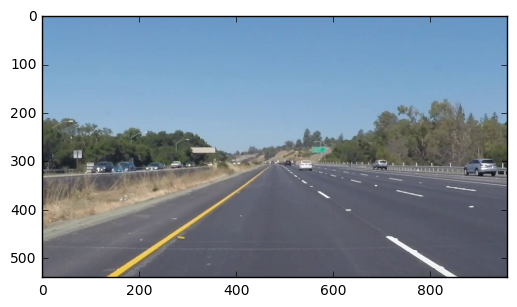

lines angle: [ 18.95800229]
lines angle: [ 17.88354049]
lines angle: [ 24.26298088]
lines angle: [ 21.95733523]
lines angle: [ 17.55610189]
lines angle: [ 20.9900513]
lines angle: [ 21.89518019]
lines angle: [ 18.66606623]
lines angle: [ 25.51904966]
lines angle: [ 23.39284822]
lines angle: [ 18.09350241]
lines angle: [ 18.71971084]
lines angle: [ 17.89684906]
lines angle: [ 17.60089946]
lines angle: [ 17.52019139]
lines angle: [ 17.80369293]
lines angle: [ 17.79282103]
lines angle: [ 17.60592116]
lines angle: [ 17.63690946]
lines angle: [ 17.60432367]
lines angle: [ 17.79734705]
lines angle: [ 18.22533532]
lines angle: [ 17.53425218]
lines angle: [ 17.54115136]
lines angle: [ 17.60672254]
lines angle: [ 18.8262353]


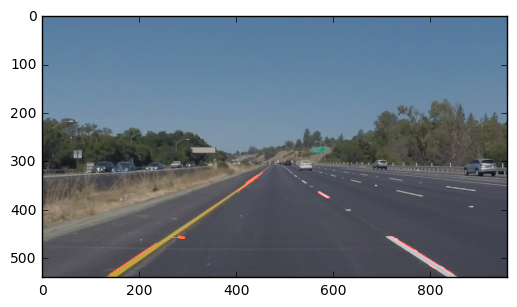

In [101]:
# Extract difficult image from extra challenge
extra_img = clip2.get_frame(4.1)
plt.imshow(extra_img)
plt.show()
plt.imshow(process_image(extra_img))

Image shape is: (720, 1280)


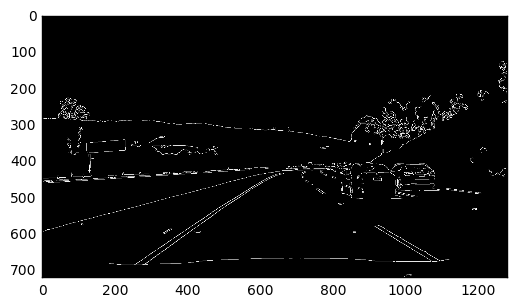

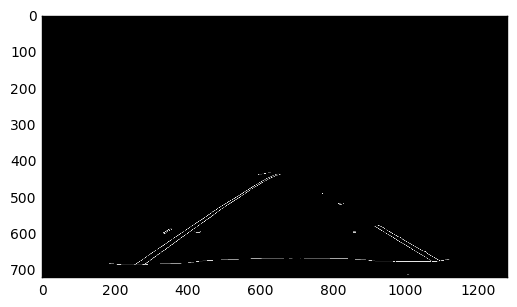

lines:   x1: 469  y1: 673  x1 490  y2 673
lines angle: [ 17.78601419]
lines:   x1: 306  y1: 666  x1 432  y2 577
lines angle: [ 19.54447765]
lines:   x1: 255  y1: 685  x1 517  y2 509
lines angle: [ 24.28297318]
lines:   x1: 913  y1: 580  x1 1054  y2 665
lines angle: [ 23.21669988]
lines:   x1: 561  y1: 670  x1 617  y2 668
lines angle: [ 18.63011064]
lines:   x1: 587  y1: 470  x1 650  y2 436
lines angle: [ 18.42270128]
lines:   x1: 462  y1: 556  x1 512  y2 519
lines angle: [ 18.05664712]
lines:   x1: 925  y1: 578  x1 1093  y2 675
lines angle: [ 25.05720776]
lines:   x1: 775  y1: 668  x1 790  y2 668
lines angle: [ 17.65093385]
lines:   x1: 587  y1: 467  x1 603  y2 456
lines angle: [ 17.55610189]
lines:   x1: 964  y1: 677  x1 1085  y2 677
lines angle: [ 20.74950791]
lines:   x1: 568  y1: 482  x1 586  y2 472
lines angle: [ 17.61075597]
lines:   x1: 567  y1: 479  x1 578  y2 471
lines angle: [ 17.47907201]
lines:   x1: 593  y1: 438  x1 627  y2 433
lines angle: [ 18.03493706]
lines:   x1: 533 

  0%|          | 0/251 [00:00<?, ?it/s]

Image shape is: (720, 1280)


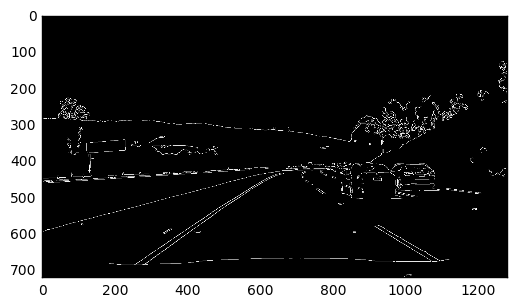

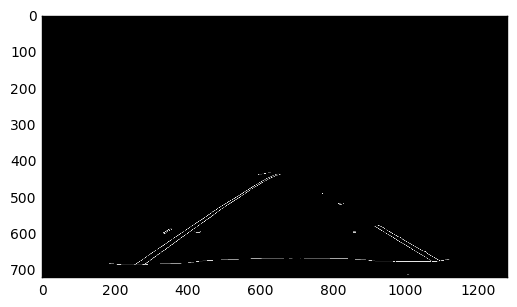

lines:   x1: 469  y1: 673  x1 490  y2 673
lines angle: [ 17.78601419]
lines:   x1: 306  y1: 666  x1 432  y2 577
lines angle: [ 19.54447765]
lines:   x1: 255  y1: 685  x1 517  y2 509
lines angle: [ 24.28297318]
lines:   x1: 913  y1: 580  x1 1054  y2 665
lines angle: [ 23.21669988]
lines:   x1: 561  y1: 670  x1 617  y2 668
lines angle: [ 18.63011064]
lines:   x1: 587  y1: 470  x1 650  y2 436
lines angle: [ 18.42270128]
lines:   x1: 462  y1: 556  x1 512  y2 519
lines angle: [ 18.05664712]
lines:   x1: 925  y1: 578  x1 1093  y2 675
lines angle: [ 25.05720776]
lines:   x1: 775  y1: 668  x1 790  y2 668
lines angle: [ 17.65093385]
lines:   x1: 587  y1: 467  x1 603  y2 456
lines angle: [ 17.55610189]
lines:   x1: 964  y1: 677  x1 1085  y2 677
lines angle: [ 20.74950791]
lines:   x1: 568  y1: 482  x1 586  y2 472
lines angle: [ 17.61075597]
lines:   x1: 567  y1: 479  x1 578  y2 471
lines angle: [ 17.47907201]
lines:   x1: 593  y1: 438  x1 627  y2 433
lines angle: [ 18.03493706]
lines:   x1: 533 

  0%|          | 1/251 [00:01<06:07,  1.47s/it]

Image shape is: (720, 1280)


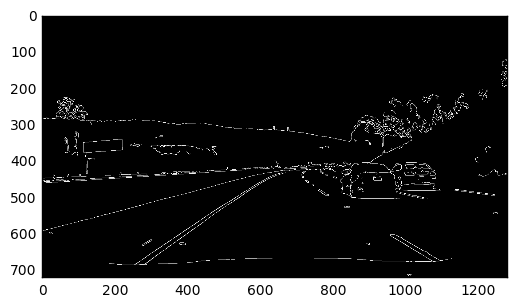

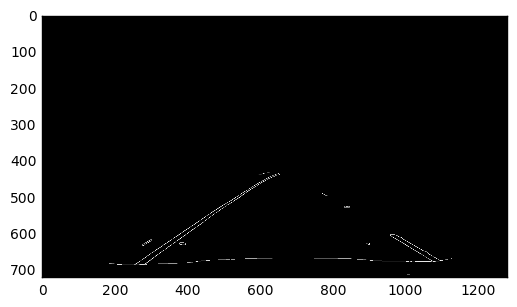

lines:   x1: 252  y1: 686  x1 496  y2 522
lines angle: [ 23.42815704]
lines:   x1: 239  y1: 686  x1 397  y2 681
lines angle: [ 22.24800163]
lines:   x1: 364  y1: 624  x1 531  y2 507
lines angle: [ 20.59004208]
lines:   x1: 287  y1: 623  x1 299  y2 617
lines angle: [ 17.52159773]
lines:   x1: 303  y1: 668  x1 442  y2 570
lines angle: [ 19.85183868]
lines:   x1: 571  y1: 669  x1 656  y2 667
lines angle: [ 19.47115879]
lines:   x1: 601  y1: 461  x1 646  y2 439
lines angle: [ 18.10751517]
lines:   x1: 956  y1: 605  x1 1032  y2 652
lines angle: [ 19.87632945]
lines:   x1: 1068  y1: 676  x1 1089  y2 676
lines angle: [ 17.78601419]
lines:   x1: 450  y1: 674  x1 483  y2 673
lines angle: [ 18.05632196]
lines:   x1: 973  y1: 604  x1 1095  y2 674
lines angle: [ 22.00688019]
lines:   x1: 1061  y1: 656  x1 1094  y2 675
lines angle: [ 18.28655355]
lines:   x1: 506  y1: 516  x1 531  y2 502
lines angle: [ 17.72460682]
lines:   x1: 556  y1: 484  x1 629  y2 442
lines angle: [ 18.59136226]
lines:   x1: 9

  1%|          | 2/251 [00:02<05:54,  1.43s/it]

Image shape is: (720, 1280)


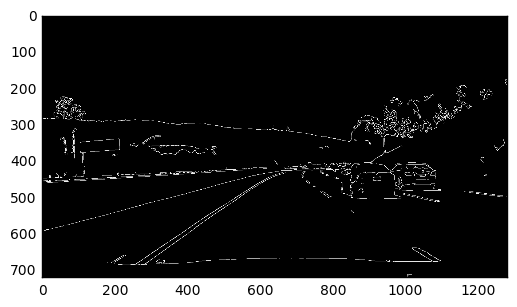

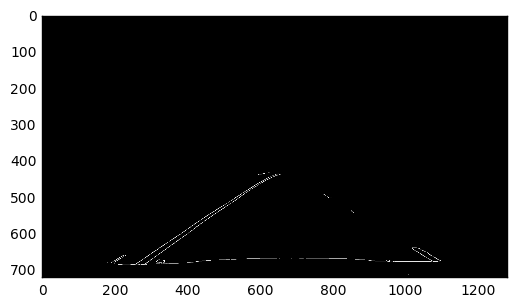

lines:   x1: 258  y1: 686  x1 323  y2 683
lines angle: [ 18.86498209]
lines:   x1: 949  y1: 677  x1 1086  y2 677
lines angle: [ 21.39514843]
lines:   x1: 619  y1: 668  x1 656  y2 667
lines angle: [ 18.15364151]
lines:   x1: 434  y1: 563  x1 623  y2 445
lines angle: [ 21.51246577]
lines:   x1: 284  y1: 683  x1 472  y2 547
lines angle: [ 21.12940397]
lines:   x1: 477  y1: 673  x1 519  y2 671
lines angle: [ 18.26618861]
lines:   x1: 540  y1: 495  x1 601  y2 457
lines angle: [ 18.32198611]
lines:   x1: 374  y1: 682  x1 468  y2 673
lines angle: [ 19.65861148]
lines:   x1: 505  y1: 525  x1 541  y2 502
lines angle: [ 17.87956091]
lines:   x1: 538  y1: 503  x1 555  y2 492
lines angle: [ 17.57805083]
lines:   x1: 256  y1: 685  x1 340  y2 627
lines angle: [ 18.69186896]
lines:   x1: 707  y1: 668  x1 741  y2 668
lines angle: [ 18.09189886]
lines:   x1: 382  y1: 599  x1 407  y2 583
lines angle: [ 17.70287843]
lines:   x1: 356  y1: 682  x1 373  y2 682
lines angle: [ 17.6955492]
lines:   x1: 1064  y

  1%|          | 3/251 [00:04<05:50,  1.41s/it]

Image shape is: (720, 1280)


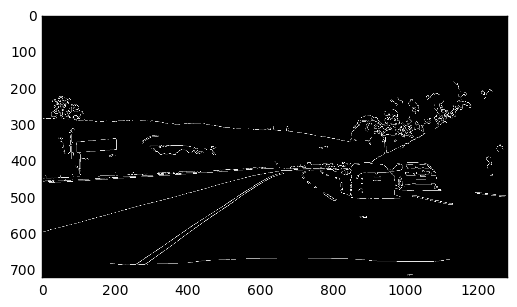

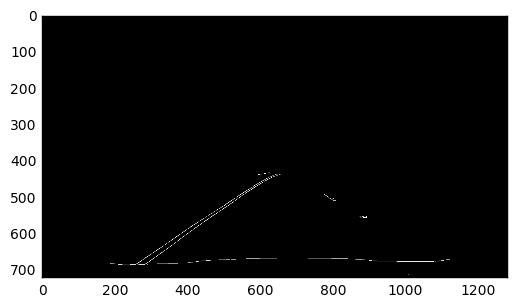

lines:   x1: 506  y1: 518  x1 586  y2 466
lines angle: [ 18.65722907]
lines:   x1: 450  y1: 674  x1 504  y2 672
lines angle: [ 18.57657103]
lines:   x1: 974  y1: 677  x1 1081  y2 677
lines angle: [ 20.23274291]
lines:   x1: 255  y1: 685  x1 465  y2 544
lines angle: [ 22.06260073]
lines:   x1: 377  y1: 616  x1 567  y2 483
lines angle: [ 21.27358275]
lines:   x1: 281  y1: 685  x1 356  y2 682
lines angle: [ 19.15336608]
lines:   x1: 691  y1: 667  x1 729  y2 667
lines angle: [ 18.18985261]
lines:   x1: 418  y1: 576  x1 481  y2 534
lines angle: [ 18.32547042]
lines:   x1: 920  y1: 676  x1 973  y2 676
lines angle: [ 18.57451815]
lines:   x1: 297  y1: 674  x1 387  y2 610
lines angle: [ 18.78380885]
lines:   x1: 283  y1: 684  x1 370  y2 623
lines angle: [ 18.7375725]
lines:   x1: 614  y1: 454  x1 639  y2 442
lines angle: [ 17.7463869]
lines:   x1: 599  y1: 668  x1 644  y2 668
lines angle: [ 18.36586597]
lines:   x1: 623  y1: 445  x1 637  y2 440
lines angle: [ 17.57574003]
lines:   x1: 1095  y1

  2%|▏         | 4/251 [00:05<05:44,  1.40s/it]

Image shape is: (720, 1280)


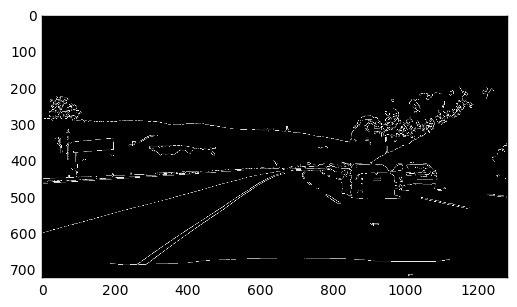

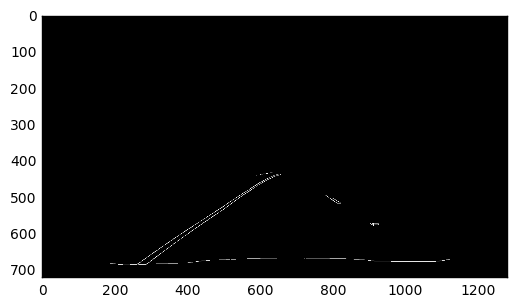

lines:   x1: 223  y1: 686  x1 313  y2 684
lines angle: [ 19.62959049]
lines:   x1: 687  y1: 667  x1 743  y2 668
lines angle: [ 18.66734154]
lines:   x1: 959  y1: 677  x1 1082  y2 677
lines angle: [ 20.82685126]
lines:   x1: 451  y1: 674  x1 628  y2 668
lines angle: [ 23.19728966]
lines:   x1: 323  y1: 640  x1 505  y2 521
lines angle: [ 21.18051851]
lines:   x1: 361  y1: 614  x1 601  y2 458
lines angle: [ 23.37862739]
lines:   x1: 342  y1: 642  x1 489  y2 539
lines angle: [ 20.05922395]
lines:   x1: 374  y1: 681  x1 399  y2 681
lines angle: [ 17.87816279]
lines:   x1: 557  y1: 492  x1 598  y2 464
lines angle: [ 17.94180247]
lines:   x1: 804  y1: 669  x1 835  y2 669
lines angle: [ 18.01964564]
lines:   x1: 764  y1: 668  x1 801  y2 669
lines angle: [ 18.17674981]
lines:   x1: 810  y1: 511  x1 821  y2 515
lines angle: [ 17.60512154]
lines:   x1: 491  y1: 539  x1 579  y2 476
lines angle: [ 18.7399298]
lines:   x1: 347  y1: 682  x1 373  y2 682
lines angle: [ 17.90146847]
lines:   x1: 613  y1

  2%|▏         | 5/251 [00:06<05:29,  1.34s/it]

Image shape is: (720, 1280)


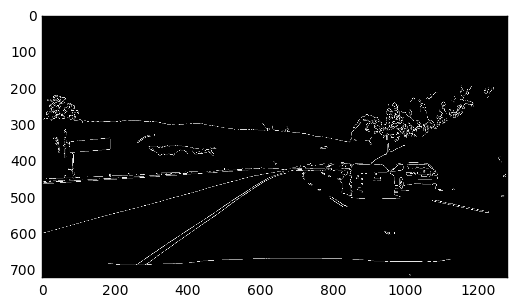

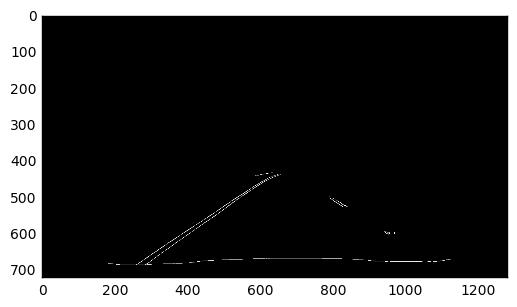

lines:   x1: 309  y1: 667  x1 597  y2 465
lines angle: [ 25.4549631]
lines:   x1: 260  y1: 685  x1 434  y2 568
lines angle: [ 20.87536519]
lines:   x1: 346  y1: 683  x1 374  y2 682
lines angle: [ 17.93723379]
lines:   x1: 457  y1: 674  x1 638  y2 668
lines angle: [ 23.41788468]
lines:   x1: 788  y1: 500  x1 827  y2 527
lines angle: [ 18.53424416]
lines:   x1: 430  y1: 572  x1 593  y2 463
lines angle: [ 20.56754932]
lines:   x1: 870  y1: 672  x1 894  y2 673
lines angle: [ 17.86599253]
lines:   x1: 770  y1: 669  x1 852  y2 670
lines angle: [ 19.41948023]
lines:   x1: 366  y1: 626  x1 446  y2 570
lines angle: [ 18.60632599]
lines:   x1: 973  y1: 677  x1 1029  y2 677
lines angle: [ 18.65491531]
lines:   x1: 507  y1: 527  x1 584  y2 473
lines angle: [ 18.54945022]
lines:   x1: 586  y1: 441  x1 630  y2 433
lines angle: [ 18.2459452]
lines:   x1: 214  y1: 686  x1 258  y2 686
lines angle: [ 18.3403546]
lines:   x1: 799  y1: 503  x1 837  y2 526
lines angle: [ 18.46041536]
lines:   x1: 397  y1: 

  2%|▏         | 6/251 [00:07<05:14,  1.28s/it]

Image shape is: (720, 1280)


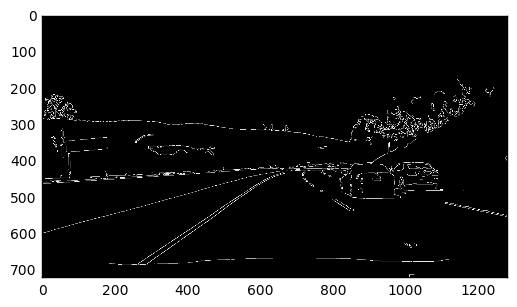

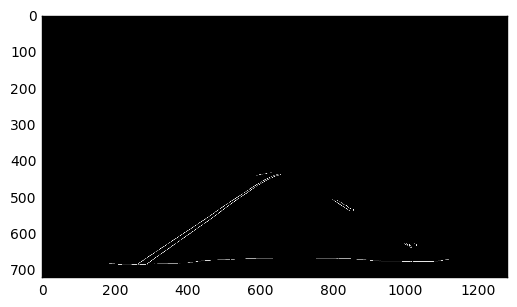

lines:   x1: 360  y1: 619  x1 594  y2 462
lines angle: [ 23.00210675]
lines:   x1: 284  y1: 685  x1 492  y2 539
lines angle: [ 21.86137436]
lines:   x1: 448  y1: 674  x1 528  y2 671
lines angle: [ 19.30328958]
lines:   x1: 260  y1: 685  x1 391  y2 597
lines angle: [ 19.72752033]
lines:   x1: 516  y1: 670  x1 587  y2 669
lines angle: [ 19.06251463]
lines:   x1: 264  y1: 686  x1 399  y2 681
lines angle: [ 21.2234883]
lines:   x1: 261  y1: 685  x1 278  y2 674
lines angle: [ 17.57805083]
lines:   x1: 989  y1: 677  x1 1076  y2 677
lines angle: [ 19.56215847]
lines:   x1: 807  y1: 507  x1 856  y2 536
lines angle: [ 18.8262353]
lines:   x1: 901  y1: 674  x1 946  y2 676
lines angle: [ 18.38970579]
lines:   x1: 498  y1: 533  x1 561  y2 490
lines angle: [ 18.3133862]
lines:   x1: 660  y1: 667  x1 716  y2 667
lines angle: [ 18.65491531]
lines:   x1: 787  y1: 668  x1 824  y2 669
lines angle: [ 18.17674981]
lines:   x1: 287  y1: 684  x1 468  y2 557
lines angle: [ 20.99147382]
lines:   x1: 798  y1: 

  3%|▎         | 7/251 [00:08<04:56,  1.22s/it]

Image shape is: (720, 1280)


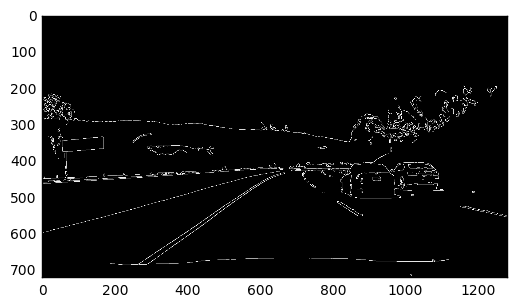

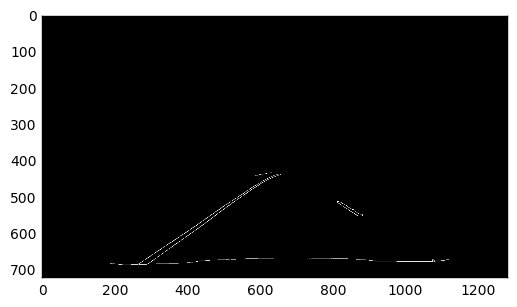

lines:   x1: 588  y1: 467  x1 604  y2 456
lines angle: [ 17.55610189]
lines:   x1: 548  y1: 499  x1 590  y2 469
lines angle: [ 17.94303191]
lines:   x1: 422  y1: 591  x1 533  y2 508
lines angle: [ 19.15096677]
lines:   x1: 426  y1: 575  x1 586  y2 467
lines angle: [ 20.46670449]
lines:   x1: 743  y1: 668  x1 771  y2 668
lines angle: [ 17.94840729]
lines:   x1: 429  y1: 676  x1 545  y2 670
lines angle: [ 20.46433872]
lines:   x1: 289  y1: 684  x1 313  y2 684
lines angle: [ 17.85496526]
lines:   x1: 612  y1: 668  x1 649  y2 667
lines angle: [ 18.15364151]
lines:   x1: 810  y1: 514  x1 869  y2 552
lines angle: [ 19.22600627]
lines:   x1: 815  y1: 669  x1 897  y2 673
lines angle: [ 19.46100616]
lines:   x1: 264  y1: 685  x1 338  y2 634
lines angle: [ 18.50575728]
lines:   x1: 672  y1: 667  x1 700  y2 667
lines angle: [ 17.94840729]
lines:   x1: 398  y1: 680  x1 413  y2 679
lines angle: [ 17.64026433]
lines:   x1: 1075  y1: 676  x1 1089  y2 676
lines angle: [ 17.62877803]
lines:   x1: 386  

  3%|▎         | 8/251 [00:10<05:01,  1.24s/it]

Image shape is: (720, 1280)


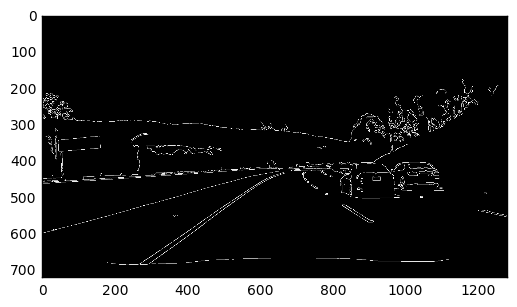

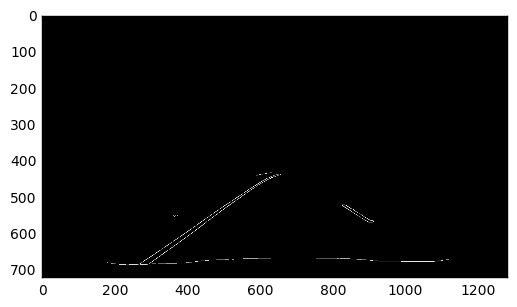

lines:   x1: 447  y1: 674  x1 551  y2 670
lines angle: [ 20.06679215]
lines:   x1: 668  y1: 667  x1 724  y2 667
lines angle: [ 18.65491531]
lines:   x1: 548  y1: 499  x1 597  y2 464
lines angle: [ 18.05526643]
lines:   x1: 1038  y1: 677  x1 1066  y2 677
lines angle: [ 17.94840729]
lines:   x1: 443  y1: 574  x1 574  y2 479
lines angle: [ 19.62251683]
lines:   x1: 264  y1: 685  x1 442  y2 565
lines angle: [ 20.9900513]
lines:   x1: 416  y1: 582  x1 592  y2 463
lines angle: [ 20.92348684]
lines:   x1: 838  y1: 669  x1 928  y2 676
lines angle: [ 19.75848339]
lines:   x1: 291  y1: 684  x1 405  y2 604
lines angle: [ 19.28658496]
lines:   x1: 594  y1: 463  x1 609  y2 453
lines angle: [ 17.54479782]
lines:   x1: 271  y1: 685  x1 327  y2 683
lines angle: [ 18.63011064]
lines:   x1: 824  y1: 523  x1 898  y2 569
lines angle: [ 19.79714855]
lines:   x1: 830  y1: 521  x1 909  y2 568
lines angle: [ 19.97510745]
lines:   x1: 971  y1: 676  x1 993  y2 677
lines angle: [ 17.81984059]
lines:   x1: 329  y

  4%|▎         | 9/251 [00:11<04:55,  1.22s/it]

Image shape is: (720, 1280)


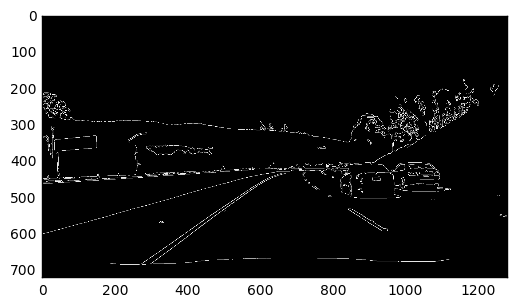

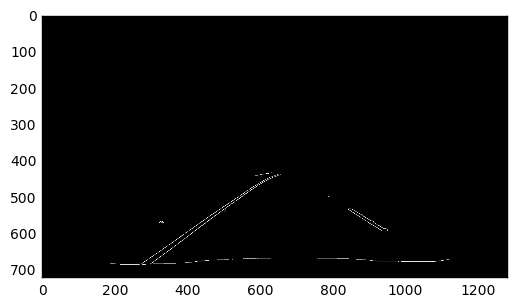

lines:   x1: 316  y1: 683  x1 404  y2 680
lines angle: [ 19.55160288]
lines:   x1: 420  y1: 677  x1 446  y2 675
lines angle: [ 17.87929514]
lines:   x1: 445  y1: 562  x1 580  y2 471
lines angle: [ 19.81971967]
lines:   x1: 740  y1: 667  x1 757  y2 667
lines angle: [ 17.6955492]
lines:   x1: 908  y1: 675  x1 1035  y2 677
lines angle: [ 21.01816507]
lines:   x1: 414  y1: 596  x1 575  y2 479
lines angle: [ 20.35518787]
lines:   x1: 600  y1: 464  x1 627  y2 445
lines angle: [ 17.71561447]
lines:   x1: 401  y1: 593  x1 601  y2 458
lines angle: [ 21.69545418]
lines:   x1: 842  y1: 534  x1 933  y2 593
lines angle: [ 20.5723741]
lines:   x1: 852  y1: 533  x1 948  y2 592
lines angle: [ 20.75654952]
lines:   x1: 588  y1: 668  x1 628  y2 668
lines angle: [ 18.23953695]
lines:   x1: 288  y1: 672  x1 392  y2 601
lines angle: [ 19.10252395]
lines:   x1: 265  y1: 685  x1 286  y2 675
lines angle: [ 17.67762137]
lines:   x1: 1060  y1: 677  x1 1095  y2 675
lines angle: [ 18.09330214]
lines:   x1: 755  y

  4%|▍         | 10/251 [00:12<05:04,  1.26s/it]

Image shape is: (720, 1280)


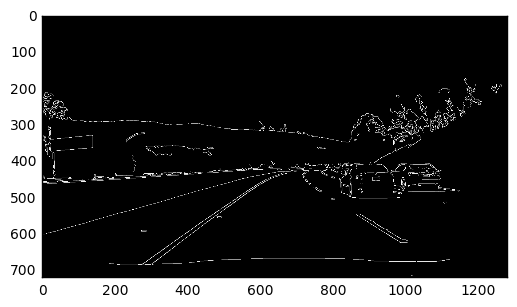

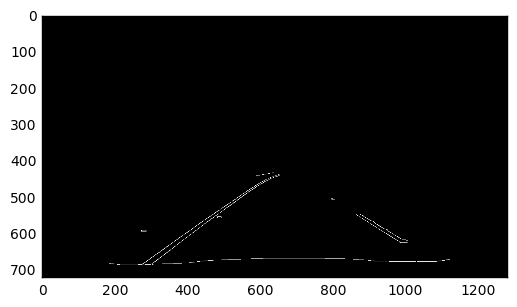

lines:   x1: 607  y1: 668  x1 776  y2 668
lines angle: [ 22.8994041]
lines:   x1: 459  y1: 565  x1 553  y2 495
lines angle: [ 18.81989843]
lines:   x1: 434  y1: 676  x1 555  y2 670
lines angle: [ 20.65147982]
lines:   x1: 301  y1: 684  x1 394  y2 612
lines angle: [ 18.76489239]
lines:   x1: 293  y1: 671  x1 510  y2 519
lines angle: [ 22.18875612]
lines:   x1: 215  y1: 686  x1 305  y2 685
lines angle: [ 19.6438321]
lines:   x1: 599  y1: 464  x1 648  y2 441
lines angle: [ 18.19514016]
lines:   x1: 862  y1: 548  x1 986  y2 625
lines angle: [ 22.22743424]
lines:   x1: 1028  y1: 678  x1 1083  y2 677
lines angle: [ 18.61562046]
lines:   x1: 777  y1: 669  x1 832  y2 669
lines angle: [ 18.62798258]
lines:   x1: 872  y1: 546  x1 991  y2 617
lines angle: [ 21.89232229]
lines:   x1: 419  y1: 595  x1 476  y2 551
lines angle: [ 18.148563]
lines:   x1: 487  y1: 536  x1 578  y2 473
lines angle: [ 18.82559824]
lines:   x1: 606  y1: 456  x1 648  y2 438
lines angle: [ 18.08016397]
lines:   x1: 570  y1: 

  4%|▍         | 11/251 [00:14<05:00,  1.25s/it]

Image shape is: (720, 1280)


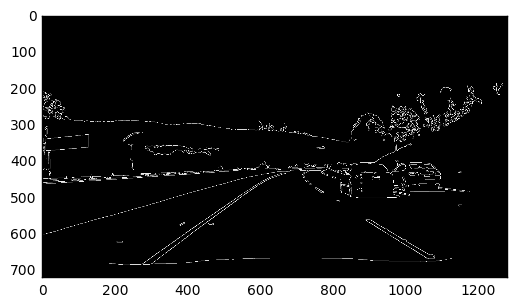

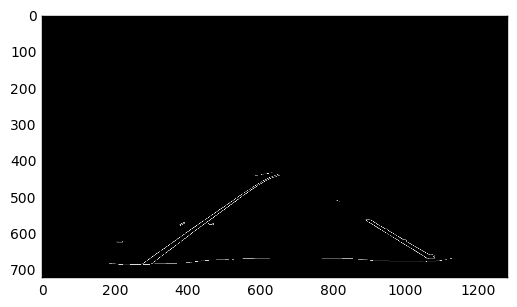

lines:   x1: 299  y1: 684  x1 503  y2 531
lines angle: [ 21.53074818]
lines:   x1: 322  y1: 651  x1 436  y2 569
lines angle: [ 19.2583309]
lines:   x1: 331  y1: 683  x1 359  y2 682
lines angle: [ 17.93723379]
lines:   x1: 274  y1: 685  x1 407  y2 589
lines angle: [ 19.67519618]
lines:   x1: 903  y1: 563  x1 1061  y2 657
lines angle: [ 24.36340784]
lines:   x1: 432  y1: 572  x1 604  y2 456
lines angle: [ 20.81011274]
lines:   x1: 889  y1: 563  x1 1071  y2 676
lines angle: [ 26.45232583]
lines:   x1: 506  y1: 529  x1 603  y2 461
lines angle: [ 18.93389047]
lines:   x1: 620  y1: 667  x1 771  y2 667
lines angle: [ 22.01499754]
lines:   x1: 210  y1: 685  x1 222  y2 685
lines angle: [ 17.58476671]
lines:   x1: 958  y1: 676  x1 1014  y2 676
lines angle: [ 18.65491531]
lines:   x1: 890  y1: 564  x1 1056  y2 668
lines angle: [ 25.10172502]
lines:   x1: 267  y1: 685  x1 295  y2 685
lines angle: [ 17.94840729]
lines:   x1: 411  y1: 679  x1 439  y2 675
lines angle: [ 17.90379388]
lines:   x1: 899 

  5%|▍         | 12/251 [00:15<04:58,  1.25s/it]

Image shape is: (720, 1280)


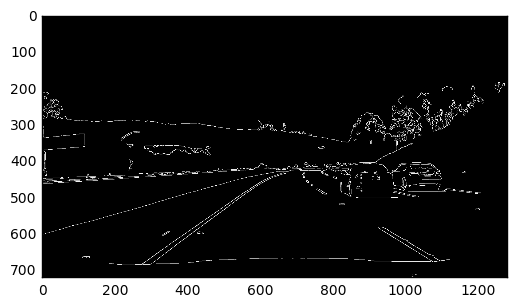

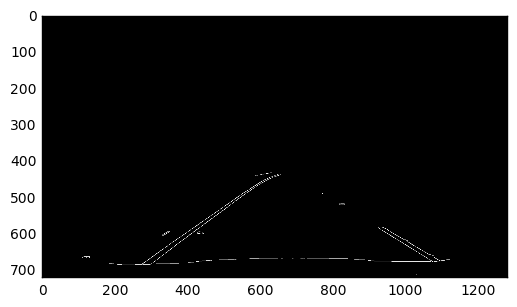

lines:   x1: 612  y1: 668  x1 725  y2 667
lines angle: [ 20.43328581]
lines:   x1: 301  y1: 683  x1 367  y2 633
lines angle: [ 18.30648121]
lines:   x1: 382  y1: 620  x1 448  y2 573
lines angle: [ 18.34287539]
lines:   x1: 270  y1: 685  x1 313  y2 684
lines angle: [ 18.30315868]
lines:   x1: 368  y1: 618  x1 572  y2 476
lines angle: [ 21.7477602]
lines:   x1: 923  y1: 583  x1 1075  y2 678
lines angle: [ 24.03486916]
lines:   x1: 951  y1: 592  x1 1009  y2 625
lines angle: [ 19.13117851]
lines:   x1: 584  y1: 468  x1 629  y2 444
lines angle: [ 18.08437665]
lines:   x1: 840  y1: 670  x1 887  y2 672
lines angle: [ 18.44128464]
lines:   x1: 767  y1: 668  x1 804  y2 669
lines angle: [ 18.17674981]
lines:   x1: 339  y1: 683  x1 381  y2 681
lines angle: [ 18.26618861]
lines:   x1: 184  y1: 682  x1 223  y2 686
lines angle: [ 18.26131107]
lines:   x1: 1015  y1: 630  x1 1077  y2 665
lines angle: [ 19.27475664]
lines:   x1: 113  y1: 664  x1 127  y2 663
lines angle: [ 17.61814565]
lines:   x1: 609 

  5%|▌         | 13/251 [00:16<05:26,  1.37s/it]

Image shape is: (720, 1280)


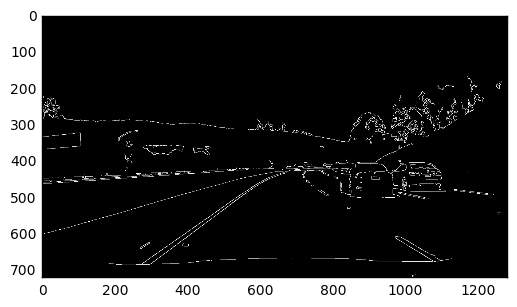

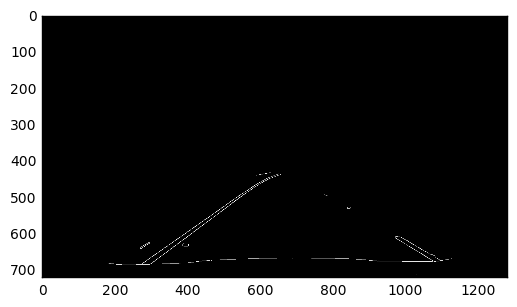

lines:   x1: 272  y1: 685  x1 581  y2 469
lines angle: [ 26.79585663]
lines:   x1: 284  y1: 685  x1 359  y2 682
lines angle: [ 19.15336608]
lines:   x1: 479  y1: 539  x1 546  y2 492
lines angle: [ 18.36902472]
lines:   x1: 983  y1: 609  x1 1068  y2 658
lines angle: [ 20.20747078]
lines:   x1: 433  y1: 584  x1 573  y2 479
lines angle: [ 19.77919067]
lines:   x1: 953  y1: 676  x1 987  y2 676
lines angle: [ 18.09189886]
lines:   x1: 764  y1: 668  x1 792  y2 668
lines angle: [ 17.94840729]
lines:   x1: 988  y1: 677  x1 1082  y2 677
lines angle: [ 19.78847138]
lines:   x1: 300  y1: 683  x1 542  y2 501
lines angle: [ 22.88425812]
lines:   x1: 614  y1: 454  x1 655  y2 438
lines angle: [ 18.07876627]
lines:   x1: 298  y1: 684  x1 388  y2 616
lines angle: [ 18.73164845]
lines:   x1: 969  y1: 611  x1 1074  y2 676
lines angle: [ 21.20200862]
lines:   x1: 270  y1: 641  x1 295  y2 626
lines angle: [ 17.71373618]
lines:   x1: 462  y1: 673  x1 620  y2 668
lines angle: [ 22.24800163]
lines:   x1: 204 

  6%|▌         | 14/251 [00:18<05:06,  1.30s/it]

Image shape is: (720, 1280)


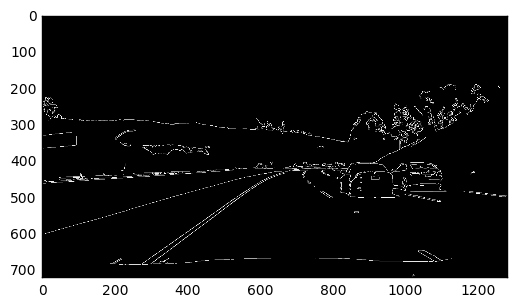

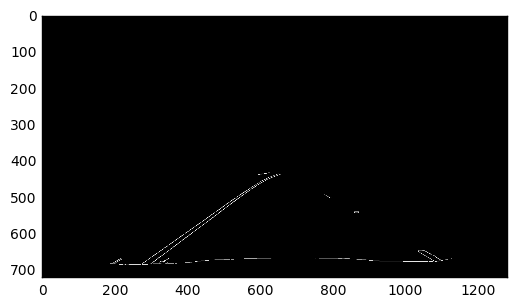

lines:   x1: 336  y1: 639  x1 553  y2 487
lines angle: [ 22.18875612]
lines:   x1: 303  y1: 681  x1 565  y2 484
lines angle: [ 23.7368043]
lines:   x1: 555  y1: 669  x1 590  y2 669
lines angle: [ 18.11621251]
lines:   x1: 825  y1: 668  x1 890  y2 672
lines angle: [ 18.95511151]
lines:   x1: 297  y1: 684  x1 429  y2 585
lines angle: [ 19.59649402]
lines:   x1: 339  y1: 682  x1 405  y2 680
lines angle: [ 18.90603336]
lines:   x1: 273  y1: 684  x1 583  y2 467
lines angle: [ 26.85377349]
lines:   x1: 932  y1: 676  x1 960  y2 676
lines angle: [ 17.94840729]
lines:   x1: 1064  y1: 677  x1 1100  y2 674
lines angle: [ 18.10617094]
lines:   x1: 1033  y1: 649  x1 1057  y2 663
lines angle: [ 18.0105552]
lines:   x1: 991  y1: 677  x1 1006  y2 677
lines angle: [ 17.65093385]
lines:   x1: 630  y1: 667  x1 759  y2 667
lines angle: [ 21.06450711]
lines:   x1: 1038  y1: 653  x1 1081  y2 677
lines angle: [ 18.60284269]
lines:   x1: 1049  y1: 647  x1 1080  y2 663
lines angle: [ 18.20225715]
lines:   x1: 

  6%|▌         | 15/251 [00:19<05:10,  1.32s/it]

Image shape is: (720, 1280)


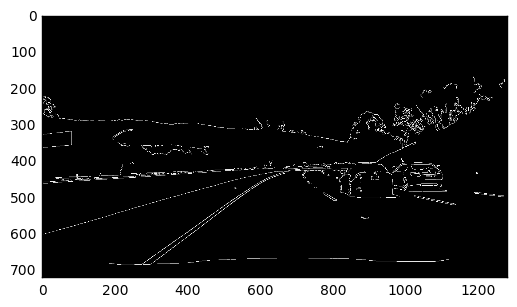

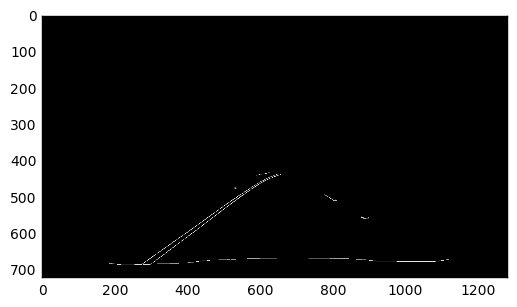

lines:   x1: 266  y1: 685  x1 399  y2 681
lines angle: [ 21.15845694]
lines:   x1: 297  y1: 685  x1 548  y2 496
lines angle: [ 23.24868777]
lines:   x1: 301  y1: 683  x1 575  y2 477
lines angle: [ 24.30336937]
lines:   x1: 732  y1: 668  x1 770  y2 668
lines angle: [ 18.18985261]
lines:   x1: 275  y1: 684  x1 427  y2 577
lines angle: [ 20.17894588]
lines:   x1: 395  y1: 598  x1 449  y2 561
lines angle: [ 18.15580398]
lines:   x1: 577  y1: 471  x1 602  y2 456
lines angle: [ 17.71373618]
lines:   x1: 453  y1: 674  x1 532  y2 671
lines angle: [ 19.27298804]
lines:   x1: 608  y1: 453  x1 650  y2 436
lines angle: [ 18.09168315]
lines:   x1: 1044  y1: 677  x1 1072  y2 677
lines angle: [ 17.94840729]
lines:   x1: 843  y1: 670  x1 855  y2 670
lines angle: [ 17.58476671]
lines:   x1: 931  y1: 676  x1 949  y2 676
lines angle: [ 17.71801011]
lines:   x1: 231  y1: 686  x1 253  y2 686
lines angle: [ 17.80889169]
lines:   x1: 772  y1: 491  x1 802  y2 509
lines angle: [ 18.20072598]
lines:   x1: 563  

  6%|▋         | 16/251 [00:20<04:46,  1.22s/it]

Image shape is: (720, 1280)


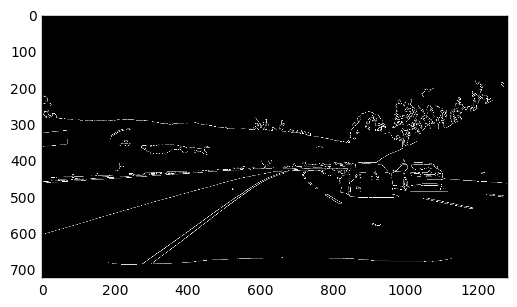

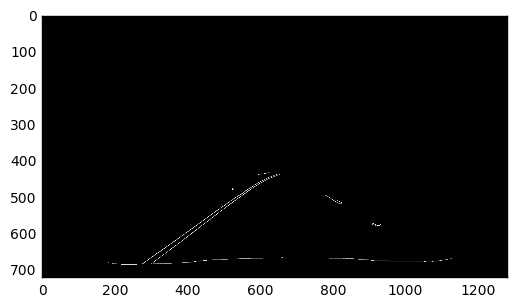

lines:   x1: 300  y1: 683  x1 574  y2 477
lines angle: [ 24.30336937]
lines:   x1: 544  y1: 494  x1 593  y2 460
lines angle: [ 18.06684313]
lines:   x1: 241  y1: 685  x1 400  y2 680
lines angle: [ 22.29607829]
lines:   x1: 319  y1: 653  x1 506  y2 518
lines angle: [ 21.10418316]
lines:   x1: 608  y1: 667  x1 787  y2 667
lines angle: [ 23.4394365]
lines:   x1: 808  y1: 668  x1 896  y2 672
lines angle: [ 19.65071969]
lines:   x1: 413  y1: 597  x1 543  y2 499
lines angle: [ 19.54446856]
lines:   x1: 541  y1: 669  x1 574  y2 669
lines angle: [ 18.06770037]
lines:   x1: 986  y1: 676  x1 1042  y2 676
lines angle: [ 18.65491531]
lines:   x1: 545  y1: 499  x1 583  y2 471
lines angle: [ 17.870645]
lines:   x1: 276  y1: 683  x1 348  y2 631
lines angle: [ 18.43974435]
lines:   x1: 593  y1: 438  x1 623  y2 433
lines angle: [ 17.93965016]
lines:   x1: 807  y1: 507  x1 822  y2 516
lines angle: [ 17.74752468]
lines:   x1: 599  y1: 457  x1 609  y2 453
lines angle: [ 17.49927989]
lines:   x1: 428  y1: 

  7%|▋         | 17/251 [00:21<04:40,  1.20s/it]

Image shape is: (720, 1280)


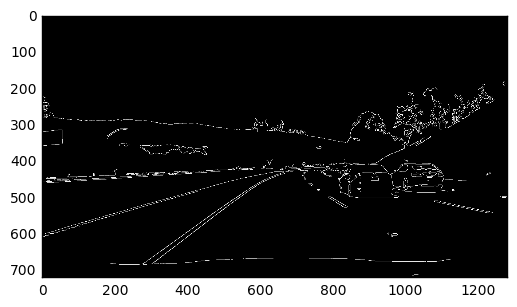

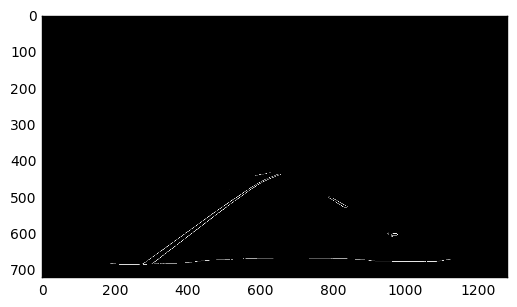

lines:   x1: 795  y1: 669  x1 859  y2 670
lines angle: [ 18.88814717]
lines:   x1: 373  y1: 628  x1 544  y2 499
lines angle: [ 20.54410669]
lines:   x1: 427  y1: 676  x1 561  y2 669
lines angle: [ 21.147586]
lines:   x1: 275  y1: 684  x1 387  y2 605
lines angle: [ 19.23790928]
lines:   x1: 385  y1: 605  x1 572  y2 474
lines angle: [ 21.17801484]
lines:   x1: 300  y1: 684  x1 448  y2 572
lines angle: [ 19.95313263]
lines:   x1: 528  y1: 505  x1 583  y2 467
lines angle: [ 18.1690998]
lines:   x1: 961  y1: 677  x1 1083  y2 677
lines angle: [ 20.78806478]
lines:   x1: 318  y1: 683  x1 355  y2 682
lines angle: [ 18.15364151]
lines:   x1: 182  y1: 681  x1 216  y2 685
lines angle: [ 18.13771929]
lines:   x1: 278  y1: 685  x1 325  y2 682
lines angle: [ 18.38134432]
lines:   x1: 808  y1: 515  x1 833  y2 528
lines angle: [ 18.02307246]
lines:   x1: 360  y1: 623  x1 412  y2 587
lines angle: [ 18.11766341]
lines:   x1: 634  y1: 667  x1 732  y2 667
lines angle: [ 19.9217505]
lines:   x1: 564  y1: 4

  7%|▋         | 18/251 [00:22<04:37,  1.19s/it]

Image shape is: (720, 1280)


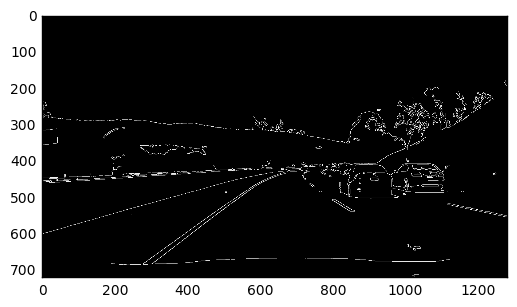

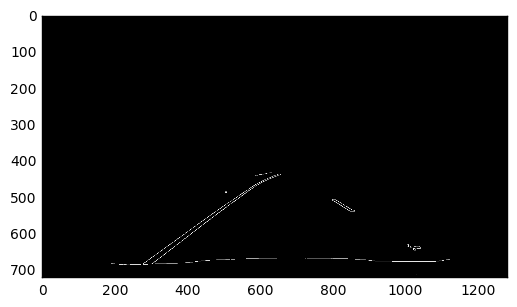

lines:   x1: 722  y1: 668  x1 797  y2 668
lines angle: [ 19.19348331]
lines:   x1: 603  y1: 668  x1 644  y2 668
lines angle: [ 18.26455895]
lines:   x1: 541  y1: 495  x1 608  y2 453
lines angle: [ 18.43022989]
lines:   x1: 1007  y1: 637  x1 1035  y2 635
lines angle: [ 17.92607374]
lines:   x1: 303  y1: 683  x1 352  y2 644
lines angle: [ 18.00910273]
lines:   x1: 277  y1: 684  x1 488  y2 531
lines angle: [ 21.86659373]
lines:   x1: 359  y1: 625  x1 517  y2 511
lines angle: [ 20.29019003]
lines:   x1: 212  y1: 685  x1 290  y2 685
lines angle: [ 19.28346289]
lines:   x1: 380  y1: 624  x1 439  y2 577
lines angle: [ 18.16341391]
lines:   x1: 645  y1: 667  x1 727  y2 667
lines angle: [ 19.40567609]
lines:   x1: 840  y1: 669  x1 930  y2 676
lines angle: [ 19.75848339]
lines:   x1: 365  y1: 682  x1 490  y2 672
lines angle: [ 20.73911281]
lines:   x1: 797  y1: 508  x1 847  y2 539
lines angle: [ 18.87897805]
lines:   x1: 469  y1: 554  x1 576  y2 476
lines angle: [ 19.09755767]
lines:   x1: 432  

  8%|▊         | 19/251 [00:23<04:36,  1.19s/it]

Image shape is: (720, 1280)


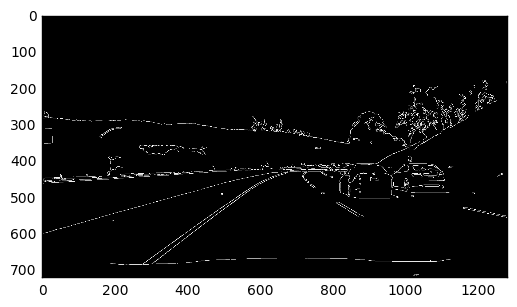

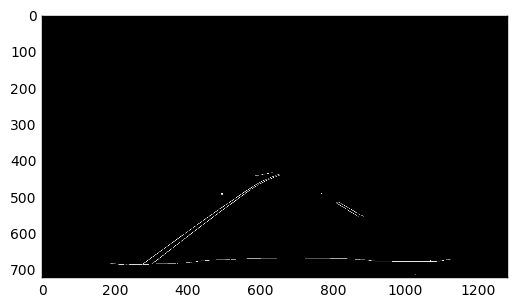

lines:   x1: 581  y1: 669  x1 666  y2 667
lines angle: [ 19.47115879]
lines:   x1: 380  y1: 608  x1 547  y2 491
lines angle: [ 20.59004208]
lines:   x1: 428  y1: 676  x1 542  y2 670
lines angle: [ 20.39099679]
lines:   x1: 914  y1: 676  x1 959  y2 676
lines angle: [ 18.36586597]
lines:   x1: 357  y1: 640  x1 531  y2 509
lines angle: [ 20.63007016]
lines:   x1: 273  y1: 685  x1 374  y2 614
lines angle: [ 19.01212122]
lines:   x1: 550  y1: 489  x1 612  y2 452
lines angle: [ 18.36002423]
lines:   x1: 809  y1: 516  x1 871  y2 555
lines angle: [ 19.32815279]
lines:   x1: 260  y1: 685  x1 405  y2 680
lines angle: [ 21.65062327]
lines:   x1: 565  y1: 484  x1 582  y2 474
lines angle: [ 17.58867002]
lines:   x1: 752  y1: 668  x1 780  y2 668
lines angle: [ 17.94840729]
lines:   x1: 617  y1: 450  x1 650  y2 437
lines angle: [ 17.92085414]
lines:   x1: 584  y1: 442  x1 633  y2 433
lines angle: [ 18.36099504]
lines:   x1: 818  y1: 515  x1 882  y2 553
lines angle: [ 19.37473001]
lines:   x1: 958  y1

  8%|▊         | 20/251 [00:25<04:39,  1.21s/it]

Image shape is: (720, 1280)


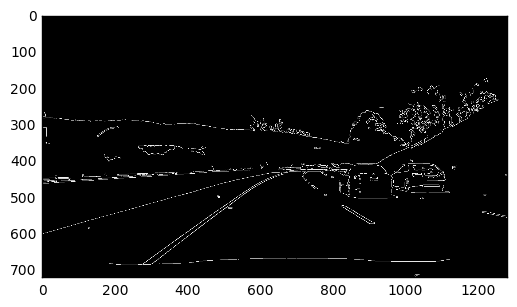

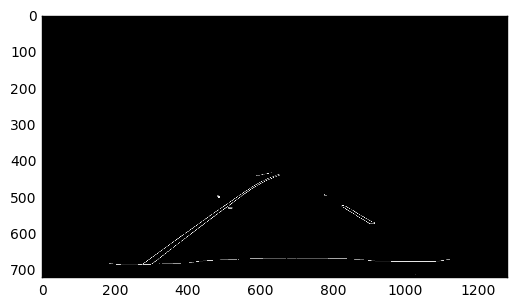

lines:   x1: 717  y1: 668  x1 745  y2 668
lines angle: [ 17.94840729]
lines:   x1: 301  y1: 684  x1 368  y2 633
lines angle: [ 18.32034247]
lines:   x1: 284  y1: 685  x1 324  y2 683
lines angle: [ 18.21619864]
lines:   x1: 277  y1: 684  x1 479  y2 538
lines angle: [ 21.57382403]
lines:   x1: 454  y1: 674  x1 634  y2 668
lines angle: [ 23.36215292]
lines:   x1: 442  y1: 575  x1 586  y2 470
lines angle: [ 19.9198458]
lines:   x1: 349  y1: 683  x1 410  y2 680
lines angle: [ 18.75370536]
lines:   x1: 823  y1: 524  x1 901  y2 573
lines angle: [ 19.97098372]
lines:   x1: 443  y1: 675  x1 453  y2 675
lines angle: [ 17.54115136]
lines:   x1: 810  y1: 669  x1 895  y2 673
lines angle: [ 19.55509623]
lines:   x1: 610  y1: 453  x1 651  y2 437
lines angle: [ 18.07876627]
lines:   x1: 591  y1: 467  x1 645  y2 442
lines angle: [ 18.29797696]
lines:   x1: 829  y1: 523  x1 913  y2 571
lines angle: [ 20.1582416]
lines:   x1: 958  y1: 677  x1 987  y2 677
lines angle: [ 17.97204195]
lines:   x1: 274  y1: 

  8%|▊         | 21/251 [00:26<04:44,  1.24s/it]

Image shape is: (720, 1280)


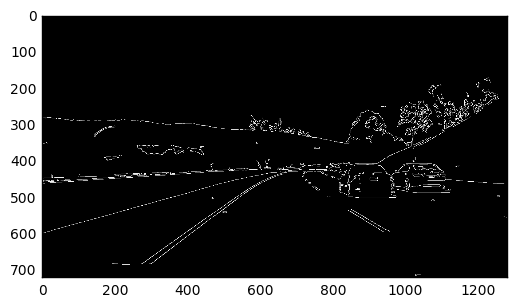

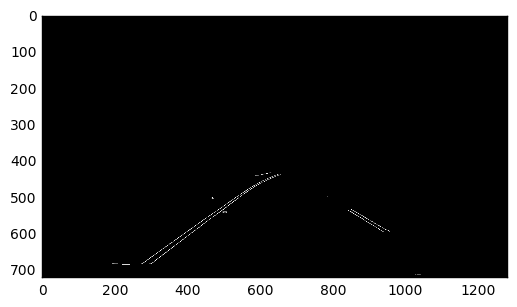

lines:   x1: 298  y1: 683  x1 559  y2 487
lines angle: [ 23.69789951]
lines:   x1: 458  y1: 553  x1 579  y2 469
lines angle: [ 19.45343707]
lines:   x1: 861  y1: 549  x1 939  y2 596
lines angle: [ 19.94200234]
lines:   x1: 275  y1: 683  x1 444  y2 561
lines angle: [ 20.58423595]
lines:   x1: 879  y1: 550  x1 939  y2 587
lines angle: [ 19.24219399]
lines:   x1: 242  y1: 684  x1 292  y2 684
lines angle: [ 18.49530943]
lines:   x1: 579  y1: 475  x1 605  y2 455
lines angle: [ 17.6821016]
lines:   x1: 596  y1: 465  x1 618  y2 449
lines angle: [ 17.63546373]
lines:   x1: 840  y1: 535  x1 886  y2 563
lines angle: [ 18.73208377]
lines:   x1: 617  y1: 453  x1 656  y2 438
lines angle: [ 18.04163518]
lines:   x1: 208  y1: 684  x1 241  y2 685
lines angle: [ 18.07909264]
lines:   x1: 567  y1: 483  x1 580  y2 473
lines angle: [ 17.50132076]
lines:   x1: 611  y1: 457  x1 625  y2 446
lines angle: [ 17.51250103]
lines:   x1: 490  y1: 530  x1 500  y2 543
lines angle: [ 17.67858379]
lines:   x1: 594  y1:

  9%|▉         | 22/251 [00:27<04:30,  1.18s/it]

Image shape is: (720, 1280)


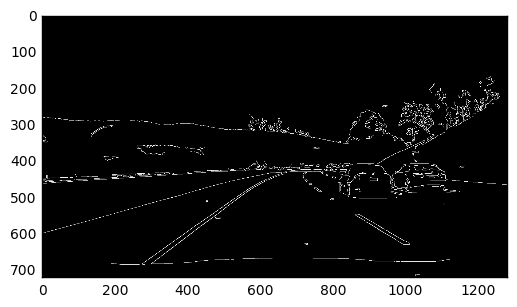

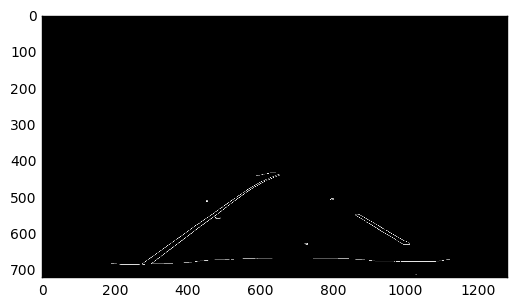

lines:   x1: 279  y1: 681  x1 434  y2 569
lines angle: [ 20.20979266]
lines:   x1: 297  y1: 684  x1 561  y2 486
lines angle: [ 23.84102852]
lines:   x1: 561  y1: 481  x1 604  y2 456
lines angle: [ 18.02411021]
lines:   x1: 745  y1: 668  x1 812  y2 668
lines angle: [ 18.96031156]
lines:   x1: 891  y1: 569  x1 906  y2 576
lines angle: [ 17.72597174]
lines:   x1: 503  y1: 671  x1 550  y2 670
lines angle: [ 18.40527525]
lines:   x1: 563  y1: 485  x1 608  y2 458
lines angle: [ 18.04977585]
lines:   x1: 497  y1: 525  x1 523  y2 508
lines angle: [ 17.71467427]
lines:   x1: 951  y1: 595  x1 965  y2 602
lines angle: [ 17.70355399]
lines:   x1: 953  y1: 605  x1 988  y2 628
lines angle: [ 18.38376748]
lines:   x1: 862  y1: 551  x1 886  y2 564
lines angle: [ 17.99935474]
lines:   x1: 634  y1: 433  x1 649  y2 441
lines angle: [ 17.73674187]
lines:   x1: 889  y1: 559  x1 953  y2 595
lines angle: [ 19.34781268]
lines:   x1: 968  y1: 677  x1 1081  y2 677
lines angle: [ 20.44908423]
lines:   x1: 584  y

  9%|▉         | 23/251 [00:29<04:51,  1.28s/it]

Image shape is: (720, 1280)


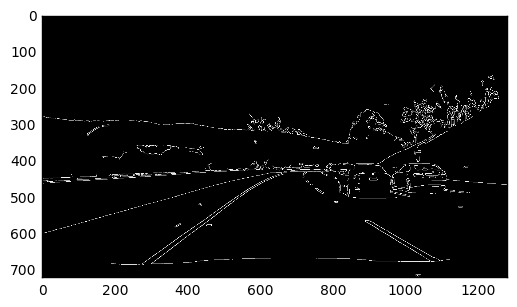

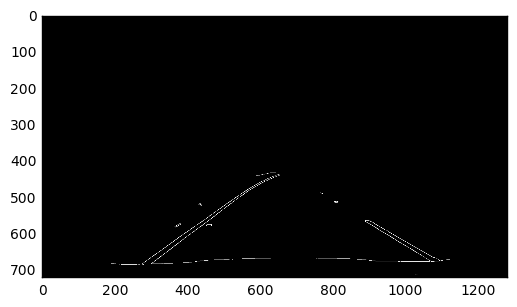

lines:   x1: 900  y1: 565  x1 1075  y2 666
lines angle: [ 25.6260116]
lines:   x1: 274  y1: 684  x1 410  y2 586
lines angle: [ 19.74760782]
lines:   x1: 298  y1: 684  x1 571  y2 479
lines angle: [ 24.26115429]
lines:   x1: 889  y1: 568  x1 1071  y2 677
lines angle: [ 26.34086009]
lines:   x1: 579  y1: 474  x1 597  y2 465
lines angle: [ 17.62142477]
lines:   x1: 434  y1: 571  x1 544  y2 492
lines angle: [ 19.17576141]
lines:   x1: 957  y1: 676  x1 1013  y2 677
lines angle: [ 18.66734154]
lines:   x1: 888  y1: 567  x1 973  y2 618
lines angle: [ 20.23743459]
lines:   x1: 371  y1: 681  x1 419  y2 678
lines angle: [ 18.40709529]
lines:   x1: 190  y1: 682  x1 203  y2 683
lines angle: [ 17.61733037]
lines:   x1: 865  y1: 671  x1 890  y2 672
lines angle: [ 17.88922961]
lines:   x1: 610  y1: 457  x1 654  y2 439
lines angle: [ 18.1292459]
lines:   x1: 709  y1: 667  x1 810  y2 668
lines angle: [ 20.03865659]
lines:   x1: 907  y1: 675  x1 940  y2 676
lines angle: [ 18.07909264]
lines:   x1: 398  y

 10%|▉         | 24/251 [00:30<05:01,  1.33s/it]

Image shape is: (720, 1280)


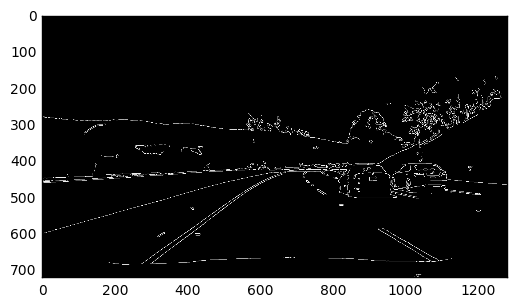

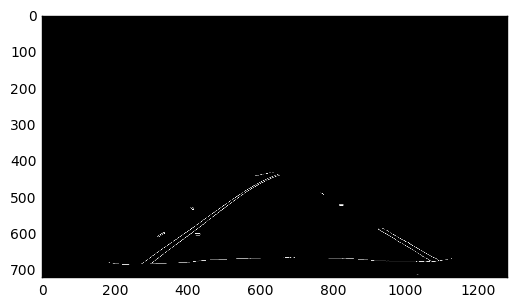

lines:   x1: 298  y1: 683  x1 561  y2 485
lines angle: [ 23.77594149]
lines:   x1: 291  y1: 670  x1 568  y2 476
lines angle: [ 24.85019245]
lines:   x1: 257  y1: 684  x1 405  y2 679
lines angle: [ 21.7840837]
lines:   x1: 939  y1: 587  x1 1092  y2 675
lines angle: [ 23.93490305]
lines:   x1: 913  y1: 675  x1 1015  y2 676
lines angle: [ 20.07307915]
lines:   x1: 923  y1: 587  x1 1042  y2 659
lines angle: [ 21.91047221]
lines:   x1: 723  y1: 667  x1 751  y2 667
lines angle: [ 17.94840729]
lines:   x1: 565  y1: 668  x1 693  y2 666
lines angle: [ 20.99040937]
lines:   x1: 923  y1: 588  x1 1071  y2 677
lines angle: [ 23.67696393]
lines:   x1: 1093  y1: 675  x1 1118  y2 670
lines angle: [ 17.82302677]
lines:   x1: 474  y1: 672  x1 549  y2 669
lines angle: [ 19.15336608]
lines:   x1: 933  y1: 585  x1 998  y2 622
lines angle: [ 19.39141864]
lines:   x1: 560  y1: 486  x1 612  y2 456
lines angle: [ 18.18803869]
lines:   x1: 317  y1: 608  x1 335  y2 597
lines angle: [ 17.60009967]
lines:   x1: 21

 10%|▉         | 25/251 [00:31<04:52,  1.30s/it]

Image shape is: (720, 1280)


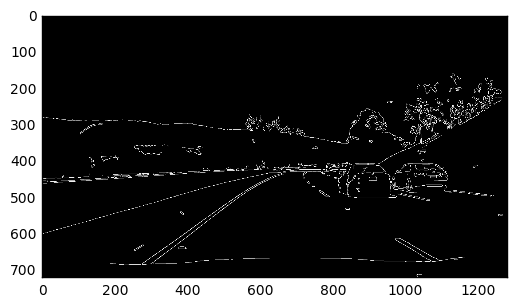

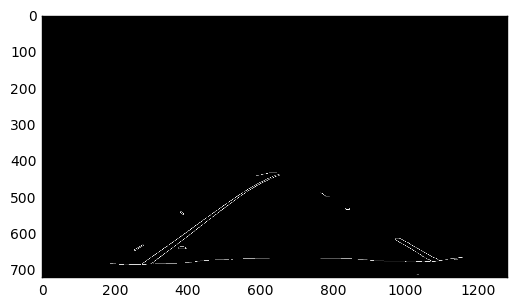

lines:   x1: 270  y1: 685  x1 441  y2 565
lines angle: [ 20.69931013]
lines:   x1: 738  y1: 667  x1 794  y2 668
lines angle: [ 18.66734154]
lines:   x1: 373  y1: 627  x1 560  y2 486
lines angle: [ 20.99435247]
lines:   x1: 983  y1: 614  x1 1092  y2 674
lines angle: [ 21.27810997]
lines:   x1: 936  y1: 676  x1 1026  y2 676
lines angle: [ 19.65809357]
lines:   x1: 584  y1: 471  x1 644  y2 442
lines angle: [ 18.40494194]
lines:   x1: 538  y1: 503  x1 568  y2 481
lines angle: [ 17.75129094]
lines:   x1: 521  y1: 507  x1 593  y2 462
lines angle: [ 18.52667016]
lines:   x1: 203  y1: 684  x1 234  y2 686
lines angle: [ 18.04227812]
lines:   x1: 365  y1: 682  x1 434  y2 676
lines angle: [ 18.93955877]
lines:   x1: 301  y1: 682  x1 333  y2 657
lines angle: [ 17.76426799]
lines:   x1: 648  y1: 667  x1 676  y2 667
lines angle: [ 17.94840729]
lines:   x1: 298  y1: 683  x1 340  y2 683
lines angle: [ 18.28970197]
lines:   x1: 471  y1: 542  x1 507  y2 518
lines angle: [ 17.86837435]
lines:   x1: 239  

 10%|█         | 26/251 [00:33<04:59,  1.33s/it]

Image shape is: (720, 1280)


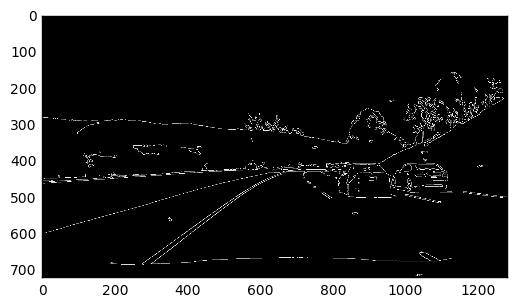

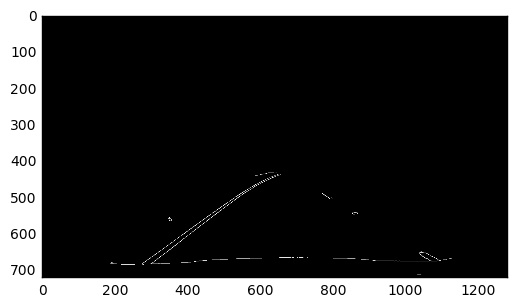

lines:   x1: 628  y1: 667  x1 665  y2 666
lines angle: [ 18.15364151]
lines:   x1: 412  y1: 583  x1 542  y2 492
lines angle: [ 19.6485433]
lines:   x1: 734  y1: 667  x1 762  y2 667
lines angle: [ 17.94840729]
lines:   x1: 383  y1: 618  x1 550  y2 492
lines angle: [ 20.43716501]
lines:   x1: 346  y1: 647  x1 454  y2 565
lines angle: [ 19.07295253]
lines:   x1: 526  y1: 511  x1 559  y2 486
lines angle: [ 17.7873386]
lines:   x1: 763  y1: 667  x1 819  y2 668
lines angle: [ 18.66734154]
lines:   x1: 273  y1: 684  x1 351  y2 629
lines angle: [ 18.56412498]
lines:   x1: 319  y1: 682  x1 381  y2 681
lines angle: [ 18.80667606]
lines:   x1: 441  y1: 674  x1 543  y2 669
lines angle: [ 19.98309211]
lines:   x1: 217  y1: 685  x1 297  y2 684
lines angle: [ 19.3305748]
lines:   x1: 968  y1: 676  x1 1084  y2 676
lines angle: [ 20.56009874]
lines:   x1: 854  y1: 669  x1 934  y2 675
lines angle: [ 19.42665995]
lines:   x1: 1043  y1: 661  x1 1066  y2 675
lines angle: [ 17.9869078]
lines:   x1: 594  y1:

 11%|█         | 27/251 [00:34<04:49,  1.29s/it]

Image shape is: (720, 1280)


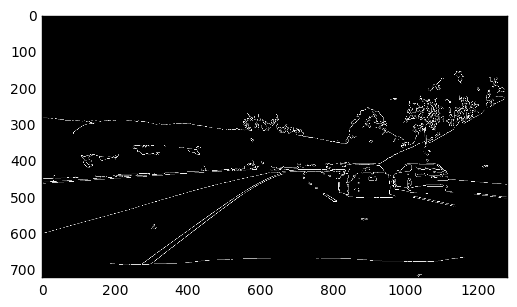

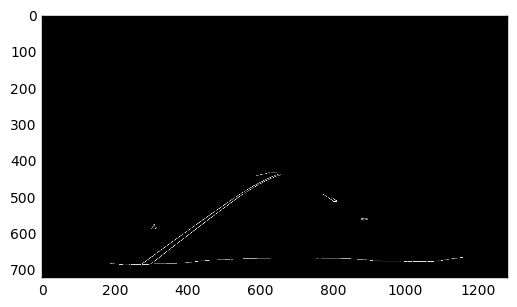

lines:   x1: 368  y1: 629  x1 546  y2 495
lines angle: [ 20.74093731]
lines:   x1: 565  y1: 669  x1 650  y2 667
lines angle: [ 19.47115879]
lines:   x1: 286  y1: 685  x1 328  y2 683
lines angle: [ 18.26618861]
lines:   x1: 367  y1: 615  x1 547  y2 489
lines angle: [ 20.96696401]
lines:   x1: 903  y1: 674  x1 945  y2 676
lines angle: [ 18.31327388]
lines:   x1: 1002  y1: 677  x1 1018  y2 676
lines angle: [ 17.6624838]
lines:   x1: 436  y1: 675  x1 540  y2 670
lines angle: [ 20.05171437]
lines:   x1: 296  y1: 684  x1 430  y2 583
lines angle: [ 19.63403379]
lines:   x1: 301  y1: 663  x1 411  y2 585
lines angle: [ 19.18969639]
lines:   x1: 571  y1: 474  x1 607  y2 456
lines angle: [ 17.93569751]
lines:   x1: 722  y1: 667  x1 766  y2 667
lines angle: [ 18.3403546]
lines:   x1: 651  y1: 667  x1 690  y2 667
lines angle: [ 18.21463513]
lines:   x1: 772  y1: 493  x1 803  y2 512
lines angle: [ 18.23689561]
lines:   x1: 587  y1: 469  x1 647  y2 441
lines angle: [ 18.41710251]
lines:   x1: 792  y1

 11%|█         | 28/251 [00:35<04:43,  1.27s/it]

Image shape is: (720, 1280)


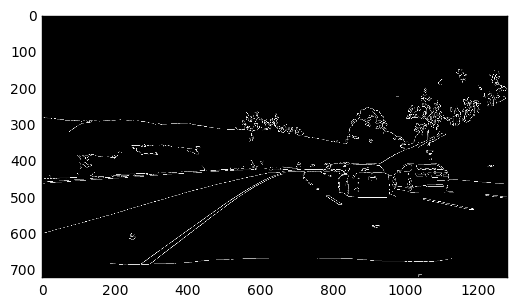

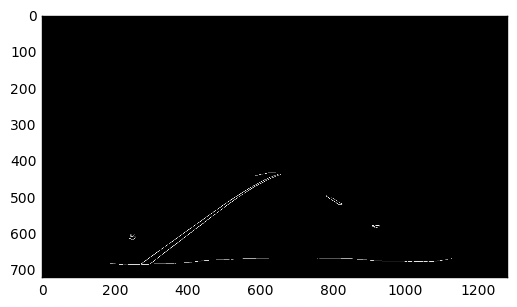

lines:   x1: 332  y1: 655  x1 535  y2 502
lines angle: [ 21.48406722]
lines:   x1: 272  y1: 684  x1 471  y2 540
lines angle: [ 21.47294998]
lines:   x1: 911  y1: 675  x1 933  y2 675
lines angle: [ 17.80889169]
lines:   x1: 671  y1: 667  x1 727  y2 667
lines angle: [ 18.65491531]
lines:   x1: 606  y1: 459  x1 653  y2 438
lines angle: [ 18.16864048]
lines:   x1: 518  y1: 507  x1 600  y2 458
lines angle: [ 18.75166758]
lines:   x1: 428  y1: 676  x1 445  y2 675
lines angle: [ 17.68480473]
lines:   x1: 294  y1: 684  x1 404  y2 680
lines angle: [ 20.27778891]
lines:   x1: 782  y1: 668  x1 810  y2 668
lines angle: [ 17.94840729]
lines:   x1: 458  y1: 673  x1 642  y2 667
lines angle: [ 23.58746885]
lines:   x1: 487  y1: 529  x1 504  y2 518
lines angle: [ 17.57805083]
lines:   x1: 1035  y1: 677  x1 1063  y2 676
lines angle: [ 17.93723379]
lines:   x1: 780  y1: 497  x1 816  y2 520
lines angle: [ 18.40919328]
lines:   x1: 952  y1: 676  x1 1004  y2 676
lines angle: [ 18.54798449]
lines:   x1: 187 

 12%|█▏        | 29/251 [00:36<04:49,  1.31s/it]

Image shape is: (720, 1280)


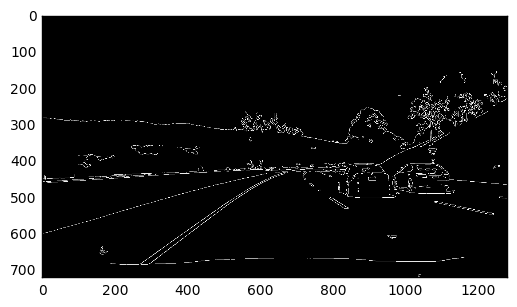

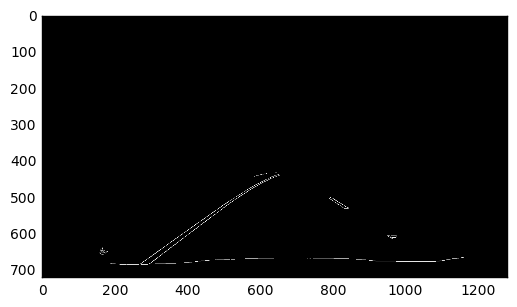

lines:   x1: 444  y1: 559  x1 463  y2 547
lines angle: [ 17.61156801]
lines:   x1: 598  y1: 461  x1 613  y2 452
lines angle: [ 17.55535576]
lines:   x1: 294  y1: 684  x1 536  y2 502
lines angle: [ 22.88425812]
lines:   x1: 521  y1: 507  x1 552  y2 486
lines angle: [ 17.78527865]
lines:   x1: 558  y1: 669  x1 705  y2 667
lines angle: [ 21.79498006]
lines:   x1: 765  y1: 668  x1 804  y2 668
lines angle: [ 18.21463513]
lines:   x1: 270  y1: 684  x1 425  y2 572
lines angle: [ 20.20979266]
lines:   x1: 292  y1: 684  x1 517  y2 515
lines angle: [ 22.24254173]
lines:   x1: 474  y1: 538  x1 500  y2 521
lines angle: [ 17.71467427]
lines:   x1: 788  y1: 503  x1 831  y2 531
lines angle: [ 18.65167276]
lines:   x1: 164  y1: 657  x1 176  y2 652
lines angle: [ 17.53209535]
lines:   x1: 360  y1: 682  x1 393  y2 680
lines angle: [ 18.0449574]
lines:   x1: 617  y1: 454  x1 654  y2 439
lines angle: [ 17.9934601]
lines:   x1: 213  y1: 685  x1 290  y2 685
lines angle: [ 19.25331175]
lines:   x1: 1113  y1:

 12%|█▏        | 30/251 [00:38<04:54,  1.33s/it]

Image shape is: (720, 1280)


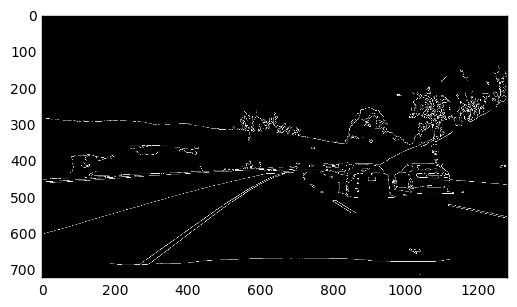

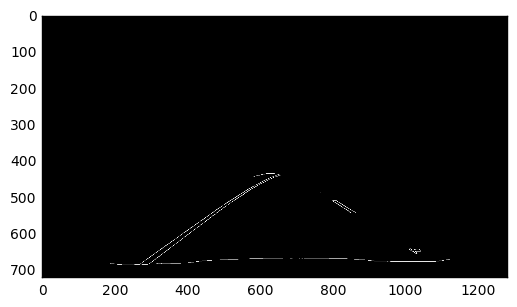

lines:   x1: 500  y1: 520  x1 542  y2 494
lines angle: [ 17.98851854]
lines:   x1: 291  y1: 685  x1 519  y2 514
lines angle: [ 22.3575437]
lines:   x1: 557  y1: 483  x1 627  y2 446
lines angle: [ 18.57251406]
lines:   x1: 271  y1: 683  x1 418  y2 577
lines angle: [ 20.01171138]
lines:   x1: 662  y1: 667  x1 698  y2 667
lines angle: [ 18.14064214]
lines:   x1: 348  y1: 683  x1 422  y2 678
lines angle: [ 19.09730413]
lines:   x1: 1011  y1: 641  x1 1030  y2 653
lines angle: [ 17.87142201]
lines:   x1: 839  y1: 670  x1 887  y2 672
lines angle: [ 18.46726407]
lines:   x1: 608  y1: 668  x1 661  y2 668
lines angle: [ 18.57451815]
lines:   x1: 948  y1: 677  x1 1082  y2 677
lines angle: [ 21.26925296]
lines:   x1: 423  y1: 677  x1 466  y2 674
lines angle: [ 18.27958631]
lines:   x1: 589  y1: 469  x1 638  y2 445
lines angle: [ 18.18340409]
lines:   x1: 762  y1: 668  x1 776  y2 668
lines angle: [ 17.62877803]
lines:   x1: 570  y1: 669  x1 607  y2 669
lines angle: [ 18.16518856]
lines:   x1: 396  

 12%|█▏        | 31/251 [00:39<04:45,  1.30s/it]

Image shape is: (720, 1280)


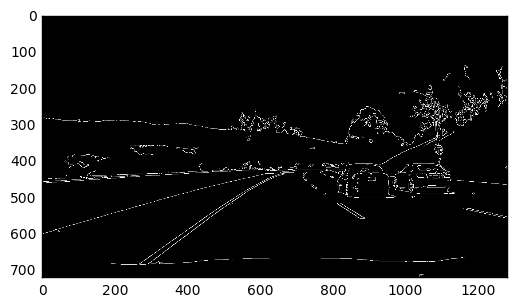

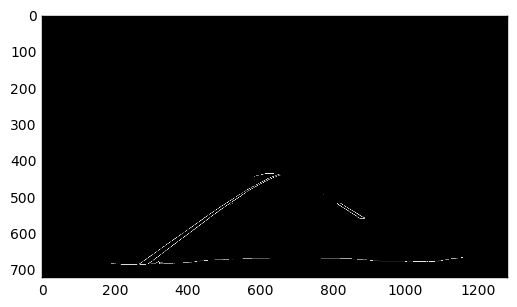

lines:   x1: 572  y1: 480  x1 598  y2 464
lines angle: [ 17.72555766]
lines:   x1: 784  y1: 668  x1 880  y2 671
lines angle: [ 19.89877874]
lines:   x1: 290  y1: 684  x1 346  y2 643
lines angle: [ 18.15883713]
lines:   x1: 927  y1: 676  x1 1018  y2 676
lines angle: [ 19.69042115]
lines:   x1: 267  y1: 684  x1 293  y2 666
lines angle: [ 17.70380381]
lines:   x1: 535  y1: 498  x1 569  y2 476
lines angle: [ 17.84383506]
lines:   x1: 411  y1: 593  x1 532  y2 505
lines angle: [ 19.39559071]
lines:   x1: 320  y1: 645  x1 487  y2 528
lines angle: [ 20.59004208]
lines:   x1: 609  y1: 458  x1 652  y2 440
lines angle: [ 18.10464607]
lines:   x1: 625  y1: 667  x1 765  y2 667
lines angle: [ 21.52340707]
lines:   x1: 382  y1: 681  x1 476  y2 672
lines angle: [ 19.65861148]
lines:   x1: 285  y1: 684  x1 299  y2 684
lines angle: [ 17.62877803]
lines:   x1: 844  y1: 533  x1 887  y2 557
lines angle: [ 18.60284269]
lines:   x1: 1065  y1: 677  x1 1155  y2 666
lines angle: [ 19.50230326]
lines:   x1: 230 

 13%|█▎        | 32/251 [00:40<04:51,  1.33s/it]

Image shape is: (720, 1280)


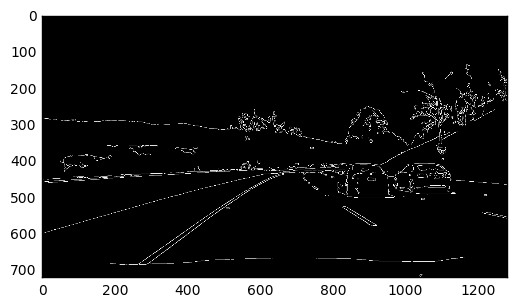

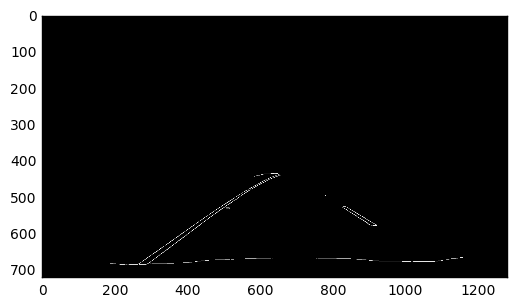

lines:   x1: 436  y1: 675  x1 533  y2 670
lines angle: [ 19.81485389]
lines:   x1: 325  y1: 641  x1 395  y2 593
lines angle: [ 18.43592463]
lines:   x1: 834  y1: 526  x1 919  y2 577
lines angle: [ 20.23743459]
lines:   x1: 1020  y1: 677  x1 1069  y2 677
lines angle: [ 18.46916613]
lines:   x1: 328  y1: 654  x1 433  y2 577
lines angle: [ 19.05061946]
lines:   x1: 450  y1: 553  x1 500  y2 521
lines angle: [ 18.11474689]
lines:   x1: 343  y1: 682  x1 412  y2 679
lines angle: [ 18.9785529]
lines:   x1: 524  y1: 504  x1 614  y2 452
lines angle: [ 18.94198319]
lines:   x1: 629  y1: 667  x1 756  y2 667
lines angle: [ 20.98433422]
lines:   x1: 752  y1: 668  x1 808  y2 668
lines angle: [ 18.65491531]
lines:   x1: 825  y1: 528  x1 864  y2 552
lines angle: [ 18.49819857]
lines:   x1: 265  y1: 684  x1 324  y2 642
lines angle: [ 18.22276826]
lines:   x1: 496  y1: 530  x1 523  y2 513
lines angle: [ 17.73741976]
lines:   x1: 495  y1: 523  x1 514  y2 512
lines angle: [ 17.62224909]
lines:   x1: 879  y

 13%|█▎        | 33/251 [00:42<04:59,  1.37s/it]

Image shape is: (720, 1280)


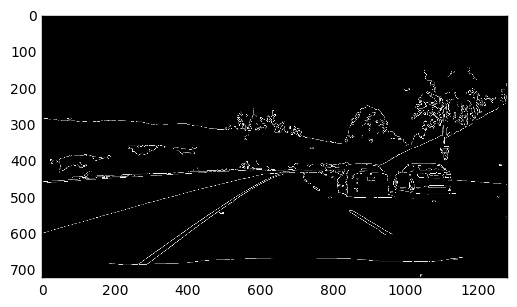

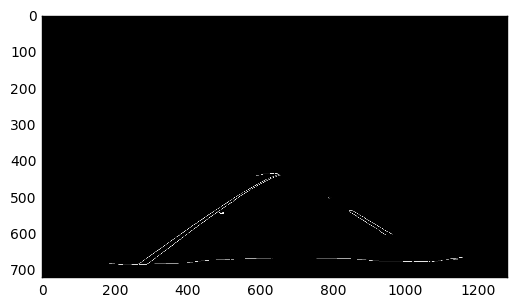

lines:   x1: 369  y1: 609  x1 547  y2 489
lines angle: [ 20.9900513]
lines:   x1: 437  y1: 675  x1 537  y2 670
lines angle: [ 19.91523436]
lines:   x1: 908  y1: 675  x1 924  y2 675
lines angle: [ 17.67319068]
lines:   x1: 313  y1: 665  x1 400  y2 601
lines angle: [ 18.69874478]
lines:   x1: 849  y1: 544  x1 861  y2 550
lines angle: [ 17.64837826]
lines:   x1: 547  y1: 496  x1 571  y2 480
lines angle: [ 17.68030351]
lines:   x1: 386  y1: 610  x1 499  y2 528
lines angle: [ 19.22701095]
lines:   x1: 406  y1: 679  x1 420  y2 678
lines angle: [ 17.61814565]
lines:   x1: 754  y1: 668  x1 810  y2 668
lines angle: [ 18.65491531]
lines:   x1: 558  y1: 669  x1 588  y2 669
lines angle: [ 17.99578781]
lines:   x1: 304  y1: 655  x1 377  y2 605
lines angle: [ 18.49130238]
lines:   x1: 210  y1: 685  x1 222  y2 685
lines angle: [ 17.58476671]
lines:   x1: 560  y1: 483  x1 582  y2 469
lines angle: [ 17.65696317]
lines:   x1: 375  y1: 681  x1 397  y2 681
lines angle: [ 17.80889169]
lines:   x1: 596  y1:

 14%|█▎        | 34/251 [00:43<05:11,  1.44s/it]

Image shape is: (720, 1280)


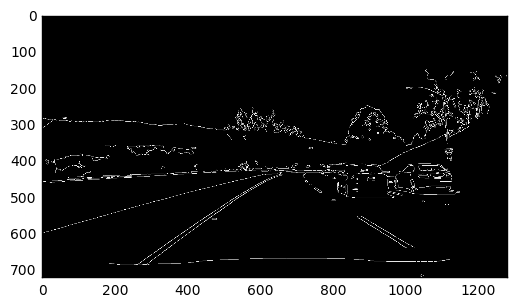

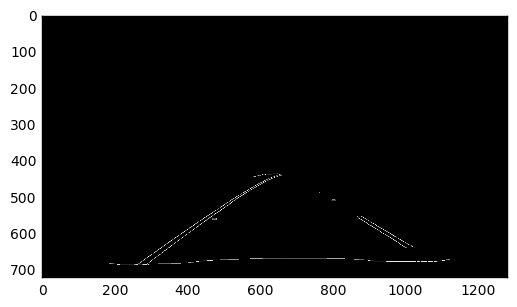

lines:   x1: 417  y1: 587  x1 551  y2 493
lines angle: [ 19.73953899]
lines:   x1: 875  y1: 560  x1 947  y2 606
lines angle: [ 19.73299849]
lines:   x1: 606  y1: 668  x1 781  y2 668
lines angle: [ 23.21890864]
lines:   x1: 316  y1: 646  x1 423  y2 573
lines angle: [ 19.16663546]
lines:   x1: 347  y1: 624  x1 534  y2 498
lines angle: [ 21.27100026]
lines:   x1: 376  y1: 617  x1 566  y2 484
lines angle: [ 21.27358275]
lines:   x1: 343  y1: 642  x1 370  y2 623
lines angle: [ 17.71561447]
lines:   x1: 424  y1: 677  x1 453  y2 675
lines angle: [ 17.94962754]
lines:   x1: 856  y1: 671  x1 870  y2 671
lines angle: [ 17.62877803]
lines:   x1: 568  y1: 478  x1 626  y2 447
lines angle: [ 18.32881257]
lines:   x1: 936  y1: 589  x1 1021  y2 638
lines angle: [ 20.20747078]
lines:   x1: 287  y1: 684  x1 353  y2 683
lines angle: [ 18.91892663]
lines:   x1: 875  y1: 552  x1 958  y2 600
lines angle: [ 20.12415147]
lines:   x1: 963  y1: 677  x1 1040  y2 678
lines angle: [ 19.2668312]
lines:   x1: 215  y

 14%|█▍        | 35/251 [00:45<05:08,  1.43s/it]

Image shape is: (720, 1280)


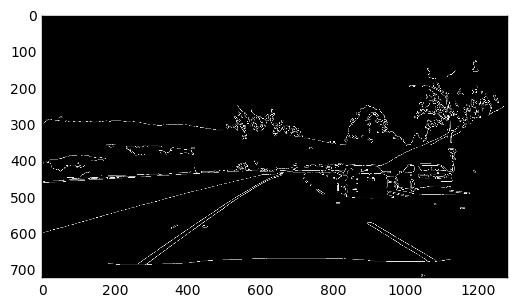

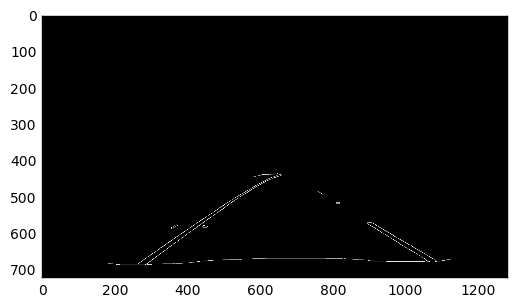

lines:   x1: 470  y1: 673  x1 600  y2 669
lines angle: [ 21.03662327]
lines:   x1: 547  y1: 496  x1 602  y2 463
lines angle: [ 18.22822728]
lines:   x1: 285  y1: 667  x1 540  y2 495
lines angle: [ 23.92139369]
lines:   x1: 470  y1: 550  x1 504  y2 527
lines angle: [ 17.83271571]
lines:   x1: 1022  y1: 677  x1 1078  y2 678
lines angle: [ 18.66734154]
lines:   x1: 940  y1: 601  x1 1000  y2 639
lines angle: [ 19.25544365]
lines:   x1: 960  y1: 603  x1 1018  y2 636
lines angle: [ 19.13117851]
lines:   x1: 635  y1: 448  x1 649  y2 439
lines angle: [ 17.53353166]
lines:   x1: 322  y1: 641  x1 522  y2 506
lines angle: [ 21.69545418]
lines:   x1: 283  y1: 685  x1 410  y2 680
lines angle: [ 20.9002104]
lines:   x1: 962  y1: 677  x1 990  y2 677
lines angle: [ 17.94840729]
lines:   x1: 894  y1: 570  x1 905  y2 570
lines angle: [ 17.56290987]
lines:   x1: 574  y1: 475  x1 632  y2 445
lines angle: [ 18.34084944]
lines:   x1: 1024  y1: 641  x1 1054  y2 657
lines angle: [ 18.17773263]
lines:   x1: 61

 14%|█▍        | 36/251 [00:46<05:11,  1.45s/it]

Image shape is: (720, 1280)


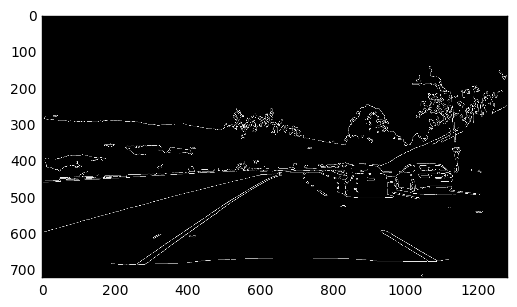

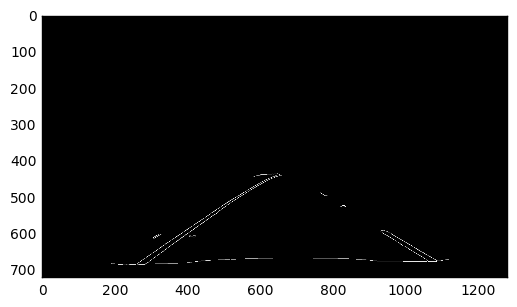

lines:   x1: 463  y1: 673  x1 616  y2 668
lines angle: [ 22.01228624]
lines:   x1: 525  y1: 510  x1 620  y2 453
lines angle: [ 19.02245805]
lines:   x1: 256  y1: 685  x1 531  y2 500
lines angle: [ 24.95847886]
lines:   x1: 945  y1: 593  x1 1033  y2 644
lines angle: [ 20.34202243]
lines:   x1: 991  y1: 677  x1 1084  y2 677
lines angle: [ 19.75560861]
lines:   x1: 331  y1: 683  x1 387  y2 681
lines angle: [ 18.63011064]
lines:   x1: 282  y1: 685  x1 459  y2 557
lines angle: [ 20.80540278]
lines:   x1: 184  y1: 681  x1 209  y2 685
lines angle: [ 17.92250974]
lines:   x1: 963  y1: 604  x1 1087  y2 676
lines angle: [ 22.13391842]
lines:   x1: 402  y1: 599  x1 527  y2 509
lines angle: [ 19.4968047]
lines:   x1: 548  y1: 490  x1 623  y2 448
lines angle: [ 18.64617015]
lines:   x1: 322  y1: 640  x1 507  y2 515
lines angle: [ 21.20121048]
lines:   x1: 931  y1: 595  x1 1061  y2 676
lines angle: [ 22.58567899]
lines:   x1: 634  y1: 667  x1 744  y2 667
lines angle: [ 20.33998169]
lines:   x1: 603 

 15%|█▍        | 37/251 [00:48<04:51,  1.36s/it]

Image shape is: (720, 1280)


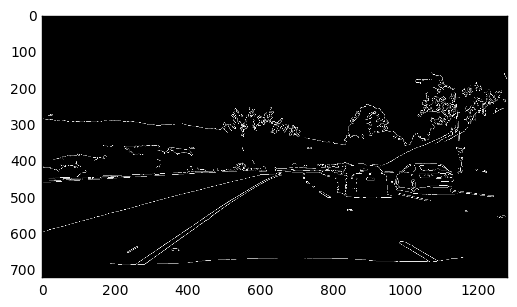

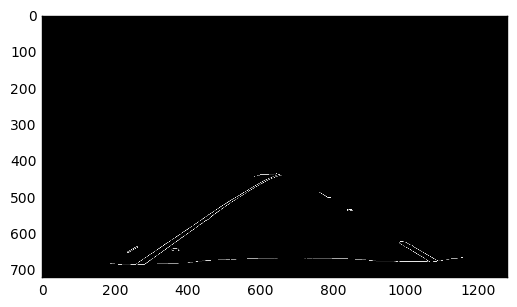

lines:   x1: 255  y1: 685  x1 523  y2 505
lines angle: [ 24.59151219]
lines:   x1: 908  y1: 675  x1 1031  y2 677
lines angle: [ 20.86003912]
lines:   x1: 479  y1: 542  x1 599  y2 464
lines angle: [ 19.50801559]
lines:   x1: 605  y1: 461  x1 647  y2 442
lines angle: [ 18.06865896]
lines:   x1: 997  y1: 623  x1 1073  y2 668
lines angle: [ 19.84767566]
lines:   x1: 981  y1: 626  x1 1055  y2 671
lines angle: [ 19.78295317]
lines:   x1: 244  y1: 649  x1 263  y2 637
lines angle: [ 17.61156801]
lines:   x1: 1046  y1: 677  x1 1062  y2 676
lines angle: [ 17.6624838]
lines:   x1: 464  y1: 673  x1 619  y2 668
lines angle: [ 22.10565071]
lines:   x1: 257  y1: 685  x1 439  y2 562
lines angle: [ 21.10714222]
lines:   x1: 730  y1: 668  x1 758  y2 668
lines angle: [ 17.94840729]
lines:   x1: 219  y1: 686  x1 281  y2 685
lines angle: [ 18.80667606]
lines:   x1: 769  y1: 668  x1 825  y2 669
lines angle: [ 18.66734154]
lines:   x1: 395  y1: 604  x1 449  y2 564
lines angle: [ 18.1205937]
lines:   x1: 639 

 15%|█▌        | 38/251 [00:49<04:46,  1.35s/it]

Image shape is: (720, 1280)


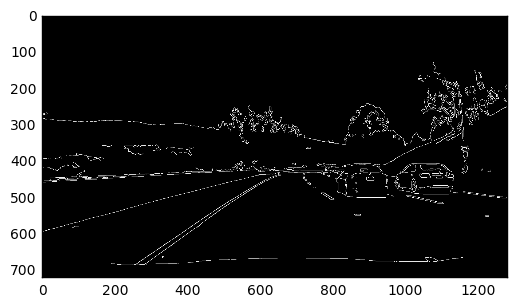

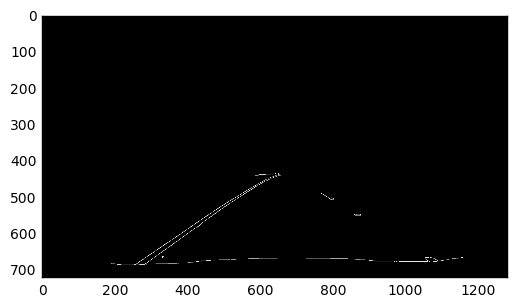

lines:   x1: 288  y1: 681  x1 421  y2 585
lines angle: [ 19.67519618]
lines:   x1: 255  y1: 685  x1 312  y2 648
lines angle: [ 18.23144801]
lines:   x1: 545  y1: 493  x1 586  y2 467
lines angle: [ 17.96449023]
lines:   x1: 418  y1: 574  x1 546  y2 491
lines angle: [ 19.70060714]
lines:   x1: 677  y1: 667  x1 860  y2 670
lines angle: [ 23.73470314]
lines:   x1: 532  y1: 507  x1 562  y2 486
lines angle: [ 17.76226487]
lines:   x1: 582  y1: 669  x1 666  y2 667
lines angle: [ 19.43998126]
lines:   x1: 312  y1: 683  x1 374  y2 682
lines angle: [ 18.80667606]
lines:   x1: 314  y1: 645  x1 393  y2 593
lines angle: [ 18.62955585]
lines:   x1: 388  y1: 681  x1 452  y2 674
lines angle: [ 18.78602071]
lines:   x1: 218  y1: 686  x1 288  y2 685
lines angle: [ 19.0335]
lines:   x1: 484  y1: 538  x1 499  y2 529
lines angle: [ 17.55535576]
lines:   x1: 590  y1: 470  x1 629  y2 445
lines angle: [ 17.92805646]
lines:   x1: 1074  y1: 678  x1 1113  y2 672
lines angle: [ 18.14505189]
lines:   x1: 290  y1: 

 16%|█▌        | 39/251 [00:50<04:56,  1.40s/it]

Image shape is: (720, 1280)


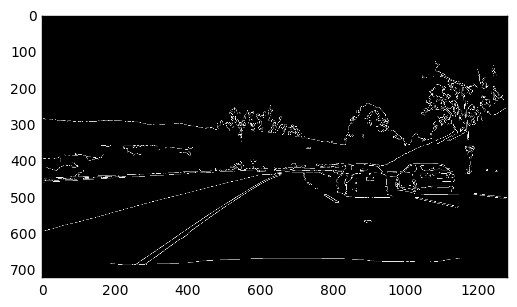

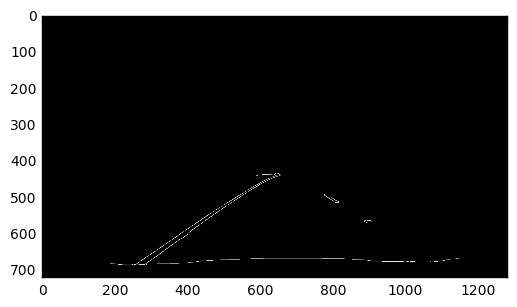

lines:   x1: 681  y1: 668  x1 737  y2 668
lines angle: [ 18.65491531]
lines:   x1: 452  y1: 674  x1 635  y2 668
lines angle: [ 23.53053851]
lines:   x1: 287  y1: 682  x1 381  y2 614
lines angle: [ 18.84630222]
lines:   x1: 588  y1: 441  x1 649  y2 435
lines angle: [ 18.71593375]
lines:   x1: 439  y1: 560  x1 604  y2 457
lines angle: [ 20.75059332]
lines:   x1: 438  y1: 571  x1 577  y2 477
lines angle: [ 19.91365852]
lines:   x1: 238  y1: 686  x1 399  y2 681
lines angle: [ 22.39318948]
lines:   x1: 755  y1: 668  x1 783  y2 669
lines angle: [ 17.95959425]
lines:   x1: 308  y1: 651  x1 436  y2 562
lines angle: [ 19.6110956]
lines:   x1: 846  y1: 670  x1 936  y2 677
lines angle: [ 19.75848339]
lines:   x1: 792  y1: 500  x1 815  y2 513
lines angle: [ 17.97574765]
lines:   x1: 1025  y1: 678  x1 1087  y2 677
lines angle: [ 18.80667606]
lines:   x1: 624  y1: 451  x1 651  y2 441
lines angle: [ 17.81414907]
lines:   x1: 257  y1: 685  x1 335  y2 631
lines angle: [ 18.57674145]
lines:   x1: 775  y

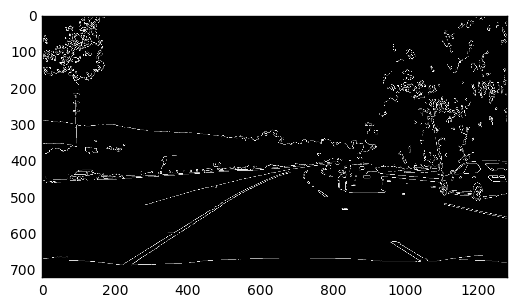

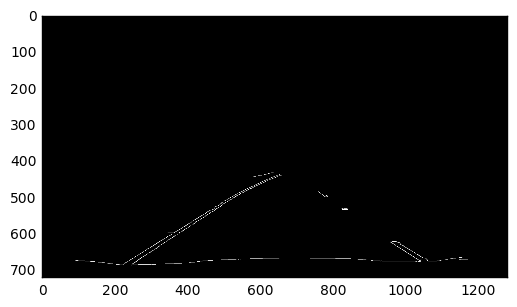

lines:   x1: 929  y1: 676  x1 984  y2 676
lines angle: [ 18.62798258]
lines:   x1: 222  y1: 686  x1 535  y2 491
lines angle: [ 27.93190189]
lines:   x1: 246  y1: 684  x1 476  y2 535
lines angle: [ 22.95719686]
lines:   x1: 265  y1: 671  x1 536  y2 495
lines angle: [ 24.91906437]
lines:   x1: 434  y1: 676  x1 553  y2 670
lines angle: [ 20.57596494]
lines:   x1: 297  y1: 685  x1 372  y2 682
lines angle: [ 19.15336608]
lines:   x1: 990  y1: 676  x1 1000  y2 676
lines angle: [ 17.54115136]
lines:   x1: 806  y1: 669  x1 847  y2 669
lines angle: [ 18.26455895]
lines:   x1: 538  y1: 671  x1 591  y2 669
lines angle: [ 18.55000029]
lines:   x1: 975  y1: 623  x1 1047  y2 667
lines angle: [ 19.70486669]
lines:   x1: 220  y1: 686  x1 387  y2 582
lines angle: [ 20.81476542]
lines:   x1: 957  y1: 624  x1 1037  y2 674
lines angle: [ 20.05227402]
lines:   x1: 550  y1: 483  x1 611  y2 455
lines angle: [ 18.44336383]
lines:   x1: 131  y1: 676  x1 219  y2 686
lines angle: [ 19.73644829]
lines:   x1: 758 

 63%|██████▎   | 157/251 [03:31<02:22,  1.52s/it]

Image shape is: (720, 1280)


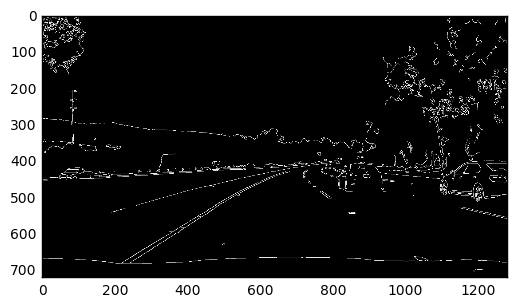

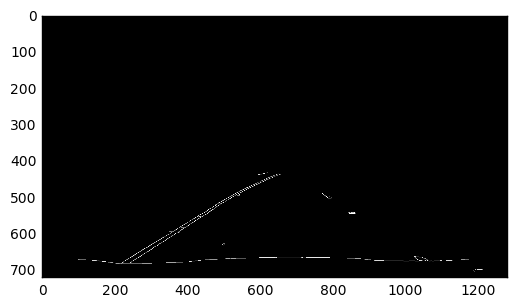

lines:   x1: 315  y1: 634  x1 478  y2 528
lines angle: [ 20.61863032]
lines:   x1: 585  y1: 464  x1 602  y2 455
lines angle: [ 17.59930165]
lines:   x1: 1093  y1: 674  x1 1128  y2 674
lines angle: [ 18.11621251]
lines:   x1: 456  y1: 534  x1 477  y2 524
lines angle: [ 17.67762137]
lines:   x1: 751  y1: 666  x1 779  y2 666
lines angle: [ 17.94840729]
lines:   x1: 683  y1: 665  x1 724  y2 665
lines angle: [ 18.26455895]
lines:   x1: 474  y1: 522  x1 557  y2 476
lines angle: [ 18.81890311]
lines:   x1: 391  y1: 574  x1 426  y2 554
lines angle: [ 17.88960265]
lines:   x1: 904  y1: 673  x1 939  y2 674
lines angle: [ 18.12768874]
lines:   x1: 629  y1: 666  x1 666  y2 665
lines angle: [ 18.15364151]
lines:   x1: 564  y1: 474  x1 575  y2 468
lines angle: [ 17.4999587]
lines:   x1: 533  y1: 668  x1 560  y2 668
lines angle: [ 17.92488305]
lines:   x1: 213  y1: 683  x1 254  y2 683
lines angle: [ 18.26455895]
lines:   x1: 216  y1: 682  x1 285  y2 639
lines angle: [ 18.47103176]
lines:   x1: 355  y

 63%|██████▎   | 158/251 [03:32<02:21,  1.52s/it]

Image shape is: (720, 1280)


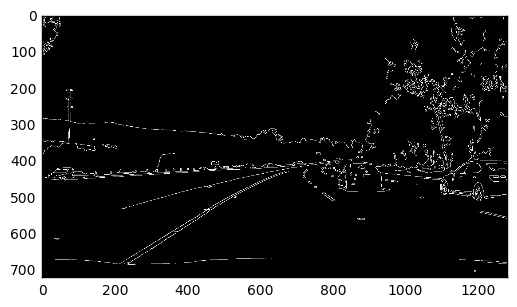

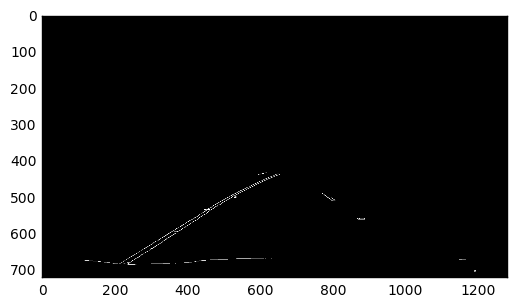

lines:   x1: 289  y1: 650  x1 335  y2 620
lines angle: [ 18.03962428]
lines:   x1: 317  y1: 683  x1 373  y2 681
lines angle: [ 18.63011064]
lines:   x1: 214  y1: 683  x1 407  y2 563
lines angle: [ 21.65923536]
lines:   x1: 390  y1: 681  x1 453  y2 673
lines angle: [ 18.74569199]
lines:   x1: 332  y1: 621  x1 381  y2 591
lines angle: [ 18.11329375]
lines:   x1: 370  y1: 599  x1 385  y2 586
lines angle: [ 17.51319768]
lines:   x1: 378  y1: 582  x1 509  y2 501
lines angle: [ 19.83360819]
lines:   x1: 609  y1: 667  x1 629  y2 667
lines angle: [ 17.7632419]
lines:   x1: 540  y1: 484  x1 631  y2 442
lines angle: [ 19.1056263]
lines:   x1: 515  y1: 503  x1 619  y2 450
lines angle: [ 19.35271162]
lines:   x1: 369  y1: 599  x1 485  y2 521
lines angle: [ 19.37857121]
lines:   x1: 113  y1: 673  x1 198  y2 682
lines angle: [ 19.62557705]
lines:   x1: 792  y1: 500  x1 805  y2 510
lines angle: [ 17.71336064]
lines:   x1: 774  y1: 492  x1 796  y2 509
lines angle: [ 17.99681087]
lines:   x1: 256  y1: 

 63%|██████▎   | 159/251 [03:34<02:15,  1.47s/it]

Image shape is: (720, 1280)


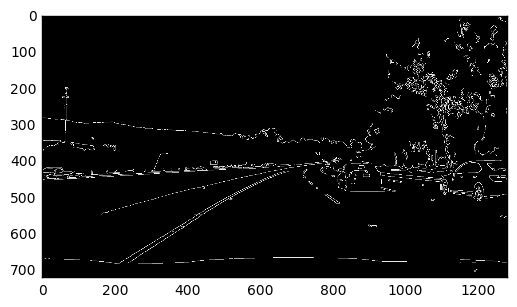

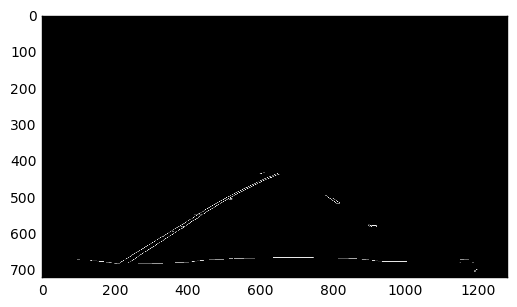

lines:   x1: 259  y1: 651  x1 334  y2 607
lines angle: [ 18.62085754]
lines:   x1: 277  y1: 683  x1 403  y2 679
lines angle: [ 20.87758121]
lines:   x1: 232  y1: 684  x1 449  y2 543
lines angle: [ 22.42266261]
lines:   x1: 429  y1: 555  x1 544  y2 486
lines angle: [ 19.47571754]
lines:   x1: 525  y1: 670  x1 610  y2 667
lines angle: [ 19.45723651]
lines:   x1: 662  y1: 666  x1 718  y2 666
lines angle: [ 18.65491531]
lines:   x1: 979  y1: 677  x1 1016  y2 678
lines angle: [ 18.17674981]
lines:   x1: 531  y1: 488  x1 638  y2 438
lines angle: [ 19.49068451]
lines:   x1: 836  y1: 668  x1 897  y2 672
lines angle: [ 18.8424132]
lines:   x1: 426  y1: 547  x1 514  y2 497
lines angle: [ 18.91023265]
lines:   x1: 126  y1: 673  x1 225  y2 685
lines angle: [ 20.13517714]
lines:   x1: 1133  y1: 678  x1 1181  y2 678
lines angle: [ 18.44315106]
lines:   x1: 408  y1: 678  x1 450  y2 673
lines angle: [ 18.23102785]
lines:   x1: 1072  y1: 678  x1 1128  y2 678
lines angle: [ 18.65491531]
lines:   x1: 776

 64%|██████▎   | 160/251 [03:35<02:13,  1.47s/it]

Image shape is: (720, 1280)


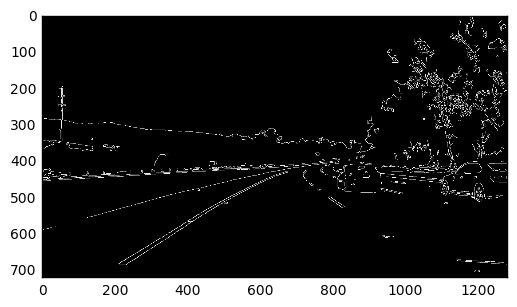

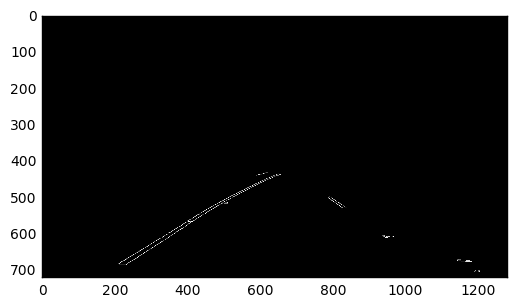

lines:   x1: 230  y1: 686  x1 482  y2 523
lines angle: [ 23.9563497]
lines:   x1: 389  y1: 572  x1 439  y2 541
lines angle: [ 18.12641023]
lines:   x1: 512  y1: 500  x1 623  y2 446
lines angle: [ 19.56260433]
lines:   x1: 260  y1: 653  x1 458  y2 530
lines angle: [ 21.8376484]
lines:   x1: 549  y1: 486  x1 592  y2 465
lines angle: [ 18.07004568]
lines:   x1: 485  y1: 516  x1 505  y2 504
lines angle: [ 17.63378119]
lines:   x1: 786  y1: 502  x1 826  y2 530
lines angle: [ 18.57244194]
lines:   x1: 1163  y1: 677  x1 1180  y2 677
lines angle: [ 17.6955492]
lines:   x1: 319  y1: 617  x1 400  y2 567
lines angle: [ 18.71069991]
lines:   x1: 591  y1: 439  x1 617  y2 433
lines angle: [ 17.83510752]
lines:   x1: 574  y1: 473  x1 643  y2 441
lines angle: [ 18.60797066]
lines:   x1: 208  y1: 685  x1 238  y2 665
lines angle: [ 17.77325194]
lines:   x1: 492  y1: 511  x1 509  y2 515
lines angle: [ 17.73865373]
lines:   x1: 229  y1: 672  x1 253  y2 656
lines angle: [ 17.68030351]
lines:   x1: 796  y1:

 64%|██████▍   | 161/251 [03:36<02:04,  1.38s/it]

Image shape is: (720, 1280)


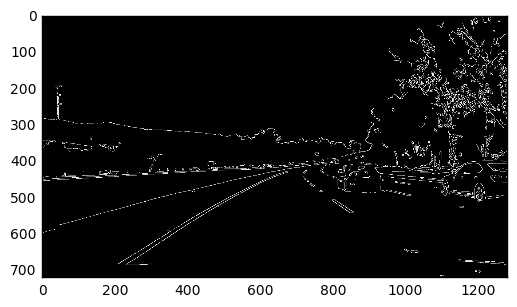

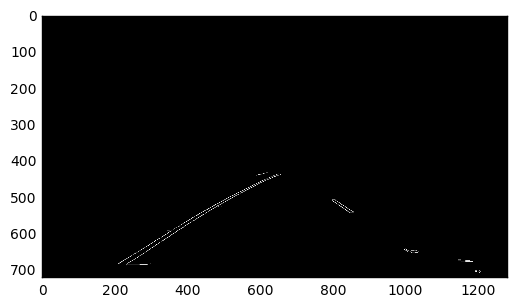

lines:   x1: 213  y1: 680  x1 337  y2 605
lines angle: [ 19.68496455]
lines:   x1: 796  y1: 509  x1 846  y2 543
lines angle: [ 18.91692276]
lines:   x1: 519  y1: 498  x1 531  y2 491
lines angle: [ 17.51111229]
lines:   x1: 356  y1: 590  x1 511  y2 501
lines angle: [ 20.59057669]
lines:   x1: 370  y1: 593  x1 484  y2 522
lines angle: [ 19.41472116]
lines:   x1: 578  y1: 467  x1 646  y2 437
lines angle: [ 18.60584132]
lines:   x1: 299  y1: 640  x1 354  y2 605
lines angle: [ 18.20453173]
lines:   x1: 800  y1: 506  x1 855  y2 541
lines angle: [ 19.07085323]
lines:   x1: 249  y1: 686  x1 299  y2 684
lines angle: [ 18.47107274]
lines:   x1: 515  y1: 506  x1 537  y2 493
lines angle: [ 17.66773194]
lines:   x1: 351  y1: 606  x1 502  y2 512
lines angle: [ 20.3530185]
lines:   x1: 231  y1: 687  x1 258  y2 667
lines angle: [ 17.70473127]
lines:   x1: 1001  y1: 648  x1 1027  y2 646
lines angle: [ 17.87929514]
lines:   x1: 541  y1: 486  x1 565  y2 475
lines angle: [ 17.73452894]
lines:   x1: 345  y

 65%|██████▍   | 162/251 [03:38<02:03,  1.38s/it]

Image shape is: (720, 1280)


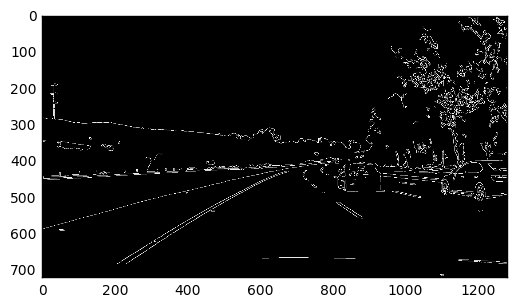

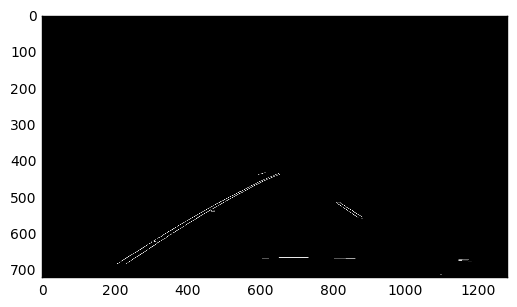

lines:   x1: 230  y1: 684  x1 333  y2 615
lines angle: [ 19.09960239]
lines:   x1: 344  y1: 608  x1 423  y2 560
lines angle: [ 18.68052379]
lines:   x1: 207  y1: 682  x1 386  y2 571
lines angle: [ 21.19668478]
lines:   x1: 396  y1: 575  x1 491  y2 518
lines angle: [ 19.02245805]
lines:   x1: 477  y1: 519  x1 610  y2 451
lines angle: [ 20.10506056]
lines:   x1: 816  y1: 514  x1 881  y2 556
lines angle: [ 19.45921604]
lines:   x1: 410  y1: 557  x1 428  y2 548
lines angle: [ 17.62142477]
lines:   x1: 836  y1: 535  x1 860  y2 550
lines angle: [ 18.02176915]
lines:   x1: 510  y1: 507  x1 554  y2 485
lines angle: [ 18.08296915]
lines:   x1: 651  y1: 666  x1 707  y2 666
lines angle: [ 18.65491531]
lines:   x1: 620  y1: 451  x1 642  y2 441
lines angle: [ 17.70011465]
lines:   x1: 782  y1: 667  x1 868  y2 670
lines angle: [ 19.57270087]
lines:   x1: 450  y1: 534  x1 498  y2 509
lines angle: [ 18.14678998]
lines:   x1: 498  y1: 514  x1 518  y2 504
lines angle: [ 17.65523095]
lines:   x1: 846  y1

 65%|██████▍   | 163/251 [03:39<01:58,  1.35s/it]

Image shape is: (720, 1280)


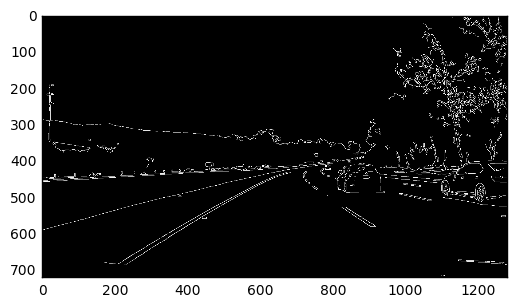

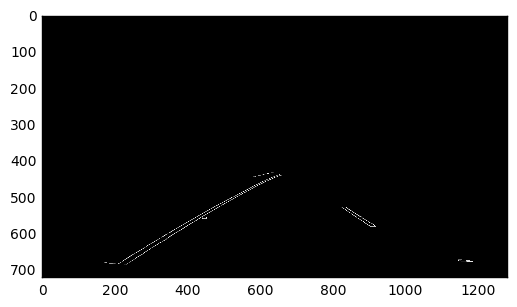

lines:   x1: 279  y1: 653  x1 446  y2 549
lines angle: [ 20.81476542]
lines:   x1: 228  y1: 686  x1 472  y2 534
lines angle: [ 23.72215624]
lines:   x1: 824  y1: 528  x1 865  y2 557
lines angle: [ 18.61087537]
lines:   x1: 487  y1: 525  x1 624  y2 452
lines angle: [ 20.17105116]
lines:   x1: 439  y1: 545  x1 597  y2 461
lines angle: [ 20.79537962]
lines:   x1: 832  y1: 527  x1 916  y2 579
lines angle: [ 20.21790598]
lines:   x1: 229  y1: 670  x1 399  y2 568
lines angle: [ 20.97444459]
lines:   x1: 420  y1: 556  x1 612  y2 454
lines angle: [ 21.96672739]
lines:   x1: 170  y1: 679  x1 208  y2 684
lines angle: [ 18.24801683]
lines:   x1: 830  y1: 527  x1 915  y2 580
lines angle: [ 20.26748366]
lines:   x1: 580  y1: 444  x1 635  y2 433
lines angle: [ 18.49286438]
lines:   x1: 860  y1: 552  x1 902  y2 581
lines angle: [ 18.63733191]
lines:   x1: 1166  y1: 677  x1 1182  y2 677
lines angle: [ 17.67319068]
lines:   x1: 1151  y1: 676  x1 1174  y2 674
lines angle: [ 17.80993845]
lines:   x1: 114

 65%|██████▌   | 164/251 [03:40<01:49,  1.25s/it]

Image shape is: (720, 1280)


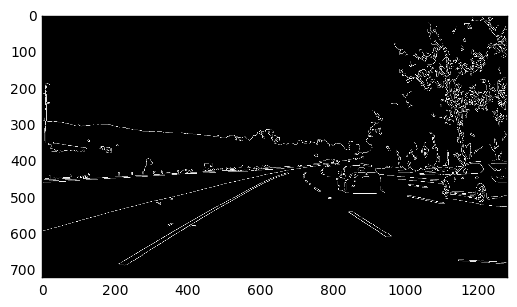

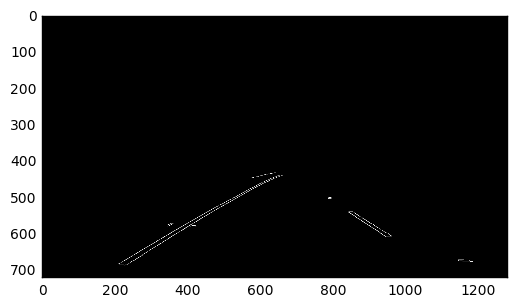

lines:   x1: 842  y1: 540  x1 944  y2 609
lines angle: [ 21.14989413]
lines:   x1: 460  y1: 544  x1 615  y2 458
lines angle: [ 20.64125841]
lines:   x1: 498  y1: 517  x1 599  y2 462
lines angle: [ 19.23139461]
lines:   x1: 281  y1: 642  x1 429  y2 554
lines angle: [ 20.33768128]
lines:   x1: 620  y1: 457  x1 650  y2 440
lines angle: [ 17.80629219]
lines:   x1: 854  y1: 540  x1 944  y2 598
lines angle: [ 20.52065673]
lines:   x1: 210  y1: 683  x1 341  y2 605
lines angle: [ 19.87941035]
lines:   x1: 441  y1: 547  x1 454  y2 549
lines angle: [ 17.62795058]
lines:   x1: 253  y1: 674  x1 366  y2 601
lines angle: [ 19.35423352]
lines:   x1: 232  y1: 686  x1 318  y2 631
lines angle: [ 18.78716177]
lines:   x1: 390  y1: 588  x1 410  y2 574
lines angle: [ 17.61238184]
lines:   x1: 575  y1: 447  x1 639  y2 433
lines angle: [ 18.69752948]
lines:   x1: 231  y1: 686  x1 247  y2 676
lines angle: [ 17.5666842]
lines:   x1: 636  y1: 449  x1 660  y2 440
lines angle: [ 17.75630935]
lines:   x1: 949  y1:

 66%|██████▌   | 165/251 [03:41<01:44,  1.21s/it]

Image shape is: (720, 1280)


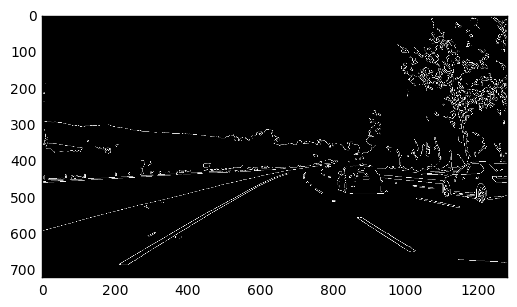

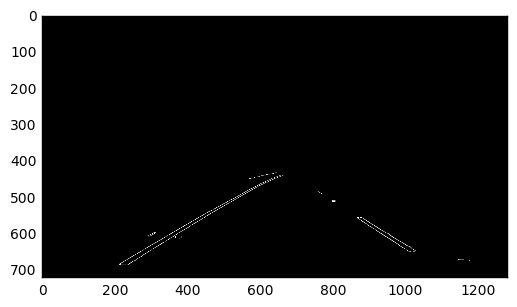

lines:   x1: 524  y1: 505  x1 551  y2 489
lines angle: [ 17.7483419]
lines:   x1: 246  y1: 663  x1 485  y2 525
lines angle: [ 23.75518956]
lines:   x1: 264  y1: 667  x1 361  y2 608
lines angle: [ 19.05509518]
lines:   x1: 349  y1: 614  x1 507  y2 519
lines angle: [ 20.60737477]
lines:   x1: 878  y1: 556  x1 1025  y2 648
lines angle: [ 23.68720731]
lines:   x1: 866  y1: 558  x1 956  y2 615
lines angle: [ 20.5051717]
lines:   x1: 485  y1: 526  x1 533  y2 499
lines angle: [ 18.12347822]
lines:   x1: 596  y1: 466  x1 608  y2 459
lines angle: [ 17.51111229]
lines:   x1: 555  y1: 488  x1 571  y2 478
lines angle: [ 17.5666842]
lines:   x1: 537  y1: 503  x1 551  y2 494
lines angle: [ 17.53353166]
lines:   x1: 899  y1: 580  x1 1009  y2 649
lines angle: [ 21.47322609]
lines:   x1: 235  y1: 686  x1 273  y2 663
lines angle: [ 17.92684919]
lines:   x1: 492  y1: 529  x1 535  y2 503
lines angle: [ 18.0126616]
lines:   x1: 567  y1: 450  x1 628  y2 436
lines angle: [ 18.6159231]
lines:   x1: 610  y1: 4

 66%|██████▌   | 166/251 [03:42<01:42,  1.20s/it]

Image shape is: (720, 1280)


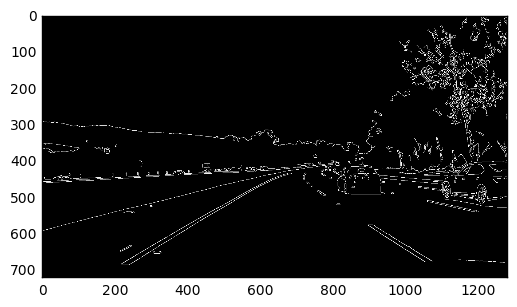

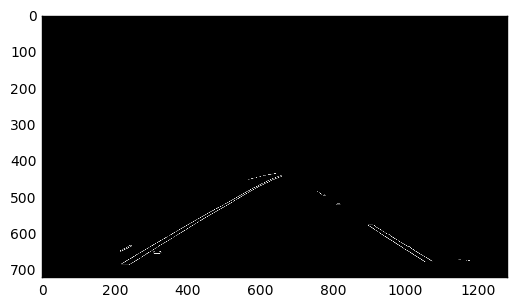

lines:   x1: 355  y1: 613  x1 550  y2 496
lines angle: [ 21.81283043]
lines:   x1: 390  y1: 581  x1 604  y2 462
lines angle: [ 22.73991552]
lines:   x1: 933  y1: 603  x1 1053  y2 678
lines angle: [ 22.00950324]
lines:   x1: 619  y1: 455  x1 658  y2 440
lines angle: [ 18.04163518]
lines:   x1: 918  y1: 583  x1 1073  y2 676
lines angle: [ 24.16318496]
lines:   x1: 217  y1: 684  x1 378  y2 588
lines angle: [ 20.70983197]
lines:   x1: 281  y1: 659  x1 398  y2 588
lines angle: [ 19.51178032]
lines:   x1: 563  y1: 452  x1 623  y2 438
lines angle: [ 18.58899328]
lines:   x1: 220  y1: 648  x1 245  y2 635
lines angle: [ 17.73549039]
lines:   x1: 524  y1: 513  x1 578  y2 480
lines angle: [ 18.20295719]
lines:   x1: 958  y1: 608  x1 1003  y2 635
lines angle: [ 18.69282216]
lines:   x1: 1054  y1: 678  x1 1071  y2 678
lines angle: [ 17.6955492]
lines:   x1: 215  y1: 646  x1 245  y2 632
lines angle: [ 17.83945152]
lines:   x1: 897  y1: 578  x1 914  y2 590
lines angle: [ 17.82547533]
lines:   x1: 584

 67%|██████▋   | 167/251 [03:43<01:39,  1.18s/it]

Image shape is: (720, 1280)


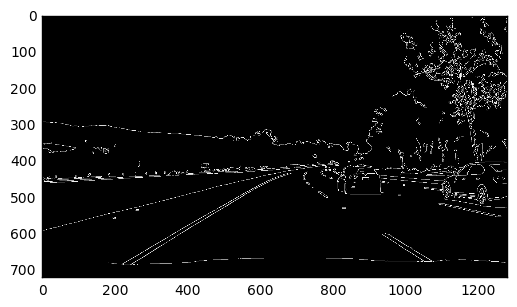

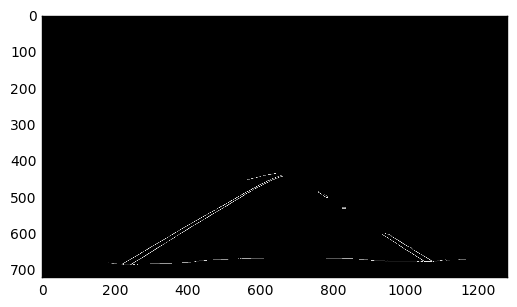

lines:   x1: 450  y1: 550  x1 597  y2 466
lines angle: [ 20.36523046]
lines:   x1: 341  y1: 624  x1 599  y2 469
lines angle: [ 24.57009737]
lines:   x1: 780  y1: 668  x1 854  y2 669
lines angle: [ 19.17715699]
lines:   x1: 948  y1: 601  x1 1075  y2 677
lines angle: [ 22.34729872]
lines:   x1: 240  y1: 673  x1 421  y2 565
lines angle: [ 21.34023533]
lines:   x1: 934  y1: 603  x1 990  y2 638
lines angle: [ 19.09953606]
lines:   x1: 913  y1: 675  x1 1015  y2 676
lines angle: [ 20.07307915]
lines:   x1: 1030  y1: 677  x1 1058  y2 677
lines angle: [ 17.94840729]
lines:   x1: 229  y1: 686  x1 304  y2 683
lines angle: [ 19.15336608]
lines:   x1: 454  y1: 673  x1 511  y2 671
lines angle: [ 18.65708149]
lines:   x1: 610  y1: 667  x1 779  y2 667
lines angle: [ 22.8994041]
lines:   x1: 263  y1: 674  x1 303  y2 648
lines angle: [ 17.94057585]
lines:   x1: 220  y1: 685  x1 393  y2 581
lines angle: [ 21.06545897]
lines:   x1: 1011  y1: 651  x1 1049  y2 676
lines angle: [ 18.48431013]
lines:   x1: 37

 67%|██████▋   | 168/251 [03:45<01:40,  1.21s/it]

Image shape is: (720, 1280)


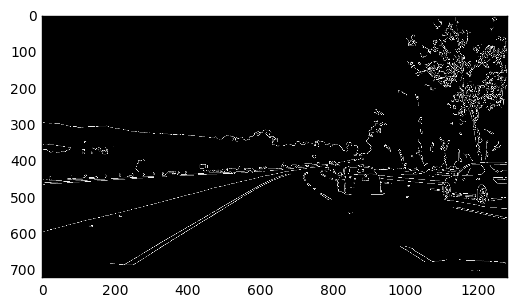

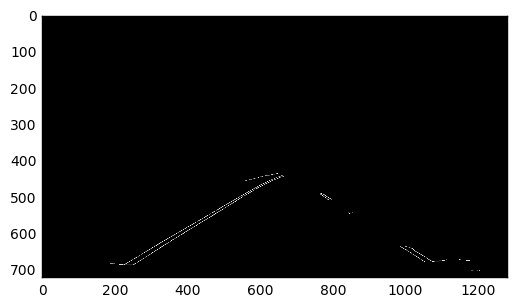

lines:   x1: 550  y1: 495  x1 614  y2 459
lines angle: [ 18.42457659]
lines:   x1: 623  y1: 456  x1 634  y2 450
lines angle: [ 17.4999587]
lines:   x1: 610  y1: 462  x1 624  y2 454
lines angle: [ 17.54406534]
lines:   x1: 226  y1: 685  x1 402  y2 580
lines angle: [ 21.17617629]
lines:   x1: 414  y1: 584  x1 446  y2 563
lines angle: [ 17.8083999]
lines:   x1: 260  y1: 681  x1 392  y2 596
lines angle: [ 19.80730184]
lines:   x1: 519  y1: 518  x1 618  y2 461
lines angle: [ 19.14264985]
lines:   x1: 531  y1: 506  x1 546  y2 496
lines angle: [ 17.54479782]
lines:   x1: 211  y1: 685  x1 250  y2 686
lines angle: [ 18.22628249]
lines:   x1: 984  y1: 636  x1 1019  y2 658
lines angle: [ 18.37197609]
lines:   x1: 990  y1: 637  x1 1049  y2 677
lines angle: [ 19.25245084]
lines:   x1: 765  y1: 493  x1 791  y2 508
lines angle: [ 18.0694789]
lines:   x1: 557  y1: 455  x1 619  y2 440
lines angle: [ 18.63051079]
lines:   x1: 252  y1: 685  x1 331  y2 634
lines angle: [ 18.64227267]
lines:   x1: 421  y1:

 67%|██████▋   | 169/251 [03:46<01:41,  1.24s/it]

Image shape is: (720, 1280)


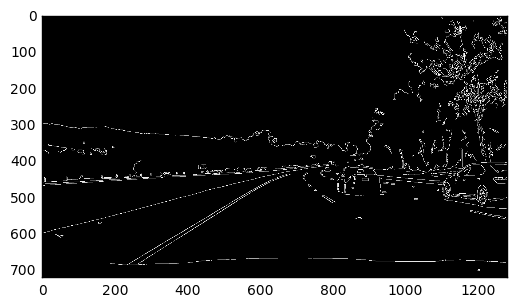

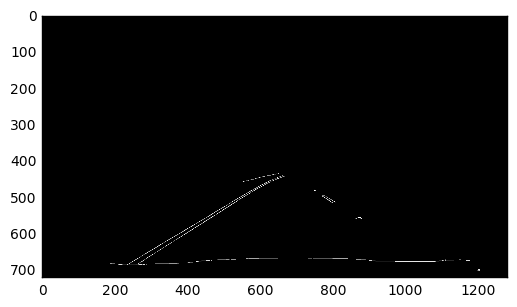

lines:   x1: 257  y1: 686  x1 494  y2 538
lines angle: [ 23.38968518]
lines:   x1: 224  y1: 686  x1 406  y2 680
lines angle: [ 23.47401184]
lines:   x1: 236  y1: 685  x1 588  y2 474
lines angle: [ 31.99218879]
lines:   x1: 532  y1: 670  x1 595  y2 669
lines angle: [ 18.83452476]
lines:   x1: 777  y1: 496  x1 805  y2 514
lines angle: [ 18.15185658]
lines:   x1: 330  y1: 640  x1 599  y2 472
lines angle: [ 24.998396]
lines:   x1: 664  y1: 667  x1 777  y2 668
lines angle: [ 20.46490605]
lines:   x1: 1021  y1: 677  x1 1049  y2 677
lines angle: [ 17.94840729]
lines:   x1: 1110  y1: 675  x1 1130  y2 675
lines angle: [ 17.7632419]
lines:   x1: 568  y1: 453  x1 649  y2 435
lines angle: [ 19.13061177]
lines:   x1: 614  y1: 668  x1 647  y2 668
lines angle: [ 18.06770037]
lines:   x1: 622  y1: 460  x1 664  y2 443
lines angle: [ 18.09168315]
lines:   x1: 601  y1: 468  x1 620  y2 457
lines angle: [ 17.62224909]
lines:   x1: 1076  y1: 676  x1 1089  y2 676
lines angle: [ 17.60672254]
lines:   x1: 947 

 68%|██████▊   | 170/251 [03:47<01:37,  1.20s/it]

Image shape is: (720, 1280)


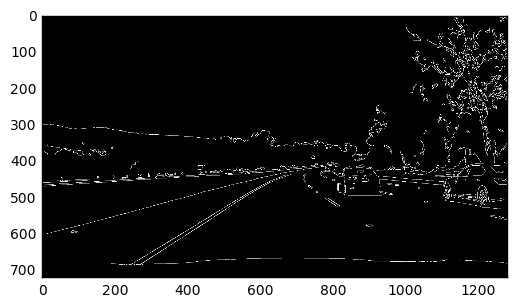

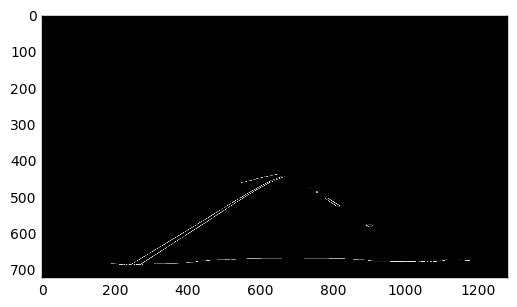

lines:   x1: 1018  y1: 677  x1 1069  y2 677
lines angle: [ 18.5215819]
lines:   x1: 349  y1: 622  x1 541  y2 503
lines angle: [ 21.63192125]
lines:   x1: 327  y1: 683  x1 355  y2 682
lines angle: [ 17.93723379]
lines:   x1: 270  y1: 685  x1 574  y2 488
lines angle: [ 26.98628986]
lines:   x1: 719  y1: 668  x1 787  y2 668
lines angle: [ 18.9889329]
lines:   x1: 245  y1: 685  x1 365  y2 611
lines angle: [ 19.56643943]
lines:   x1: 928  y1: 676  x1 956  y2 676
lines angle: [ 17.94840729]
lines:   x1: 600  y1: 473  x1 647  y2 450
lines angle: [ 18.14529998]
lines:   x1: 686  y1: 667  x1 718  y2 667
lines angle: [ 18.04361623]
lines:   x1: 544  y1: 670  x1 628  y2 668
lines angle: [ 19.43998126]
lines:   x1: 612  y1: 464  x1 627  y2 455
lines angle: [ 17.55535576]
lines:   x1: 371  y1: 682  x1 421  y2 678
lines angle: [ 18.44689728]
lines:   x1: 1070  y1: 678  x1 1107  y2 674
lines angle: [ 18.11908534]
lines:   x1: 437  y1: 675  x1 519  y2 671
lines angle: [ 19.35064773]
lines:   x1: 420  

 68%|██████▊   | 171/251 [03:48<01:34,  1.19s/it]

Image shape is: (720, 1280)


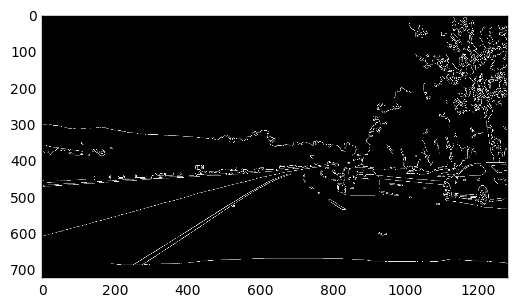

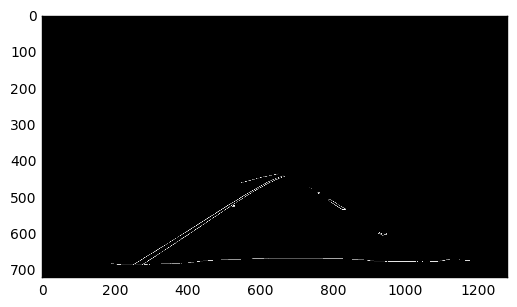

lines:   x1: 609  y1: 668  x1 770  y2 668
lines angle: [ 22.49323621]
lines:   x1: 252  y1: 685  x1 589  y2 475
lines angle: [ 30.02079401]
lines:   x1: 787  y1: 510  x1 810  y2 524
lines angle: [ 17.9869078]
lines:   x1: 565  y1: 455  x1 647  y2 436
lines angle: [ 19.14693841]
lines:   x1: 532  y1: 516  x1 582  y2 483
lines angle: [ 18.10309804]
lines:   x1: 527  y1: 671  x1 583  y2 669
lines angle: [ 18.63011064]
lines:   x1: 331  y1: 650  x1 544  y2 507
lines angle: [ 22.17283654]
lines:   x1: 226  y1: 686  x1 251  y2 685
lines angle: [ 17.8671092]
lines:   x1: 315  y1: 684  x1 357  y2 682
lines angle: [ 18.26618861]
lines:   x1: 613  y1: 467  x1 624  y2 456
lines angle: [ 17.4478324]
lines:   x1: 942  y1: 677  x1 993  y2 677
lines angle: [ 18.5215819]
lines:   x1: 1148  y1: 673  x1 1161  y2 673
lines angle: [ 17.60672254]
lines:   x1: 370  y1: 682  x1 495  y2 672
lines angle: [ 20.73911281]
lines:   x1: 264  y1: 686  x1 306  y2 684
lines angle: [ 18.26618861]
lines:   x1: 790  y1: 

 69%|██████▊   | 172/251 [03:50<01:39,  1.26s/it]

Image shape is: (720, 1280)


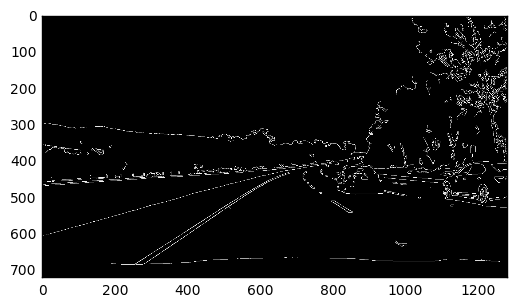

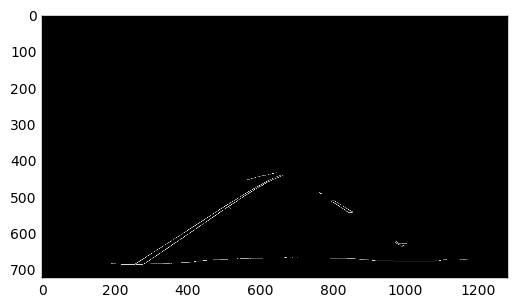

lines:   x1: 277  y1: 685  x1 583  y2 479
lines angle: [ 26.86216691]
lines:   x1: 320  y1: 643  x1 549  y2 495
lines angle: [ 22.92328919]
lines:   x1: 607  y1: 667  x1 789  y2 667
lines angle: [ 23.60896154]
lines:   x1: 965  y1: 676  x1 1079  y2 676
lines angle: [ 20.4858742]
lines:   x1: 523  y1: 670  x1 579  y2 668
lines angle: [ 18.63011064]
lines:   x1: 916  y1: 675  x1 959  y2 675
lines angle: [ 18.3149669]
lines:   x1: 465  y1: 673  x1 522  y2 670
lines angle: [ 18.64465471]
lines:   x1: 217  y1: 685  x1 259  y2 685
lines angle: [ 18.28970197]
lines:   x1: 842  y1: 535  x1 853  y2 540
lines angle: [ 17.61570518]
lines:   x1: 549  y1: 502  x1 590  y2 475
lines angle: [ 17.95313942]
lines:   x1: 597  y1: 471  x1 615  y2 462
lines angle: [ 17.62142477]
lines:   x1: 521  y1: 514  x1 579  y2 477
lines angle: [ 18.25691054]
lines:   x1: 375  y1: 681  x1 460  y2 673
lines angle: [ 19.38791123]
lines:   x1: 272  y1: 674  x1 346  y2 625
lines angle: [ 18.53074046]
lines:   x1: 563  y1:

 69%|██████▉   | 173/251 [03:51<01:37,  1.24s/it]

Image shape is: (720, 1280)


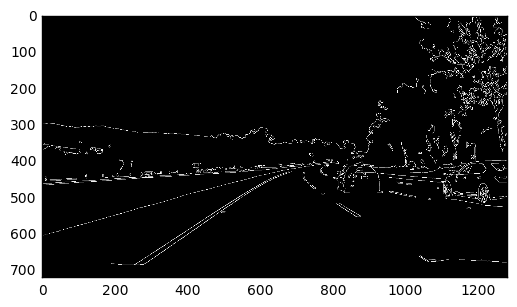

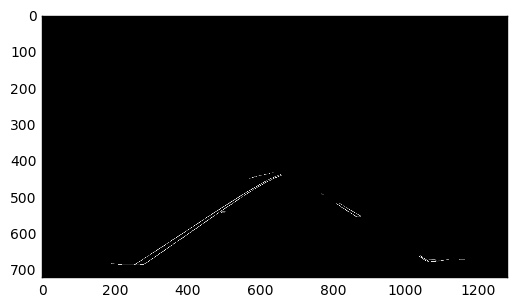

lines:   x1: 254  y1: 685  x1 566  y2 483
lines angle: [ 27.5747382]
lines:   x1: 456  y1: 562  x1 530  y2 513
lines angle: [ 18.53074046]
lines:   x1: 279  y1: 685  x1 388  y2 611
lines angle: [ 19.21451284]
lines:   x1: 607  y1: 439  x1 635  y2 433
lines angle: [ 17.88156753]
lines:   x1: 539  y1: 501  x1 585  y2 472
lines angle: [ 18.0511437]
lines:   x1: 816  y1: 516  x1 845  y2 535
lines angle: [ 18.18770884]
lines:   x1: 486  y1: 541  x1 592  y2 472
lines angle: [ 19.19133458]
lines:   x1: 604  y1: 461  x1 631  y2 447
lines angle: [ 17.77022528]
lines:   x1: 1043  y1: 668  x1 1072  y2 677
lines angle: [ 18.07358019]
lines:   x1: 368  y1: 623  x1 427  y2 584
lines angle: [ 18.25856108]
lines:   x1: 219  y1: 686  x1 269  y2 686
lines angle: [ 18.49530943]
lines:   x1: 590  y1: 469  x1 659  y2 440
lines angle: [ 18.64565818]
lines:   x1: 807  y1: 517  x1 864  y2 554
lines angle: [ 19.15449433]
lines:   x1: 346  y1: 625  x1 540  y2 499
lines angle: [ 21.58933853]
lines:   x1: 853  y1

 88%|████████▊ | 220/251 [05:02<00:38,  1.23s/it]

Image shape is: (720, 1280)


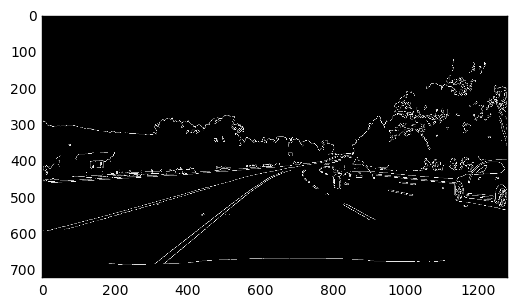

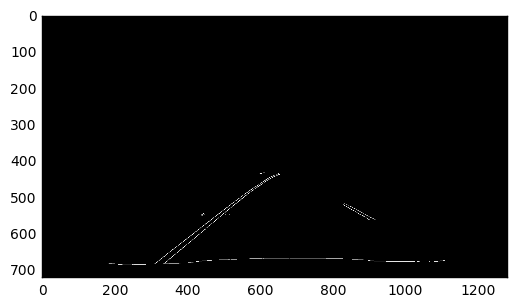

lines:   x1: 308  y1: 684  x1 556  y2 491
lines angle: [ 22.97542884]
lines:   x1: 335  y1: 683  x1 559  y2 495
lines angle: [ 21.79347643]
lines:   x1: 662  y1: 668  x1 718  y2 668
lines angle: [ 18.65491531]
lines:   x1: 221  y1: 686  x1 234  y2 686
lines angle: [ 17.60672254]
lines:   x1: 307  y1: 684  x1 524  y2 515
lines angle: [ 21.83624818]
lines:   x1: 453  y1: 674  x1 630  y2 668
lines angle: [ 23.19728966]
lines:   x1: 869  y1: 672  x1 894  y2 673
lines angle: [ 17.88922961]
lines:   x1: 572  y1: 480  x1 589  y2 470
lines angle: [ 17.58867002]
lines:   x1: 1025  y1: 678  x1 1086  y2 677
lines angle: [ 18.77896819]
lines:   x1: 638  y1: 444  x1 652  y2 437
lines angle: [ 17.55461127]
lines:   x1: 827  y1: 521  x1 903  y2 563
lines angle: [ 19.80484333]
lines:   x1: 863  y1: 535  x1 886  y2 546
lines angle: [ 17.95346746]
lines:   x1: 561  y1: 495  x1 578  y2 481
lines angle: [ 17.54626764]
lines:   x1: 616  y1: 455  x1 640  y2 442
lines angle: [ 17.71280018]
lines:   x1: 248  

 88%|████████▊ | 221/251 [05:04<00:36,  1.23s/it]

Image shape is: (720, 1280)


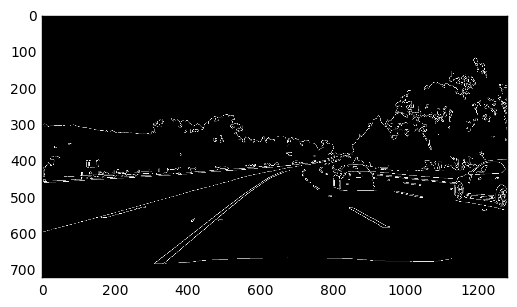

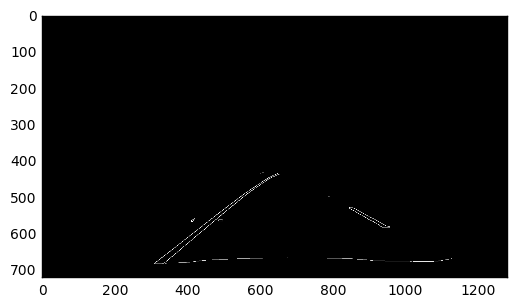

lines:   x1: 334  y1: 682  x1 559  y2 494
lines angle: [ 21.84324494]
lines:   x1: 854  y1: 529  x1 947  y2 580
lines angle: [ 20.52029457]
lines:   x1: 844  y1: 530  x1 926  y2 576
lines angle: [ 20.06080171]
lines:   x1: 547  y1: 498  x1 581  y2 473
lines angle: [ 17.81051719]
lines:   x1: 308  y1: 683  x1 553  y2 492
lines angle: [ 22.84835537]
lines:   x1: 733  y1: 667  x1 824  y2 668
lines angle: [ 19.70476415]
lines:   x1: 603  y1: 458  x1 634  y2 440
lines angle: [ 17.81839784]
lines:   x1: 535  y1: 669  x1 571  y2 669
lines angle: [ 18.14064214]
lines:   x1: 966  y1: 676  x1 1018  y2 676
lines angle: [ 18.54798449]
lines:   x1: 481  y1: 672  x1 523  y2 670
lines angle: [ 18.26618861]
lines:   x1: 606  y1: 667  x1 659  y2 667
lines angle: [ 18.57451815]
lines:   x1: 1069  y1: 677  x1 1110  y2 672
lines angle: [ 18.20610369]
lines:   x1: 844  y1: 531  x1 902  y2 564
lines angle: [ 19.13117851]
lines:   x1: 931  y1: 675  x1 959  y2 676
lines angle: [ 17.95959425]
lines:   x1: 590 

 88%|████████▊ | 222/251 [05:05<00:34,  1.20s/it]

Image shape is: (720, 1280)


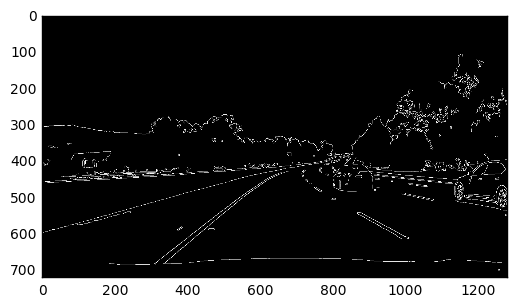

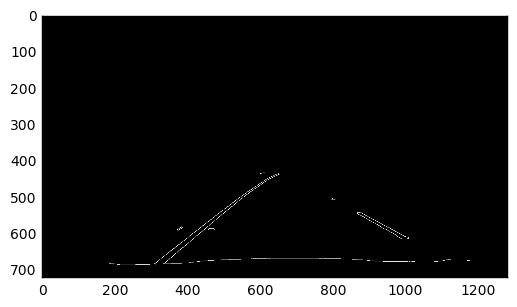

lines:   x1: 332  y1: 684  x1 548  y2 503
lines angle: [ 21.54592615]
lines:   x1: 307  y1: 684  x1 550  y2 495
lines angle: [ 22.78023637]
lines:   x1: 312  y1: 685  x1 417  y2 679
lines angle: [ 20.07119265]
lines:   x1: 971  y1: 595  x1 1008  y2 613
lines angle: [ 18.37548873]
lines:   x1: 868  y1: 547  x1 884  y2 554
lines angle: [ 17.74849209]
lines:   x1: 694  y1: 668  x1 807  y2 669
lines angle: [ 20.46490605]
lines:   x1: 598  y1: 462  x1 634  y2 441
lines angle: [ 17.90197471]
lines:   x1: 568  y1: 482  x1 590  y2 469
lines angle: [ 17.66773194]
lines:   x1: 1025  y1: 678  x1 1050  y2 678
lines angle: [ 17.87816279]
lines:   x1: 851  y1: 670  x1 941  y2 677
lines angle: [ 19.75848339]
lines:   x1: 323  y1: 671  x1 497  y2 535
lines angle: [ 20.54379582]
lines:   x1: 227  y1: 686  x1 254  y2 686
lines angle: [ 17.92488305]
lines:   x1: 595  y1: 469  x1 608  y2 461
lines angle: [ 17.52230321]
lines:   x1: 873  y1: 542  x1 894  y2 552
lines angle: [ 17.8957007]
lines:   x1: 905  

 89%|████████▉ | 223/251 [05:06<00:34,  1.23s/it]

Image shape is: (720, 1280)


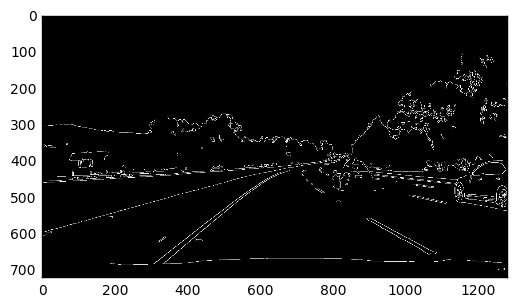

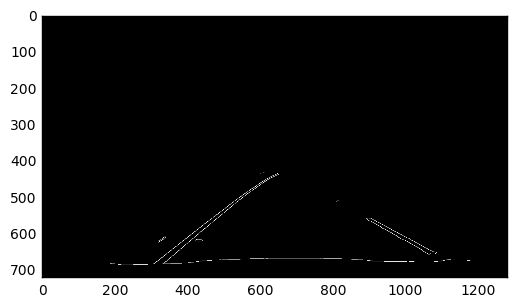

lines:   x1: 332  y1: 683  x1 546  y2 504
lines angle: [ 21.49061963]
lines:   x1: 305  y1: 684  x1 527  y2 511
lines angle: [ 22.00372849]
lines:   x1: 924  y1: 579  x1 976  y2 607
lines angle: [ 18.89655206]
lines:   x1: 312  y1: 684  x1 368  y2 682
lines angle: [ 18.63011064]
lines:   x1: 218  y1: 686  x1 233  y2 686
lines angle: [ 17.65093385]
lines:   x1: 706  y1: 668  x1 849  y2 670
lines angle: [ 21.69071892]
lines:   x1: 456  y1: 567  x1 553  y2 492
lines angle: [ 18.84064238]
lines:   x1: 374  y1: 682  x1 468  y2 673
lines angle: [ 19.65861148]
lines:   x1: 901  y1: 558  x1 1083  y2 654
lines angle: [ 25.98455075]
lines:   x1: 609  y1: 454  x1 646  y2 435
lines angle: [ 17.94819482]
lines:   x1: 318  y1: 621  x1 339  y2 609
lines angle: [ 17.6560961]
lines:   x1: 572  y1: 479  x1 592  y2 467
lines angle: [ 17.63378119]
lines:   x1: 545  y1: 670  x1 571  y2 670
lines angle: [ 17.90146847]
lines:   x1: 251  y1: 685  x1 291  y2 685
lines angle: [ 18.23953695]
lines:   x1: 996  y1

 89%|████████▉ | 224/251 [05:07<00:33,  1.24s/it]

Image shape is: (720, 1280)


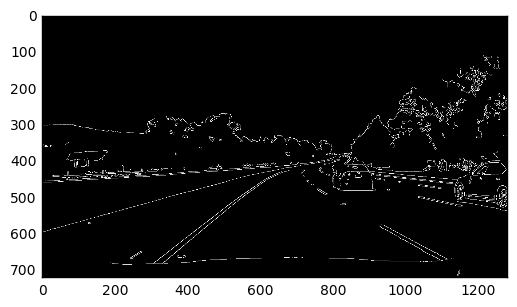

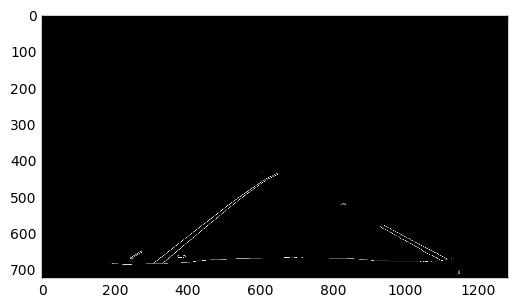

lines:   x1: 403  y1: 622  x1 466  y2 568
lines angle: [ 18.18146881]
lines:   x1: 680  y1: 667  x1 787  y2 667
lines angle: [ 20.23274291]
lines:   x1: 583  y1: 668  x1 639  y2 667
lines angle: [ 18.64250502]
lines:   x1: 468  y1: 568  x1 524  y2 520
lines angle: [ 18.07667798]
lines:   x1: 305  y1: 683  x1 536  y2 503
lines angle: [ 22.32173797]
lines:   x1: 936  y1: 577  x1 1112  y2 670
lines angle: [ 25.48623016]
lines:   x1: 331  y1: 682  x1 382  y2 638
lines angle: [ 18.0002187]
lines:   x1: 912  y1: 675  x1 957  y2 675
lines angle: [ 18.36586597]
lines:   x1: 304  y1: 683  x1 521  y2 514
lines angle: [ 21.83624818]
lines:   x1: 1063  y1: 656  x1 1099  y2 674
lines angle: [ 18.3501616]
lines:   x1: 351  y1: 666  x1 444  y2 586
lines angle: [ 18.66069491]
lines:   x1: 550  y1: 493  x1 571  y2 480
lines angle: [ 17.64535249]
lines:   x1: 587  y1: 469  x1 598  y2 460
lines angle: [ 17.46864677]
lines:   x1: 600  y1: 459  x1 633  y2 440
lines angle: [ 17.85385489]
lines:   x1: 1007  

 90%|████████▉ | 225/251 [05:09<00:33,  1.29s/it]

Image shape is: (720, 1280)


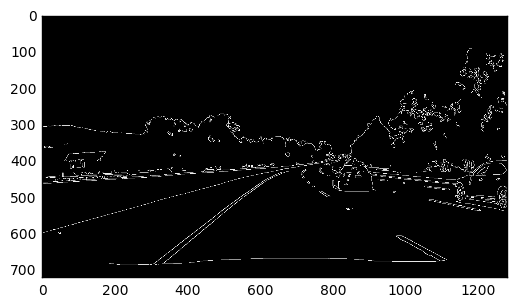

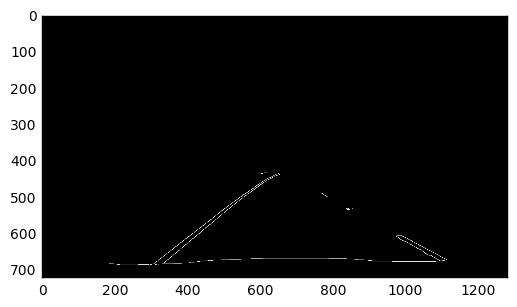

lines:   x1: 215  y1: 686  x1 243  y2 686
lines angle: [ 17.94840729]
lines:   x1: 306  y1: 684  x1 524  y2 514
lines angle: [ 21.86526955]
lines:   x1: 330  y1: 684  x1 519  y2 526
lines angle: [ 20.7723646]
lines:   x1: 543  y1: 500  x1 617  y2 450
lines angle: [ 18.51824074]
lines:   x1: 608  y1: 668  x1 789  y2 668
lines angle: [ 23.55205177]
lines:   x1: 360  y1: 683  x1 496  y2 672
lines angle: [ 21.16043927]
lines:   x1: 987  y1: 606  x1 1110  y2 671
lines angle: [ 21.95965108]
lines:   x1: 527  y1: 512  x1 594  y2 466
lines angle: [ 18.38123433]
lines:   x1: 1018  y1: 677  x1 1074  y2 677
lines angle: [ 18.65491531]
lines:   x1: 993  y1: 619  x1 1049  y2 650
lines angle: [ 19.04769218]
lines:   x1: 814  y1: 669  x1 895  y2 673
lines angle: [ 19.42997729]
lines:   x1: 263  y1: 685  x1 302  y2 685
lines angle: [ 18.21463513]
lines:   x1: 617  y1: 455  x1 631  y2 443
lines angle: [ 17.50200403]
lines:   x1: 1007  y1: 626  x1 1048  y2 649
lines angle: [ 18.53818811]
lines:   x1: 76

 90%|█████████ | 226/251 [05:10<00:32,  1.31s/it]

Image shape is: (720, 1280)


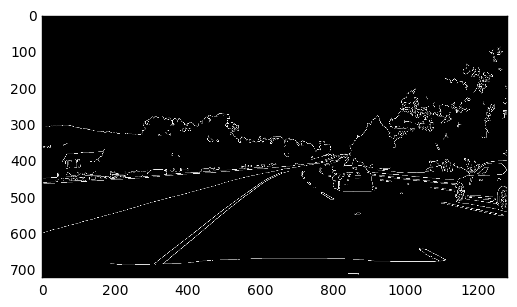

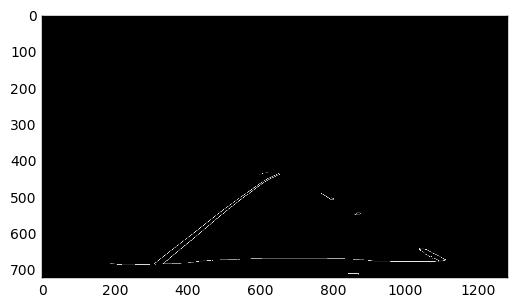

lines:   x1: 333  y1: 683  x1 535  y2 514
lines angle: [ 21.13262954]
lines:   x1: 524  y1: 671  x1 552  y2 670
lines angle: [ 17.93723379]
lines:   x1: 540  y1: 510  x1 632  y2 443
lines angle: [ 18.80179545]
lines:   x1: 332  y1: 663  x1 433  y2 586
lines angle: [ 18.93113026]
lines:   x1: 518  y1: 519  x1 612  y2 453
lines angle: [ 18.8727775]
lines:   x1: 605  y1: 668  x1 783  y2 668
lines angle: [ 23.38372274]
lines:   x1: 478  y1: 549  x1 528  y2 513
lines angle: [ 18.06823823]
lines:   x1: 957  y1: 677  x1 1088  y2 677
lines angle: [ 21.14565713]
lines:   x1: 777  y1: 669  x1 831  y2 669
lines angle: [ 18.60118385]
lines:   x1: 1052  y1: 655  x1 1093  y2 676
lines angle: [ 18.51408061]
lines:   x1: 407  y1: 605  x1 447  y2 575
lines angle: [ 17.8954211]
lines:   x1: 770  y1: 492  x1 798  y2 507
lines angle: [ 18.11763939]
lines:   x1: 391  y1: 681  x1 464  y2 673
lines angle: [ 19.02852476]
lines:   x1: 205  y1: 685  x1 253  y2 686
lines angle: [ 18.45519996]
lines:   x1: 1071  

 90%|█████████ | 227/251 [05:11<00:30,  1.29s/it]

Image shape is: (720, 1280)


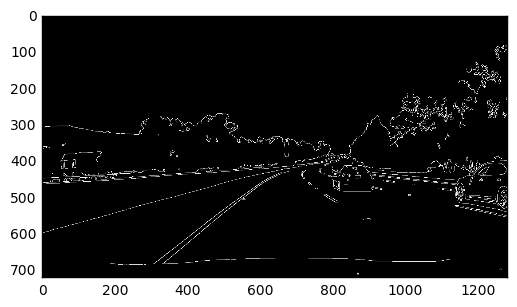

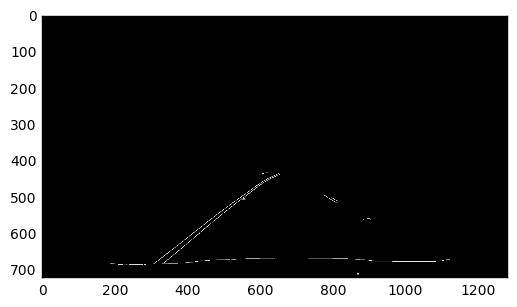

lines:   x1: 392  y1: 632  x1 454  y2 581
lines angle: [ 18.1918111]
lines:   x1: 683  y1: 667  x1 839  y2 669
lines angle: [ 22.28938369]
lines:   x1: 520  y1: 671  x1 576  y2 669
lines angle: [ 18.63011064]
lines:   x1: 840  y1: 670  x1 860  y2 670
lines angle: [ 17.7632419]
lines:   x1: 452  y1: 581  x1 604  y2 462
lines angle: [ 19.98685682]
lines:   x1: 342  y1: 683  x1 375  y2 681
lines angle: [ 18.0449574]
lines:   x1: 305  y1: 684  x1 511  y2 524
lines angle: [ 21.48760916]
lines:   x1: 309  y1: 684  x1 335  y2 683
lines angle: [ 17.89037516]
lines:   x1: 961  y1: 677  x1 1082  y2 677
lines angle: [ 20.74950791]
lines:   x1: 610  y1: 454  x1 648  y2 436
lines angle: [ 17.9833963]
lines:   x1: 383  y1: 681  x1 477  y2 672
lines angle: [ 19.65861148]
lines:   x1: 607  y1: 460  x1 627  y2 450
lines angle: [ 17.65523095]
lines:   x1: 785  y1: 502  x1 807  y2 514
lines angle: [ 17.94114362]
lines:   x1: 640  y1: 667  x1 682  y2 667
lines angle: [ 18.28970197]
lines:   x1: 525  y1: 5

 91%|█████████ | 228/251 [05:13<00:29,  1.28s/it]

Image shape is: (720, 1280)


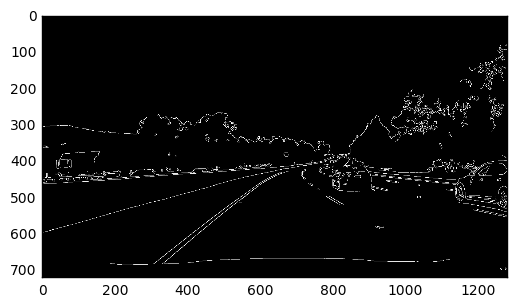

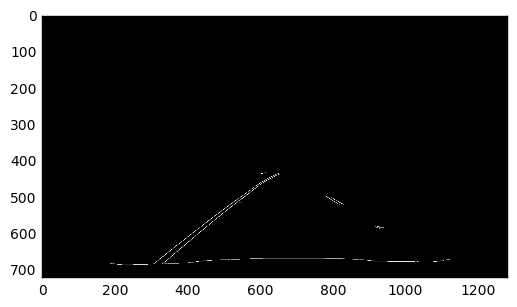

lines:   x1: 330  y1: 684  x1 520  y2 525
lines angle: [ 20.796472]
lines:   x1: 329  y1: 684  x1 495  y2 545
lines angle: [ 20.18220245]
lines:   x1: 453  y1: 674  x1 510  y2 672
lines angle: [ 18.65708149]
lines:   x1: 438  y1: 579  x1 611  y2 453
lines angle: [ 20.67630313]
lines:   x1: 306  y1: 684  x1 413  y2 598
lines angle: [ 18.98802494]
lines:   x1: 469  y1: 555  x1 601  y2 459
lines angle: [ 19.64130346]
lines:   x1: 251  y1: 685  x1 290  y2 685
lines angle: [ 18.21463513]
lines:   x1: 616  y1: 450  x1 649  y2 435
lines angle: [ 17.89846708]
lines:   x1: 606  y1: 668  x1 778  y2 668
lines angle: [ 23.05750315]
lines:   x1: 376  y1: 629  x1 426  y2 588
lines angle: [ 18.01042607]
lines:   x1: 784  y1: 501  x1 820  y2 522
lines angle: [ 18.38553666]
lines:   x1: 1082  y1: 677  x1 1120  y2 671
lines angle: [ 18.12052675]
lines:   x1: 377  y1: 681  x1 399  y2 681
lines angle: [ 17.80889169]
lines:   x1: 846  y1: 670  x1 925  y2 676
lines angle: [ 19.39584489]
lines:   x1: 571  y1

 91%|█████████ | 229/251 [05:14<00:27,  1.26s/it]

Image shape is: (720, 1280)


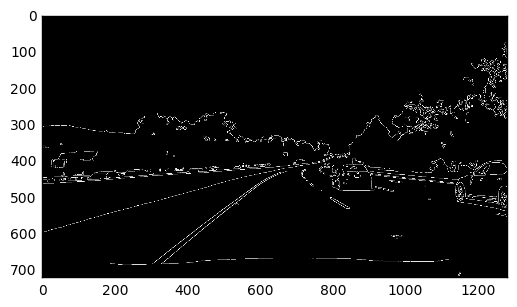

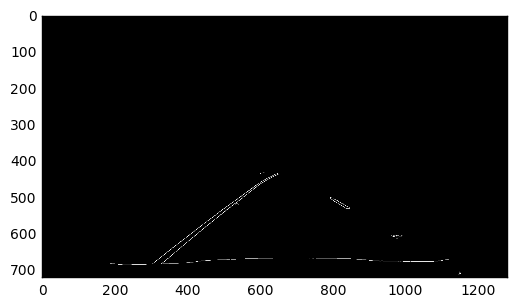

lines:   x1: 433  y1: 581  x1 609  y2 453
lines angle: [ 20.76406416]
lines:   x1: 221  y1: 686  x1 232  y2 686
lines angle: [ 17.56290987]
lines:   x1: 660  y1: 667  x1 716  y2 667
lines angle: [ 18.65491531]
lines:   x1: 978  y1: 677  x1 1076  y2 677
lines angle: [ 19.9217505]
lines:   x1: 372  y1: 682  x1 466  y2 673
lines angle: [ 19.65861148]
lines:   x1: 439  y1: 589  x1 622  y2 446
lines angle: [ 20.78899843]
lines:   x1: 533  y1: 670  x1 576  y2 669
lines angle: [ 18.30315868]
lines:   x1: 879  y1: 672  x1 938  y2 676
lines angle: [ 18.78691728]
lines:   x1: 425  y1: 601  x1 497  y2 544
lines angle: [ 18.37813504]
lines:   x1: 594  y1: 668  x1 633  y2 668
lines angle: [ 18.21463513]
lines:   x1: 325  y1: 684  x1 362  y2 655
lines angle: [ 17.83598957]
lines:   x1: 791  y1: 504  x1 837  y2 531
lines angle: [ 18.71971084]
lines:   x1: 962  y1: 607  x1 985  y2 604
lines angle: [ 17.79898968]
lines:   x1: 350  y1: 647  x1 429  y2 584
lines angle: [ 18.49076762]
lines:   x1: 371  y1

 92%|█████████▏| 230/251 [05:15<00:27,  1.29s/it]

Image shape is: (720, 1280)


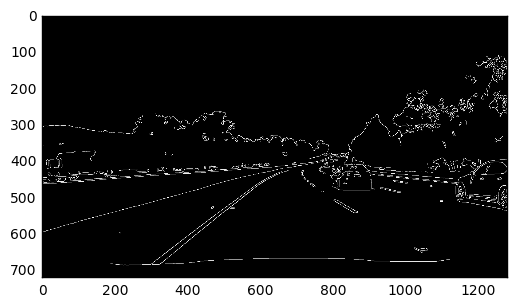

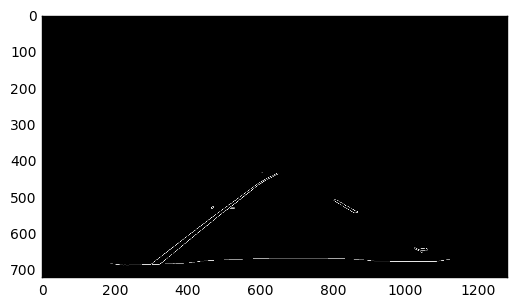

lines:   x1: 223  y1: 687  x1 257  y2 686
lines angle: [ 18.08047869]
lines:   x1: 514  y1: 671  x1 578  y2 670
lines angle: [ 18.86251538]
lines:   x1: 448  y1: 569  x1 606  y2 454
lines angle: [ 20.27375497]
lines:   x1: 999  y1: 677  x1 1027  y2 677
lines angle: [ 17.94840729]
lines:   x1: 624  y1: 668  x1 784  y2 668
lines angle: [ 22.44398185]
lines:   x1: 553  y1: 498  x1 613  y2 454
lines angle: [ 18.22437686]
lines:   x1: 777  y1: 669  x1 832  y2 669
lines angle: [ 18.62798258]
lines:   x1: 878  y1: 672  x1 918  y2 676
lines angle: [ 18.28638731]
lines:   x1: 416  y1: 593  x1 438  y2 578
lines angle: [ 17.64620711]
lines:   x1: 334  y1: 675  x1 353  y2 661
lines angle: [ 17.59024342]
lines:   x1: 329  y1: 662  x1 403  y2 603
lines angle: [ 18.40647136]
lines:   x1: 489  y1: 548  x1 570  y2 486
lines angle: [ 18.55778048]
lines:   x1: 1112  y1: 671  x1 1123  y2 670
lines angle: [ 17.55238756]
lines:   x1: 801  y1: 510  x1 857  y2 543
lines angle: [ 19.0735802]
lines:   x1: 340  

 92%|█████████▏| 231/251 [05:16<00:26,  1.30s/it]

Image shape is: (720, 1280)


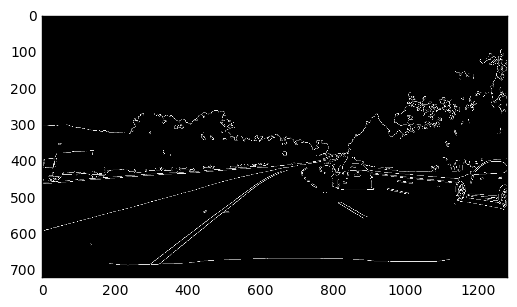

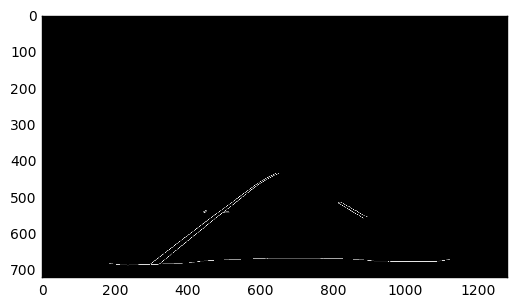

lines:   x1: 514  y1: 671  x1 579  y2 670
lines angle: [ 18.89064897]
lines:   x1: 319  y1: 685  x1 502  y2 537
lines angle: [ 20.7004432]
lines:   x1: 295  y1: 685  x1 374  y2 624
lines angle: [ 18.51585322]
lines:   x1: 507  y1: 535  x1 598  y2 462
lines angle: [ 18.69501418]
lines:   x1: 951  y1: 677  x1 1084  y2 677
lines angle: [ 21.22780191]
lines:   x1: 301  y1: 682  x1 458  y2 560
lines angle: [ 20.12219473]
lines:   x1: 580  y1: 669  x1 620  y2 669
lines angle: [ 18.23953695]
lines:   x1: 384  y1: 618  x1 477  y2 546
lines angle: [ 18.76489239]
lines:   x1: 819  y1: 514  x1 894  y2 555
lines angle: [ 19.75839956]
lines:   x1: 530  y1: 507  x1 611  y2 450
lines angle: [ 18.62120291]
lines:   x1: 826  y1: 670  x1 869  y2 671
lines angle: [ 18.32678984]
lines:   x1: 791  y1: 669  x1 825  y2 669
lines angle: [ 18.09189886]
lines:   x1: 613  y1: 668  x1 772  y2 668
lines angle: [ 22.39505362]
lines:   x1: 282  y1: 685  x1 318  y2 685
lines angle: [ 18.14064214]
lines:   x1: 817  y1

 92%|█████████▏| 232/251 [05:18<00:23,  1.25s/it]

Image shape is: (720, 1280)


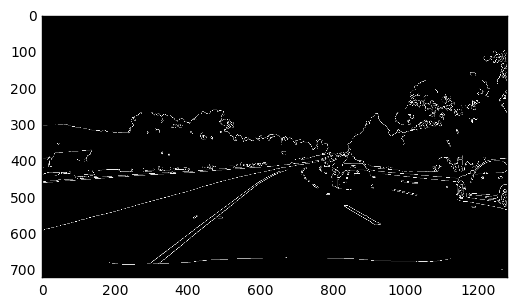

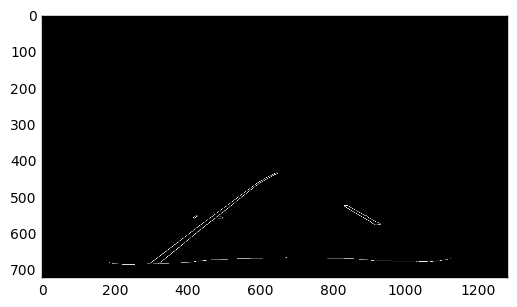

lines:   x1: 420  y1: 601  x1 604  y2 457
lines angle: [ 20.81297774]
lines:   x1: 468  y1: 553  x1 595  y2 458
lines angle: [ 19.48935398]
lines:   x1: 829  y1: 525  x1 891  y2 562
lines angle: [ 19.3014192]
lines:   x1: 233  y1: 685  x1 407  y2 679
lines angle: [ 23.03584201]
lines:   x1: 606  y1: 667  x1 783  y2 667
lines angle: [ 23.32839949]
lines:   x1: 316  y1: 668  x1 440  y2 572
lines angle: [ 19.37698205]
lines:   x1: 958  y1: 676  x1 1033  y2 676
lines angle: [ 19.19348331]
lines:   x1: 417  y1: 591  x1 482  y2 541
lines angle: [ 18.28060172]
lines:   x1: 488  y1: 671  x1 510  y2 671
lines angle: [ 17.80889169]
lines:   x1: 822  y1: 668  x1 910  y2 674
lines angle: [ 19.6792163]
lines:   x1: 387  y1: 628  x1 524  y2 520
lines angle: [ 19.63059233]
lines:   x1: 834  y1: 522  x1 929  y2 574
lines angle: [ 20.60873043]
lines:   x1: 1028  y1: 677  x1 1074  y2 677
lines angle: [ 18.3915019]
lines:   x1: 830  y1: 525  x1 916  y2 576
lines angle: [ 20.27210305]
lines:   x1: 911  y1

 93%|█████████▎| 233/251 [05:19<00:22,  1.24s/it]

Image shape is: (720, 1280)


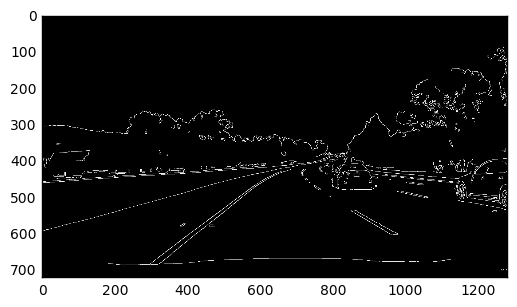

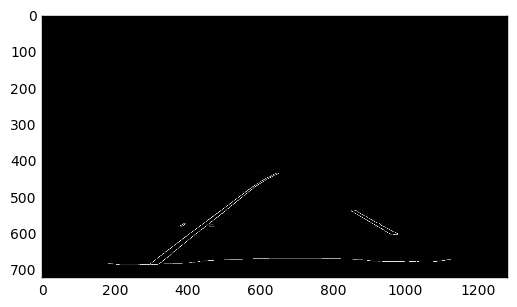

lines:   x1: 386  y1: 681  x1 410  y2 680
lines angle: [ 17.84395115]
lines:   x1: 527  y1: 671  x1 564  y2 670
lines angle: [ 18.15364151]
lines:   x1: 406  y1: 599  x1 526  y2 511
lines angle: [ 19.36341294]
lines:   x1: 443  y1: 586  x1 592  y2 466
lines angle: [ 19.86345972]
lines:   x1: 318  y1: 685  x1 446  y2 582
lines angle: [ 19.40524469]
lines:   x1: 953  y1: 677  x1 981  y2 677
lines angle: [ 17.94840729]
lines:   x1: 624  y1: 668  x1 768  y2 668
lines angle: [ 21.69820879]
lines:   x1: 850  y1: 539  x1 962  y2 604
lines angle: [ 21.48686417]
lines:   x1: 769  y1: 669  x1 821  y2 669
lines angle: [ 18.54798449]
lines:   x1: 294  y1: 685  x1 372  y2 625
lines angle: [ 18.50128988]
lines:   x1: 585  y1: 466  x1 643  y2 434
lines angle: [ 18.31679094]
lines:   x1: 861  y1: 537  x1 963  y2 595
lines angle: [ 20.96828742]
lines:   x1: 867  y1: 672  x1 881  y2 672
lines angle: [ 17.62877803]
lines:   x1: 369  y1: 682  x1 385  y2 682
lines angle: [ 17.67319068]
lines:   x1: 213  y1

 93%|█████████▎| 234/251 [05:20<00:20,  1.23s/it]

Image shape is: (720, 1280)


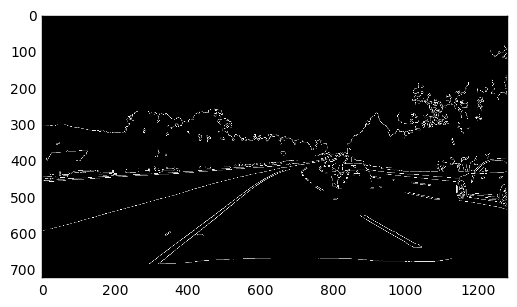

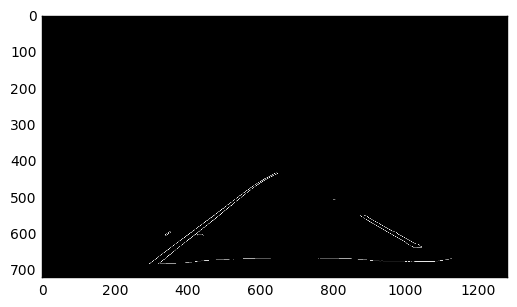

lines:   x1: 515  y1: 670  x1 585  y2 669
lines angle: [ 19.0335]
lines:   x1: 294  y1: 683  x1 576  y2 471
lines angle: [ 24.70710861]
lines:   x1: 340  y1: 666  x1 490  y2 548
lines angle: [ 19.93052301]
lines:   x1: 898  y1: 558  x1 976  y2 600
lines angle: [ 19.86990074]
lines:   x1: 873  y1: 551  x1 1000  y2 625
lines angle: [ 22.3092821]
lines:   x1: 507  y1: 532  x1 595  y2 463
lines angle: [ 18.66232207]
lines:   x1: 494  y1: 543  x1 557  y2 493
lines angle: [ 18.2292258]
lines:   x1: 999  y1: 625  x1 1023  y2 639
lines angle: [ 18.0105552]
lines:   x1: 614  y1: 668  x1 651  y2 667
lines angle: [ 18.15364151]
lines:   x1: 684  y1: 667  x1 740  y2 667
lines angle: [ 18.65491531]
lines:   x1: 320  y1: 683  x1 355  y2 656
lines angle: [ 17.81157944]
lines:   x1: 976  y1: 601  x1 1041  y2 636
lines angle: [ 19.3644267]
lines:   x1: 337  y1: 607  x1 353  y2 596
lines angle: [ 17.55610189]
lines:   x1: 363  y1: 682  x1 488  y2 672
lines angle: [ 20.73911281]
lines:   x1: 375  y1: 623

 94%|█████████▎| 235/251 [05:21<00:19,  1.21s/it]

Image shape is: (720, 1280)


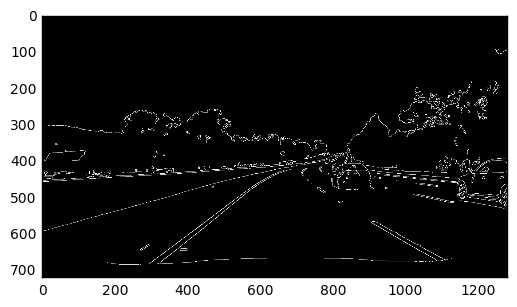

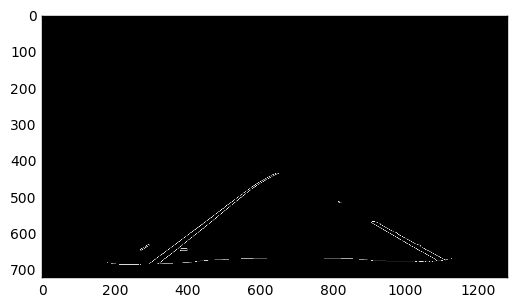

lines:   x1: 293  y1: 684  x1 578  y2 470
lines angle: [ 24.8714811]
lines:   x1: 473  y1: 560  x1 578  y2 475
lines angle: [ 18.94185638]
lines:   x1: 904  y1: 570  x1 1087  y2 676
lines angle: [ 26.33156351]
lines:   x1: 917  y1: 568  x1 1107  y2 673
lines angle: [ 26.83514469]
lines:   x1: 319  y1: 683  x1 453  y2 578
lines angle: [ 19.57423014]
lines:   x1: 619  y1: 667  x1 773  y2 667
lines angle: [ 22.1551952]
lines:   x1: 519  y1: 515  x1 589  y2 463
lines angle: [ 18.38673535]
lines:   x1: 957  y1: 676  x1 1013  y2 676
lines angle: [ 18.65491531]
lines:   x1: 292  y1: 684  x1 427  y2 583
lines angle: [ 19.66797565]
lines:   x1: 272  y1: 646  x1 294  y2 631
lines angle: [ 17.64620711]
lines:   x1: 212  y1: 685  x1 270  y2 685
lines angle: [ 18.70918677]
lines:   x1: 1043  y1: 677  x1 1107  y2 674
lines angle: [ 18.83695054]
lines:   x1: 580  y1: 668  x1 618  y2 668
lines angle: [ 18.18985261]
lines:   x1: 399  y1: 680  x1 448  y2 674
lines angle: [ 18.39691589]
lines:   x1: 436 

 94%|█████████▍| 236/251 [05:23<00:19,  1.30s/it]

Image shape is: (720, 1280)


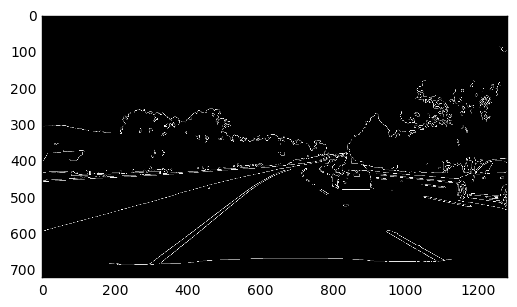

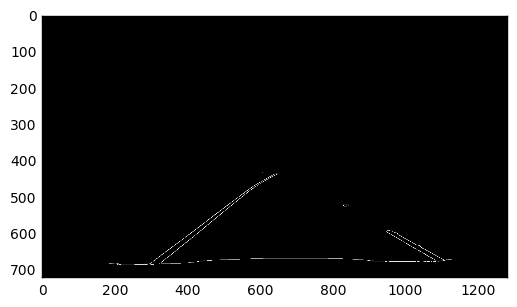

lines:   x1: 295  y1: 684  x1 579  y2 470
lines angle: [ 24.79726543]
lines:   x1: 974  y1: 611  x1 1025  y2 642
lines angle: [ 18.90674331]
lines:   x1: 987  y1: 609  x1 1102  y2 671
lines angle: [ 21.55994733]
lines:   x1: 321  y1: 684  x1 585  y2 471
lines angle: [ 23.46071132]
lines:   x1: 593  y1: 467  x1 613  y2 450
lines angle: [ 17.58037695]
lines:   x1: 827  y1: 670  x1 869  y2 671
lines angle: [ 18.3014806]
lines:   x1: 448  y1: 581  x1 575  y2 478
lines angle: [ 19.37275491]
lines:   x1: 503  y1: 672  x1 559  y2 670
lines angle: [ 18.63011064]
lines:   x1: 607  y1: 668  x1 784  y2 668
lines angle: [ 23.32839949]
lines:   x1: 780  y1: 669  x1 826  y2 669
lines angle: [ 18.3915019]
lines:   x1: 977  y1: 603  x1 1015  y2 623
lines angle: [ 18.4246848]
lines:   x1: 1003  y1: 628  x1 1084  y2 676
lines angle: [ 20.05653215]
lines:   x1: 219  y1: 686  x1 253  y2 686
lines angle: [ 18.09189886]
lines:   x1: 627  y1: 446  x1 648  y2 436
lines angle: [ 17.67762137]
lines:   x1: 902  

 94%|█████████▍| 237/251 [05:24<00:17,  1.26s/it]

Image shape is: (720, 1280)


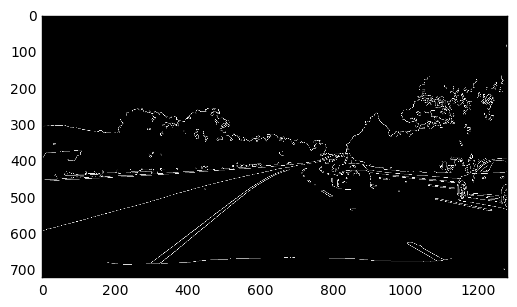

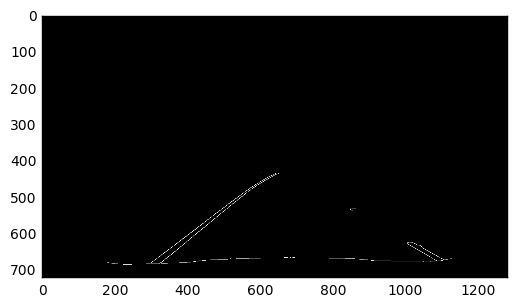

lines:   x1: 903  y1: 674  x1 979  y2 676
lines angle: [ 19.25026456]
lines:   x1: 369  y1: 627  x1 572  y2 474
lines angle: [ 21.48406722]
lines:   x1: 320  y1: 664  x1 396  y2 608
lines angle: [ 18.4972801]
lines:   x1: 387  y1: 630  x1 577  y2 476
lines angle: [ 20.88662948]
lines:   x1: 313  y1: 683  x1 355  y2 681
lines angle: [ 18.26618861]
lines:   x1: 553  y1: 669  x1 609  y2 667
lines angle: [ 18.63011064]
lines:   x1: 734  y1: 667  x1 832  y2 668
lines angle: [ 19.9365378]
lines:   x1: 324  y1: 682  x1 426  y2 599
lines angle: [ 18.8800989]
lines:   x1: 675  y1: 667  x1 687  y2 667
lines angle: [ 17.58476671]
lines:   x1: 371  y1: 681  x1 430  y2 676
lines angle: [ 18.67390568]
lines:   x1: 1043  y1: 639  x1 1103  y2 672
lines angle: [ 19.18937037]
lines:   x1: 1003  y1: 628  x1 1086  y2 676
lines angle: [ 20.12415147]
lines:   x1: 571  y1: 475  x1 628  y2 441
lines angle: [ 18.26719445]
lines:   x1: 285  y1: 683  x1 312  y2 683
lines angle: [ 17.92488305]
lines:   x1: 185  y

 95%|█████████▍| 238/251 [05:25<00:16,  1.26s/it]

Image shape is: (720, 1280)


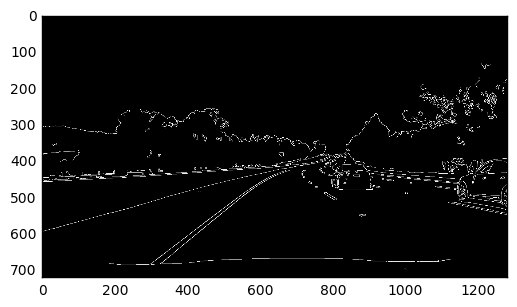

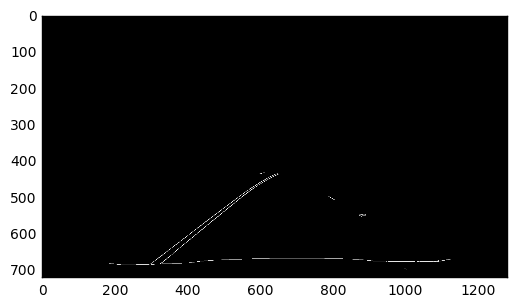

lines:   x1: 776  y1: 669  x1 807  y2 669
lines angle: [ 18.01964564]
lines:   x1: 296  y1: 684  x1 578  y2 472
lines angle: [ 24.70710861]
lines:   x1: 625  y1: 668  x1 775  y2 668
lines angle: [ 21.96886698]
lines:   x1: 363  y1: 651  x1 575  y2 479
lines angle: [ 21.53422348]
lines:   x1: 416  y1: 607  x1 564  y2 487
lines angle: [ 19.82803175]
lines:   x1: 216  y1: 686  x1 308  y2 685
lines angle: [ 19.70854078]
lines:   x1: 323  y1: 684  x1 457  y2 575
lines angle: [ 19.51477553]
lines:   x1: 576  y1: 669  x1 605  y2 669
lines angle: [ 17.97204195]
lines:   x1: 997  y1: 677  x1 1024  y2 677
lines angle: [ 17.92488305]
lines:   x1: 574  y1: 476  x1 589  y2 465
lines angle: [ 17.53425218]
lines:   x1: 324  y1: 684  x1 366  y2 650
lines angle: [ 17.89776722]
lines:   x1: 1086  y1: 677  x1 1123  y2 670
lines angle: [ 18.08465608]
lines:   x1: 411  y1: 679  x1 479  y2 673
lines angle: [ 18.91110367]
lines:   x1: 397  y1: 607  x1 563  y2 482
lines angle: [ 20.4149642]
lines:   x1: 603  

 95%|█████████▌| 239/251 [05:26<00:14,  1.21s/it]

Image shape is: (720, 1280)


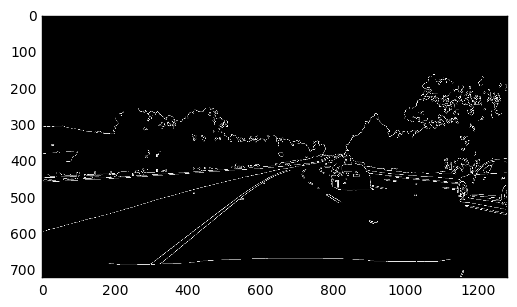

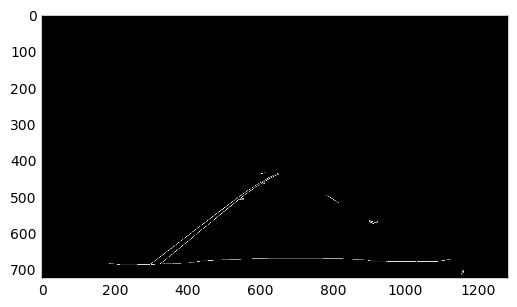

lines:   x1: 552  y1: 498  x1 579  y2 477
lines angle: [ 17.69386101]
lines:   x1: 546  y1: 670  x1 562  y2 670
lines angle: [ 17.67319068]
lines:   x1: 328  y1: 681  x1 448  y2 581
lines angle: [ 19.19258875]
lines:   x1: 366  y1: 631  x1 565  y2 481
lines angle: [ 21.35766137]
lines:   x1: 419  y1: 678  x1 519  y2 671
lines angle: [ 19.88567296]
lines:   x1: 294  y1: 685  x1 369  y2 682
lines angle: [ 19.15336608]
lines:   x1: 297  y1: 684  x1 461  y2 560
lines angle: [ 20.35418206]
lines:   x1: 576  y1: 669  x1 620  y2 669
lines angle: [ 18.3403546]
lines:   x1: 731  y1: 668  x1 771  y2 668
lines angle: [ 18.23953695]
lines:   x1: 215  y1: 686  x1 261  y2 686
lines angle: [ 18.3915019]
lines:   x1: 946  y1: 677  x1 1000  y2 677
lines angle: [ 18.60118385]
lines:   x1: 441  y1: 588  x1 536  y2 509
lines angle: [ 18.73040716]
lines:   x1: 660  y1: 668  x1 716  y2 668
lines angle: [ 18.65491531]
lines:   x1: 571  y1: 477  x1 637  y2 439
lines angle: [ 18.45290097]
lines:   x1: 262  y1:

 96%|█████████▌| 240/251 [05:28<00:13,  1.23s/it]

Image shape is: (720, 1280)


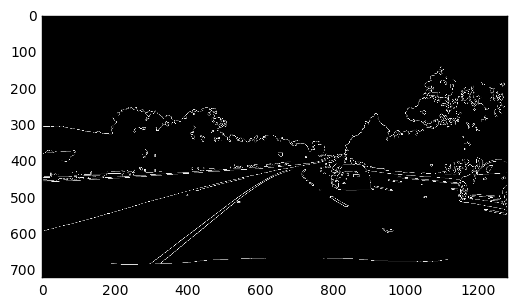

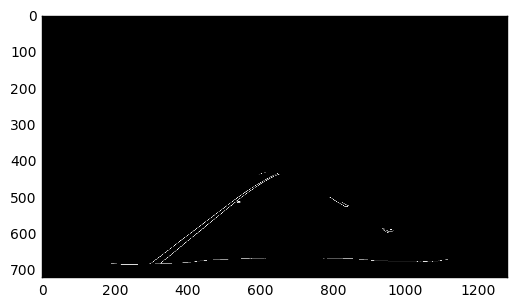

lines:   x1: 361  y1: 652  x1 566  y2 486
lines angle: [ 21.32517011]
lines:   x1: 342  y1: 650  x1 471  y2 550
lines angle: [ 19.48187298]
lines:   x1: 425  y1: 676  x1 497  y2 671
lines angle: [ 19.03894803]
lines:   x1: 603  y1: 668  x1 640  y2 667
lines angle: [ 18.15364151]
lines:   x1: 214  y1: 685  x1 251  y2 685
lines angle: [ 18.16518856]
lines:   x1: 520  y1: 513  x1 600  y2 459
lines angle: [ 18.631744]
lines:   x1: 641  y1: 667  x1 689  y2 667
lines angle: [ 18.44315106]
lines:   x1: 904  y1: 674  x1 976  y2 676
lines angle: [ 19.13141401]
lines:   x1: 252  y1: 685  x1 401  y2 680
lines angle: [ 21.82914013]
lines:   x1: 1009  y1: 676  x1 1058  y2 677
lines angle: [ 18.48126112]
lines:   x1: 301  y1: 681  x1 416  y2 592
lines angle: [ 19.19113392]
lines:   x1: 790  y1: 501  x1 834  y2 526
lines angle: [ 18.64155731]
lines:   x1: 406  y1: 601  x1 516  y2 516
lines angle: [ 19.09255891]
lines:   x1: 611  y1: 458  x1 634  y2 440
lines angle: [ 17.63630781]
lines:   x1: 546  y1

 96%|█████████▌| 241/251 [05:29<00:12,  1.24s/it]

Image shape is: (720, 1280)


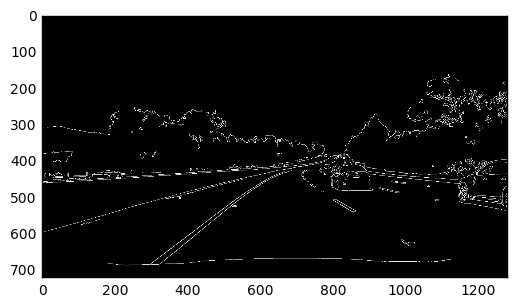

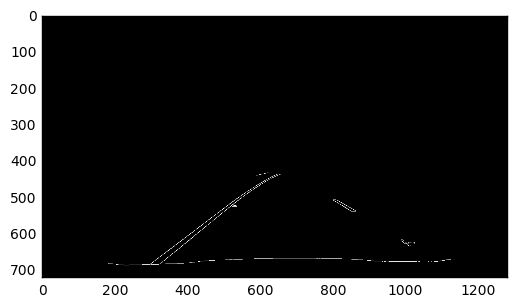

lines:   x1: 321  y1: 685  x1 563  y2 490
lines angle: [ 22.5876736]
lines:   x1: 592  y1: 470  x1 648  y2 439
lines angle: [ 18.27746682]
lines:   x1: 296  y1: 685  x1 563  y2 484
lines angle: [ 23.96092703]
lines:   x1: 456  y1: 675  x1 484  y2 673
lines angle: [ 17.92607374]
lines:   x1: 399  y1: 681  x1 464  y2 674
lines angle: [ 18.81384945]
lines:   x1: 715  y1: 668  x1 849  y2 670
lines angle: [ 21.30426053]
lines:   x1: 366  y1: 631  x1 541  y2 499
lines angle: [ 20.65322838]
lines:   x1: 577  y1: 475  x1 636  y2 441
lines angle: [ 18.31851851]
lines:   x1: 987  y1: 618  x1 1011  y2 632
lines angle: [ 18.0105552]
lines:   x1: 810  y1: 508  x1 860  y2 537
lines angle: [ 18.85376296]
lines:   x1: 800  y1: 509  x1 852  y2 540
lines angle: [ 18.93464866]
lines:   x1: 644  y1: 668  x1 700  y2 668
lines angle: [ 18.65491531]
lines:   x1: 911  y1: 676  x1 986  y2 677
lines angle: [ 19.20689168]
lines:   x1: 562  y1: 492  x1 579  y2 474
lines angle: [ 17.50406281]
lines:   x1: 501  y1:

In [ ]:
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))